In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor
import torch.nn.functional as F
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter

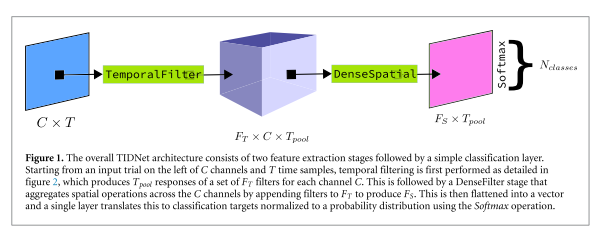

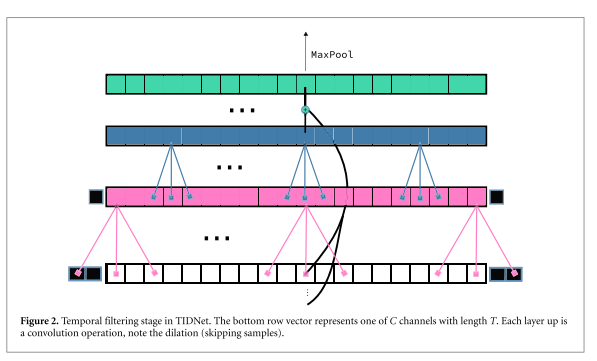

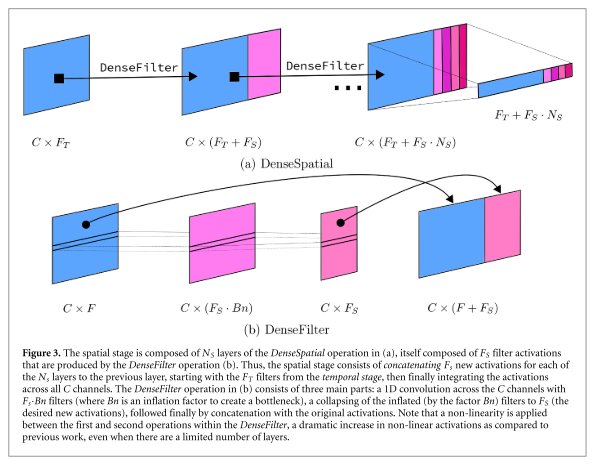

In [2]:
writer = SummaryWriter()

In [3]:
train_set = pd.read_csv("data/final_format/train_set.csv",header=None).to_numpy()
train_label = pd.read_csv("data/final_format/train_label.csv",header=None).to_numpy()
test_set = pd.read_csv("data/final_format/test_set.csv",header=None).to_numpy()
test_label = pd.read_csv("data/final_format/test_label.csv",header=None).to_numpy()

In [4]:
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14393, 4096) (14393, 1) (3599, 4096) (3599, 1)


In [5]:
#delet first row data
train_set = train_set[1:]
train_label = train_label[1:]
test_set = test_set[1:]
test_label = test_label[1:]
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 4096) (14392, 1) (3598, 4096) (3598, 1)


In [6]:
train_set = train_set.reshape((-1,64,64))
test_set = test_set.reshape((-1,64,64))
print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 64, 64) (14392, 1) (3598, 64, 64) (3598, 1)


In [7]:
train_label = train_label.reshape(-1)
test_label = test_label.reshape(-1)

print(train_set.shape, train_label.shape, test_set.shape, test_label.shape)

(14392, 64, 64) (14392,) (3598, 64, 64) (3598,)


In [8]:
# Hyper parameters
num_epochs = 300
num_classes = 4
batch_size = 64
learning_rate = 1e-3

In [9]:
train_set_tensor = Tensor(train_set) 
train_label_tensor = Tensor(train_label).type(torch.LongTensor)

train_dataset = TensorDataset(train_set_tensor,train_label_tensor) 
train_loader = DataLoader(train_dataset, batch_size=batch_size) 

test_set_tensor = Tensor(test_set) 
test_label_tensor = Tensor(test_label).type(torch.LongTensor)

test_dataset = TensorDataset(test_set_tensor,test_label_tensor) 
test_loader = DataLoader(test_dataset, batch_size=batch_size) 

In [10]:
# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [11]:
from math import ceil

import torch
from torch import nn
from torch.nn import init
from torch.nn.utils import weight_norm

from function.modules import Ensure4d, Expression


class _BatchNormZG(nn.BatchNorm2d):
    def reset_parameters(self):
        if self.track_running_stats:
            self.running_mean.zero_()
            self.running_var.fill_(1)
        if self.affine:
            self.weight.data.zero_()
            self.bias.data.zero_()


class _ConvBlock2D(nn.Module):
    """Implements Convolution block with order:
    Convolution, dropout, activation, batch-norm
    """
    def __init__(self, in_filters, out_filters, kernel, stride=(1, 1), padding=0, dilation=1,
                 groups=1, drop_prob=0.5, batch_norm=True, activation=nn.LeakyReLU, residual=False):
        super().__init__()
        self.kernel = kernel
        self.activation = activation()
        self.residual = residual

        self.conv = nn.Conv2d(in_filters, out_filters, kernel, stride=stride, padding=padding,
                              dilation=dilation, groups=groups, bias=not batch_norm)
        self.dropout = nn.Dropout2d(p=drop_prob)
        self.batch_norm = _BatchNormZG(out_filters) if residual else nn.BatchNorm2d(out_filters) if\
            batch_norm else lambda x: x

    def forward(self, input):
        res = input
        input = self.conv(input,)
        input = self.dropout(input)
        input = self.activation(input)
        input = self.batch_norm(input)
        return input + res if self.residual else input


class _DenseFilter(nn.Module):
    def __init__(self, in_features, growth_rate, filter_len=5, drop_prob=0.5, bottleneck=2,
                 activation=nn.LeakyReLU, dim=-2):
        super().__init__()
        dim = dim if dim > 0 else dim + 4
        if dim < 2 or dim > 3:
            raise ValueError('Only last two dimensions supported')
        kernel = (filter_len, 1) if dim == 2 else (1, filter_len)

        self.net = nn.Sequential(
            nn.BatchNorm2d(in_features),
            activation(),
            nn.Conv2d(in_features, bottleneck * growth_rate, 1),
            nn.BatchNorm2d(bottleneck * growth_rate),
            activation(),
            nn.Conv2d(bottleneck * growth_rate, growth_rate, kernel,
                      padding=tuple((k // 2 for k in kernel))),
            nn.Dropout2d(drop_prob)
        )

    def forward(self, x):
        return torch.cat((x, self.net(x)), dim=1)


class _DenseSpatialFilter(nn.Module):
    def __init__(self, in_chans, growth, depth, in_ch=1, bottleneck=4, drop_prob=0.0,
                 activation=nn.LeakyReLU, collapse=True):
        super().__init__()
        self.net = nn.Sequential(*[
            _DenseFilter(in_ch + growth * d, growth, bottleneck=bottleneck, drop_prob=drop_prob,
                         activation=activation) for d in range(depth)
        ])
        n_filters = in_ch + growth * depth
        self.collapse = collapse
        if collapse:
            self.channel_collapse = _ConvBlock2D(n_filters, n_filters, (in_chans, 1), drop_prob=0)

    def forward(self, x):
        if len(x.shape) < 4:
            x = x.unsqueeze(1).permute([0, 1, 3, 2])
        x = self.net(x)
        if self.collapse:
            return self.channel_collapse(x).squeeze(-2)
        return x


class _TemporalFilter(nn.Module):
    def __init__(self, in_chans, filters, depth, temp_len, drop_prob=0., activation=nn.LeakyReLU,
                 residual='netwise'):
        super().__init__()
        temp_len = temp_len + 1 - temp_len % 2
        self.residual_style = str(residual)
        net = list()

        for i in range(depth):
            dil = depth - i
            conv = weight_norm(nn.Conv2d(in_chans if i == 0 else filters, filters,
                                         kernel_size=(1, temp_len), dilation=dil,
                                         padding=(0, dil * (temp_len - 1) // 2)))
            net.append(nn.Sequential(
                conv,
                activation(),
                nn.Dropout2d(drop_prob)
            ))
        if self.residual_style.lower() == 'netwise':
            self.net = nn.Sequential(*net)
            self.residual = nn.Conv2d(in_chans, filters, (1, 1))
        elif residual.lower() == 'dense':
            self.net = net

    def forward(self, x):
        if self.residual_style.lower() == 'netwise':
            return self.net(x) + self.residual(x)
        elif self.residual_style.lower() == 'dense':
            for layer in self.net:
                x = torch.cat((x, layer(x)), dim=1)
            return x


class _TIDNetFeatures(nn.Module):
    def __init__(self, s_growth, t_filters, in_chans, input_window_samples, drop_prob, pooling,
                 temp_layers, spat_layers, temp_span, bottleneck, summary):
        super().__init__()
        self.in_chans = in_chans
        self.input_windows_samples = input_window_samples
        self.temp_len = ceil(temp_span * input_window_samples)

        def _permute(x):
            """
            Permutes data:

            from dim:
            batch, chans, time, 1

            to dim:
            batch, 1, chans, time

            """
            return x.permute([0, 3, 1, 2])

        self.temporal = nn.Sequential(
            Ensure4d(),
            Expression(_permute),
            _TemporalFilter(1, t_filters, depth=temp_layers, temp_len=self.temp_len),
            nn.MaxPool2d((1, pooling)),
            nn.Dropout2d(drop_prob),
        )
        summary = input_window_samples // pooling if summary == -1 else summary

        self.spatial = _DenseSpatialFilter(in_chans, s_growth, spat_layers, in_ch=t_filters,
                                           drop_prob=drop_prob, bottleneck=bottleneck)
        self.extract_features = nn.Sequential(
            nn.AdaptiveAvgPool1d(int(summary)),
            nn.Flatten(start_dim=1)
        )

        self._num_features = (t_filters + s_growth * spat_layers) * summary

    @property
    def num_features(self):
        return self._num_features

    def forward(self, x):
        x = self.temporal(x)
        x = self.spatial(x)
        return self.extract_features(x)


class TIDNet(nn.Module):
    """Thinker Invariance DenseNet model from Kostas et al 2020.

    See [TIDNet]_ for details.

    Parameters
    ----------
    n_classes : int
        Number of classes.
    in_chans : int
        Number of EEG channels.
    input_window_samples : int
        Number of samples.
    s_growth : int
        DenseNet-style growth factor (added filters per DenseFilter)
    t_filters : int
        Number of temporal filters.
    drop_prob : float
        Dropout probability
    pooling : int
        Max temporal pooling (width and stride)
    temp_layers : int
        Number of temporal layers
    spat_layers : int
        Number of DenseFilters
    temp_span : float
        Percentage of input_window_samples that defines the temporal filter length:
        temp_len = ceil(temp_span * input_window_samples)
        e.g A value of 0.05 for temp_span with 1500 input_window_samples will yield a temporal
        filter of length 75.
    bottleneck : int
        Bottleneck factor within Densefilter
    summary : int
        Output size of AdaptiveAvgPool1D layer. If set to -1, value will be calculated
        automatically (input_window_samples // pooling).

    Notes
    -----
    Code adapted from: https://github.com/SPOClab-ca/ThinkerInvariance/

    References
    ----------
    .. [TIDNet] Kostas, D. & Rudzicz, F.
        Thinker invariance: enabling deep neural networks for BCI across more
        people.
        J. Neural Eng. 17, 056008 (2020).
        doi: 10.1088/1741-2552/abb7a7.
    """
    def __init__(self, in_chans=64, n_classes=4, input_window_samples=20, s_growth=24, t_filters=32,
                 drop_prob=0.4, pooling=15, temp_layers=2, spat_layers=2, temp_span=0.05,
                 bottleneck=3, summary=-1):
        super().__init__()
        self.n_classes = n_classes
        self.in_chans = in_chans
        self.input_window_samples = input_window_samples
        self.temp_len = ceil(temp_span * input_window_samples)

        self.dscnn = _TIDNetFeatures(s_growth=s_growth, t_filters=t_filters, in_chans=in_chans,
                                     input_window_samples=input_window_samples,
                                     drop_prob=drop_prob, pooling=pooling, temp_layers=temp_layers,
                                     spat_layers=spat_layers, temp_span=temp_span,
                                     bottleneck=bottleneck, summary=summary)

        self._num_features = self.dscnn.num_features

        self.classify = self._create_classifier(self.num_features, n_classes)

    def _create_classifier(self, incoming, n_classes):
        classifier = nn.Linear(incoming, n_classes)
        init.xavier_normal_(classifier.weight)
        classifier.bias.data.zero_()
        return nn.Sequential(nn.Flatten(start_dim=1), classifier)

    def forward(self, x):
        """Forward pass.

        Parameters
        ----------
        x: torch.Tensor
            Batch of EEG windows of shape (batch_size, n_channels, n_times).
        """

        x = self.dscnn(x)
        return self.classify(x)

    @property
    def num_features(self):
        return self._num_features


In [12]:
# a = torch.randn((64,64,64))
# model = TIDNet()
# b = model(a)
# b.shape

In [13]:
model2 = TIDNet().to(device)

In [14]:
print(model2)

TIDNet(
  (dscnn): _TIDNetFeatures(
    (temporal): Sequential(
      (0): Ensure4d()
      (1): Expression(expression=_permute) 
      (2): _TemporalFilter(
        (net): Sequential(
          (0): Sequential(
            (0): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1), dilation=(2, 2))
            (1): LeakyReLU(negative_slope=0.01)
            (2): Dropout2d(p=0.0, inplace=False)
          )
          (1): Sequential(
            (0): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
            (1): LeakyReLU(negative_slope=0.01)
            (2): Dropout2d(p=0.0, inplace=False)
          )
        )
        (residual): Conv2d(1, 32, kernel_size=(1, 1), stride=(1, 1))
      )
      (3): MaxPool2d(kernel_size=(1, 15), stride=(1, 15), padding=0, dilation=1, ceil_mode=False)
      (4): Dropout2d(p=0.4, inplace=False)
    )
    (spatial): _DenseSpatialFilter(
      (net): Sequential(
        (0): _DenseFilter(
          (net): Sequential(
            (0): BatchNorm2d(32, eps=1e-05

In [16]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=learning_rate, weight_decay=1e-3) 
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 
milestones = [50,100,150,200,250]
milestones = [a * len(train_loader) for a in milestones]
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.5)

In [17]:

# Train the model
total_step = len(train_loader)
for epoch in range(num_epochs):
    correct=0
    total=0
    running_loss = 0
    for i, (X, Y) in enumerate(train_loader):
        X = X.to(device)
        Y = Y.to(device)


        # Forward pass
        outputs = model2(X)
        loss = criterion(outputs, Y)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        #scheduler.step() 
        #print(scheduler.get_last_lr()[0])

        optimizer.step()
        scheduler.step() 
        #print(optimizer.param_groups[0]["lr"])

        _, predicted = outputs.max(1)
        total += Y.size(0)
        correct += predicted.eq(Y).sum().item()
        running_loss += loss.item()
        accu=100.*correct/total
        train_loss = running_loss/(i+1)
        print ('Epoch [{}/{}], Step [{}/{}], Training Accuracy: {:.4f}%, Training Loss: {:.4f}%'.format(epoch+1, num_epochs, i+1, total_step, accu, train_loss))


        #writer.add_scalar(f'train/accuracy', accu, epoch)
        #writer.add_scalar(f'train/loss', train_loss, epoch)
        writer.add_scalars(f'train/accuracy_loss', {
            'accuracy': accu,
            'loss': train_loss,
        }, epoch)
        
        

Epoch [1/300], Step [1/225], Training Accuracy: 34.3750%, Training Loss: 1.6762%
Epoch [1/300], Step [2/225], Training Accuracy: 27.3438%, Training Loss: 1.9114%
Epoch [1/300], Step [3/225], Training Accuracy: 28.6458%, Training Loss: 2.1653%
Epoch [1/300], Step [4/225], Training Accuracy: 29.6875%, Training Loss: 2.1202%
Epoch [1/300], Step [5/225], Training Accuracy: 28.7500%, Training Loss: 2.0897%
Epoch [1/300], Step [6/225], Training Accuracy: 28.3854%, Training Loss: 2.1090%
Epoch [1/300], Step [7/225], Training Accuracy: 27.2321%, Training Loss: 2.1134%
Epoch [1/300], Step [8/225], Training Accuracy: 27.5391%, Training Loss: 2.0986%
Epoch [1/300], Step [9/225], Training Accuracy: 26.5625%, Training Loss: 2.0740%
Epoch [1/300], Step [10/225], Training Accuracy: 26.2500%, Training Loss: 2.0463%
Epoch [1/300], Step [11/225], Training Accuracy: 25.7102%, Training Loss: 2.0604%
Epoch [1/300], Step [12/225], Training Accuracy: 25.5208%, Training Loss: 2.0606%
Epoch [1/300], Step [13/2

Epoch [1/300], Step [110/225], Training Accuracy: 32.6420%, Training Loss: 1.4653%
Epoch [1/300], Step [111/225], Training Accuracy: 32.5873%, Training Loss: 1.4653%
Epoch [1/300], Step [112/225], Training Accuracy: 32.6172%, Training Loss: 1.4648%
Epoch [1/300], Step [113/225], Training Accuracy: 32.6327%, Training Loss: 1.4647%
Epoch [1/300], Step [114/225], Training Accuracy: 32.7440%, Training Loss: 1.4623%
Epoch [1/300], Step [115/225], Training Accuracy: 32.8261%, Training Loss: 1.4607%
Epoch [1/300], Step [116/225], Training Accuracy: 32.9203%, Training Loss: 1.4593%
Epoch [1/300], Step [117/225], Training Accuracy: 32.8659%, Training Loss: 1.4593%
Epoch [1/300], Step [118/225], Training Accuracy: 32.9317%, Training Loss: 1.4581%
Epoch [1/300], Step [119/225], Training Accuracy: 32.9569%, Training Loss: 1.4563%
Epoch [1/300], Step [120/225], Training Accuracy: 33.0208%, Training Loss: 1.4551%
Epoch [1/300], Step [121/225], Training Accuracy: 33.1095%, Training Loss: 1.4539%
Epoc

Epoch [1/300], Step [219/225], Training Accuracy: 35.4523%, Training Loss: 1.3750%
Epoch [1/300], Step [220/225], Training Accuracy: 35.4688%, Training Loss: 1.3741%
Epoch [1/300], Step [221/225], Training Accuracy: 35.4285%, Training Loss: 1.3745%
Epoch [1/300], Step [222/225], Training Accuracy: 35.4800%, Training Loss: 1.3737%
Epoch [1/300], Step [223/225], Training Accuracy: 35.4821%, Training Loss: 1.3735%
Epoch [1/300], Step [224/225], Training Accuracy: 35.4492%, Training Loss: 1.3729%
Epoch [1/300], Step [225/225], Training Accuracy: 35.4433%, Training Loss: 1.3726%
Epoch [2/300], Step [1/225], Training Accuracy: 46.8750%, Training Loss: 1.2127%
Epoch [2/300], Step [2/225], Training Accuracy: 42.9688%, Training Loss: 1.2680%
Epoch [2/300], Step [3/225], Training Accuracy: 40.6250%, Training Loss: 1.3185%
Epoch [2/300], Step [4/225], Training Accuracy: 39.8438%, Training Loss: 1.2824%
Epoch [2/300], Step [5/225], Training Accuracy: 40.6250%, Training Loss: 1.2774%
Epoch [2/300],

Epoch [2/300], Step [100/225], Training Accuracy: 41.0625%, Training Loss: 1.2296%
Epoch [2/300], Step [101/225], Training Accuracy: 41.1665%, Training Loss: 1.2293%
Epoch [2/300], Step [102/225], Training Accuracy: 41.2224%, Training Loss: 1.2290%
Epoch [2/300], Step [103/225], Training Accuracy: 41.1711%, Training Loss: 1.2286%
Epoch [2/300], Step [104/225], Training Accuracy: 41.2410%, Training Loss: 1.2277%
Epoch [2/300], Step [105/225], Training Accuracy: 41.2500%, Training Loss: 1.2280%
Epoch [2/300], Step [106/225], Training Accuracy: 41.2736%, Training Loss: 1.2274%
Epoch [2/300], Step [107/225], Training Accuracy: 41.2383%, Training Loss: 1.2277%
Epoch [2/300], Step [108/225], Training Accuracy: 41.2616%, Training Loss: 1.2275%
Epoch [2/300], Step [109/225], Training Accuracy: 41.3131%, Training Loss: 1.2275%
Epoch [2/300], Step [110/225], Training Accuracy: 41.4205%, Training Loss: 1.2271%
Epoch [2/300], Step [111/225], Training Accuracy: 41.4696%, Training Loss: 1.2274%
Epoc

Epoch [2/300], Step [209/225], Training Accuracy: 42.5763%, Training Loss: 1.2065%
Epoch [2/300], Step [210/225], Training Accuracy: 42.5744%, Training Loss: 1.2063%
Epoch [2/300], Step [211/225], Training Accuracy: 42.5800%, Training Loss: 1.2060%
Epoch [2/300], Step [212/225], Training Accuracy: 42.5781%, Training Loss: 1.2061%
Epoch [2/300], Step [213/225], Training Accuracy: 42.5249%, Training Loss: 1.2069%
Epoch [2/300], Step [214/225], Training Accuracy: 42.5599%, Training Loss: 1.2065%
Epoch [2/300], Step [215/225], Training Accuracy: 42.6017%, Training Loss: 1.2063%
Epoch [2/300], Step [216/225], Training Accuracy: 42.5637%, Training Loss: 1.2069%
Epoch [2/300], Step [217/225], Training Accuracy: 42.5259%, Training Loss: 1.2066%
Epoch [2/300], Step [218/225], Training Accuracy: 42.4957%, Training Loss: 1.2070%
Epoch [2/300], Step [219/225], Training Accuracy: 42.4872%, Training Loss: 1.2068%
Epoch [2/300], Step [220/225], Training Accuracy: 42.4929%, Training Loss: 1.2063%
Epoc

Epoch [3/300], Step [95/225], Training Accuracy: 45.7895%, Training Loss: 1.1508%
Epoch [3/300], Step [96/225], Training Accuracy: 45.8659%, Training Loss: 1.1503%
Epoch [3/300], Step [97/225], Training Accuracy: 45.8924%, Training Loss: 1.1509%
Epoch [3/300], Step [98/225], Training Accuracy: 45.8546%, Training Loss: 1.1504%
Epoch [3/300], Step [99/225], Training Accuracy: 45.8491%, Training Loss: 1.1504%
Epoch [3/300], Step [100/225], Training Accuracy: 45.8438%, Training Loss: 1.1497%
Epoch [3/300], Step [101/225], Training Accuracy: 45.9004%, Training Loss: 1.1488%
Epoch [3/300], Step [102/225], Training Accuracy: 45.9712%, Training Loss: 1.1483%
Epoch [3/300], Step [103/225], Training Accuracy: 45.9951%, Training Loss: 1.1476%
Epoch [3/300], Step [104/225], Training Accuracy: 45.9435%, Training Loss: 1.1474%
Epoch [3/300], Step [105/225], Training Accuracy: 45.9375%, Training Loss: 1.1473%
Epoch [3/300], Step [106/225], Training Accuracy: 45.9906%, Training Loss: 1.1467%
Epoch [3/

Epoch [3/300], Step [194/225], Training Accuracy: 46.5367%, Training Loss: 1.1361%
Epoch [3/300], Step [195/225], Training Accuracy: 46.5705%, Training Loss: 1.1352%
Epoch [3/300], Step [196/225], Training Accuracy: 46.5721%, Training Loss: 1.1352%
Epoch [3/300], Step [197/225], Training Accuracy: 46.5419%, Training Loss: 1.1359%
Epoch [3/300], Step [198/225], Training Accuracy: 46.6146%, Training Loss: 1.1347%
Epoch [3/300], Step [199/225], Training Accuracy: 46.6394%, Training Loss: 1.1341%
Epoch [3/300], Step [200/225], Training Accuracy: 46.6406%, Training Loss: 1.1344%
Epoch [3/300], Step [201/225], Training Accuracy: 46.5874%, Training Loss: 1.1351%
Epoch [3/300], Step [202/225], Training Accuracy: 46.6043%, Training Loss: 1.1347%
Epoch [3/300], Step [203/225], Training Accuracy: 46.6441%, Training Loss: 1.1347%
Epoch [3/300], Step [204/225], Training Accuracy: 46.6988%, Training Loss: 1.1341%
Epoch [3/300], Step [205/225], Training Accuracy: 46.7149%, Training Loss: 1.1340%
Epoc

Epoch [4/300], Step [76/225], Training Accuracy: 48.3964%, Training Loss: 1.0940%
Epoch [4/300], Step [77/225], Training Accuracy: 48.4578%, Training Loss: 1.0932%
Epoch [4/300], Step [78/225], Training Accuracy: 48.4776%, Training Loss: 1.0934%
Epoch [4/300], Step [79/225], Training Accuracy: 48.5957%, Training Loss: 1.0924%
Epoch [4/300], Step [80/225], Training Accuracy: 48.6133%, Training Loss: 1.0923%
Epoch [4/300], Step [81/225], Training Accuracy: 48.7076%, Training Loss: 1.0914%
Epoch [4/300], Step [82/225], Training Accuracy: 48.7995%, Training Loss: 1.0898%
Epoch [4/300], Step [83/225], Training Accuracy: 48.8705%, Training Loss: 1.0887%
Epoch [4/300], Step [84/225], Training Accuracy: 48.9211%, Training Loss: 1.0872%
Epoch [4/300], Step [85/225], Training Accuracy: 49.0257%, Training Loss: 1.0859%
Epoch [4/300], Step [86/225], Training Accuracy: 49.0552%, Training Loss: 1.0850%
Epoch [4/300], Step [87/225], Training Accuracy: 49.0302%, Training Loss: 1.0855%
Epoch [4/300], S

Epoch [4/300], Step [186/225], Training Accuracy: 49.7900%, Training Loss: 1.0768%
Epoch [4/300], Step [187/225], Training Accuracy: 49.7911%, Training Loss: 1.0764%
Epoch [4/300], Step [188/225], Training Accuracy: 49.7756%, Training Loss: 1.0763%
Epoch [4/300], Step [189/225], Training Accuracy: 49.8347%, Training Loss: 1.0755%
Epoch [4/300], Step [190/225], Training Accuracy: 49.8520%, Training Loss: 1.0753%
Epoch [4/300], Step [191/225], Training Accuracy: 49.8855%, Training Loss: 1.0748%
Epoch [4/300], Step [192/225], Training Accuracy: 49.9593%, Training Loss: 1.0738%
Epoch [4/300], Step [193/225], Training Accuracy: 49.9514%, Training Loss: 1.0742%
Epoch [4/300], Step [194/225], Training Accuracy: 49.9678%, Training Loss: 1.0737%
Epoch [4/300], Step [195/225], Training Accuracy: 50.0401%, Training Loss: 1.0727%
Epoch [4/300], Step [196/225], Training Accuracy: 50.0239%, Training Loss: 1.0726%
Epoch [4/300], Step [197/225], Training Accuracy: 50.0159%, Training Loss: 1.0729%
Epoc

Epoch [5/300], Step [69/225], Training Accuracy: 52.8533%, Training Loss: 1.0259%
Epoch [5/300], Step [70/225], Training Accuracy: 52.9018%, Training Loss: 1.0265%
Epoch [5/300], Step [71/225], Training Accuracy: 52.7289%, Training Loss: 1.0287%
Epoch [5/300], Step [72/225], Training Accuracy: 52.6476%, Training Loss: 1.0299%
Epoch [5/300], Step [73/225], Training Accuracy: 52.5043%, Training Loss: 1.0315%
Epoch [5/300], Step [74/225], Training Accuracy: 52.5760%, Training Loss: 1.0298%
Epoch [5/300], Step [75/225], Training Accuracy: 52.6667%, Training Loss: 1.0291%
Epoch [5/300], Step [76/225], Training Accuracy: 52.6110%, Training Loss: 1.0293%
Epoch [5/300], Step [77/225], Training Accuracy: 52.5365%, Training Loss: 1.0289%
Epoch [5/300], Step [78/225], Training Accuracy: 52.5240%, Training Loss: 1.0286%
Epoch [5/300], Step [79/225], Training Accuracy: 52.5514%, Training Loss: 1.0289%
Epoch [5/300], Step [80/225], Training Accuracy: 52.6562%, Training Loss: 1.0289%
Epoch [5/300], S

Epoch [5/300], Step [179/225], Training Accuracy: 52.9155%, Training Loss: 1.0168%
Epoch [5/300], Step [180/225], Training Accuracy: 52.9080%, Training Loss: 1.0166%
Epoch [5/300], Step [181/225], Training Accuracy: 52.8833%, Training Loss: 1.0170%
Epoch [5/300], Step [182/225], Training Accuracy: 52.9018%, Training Loss: 1.0169%
Epoch [5/300], Step [183/225], Training Accuracy: 52.8945%, Training Loss: 1.0164%
Epoch [5/300], Step [184/225], Training Accuracy: 52.9382%, Training Loss: 1.0161%
Epoch [5/300], Step [185/225], Training Accuracy: 52.9730%, Training Loss: 1.0159%
Epoch [5/300], Step [186/225], Training Accuracy: 53.0074%, Training Loss: 1.0158%
Epoch [5/300], Step [187/225], Training Accuracy: 52.9913%, Training Loss: 1.0162%
Epoch [5/300], Step [188/225], Training Accuracy: 52.9837%, Training Loss: 1.0164%
Epoch [5/300], Step [189/225], Training Accuracy: 53.0175%, Training Loss: 1.0163%
Epoch [5/300], Step [190/225], Training Accuracy: 53.0263%, Training Loss: 1.0162%
Epoc

Epoch [6/300], Step [65/225], Training Accuracy: 54.1346%, Training Loss: 0.9948%
Epoch [6/300], Step [66/225], Training Accuracy: 54.2614%, Training Loss: 0.9933%
Epoch [6/300], Step [67/225], Training Accuracy: 54.2444%, Training Loss: 0.9928%
Epoch [6/300], Step [68/225], Training Accuracy: 54.2050%, Training Loss: 0.9934%
Epoch [6/300], Step [69/225], Training Accuracy: 54.1214%, Training Loss: 0.9931%
Epoch [6/300], Step [70/225], Training Accuracy: 54.1295%, Training Loss: 0.9927%
Epoch [6/300], Step [71/225], Training Accuracy: 54.0273%, Training Loss: 0.9942%
Epoch [6/300], Step [72/225], Training Accuracy: 53.8845%, Training Loss: 0.9978%
Epoch [6/300], Step [73/225], Training Accuracy: 53.6815%, Training Loss: 0.9994%
Epoch [6/300], Step [74/225], Training Accuracy: 53.7373%, Training Loss: 0.9986%
Epoch [6/300], Step [75/225], Training Accuracy: 53.7708%, Training Loss: 0.9975%
Epoch [6/300], Step [76/225], Training Accuracy: 53.6801%, Training Loss: 0.9982%
Epoch [6/300], S

Epoch [6/300], Step [175/225], Training Accuracy: 54.0536%, Training Loss: 0.9891%
Epoch [6/300], Step [176/225], Training Accuracy: 54.0394%, Training Loss: 0.9896%
Epoch [6/300], Step [177/225], Training Accuracy: 54.1137%, Training Loss: 0.9891%
Epoch [6/300], Step [178/225], Training Accuracy: 54.1433%, Training Loss: 0.9888%
Epoch [6/300], Step [179/225], Training Accuracy: 54.2161%, Training Loss: 0.9880%
Epoch [6/300], Step [180/225], Training Accuracy: 54.2448%, Training Loss: 0.9877%
Epoch [6/300], Step [181/225], Training Accuracy: 54.2386%, Training Loss: 0.9881%
Epoch [6/300], Step [182/225], Training Accuracy: 54.2840%, Training Loss: 0.9878%
Epoch [6/300], Step [183/225], Training Accuracy: 54.2777%, Training Loss: 0.9877%
Epoch [6/300], Step [184/225], Training Accuracy: 54.2799%, Training Loss: 0.9876%
Epoch [6/300], Step [185/225], Training Accuracy: 54.3243%, Training Loss: 0.9874%
Epoch [6/300], Step [186/225], Training Accuracy: 54.3515%, Training Loss: 0.9871%
Epoc

Epoch [7/300], Step [50/225], Training Accuracy: 57.5000%, Training Loss: 0.9518%
Epoch [7/300], Step [51/225], Training Accuracy: 57.6593%, Training Loss: 0.9515%
Epoch [7/300], Step [52/225], Training Accuracy: 57.6623%, Training Loss: 0.9514%
Epoch [7/300], Step [53/225], Training Accuracy: 57.5767%, Training Loss: 0.9509%
Epoch [7/300], Step [54/225], Training Accuracy: 57.4942%, Training Loss: 0.9521%
Epoch [7/300], Step [55/225], Training Accuracy: 57.4432%, Training Loss: 0.9531%
Epoch [7/300], Step [56/225], Training Accuracy: 57.4219%, Training Loss: 0.9534%
Epoch [7/300], Step [57/225], Training Accuracy: 57.3739%, Training Loss: 0.9524%
Epoch [7/300], Step [58/225], Training Accuracy: 57.2468%, Training Loss: 0.9545%
Epoch [7/300], Step [59/225], Training Accuracy: 57.4153%, Training Loss: 0.9532%
Epoch [7/300], Step [60/225], Training Accuracy: 57.4740%, Training Loss: 0.9513%
Epoch [7/300], Step [61/225], Training Accuracy: 57.5051%, Training Loss: 0.9516%
Epoch [7/300], S

Epoch [7/300], Step [161/225], Training Accuracy: 56.6576%, Training Loss: 0.9512%
Epoch [7/300], Step [162/225], Training Accuracy: 56.6744%, Training Loss: 0.9508%
Epoch [7/300], Step [163/225], Training Accuracy: 56.7293%, Training Loss: 0.9505%
Epoch [7/300], Step [164/225], Training Accuracy: 56.7454%, Training Loss: 0.9501%
Epoch [7/300], Step [165/225], Training Accuracy: 56.7045%, Training Loss: 0.9506%
Epoch [7/300], Step [166/225], Training Accuracy: 56.6924%, Training Loss: 0.9504%
Epoch [7/300], Step [167/225], Training Accuracy: 56.6430%, Training Loss: 0.9504%
Epoch [7/300], Step [168/225], Training Accuracy: 56.6499%, Training Loss: 0.9504%
Epoch [7/300], Step [169/225], Training Accuracy: 56.6661%, Training Loss: 0.9501%
Epoch [7/300], Step [170/225], Training Accuracy: 56.6360%, Training Loss: 0.9509%
Epoch [7/300], Step [171/225], Training Accuracy: 56.6246%, Training Loss: 0.9510%
Epoch [7/300], Step [172/225], Training Accuracy: 56.6770%, Training Loss: 0.9507%
Epoc

Epoch [8/300], Step [47/225], Training Accuracy: 58.8098%, Training Loss: 0.9237%
Epoch [8/300], Step [48/225], Training Accuracy: 58.7891%, Training Loss: 0.9233%
Epoch [8/300], Step [49/225], Training Accuracy: 58.8648%, Training Loss: 0.9234%
Epoch [8/300], Step [50/225], Training Accuracy: 58.9375%, Training Loss: 0.9228%
Epoch [8/300], Step [51/225], Training Accuracy: 59.0686%, Training Loss: 0.9221%
Epoch [8/300], Step [52/225], Training Accuracy: 59.0745%, Training Loss: 0.9207%
Epoch [8/300], Step [53/225], Training Accuracy: 59.0507%, Training Loss: 0.9204%
Epoch [8/300], Step [54/225], Training Accuracy: 58.8831%, Training Loss: 0.9232%
Epoch [8/300], Step [55/225], Training Accuracy: 58.6648%, Training Loss: 0.9237%
Epoch [8/300], Step [56/225], Training Accuracy: 58.6496%, Training Loss: 0.9239%
Epoch [8/300], Step [57/225], Training Accuracy: 58.7171%, Training Loss: 0.9231%
Epoch [8/300], Step [58/225], Training Accuracy: 58.5668%, Training Loss: 0.9245%
Epoch [8/300], S

Epoch [8/300], Step [157/225], Training Accuracy: 58.0613%, Training Loss: 0.9178%
Epoch [8/300], Step [158/225], Training Accuracy: 58.0103%, Training Loss: 0.9187%
Epoch [8/300], Step [159/225], Training Accuracy: 58.0090%, Training Loss: 0.9186%
Epoch [8/300], Step [160/225], Training Accuracy: 57.9785%, Training Loss: 0.9192%
Epoch [8/300], Step [161/225], Training Accuracy: 57.9969%, Training Loss: 0.9183%
Epoch [8/300], Step [162/225], Training Accuracy: 58.0633%, Training Loss: 0.9180%
Epoch [8/300], Step [163/225], Training Accuracy: 58.1001%, Training Loss: 0.9174%
Epoch [8/300], Step [164/225], Training Accuracy: 58.0793%, Training Loss: 0.9170%
Epoch [8/300], Step [165/225], Training Accuracy: 58.0587%, Training Loss: 0.9174%
Epoch [8/300], Step [166/225], Training Accuracy: 58.0572%, Training Loss: 0.9174%
Epoch [8/300], Step [167/225], Training Accuracy: 58.0838%, Training Loss: 0.9171%
Epoch [8/300], Step [168/225], Training Accuracy: 58.0822%, Training Loss: 0.9173%
Epoc

Epoch [9/300], Step [41/225], Training Accuracy: 59.8323%, Training Loss: 0.8873%
Epoch [9/300], Step [42/225], Training Accuracy: 59.7842%, Training Loss: 0.8868%
Epoch [9/300], Step [43/225], Training Accuracy: 59.7020%, Training Loss: 0.8886%
Epoch [9/300], Step [44/225], Training Accuracy: 59.8366%, Training Loss: 0.8851%
Epoch [9/300], Step [45/225], Training Accuracy: 59.9306%, Training Loss: 0.8832%
Epoch [9/300], Step [46/225], Training Accuracy: 60.2242%, Training Loss: 0.8804%
Epoch [9/300], Step [47/225], Training Accuracy: 60.1064%, Training Loss: 0.8827%
Epoch [9/300], Step [48/225], Training Accuracy: 60.0260%, Training Loss: 0.8831%
Epoch [9/300], Step [49/225], Training Accuracy: 60.0128%, Training Loss: 0.8833%
Epoch [9/300], Step [50/225], Training Accuracy: 60.0000%, Training Loss: 0.8822%
Epoch [9/300], Step [51/225], Training Accuracy: 60.0797%, Training Loss: 0.8806%
Epoch [9/300], Step [52/225], Training Accuracy: 60.1562%, Training Loss: 0.8788%
Epoch [9/300], S

Epoch [9/300], Step [141/225], Training Accuracy: 59.1090%, Training Loss: 0.8880%
Epoch [9/300], Step [142/225], Training Accuracy: 59.1109%, Training Loss: 0.8881%
Epoch [9/300], Step [143/225], Training Accuracy: 58.9598%, Training Loss: 0.8892%
Epoch [9/300], Step [144/225], Training Accuracy: 58.9410%, Training Loss: 0.8892%
Epoch [9/300], Step [145/225], Training Accuracy: 58.9655%, Training Loss: 0.8893%
Epoch [9/300], Step [146/225], Training Accuracy: 58.9683%, Training Loss: 0.8898%
Epoch [9/300], Step [147/225], Training Accuracy: 58.9392%, Training Loss: 0.8898%
Epoch [9/300], Step [148/225], Training Accuracy: 58.9738%, Training Loss: 0.8895%
Epoch [9/300], Step [149/225], Training Accuracy: 58.9451%, Training Loss: 0.8897%
Epoch [9/300], Step [150/225], Training Accuracy: 58.8750%, Training Loss: 0.8898%
Epoch [9/300], Step [151/225], Training Accuracy: 58.8783%, Training Loss: 0.8893%
Epoch [9/300], Step [152/225], Training Accuracy: 58.8199%, Training Loss: 0.8904%
Epoc

Epoch [10/300], Step [26/225], Training Accuracy: 60.8173%, Training Loss: 0.8767%
Epoch [10/300], Step [27/225], Training Accuracy: 60.8796%, Training Loss: 0.8796%
Epoch [10/300], Step [28/225], Training Accuracy: 60.8817%, Training Loss: 0.8763%
Epoch [10/300], Step [29/225], Training Accuracy: 61.0453%, Training Loss: 0.8729%
Epoch [10/300], Step [30/225], Training Accuracy: 61.0417%, Training Loss: 0.8704%
Epoch [10/300], Step [31/225], Training Accuracy: 60.7359%, Training Loss: 0.8744%
Epoch [10/300], Step [32/225], Training Accuracy: 60.6934%, Training Loss: 0.8746%
Epoch [10/300], Step [33/225], Training Accuracy: 60.5114%, Training Loss: 0.8750%
Epoch [10/300], Step [34/225], Training Accuracy: 60.2941%, Training Loss: 0.8793%
Epoch [10/300], Step [35/225], Training Accuracy: 60.6696%, Training Loss: 0.8770%
Epoch [10/300], Step [36/225], Training Accuracy: 60.5469%, Training Loss: 0.8774%
Epoch [10/300], Step [37/225], Training Accuracy: 60.8530%, Training Loss: 0.8733%
Epoc

Epoch [10/300], Step [125/225], Training Accuracy: 60.3375%, Training Loss: 0.8708%
Epoch [10/300], Step [126/225], Training Accuracy: 60.3547%, Training Loss: 0.8709%
Epoch [10/300], Step [127/225], Training Accuracy: 60.2977%, Training Loss: 0.8718%
Epoch [10/300], Step [128/225], Training Accuracy: 60.3149%, Training Loss: 0.8720%
Epoch [10/300], Step [129/225], Training Accuracy: 60.3440%, Training Loss: 0.8717%
Epoch [10/300], Step [130/225], Training Accuracy: 60.3486%, Training Loss: 0.8721%
Epoch [10/300], Step [131/225], Training Accuracy: 60.3053%, Training Loss: 0.8721%
Epoch [10/300], Step [132/225], Training Accuracy: 60.2509%, Training Loss: 0.8724%
Epoch [10/300], Step [133/225], Training Accuracy: 60.3148%, Training Loss: 0.8710%
Epoch [10/300], Step [134/225], Training Accuracy: 60.2845%, Training Loss: 0.8718%
Epoch [10/300], Step [135/225], Training Accuracy: 60.3125%, Training Loss: 0.8716%
Epoch [10/300], Step [136/225], Training Accuracy: 60.3860%, Training Loss: 

Epoch [11/300], Step [1/225], Training Accuracy: 68.7500%, Training Loss: 0.7346%
Epoch [11/300], Step [2/225], Training Accuracy: 65.6250%, Training Loss: 0.7903%
Epoch [11/300], Step [3/225], Training Accuracy: 60.9375%, Training Loss: 0.8466%
Epoch [11/300], Step [4/225], Training Accuracy: 58.5938%, Training Loss: 0.8550%
Epoch [11/300], Step [5/225], Training Accuracy: 59.3750%, Training Loss: 0.8597%
Epoch [11/300], Step [6/225], Training Accuracy: 57.2917%, Training Loss: 0.9086%
Epoch [11/300], Step [7/225], Training Accuracy: 58.2589%, Training Loss: 0.9050%
Epoch [11/300], Step [8/225], Training Accuracy: 58.0078%, Training Loss: 0.8976%
Epoch [11/300], Step [9/225], Training Accuracy: 57.6389%, Training Loss: 0.8977%
Epoch [11/300], Step [10/225], Training Accuracy: 57.3438%, Training Loss: 0.9013%
Epoch [11/300], Step [11/225], Training Accuracy: 56.8182%, Training Loss: 0.9059%
Epoch [11/300], Step [12/225], Training Accuracy: 56.9010%, Training Loss: 0.9002%
Epoch [11/300

Epoch [11/300], Step [101/225], Training Accuracy: 61.3397%, Training Loss: 0.8471%
Epoch [11/300], Step [102/225], Training Accuracy: 61.3051%, Training Loss: 0.8477%
Epoch [11/300], Step [103/225], Training Accuracy: 61.3016%, Training Loss: 0.8471%
Epoch [11/300], Step [104/225], Training Accuracy: 61.2530%, Training Loss: 0.8473%
Epoch [11/300], Step [105/225], Training Accuracy: 61.2798%, Training Loss: 0.8466%
Epoch [11/300], Step [106/225], Training Accuracy: 61.1881%, Training Loss: 0.8475%
Epoch [11/300], Step [107/225], Training Accuracy: 61.1565%, Training Loss: 0.8479%
Epoch [11/300], Step [108/225], Training Accuracy: 61.1111%, Training Loss: 0.8482%
Epoch [11/300], Step [109/225], Training Accuracy: 61.0952%, Training Loss: 0.8477%
Epoch [11/300], Step [110/225], Training Accuracy: 61.0795%, Training Loss: 0.8470%
Epoch [11/300], Step [111/225], Training Accuracy: 60.9797%, Training Loss: 0.8476%
Epoch [11/300], Step [112/225], Training Accuracy: 61.0491%, Training Loss: 

Epoch [11/300], Step [200/225], Training Accuracy: 61.6250%, Training Loss: 0.8416%
Epoch [11/300], Step [201/225], Training Accuracy: 61.6449%, Training Loss: 0.8418%
Epoch [11/300], Step [202/225], Training Accuracy: 61.6723%, Training Loss: 0.8417%
Epoch [11/300], Step [203/225], Training Accuracy: 61.7226%, Training Loss: 0.8416%
Epoch [11/300], Step [204/225], Training Accuracy: 61.7724%, Training Loss: 0.8412%
Epoch [11/300], Step [205/225], Training Accuracy: 61.7683%, Training Loss: 0.8412%
Epoch [11/300], Step [206/225], Training Accuracy: 61.7718%, Training Loss: 0.8410%
Epoch [11/300], Step [207/225], Training Accuracy: 61.7829%, Training Loss: 0.8409%
Epoch [11/300], Step [208/225], Training Accuracy: 61.8314%, Training Loss: 0.8407%
Epoch [11/300], Step [209/225], Training Accuracy: 61.8272%, Training Loss: 0.8409%
Epoch [11/300], Step [210/225], Training Accuracy: 61.7857%, Training Loss: 0.8414%
Epoch [11/300], Step [211/225], Training Accuracy: 61.7891%, Training Loss: 

Epoch [12/300], Step [83/225], Training Accuracy: 63.3471%, Training Loss: 0.8178%
Epoch [12/300], Step [84/225], Training Accuracy: 63.4301%, Training Loss: 0.8167%
Epoch [12/300], Step [85/225], Training Accuracy: 63.4559%, Training Loss: 0.8157%
Epoch [12/300], Step [86/225], Training Accuracy: 63.4811%, Training Loss: 0.8154%
Epoch [12/300], Step [87/225], Training Accuracy: 63.5057%, Training Loss: 0.8158%
Epoch [12/300], Step [88/225], Training Accuracy: 63.4588%, Training Loss: 0.8169%
Epoch [12/300], Step [89/225], Training Accuracy: 63.5007%, Training Loss: 0.8171%
Epoch [12/300], Step [90/225], Training Accuracy: 63.3854%, Training Loss: 0.8187%
Epoch [12/300], Step [91/225], Training Accuracy: 63.2898%, Training Loss: 0.8197%
Epoch [12/300], Step [92/225], Training Accuracy: 63.1624%, Training Loss: 0.8217%
Epoch [12/300], Step [93/225], Training Accuracy: 63.0880%, Training Loss: 0.8228%
Epoch [12/300], Step [94/225], Training Accuracy: 63.1483%, Training Loss: 0.8226%
Epoc

Epoch [12/300], Step [192/225], Training Accuracy: 62.8906%, Training Loss: 0.8210%
Epoch [12/300], Step [193/225], Training Accuracy: 62.8724%, Training Loss: 0.8210%
Epoch [12/300], Step [194/225], Training Accuracy: 62.8785%, Training Loss: 0.8206%
Epoch [12/300], Step [195/225], Training Accuracy: 62.9247%, Training Loss: 0.8201%
Epoch [12/300], Step [196/225], Training Accuracy: 62.9464%, Training Loss: 0.8200%
Epoch [12/300], Step [197/225], Training Accuracy: 62.9680%, Training Loss: 0.8201%
Epoch [12/300], Step [198/225], Training Accuracy: 62.9893%, Training Loss: 0.8195%
Epoch [12/300], Step [199/225], Training Accuracy: 63.0339%, Training Loss: 0.8187%
Epoch [12/300], Step [200/225], Training Accuracy: 62.9766%, Training Loss: 0.8193%
Epoch [12/300], Step [201/225], Training Accuracy: 62.9353%, Training Loss: 0.8203%
Epoch [12/300], Step [202/225], Training Accuracy: 62.9100%, Training Loss: 0.8207%
Epoch [12/300], Step [203/225], Training Accuracy: 62.9310%, Training Loss: 

Epoch [13/300], Step [66/225], Training Accuracy: 64.8674%, Training Loss: 0.8063%
Epoch [13/300], Step [67/225], Training Accuracy: 64.8554%, Training Loss: 0.8067%
Epoch [13/300], Step [68/225], Training Accuracy: 64.8897%, Training Loss: 0.8064%
Epoch [13/300], Step [69/225], Training Accuracy: 64.8777%, Training Loss: 0.8060%
Epoch [13/300], Step [70/225], Training Accuracy: 64.7098%, Training Loss: 0.8068%
Epoch [13/300], Step [71/225], Training Accuracy: 64.6567%, Training Loss: 0.8067%
Epoch [13/300], Step [72/225], Training Accuracy: 64.6050%, Training Loss: 0.8084%
Epoch [13/300], Step [73/225], Training Accuracy: 64.4692%, Training Loss: 0.8085%
Epoch [13/300], Step [74/225], Training Accuracy: 64.4426%, Training Loss: 0.8083%
Epoch [13/300], Step [75/225], Training Accuracy: 64.4583%, Training Loss: 0.8071%
Epoch [13/300], Step [76/225], Training Accuracy: 64.3709%, Training Loss: 0.8081%
Epoch [13/300], Step [77/225], Training Accuracy: 64.4886%, Training Loss: 0.8077%
Epoc

Epoch [13/300], Step [165/225], Training Accuracy: 63.7121%, Training Loss: 0.8085%
Epoch [13/300], Step [166/225], Training Accuracy: 63.7895%, Training Loss: 0.8080%
Epoch [13/300], Step [167/225], Training Accuracy: 63.8286%, Training Loss: 0.8073%
Epoch [13/300], Step [168/225], Training Accuracy: 63.8672%, Training Loss: 0.8072%
Epoch [13/300], Step [169/225], Training Accuracy: 63.8499%, Training Loss: 0.8070%
Epoch [13/300], Step [170/225], Training Accuracy: 63.8235%, Training Loss: 0.8079%
Epoch [13/300], Step [171/225], Training Accuracy: 63.8249%, Training Loss: 0.8082%
Epoch [13/300], Step [172/225], Training Accuracy: 63.8899%, Training Loss: 0.8076%
Epoch [13/300], Step [173/225], Training Accuracy: 63.8638%, Training Loss: 0.8079%
Epoch [13/300], Step [174/225], Training Accuracy: 63.8290%, Training Loss: 0.8082%
Epoch [13/300], Step [175/225], Training Accuracy: 63.8571%, Training Loss: 0.8081%
Epoch [13/300], Step [176/225], Training Accuracy: 63.8583%, Training Loss: 

Epoch [14/300], Step [39/225], Training Accuracy: 64.5433%, Training Loss: 0.7901%
Epoch [14/300], Step [40/225], Training Accuracy: 64.4922%, Training Loss: 0.7901%
Epoch [14/300], Step [41/225], Training Accuracy: 64.1387%, Training Loss: 0.7934%
Epoch [14/300], Step [42/225], Training Accuracy: 63.9509%, Training Loss: 0.7936%
Epoch [14/300], Step [43/225], Training Accuracy: 64.1352%, Training Loss: 0.7924%
Epoch [14/300], Step [44/225], Training Accuracy: 64.4531%, Training Loss: 0.7890%
Epoch [14/300], Step [45/225], Training Accuracy: 64.4792%, Training Loss: 0.7878%
Epoch [14/300], Step [46/225], Training Accuracy: 64.7758%, Training Loss: 0.7851%
Epoch [14/300], Step [47/225], Training Accuracy: 64.6941%, Training Loss: 0.7870%
Epoch [14/300], Step [48/225], Training Accuracy: 64.6159%, Training Loss: 0.7880%
Epoch [14/300], Step [49/225], Training Accuracy: 64.5408%, Training Loss: 0.7891%
Epoch [14/300], Step [50/225], Training Accuracy: 64.6562%, Training Loss: 0.7868%
Epoc

Epoch [14/300], Step [140/225], Training Accuracy: 64.5201%, Training Loss: 0.7867%
Epoch [14/300], Step [141/225], Training Accuracy: 64.5501%, Training Loss: 0.7865%
Epoch [14/300], Step [142/225], Training Accuracy: 64.5907%, Training Loss: 0.7858%
Epoch [14/300], Step [143/225], Training Accuracy: 64.5433%, Training Loss: 0.7862%
Epoch [14/300], Step [144/225], Training Accuracy: 64.6159%, Training Loss: 0.7854%
Epoch [14/300], Step [145/225], Training Accuracy: 64.5905%, Training Loss: 0.7859%
Epoch [14/300], Step [146/225], Training Accuracy: 64.5548%, Training Loss: 0.7863%
Epoch [14/300], Step [147/225], Training Accuracy: 64.5621%, Training Loss: 0.7862%
Epoch [14/300], Step [148/225], Training Accuracy: 64.6432%, Training Loss: 0.7854%
Epoch [14/300], Step [149/225], Training Accuracy: 64.6393%, Training Loss: 0.7855%
Epoch [14/300], Step [150/225], Training Accuracy: 64.6458%, Training Loss: 0.7856%
Epoch [14/300], Step [151/225], Training Accuracy: 64.6834%, Training Loss: 

Epoch [15/300], Step [21/225], Training Accuracy: 66.2946%, Training Loss: 0.7741%
Epoch [15/300], Step [22/225], Training Accuracy: 65.9801%, Training Loss: 0.7783%
Epoch [15/300], Step [23/225], Training Accuracy: 66.1685%, Training Loss: 0.7750%
Epoch [15/300], Step [24/225], Training Accuracy: 65.8203%, Training Loss: 0.7780%
Epoch [15/300], Step [25/225], Training Accuracy: 65.7500%, Training Loss: 0.7747%
Epoch [15/300], Step [26/225], Training Accuracy: 65.7452%, Training Loss: 0.7725%
Epoch [15/300], Step [27/225], Training Accuracy: 65.6829%, Training Loss: 0.7729%
Epoch [15/300], Step [28/225], Training Accuracy: 65.5692%, Training Loss: 0.7691%
Epoch [15/300], Step [29/225], Training Accuracy: 65.4634%, Training Loss: 0.7670%
Epoch [15/300], Step [30/225], Training Accuracy: 65.6250%, Training Loss: 0.7659%
Epoch [15/300], Step [31/225], Training Accuracy: 65.3730%, Training Loss: 0.7703%
Epoch [15/300], Step [32/225], Training Accuracy: 65.4297%, Training Loss: 0.7698%
Epoc

Epoch [15/300], Step [128/225], Training Accuracy: 64.4775%, Training Loss: 0.7804%
Epoch [15/300], Step [129/225], Training Accuracy: 64.4743%, Training Loss: 0.7801%
Epoch [15/300], Step [130/225], Training Accuracy: 64.4471%, Training Loss: 0.7804%
Epoch [15/300], Step [131/225], Training Accuracy: 64.3845%, Training Loss: 0.7811%
Epoch [15/300], Step [132/225], Training Accuracy: 64.3584%, Training Loss: 0.7811%
Epoch [15/300], Step [133/225], Training Accuracy: 64.4619%, Training Loss: 0.7796%
Epoch [15/300], Step [134/225], Training Accuracy: 64.3773%, Training Loss: 0.7810%
Epoch [15/300], Step [135/225], Training Accuracy: 64.3981%, Training Loss: 0.7807%
Epoch [15/300], Step [136/225], Training Accuracy: 64.4646%, Training Loss: 0.7799%
Epoch [15/300], Step [137/225], Training Accuracy: 64.4731%, Training Loss: 0.7794%
Epoch [15/300], Step [138/225], Training Accuracy: 64.5380%, Training Loss: 0.7781%
Epoch [15/300], Step [139/225], Training Accuracy: 64.5459%, Training Loss: 

Epoch [16/300], Step [13/225], Training Accuracy: 64.7837%, Training Loss: 0.7799%
Epoch [16/300], Step [14/225], Training Accuracy: 64.6205%, Training Loss: 0.7781%
Epoch [16/300], Step [15/225], Training Accuracy: 64.3750%, Training Loss: 0.7866%
Epoch [16/300], Step [16/225], Training Accuracy: 64.1602%, Training Loss: 0.7893%
Epoch [16/300], Step [17/225], Training Accuracy: 64.6140%, Training Loss: 0.7818%
Epoch [16/300], Step [18/225], Training Accuracy: 64.7569%, Training Loss: 0.7801%
Epoch [16/300], Step [19/225], Training Accuracy: 64.9671%, Training Loss: 0.7747%
Epoch [16/300], Step [20/225], Training Accuracy: 65.1562%, Training Loss: 0.7697%
Epoch [16/300], Step [21/225], Training Accuracy: 65.8482%, Training Loss: 0.7628%
Epoch [16/300], Step [22/225], Training Accuracy: 65.5540%, Training Loss: 0.7678%
Epoch [16/300], Step [23/225], Training Accuracy: 65.3533%, Training Loss: 0.7686%
Epoch [16/300], Step [24/225], Training Accuracy: 65.0391%, Training Loss: 0.7722%
Epoc

Epoch [16/300], Step [120/225], Training Accuracy: 66.0026%, Training Loss: 0.7552%
Epoch [16/300], Step [121/225], Training Accuracy: 65.9478%, Training Loss: 0.7561%
Epoch [16/300], Step [122/225], Training Accuracy: 65.9836%, Training Loss: 0.7561%
Epoch [16/300], Step [123/225], Training Accuracy: 65.9426%, Training Loss: 0.7563%
Epoch [16/300], Step [124/225], Training Accuracy: 65.9904%, Training Loss: 0.7558%
Epoch [16/300], Step [125/225], Training Accuracy: 65.9375%, Training Loss: 0.7558%
Epoch [16/300], Step [126/225], Training Accuracy: 65.9722%, Training Loss: 0.7559%
Epoch [16/300], Step [127/225], Training Accuracy: 66.0064%, Training Loss: 0.7556%
Epoch [16/300], Step [128/225], Training Accuracy: 66.0156%, Training Loss: 0.7561%
Epoch [16/300], Step [129/225], Training Accuracy: 66.0610%, Training Loss: 0.7553%
Epoch [16/300], Step [130/225], Training Accuracy: 66.0337%, Training Loss: 0.7556%
Epoch [16/300], Step [131/225], Training Accuracy: 66.0425%, Training Loss: 

Epoch [17/300], Step [1/225], Training Accuracy: 75.0000%, Training Loss: 0.6456%
Epoch [17/300], Step [2/225], Training Accuracy: 71.8750%, Training Loss: 0.6876%
Epoch [17/300], Step [3/225], Training Accuracy: 67.7083%, Training Loss: 0.7594%
Epoch [17/300], Step [4/225], Training Accuracy: 68.7500%, Training Loss: 0.7462%
Epoch [17/300], Step [5/225], Training Accuracy: 68.1250%, Training Loss: 0.7461%
Epoch [17/300], Step [6/225], Training Accuracy: 67.1875%, Training Loss: 0.7709%
Epoch [17/300], Step [7/225], Training Accuracy: 67.4107%, Training Loss: 0.7711%
Epoch [17/300], Step [8/225], Training Accuracy: 66.7969%, Training Loss: 0.7650%
Epoch [17/300], Step [9/225], Training Accuracy: 66.4931%, Training Loss: 0.7661%
Epoch [17/300], Step [10/225], Training Accuracy: 66.2500%, Training Loss: 0.7673%
Epoch [17/300], Step [11/225], Training Accuracy: 66.1932%, Training Loss: 0.7713%
Epoch [17/300], Step [12/225], Training Accuracy: 65.6250%, Training Loss: 0.7716%
Epoch [17/300

Epoch [17/300], Step [100/225], Training Accuracy: 67.7188%, Training Loss: 0.7361%
Epoch [17/300], Step [101/225], Training Accuracy: 67.6361%, Training Loss: 0.7377%
Epoch [17/300], Step [102/225], Training Accuracy: 67.6471%, Training Loss: 0.7379%
Epoch [17/300], Step [103/225], Training Accuracy: 67.5667%, Training Loss: 0.7379%
Epoch [17/300], Step [104/225], Training Accuracy: 67.5481%, Training Loss: 0.7377%
Epoch [17/300], Step [105/225], Training Accuracy: 67.5000%, Training Loss: 0.7382%
Epoch [17/300], Step [106/225], Training Accuracy: 67.4528%, Training Loss: 0.7390%
Epoch [17/300], Step [107/225], Training Accuracy: 67.3919%, Training Loss: 0.7392%
Epoch [17/300], Step [108/225], Training Accuracy: 67.3322%, Training Loss: 0.7403%
Epoch [17/300], Step [109/225], Training Accuracy: 67.4025%, Training Loss: 0.7396%
Epoch [17/300], Step [110/225], Training Accuracy: 67.4006%, Training Loss: 0.7402%
Epoch [17/300], Step [111/225], Training Accuracy: 67.3705%, Training Loss: 

Epoch [17/300], Step [199/225], Training Accuracy: 67.7136%, Training Loss: 0.7332%
Epoch [17/300], Step [200/225], Training Accuracy: 67.7266%, Training Loss: 0.7333%
Epoch [17/300], Step [201/225], Training Accuracy: 67.6928%, Training Loss: 0.7339%
Epoch [17/300], Step [202/225], Training Accuracy: 67.7058%, Training Loss: 0.7337%
Epoch [17/300], Step [203/225], Training Accuracy: 67.7417%, Training Loss: 0.7331%
Epoch [17/300], Step [204/225], Training Accuracy: 67.7237%, Training Loss: 0.7333%
Epoch [17/300], Step [205/225], Training Accuracy: 67.7363%, Training Loss: 0.7331%
Epoch [17/300], Step [206/225], Training Accuracy: 67.7564%, Training Loss: 0.7323%
Epoch [17/300], Step [207/225], Training Accuracy: 67.7914%, Training Loss: 0.7321%
Epoch [17/300], Step [208/225], Training Accuracy: 67.7960%, Training Loss: 0.7318%
Epoch [17/300], Step [209/225], Training Accuracy: 67.8080%, Training Loss: 0.7318%
Epoch [17/300], Step [210/225], Training Accuracy: 67.7827%, Training Loss: 

Epoch [18/300], Step [73/225], Training Accuracy: 68.0009%, Training Loss: 0.7346%
Epoch [18/300], Step [74/225], Training Accuracy: 67.8421%, Training Loss: 0.7354%
Epoch [18/300], Step [75/225], Training Accuracy: 67.8750%, Training Loss: 0.7346%
Epoch [18/300], Step [76/225], Training Accuracy: 67.7220%, Training Loss: 0.7359%
Epoch [18/300], Step [77/225], Training Accuracy: 67.8369%, Training Loss: 0.7348%
Epoch [18/300], Step [78/225], Training Accuracy: 67.7684%, Training Loss: 0.7354%
Epoch [18/300], Step [79/225], Training Accuracy: 67.7611%, Training Loss: 0.7352%
Epoch [18/300], Step [80/225], Training Accuracy: 67.7539%, Training Loss: 0.7352%
Epoch [18/300], Step [81/225], Training Accuracy: 67.7855%, Training Loss: 0.7347%
Epoch [18/300], Step [82/225], Training Accuracy: 67.9497%, Training Loss: 0.7338%
Epoch [18/300], Step [83/225], Training Accuracy: 67.9593%, Training Loss: 0.7338%
Epoch [18/300], Step [84/225], Training Accuracy: 68.0990%, Training Loss: 0.7321%
Epoc

Epoch [18/300], Step [181/225], Training Accuracy: 67.6623%, Training Loss: 0.7359%
Epoch [18/300], Step [182/225], Training Accuracy: 67.6683%, Training Loss: 0.7358%
Epoch [18/300], Step [183/225], Training Accuracy: 67.6913%, Training Loss: 0.7353%
Epoch [18/300], Step [184/225], Training Accuracy: 67.6970%, Training Loss: 0.7351%
Epoch [18/300], Step [185/225], Training Accuracy: 67.7534%, Training Loss: 0.7346%
Epoch [18/300], Step [186/225], Training Accuracy: 67.7503%, Training Loss: 0.7342%
Epoch [18/300], Step [187/225], Training Accuracy: 67.7390%, Training Loss: 0.7342%
Epoch [18/300], Step [188/225], Training Accuracy: 67.7443%, Training Loss: 0.7339%
Epoch [18/300], Step [189/225], Training Accuracy: 67.7662%, Training Loss: 0.7336%
Epoch [18/300], Step [190/225], Training Accuracy: 67.7549%, Training Loss: 0.7337%
Epoch [18/300], Step [191/225], Training Accuracy: 67.7765%, Training Loss: 0.7333%
Epoch [18/300], Step [192/225], Training Accuracy: 67.7653%, Training Loss: 

Epoch [19/300], Step [63/225], Training Accuracy: 68.4772%, Training Loss: 0.7276%
Epoch [19/300], Step [64/225], Training Accuracy: 68.4814%, Training Loss: 0.7262%
Epoch [19/300], Step [65/225], Training Accuracy: 68.6298%, Training Loss: 0.7247%
Epoch [19/300], Step [66/225], Training Accuracy: 68.7500%, Training Loss: 0.7236%
Epoch [19/300], Step [67/225], Training Accuracy: 68.7733%, Training Loss: 0.7236%
Epoch [19/300], Step [68/225], Training Accuracy: 68.7040%, Training Loss: 0.7229%
Epoch [19/300], Step [69/225], Training Accuracy: 68.7047%, Training Loss: 0.7224%
Epoch [19/300], Step [70/225], Training Accuracy: 68.6607%, Training Loss: 0.7226%
Epoch [19/300], Step [71/225], Training Accuracy: 68.5739%, Training Loss: 0.7237%
Epoch [19/300], Step [72/225], Training Accuracy: 68.6415%, Training Loss: 0.7241%
Epoch [19/300], Step [73/225], Training Accuracy: 68.6430%, Training Loss: 0.7249%
Epoch [19/300], Step [74/225], Training Accuracy: 68.6867%, Training Loss: 0.7236%
Epoc

Epoch [19/300], Step [169/225], Training Accuracy: 68.3987%, Training Loss: 0.7220%
Epoch [19/300], Step [170/225], Training Accuracy: 68.3732%, Training Loss: 0.7224%
Epoch [19/300], Step [171/225], Training Accuracy: 68.3845%, Training Loss: 0.7223%
Epoch [19/300], Step [172/225], Training Accuracy: 68.3866%, Training Loss: 0.7224%
Epoch [19/300], Step [173/225], Training Accuracy: 68.4158%, Training Loss: 0.7224%
Epoch [19/300], Step [174/225], Training Accuracy: 68.3728%, Training Loss: 0.7229%
Epoch [19/300], Step [175/225], Training Accuracy: 68.3393%, Training Loss: 0.7230%
Epoch [19/300], Step [176/225], Training Accuracy: 68.3061%, Training Loss: 0.7236%
Epoch [19/300], Step [177/225], Training Accuracy: 68.2998%, Training Loss: 0.7232%
Epoch [19/300], Step [178/225], Training Accuracy: 68.3374%, Training Loss: 0.7228%
Epoch [19/300], Step [179/225], Training Accuracy: 68.3485%, Training Loss: 0.7223%
Epoch [19/300], Step [180/225], Training Accuracy: 68.3854%, Training Loss: 

Epoch [20/300], Step [50/225], Training Accuracy: 68.2188%, Training Loss: 0.6962%
Epoch [20/300], Step [51/225], Training Accuracy: 68.3517%, Training Loss: 0.6959%
Epoch [20/300], Step [52/225], Training Accuracy: 68.5096%, Training Loss: 0.6937%
Epoch [20/300], Step [53/225], Training Accuracy: 68.4847%, Training Loss: 0.6945%
Epoch [20/300], Step [54/225], Training Accuracy: 68.4317%, Training Loss: 0.6962%
Epoch [20/300], Step [55/225], Training Accuracy: 68.5511%, Training Loss: 0.6953%
Epoch [20/300], Step [56/225], Training Accuracy: 68.4431%, Training Loss: 0.6965%
Epoch [20/300], Step [57/225], Training Accuracy: 68.3388%, Training Loss: 0.6969%
Epoch [20/300], Step [58/225], Training Accuracy: 68.2651%, Training Loss: 0.6982%
Epoch [20/300], Step [59/225], Training Accuracy: 68.2998%, Training Loss: 0.6986%
Epoch [20/300], Step [60/225], Training Accuracy: 68.3073%, Training Loss: 0.6981%
Epoch [20/300], Step [61/225], Training Accuracy: 68.2889%, Training Loss: 0.6991%
Epoc

Epoch [20/300], Step [155/225], Training Accuracy: 68.8508%, Training Loss: 0.7030%
Epoch [20/300], Step [156/225], Training Accuracy: 68.8401%, Training Loss: 0.7032%
Epoch [20/300], Step [157/225], Training Accuracy: 68.8396%, Training Loss: 0.7029%
Epoch [20/300], Step [158/225], Training Accuracy: 68.7698%, Training Loss: 0.7039%
Epoch [20/300], Step [159/225], Training Accuracy: 68.7598%, Training Loss: 0.7051%
Epoch [20/300], Step [160/225], Training Accuracy: 68.7305%, Training Loss: 0.7053%
Epoch [20/300], Step [161/225], Training Accuracy: 68.7500%, Training Loss: 0.7048%
Epoch [20/300], Step [162/225], Training Accuracy: 68.7789%, Training Loss: 0.7039%
Epoch [20/300], Step [163/225], Training Accuracy: 68.8171%, Training Loss: 0.7035%
Epoch [20/300], Step [164/225], Training Accuracy: 68.8548%, Training Loss: 0.7029%
Epoch [20/300], Step [165/225], Training Accuracy: 68.8068%, Training Loss: 0.7032%
Epoch [20/300], Step [166/225], Training Accuracy: 68.8253%, Training Loss: 

Epoch [21/300], Step [29/225], Training Accuracy: 69.8276%, Training Loss: 0.6928%
Epoch [21/300], Step [30/225], Training Accuracy: 69.8438%, Training Loss: 0.6925%
Epoch [21/300], Step [31/225], Training Accuracy: 69.8085%, Training Loss: 0.6977%
Epoch [21/300], Step [32/225], Training Accuracy: 69.6777%, Training Loss: 0.6983%
Epoch [21/300], Step [33/225], Training Accuracy: 69.8864%, Training Loss: 0.6956%
Epoch [21/300], Step [34/225], Training Accuracy: 69.7610%, Training Loss: 0.6996%
Epoch [21/300], Step [35/225], Training Accuracy: 69.8214%, Training Loss: 0.6975%
Epoch [21/300], Step [36/225], Training Accuracy: 69.7483%, Training Loss: 0.6991%
Epoch [21/300], Step [37/225], Training Accuracy: 69.8480%, Training Loss: 0.6968%
Epoch [21/300], Step [38/225], Training Accuracy: 69.7368%, Training Loss: 0.6972%
Epoch [21/300], Step [39/225], Training Accuracy: 69.6715%, Training Loss: 0.6973%
Epoch [21/300], Step [40/225], Training Accuracy: 69.6875%, Training Loss: 0.6964%
Epoc

Epoch [21/300], Step [131/225], Training Accuracy: 68.9766%, Training Loss: 0.6979%
Epoch [21/300], Step [132/225], Training Accuracy: 69.0223%, Training Loss: 0.6975%
Epoch [21/300], Step [133/225], Training Accuracy: 69.0907%, Training Loss: 0.6962%
Epoch [21/300], Step [134/225], Training Accuracy: 69.0299%, Training Loss: 0.6972%
Epoch [21/300], Step [135/225], Training Accuracy: 69.0162%, Training Loss: 0.6971%
Epoch [21/300], Step [136/225], Training Accuracy: 69.0372%, Training Loss: 0.6964%
Epoch [21/300], Step [137/225], Training Accuracy: 69.0807%, Training Loss: 0.6959%
Epoch [21/300], Step [138/225], Training Accuracy: 69.1350%, Training Loss: 0.6950%
Epoch [21/300], Step [139/225], Training Accuracy: 69.1547%, Training Loss: 0.6948%
Epoch [21/300], Step [140/225], Training Accuracy: 69.0848%, Training Loss: 0.6957%
Epoch [21/300], Step [141/225], Training Accuracy: 69.0714%, Training Loss: 0.6958%
Epoch [21/300], Step [142/225], Training Accuracy: 69.1131%, Training Loss: 

Epoch [22/300], Step [9/225], Training Accuracy: 69.6181%, Training Loss: 0.6857%
Epoch [22/300], Step [10/225], Training Accuracy: 68.5938%, Training Loss: 0.6994%
Epoch [22/300], Step [11/225], Training Accuracy: 67.7557%, Training Loss: 0.7038%
Epoch [22/300], Step [12/225], Training Accuracy: 67.4479%, Training Loss: 0.7084%
Epoch [22/300], Step [13/225], Training Accuracy: 68.6298%, Training Loss: 0.6956%
Epoch [22/300], Step [14/225], Training Accuracy: 68.6384%, Training Loss: 0.6923%
Epoch [22/300], Step [15/225], Training Accuracy: 68.7500%, Training Loss: 0.6914%
Epoch [22/300], Step [16/225], Training Accuracy: 68.2617%, Training Loss: 0.6968%
Epoch [22/300], Step [17/225], Training Accuracy: 68.8419%, Training Loss: 0.6894%
Epoch [22/300], Step [18/225], Training Accuracy: 68.9236%, Training Loss: 0.6869%
Epoch [22/300], Step [19/225], Training Accuracy: 69.3257%, Training Loss: 0.6831%
Epoch [22/300], Step [20/225], Training Accuracy: 69.5312%, Training Loss: 0.6848%
Epoch

Epoch [22/300], Step [111/225], Training Accuracy: 69.7354%, Training Loss: 0.6798%
Epoch [22/300], Step [112/225], Training Accuracy: 69.7266%, Training Loss: 0.6801%
Epoch [22/300], Step [113/225], Training Accuracy: 69.7179%, Training Loss: 0.6798%
Epoch [22/300], Step [114/225], Training Accuracy: 69.8191%, Training Loss: 0.6789%
Epoch [22/300], Step [115/225], Training Accuracy: 69.8505%, Training Loss: 0.6780%
Epoch [22/300], Step [116/225], Training Accuracy: 69.7602%, Training Loss: 0.6782%
Epoch [22/300], Step [117/225], Training Accuracy: 69.7516%, Training Loss: 0.6792%
Epoch [22/300], Step [118/225], Training Accuracy: 69.8358%, Training Loss: 0.6780%
Epoch [22/300], Step [119/225], Training Accuracy: 69.8136%, Training Loss: 0.6775%
Epoch [22/300], Step [120/225], Training Accuracy: 69.8438%, Training Loss: 0.6772%
Epoch [22/300], Step [121/225], Training Accuracy: 69.8735%, Training Loss: 0.6771%
Epoch [22/300], Step [122/225], Training Accuracy: 69.8514%, Training Loss: 

Epoch [22/300], Step [217/225], Training Accuracy: 70.6149%, Training Loss: 0.6704%
Epoch [22/300], Step [218/225], Training Accuracy: 70.6064%, Training Loss: 0.6712%
Epoch [22/300], Step [219/225], Training Accuracy: 70.5765%, Training Loss: 0.6711%
Epoch [22/300], Step [220/225], Training Accuracy: 70.5753%, Training Loss: 0.6711%
Epoch [22/300], Step [221/225], Training Accuracy: 70.5529%, Training Loss: 0.6711%
Epoch [22/300], Step [222/225], Training Accuracy: 70.5588%, Training Loss: 0.6712%
Epoch [22/300], Step [223/225], Training Accuracy: 70.5437%, Training Loss: 0.6712%
Epoch [22/300], Step [224/225], Training Accuracy: 70.5497%, Training Loss: 0.6712%
Epoch [22/300], Step [225/225], Training Accuracy: 70.5461%, Training Loss: 0.6710%
Epoch [23/300], Step [1/225], Training Accuracy: 75.0000%, Training Loss: 0.6339%
Epoch [23/300], Step [2/225], Training Accuracy: 75.0000%, Training Loss: 0.5785%
Epoch [23/300], Step [3/225], Training Accuracy: 70.3125%, Training Loss: 0.6752

Epoch [23/300], Step [97/225], Training Accuracy: 71.1662%, Training Loss: 0.6667%
Epoch [23/300], Step [98/225], Training Accuracy: 71.1735%, Training Loss: 0.6674%
Epoch [23/300], Step [99/225], Training Accuracy: 71.1648%, Training Loss: 0.6684%
Epoch [23/300], Step [100/225], Training Accuracy: 71.1094%, Training Loss: 0.6688%
Epoch [23/300], Step [101/225], Training Accuracy: 71.0705%, Training Loss: 0.6697%
Epoch [23/300], Step [102/225], Training Accuracy: 71.0018%, Training Loss: 0.6705%
Epoch [23/300], Step [103/225], Training Accuracy: 70.9345%, Training Loss: 0.6707%
Epoch [23/300], Step [104/225], Training Accuracy: 70.8834%, Training Loss: 0.6712%
Epoch [23/300], Step [105/225], Training Accuracy: 70.8482%, Training Loss: 0.6707%
Epoch [23/300], Step [106/225], Training Accuracy: 70.8579%, Training Loss: 0.6713%
Epoch [23/300], Step [107/225], Training Accuracy: 70.8528%, Training Loss: 0.6713%
Epoch [23/300], Step [108/225], Training Accuracy: 70.8623%, Training Loss: 0.6

Epoch [23/300], Step [200/225], Training Accuracy: 70.5391%, Training Loss: 0.6717%
Epoch [23/300], Step [201/225], Training Accuracy: 70.4913%, Training Loss: 0.6722%
Epoch [23/300], Step [202/225], Training Accuracy: 70.4749%, Training Loss: 0.6722%
Epoch [23/300], Step [203/225], Training Accuracy: 70.5126%, Training Loss: 0.6715%
Epoch [23/300], Step [204/225], Training Accuracy: 70.5423%, Training Loss: 0.6718%
Epoch [23/300], Step [205/225], Training Accuracy: 70.5716%, Training Loss: 0.6714%
Epoch [23/300], Step [206/225], Training Accuracy: 70.6235%, Training Loss: 0.6707%
Epoch [23/300], Step [207/225], Training Accuracy: 70.6673%, Training Loss: 0.6704%
Epoch [23/300], Step [208/225], Training Accuracy: 70.6881%, Training Loss: 0.6700%
Epoch [23/300], Step [209/225], Training Accuracy: 70.6639%, Training Loss: 0.6705%
Epoch [23/300], Step [210/225], Training Accuracy: 70.6399%, Training Loss: 0.6710%
Epoch [23/300], Step [211/225], Training Accuracy: 70.6383%, Training Loss: 

Epoch [24/300], Step [79/225], Training Accuracy: 72.2310%, Training Loss: 0.6517%
Epoch [24/300], Step [80/225], Training Accuracy: 72.3047%, Training Loss: 0.6510%
Epoch [24/300], Step [81/225], Training Accuracy: 72.2801%, Training Loss: 0.6512%
Epoch [24/300], Step [82/225], Training Accuracy: 72.3514%, Training Loss: 0.6506%
Epoch [24/300], Step [83/225], Training Accuracy: 72.3456%, Training Loss: 0.6498%
Epoch [24/300], Step [84/225], Training Accuracy: 72.4144%, Training Loss: 0.6489%
Epoch [24/300], Step [85/225], Training Accuracy: 72.4265%, Training Loss: 0.6480%
Epoch [24/300], Step [86/225], Training Accuracy: 72.4201%, Training Loss: 0.6480%
Epoch [24/300], Step [87/225], Training Accuracy: 72.4318%, Training Loss: 0.6483%
Epoch [24/300], Step [88/225], Training Accuracy: 72.2834%, Training Loss: 0.6504%
Epoch [24/300], Step [89/225], Training Accuracy: 72.2086%, Training Loss: 0.6515%
Epoch [24/300], Step [90/225], Training Accuracy: 72.0833%, Training Loss: 0.6545%
Epoc

Epoch [24/300], Step [185/225], Training Accuracy: 71.7568%, Training Loss: 0.6634%
Epoch [24/300], Step [186/225], Training Accuracy: 71.7826%, Training Loss: 0.6628%
Epoch [24/300], Step [187/225], Training Accuracy: 71.7580%, Training Loss: 0.6633%
Epoch [24/300], Step [188/225], Training Accuracy: 71.7586%, Training Loss: 0.6630%
Epoch [24/300], Step [189/225], Training Accuracy: 71.7593%, Training Loss: 0.6625%
Epoch [24/300], Step [190/225], Training Accuracy: 71.7516%, Training Loss: 0.6626%
Epoch [24/300], Step [191/225], Training Accuracy: 71.7605%, Training Loss: 0.6628%
Epoch [24/300], Step [192/225], Training Accuracy: 71.8262%, Training Loss: 0.6621%
Epoch [24/300], Step [193/225], Training Accuracy: 71.8183%, Training Loss: 0.6627%
Epoch [24/300], Step [194/225], Training Accuracy: 71.8428%, Training Loss: 0.6622%
Epoch [24/300], Step [195/225], Training Accuracy: 71.8830%, Training Loss: 0.6615%
Epoch [24/300], Step [196/225], Training Accuracy: 71.8351%, Training Loss: 

Epoch [25/300], Step [65/225], Training Accuracy: 72.4038%, Training Loss: 0.6378%
Epoch [25/300], Step [66/225], Training Accuracy: 72.5142%, Training Loss: 0.6369%
Epoch [25/300], Step [67/225], Training Accuracy: 72.5513%, Training Loss: 0.6376%
Epoch [25/300], Step [68/225], Training Accuracy: 72.6792%, Training Loss: 0.6364%
Epoch [25/300], Step [69/225], Training Accuracy: 72.6676%, Training Loss: 0.6372%
Epoch [25/300], Step [70/225], Training Accuracy: 72.5893%, Training Loss: 0.6393%
Epoch [25/300], Step [71/225], Training Accuracy: 72.5352%, Training Loss: 0.6396%
Epoch [25/300], Step [72/225], Training Accuracy: 72.4175%, Training Loss: 0.6419%
Epoch [25/300], Step [73/225], Training Accuracy: 72.3459%, Training Loss: 0.6429%
Epoch [25/300], Step [74/225], Training Accuracy: 72.2762%, Training Loss: 0.6429%
Epoch [25/300], Step [75/225], Training Accuracy: 72.3333%, Training Loss: 0.6421%
Epoch [25/300], Step [76/225], Training Accuracy: 72.2862%, Training Loss: 0.6422%
Epoc

Epoch [25/300], Step [169/225], Training Accuracy: 71.9582%, Training Loss: 0.6490%
Epoch [25/300], Step [170/225], Training Accuracy: 71.9210%, Training Loss: 0.6497%
Epoch [25/300], Step [171/225], Training Accuracy: 71.9207%, Training Loss: 0.6500%
Epoch [25/300], Step [172/225], Training Accuracy: 71.9477%, Training Loss: 0.6498%
Epoch [25/300], Step [173/225], Training Accuracy: 71.9834%, Training Loss: 0.6496%
Epoch [25/300], Step [174/225], Training Accuracy: 71.9468%, Training Loss: 0.6503%
Epoch [25/300], Step [175/225], Training Accuracy: 71.9554%, Training Loss: 0.6504%
Epoch [25/300], Step [176/225], Training Accuracy: 71.9283%, Training Loss: 0.6510%
Epoch [25/300], Step [177/225], Training Accuracy: 71.9456%, Training Loss: 0.6506%
Epoch [25/300], Step [178/225], Training Accuracy: 71.9716%, Training Loss: 0.6500%
Epoch [25/300], Step [179/225], Training Accuracy: 72.0059%, Training Loss: 0.6499%
Epoch [25/300], Step [180/225], Training Accuracy: 72.0139%, Training Loss: 

Epoch [26/300], Step [50/225], Training Accuracy: 74.5312%, Training Loss: 0.6176%
Epoch [26/300], Step [51/225], Training Accuracy: 74.6324%, Training Loss: 0.6177%
Epoch [26/300], Step [52/225], Training Accuracy: 74.7296%, Training Loss: 0.6165%
Epoch [26/300], Step [53/225], Training Accuracy: 74.9116%, Training Loss: 0.6154%
Epoch [26/300], Step [54/225], Training Accuracy: 74.8843%, Training Loss: 0.6162%
Epoch [26/300], Step [55/225], Training Accuracy: 74.8580%, Training Loss: 0.6160%
Epoch [26/300], Step [56/225], Training Accuracy: 74.7768%, Training Loss: 0.6174%
Epoch [26/300], Step [57/225], Training Accuracy: 74.7533%, Training Loss: 0.6167%
Epoch [26/300], Step [58/225], Training Accuracy: 74.5959%, Training Loss: 0.6194%
Epoch [26/300], Step [59/225], Training Accuracy: 74.5498%, Training Loss: 0.6191%
Epoch [26/300], Step [60/225], Training Accuracy: 74.5312%, Training Loss: 0.6188%
Epoch [26/300], Step [61/225], Training Accuracy: 74.4109%, Training Loss: 0.6202%
Epoc

Epoch [26/300], Step [153/225], Training Accuracy: 72.9065%, Training Loss: 0.6381%
Epoch [26/300], Step [154/225], Training Accuracy: 72.9200%, Training Loss: 0.6376%
Epoch [26/300], Step [155/225], Training Accuracy: 72.8730%, Training Loss: 0.6388%
Epoch [26/300], Step [156/225], Training Accuracy: 72.8065%, Training Loss: 0.6391%
Epoch [26/300], Step [157/225], Training Accuracy: 72.8006%, Training Loss: 0.6388%
Epoch [26/300], Step [158/225], Training Accuracy: 72.7453%, Training Loss: 0.6398%
Epoch [26/300], Step [159/225], Training Accuracy: 72.7594%, Training Loss: 0.6399%
Epoch [26/300], Step [160/225], Training Accuracy: 72.7637%, Training Loss: 0.6399%
Epoch [26/300], Step [161/225], Training Accuracy: 72.7873%, Training Loss: 0.6395%
Epoch [26/300], Step [162/225], Training Accuracy: 72.8299%, Training Loss: 0.6385%
Epoch [26/300], Step [163/225], Training Accuracy: 72.8719%, Training Loss: 0.6381%
Epoch [26/300], Step [164/225], Training Accuracy: 72.8468%, Training Loss: 

Epoch [27/300], Step [33/225], Training Accuracy: 73.1061%, Training Loss: 0.6355%
Epoch [27/300], Step [34/225], Training Accuracy: 72.9779%, Training Loss: 0.6382%
Epoch [27/300], Step [35/225], Training Accuracy: 72.7679%, Training Loss: 0.6386%
Epoch [27/300], Step [36/225], Training Accuracy: 72.9601%, Training Loss: 0.6363%
Epoch [27/300], Step [37/225], Training Accuracy: 73.2264%, Training Loss: 0.6318%
Epoch [27/300], Step [38/225], Training Accuracy: 73.2319%, Training Loss: 0.6312%
Epoch [27/300], Step [39/225], Training Accuracy: 73.1971%, Training Loss: 0.6333%
Epoch [27/300], Step [40/225], Training Accuracy: 73.2422%, Training Loss: 0.6314%
Epoch [27/300], Step [41/225], Training Accuracy: 73.1326%, Training Loss: 0.6353%
Epoch [27/300], Step [42/225], Training Accuracy: 73.1027%, Training Loss: 0.6344%
Epoch [27/300], Step [43/225], Training Accuracy: 73.2558%, Training Loss: 0.6328%
Epoch [27/300], Step [44/225], Training Accuracy: 73.4730%, Training Loss: 0.6296%
Epoc

Epoch [27/300], Step [140/225], Training Accuracy: 73.2812%, Training Loss: 0.6284%
Epoch [27/300], Step [141/225], Training Accuracy: 73.2602%, Training Loss: 0.6285%
Epoch [27/300], Step [142/225], Training Accuracy: 73.2724%, Training Loss: 0.6281%
Epoch [27/300], Step [143/225], Training Accuracy: 73.2736%, Training Loss: 0.6282%
Epoch [27/300], Step [144/225], Training Accuracy: 73.3398%, Training Loss: 0.6271%
Epoch [27/300], Step [145/225], Training Accuracy: 73.3297%, Training Loss: 0.6274%
Epoch [27/300], Step [146/225], Training Accuracy: 73.2235%, Training Loss: 0.6283%
Epoch [27/300], Step [147/225], Training Accuracy: 73.2249%, Training Loss: 0.6284%
Epoch [27/300], Step [148/225], Training Accuracy: 73.3003%, Training Loss: 0.6271%
Epoch [27/300], Step [149/225], Training Accuracy: 73.3326%, Training Loss: 0.6269%
Epoch [27/300], Step [150/225], Training Accuracy: 73.3438%, Training Loss: 0.6277%
Epoch [27/300], Step [151/225], Training Accuracy: 73.3340%, Training Loss: 

Epoch [28/300], Step [17/225], Training Accuracy: 75.0919%, Training Loss: 0.6132%
Epoch [28/300], Step [18/225], Training Accuracy: 75.0000%, Training Loss: 0.6130%
Epoch [28/300], Step [19/225], Training Accuracy: 75.1645%, Training Loss: 0.6115%
Epoch [28/300], Step [20/225], Training Accuracy: 75.0781%, Training Loss: 0.6114%
Epoch [28/300], Step [21/225], Training Accuracy: 75.2976%, Training Loss: 0.6084%
Epoch [28/300], Step [22/225], Training Accuracy: 75.0000%, Training Loss: 0.6132%
Epoch [28/300], Step [23/225], Training Accuracy: 74.9321%, Training Loss: 0.6144%
Epoch [28/300], Step [24/225], Training Accuracy: 74.6745%, Training Loss: 0.6186%
Epoch [28/300], Step [25/225], Training Accuracy: 74.6875%, Training Loss: 0.6161%
Epoch [28/300], Step [26/225], Training Accuracy: 74.6394%, Training Loss: 0.6133%
Epoch [28/300], Step [27/225], Training Accuracy: 74.8264%, Training Loss: 0.6161%
Epoch [28/300], Step [28/225], Training Accuracy: 74.8326%, Training Loss: 0.6134%
Epoc

Epoch [28/300], Step [122/225], Training Accuracy: 73.9370%, Training Loss: 0.6207%
Epoch [28/300], Step [123/225], Training Accuracy: 73.9583%, Training Loss: 0.6202%
Epoch [28/300], Step [124/225], Training Accuracy: 73.9793%, Training Loss: 0.6196%
Epoch [28/300], Step [125/225], Training Accuracy: 74.0000%, Training Loss: 0.6200%
Epoch [28/300], Step [126/225], Training Accuracy: 74.0575%, Training Loss: 0.6196%
Epoch [28/300], Step [127/225], Training Accuracy: 74.0034%, Training Loss: 0.6204%
Epoch [28/300], Step [128/225], Training Accuracy: 73.9990%, Training Loss: 0.6217%
Epoch [28/300], Step [129/225], Training Accuracy: 73.9947%, Training Loss: 0.6214%
Epoch [28/300], Step [130/225], Training Accuracy: 74.0144%, Training Loss: 0.6217%
Epoch [28/300], Step [131/225], Training Accuracy: 74.0219%, Training Loss: 0.6212%
Epoch [28/300], Step [132/225], Training Accuracy: 73.9820%, Training Loss: 0.6220%
Epoch [28/300], Step [133/225], Training Accuracy: 73.9897%, Training Loss: 

Epoch [29/300], Step [1/225], Training Accuracy: 79.6875%, Training Loss: 0.5230%
Epoch [29/300], Step [2/225], Training Accuracy: 78.1250%, Training Loss: 0.5381%
Epoch [29/300], Step [3/225], Training Accuracy: 74.4792%, Training Loss: 0.5785%
Epoch [29/300], Step [4/225], Training Accuracy: 75.0000%, Training Loss: 0.5866%
Epoch [29/300], Step [5/225], Training Accuracy: 75.3125%, Training Loss: 0.5812%
Epoch [29/300], Step [6/225], Training Accuracy: 74.2188%, Training Loss: 0.5949%
Epoch [29/300], Step [7/225], Training Accuracy: 74.3304%, Training Loss: 0.6006%
Epoch [29/300], Step [8/225], Training Accuracy: 73.6328%, Training Loss: 0.6002%
Epoch [29/300], Step [9/225], Training Accuracy: 73.6111%, Training Loss: 0.5994%
Epoch [29/300], Step [10/225], Training Accuracy: 73.2812%, Training Loss: 0.6130%
Epoch [29/300], Step [11/225], Training Accuracy: 72.8693%, Training Loss: 0.6204%
Epoch [29/300], Step [12/225], Training Accuracy: 72.0052%, Training Loss: 0.6352%
Epoch [29/300

Epoch [29/300], Step [103/225], Training Accuracy: 73.8016%, Training Loss: 0.6166%
Epoch [29/300], Step [104/225], Training Accuracy: 73.7831%, Training Loss: 0.6180%
Epoch [29/300], Step [105/225], Training Accuracy: 73.8542%, Training Loss: 0.6176%
Epoch [29/300], Step [106/225], Training Accuracy: 73.8060%, Training Loss: 0.6187%
Epoch [29/300], Step [107/225], Training Accuracy: 73.8026%, Training Loss: 0.6188%
Epoch [29/300], Step [108/225], Training Accuracy: 73.8281%, Training Loss: 0.6197%
Epoch [29/300], Step [109/225], Training Accuracy: 73.7672%, Training Loss: 0.6204%
Epoch [29/300], Step [110/225], Training Accuracy: 73.8210%, Training Loss: 0.6194%
Epoch [29/300], Step [111/225], Training Accuracy: 73.8598%, Training Loss: 0.6190%
Epoch [29/300], Step [112/225], Training Accuracy: 73.8560%, Training Loss: 0.6184%
Epoch [29/300], Step [113/225], Training Accuracy: 73.8385%, Training Loss: 0.6184%
Epoch [29/300], Step [114/225], Training Accuracy: 73.8350%, Training Loss: 

Epoch [29/300], Step [204/225], Training Accuracy: 74.1422%, Training Loss: 0.6137%
Epoch [29/300], Step [205/225], Training Accuracy: 74.1692%, Training Loss: 0.6135%
Epoch [29/300], Step [206/225], Training Accuracy: 74.1732%, Training Loss: 0.6130%
Epoch [29/300], Step [207/225], Training Accuracy: 74.1470%, Training Loss: 0.6132%
Epoch [29/300], Step [208/225], Training Accuracy: 74.1887%, Training Loss: 0.6125%
Epoch [29/300], Step [209/225], Training Accuracy: 74.1403%, Training Loss: 0.6131%
Epoch [29/300], Step [210/225], Training Accuracy: 74.0848%, Training Loss: 0.6140%
Epoch [29/300], Step [211/225], Training Accuracy: 74.0966%, Training Loss: 0.6136%
Epoch [29/300], Step [212/225], Training Accuracy: 74.1303%, Training Loss: 0.6131%
Epoch [29/300], Step [213/225], Training Accuracy: 74.0904%, Training Loss: 0.6136%
Epoch [29/300], Step [214/225], Training Accuracy: 74.1238%, Training Loss: 0.6128%
Epoch [29/300], Step [215/225], Training Accuracy: 74.1424%, Training Loss: 

Epoch [30/300], Step [82/225], Training Accuracy: 75.3049%, Training Loss: 0.5952%
Epoch [30/300], Step [83/225], Training Accuracy: 75.2447%, Training Loss: 0.5957%
Epoch [30/300], Step [84/225], Training Accuracy: 75.2046%, Training Loss: 0.5953%
Epoch [30/300], Step [85/225], Training Accuracy: 75.1838%, Training Loss: 0.5950%
Epoch [30/300], Step [86/225], Training Accuracy: 75.2544%, Training Loss: 0.5944%
Epoch [30/300], Step [87/225], Training Accuracy: 75.2514%, Training Loss: 0.5939%
Epoch [30/300], Step [88/225], Training Accuracy: 75.2486%, Training Loss: 0.5946%
Epoch [30/300], Step [89/225], Training Accuracy: 75.2107%, Training Loss: 0.5959%
Epoch [30/300], Step [90/225], Training Accuracy: 75.1389%, Training Loss: 0.5980%
Epoch [30/300], Step [91/225], Training Accuracy: 75.1030%, Training Loss: 0.5982%
Epoch [30/300], Step [92/225], Training Accuracy: 74.9660%, Training Loss: 0.6005%
Epoch [30/300], Step [93/225], Training Accuracy: 74.8656%, Training Loss: 0.6017%
Epoc

Epoch [30/300], Step [185/225], Training Accuracy: 74.9662%, Training Loss: 0.6003%
Epoch [30/300], Step [186/225], Training Accuracy: 74.9916%, Training Loss: 0.5996%
Epoch [30/300], Step [187/225], Training Accuracy: 74.9582%, Training Loss: 0.6002%
Epoch [30/300], Step [188/225], Training Accuracy: 74.9751%, Training Loss: 0.5999%
Epoch [30/300], Step [189/225], Training Accuracy: 74.9917%, Training Loss: 0.6002%
Epoch [30/300], Step [190/225], Training Accuracy: 75.0082%, Training Loss: 0.5997%
Epoch [30/300], Step [191/225], Training Accuracy: 75.0000%, Training Loss: 0.5996%
Epoch [30/300], Step [192/225], Training Accuracy: 75.0163%, Training Loss: 0.5993%
Epoch [30/300], Step [193/225], Training Accuracy: 74.9919%, Training Loss: 0.5995%
Epoch [30/300], Step [194/225], Training Accuracy: 75.0242%, Training Loss: 0.5991%
Epoch [30/300], Step [195/225], Training Accuracy: 75.0561%, Training Loss: 0.5984%
Epoch [30/300], Step [196/225], Training Accuracy: 75.0239%, Training Loss: 

Epoch [31/300], Step [63/225], Training Accuracy: 75.2976%, Training Loss: 0.5868%
Epoch [31/300], Step [64/225], Training Accuracy: 75.4883%, Training Loss: 0.5847%
Epoch [31/300], Step [65/225], Training Accuracy: 75.4567%, Training Loss: 0.5851%
Epoch [31/300], Step [66/225], Training Accuracy: 75.4735%, Training Loss: 0.5842%
Epoch [31/300], Step [67/225], Training Accuracy: 75.4664%, Training Loss: 0.5850%
Epoch [31/300], Step [68/225], Training Accuracy: 75.5974%, Training Loss: 0.5829%
Epoch [31/300], Step [69/225], Training Accuracy: 75.5661%, Training Loss: 0.5837%
Epoch [31/300], Step [70/225], Training Accuracy: 75.4911%, Training Loss: 0.5839%
Epoch [31/300], Step [71/225], Training Accuracy: 75.5062%, Training Loss: 0.5843%
Epoch [31/300], Step [72/225], Training Accuracy: 75.4340%, Training Loss: 0.5858%
Epoch [31/300], Step [73/225], Training Accuracy: 75.4067%, Training Loss: 0.5868%
Epoch [31/300], Step [74/225], Training Accuracy: 75.2534%, Training Loss: 0.5878%
Epoc

Epoch [31/300], Step [168/225], Training Accuracy: 74.7861%, Training Loss: 0.5942%
Epoch [31/300], Step [169/225], Training Accuracy: 74.8336%, Training Loss: 0.5935%
Epoch [31/300], Step [170/225], Training Accuracy: 74.7886%, Training Loss: 0.5937%
Epoch [31/300], Step [171/225], Training Accuracy: 74.7990%, Training Loss: 0.5938%
Epoch [31/300], Step [172/225], Training Accuracy: 74.7820%, Training Loss: 0.5939%
Epoch [31/300], Step [173/225], Training Accuracy: 74.8194%, Training Loss: 0.5943%
Epoch [31/300], Step [174/225], Training Accuracy: 74.8204%, Training Loss: 0.5944%
Epoch [31/300], Step [175/225], Training Accuracy: 74.8571%, Training Loss: 0.5941%
Epoch [31/300], Step [176/225], Training Accuracy: 74.7958%, Training Loss: 0.5948%
Epoch [31/300], Step [177/225], Training Accuracy: 74.8411%, Training Loss: 0.5942%
Epoch [31/300], Step [178/225], Training Accuracy: 74.8947%, Training Loss: 0.5938%
Epoch [31/300], Step [179/225], Training Accuracy: 74.9127%, Training Loss: 

Epoch [32/300], Step [45/225], Training Accuracy: 76.4931%, Training Loss: 0.5800%
Epoch [32/300], Step [46/225], Training Accuracy: 76.4946%, Training Loss: 0.5790%
Epoch [32/300], Step [47/225], Training Accuracy: 76.3963%, Training Loss: 0.5808%
Epoch [32/300], Step [48/225], Training Accuracy: 76.2695%, Training Loss: 0.5816%
Epoch [32/300], Step [49/225], Training Accuracy: 76.3712%, Training Loss: 0.5801%
Epoch [32/300], Step [50/225], Training Accuracy: 76.5000%, Training Loss: 0.5802%
Epoch [32/300], Step [51/225], Training Accuracy: 76.6238%, Training Loss: 0.5783%
Epoch [32/300], Step [52/225], Training Accuracy: 76.7127%, Training Loss: 0.5760%
Epoch [32/300], Step [53/225], Training Accuracy: 76.7099%, Training Loss: 0.5754%
Epoch [32/300], Step [54/225], Training Accuracy: 76.6493%, Training Loss: 0.5787%
Epoch [32/300], Step [55/225], Training Accuracy: 76.6477%, Training Loss: 0.5800%
Epoch [32/300], Step [56/225], Training Accuracy: 76.4788%, Training Loss: 0.5838%
Epoc

Epoch [32/300], Step [148/225], Training Accuracy: 75.8340%, Training Loss: 0.5833%
Epoch [32/300], Step [149/225], Training Accuracy: 75.8389%, Training Loss: 0.5828%
Epoch [32/300], Step [150/225], Training Accuracy: 75.8438%, Training Loss: 0.5826%
Epoch [32/300], Step [151/225], Training Accuracy: 75.8175%, Training Loss: 0.5824%
Epoch [32/300], Step [152/225], Training Accuracy: 75.8224%, Training Loss: 0.5826%
Epoch [32/300], Step [153/225], Training Accuracy: 75.7557%, Training Loss: 0.5834%
Epoch [32/300], Step [154/225], Training Accuracy: 75.7610%, Training Loss: 0.5833%
Epoch [32/300], Step [155/225], Training Accuracy: 75.7359%, Training Loss: 0.5836%
Epoch [32/300], Step [156/225], Training Accuracy: 75.6911%, Training Loss: 0.5836%
Epoch [32/300], Step [157/225], Training Accuracy: 75.6768%, Training Loss: 0.5837%
Epoch [32/300], Step [158/225], Training Accuracy: 75.6032%, Training Loss: 0.5847%
Epoch [32/300], Step [159/225], Training Accuracy: 75.5700%, Training Loss: 

Epoch [33/300], Step [26/225], Training Accuracy: 76.5625%, Training Loss: 0.5677%
Epoch [33/300], Step [27/225], Training Accuracy: 76.5625%, Training Loss: 0.5685%
Epoch [33/300], Step [28/225], Training Accuracy: 76.5625%, Training Loss: 0.5679%
Epoch [33/300], Step [29/225], Training Accuracy: 76.7241%, Training Loss: 0.5653%
Epoch [33/300], Step [30/225], Training Accuracy: 76.7188%, Training Loss: 0.5656%
Epoch [33/300], Step [31/225], Training Accuracy: 76.7641%, Training Loss: 0.5666%
Epoch [33/300], Step [32/225], Training Accuracy: 76.7578%, Training Loss: 0.5652%
Epoch [33/300], Step [33/225], Training Accuracy: 76.7045%, Training Loss: 0.5645%
Epoch [33/300], Step [34/225], Training Accuracy: 76.5165%, Training Loss: 0.5683%
Epoch [33/300], Step [35/225], Training Accuracy: 76.3393%, Training Loss: 0.5691%
Epoch [33/300], Step [36/225], Training Accuracy: 76.3455%, Training Loss: 0.5674%
Epoch [33/300], Step [37/225], Training Accuracy: 76.5625%, Training Loss: 0.5641%
Epoc

Epoch [33/300], Step [127/225], Training Accuracy: 75.4183%, Training Loss: 0.5787%
Epoch [33/300], Step [128/225], Training Accuracy: 75.3662%, Training Loss: 0.5790%
Epoch [33/300], Step [129/225], Training Accuracy: 75.4724%, Training Loss: 0.5788%
Epoch [33/300], Step [130/225], Training Accuracy: 75.4447%, Training Loss: 0.5792%
Epoch [33/300], Step [131/225], Training Accuracy: 75.4413%, Training Loss: 0.5793%
Epoch [33/300], Step [132/225], Training Accuracy: 75.4380%, Training Loss: 0.5793%
Epoch [33/300], Step [133/225], Training Accuracy: 75.4347%, Training Loss: 0.5789%
Epoch [33/300], Step [134/225], Training Accuracy: 75.3615%, Training Loss: 0.5802%
Epoch [33/300], Step [135/225], Training Accuracy: 75.3819%, Training Loss: 0.5799%
Epoch [33/300], Step [136/225], Training Accuracy: 75.3791%, Training Loss: 0.5789%
Epoch [33/300], Step [137/225], Training Accuracy: 75.4106%, Training Loss: 0.5782%
Epoch [33/300], Step [138/225], Training Accuracy: 75.4869%, Training Loss: 

Epoch [34/300], Step [6/225], Training Accuracy: 75.0000%, Training Loss: 0.5860%
Epoch [34/300], Step [7/225], Training Accuracy: 76.1161%, Training Loss: 0.5818%
Epoch [34/300], Step [8/225], Training Accuracy: 75.5859%, Training Loss: 0.5923%
Epoch [34/300], Step [9/225], Training Accuracy: 75.8681%, Training Loss: 0.5930%
Epoch [34/300], Step [10/225], Training Accuracy: 75.0000%, Training Loss: 0.6118%
Epoch [34/300], Step [11/225], Training Accuracy: 74.8580%, Training Loss: 0.6108%
Epoch [34/300], Step [12/225], Training Accuracy: 74.6094%, Training Loss: 0.6112%
Epoch [34/300], Step [13/225], Training Accuracy: 75.7212%, Training Loss: 0.5958%
Epoch [34/300], Step [14/225], Training Accuracy: 75.6696%, Training Loss: 0.6043%
Epoch [34/300], Step [15/225], Training Accuracy: 75.9375%, Training Loss: 0.6021%
Epoch [34/300], Step [16/225], Training Accuracy: 75.6836%, Training Loss: 0.6049%
Epoch [34/300], Step [17/225], Training Accuracy: 76.1949%, Training Loss: 0.5946%
Epoch [3

Epoch [34/300], Step [110/225], Training Accuracy: 76.5483%, Training Loss: 0.5717%
Epoch [34/300], Step [111/225], Training Accuracy: 76.5484%, Training Loss: 0.5720%
Epoch [34/300], Step [112/225], Training Accuracy: 76.5625%, Training Loss: 0.5720%
Epoch [34/300], Step [113/225], Training Accuracy: 76.6178%, Training Loss: 0.5715%
Epoch [34/300], Step [114/225], Training Accuracy: 76.6447%, Training Loss: 0.5711%
Epoch [34/300], Step [115/225], Training Accuracy: 76.6440%, Training Loss: 0.5703%
Epoch [34/300], Step [116/225], Training Accuracy: 76.6164%, Training Loss: 0.5702%
Epoch [34/300], Step [117/225], Training Accuracy: 76.5892%, Training Loss: 0.5722%
Epoch [34/300], Step [118/225], Training Accuracy: 76.6419%, Training Loss: 0.5707%
Epoch [34/300], Step [119/225], Training Accuracy: 76.5888%, Training Loss: 0.5712%
Epoch [34/300], Step [120/225], Training Accuracy: 76.5625%, Training Loss: 0.5709%
Epoch [34/300], Step [121/225], Training Accuracy: 76.5625%, Training Loss: 

Epoch [34/300], Step [214/225], Training Accuracy: 76.3654%, Training Loss: 0.5711%
Epoch [34/300], Step [215/225], Training Accuracy: 76.3372%, Training Loss: 0.5717%
Epoch [34/300], Step [216/225], Training Accuracy: 76.2948%, Training Loss: 0.5721%
Epoch [34/300], Step [217/225], Training Accuracy: 76.3033%, Training Loss: 0.5721%
Epoch [34/300], Step [218/225], Training Accuracy: 76.2830%, Training Loss: 0.5724%
Epoch [34/300], Step [219/225], Training Accuracy: 76.2842%, Training Loss: 0.5723%
Epoch [34/300], Step [220/225], Training Accuracy: 76.2997%, Training Loss: 0.5722%
Epoch [34/300], Step [221/225], Training Accuracy: 76.3221%, Training Loss: 0.5721%
Epoch [34/300], Step [222/225], Training Accuracy: 76.3373%, Training Loss: 0.5715%
Epoch [34/300], Step [223/225], Training Accuracy: 76.3243%, Training Loss: 0.5720%
Epoch [34/300], Step [224/225], Training Accuracy: 76.3463%, Training Loss: 0.5715%
Epoch [34/300], Step [225/225], Training Accuracy: 76.3341%, Training Loss: 

Epoch [35/300], Step [91/225], Training Accuracy: 76.5968%, Training Loss: 0.5657%
Epoch [35/300], Step [92/225], Training Accuracy: 76.5455%, Training Loss: 0.5676%
Epoch [35/300], Step [93/225], Training Accuracy: 76.5121%, Training Loss: 0.5679%
Epoch [35/300], Step [94/225], Training Accuracy: 76.5957%, Training Loss: 0.5666%
Epoch [35/300], Step [95/225], Training Accuracy: 76.5461%, Training Loss: 0.5687%
Epoch [35/300], Step [96/225], Training Accuracy: 76.6439%, Training Loss: 0.5663%
Epoch [35/300], Step [97/225], Training Accuracy: 76.7236%, Training Loss: 0.5646%
Epoch [35/300], Step [98/225], Training Accuracy: 76.6741%, Training Loss: 0.5652%
Epoch [35/300], Step [99/225], Training Accuracy: 76.6414%, Training Loss: 0.5652%
Epoch [35/300], Step [100/225], Training Accuracy: 76.5938%, Training Loss: 0.5661%
Epoch [35/300], Step [101/225], Training Accuracy: 76.5780%, Training Loss: 0.5666%
Epoch [35/300], Step [102/225], Training Accuracy: 76.4859%, Training Loss: 0.5674%
E

Epoch [35/300], Step [194/225], Training Accuracy: 76.0631%, Training Loss: 0.5692%
Epoch [35/300], Step [195/225], Training Accuracy: 76.1298%, Training Loss: 0.5685%
Epoch [35/300], Step [196/225], Training Accuracy: 76.1001%, Training Loss: 0.5689%
Epoch [35/300], Step [197/225], Training Accuracy: 76.1025%, Training Loss: 0.5686%
Epoch [35/300], Step [198/225], Training Accuracy: 76.1521%, Training Loss: 0.5679%
Epoch [35/300], Step [199/225], Training Accuracy: 76.1699%, Training Loss: 0.5674%
Epoch [35/300], Step [200/225], Training Accuracy: 76.1406%, Training Loss: 0.5683%
Epoch [35/300], Step [201/225], Training Accuracy: 76.1194%, Training Loss: 0.5687%
Epoch [35/300], Step [202/225], Training Accuracy: 76.1061%, Training Loss: 0.5688%
Epoch [35/300], Step [203/225], Training Accuracy: 76.1853%, Training Loss: 0.5680%
Epoch [35/300], Step [204/225], Training Accuracy: 76.2255%, Training Loss: 0.5675%
Epoch [35/300], Step [205/225], Training Accuracy: 76.2576%, Training Loss: 

Epoch [36/300], Step [71/225], Training Accuracy: 76.4965%, Training Loss: 0.5612%
Epoch [36/300], Step [72/225], Training Accuracy: 76.3889%, Training Loss: 0.5627%
Epoch [36/300], Step [73/225], Training Accuracy: 76.3913%, Training Loss: 0.5623%
Epoch [36/300], Step [74/225], Training Accuracy: 76.3091%, Training Loss: 0.5628%
Epoch [36/300], Step [75/225], Training Accuracy: 76.3750%, Training Loss: 0.5617%
Epoch [36/300], Step [76/225], Training Accuracy: 76.2952%, Training Loss: 0.5628%
Epoch [36/300], Step [77/225], Training Accuracy: 76.3190%, Training Loss: 0.5641%
Epoch [36/300], Step [78/225], Training Accuracy: 76.3421%, Training Loss: 0.5631%
Epoch [36/300], Step [79/225], Training Accuracy: 76.4241%, Training Loss: 0.5626%
Epoch [36/300], Step [80/225], Training Accuracy: 76.5430%, Training Loss: 0.5616%
Epoch [36/300], Step [81/225], Training Accuracy: 76.5818%, Training Loss: 0.5610%
Epoch [36/300], Step [82/225], Training Accuracy: 76.6959%, Training Loss: 0.5597%
Epoc

Epoch [36/300], Step [170/225], Training Accuracy: 76.5717%, Training Loss: 0.5642%
Epoch [36/300], Step [171/225], Training Accuracy: 76.5808%, Training Loss: 0.5642%
Epoch [36/300], Step [172/225], Training Accuracy: 76.6079%, Training Loss: 0.5643%
Epoch [36/300], Step [173/225], Training Accuracy: 76.6257%, Training Loss: 0.5639%
Epoch [36/300], Step [174/225], Training Accuracy: 76.5805%, Training Loss: 0.5649%
Epoch [36/300], Step [175/225], Training Accuracy: 76.6161%, Training Loss: 0.5645%
Epoch [36/300], Step [176/225], Training Accuracy: 76.5803%, Training Loss: 0.5653%
Epoch [36/300], Step [177/225], Training Accuracy: 76.5978%, Training Loss: 0.5652%
Epoch [36/300], Step [178/225], Training Accuracy: 76.5888%, Training Loss: 0.5654%
Epoch [36/300], Step [179/225], Training Accuracy: 76.6149%, Training Loss: 0.5649%
Epoch [36/300], Step [180/225], Training Accuracy: 76.6233%, Training Loss: 0.5643%
Epoch [36/300], Step [181/225], Training Accuracy: 76.6316%, Training Loss: 

Epoch [37/300], Step [52/225], Training Accuracy: 78.7260%, Training Loss: 0.5305%
Epoch [37/300], Step [53/225], Training Accuracy: 78.8915%, Training Loss: 0.5292%
Epoch [37/300], Step [54/225], Training Accuracy: 78.6748%, Training Loss: 0.5331%
Epoch [37/300], Step [55/225], Training Accuracy: 78.5511%, Training Loss: 0.5349%
Epoch [37/300], Step [56/225], Training Accuracy: 78.5435%, Training Loss: 0.5346%
Epoch [37/300], Step [57/225], Training Accuracy: 78.3991%, Training Loss: 0.5386%
Epoch [37/300], Step [58/225], Training Accuracy: 78.2866%, Training Loss: 0.5399%
Epoch [37/300], Step [59/225], Training Accuracy: 78.3104%, Training Loss: 0.5403%
Epoch [37/300], Step [60/225], Training Accuracy: 78.2552%, Training Loss: 0.5407%
Epoch [37/300], Step [61/225], Training Accuracy: 78.1506%, Training Loss: 0.5420%
Epoch [37/300], Step [62/225], Training Accuracy: 78.1250%, Training Loss: 0.5427%
Epoch [37/300], Step [63/225], Training Accuracy: 78.1498%, Training Loss: 0.5423%
Epoc

Epoch [37/300], Step [153/225], Training Accuracy: 77.2569%, Training Loss: 0.5515%
Epoch [37/300], Step [154/225], Training Accuracy: 77.2321%, Training Loss: 0.5517%
Epoch [37/300], Step [155/225], Training Accuracy: 77.1573%, Training Loss: 0.5522%
Epoch [37/300], Step [156/225], Training Accuracy: 77.1134%, Training Loss: 0.5531%
Epoch [37/300], Step [157/225], Training Accuracy: 77.0999%, Training Loss: 0.5531%
Epoch [37/300], Step [158/225], Training Accuracy: 77.0767%, Training Loss: 0.5541%
Epoch [37/300], Step [159/225], Training Accuracy: 77.0539%, Training Loss: 0.5548%
Epoch [37/300], Step [160/225], Training Accuracy: 77.0410%, Training Loss: 0.5548%
Epoch [37/300], Step [161/225], Training Accuracy: 77.0769%, Training Loss: 0.5542%
Epoch [37/300], Step [162/225], Training Accuracy: 77.0737%, Training Loss: 0.5544%
Epoch [37/300], Step [163/225], Training Accuracy: 77.1089%, Training Loss: 0.5542%
Epoch [37/300], Step [164/225], Training Accuracy: 77.1341%, Training Loss: 

Epoch [38/300], Step [28/225], Training Accuracy: 78.1250%, Training Loss: 0.5402%
Epoch [38/300], Step [29/225], Training Accuracy: 78.3944%, Training Loss: 0.5351%
Epoch [38/300], Step [30/225], Training Accuracy: 78.3854%, Training Loss: 0.5377%
Epoch [38/300], Step [31/225], Training Accuracy: 78.2762%, Training Loss: 0.5420%
Epoch [38/300], Step [32/225], Training Accuracy: 78.2715%, Training Loss: 0.5420%
Epoch [38/300], Step [33/225], Training Accuracy: 78.3144%, Training Loss: 0.5421%
Epoch [38/300], Step [34/225], Training Accuracy: 78.3548%, Training Loss: 0.5460%
Epoch [38/300], Step [35/225], Training Accuracy: 78.3929%, Training Loss: 0.5438%
Epoch [38/300], Step [36/225], Training Accuracy: 78.6458%, Training Loss: 0.5393%
Epoch [38/300], Step [37/225], Training Accuracy: 78.8429%, Training Loss: 0.5356%
Epoch [38/300], Step [38/225], Training Accuracy: 78.7829%, Training Loss: 0.5365%
Epoch [38/300], Step [39/225], Training Accuracy: 78.6058%, Training Loss: 0.5389%
Epoc

Epoch [38/300], Step [130/225], Training Accuracy: 78.1010%, Training Loss: 0.5405%
Epoch [38/300], Step [131/225], Training Accuracy: 78.1250%, Training Loss: 0.5404%
Epoch [38/300], Step [132/225], Training Accuracy: 78.0895%, Training Loss: 0.5407%
Epoch [38/300], Step [133/225], Training Accuracy: 78.0780%, Training Loss: 0.5402%
Epoch [38/300], Step [134/225], Training Accuracy: 78.0667%, Training Loss: 0.5408%
Epoch [38/300], Step [135/225], Training Accuracy: 78.0903%, Training Loss: 0.5406%
Epoch [38/300], Step [136/225], Training Accuracy: 78.1250%, Training Loss: 0.5398%
Epoch [38/300], Step [137/225], Training Accuracy: 78.0566%, Training Loss: 0.5404%
Epoch [38/300], Step [138/225], Training Accuracy: 78.0684%, Training Loss: 0.5407%
Epoch [38/300], Step [139/225], Training Accuracy: 78.0576%, Training Loss: 0.5412%
Epoch [38/300], Step [140/225], Training Accuracy: 78.0357%, Training Loss: 0.5412%
Epoch [38/300], Step [141/225], Training Accuracy: 77.9920%, Training Loss: 

Epoch [39/300], Step [6/225], Training Accuracy: 79.4271%, Training Loss: 0.5525%
Epoch [39/300], Step [7/225], Training Accuracy: 81.2500%, Training Loss: 0.5284%
Epoch [39/300], Step [8/225], Training Accuracy: 80.0781%, Training Loss: 0.5442%
Epoch [39/300], Step [9/225], Training Accuracy: 80.0347%, Training Loss: 0.5450%
Epoch [39/300], Step [10/225], Training Accuracy: 80.1562%, Training Loss: 0.5498%
Epoch [39/300], Step [11/225], Training Accuracy: 79.8295%, Training Loss: 0.5537%
Epoch [39/300], Step [12/225], Training Accuracy: 79.1667%, Training Loss: 0.5585%
Epoch [39/300], Step [13/225], Training Accuracy: 79.2067%, Training Loss: 0.5467%
Epoch [39/300], Step [14/225], Training Accuracy: 78.5714%, Training Loss: 0.5442%
Epoch [39/300], Step [15/225], Training Accuracy: 78.3333%, Training Loss: 0.5451%
Epoch [39/300], Step [16/225], Training Accuracy: 78.1250%, Training Loss: 0.5523%
Epoch [39/300], Step [17/225], Training Accuracy: 78.3088%, Training Loss: 0.5469%
Epoch [3

Epoch [39/300], Step [107/225], Training Accuracy: 78.2272%, Training Loss: 0.5327%
Epoch [39/300], Step [108/225], Training Accuracy: 78.2118%, Training Loss: 0.5335%
Epoch [39/300], Step [109/225], Training Accuracy: 78.1393%, Training Loss: 0.5345%
Epoch [39/300], Step [110/225], Training Accuracy: 78.1392%, Training Loss: 0.5341%
Epoch [39/300], Step [111/225], Training Accuracy: 78.0828%, Training Loss: 0.5348%
Epoch [39/300], Step [112/225], Training Accuracy: 78.0413%, Training Loss: 0.5351%
Epoch [39/300], Step [113/225], Training Accuracy: 78.0697%, Training Loss: 0.5350%
Epoch [39/300], Step [114/225], Training Accuracy: 78.0702%, Training Loss: 0.5350%
Epoch [39/300], Step [115/225], Training Accuracy: 78.0978%, Training Loss: 0.5339%
Epoch [39/300], Step [116/225], Training Accuracy: 78.0711%, Training Loss: 0.5346%
Epoch [39/300], Step [117/225], Training Accuracy: 78.0048%, Training Loss: 0.5368%
Epoch [39/300], Step [118/225], Training Accuracy: 77.9926%, Training Loss: 

Epoch [39/300], Step [211/225], Training Accuracy: 78.0806%, Training Loss: 0.5344%
Epoch [39/300], Step [212/225], Training Accuracy: 78.0660%, Training Loss: 0.5350%
Epoch [39/300], Step [213/225], Training Accuracy: 78.0590%, Training Loss: 0.5351%
Epoch [39/300], Step [214/225], Training Accuracy: 78.0885%, Training Loss: 0.5346%
Epoch [39/300], Step [215/225], Training Accuracy: 78.0814%, Training Loss: 0.5347%
Epoch [39/300], Step [216/225], Training Accuracy: 78.0744%, Training Loss: 0.5349%
Epoch [39/300], Step [217/225], Training Accuracy: 78.1034%, Training Loss: 0.5347%
Epoch [39/300], Step [218/225], Training Accuracy: 78.1178%, Training Loss: 0.5349%
Epoch [39/300], Step [219/225], Training Accuracy: 78.1107%, Training Loss: 0.5348%
Epoch [39/300], Step [220/225], Training Accuracy: 78.1108%, Training Loss: 0.5349%
Epoch [39/300], Step [221/225], Training Accuracy: 78.1391%, Training Loss: 0.5346%
Epoch [39/300], Step [222/225], Training Accuracy: 78.1813%, Training Loss: 

Epoch [40/300], Step [88/225], Training Accuracy: 78.6577%, Training Loss: 0.5258%
Epoch [40/300], Step [89/225], Training Accuracy: 78.6341%, Training Loss: 0.5264%
Epoch [40/300], Step [90/225], Training Accuracy: 78.6285%, Training Loss: 0.5278%
Epoch [40/300], Step [91/225], Training Accuracy: 78.6401%, Training Loss: 0.5278%
Epoch [40/300], Step [92/225], Training Accuracy: 78.6345%, Training Loss: 0.5284%
Epoch [40/300], Step [93/225], Training Accuracy: 78.6290%, Training Loss: 0.5281%
Epoch [40/300], Step [94/225], Training Accuracy: 78.6902%, Training Loss: 0.5266%
Epoch [40/300], Step [95/225], Training Accuracy: 78.6349%, Training Loss: 0.5276%
Epoch [40/300], Step [96/225], Training Accuracy: 78.7109%, Training Loss: 0.5262%
Epoch [40/300], Step [97/225], Training Accuracy: 78.7693%, Training Loss: 0.5257%
Epoch [40/300], Step [98/225], Training Accuracy: 78.8265%, Training Loss: 0.5250%
Epoch [40/300], Step [99/225], Training Accuracy: 78.8037%, Training Loss: 0.5253%
Epoc

Epoch [40/300], Step [187/225], Training Accuracy: 77.9913%, Training Loss: 0.5329%
Epoch [40/300], Step [188/225], Training Accuracy: 77.9837%, Training Loss: 0.5326%
Epoch [40/300], Step [189/225], Training Accuracy: 77.9762%, Training Loss: 0.5326%
Epoch [40/300], Step [190/225], Training Accuracy: 78.0016%, Training Loss: 0.5322%
Epoch [40/300], Step [191/225], Training Accuracy: 78.0105%, Training Loss: 0.5314%
Epoch [40/300], Step [192/225], Training Accuracy: 78.0436%, Training Loss: 0.5308%
Epoch [40/300], Step [193/225], Training Accuracy: 78.0198%, Training Loss: 0.5312%
Epoch [40/300], Step [194/225], Training Accuracy: 78.0122%, Training Loss: 0.5311%
Epoch [40/300], Step [195/225], Training Accuracy: 78.0449%, Training Loss: 0.5304%
Epoch [40/300], Step [196/225], Training Accuracy: 78.0134%, Training Loss: 0.5311%
Epoch [40/300], Step [197/225], Training Accuracy: 78.0060%, Training Loss: 0.5310%
Epoch [40/300], Step [198/225], Training Accuracy: 78.0303%, Training Loss: 

Epoch [41/300], Step [66/225], Training Accuracy: 79.4271%, Training Loss: 0.5152%
Epoch [41/300], Step [67/225], Training Accuracy: 79.4543%, Training Loss: 0.5150%
Epoch [41/300], Step [68/225], Training Accuracy: 79.3888%, Training Loss: 0.5151%
Epoch [41/300], Step [69/225], Training Accuracy: 79.4158%, Training Loss: 0.5149%
Epoch [41/300], Step [70/225], Training Accuracy: 79.4420%, Training Loss: 0.5152%
Epoch [41/300], Step [71/225], Training Accuracy: 79.4014%, Training Loss: 0.5154%
Epoch [41/300], Step [72/225], Training Accuracy: 79.2752%, Training Loss: 0.5169%
Epoch [41/300], Step [73/225], Training Accuracy: 79.2166%, Training Loss: 0.5163%
Epoch [41/300], Step [74/225], Training Accuracy: 79.2441%, Training Loss: 0.5160%
Epoch [41/300], Step [75/225], Training Accuracy: 79.2917%, Training Loss: 0.5155%
Epoch [41/300], Step [76/225], Training Accuracy: 79.2352%, Training Loss: 0.5174%
Epoch [41/300], Step [77/225], Training Accuracy: 79.1599%, Training Loss: 0.5196%
Epoc

Epoch [41/300], Step [167/225], Training Accuracy: 78.2747%, Training Loss: 0.5266%
Epoch [41/300], Step [168/225], Training Accuracy: 78.1715%, Training Loss: 0.5274%
Epoch [41/300], Step [169/225], Training Accuracy: 78.1712%, Training Loss: 0.5271%
Epoch [41/300], Step [170/225], Training Accuracy: 78.1066%, Training Loss: 0.5278%
Epoch [41/300], Step [171/225], Training Accuracy: 78.1067%, Training Loss: 0.5284%
Epoch [41/300], Step [172/225], Training Accuracy: 78.1159%, Training Loss: 0.5282%
Epoch [41/300], Step [173/225], Training Accuracy: 78.0979%, Training Loss: 0.5282%
Epoch [41/300], Step [174/225], Training Accuracy: 78.0981%, Training Loss: 0.5279%
Epoch [41/300], Step [175/225], Training Accuracy: 78.1339%, Training Loss: 0.5273%
Epoch [41/300], Step [176/225], Training Accuracy: 78.0806%, Training Loss: 0.5280%
Epoch [41/300], Step [177/225], Training Accuracy: 78.0632%, Training Loss: 0.5284%
Epoch [41/300], Step [178/225], Training Accuracy: 78.0636%, Training Loss: 

Epoch [42/300], Step [42/225], Training Accuracy: 79.8735%, Training Loss: 0.5131%
Epoch [42/300], Step [43/225], Training Accuracy: 79.9419%, Training Loss: 0.5113%
Epoch [42/300], Step [44/225], Training Accuracy: 80.1136%, Training Loss: 0.5088%
Epoch [42/300], Step [45/225], Training Accuracy: 80.2778%, Training Loss: 0.5060%
Epoch [42/300], Step [46/225], Training Accuracy: 80.1970%, Training Loss: 0.5065%
Epoch [42/300], Step [47/225], Training Accuracy: 79.9202%, Training Loss: 0.5098%
Epoch [42/300], Step [48/225], Training Accuracy: 79.9154%, Training Loss: 0.5106%
Epoch [42/300], Step [49/225], Training Accuracy: 79.9426%, Training Loss: 0.5106%
Epoch [42/300], Step [50/225], Training Accuracy: 79.9688%, Training Loss: 0.5095%
Epoch [42/300], Step [51/225], Training Accuracy: 80.0551%, Training Loss: 0.5089%
Epoch [42/300], Step [52/225], Training Accuracy: 80.0781%, Training Loss: 0.5082%
Epoch [42/300], Step [53/225], Training Accuracy: 80.0413%, Training Loss: 0.5084%
Epoc

Epoch [42/300], Step [143/225], Training Accuracy: 78.6495%, Training Loss: 0.5242%
Epoch [42/300], Step [144/225], Training Accuracy: 78.7109%, Training Loss: 0.5232%
Epoch [42/300], Step [145/225], Training Accuracy: 78.6530%, Training Loss: 0.5244%
Epoch [42/300], Step [146/225], Training Accuracy: 78.5959%, Training Loss: 0.5252%
Epoch [42/300], Step [147/225], Training Accuracy: 78.5821%, Training Loss: 0.5250%
Epoch [42/300], Step [148/225], Training Accuracy: 78.6634%, Training Loss: 0.5237%
Epoch [42/300], Step [149/225], Training Accuracy: 78.6493%, Training Loss: 0.5240%
Epoch [42/300], Step [150/225], Training Accuracy: 78.7083%, Training Loss: 0.5231%
Epoch [42/300], Step [151/225], Training Accuracy: 78.7045%, Training Loss: 0.5225%
Epoch [42/300], Step [152/225], Training Accuracy: 78.7418%, Training Loss: 0.5220%
Epoch [42/300], Step [153/225], Training Accuracy: 78.7377%, Training Loss: 0.5221%
Epoch [42/300], Step [154/225], Training Accuracy: 78.7338%, Training Loss: 

Epoch [43/300], Step [20/225], Training Accuracy: 77.1875%, Training Loss: 0.5457%
Epoch [43/300], Step [21/225], Training Accuracy: 77.3810%, Training Loss: 0.5401%
Epoch [43/300], Step [22/225], Training Accuracy: 76.9176%, Training Loss: 0.5474%
Epoch [43/300], Step [23/225], Training Accuracy: 77.2418%, Training Loss: 0.5433%
Epoch [43/300], Step [24/225], Training Accuracy: 77.2786%, Training Loss: 0.5450%
Epoch [43/300], Step [25/225], Training Accuracy: 77.4375%, Training Loss: 0.5413%
Epoch [43/300], Step [26/225], Training Accuracy: 77.4038%, Training Loss: 0.5401%
Epoch [43/300], Step [27/225], Training Accuracy: 77.4306%, Training Loss: 0.5405%
Epoch [43/300], Step [28/225], Training Accuracy: 77.3996%, Training Loss: 0.5394%
Epoch [43/300], Step [29/225], Training Accuracy: 77.6401%, Training Loss: 0.5335%
Epoch [43/300], Step [30/225], Training Accuracy: 77.7083%, Training Loss: 0.5324%
Epoch [43/300], Step [31/225], Training Accuracy: 77.7722%, Training Loss: 0.5375%
Epoc

Epoch [43/300], Step [123/225], Training Accuracy: 78.5315%, Training Loss: 0.5197%
Epoch [43/300], Step [124/225], Training Accuracy: 78.5408%, Training Loss: 0.5193%
Epoch [43/300], Step [125/225], Training Accuracy: 78.5500%, Training Loss: 0.5189%
Epoch [43/300], Step [126/225], Training Accuracy: 78.5094%, Training Loss: 0.5201%
Epoch [43/300], Step [127/225], Training Accuracy: 78.4818%, Training Loss: 0.5210%
Epoch [43/300], Step [128/225], Training Accuracy: 78.4546%, Training Loss: 0.5212%
Epoch [43/300], Step [129/225], Training Accuracy: 78.5005%, Training Loss: 0.5203%
Epoch [43/300], Step [130/225], Training Accuracy: 78.4495%, Training Loss: 0.5211%
Epoch [43/300], Step [131/225], Training Accuracy: 78.4470%, Training Loss: 0.5216%
Epoch [43/300], Step [132/225], Training Accuracy: 78.4683%, Training Loss: 0.5216%
Epoch [43/300], Step [133/225], Training Accuracy: 78.5362%, Training Loss: 0.5210%
Epoch [43/300], Step [134/225], Training Accuracy: 78.5098%, Training Loss: 

Epoch [43/300], Step [224/225], Training Accuracy: 78.5435%, Training Loss: 0.5177%
Epoch [43/300], Step [225/225], Training Accuracy: 78.5436%, Training Loss: 0.5177%
Epoch [44/300], Step [1/225], Training Accuracy: 82.8125%, Training Loss: 0.3803%
Epoch [44/300], Step [2/225], Training Accuracy: 83.5938%, Training Loss: 0.4267%
Epoch [44/300], Step [3/225], Training Accuracy: 81.7708%, Training Loss: 0.4692%
Epoch [44/300], Step [4/225], Training Accuracy: 82.0312%, Training Loss: 0.4773%
Epoch [44/300], Step [5/225], Training Accuracy: 82.1875%, Training Loss: 0.4751%
Epoch [44/300], Step [6/225], Training Accuracy: 81.2500%, Training Loss: 0.4906%
Epoch [44/300], Step [7/225], Training Accuracy: 80.5804%, Training Loss: 0.4929%
Epoch [44/300], Step [8/225], Training Accuracy: 78.5156%, Training Loss: 0.5173%
Epoch [44/300], Step [9/225], Training Accuracy: 78.8194%, Training Loss: 0.5268%
Epoch [44/300], Step [10/225], Training Accuracy: 78.1250%, Training Loss: 0.5388%
Epoch [44/3

Epoch [44/300], Step [99/225], Training Accuracy: 79.7033%, Training Loss: 0.5045%
Epoch [44/300], Step [100/225], Training Accuracy: 79.6719%, Training Loss: 0.5053%
Epoch [44/300], Step [101/225], Training Accuracy: 79.6566%, Training Loss: 0.5060%
Epoch [44/300], Step [102/225], Training Accuracy: 79.6415%, Training Loss: 0.5066%
Epoch [44/300], Step [103/225], Training Accuracy: 79.5358%, Training Loss: 0.5076%
Epoch [44/300], Step [104/225], Training Accuracy: 79.5072%, Training Loss: 0.5081%
Epoch [44/300], Step [105/225], Training Accuracy: 79.4792%, Training Loss: 0.5085%
Epoch [44/300], Step [106/225], Training Accuracy: 79.4369%, Training Loss: 0.5094%
Epoch [44/300], Step [107/225], Training Accuracy: 79.4685%, Training Loss: 0.5089%
Epoch [44/300], Step [108/225], Training Accuracy: 79.4416%, Training Loss: 0.5097%
Epoch [44/300], Step [109/225], Training Accuracy: 79.3578%, Training Loss: 0.5106%
Epoch [44/300], Step [110/225], Training Accuracy: 79.3608%, Training Loss: 0

Epoch [44/300], Step [200/225], Training Accuracy: 79.3984%, Training Loss: 0.5067%
Epoch [44/300], Step [201/225], Training Accuracy: 79.4310%, Training Loss: 0.5064%
Epoch [44/300], Step [202/225], Training Accuracy: 79.4554%, Training Loss: 0.5061%
Epoch [44/300], Step [203/225], Training Accuracy: 79.4720%, Training Loss: 0.5060%
Epoch [44/300], Step [204/225], Training Accuracy: 79.4807%, Training Loss: 0.5058%
Epoch [44/300], Step [205/225], Training Accuracy: 79.5046%, Training Loss: 0.5055%
Epoch [44/300], Step [206/225], Training Accuracy: 79.5282%, Training Loss: 0.5051%
Epoch [44/300], Step [207/225], Training Accuracy: 79.5516%, Training Loss: 0.5046%
Epoch [44/300], Step [208/225], Training Accuracy: 79.5673%, Training Loss: 0.5042%
Epoch [44/300], Step [209/225], Training Accuracy: 79.5455%, Training Loss: 0.5044%
Epoch [44/300], Step [210/225], Training Accuracy: 79.5164%, Training Loss: 0.5048%
Epoch [44/300], Step [211/225], Training Accuracy: 79.4950%, Training Loss: 

Epoch [45/300], Step [75/225], Training Accuracy: 80.1458%, Training Loss: 0.4992%
Epoch [45/300], Step [76/225], Training Accuracy: 80.1398%, Training Loss: 0.5001%
Epoch [45/300], Step [77/225], Training Accuracy: 80.1542%, Training Loss: 0.5011%
Epoch [45/300], Step [78/225], Training Accuracy: 80.2284%, Training Loss: 0.4995%
Epoch [45/300], Step [79/225], Training Accuracy: 80.2017%, Training Loss: 0.5002%
Epoch [45/300], Step [80/225], Training Accuracy: 80.2344%, Training Loss: 0.5000%
Epoch [45/300], Step [81/225], Training Accuracy: 80.2855%, Training Loss: 0.4996%
Epoch [45/300], Step [82/225], Training Accuracy: 80.2973%, Training Loss: 0.4988%
Epoch [45/300], Step [83/225], Training Accuracy: 80.2899%, Training Loss: 0.4989%
Epoch [45/300], Step [84/225], Training Accuracy: 80.3571%, Training Loss: 0.4975%
Epoch [45/300], Step [85/225], Training Accuracy: 80.3309%, Training Loss: 0.4978%
Epoch [45/300], Step [86/225], Training Accuracy: 80.2689%, Training Loss: 0.4982%
Epoc

Epoch [45/300], Step [180/225], Training Accuracy: 79.8524%, Training Loss: 0.5054%
Epoch [45/300], Step [181/225], Training Accuracy: 79.8947%, Training Loss: 0.5054%
Epoch [45/300], Step [182/225], Training Accuracy: 79.8850%, Training Loss: 0.5051%
Epoch [45/300], Step [183/225], Training Accuracy: 79.8839%, Training Loss: 0.5053%
Epoch [45/300], Step [184/225], Training Accuracy: 79.8913%, Training Loss: 0.5055%
Epoch [45/300], Step [185/225], Training Accuracy: 79.8986%, Training Loss: 0.5054%
Epoch [45/300], Step [186/225], Training Accuracy: 79.9395%, Training Loss: 0.5047%
Epoch [45/300], Step [187/225], Training Accuracy: 79.9215%, Training Loss: 0.5051%
Epoch [45/300], Step [188/225], Training Accuracy: 79.9285%, Training Loss: 0.5046%
Epoch [45/300], Step [189/225], Training Accuracy: 79.9272%, Training Loss: 0.5047%
Epoch [45/300], Step [190/225], Training Accuracy: 79.9753%, Training Loss: 0.5040%
Epoch [45/300], Step [191/225], Training Accuracy: 80.0229%, Training Loss: 

Epoch [46/300], Step [56/225], Training Accuracy: 80.4129%, Training Loss: 0.4837%
Epoch [46/300], Step [57/225], Training Accuracy: 80.1809%, Training Loss: 0.4868%
Epoch [46/300], Step [58/225], Training Accuracy: 80.0916%, Training Loss: 0.4907%
Epoch [46/300], Step [59/225], Training Accuracy: 80.0847%, Training Loss: 0.4901%
Epoch [46/300], Step [60/225], Training Accuracy: 79.9740%, Training Loss: 0.4912%
Epoch [46/300], Step [61/225], Training Accuracy: 79.9180%, Training Loss: 0.4941%
Epoch [46/300], Step [62/225], Training Accuracy: 79.9899%, Training Loss: 0.4929%
Epoch [46/300], Step [63/225], Training Accuracy: 79.9603%, Training Loss: 0.4930%
Epoch [46/300], Step [64/225], Training Accuracy: 79.8828%, Training Loss: 0.4942%
Epoch [46/300], Step [65/225], Training Accuracy: 79.8317%, Training Loss: 0.4936%
Epoch [46/300], Step [66/225], Training Accuracy: 79.8295%, Training Loss: 0.4931%
Epoch [46/300], Step [67/225], Training Accuracy: 79.8741%, Training Loss: 0.4919%
Epoc

Epoch [46/300], Step [159/225], Training Accuracy: 79.3632%, Training Loss: 0.5027%
Epoch [46/300], Step [160/225], Training Accuracy: 79.3945%, Training Loss: 0.5023%
Epoch [46/300], Step [161/225], Training Accuracy: 79.3769%, Training Loss: 0.5026%
Epoch [46/300], Step [162/225], Training Accuracy: 79.4078%, Training Loss: 0.5022%
Epoch [46/300], Step [163/225], Training Accuracy: 79.4095%, Training Loss: 0.5019%
Epoch [46/300], Step [164/225], Training Accuracy: 79.4303%, Training Loss: 0.5013%
Epoch [46/300], Step [165/225], Training Accuracy: 79.4697%, Training Loss: 0.5009%
Epoch [46/300], Step [166/225], Training Accuracy: 79.4522%, Training Loss: 0.5009%
Epoch [46/300], Step [167/225], Training Accuracy: 79.4255%, Training Loss: 0.5010%
Epoch [46/300], Step [168/225], Training Accuracy: 79.4085%, Training Loss: 0.5012%
Epoch [46/300], Step [169/225], Training Accuracy: 79.4471%, Training Loss: 0.5006%
Epoch [46/300], Step [170/225], Training Accuracy: 79.4577%, Training Loss: 

Epoch [47/300], Step [36/225], Training Accuracy: 79.1233%, Training Loss: 0.5082%
Epoch [47/300], Step [37/225], Training Accuracy: 79.3497%, Training Loss: 0.5042%
Epoch [47/300], Step [38/225], Training Accuracy: 79.3174%, Training Loss: 0.5043%
Epoch [47/300], Step [39/225], Training Accuracy: 79.1667%, Training Loss: 0.5063%
Epoch [47/300], Step [40/225], Training Accuracy: 79.1797%, Training Loss: 0.5053%
Epoch [47/300], Step [41/225], Training Accuracy: 78.9634%, Training Loss: 0.5079%
Epoch [47/300], Step [42/225], Training Accuracy: 78.9062%, Training Loss: 0.5063%
Epoch [47/300], Step [43/225], Training Accuracy: 78.9971%, Training Loss: 0.5033%
Epoch [47/300], Step [44/225], Training Accuracy: 79.1193%, Training Loss: 0.5016%
Epoch [47/300], Step [45/225], Training Accuracy: 79.2361%, Training Loss: 0.4996%
Epoch [47/300], Step [46/225], Training Accuracy: 79.3139%, Training Loss: 0.4979%
Epoch [47/300], Step [47/225], Training Accuracy: 79.2553%, Training Loss: 0.4992%
Epoc

Epoch [47/300], Step [135/225], Training Accuracy: 79.8264%, Training Loss: 0.4954%
Epoch [47/300], Step [136/225], Training Accuracy: 79.8713%, Training Loss: 0.4950%
Epoch [47/300], Step [137/225], Training Accuracy: 79.8244%, Training Loss: 0.4952%
Epoch [47/300], Step [138/225], Training Accuracy: 79.8687%, Training Loss: 0.4945%
Epoch [47/300], Step [139/225], Training Accuracy: 79.8561%, Training Loss: 0.4946%
Epoch [47/300], Step [140/225], Training Accuracy: 79.9330%, Training Loss: 0.4940%
Epoch [47/300], Step [141/225], Training Accuracy: 79.9091%, Training Loss: 0.4946%
Epoch [47/300], Step [142/225], Training Accuracy: 79.9516%, Training Loss: 0.4936%
Epoch [47/300], Step [143/225], Training Accuracy: 79.9934%, Training Loss: 0.4931%
Epoch [47/300], Step [144/225], Training Accuracy: 80.0456%, Training Loss: 0.4926%
Epoch [47/300], Step [145/225], Training Accuracy: 80.0108%, Training Loss: 0.4925%
Epoch [47/300], Step [146/225], Training Accuracy: 79.9551%, Training Loss: 

Epoch [48/300], Step [11/225], Training Accuracy: 79.4034%, Training Loss: 0.5163%
Epoch [48/300], Step [12/225], Training Accuracy: 79.1667%, Training Loss: 0.5202%
Epoch [48/300], Step [13/225], Training Accuracy: 79.8077%, Training Loss: 0.5071%
Epoch [48/300], Step [14/225], Training Accuracy: 79.7991%, Training Loss: 0.5030%
Epoch [48/300], Step [15/225], Training Accuracy: 79.5833%, Training Loss: 0.5031%
Epoch [48/300], Step [16/225], Training Accuracy: 79.4922%, Training Loss: 0.5027%
Epoch [48/300], Step [17/225], Training Accuracy: 79.5956%, Training Loss: 0.4984%
Epoch [48/300], Step [18/225], Training Accuracy: 79.6875%, Training Loss: 0.5009%
Epoch [48/300], Step [19/225], Training Accuracy: 80.0164%, Training Loss: 0.4966%
Epoch [48/300], Step [20/225], Training Accuracy: 80.0781%, Training Loss: 0.4937%
Epoch [48/300], Step [21/225], Training Accuracy: 80.6548%, Training Loss: 0.4862%
Epoch [48/300], Step [22/225], Training Accuracy: 80.3267%, Training Loss: 0.4923%
Epoc

Epoch [48/300], Step [114/225], Training Accuracy: 80.1946%, Training Loss: 0.4975%
Epoch [48/300], Step [115/225], Training Accuracy: 80.2038%, Training Loss: 0.4971%
Epoch [48/300], Step [116/225], Training Accuracy: 80.2398%, Training Loss: 0.4960%
Epoch [48/300], Step [117/225], Training Accuracy: 80.1416%, Training Loss: 0.4975%
Epoch [48/300], Step [118/225], Training Accuracy: 80.1510%, Training Loss: 0.4970%
Epoch [48/300], Step [119/225], Training Accuracy: 80.0945%, Training Loss: 0.4979%
Epoch [48/300], Step [120/225], Training Accuracy: 80.1172%, Training Loss: 0.4977%
Epoch [48/300], Step [121/225], Training Accuracy: 80.1136%, Training Loss: 0.4977%
Epoch [48/300], Step [122/225], Training Accuracy: 80.1101%, Training Loss: 0.4974%
Epoch [48/300], Step [123/225], Training Accuracy: 80.0940%, Training Loss: 0.4973%
Epoch [48/300], Step [124/225], Training Accuracy: 80.1033%, Training Loss: 0.4973%
Epoch [48/300], Step [125/225], Training Accuracy: 80.1250%, Training Loss: 

Epoch [48/300], Step [216/225], Training Accuracy: 80.3241%, Training Loss: 0.4927%
Epoch [48/300], Step [217/225], Training Accuracy: 80.3283%, Training Loss: 0.4932%
Epoch [48/300], Step [218/225], Training Accuracy: 80.3182%, Training Loss: 0.4932%
Epoch [48/300], Step [219/225], Training Accuracy: 80.2868%, Training Loss: 0.4932%
Epoch [48/300], Step [220/225], Training Accuracy: 80.3125%, Training Loss: 0.4927%
Epoch [48/300], Step [221/225], Training Accuracy: 80.3521%, Training Loss: 0.4922%
Epoch [48/300], Step [222/225], Training Accuracy: 80.3632%, Training Loss: 0.4920%
Epoch [48/300], Step [223/225], Training Accuracy: 80.3531%, Training Loss: 0.4921%
Epoch [48/300], Step [224/225], Training Accuracy: 80.3502%, Training Loss: 0.4923%
Epoch [48/300], Step [225/225], Training Accuracy: 80.3502%, Training Loss: 0.4924%
Epoch [49/300], Step [1/225], Training Accuracy: 87.5000%, Training Loss: 0.4406%
Epoch [49/300], Step [2/225], Training Accuracy: 83.5938%, Training Loss: 0.46

Epoch [49/300], Step [90/225], Training Accuracy: 80.4167%, Training Loss: 0.4865%
Epoch [49/300], Step [91/225], Training Accuracy: 80.4430%, Training Loss: 0.4860%
Epoch [49/300], Step [92/225], Training Accuracy: 80.3838%, Training Loss: 0.4873%
Epoch [49/300], Step [93/225], Training Accuracy: 80.3763%, Training Loss: 0.4872%
Epoch [49/300], Step [94/225], Training Accuracy: 80.4521%, Training Loss: 0.4862%
Epoch [49/300], Step [95/225], Training Accuracy: 80.4605%, Training Loss: 0.4864%
Epoch [49/300], Step [96/225], Training Accuracy: 80.5013%, Training Loss: 0.4855%
Epoch [49/300], Step [97/225], Training Accuracy: 80.5896%, Training Loss: 0.4844%
Epoch [49/300], Step [98/225], Training Accuracy: 80.5485%, Training Loss: 0.4843%
Epoch [49/300], Step [99/225], Training Accuracy: 80.5240%, Training Loss: 0.4847%
Epoch [49/300], Step [100/225], Training Accuracy: 80.5312%, Training Loss: 0.4852%
Epoch [49/300], Step [101/225], Training Accuracy: 80.5384%, Training Loss: 0.4860%
Ep

Epoch [49/300], Step [193/225], Training Accuracy: 80.4404%, Training Loss: 0.4852%
Epoch [49/300], Step [194/225], Training Accuracy: 80.4365%, Training Loss: 0.4855%
Epoch [49/300], Step [195/225], Training Accuracy: 80.4407%, Training Loss: 0.4855%
Epoch [49/300], Step [196/225], Training Accuracy: 80.4050%, Training Loss: 0.4862%
Epoch [49/300], Step [197/225], Training Accuracy: 80.3775%, Training Loss: 0.4862%
Epoch [49/300], Step [198/225], Training Accuracy: 80.4293%, Training Loss: 0.4855%
Epoch [49/300], Step [199/225], Training Accuracy: 80.4413%, Training Loss: 0.4850%
Epoch [49/300], Step [200/225], Training Accuracy: 80.4688%, Training Loss: 0.4845%
Epoch [49/300], Step [201/225], Training Accuracy: 80.4960%, Training Loss: 0.4842%
Epoch [49/300], Step [202/225], Training Accuracy: 80.5152%, Training Loss: 0.4841%
Epoch [49/300], Step [203/225], Training Accuracy: 80.5342%, Training Loss: 0.4838%
Epoch [49/300], Step [204/225], Training Accuracy: 80.5377%, Training Loss: 

Epoch [50/300], Step [71/225], Training Accuracy: 80.9199%, Training Loss: 0.4794%
Epoch [50/300], Step [72/225], Training Accuracy: 80.9028%, Training Loss: 0.4812%
Epoch [50/300], Step [73/225], Training Accuracy: 80.7791%, Training Loss: 0.4824%
Epoch [50/300], Step [74/225], Training Accuracy: 80.7644%, Training Loss: 0.4826%
Epoch [50/300], Step [75/225], Training Accuracy: 80.8542%, Training Loss: 0.4813%
Epoch [50/300], Step [76/225], Training Accuracy: 80.8183%, Training Loss: 0.4813%
Epoch [50/300], Step [77/225], Training Accuracy: 80.6615%, Training Loss: 0.4831%
Epoch [50/300], Step [78/225], Training Accuracy: 80.7893%, Training Loss: 0.4813%
Epoch [50/300], Step [79/225], Training Accuracy: 80.8544%, Training Loss: 0.4813%
Epoch [50/300], Step [80/225], Training Accuracy: 80.8594%, Training Loss: 0.4809%
Epoch [50/300], Step [81/225], Training Accuracy: 80.8449%, Training Loss: 0.4811%
Epoch [50/300], Step [82/225], Training Accuracy: 80.8308%, Training Loss: 0.4803%
Epoc

Epoch [50/300], Step [169/225], Training Accuracy: 80.6213%, Training Loss: 0.4783%
Epoch [50/300], Step [170/225], Training Accuracy: 80.5974%, Training Loss: 0.4786%
Epoch [50/300], Step [171/225], Training Accuracy: 80.5556%, Training Loss: 0.4792%
Epoch [50/300], Step [172/225], Training Accuracy: 80.5778%, Training Loss: 0.4797%
Epoch [50/300], Step [173/225], Training Accuracy: 80.6087%, Training Loss: 0.4790%
Epoch [50/300], Step [174/225], Training Accuracy: 80.6214%, Training Loss: 0.4789%
Epoch [50/300], Step [175/225], Training Accuracy: 80.6339%, Training Loss: 0.4786%
Epoch [50/300], Step [176/225], Training Accuracy: 80.6286%, Training Loss: 0.4786%
Epoch [50/300], Step [177/225], Training Accuracy: 80.6321%, Training Loss: 0.4784%
Epoch [50/300], Step [178/225], Training Accuracy: 80.6531%, Training Loss: 0.4781%
Epoch [50/300], Step [179/225], Training Accuracy: 80.6826%, Training Loss: 0.4777%
Epoch [50/300], Step [180/225], Training Accuracy: 80.7031%, Training Loss: 

Epoch [51/300], Step [53/225], Training Accuracy: 81.4564%, Training Loss: 0.4542%
Epoch [51/300], Step [54/225], Training Accuracy: 81.4815%, Training Loss: 0.4546%
Epoch [51/300], Step [55/225], Training Accuracy: 81.5909%, Training Loss: 0.4532%
Epoch [51/300], Step [56/225], Training Accuracy: 81.7243%, Training Loss: 0.4517%
Epoch [51/300], Step [57/225], Training Accuracy: 81.5515%, Training Loss: 0.4536%
Epoch [51/300], Step [58/225], Training Accuracy: 81.6002%, Training Loss: 0.4536%
Epoch [51/300], Step [59/225], Training Accuracy: 81.5148%, Training Loss: 0.4540%
Epoch [51/300], Step [60/225], Training Accuracy: 81.5885%, Training Loss: 0.4528%
Epoch [51/300], Step [61/225], Training Accuracy: 81.5574%, Training Loss: 0.4537%
Epoch [51/300], Step [62/225], Training Accuracy: 81.6784%, Training Loss: 0.4521%
Epoch [51/300], Step [63/225], Training Accuracy: 81.6964%, Training Loss: 0.4525%
Epoch [51/300], Step [64/225], Training Accuracy: 81.7383%, Training Loss: 0.4510%
Epoc

Epoch [51/300], Step [154/225], Training Accuracy: 82.8734%, Training Loss: 0.4318%
Epoch [51/300], Step [155/225], Training Accuracy: 82.8629%, Training Loss: 0.4319%
Epoch [51/300], Step [156/225], Training Accuracy: 82.8726%, Training Loss: 0.4321%
Epoch [51/300], Step [157/225], Training Accuracy: 82.8722%, Training Loss: 0.4320%
Epoch [51/300], Step [158/225], Training Accuracy: 82.8224%, Training Loss: 0.4328%
Epoch [51/300], Step [159/225], Training Accuracy: 82.8223%, Training Loss: 0.4335%
Epoch [51/300], Step [160/225], Training Accuracy: 82.8711%, Training Loss: 0.4333%
Epoch [51/300], Step [161/225], Training Accuracy: 82.8222%, Training Loss: 0.4339%
Epoch [51/300], Step [162/225], Training Accuracy: 82.8511%, Training Loss: 0.4333%
Epoch [51/300], Step [163/225], Training Accuracy: 82.8988%, Training Loss: 0.4327%
Epoch [51/300], Step [164/225], Training Accuracy: 82.9173%, Training Loss: 0.4323%
Epoch [51/300], Step [165/225], Training Accuracy: 82.8788%, Training Loss: 

Epoch [52/300], Step [30/225], Training Accuracy: 84.5312%, Training Loss: 0.4078%
Epoch [52/300], Step [31/225], Training Accuracy: 84.5766%, Training Loss: 0.4071%
Epoch [52/300], Step [32/225], Training Accuracy: 84.5703%, Training Loss: 0.4052%
Epoch [52/300], Step [33/225], Training Accuracy: 84.6591%, Training Loss: 0.4040%
Epoch [52/300], Step [34/225], Training Accuracy: 84.7426%, Training Loss: 0.4018%
Epoch [52/300], Step [35/225], Training Accuracy: 84.8214%, Training Loss: 0.4005%
Epoch [52/300], Step [36/225], Training Accuracy: 84.6788%, Training Loss: 0.4021%
Epoch [52/300], Step [37/225], Training Accuracy: 84.7551%, Training Loss: 0.4010%
Epoch [52/300], Step [38/225], Training Accuracy: 84.7862%, Training Loss: 0.4007%
Epoch [52/300], Step [39/225], Training Accuracy: 84.7756%, Training Loss: 0.4017%
Epoch [52/300], Step [40/225], Training Accuracy: 84.8047%, Training Loss: 0.4000%
Epoch [52/300], Step [41/225], Training Accuracy: 84.6037%, Training Loss: 0.4036%
Epoc

Epoch [52/300], Step [131/225], Training Accuracy: 84.4346%, Training Loss: 0.4042%
Epoch [52/300], Step [132/225], Training Accuracy: 84.4579%, Training Loss: 0.4038%
Epoch [52/300], Step [133/225], Training Accuracy: 84.5160%, Training Loss: 0.4034%
Epoch [52/300], Step [134/225], Training Accuracy: 84.5033%, Training Loss: 0.4041%
Epoch [52/300], Step [135/225], Training Accuracy: 84.4329%, Training Loss: 0.4046%
Epoch [52/300], Step [136/225], Training Accuracy: 84.4324%, Training Loss: 0.4041%
Epoch [52/300], Step [137/225], Training Accuracy: 84.4434%, Training Loss: 0.4037%
Epoch [52/300], Step [138/225], Training Accuracy: 84.4316%, Training Loss: 0.4033%
Epoch [52/300], Step [139/225], Training Accuracy: 84.4424%, Training Loss: 0.4032%
Epoch [52/300], Step [140/225], Training Accuracy: 84.4531%, Training Loss: 0.4029%
Epoch [52/300], Step [141/225], Training Accuracy: 84.4082%, Training Loss: 0.4036%
Epoch [52/300], Step [142/225], Training Accuracy: 84.4190%, Training Loss: 

Epoch [53/300], Step [6/225], Training Accuracy: 85.1562%, Training Loss: 0.4014%
Epoch [53/300], Step [7/225], Training Accuracy: 86.1607%, Training Loss: 0.3905%
Epoch [53/300], Step [8/225], Training Accuracy: 85.9375%, Training Loss: 0.3924%
Epoch [53/300], Step [9/225], Training Accuracy: 86.2847%, Training Loss: 0.3842%
Epoch [53/300], Step [10/225], Training Accuracy: 85.0000%, Training Loss: 0.3970%
Epoch [53/300], Step [11/225], Training Accuracy: 84.3750%, Training Loss: 0.4072%
Epoch [53/300], Step [12/225], Training Accuracy: 83.7240%, Training Loss: 0.4171%
Epoch [53/300], Step [13/225], Training Accuracy: 84.2548%, Training Loss: 0.4154%
Epoch [53/300], Step [14/225], Training Accuracy: 84.2634%, Training Loss: 0.4122%
Epoch [53/300], Step [15/225], Training Accuracy: 84.3750%, Training Loss: 0.4113%
Epoch [53/300], Step [16/225], Training Accuracy: 84.0820%, Training Loss: 0.4149%
Epoch [53/300], Step [17/225], Training Accuracy: 84.0074%, Training Loss: 0.4096%
Epoch [5

Epoch [53/300], Step [110/225], Training Accuracy: 85.1278%, Training Loss: 0.3903%
Epoch [53/300], Step [111/225], Training Accuracy: 85.1633%, Training Loss: 0.3894%
Epoch [53/300], Step [112/225], Training Accuracy: 85.1283%, Training Loss: 0.3893%
Epoch [53/300], Step [113/225], Training Accuracy: 85.1632%, Training Loss: 0.3886%
Epoch [53/300], Step [114/225], Training Accuracy: 85.1837%, Training Loss: 0.3882%
Epoch [53/300], Step [115/225], Training Accuracy: 85.2717%, Training Loss: 0.3867%
Epoch [53/300], Step [116/225], Training Accuracy: 85.3179%, Training Loss: 0.3860%
Epoch [53/300], Step [117/225], Training Accuracy: 85.2564%, Training Loss: 0.3870%
Epoch [53/300], Step [118/225], Training Accuracy: 85.2357%, Training Loss: 0.3868%
Epoch [53/300], Step [119/225], Training Accuracy: 85.2416%, Training Loss: 0.3868%
Epoch [53/300], Step [120/225], Training Accuracy: 85.3125%, Training Loss: 0.3859%
Epoch [53/300], Step [121/225], Training Accuracy: 85.2918%, Training Loss: 

Epoch [53/300], Step [211/225], Training Accuracy: 85.9523%, Training Loss: 0.3723%
Epoch [53/300], Step [212/225], Training Accuracy: 85.9375%, Training Loss: 0.3728%
Epoch [53/300], Step [213/225], Training Accuracy: 85.8935%, Training Loss: 0.3734%
Epoch [53/300], Step [214/225], Training Accuracy: 85.9229%, Training Loss: 0.3730%
Epoch [53/300], Step [215/225], Training Accuracy: 85.9302%, Training Loss: 0.3729%
Epoch [53/300], Step [216/225], Training Accuracy: 85.9086%, Training Loss: 0.3731%
Epoch [53/300], Step [217/225], Training Accuracy: 85.9015%, Training Loss: 0.3731%
Epoch [53/300], Step [218/225], Training Accuracy: 85.8730%, Training Loss: 0.3734%
Epoch [53/300], Step [219/225], Training Accuracy: 85.8876%, Training Loss: 0.3732%
Epoch [53/300], Step [220/225], Training Accuracy: 85.8594%, Training Loss: 0.3733%
Epoch [53/300], Step [221/225], Training Accuracy: 85.8739%, Training Loss: 0.3731%
Epoch [53/300], Step [222/225], Training Accuracy: 85.8882%, Training Loss: 

Epoch [54/300], Step [86/225], Training Accuracy: 85.7922%, Training Loss: 0.3719%
Epoch [54/300], Step [87/225], Training Accuracy: 85.7040%, Training Loss: 0.3730%
Epoch [54/300], Step [88/225], Training Accuracy: 85.7244%, Training Loss: 0.3731%
Epoch [54/300], Step [89/225], Training Accuracy: 85.7444%, Training Loss: 0.3729%
Epoch [54/300], Step [90/225], Training Accuracy: 85.7639%, Training Loss: 0.3729%
Epoch [54/300], Step [91/225], Training Accuracy: 85.7658%, Training Loss: 0.3733%
Epoch [54/300], Step [92/225], Training Accuracy: 85.6997%, Training Loss: 0.3738%
Epoch [54/300], Step [93/225], Training Accuracy: 85.7359%, Training Loss: 0.3739%
Epoch [54/300], Step [94/225], Training Accuracy: 85.6882%, Training Loss: 0.3740%
Epoch [54/300], Step [95/225], Training Accuracy: 85.6579%, Training Loss: 0.3750%
Epoch [54/300], Step [96/225], Training Accuracy: 85.7585%, Training Loss: 0.3733%
Epoch [54/300], Step [97/225], Training Accuracy: 85.7925%, Training Loss: 0.3726%
Epoc

Epoch [54/300], Step [185/225], Training Accuracy: 85.8953%, Training Loss: 0.3738%
Epoch [54/300], Step [186/225], Training Accuracy: 85.9039%, Training Loss: 0.3735%
Epoch [54/300], Step [187/225], Training Accuracy: 85.8707%, Training Loss: 0.3740%
Epoch [54/300], Step [188/225], Training Accuracy: 85.8627%, Training Loss: 0.3741%
Epoch [54/300], Step [189/225], Training Accuracy: 85.8631%, Training Loss: 0.3740%
Epoch [54/300], Step [190/225], Training Accuracy: 85.8717%, Training Loss: 0.3738%
Epoch [54/300], Step [191/225], Training Accuracy: 85.8802%, Training Loss: 0.3736%
Epoch [54/300], Step [192/225], Training Accuracy: 85.8480%, Training Loss: 0.3736%
Epoch [54/300], Step [193/225], Training Accuracy: 85.8565%, Training Loss: 0.3736%
Epoch [54/300], Step [194/225], Training Accuracy: 85.8650%, Training Loss: 0.3735%
Epoch [54/300], Step [195/225], Training Accuracy: 85.8574%, Training Loss: 0.3734%
Epoch [54/300], Step [196/225], Training Accuracy: 85.8498%, Training Loss: 

Epoch [55/300], Step [63/225], Training Accuracy: 85.8631%, Training Loss: 0.3657%
Epoch [55/300], Step [64/225], Training Accuracy: 86.0107%, Training Loss: 0.3648%
Epoch [55/300], Step [65/225], Training Accuracy: 86.0096%, Training Loss: 0.3645%
Epoch [55/300], Step [66/225], Training Accuracy: 85.9848%, Training Loss: 0.3642%
Epoch [55/300], Step [67/225], Training Accuracy: 85.9608%, Training Loss: 0.3647%
Epoch [55/300], Step [68/225], Training Accuracy: 85.9835%, Training Loss: 0.3649%
Epoch [55/300], Step [69/225], Training Accuracy: 85.9828%, Training Loss: 0.3649%
Epoch [55/300], Step [70/225], Training Accuracy: 85.9821%, Training Loss: 0.3654%
Epoch [55/300], Step [71/225], Training Accuracy: 85.9595%, Training Loss: 0.3656%
Epoch [55/300], Step [72/225], Training Accuracy: 85.8724%, Training Loss: 0.3660%
Epoch [55/300], Step [73/225], Training Accuracy: 85.8091%, Training Loss: 0.3661%
Epoch [55/300], Step [74/225], Training Accuracy: 85.8530%, Training Loss: 0.3660%
Epoc

Epoch [55/300], Step [164/225], Training Accuracy: 85.6612%, Training Loss: 0.3683%
Epoch [55/300], Step [165/225], Training Accuracy: 85.6818%, Training Loss: 0.3680%
Epoch [55/300], Step [166/225], Training Accuracy: 85.6269%, Training Loss: 0.3684%
Epoch [55/300], Step [167/225], Training Accuracy: 85.6287%, Training Loss: 0.3682%
Epoch [55/300], Step [168/225], Training Accuracy: 85.6399%, Training Loss: 0.3683%
Epoch [55/300], Step [169/225], Training Accuracy: 85.6232%, Training Loss: 0.3682%
Epoch [55/300], Step [170/225], Training Accuracy: 85.6066%, Training Loss: 0.3685%
Epoch [55/300], Step [171/225], Training Accuracy: 85.6086%, Training Loss: 0.3684%
Epoch [55/300], Step [172/225], Training Accuracy: 85.6468%, Training Loss: 0.3683%
Epoch [55/300], Step [173/225], Training Accuracy: 85.7027%, Training Loss: 0.3675%
Epoch [55/300], Step [174/225], Training Accuracy: 85.6861%, Training Loss: 0.3674%
Epoch [55/300], Step [175/225], Training Accuracy: 85.6786%, Training Loss: 

Epoch [56/300], Step [40/225], Training Accuracy: 87.0312%, Training Loss: 0.3611%
Epoch [56/300], Step [41/225], Training Accuracy: 86.8140%, Training Loss: 0.3657%
Epoch [56/300], Step [42/225], Training Accuracy: 86.7932%, Training Loss: 0.3645%
Epoch [56/300], Step [43/225], Training Accuracy: 86.8096%, Training Loss: 0.3634%
Epoch [56/300], Step [44/225], Training Accuracy: 87.0028%, Training Loss: 0.3613%
Epoch [56/300], Step [45/225], Training Accuracy: 87.0833%, Training Loss: 0.3591%
Epoch [56/300], Step [46/225], Training Accuracy: 87.1264%, Training Loss: 0.3577%
Epoch [56/300], Step [47/225], Training Accuracy: 87.0678%, Training Loss: 0.3586%
Epoch [56/300], Step [48/225], Training Accuracy: 87.0768%, Training Loss: 0.3586%
Epoch [56/300], Step [49/225], Training Accuracy: 87.0855%, Training Loss: 0.3590%
Epoch [56/300], Step [50/225], Training Accuracy: 87.0938%, Training Loss: 0.3597%
Epoch [56/300], Step [51/225], Training Accuracy: 87.0711%, Training Loss: 0.3588%
Epoc

Epoch [56/300], Step [143/225], Training Accuracy: 86.9427%, Training Loss: 0.3572%
Epoch [56/300], Step [144/225], Training Accuracy: 86.9358%, Training Loss: 0.3569%
Epoch [56/300], Step [145/225], Training Accuracy: 86.8966%, Training Loss: 0.3571%
Epoch [56/300], Step [146/225], Training Accuracy: 86.8900%, Training Loss: 0.3574%
Epoch [56/300], Step [147/225], Training Accuracy: 86.9048%, Training Loss: 0.3572%
Epoch [56/300], Step [148/225], Training Accuracy: 86.9193%, Training Loss: 0.3567%
Epoch [56/300], Step [149/225], Training Accuracy: 86.9337%, Training Loss: 0.3565%
Epoch [56/300], Step [150/225], Training Accuracy: 86.9479%, Training Loss: 0.3563%
Epoch [56/300], Step [151/225], Training Accuracy: 86.9205%, Training Loss: 0.3566%
Epoch [56/300], Step [152/225], Training Accuracy: 86.8627%, Training Loss: 0.3574%
Epoch [56/300], Step [153/225], Training Accuracy: 86.8668%, Training Loss: 0.3576%
Epoch [56/300], Step [154/225], Training Accuracy: 86.8709%, Training Loss: 

Epoch [57/300], Step [19/225], Training Accuracy: 87.9112%, Training Loss: 0.3433%
Epoch [57/300], Step [20/225], Training Accuracy: 88.1250%, Training Loss: 0.3399%
Epoch [57/300], Step [21/225], Training Accuracy: 88.3185%, Training Loss: 0.3354%
Epoch [57/300], Step [22/225], Training Accuracy: 87.9261%, Training Loss: 0.3409%
Epoch [57/300], Step [23/225], Training Accuracy: 87.9755%, Training Loss: 0.3391%
Epoch [57/300], Step [24/225], Training Accuracy: 87.8906%, Training Loss: 0.3413%
Epoch [57/300], Step [25/225], Training Accuracy: 87.8750%, Training Loss: 0.3412%
Epoch [57/300], Step [26/225], Training Accuracy: 87.9808%, Training Loss: 0.3375%
Epoch [57/300], Step [27/225], Training Accuracy: 87.9630%, Training Loss: 0.3380%
Epoch [57/300], Step [28/225], Training Accuracy: 87.9464%, Training Loss: 0.3381%
Epoch [57/300], Step [29/225], Training Accuracy: 87.7694%, Training Loss: 0.3380%
Epoch [57/300], Step [30/225], Training Accuracy: 87.5000%, Training Loss: 0.3388%
Epoc

Epoch [57/300], Step [120/225], Training Accuracy: 86.7448%, Training Loss: 0.3528%
Epoch [57/300], Step [121/225], Training Accuracy: 86.6994%, Training Loss: 0.3532%
Epoch [57/300], Step [122/225], Training Accuracy: 86.6419%, Training Loss: 0.3537%
Epoch [57/300], Step [123/225], Training Accuracy: 86.6235%, Training Loss: 0.3538%
Epoch [57/300], Step [124/225], Training Accuracy: 86.6683%, Training Loss: 0.3533%
Epoch [57/300], Step [125/225], Training Accuracy: 86.6375%, Training Loss: 0.3531%
Epoch [57/300], Step [126/225], Training Accuracy: 86.5699%, Training Loss: 0.3537%
Epoch [57/300], Step [127/225], Training Accuracy: 86.6019%, Training Loss: 0.3532%
Epoch [57/300], Step [128/225], Training Accuracy: 86.5845%, Training Loss: 0.3533%
Epoch [57/300], Step [129/225], Training Accuracy: 86.5795%, Training Loss: 0.3532%
Epoch [57/300], Step [130/225], Training Accuracy: 86.5745%, Training Loss: 0.3533%
Epoch [57/300], Step [131/225], Training Accuracy: 86.5816%, Training Loss: 

Epoch [57/300], Step [224/225], Training Accuracy: 86.6281%, Training Loss: 0.3503%
Epoch [57/300], Step [225/225], Training Accuracy: 86.6245%, Training Loss: 0.3500%
Epoch [58/300], Step [1/225], Training Accuracy: 89.0625%, Training Loss: 0.3081%
Epoch [58/300], Step [2/225], Training Accuracy: 85.1562%, Training Loss: 0.3605%
Epoch [58/300], Step [3/225], Training Accuracy: 85.4167%, Training Loss: 0.3853%
Epoch [58/300], Step [4/225], Training Accuracy: 85.9375%, Training Loss: 0.3675%
Epoch [58/300], Step [5/225], Training Accuracy: 86.5625%, Training Loss: 0.3652%
Epoch [58/300], Step [6/225], Training Accuracy: 85.9375%, Training Loss: 0.3718%
Epoch [58/300], Step [7/225], Training Accuracy: 86.6071%, Training Loss: 0.3591%
Epoch [58/300], Step [8/225], Training Accuracy: 85.5469%, Training Loss: 0.3736%
Epoch [58/300], Step [9/225], Training Accuracy: 85.9375%, Training Loss: 0.3646%
Epoch [58/300], Step [10/225], Training Accuracy: 85.6250%, Training Loss: 0.3714%
Epoch [58/3

Epoch [58/300], Step [100/225], Training Accuracy: 86.6719%, Training Loss: 0.3549%
Epoch [58/300], Step [101/225], Training Accuracy: 86.6646%, Training Loss: 0.3544%
Epoch [58/300], Step [102/225], Training Accuracy: 86.5349%, Training Loss: 0.3563%
Epoch [58/300], Step [103/225], Training Accuracy: 86.5140%, Training Loss: 0.3566%
Epoch [58/300], Step [104/225], Training Accuracy: 86.5084%, Training Loss: 0.3567%
Epoch [58/300], Step [105/225], Training Accuracy: 86.5476%, Training Loss: 0.3559%
Epoch [58/300], Step [106/225], Training Accuracy: 86.5124%, Training Loss: 0.3570%
Epoch [58/300], Step [107/225], Training Accuracy: 86.5654%, Training Loss: 0.3560%
Epoch [58/300], Step [108/225], Training Accuracy: 86.5307%, Training Loss: 0.3569%
Epoch [58/300], Step [109/225], Training Accuracy: 86.4249%, Training Loss: 0.3585%
Epoch [58/300], Step [110/225], Training Accuracy: 86.3920%, Training Loss: 0.3588%
Epoch [58/300], Step [111/225], Training Accuracy: 86.4161%, Training Loss: 

Epoch [58/300], Step [199/225], Training Accuracy: 87.0603%, Training Loss: 0.3488%
Epoch [58/300], Step [200/225], Training Accuracy: 87.0781%, Training Loss: 0.3488%
Epoch [58/300], Step [201/225], Training Accuracy: 87.0491%, Training Loss: 0.3487%
Epoch [58/300], Step [202/225], Training Accuracy: 87.0823%, Training Loss: 0.3483%
Epoch [58/300], Step [203/225], Training Accuracy: 87.1151%, Training Loss: 0.3476%
Epoch [58/300], Step [204/225], Training Accuracy: 87.0787%, Training Loss: 0.3483%
Epoch [58/300], Step [205/225], Training Accuracy: 87.1113%, Training Loss: 0.3479%
Epoch [58/300], Step [206/225], Training Accuracy: 87.0980%, Training Loss: 0.3481%
Epoch [58/300], Step [207/225], Training Accuracy: 87.0924%, Training Loss: 0.3480%
Epoch [58/300], Step [208/225], Training Accuracy: 87.1094%, Training Loss: 0.3478%
Epoch [58/300], Step [209/225], Training Accuracy: 87.0888%, Training Loss: 0.3480%
Epoch [58/300], Step [210/225], Training Accuracy: 87.0387%, Training Loss: 

Epoch [59/300], Step [77/225], Training Accuracy: 86.9724%, Training Loss: 0.3537%
Epoch [59/300], Step [78/225], Training Accuracy: 86.9992%, Training Loss: 0.3529%
Epoch [59/300], Step [79/225], Training Accuracy: 86.9858%, Training Loss: 0.3530%
Epoch [59/300], Step [80/225], Training Accuracy: 87.0117%, Training Loss: 0.3523%
Epoch [59/300], Step [81/225], Training Accuracy: 87.1142%, Training Loss: 0.3506%
Epoch [59/300], Step [82/225], Training Accuracy: 87.1380%, Training Loss: 0.3499%
Epoch [59/300], Step [83/225], Training Accuracy: 87.0858%, Training Loss: 0.3501%
Epoch [59/300], Step [84/225], Training Accuracy: 87.1280%, Training Loss: 0.3502%
Epoch [59/300], Step [85/225], Training Accuracy: 87.2059%, Training Loss: 0.3489%
Epoch [59/300], Step [86/225], Training Accuracy: 87.1911%, Training Loss: 0.3488%
Epoch [59/300], Step [87/225], Training Accuracy: 87.2126%, Training Loss: 0.3490%
Epoch [59/300], Step [88/225], Training Accuracy: 87.1271%, Training Loss: 0.3497%
Epoc

Epoch [59/300], Step [180/225], Training Accuracy: 86.9792%, Training Loss: 0.3493%
Epoch [59/300], Step [181/225], Training Accuracy: 86.9561%, Training Loss: 0.3497%
Epoch [59/300], Step [182/225], Training Accuracy: 86.9420%, Training Loss: 0.3494%
Epoch [59/300], Step [183/225], Training Accuracy: 86.9536%, Training Loss: 0.3491%
Epoch [59/300], Step [184/225], Training Accuracy: 86.9735%, Training Loss: 0.3490%
Epoch [59/300], Step [185/225], Training Accuracy: 87.0017%, Training Loss: 0.3488%
Epoch [59/300], Step [186/225], Training Accuracy: 87.0212%, Training Loss: 0.3485%
Epoch [59/300], Step [187/225], Training Accuracy: 86.9736%, Training Loss: 0.3492%
Epoch [59/300], Step [188/225], Training Accuracy: 86.9930%, Training Loss: 0.3490%
Epoch [59/300], Step [189/225], Training Accuracy: 87.0288%, Training Loss: 0.3487%
Epoch [59/300], Step [190/225], Training Accuracy: 87.0641%, Training Loss: 0.3484%
Epoch [59/300], Step [191/225], Training Accuracy: 87.0582%, Training Loss: 

Epoch [60/300], Step [55/225], Training Accuracy: 87.2159%, Training Loss: 0.3357%
Epoch [60/300], Step [56/225], Training Accuracy: 87.2210%, Training Loss: 0.3349%
Epoch [60/300], Step [57/225], Training Accuracy: 86.9518%, Training Loss: 0.3382%
Epoch [60/300], Step [58/225], Training Accuracy: 86.9343%, Training Loss: 0.3390%
Epoch [60/300], Step [59/225], Training Accuracy: 86.9968%, Training Loss: 0.3381%
Epoch [60/300], Step [60/225], Training Accuracy: 86.8229%, Training Loss: 0.3412%
Epoch [60/300], Step [61/225], Training Accuracy: 86.8596%, Training Loss: 0.3417%
Epoch [60/300], Step [62/225], Training Accuracy: 86.8196%, Training Loss: 0.3422%
Epoch [60/300], Step [63/225], Training Accuracy: 86.7808%, Training Loss: 0.3418%
Epoch [60/300], Step [64/225], Training Accuracy: 86.9141%, Training Loss: 0.3405%
Epoch [60/300], Step [65/225], Training Accuracy: 86.8269%, Training Loss: 0.3422%
Epoch [60/300], Step [66/225], Training Accuracy: 86.8845%, Training Loss: 0.3406%
Epoc

Epoch [60/300], Step [160/225], Training Accuracy: 87.0898%, Training Loss: 0.3446%
Epoch [60/300], Step [161/225], Training Accuracy: 87.0730%, Training Loss: 0.3447%
Epoch [60/300], Step [162/225], Training Accuracy: 87.0563%, Training Loss: 0.3443%
Epoch [60/300], Step [163/225], Training Accuracy: 87.0590%, Training Loss: 0.3440%
Epoch [60/300], Step [164/225], Training Accuracy: 87.0998%, Training Loss: 0.3434%
Epoch [60/300], Step [165/225], Training Accuracy: 87.0833%, Training Loss: 0.3437%
Epoch [60/300], Step [166/225], Training Accuracy: 87.0858%, Training Loss: 0.3435%
Epoch [60/300], Step [167/225], Training Accuracy: 87.0790%, Training Loss: 0.3437%
Epoch [60/300], Step [168/225], Training Accuracy: 87.0722%, Training Loss: 0.3436%
Epoch [60/300], Step [169/225], Training Accuracy: 87.0655%, Training Loss: 0.3432%
Epoch [60/300], Step [170/225], Training Accuracy: 87.0404%, Training Loss: 0.3437%
Epoch [60/300], Step [171/225], Training Accuracy: 87.0523%, Training Loss: 

Epoch [61/300], Step [35/225], Training Accuracy: 87.2321%, Training Loss: 0.3463%
Epoch [61/300], Step [36/225], Training Accuracy: 87.4132%, Training Loss: 0.3434%
Epoch [61/300], Step [37/225], Training Accuracy: 87.3733%, Training Loss: 0.3430%
Epoch [61/300], Step [38/225], Training Accuracy: 87.2533%, Training Loss: 0.3436%
Epoch [61/300], Step [39/225], Training Accuracy: 87.2596%, Training Loss: 0.3438%
Epoch [61/300], Step [40/225], Training Accuracy: 87.3828%, Training Loss: 0.3424%
Epoch [61/300], Step [41/225], Training Accuracy: 87.1189%, Training Loss: 0.3462%
Epoch [61/300], Step [42/225], Training Accuracy: 87.0536%, Training Loss: 0.3464%
Epoch [61/300], Step [43/225], Training Accuracy: 87.0276%, Training Loss: 0.3463%
Epoch [61/300], Step [44/225], Training Accuracy: 87.1449%, Training Loss: 0.3450%
Epoch [61/300], Step [45/225], Training Accuracy: 87.2917%, Training Loss: 0.3435%
Epoch [61/300], Step [46/225], Training Accuracy: 87.3302%, Training Loss: 0.3430%
Epoc

Epoch [61/300], Step [134/225], Training Accuracy: 87.3717%, Training Loss: 0.3388%
Epoch [61/300], Step [135/225], Training Accuracy: 87.3958%, Training Loss: 0.3382%
Epoch [61/300], Step [136/225], Training Accuracy: 87.4081%, Training Loss: 0.3380%
Epoch [61/300], Step [137/225], Training Accuracy: 87.3631%, Training Loss: 0.3387%
Epoch [61/300], Step [138/225], Training Accuracy: 87.3641%, Training Loss: 0.3384%
Epoch [61/300], Step [139/225], Training Accuracy: 87.3426%, Training Loss: 0.3389%
Epoch [61/300], Step [140/225], Training Accuracy: 87.2879%, Training Loss: 0.3393%
Epoch [61/300], Step [141/225], Training Accuracy: 87.2784%, Training Loss: 0.3396%
Epoch [61/300], Step [142/225], Training Accuracy: 87.2799%, Training Loss: 0.3393%
Epoch [61/300], Step [143/225], Training Accuracy: 87.2815%, Training Loss: 0.3394%
Epoch [61/300], Step [144/225], Training Accuracy: 87.2938%, Training Loss: 0.3390%
Epoch [61/300], Step [145/225], Training Accuracy: 87.2845%, Training Loss: 

Epoch [62/300], Step [10/225], Training Accuracy: 88.1250%, Training Loss: 0.3440%
Epoch [62/300], Step [11/225], Training Accuracy: 88.2102%, Training Loss: 0.3458%
Epoch [62/300], Step [12/225], Training Accuracy: 87.7604%, Training Loss: 0.3510%
Epoch [62/300], Step [13/225], Training Accuracy: 88.2212%, Training Loss: 0.3393%
Epoch [62/300], Step [14/225], Training Accuracy: 88.2812%, Training Loss: 0.3427%
Epoch [62/300], Step [15/225], Training Accuracy: 87.9167%, Training Loss: 0.3403%
Epoch [62/300], Step [16/225], Training Accuracy: 87.3047%, Training Loss: 0.3502%
Epoch [62/300], Step [17/225], Training Accuracy: 87.3162%, Training Loss: 0.3468%
Epoch [62/300], Step [18/225], Training Accuracy: 87.2396%, Training Loss: 0.3486%
Epoch [62/300], Step [19/225], Training Accuracy: 87.2533%, Training Loss: 0.3481%
Epoch [62/300], Step [20/225], Training Accuracy: 87.4219%, Training Loss: 0.3436%
Epoch [62/300], Step [21/225], Training Accuracy: 87.8720%, Training Loss: 0.3367%
Epoc

Epoch [62/300], Step [112/225], Training Accuracy: 87.3465%, Training Loss: 0.3391%
Epoch [62/300], Step [113/225], Training Accuracy: 87.3894%, Training Loss: 0.3388%
Epoch [62/300], Step [114/225], Training Accuracy: 87.3766%, Training Loss: 0.3388%
Epoch [62/300], Step [115/225], Training Accuracy: 87.4321%, Training Loss: 0.3376%
Epoch [62/300], Step [116/225], Training Accuracy: 87.4596%, Training Loss: 0.3377%
Epoch [62/300], Step [117/225], Training Accuracy: 87.4065%, Training Loss: 0.3389%
Epoch [62/300], Step [118/225], Training Accuracy: 87.4073%, Training Loss: 0.3392%
Epoch [62/300], Step [119/225], Training Accuracy: 87.3818%, Training Loss: 0.3397%
Epoch [62/300], Step [120/225], Training Accuracy: 87.3698%, Training Loss: 0.3396%
Epoch [62/300], Step [121/225], Training Accuracy: 87.3580%, Training Loss: 0.3400%
Epoch [62/300], Step [122/225], Training Accuracy: 87.3591%, Training Loss: 0.3400%
Epoch [62/300], Step [123/225], Training Accuracy: 87.3476%, Training Loss: 

Epoch [62/300], Step [213/225], Training Accuracy: 87.5587%, Training Loss: 0.3339%
Epoch [62/300], Step [214/225], Training Accuracy: 87.5730%, Training Loss: 0.3336%
Epoch [62/300], Step [215/225], Training Accuracy: 87.5727%, Training Loss: 0.3335%
Epoch [62/300], Step [216/225], Training Accuracy: 87.5506%, Training Loss: 0.3338%
Epoch [62/300], Step [217/225], Training Accuracy: 87.5288%, Training Loss: 0.3340%
Epoch [62/300], Step [218/225], Training Accuracy: 87.5072%, Training Loss: 0.3341%
Epoch [62/300], Step [219/225], Training Accuracy: 87.5214%, Training Loss: 0.3337%
Epoch [62/300], Step [220/225], Training Accuracy: 87.5213%, Training Loss: 0.3335%
Epoch [62/300], Step [221/225], Training Accuracy: 87.5424%, Training Loss: 0.3333%
Epoch [62/300], Step [222/225], Training Accuracy: 87.5493%, Training Loss: 0.3332%
Epoch [62/300], Step [223/225], Training Accuracy: 87.5420%, Training Loss: 0.3336%
Epoch [62/300], Step [224/225], Training Accuracy: 87.5698%, Training Loss: 

Epoch [63/300], Step [89/225], Training Accuracy: 86.9031%, Training Loss: 0.3408%
Epoch [63/300], Step [90/225], Training Accuracy: 86.8924%, Training Loss: 0.3412%
Epoch [63/300], Step [91/225], Training Accuracy: 86.9162%, Training Loss: 0.3409%
Epoch [63/300], Step [92/225], Training Accuracy: 86.9056%, Training Loss: 0.3415%
Epoch [63/300], Step [93/225], Training Accuracy: 86.8952%, Training Loss: 0.3413%
Epoch [63/300], Step [94/225], Training Accuracy: 86.9681%, Training Loss: 0.3397%
Epoch [63/300], Step [95/225], Training Accuracy: 86.9572%, Training Loss: 0.3394%
Epoch [63/300], Step [96/225], Training Accuracy: 87.0117%, Training Loss: 0.3384%
Epoch [63/300], Step [97/225], Training Accuracy: 87.0168%, Training Loss: 0.3379%
Epoch [63/300], Step [98/225], Training Accuracy: 87.1014%, Training Loss: 0.3371%
Epoch [63/300], Step [99/225], Training Accuracy: 87.1212%, Training Loss: 0.3369%
Epoch [63/300], Step [100/225], Training Accuracy: 87.1094%, Training Loss: 0.3365%
Epo

Epoch [63/300], Step [190/225], Training Accuracy: 87.4260%, Training Loss: 0.3320%
Epoch [63/300], Step [191/225], Training Accuracy: 87.4264%, Training Loss: 0.3317%
Epoch [63/300], Step [192/225], Training Accuracy: 87.4268%, Training Loss: 0.3321%
Epoch [63/300], Step [193/225], Training Accuracy: 87.3867%, Training Loss: 0.3326%
Epoch [63/300], Step [194/225], Training Accuracy: 87.3792%, Training Loss: 0.3323%
Epoch [63/300], Step [195/225], Training Accuracy: 87.3798%, Training Loss: 0.3321%
Epoch [63/300], Step [196/225], Training Accuracy: 87.3565%, Training Loss: 0.3327%
Epoch [63/300], Step [197/225], Training Accuracy: 87.3810%, Training Loss: 0.3328%
Epoch [63/300], Step [198/225], Training Accuracy: 87.3816%, Training Loss: 0.3327%
Epoch [63/300], Step [199/225], Training Accuracy: 87.3587%, Training Loss: 0.3332%
Epoch [63/300], Step [200/225], Training Accuracy: 87.3438%, Training Loss: 0.3333%
Epoch [63/300], Step [201/225], Training Accuracy: 87.3290%, Training Loss: 

Epoch [64/300], Step [66/225], Training Accuracy: 88.1392%, Training Loss: 0.3286%
Epoch [64/300], Step [67/225], Training Accuracy: 88.1530%, Training Loss: 0.3289%
Epoch [64/300], Step [68/225], Training Accuracy: 88.2353%, Training Loss: 0.3284%
Epoch [64/300], Step [69/225], Training Accuracy: 88.1793%, Training Loss: 0.3281%
Epoch [64/300], Step [70/225], Training Accuracy: 88.2143%, Training Loss: 0.3273%
Epoch [64/300], Step [71/225], Training Accuracy: 88.2262%, Training Loss: 0.3276%
Epoch [64/300], Step [72/225], Training Accuracy: 88.2378%, Training Loss: 0.3272%
Epoch [64/300], Step [73/225], Training Accuracy: 88.2063%, Training Loss: 0.3274%
Epoch [64/300], Step [74/225], Training Accuracy: 88.1123%, Training Loss: 0.3278%
Epoch [64/300], Step [75/225], Training Accuracy: 88.1667%, Training Loss: 0.3273%
Epoch [64/300], Step [76/225], Training Accuracy: 88.1373%, Training Loss: 0.3287%
Epoch [64/300], Step [77/225], Training Accuracy: 88.1696%, Training Loss: 0.3288%
Epoc

Epoch [64/300], Step [169/225], Training Accuracy: 88.0825%, Training Loss: 0.3265%
Epoch [64/300], Step [170/225], Training Accuracy: 88.0607%, Training Loss: 0.3268%
Epoch [64/300], Step [171/225], Training Accuracy: 88.0391%, Training Loss: 0.3271%
Epoch [64/300], Step [172/225], Training Accuracy: 88.0451%, Training Loss: 0.3272%
Epoch [64/300], Step [173/225], Training Accuracy: 88.0690%, Training Loss: 0.3268%
Epoch [64/300], Step [174/225], Training Accuracy: 88.0657%, Training Loss: 0.3266%
Epoch [64/300], Step [175/225], Training Accuracy: 88.0179%, Training Loss: 0.3274%
Epoch [64/300], Step [176/225], Training Accuracy: 88.0149%, Training Loss: 0.3275%
Epoch [64/300], Step [177/225], Training Accuracy: 88.0120%, Training Loss: 0.3277%
Epoch [64/300], Step [178/225], Training Accuracy: 87.9916%, Training Loss: 0.3277%
Epoch [64/300], Step [179/225], Training Accuracy: 87.9976%, Training Loss: 0.3275%
Epoch [64/300], Step [180/225], Training Accuracy: 88.0208%, Training Loss: 

Epoch [65/300], Step [46/225], Training Accuracy: 88.8247%, Training Loss: 0.3175%
Epoch [65/300], Step [47/225], Training Accuracy: 88.8630%, Training Loss: 0.3178%
Epoch [65/300], Step [48/225], Training Accuracy: 88.8672%, Training Loss: 0.3176%
Epoch [65/300], Step [49/225], Training Accuracy: 88.8074%, Training Loss: 0.3175%
Epoch [65/300], Step [50/225], Training Accuracy: 88.9062%, Training Loss: 0.3159%
Epoch [65/300], Step [51/225], Training Accuracy: 88.9706%, Training Loss: 0.3146%
Epoch [65/300], Step [52/225], Training Accuracy: 89.0625%, Training Loss: 0.3125%
Epoch [65/300], Step [53/225], Training Accuracy: 89.0625%, Training Loss: 0.3119%
Epoch [65/300], Step [54/225], Training Accuracy: 88.9757%, Training Loss: 0.3124%
Epoch [65/300], Step [55/225], Training Accuracy: 88.9489%, Training Loss: 0.3130%
Epoch [65/300], Step [56/225], Training Accuracy: 88.8672%, Training Loss: 0.3138%
Epoch [65/300], Step [57/225], Training Accuracy: 88.7336%, Training Loss: 0.3147%
Epoc

Epoch [65/300], Step [147/225], Training Accuracy: 88.2547%, Training Loss: 0.3180%
Epoch [65/300], Step [148/225], Training Accuracy: 88.2812%, Training Loss: 0.3171%
Epoch [65/300], Step [149/225], Training Accuracy: 88.2760%, Training Loss: 0.3171%
Epoch [65/300], Step [150/225], Training Accuracy: 88.2708%, Training Loss: 0.3173%
Epoch [65/300], Step [151/225], Training Accuracy: 88.2554%, Training Loss: 0.3171%
Epoch [65/300], Step [152/225], Training Accuracy: 88.2093%, Training Loss: 0.3175%
Epoch [65/300], Step [153/225], Training Accuracy: 88.1842%, Training Loss: 0.3176%
Epoch [65/300], Step [154/225], Training Accuracy: 88.1798%, Training Loss: 0.3177%
Epoch [65/300], Step [155/225], Training Accuracy: 88.1653%, Training Loss: 0.3181%
Epoch [65/300], Step [156/225], Training Accuracy: 88.1410%, Training Loss: 0.3186%
Epoch [65/300], Step [157/225], Training Accuracy: 88.1568%, Training Loss: 0.3184%
Epoch [65/300], Step [158/225], Training Accuracy: 88.1428%, Training Loss: 

Epoch [66/300], Step [27/225], Training Accuracy: 87.7315%, Training Loss: 0.3202%
Epoch [66/300], Step [28/225], Training Accuracy: 87.8348%, Training Loss: 0.3182%
Epoch [66/300], Step [29/225], Training Accuracy: 87.9310%, Training Loss: 0.3165%
Epoch [66/300], Step [30/225], Training Accuracy: 87.6562%, Training Loss: 0.3208%
Epoch [66/300], Step [31/225], Training Accuracy: 87.5504%, Training Loss: 0.3215%
Epoch [66/300], Step [32/225], Training Accuracy: 87.6953%, Training Loss: 0.3183%
Epoch [66/300], Step [33/225], Training Accuracy: 87.8314%, Training Loss: 0.3160%
Epoch [66/300], Step [34/225], Training Accuracy: 87.7757%, Training Loss: 0.3166%
Epoch [66/300], Step [35/225], Training Accuracy: 87.7679%, Training Loss: 0.3170%
Epoch [66/300], Step [36/225], Training Accuracy: 87.8906%, Training Loss: 0.3148%
Epoch [66/300], Step [37/225], Training Accuracy: 87.9223%, Training Loss: 0.3129%
Epoch [66/300], Step [38/225], Training Accuracy: 88.0757%, Training Loss: 0.3121%
Epoc

Epoch [66/300], Step [126/225], Training Accuracy: 87.8844%, Training Loss: 0.3202%
Epoch [66/300], Step [127/225], Training Accuracy: 87.9060%, Training Loss: 0.3199%
Epoch [66/300], Step [128/225], Training Accuracy: 87.8540%, Training Loss: 0.3204%
Epoch [66/300], Step [129/225], Training Accuracy: 87.9239%, Training Loss: 0.3196%
Epoch [66/300], Step [130/225], Training Accuracy: 87.9688%, Training Loss: 0.3197%
Epoch [66/300], Step [131/225], Training Accuracy: 87.9413%, Training Loss: 0.3198%
Epoch [66/300], Step [132/225], Training Accuracy: 87.9616%, Training Loss: 0.3196%
Epoch [66/300], Step [133/225], Training Accuracy: 88.0052%, Training Loss: 0.3192%
Epoch [66/300], Step [134/225], Training Accuracy: 88.0364%, Training Loss: 0.3190%
Epoch [66/300], Step [135/225], Training Accuracy: 87.9977%, Training Loss: 0.3190%
Epoch [66/300], Step [136/225], Training Accuracy: 88.0055%, Training Loss: 0.3190%
Epoch [66/300], Step [137/225], Training Accuracy: 87.9790%, Training Loss: 

Epoch [67/300], Step [2/225], Training Accuracy: 91.4062%, Training Loss: 0.2660%
Epoch [67/300], Step [3/225], Training Accuracy: 92.1875%, Training Loss: 0.2746%
Epoch [67/300], Step [4/225], Training Accuracy: 92.1875%, Training Loss: 0.2798%
Epoch [67/300], Step [5/225], Training Accuracy: 90.9375%, Training Loss: 0.2797%
Epoch [67/300], Step [6/225], Training Accuracy: 90.1042%, Training Loss: 0.2966%
Epoch [67/300], Step [7/225], Training Accuracy: 90.6250%, Training Loss: 0.2935%
Epoch [67/300], Step [8/225], Training Accuracy: 90.8203%, Training Loss: 0.2901%
Epoch [67/300], Step [9/225], Training Accuracy: 90.6250%, Training Loss: 0.2907%
Epoch [67/300], Step [10/225], Training Accuracy: 90.0000%, Training Loss: 0.3066%
Epoch [67/300], Step [11/225], Training Accuracy: 89.6307%, Training Loss: 0.3176%
Epoch [67/300], Step [12/225], Training Accuracy: 89.3229%, Training Loss: 0.3272%
Epoch [67/300], Step [13/225], Training Accuracy: 89.5433%, Training Loss: 0.3176%
Epoch [67/30

Epoch [67/300], Step [103/225], Training Accuracy: 88.3192%, Training Loss: 0.3172%
Epoch [67/300], Step [104/225], Training Accuracy: 88.3113%, Training Loss: 0.3172%
Epoch [67/300], Step [105/225], Training Accuracy: 88.3185%, Training Loss: 0.3171%
Epoch [67/300], Step [106/225], Training Accuracy: 88.3402%, Training Loss: 0.3176%
Epoch [67/300], Step [107/225], Training Accuracy: 88.4054%, Training Loss: 0.3170%
Epoch [67/300], Step [108/225], Training Accuracy: 88.3970%, Training Loss: 0.3172%
Epoch [67/300], Step [109/225], Training Accuracy: 88.3888%, Training Loss: 0.3177%
Epoch [67/300], Step [110/225], Training Accuracy: 88.4517%, Training Loss: 0.3168%
Epoch [67/300], Step [111/225], Training Accuracy: 88.4431%, Training Loss: 0.3167%
Epoch [67/300], Step [112/225], Training Accuracy: 88.4487%, Training Loss: 0.3166%
Epoch [67/300], Step [113/225], Training Accuracy: 88.4679%, Training Loss: 0.3165%
Epoch [67/300], Step [114/225], Training Accuracy: 88.4868%, Training Loss: 

Epoch [67/300], Step [204/225], Training Accuracy: 88.4651%, Training Loss: 0.3106%
Epoch [67/300], Step [205/225], Training Accuracy: 88.4527%, Training Loss: 0.3105%
Epoch [67/300], Step [206/225], Training Accuracy: 88.4785%, Training Loss: 0.3102%
Epoch [67/300], Step [207/225], Training Accuracy: 88.4586%, Training Loss: 0.3102%
Epoch [67/300], Step [208/225], Training Accuracy: 88.4615%, Training Loss: 0.3099%
Epoch [67/300], Step [209/225], Training Accuracy: 88.4270%, Training Loss: 0.3106%
Epoch [67/300], Step [210/225], Training Accuracy: 88.4003%, Training Loss: 0.3112%
Epoch [67/300], Step [211/225], Training Accuracy: 88.4257%, Training Loss: 0.3110%
Epoch [67/300], Step [212/225], Training Accuracy: 88.4360%, Training Loss: 0.3109%
Epoch [67/300], Step [213/225], Training Accuracy: 88.4463%, Training Loss: 0.3106%
Epoch [67/300], Step [214/225], Training Accuracy: 88.4638%, Training Loss: 0.3103%
Epoch [67/300], Step [215/225], Training Accuracy: 88.4593%, Training Loss: 

Epoch [68/300], Step [80/225], Training Accuracy: 88.7500%, Training Loss: 0.3110%
Epoch [68/300], Step [81/225], Training Accuracy: 88.7924%, Training Loss: 0.3097%
Epoch [68/300], Step [82/225], Training Accuracy: 88.8148%, Training Loss: 0.3089%
Epoch [68/300], Step [83/225], Training Accuracy: 88.7801%, Training Loss: 0.3094%
Epoch [68/300], Step [84/225], Training Accuracy: 88.8207%, Training Loss: 0.3089%
Epoch [68/300], Step [85/225], Training Accuracy: 88.8787%, Training Loss: 0.3080%
Epoch [68/300], Step [86/225], Training Accuracy: 88.8626%, Training Loss: 0.3077%
Epoch [68/300], Step [87/225], Training Accuracy: 88.8829%, Training Loss: 0.3081%
Epoch [68/300], Step [88/225], Training Accuracy: 88.8849%, Training Loss: 0.3078%
Epoch [68/300], Step [89/225], Training Accuracy: 88.9221%, Training Loss: 0.3076%
Epoch [68/300], Step [90/225], Training Accuracy: 88.8715%, Training Loss: 0.3082%
Epoch [68/300], Step [91/225], Training Accuracy: 88.9595%, Training Loss: 0.3069%
Epoc

Epoch [68/300], Step [181/225], Training Accuracy: 88.6568%, Training Loss: 0.3100%
Epoch [68/300], Step [182/225], Training Accuracy: 88.6590%, Training Loss: 0.3098%
Epoch [68/300], Step [183/225], Training Accuracy: 88.6185%, Training Loss: 0.3105%
Epoch [68/300], Step [184/225], Training Accuracy: 88.6209%, Training Loss: 0.3104%
Epoch [68/300], Step [185/225], Training Accuracy: 88.6571%, Training Loss: 0.3096%
Epoch [68/300], Step [186/225], Training Accuracy: 88.6845%, Training Loss: 0.3092%
Epoch [68/300], Step [187/225], Training Accuracy: 88.6614%, Training Loss: 0.3095%
Epoch [68/300], Step [188/225], Training Accuracy: 88.6802%, Training Loss: 0.3093%
Epoch [68/300], Step [189/225], Training Accuracy: 88.6822%, Training Loss: 0.3093%
Epoch [68/300], Step [190/225], Training Accuracy: 88.6842%, Training Loss: 0.3091%
Epoch [68/300], Step [191/225], Training Accuracy: 88.6780%, Training Loss: 0.3089%
Epoch [68/300], Step [192/225], Training Accuracy: 88.6963%, Training Loss: 

Epoch [69/300], Step [58/225], Training Accuracy: 88.6315%, Training Loss: 0.3040%
Epoch [69/300], Step [59/225], Training Accuracy: 88.6653%, Training Loss: 0.3044%
Epoch [69/300], Step [60/225], Training Accuracy: 88.6198%, Training Loss: 0.3048%
Epoch [69/300], Step [61/225], Training Accuracy: 88.5502%, Training Loss: 0.3069%
Epoch [69/300], Step [62/225], Training Accuracy: 88.4829%, Training Loss: 0.3115%
Epoch [69/300], Step [63/225], Training Accuracy: 88.4425%, Training Loss: 0.3118%
Epoch [69/300], Step [64/225], Training Accuracy: 88.5254%, Training Loss: 0.3103%
Epoch [69/300], Step [65/225], Training Accuracy: 88.4135%, Training Loss: 0.3116%
Epoch [69/300], Step [66/225], Training Accuracy: 88.3049%, Training Loss: 0.3123%
Epoch [69/300], Step [67/225], Training Accuracy: 88.3396%, Training Loss: 0.3124%
Epoch [69/300], Step [68/225], Training Accuracy: 88.3502%, Training Loss: 0.3129%
Epoch [69/300], Step [69/225], Training Accuracy: 88.3832%, Training Loss: 0.3118%
Epoc

Epoch [69/300], Step [161/225], Training Accuracy: 88.2861%, Training Loss: 0.3124%
Epoch [69/300], Step [162/225], Training Accuracy: 88.2812%, Training Loss: 0.3130%
Epoch [69/300], Step [163/225], Training Accuracy: 88.2765%, Training Loss: 0.3125%
Epoch [69/300], Step [164/225], Training Accuracy: 88.2812%, Training Loss: 0.3127%
Epoch [69/300], Step [165/225], Training Accuracy: 88.2955%, Training Loss: 0.3126%
Epoch [69/300], Step [166/225], Training Accuracy: 88.3189%, Training Loss: 0.3124%
Epoch [69/300], Step [167/225], Training Accuracy: 88.3140%, Training Loss: 0.3121%
Epoch [69/300], Step [168/225], Training Accuracy: 88.2812%, Training Loss: 0.3128%
Epoch [69/300], Step [169/225], Training Accuracy: 88.2859%, Training Loss: 0.3124%
Epoch [69/300], Step [170/225], Training Accuracy: 88.2629%, Training Loss: 0.3125%
Epoch [69/300], Step [171/225], Training Accuracy: 88.2493%, Training Loss: 0.3128%
Epoch [69/300], Step [172/225], Training Accuracy: 88.2812%, Training Loss: 

Epoch [70/300], Step [38/225], Training Accuracy: 88.8980%, Training Loss: 0.3066%
Epoch [70/300], Step [39/225], Training Accuracy: 88.9423%, Training Loss: 0.3059%
Epoch [70/300], Step [40/225], Training Accuracy: 89.1016%, Training Loss: 0.3027%
Epoch [70/300], Step [41/225], Training Accuracy: 88.8338%, Training Loss: 0.3072%
Epoch [70/300], Step [42/225], Training Accuracy: 88.8765%, Training Loss: 0.3063%
Epoch [70/300], Step [43/225], Training Accuracy: 88.9172%, Training Loss: 0.3053%
Epoch [70/300], Step [44/225], Training Accuracy: 88.9560%, Training Loss: 0.3046%
Epoch [70/300], Step [45/225], Training Accuracy: 89.0625%, Training Loss: 0.3026%
Epoch [70/300], Step [46/225], Training Accuracy: 89.0965%, Training Loss: 0.3017%
Epoch [70/300], Step [47/225], Training Accuracy: 89.0957%, Training Loss: 0.3021%
Epoch [70/300], Step [48/225], Training Accuracy: 89.1276%, Training Loss: 0.3019%
Epoch [70/300], Step [49/225], Training Accuracy: 89.1901%, Training Loss: 0.3006%
Epoc

Epoch [70/300], Step [148/225], Training Accuracy: 88.9253%, Training Loss: 0.3046%
Epoch [70/300], Step [149/225], Training Accuracy: 88.9157%, Training Loss: 0.3045%
Epoch [70/300], Step [150/225], Training Accuracy: 88.9167%, Training Loss: 0.3043%
Epoch [70/300], Step [151/225], Training Accuracy: 88.8969%, Training Loss: 0.3041%
Epoch [70/300], Step [152/225], Training Accuracy: 88.8569%, Training Loss: 0.3045%
Epoch [70/300], Step [153/225], Training Accuracy: 88.8583%, Training Loss: 0.3044%
Epoch [70/300], Step [154/225], Training Accuracy: 88.8697%, Training Loss: 0.3043%
Epoch [70/300], Step [155/225], Training Accuracy: 88.8710%, Training Loss: 0.3044%
Epoch [70/300], Step [156/225], Training Accuracy: 88.8822%, Training Loss: 0.3050%
Epoch [70/300], Step [157/225], Training Accuracy: 88.8436%, Training Loss: 0.3053%
Epoch [70/300], Step [158/225], Training Accuracy: 88.7955%, Training Loss: 0.3053%
Epoch [70/300], Step [159/225], Training Accuracy: 88.7480%, Training Loss: 

Epoch [71/300], Step [25/225], Training Accuracy: 87.6875%, Training Loss: 0.3038%
Epoch [71/300], Step [26/225], Training Accuracy: 87.8606%, Training Loss: 0.3027%
Epoch [71/300], Step [27/225], Training Accuracy: 87.7894%, Training Loss: 0.3027%
Epoch [71/300], Step [28/225], Training Accuracy: 88.0022%, Training Loss: 0.3000%
Epoch [71/300], Step [29/225], Training Accuracy: 88.2004%, Training Loss: 0.2967%
Epoch [71/300], Step [30/225], Training Accuracy: 88.2292%, Training Loss: 0.2977%
Epoch [71/300], Step [31/225], Training Accuracy: 88.0040%, Training Loss: 0.3025%
Epoch [71/300], Step [32/225], Training Accuracy: 88.2812%, Training Loss: 0.2988%
Epoch [71/300], Step [33/225], Training Accuracy: 88.3049%, Training Loss: 0.2975%
Epoch [71/300], Step [34/225], Training Accuracy: 88.3732%, Training Loss: 0.2959%
Epoch [71/300], Step [35/225], Training Accuracy: 88.3929%, Training Loss: 0.2966%
Epoch [71/300], Step [36/225], Training Accuracy: 88.3681%, Training Loss: 0.2970%
Epoc

Epoch [71/300], Step [128/225], Training Accuracy: 88.1714%, Training Loss: 0.3072%
Epoch [71/300], Step [129/225], Training Accuracy: 88.1662%, Training Loss: 0.3071%
Epoch [71/300], Step [130/225], Training Accuracy: 88.1851%, Training Loss: 0.3070%
Epoch [71/300], Step [131/225], Training Accuracy: 88.1918%, Training Loss: 0.3068%
Epoch [71/300], Step [132/225], Training Accuracy: 88.1984%, Training Loss: 0.3069%
Epoch [71/300], Step [133/225], Training Accuracy: 88.2401%, Training Loss: 0.3064%
Epoch [71/300], Step [134/225], Training Accuracy: 88.1646%, Training Loss: 0.3070%
Epoch [71/300], Step [135/225], Training Accuracy: 88.1944%, Training Loss: 0.3065%
Epoch [71/300], Step [136/225], Training Accuracy: 88.2123%, Training Loss: 0.3066%
Epoch [71/300], Step [137/225], Training Accuracy: 88.2185%, Training Loss: 0.3061%
Epoch [71/300], Step [138/225], Training Accuracy: 88.2246%, Training Loss: 0.3058%
Epoch [71/300], Step [139/225], Training Accuracy: 88.2082%, Training Loss: 

Epoch [72/300], Step [5/225], Training Accuracy: 91.8750%, Training Loss: 0.2441%
Epoch [72/300], Step [6/225], Training Accuracy: 90.8854%, Training Loss: 0.2584%
Epoch [72/300], Step [7/225], Training Accuracy: 90.6250%, Training Loss: 0.2639%
Epoch [72/300], Step [8/225], Training Accuracy: 90.2344%, Training Loss: 0.2745%
Epoch [72/300], Step [9/225], Training Accuracy: 90.6250%, Training Loss: 0.2625%
Epoch [72/300], Step [10/225], Training Accuracy: 89.6875%, Training Loss: 0.2747%
Epoch [72/300], Step [11/225], Training Accuracy: 89.2045%, Training Loss: 0.2790%
Epoch [72/300], Step [12/225], Training Accuracy: 88.8021%, Training Loss: 0.2889%
Epoch [72/300], Step [13/225], Training Accuracy: 89.3029%, Training Loss: 0.2823%
Epoch [72/300], Step [14/225], Training Accuracy: 89.2857%, Training Loss: 0.2802%
Epoch [72/300], Step [15/225], Training Accuracy: 89.6875%, Training Loss: 0.2758%
Epoch [72/300], Step [16/225], Training Accuracy: 89.3555%, Training Loss: 0.2811%
Epoch [72

Epoch [72/300], Step [106/225], Training Accuracy: 89.2394%, Training Loss: 0.2969%
Epoch [72/300], Step [107/225], Training Accuracy: 89.2231%, Training Loss: 0.2984%
Epoch [72/300], Step [108/225], Training Accuracy: 89.1782%, Training Loss: 0.2990%
Epoch [72/300], Step [109/225], Training Accuracy: 89.1055%, Training Loss: 0.3003%
Epoch [72/300], Step [110/225], Training Accuracy: 89.1477%, Training Loss: 0.2997%
Epoch [72/300], Step [111/225], Training Accuracy: 89.1892%, Training Loss: 0.2992%
Epoch [72/300], Step [112/225], Training Accuracy: 89.1602%, Training Loss: 0.2993%
Epoch [72/300], Step [113/225], Training Accuracy: 89.1316%, Training Loss: 0.2998%
Epoch [72/300], Step [114/225], Training Accuracy: 89.1036%, Training Loss: 0.2992%
Epoch [72/300], Step [115/225], Training Accuracy: 89.0761%, Training Loss: 0.2989%
Epoch [72/300], Step [116/225], Training Accuracy: 89.1029%, Training Loss: 0.2986%
Epoch [72/300], Step [117/225], Training Accuracy: 89.0491%, Training Loss: 

Epoch [72/300], Step [206/225], Training Accuracy: 89.1687%, Training Loss: 0.2952%
Epoch [72/300], Step [207/225], Training Accuracy: 89.1455%, Training Loss: 0.2956%
Epoch [72/300], Step [208/225], Training Accuracy: 89.1677%, Training Loss: 0.2950%
Epoch [72/300], Step [209/225], Training Accuracy: 89.1298%, Training Loss: 0.2955%
Epoch [72/300], Step [210/225], Training Accuracy: 89.0774%, Training Loss: 0.2966%
Epoch [72/300], Step [211/225], Training Accuracy: 89.0921%, Training Loss: 0.2963%
Epoch [72/300], Step [212/225], Training Accuracy: 89.1067%, Training Loss: 0.2961%
Epoch [72/300], Step [213/225], Training Accuracy: 89.1138%, Training Loss: 0.2963%
Epoch [72/300], Step [214/225], Training Accuracy: 89.1136%, Training Loss: 0.2961%
Epoch [72/300], Step [215/225], Training Accuracy: 89.1206%, Training Loss: 0.2960%
Epoch [72/300], Step [216/225], Training Accuracy: 89.0987%, Training Loss: 0.2964%
Epoch [72/300], Step [217/225], Training Accuracy: 89.0913%, Training Loss: 

Epoch [73/300], Step [84/225], Training Accuracy: 89.1927%, Training Loss: 0.2908%
Epoch [73/300], Step [85/225], Training Accuracy: 89.1912%, Training Loss: 0.2906%
Epoch [73/300], Step [86/225], Training Accuracy: 89.0807%, Training Loss: 0.2918%
Epoch [73/300], Step [87/225], Training Accuracy: 89.0266%, Training Loss: 0.2938%
Epoch [73/300], Step [88/225], Training Accuracy: 88.8849%, Training Loss: 0.2951%
Epoch [73/300], Step [89/225], Training Accuracy: 88.9045%, Training Loss: 0.2948%
Epoch [73/300], Step [90/225], Training Accuracy: 88.8542%, Training Loss: 0.2956%
Epoch [73/300], Step [91/225], Training Accuracy: 88.9423%, Training Loss: 0.2950%
Epoch [73/300], Step [92/225], Training Accuracy: 88.8757%, Training Loss: 0.2960%
Epoch [73/300], Step [93/225], Training Accuracy: 88.8777%, Training Loss: 0.2957%
Epoch [73/300], Step [94/225], Training Accuracy: 88.8963%, Training Loss: 0.2955%
Epoch [73/300], Step [95/225], Training Accuracy: 88.8651%, Training Loss: 0.2964%
Epoc

Epoch [73/300], Step [184/225], Training Accuracy: 89.3173%, Training Loss: 0.2935%
Epoch [73/300], Step [185/225], Training Accuracy: 89.3328%, Training Loss: 0.2928%
Epoch [73/300], Step [186/225], Training Accuracy: 89.3397%, Training Loss: 0.2925%
Epoch [73/300], Step [187/225], Training Accuracy: 89.3048%, Training Loss: 0.2927%
Epoch [73/300], Step [188/225], Training Accuracy: 89.3201%, Training Loss: 0.2924%
Epoch [73/300], Step [189/225], Training Accuracy: 89.3353%, Training Loss: 0.2921%
Epoch [73/300], Step [190/225], Training Accuracy: 89.3421%, Training Loss: 0.2919%
Epoch [73/300], Step [191/225], Training Accuracy: 89.3488%, Training Loss: 0.2918%
Epoch [73/300], Step [192/225], Training Accuracy: 89.3555%, Training Loss: 0.2914%
Epoch [73/300], Step [193/225], Training Accuracy: 89.3540%, Training Loss: 0.2915%
Epoch [73/300], Step [194/225], Training Accuracy: 89.3283%, Training Loss: 0.2918%
Epoch [73/300], Step [195/225], Training Accuracy: 89.3349%, Training Loss: 

Epoch [74/300], Step [59/225], Training Accuracy: 90.0159%, Training Loss: 0.2781%
Epoch [74/300], Step [60/225], Training Accuracy: 89.9219%, Training Loss: 0.2797%
Epoch [74/300], Step [61/225], Training Accuracy: 90.0359%, Training Loss: 0.2789%
Epoch [74/300], Step [62/225], Training Accuracy: 90.0202%, Training Loss: 0.2788%
Epoch [74/300], Step [63/225], Training Accuracy: 90.0298%, Training Loss: 0.2794%
Epoch [74/300], Step [64/225], Training Accuracy: 90.0879%, Training Loss: 0.2783%
Epoch [74/300], Step [65/225], Training Accuracy: 90.0962%, Training Loss: 0.2783%
Epoch [74/300], Step [66/225], Training Accuracy: 90.0568%, Training Loss: 0.2790%
Epoch [74/300], Step [67/225], Training Accuracy: 90.0420%, Training Loss: 0.2789%
Epoch [74/300], Step [68/225], Training Accuracy: 90.0506%, Training Loss: 0.2787%
Epoch [74/300], Step [69/225], Training Accuracy: 90.0136%, Training Loss: 0.2787%
Epoch [74/300], Step [70/225], Training Accuracy: 90.0223%, Training Loss: 0.2789%
Epoc

Epoch [74/300], Step [159/225], Training Accuracy: 89.3278%, Training Loss: 0.2882%
Epoch [74/300], Step [160/225], Training Accuracy: 89.3164%, Training Loss: 0.2884%
Epoch [74/300], Step [161/225], Training Accuracy: 89.3051%, Training Loss: 0.2884%
Epoch [74/300], Step [162/225], Training Accuracy: 89.2843%, Training Loss: 0.2887%
Epoch [74/300], Step [163/225], Training Accuracy: 89.3309%, Training Loss: 0.2880%
Epoch [74/300], Step [164/225], Training Accuracy: 89.3388%, Training Loss: 0.2879%
Epoch [74/300], Step [165/225], Training Accuracy: 89.3371%, Training Loss: 0.2879%
Epoch [74/300], Step [166/225], Training Accuracy: 89.2884%, Training Loss: 0.2887%
Epoch [74/300], Step [167/225], Training Accuracy: 89.3245%, Training Loss: 0.2883%
Epoch [74/300], Step [168/225], Training Accuracy: 89.2578%, Training Loss: 0.2892%
Epoch [74/300], Step [169/225], Training Accuracy: 89.2751%, Training Loss: 0.2891%
Epoch [74/300], Step [170/225], Training Accuracy: 89.2739%, Training Loss: 

Epoch [75/300], Step [36/225], Training Accuracy: 88.8889%, Training Loss: 0.2832%
Epoch [75/300], Step [37/225], Training Accuracy: 89.0625%, Training Loss: 0.2814%
Epoch [75/300], Step [38/225], Training Accuracy: 88.8569%, Training Loss: 0.2835%
Epoch [75/300], Step [39/225], Training Accuracy: 88.9423%, Training Loss: 0.2832%
Epoch [75/300], Step [40/225], Training Accuracy: 89.0625%, Training Loss: 0.2821%
Epoch [75/300], Step [41/225], Training Accuracy: 88.7957%, Training Loss: 0.2867%
Epoch [75/300], Step [42/225], Training Accuracy: 88.9137%, Training Loss: 0.2850%
Epoch [75/300], Step [43/225], Training Accuracy: 88.8445%, Training Loss: 0.2857%
Epoch [75/300], Step [44/225], Training Accuracy: 88.9205%, Training Loss: 0.2847%
Epoch [75/300], Step [45/225], Training Accuracy: 88.9931%, Training Loss: 0.2837%
Epoch [75/300], Step [46/225], Training Accuracy: 89.1644%, Training Loss: 0.2819%
Epoch [75/300], Step [47/225], Training Accuracy: 89.1622%, Training Loss: 0.2840%
Epoc

Epoch [75/300], Step [137/225], Training Accuracy: 89.2792%, Training Loss: 0.2893%
Epoch [75/300], Step [138/225], Training Accuracy: 89.3229%, Training Loss: 0.2889%
Epoch [75/300], Step [139/225], Training Accuracy: 89.2986%, Training Loss: 0.2890%
Epoch [75/300], Step [140/225], Training Accuracy: 89.3080%, Training Loss: 0.2885%
Epoch [75/300], Step [141/225], Training Accuracy: 89.2952%, Training Loss: 0.2885%
Epoch [75/300], Step [142/225], Training Accuracy: 89.3156%, Training Loss: 0.2881%
Epoch [75/300], Step [143/225], Training Accuracy: 89.3466%, Training Loss: 0.2880%
Epoch [75/300], Step [144/225], Training Accuracy: 89.3772%, Training Loss: 0.2876%
Epoch [75/300], Step [145/225], Training Accuracy: 89.3750%, Training Loss: 0.2876%
Epoch [75/300], Step [146/225], Training Accuracy: 89.3301%, Training Loss: 0.2880%
Epoch [75/300], Step [147/225], Training Accuracy: 89.3282%, Training Loss: 0.2882%
Epoch [75/300], Step [148/225], Training Accuracy: 89.3792%, Training Loss: 

Epoch [76/300], Step [11/225], Training Accuracy: 89.7727%, Training Loss: 0.2989%
Epoch [76/300], Step [12/225], Training Accuracy: 89.5833%, Training Loss: 0.2996%
Epoch [76/300], Step [13/225], Training Accuracy: 89.4231%, Training Loss: 0.2965%
Epoch [76/300], Step [14/225], Training Accuracy: 89.7321%, Training Loss: 0.2924%
Epoch [76/300], Step [15/225], Training Accuracy: 89.7917%, Training Loss: 0.2940%
Epoch [76/300], Step [16/225], Training Accuracy: 89.8438%, Training Loss: 0.2959%
Epoch [76/300], Step [17/225], Training Accuracy: 89.8897%, Training Loss: 0.2911%
Epoch [76/300], Step [18/225], Training Accuracy: 89.7569%, Training Loss: 0.2898%
Epoch [76/300], Step [19/225], Training Accuracy: 89.8849%, Training Loss: 0.2871%
Epoch [76/300], Step [20/225], Training Accuracy: 89.7656%, Training Loss: 0.2872%
Epoch [76/300], Step [21/225], Training Accuracy: 89.9554%, Training Loss: 0.2810%
Epoch [76/300], Step [22/225], Training Accuracy: 89.9148%, Training Loss: 0.2820%
Epoc

Epoch [76/300], Step [112/225], Training Accuracy: 89.9275%, Training Loss: 0.2827%
Epoch [76/300], Step [113/225], Training Accuracy: 89.8783%, Training Loss: 0.2834%
Epoch [76/300], Step [114/225], Training Accuracy: 89.8575%, Training Loss: 0.2834%
Epoch [76/300], Step [115/225], Training Accuracy: 89.8641%, Training Loss: 0.2832%
Epoch [76/300], Step [116/225], Training Accuracy: 89.8976%, Training Loss: 0.2826%
Epoch [76/300], Step [117/225], Training Accuracy: 89.8371%, Training Loss: 0.2839%
Epoch [76/300], Step [118/225], Training Accuracy: 89.8305%, Training Loss: 0.2839%
Epoch [76/300], Step [119/225], Training Accuracy: 89.7715%, Training Loss: 0.2847%
Epoch [76/300], Step [120/225], Training Accuracy: 89.7917%, Training Loss: 0.2844%
Epoch [76/300], Step [121/225], Training Accuracy: 89.7598%, Training Loss: 0.2846%
Epoch [76/300], Step [122/225], Training Accuracy: 89.7157%, Training Loss: 0.2853%
Epoch [76/300], Step [123/225], Training Accuracy: 89.7231%, Training Loss: 

Epoch [76/300], Step [215/225], Training Accuracy: 89.7093%, Training Loss: 0.2842%
Epoch [76/300], Step [216/225], Training Accuracy: 89.7135%, Training Loss: 0.2843%
Epoch [76/300], Step [217/225], Training Accuracy: 89.7177%, Training Loss: 0.2843%
Epoch [76/300], Step [218/225], Training Accuracy: 89.7076%, Training Loss: 0.2843%
Epoch [76/300], Step [219/225], Training Accuracy: 89.7046%, Training Loss: 0.2842%
Epoch [76/300], Step [220/225], Training Accuracy: 89.7159%, Training Loss: 0.2840%
Epoch [76/300], Step [221/225], Training Accuracy: 89.7271%, Training Loss: 0.2837%
Epoch [76/300], Step [222/225], Training Accuracy: 89.7030%, Training Loss: 0.2841%
Epoch [76/300], Step [223/225], Training Accuracy: 89.7001%, Training Loss: 0.2845%
Epoch [76/300], Step [224/225], Training Accuracy: 89.7112%, Training Loss: 0.2843%
Epoch [76/300], Step [225/225], Training Accuracy: 89.7235%, Training Loss: 0.2840%
Epoch [77/300], Step [1/225], Training Accuracy: 82.8125%, Training Loss: 0.

Epoch [77/300], Step [92/225], Training Accuracy: 89.5720%, Training Loss: 0.2869%
Epoch [77/300], Step [93/225], Training Accuracy: 89.5497%, Training Loss: 0.2873%
Epoch [77/300], Step [94/225], Training Accuracy: 89.5778%, Training Loss: 0.2865%
Epoch [77/300], Step [95/225], Training Accuracy: 89.5888%, Training Loss: 0.2863%
Epoch [77/300], Step [96/225], Training Accuracy: 89.6647%, Training Loss: 0.2847%
Epoch [77/300], Step [97/225], Training Accuracy: 89.6263%, Training Loss: 0.2851%
Epoch [77/300], Step [98/225], Training Accuracy: 89.6524%, Training Loss: 0.2847%
Epoch [77/300], Step [99/225], Training Accuracy: 89.6622%, Training Loss: 0.2841%
Epoch [77/300], Step [100/225], Training Accuracy: 89.6406%, Training Loss: 0.2841%
Epoch [77/300], Step [101/225], Training Accuracy: 89.6194%, Training Loss: 0.2842%
Epoch [77/300], Step [102/225], Training Accuracy: 89.5527%, Training Loss: 0.2853%
Epoch [77/300], Step [103/225], Training Accuracy: 89.5024%, Training Loss: 0.2860%


Epoch [77/300], Step [195/225], Training Accuracy: 89.3349%, Training Loss: 0.2865%
Epoch [77/300], Step [196/225], Training Accuracy: 89.3256%, Training Loss: 0.2870%
Epoch [77/300], Step [197/225], Training Accuracy: 89.3322%, Training Loss: 0.2869%
Epoch [77/300], Step [198/225], Training Accuracy: 89.2992%, Training Loss: 0.2874%
Epoch [77/300], Step [199/225], Training Accuracy: 89.3216%, Training Loss: 0.2869%
Epoch [77/300], Step [200/225], Training Accuracy: 89.2969%, Training Loss: 0.2869%
Epoch [77/300], Step [201/225], Training Accuracy: 89.3035%, Training Loss: 0.2868%
Epoch [77/300], Step [202/225], Training Accuracy: 89.3178%, Training Loss: 0.2865%
Epoch [77/300], Step [203/225], Training Accuracy: 89.3165%, Training Loss: 0.2862%
Epoch [77/300], Step [204/225], Training Accuracy: 89.3536%, Training Loss: 0.2855%
Epoch [77/300], Step [205/225], Training Accuracy: 89.3750%, Training Loss: 0.2851%
Epoch [77/300], Step [206/225], Training Accuracy: 89.4038%, Training Loss: 

Epoch [78/300], Step [71/225], Training Accuracy: 89.3266%, Training Loss: 0.2869%
Epoch [78/300], Step [72/225], Training Accuracy: 89.2795%, Training Loss: 0.2878%
Epoch [78/300], Step [73/225], Training Accuracy: 89.3622%, Training Loss: 0.2870%
Epoch [78/300], Step [74/225], Training Accuracy: 89.4003%, Training Loss: 0.2865%
Epoch [78/300], Step [75/225], Training Accuracy: 89.3750%, Training Loss: 0.2862%
Epoch [78/300], Step [76/225], Training Accuracy: 89.3503%, Training Loss: 0.2869%
Epoch [78/300], Step [77/225], Training Accuracy: 89.3669%, Training Loss: 0.2870%
Epoch [78/300], Step [78/225], Training Accuracy: 89.4231%, Training Loss: 0.2858%
Epoch [78/300], Step [79/225], Training Accuracy: 89.4581%, Training Loss: 0.2851%
Epoch [78/300], Step [80/225], Training Accuracy: 89.4922%, Training Loss: 0.2845%
Epoch [78/300], Step [81/225], Training Accuracy: 89.5255%, Training Loss: 0.2842%
Epoch [78/300], Step [82/225], Training Accuracy: 89.5579%, Training Loss: 0.2834%
Epoc

Epoch [78/300], Step [171/225], Training Accuracy: 89.1265%, Training Loss: 0.2913%
Epoch [78/300], Step [172/225], Training Accuracy: 89.1079%, Training Loss: 0.2912%
Epoch [78/300], Step [173/225], Training Accuracy: 89.1077%, Training Loss: 0.2912%
Epoch [78/300], Step [174/225], Training Accuracy: 89.1074%, Training Loss: 0.2913%
Epoch [78/300], Step [175/225], Training Accuracy: 89.0536%, Training Loss: 0.2918%
Epoch [78/300], Step [176/225], Training Accuracy: 89.0803%, Training Loss: 0.2916%
Epoch [78/300], Step [177/225], Training Accuracy: 89.0802%, Training Loss: 0.2919%
Epoch [78/300], Step [178/225], Training Accuracy: 89.0976%, Training Loss: 0.2916%
Epoch [78/300], Step [179/225], Training Accuracy: 89.1236%, Training Loss: 0.2913%
Epoch [78/300], Step [180/225], Training Accuracy: 89.1493%, Training Loss: 0.2909%
Epoch [78/300], Step [181/225], Training Accuracy: 89.1488%, Training Loss: 0.2910%
Epoch [78/300], Step [182/225], Training Accuracy: 89.1655%, Training Loss: 

Epoch [79/300], Step [54/225], Training Accuracy: 89.9884%, Training Loss: 0.2777%
Epoch [79/300], Step [55/225], Training Accuracy: 90.0000%, Training Loss: 0.2775%
Epoch [79/300], Step [56/225], Training Accuracy: 89.9275%, Training Loss: 0.2777%
Epoch [79/300], Step [57/225], Training Accuracy: 89.8026%, Training Loss: 0.2789%
Epoch [79/300], Step [58/225], Training Accuracy: 89.7629%, Training Loss: 0.2802%
Epoch [79/300], Step [59/225], Training Accuracy: 89.5922%, Training Loss: 0.2823%
Epoch [79/300], Step [60/225], Training Accuracy: 89.6354%, Training Loss: 0.2826%
Epoch [79/300], Step [61/225], Training Accuracy: 89.5748%, Training Loss: 0.2841%
Epoch [79/300], Step [62/225], Training Accuracy: 89.5917%, Training Loss: 0.2830%
Epoch [79/300], Step [63/225], Training Accuracy: 89.5585%, Training Loss: 0.2834%
Epoch [79/300], Step [64/225], Training Accuracy: 89.5508%, Training Loss: 0.2829%
Epoch [79/300], Step [65/225], Training Accuracy: 89.4471%, Training Loss: 0.2842%
Epoc

Epoch [79/300], Step [153/225], Training Accuracy: 89.5833%, Training Loss: 0.2832%
Epoch [79/300], Step [154/225], Training Accuracy: 89.6002%, Training Loss: 0.2830%
Epoch [79/300], Step [155/225], Training Accuracy: 89.5464%, Training Loss: 0.2841%
Epoch [79/300], Step [156/225], Training Accuracy: 89.5032%, Training Loss: 0.2846%
Epoch [79/300], Step [157/225], Training Accuracy: 89.4506%, Training Loss: 0.2850%
Epoch [79/300], Step [158/225], Training Accuracy: 89.4482%, Training Loss: 0.2849%
Epoch [79/300], Step [159/225], Training Accuracy: 89.4261%, Training Loss: 0.2857%
Epoch [79/300], Step [160/225], Training Accuracy: 89.4141%, Training Loss: 0.2859%
Epoch [79/300], Step [161/225], Training Accuracy: 89.4216%, Training Loss: 0.2859%
Epoch [79/300], Step [162/225], Training Accuracy: 89.4097%, Training Loss: 0.2862%
Epoch [79/300], Step [163/225], Training Accuracy: 89.4363%, Training Loss: 0.2856%
Epoch [79/300], Step [164/225], Training Accuracy: 89.4245%, Training Loss: 

Epoch [80/300], Step [28/225], Training Accuracy: 89.8996%, Training Loss: 0.2757%
Epoch [80/300], Step [29/225], Training Accuracy: 89.9246%, Training Loss: 0.2733%
Epoch [80/300], Step [30/225], Training Accuracy: 89.9479%, Training Loss: 0.2740%
Epoch [80/300], Step [31/225], Training Accuracy: 90.0202%, Training Loss: 0.2742%
Epoch [80/300], Step [32/225], Training Accuracy: 90.0391%, Training Loss: 0.2741%
Epoch [80/300], Step [33/225], Training Accuracy: 89.9621%, Training Loss: 0.2756%
Epoch [80/300], Step [34/225], Training Accuracy: 89.9816%, Training Loss: 0.2752%
Epoch [80/300], Step [35/225], Training Accuracy: 90.1339%, Training Loss: 0.2734%
Epoch [80/300], Step [36/225], Training Accuracy: 90.1042%, Training Loss: 0.2736%
Epoch [80/300], Step [37/225], Training Accuracy: 90.2027%, Training Loss: 0.2715%
Epoch [80/300], Step [38/225], Training Accuracy: 90.2138%, Training Loss: 0.2721%
Epoch [80/300], Step [39/225], Training Accuracy: 90.1843%, Training Loss: 0.2723%
Epoc

Epoch [80/300], Step [129/225], Training Accuracy: 90.2980%, Training Loss: 0.2774%
Epoch [80/300], Step [130/225], Training Accuracy: 90.2644%, Training Loss: 0.2780%
Epoch [80/300], Step [131/225], Training Accuracy: 90.2552%, Training Loss: 0.2781%
Epoch [80/300], Step [132/225], Training Accuracy: 90.2580%, Training Loss: 0.2782%
Epoch [80/300], Step [133/225], Training Accuracy: 90.2843%, Training Loss: 0.2774%
Epoch [80/300], Step [134/225], Training Accuracy: 90.2752%, Training Loss: 0.2782%
Epoch [80/300], Step [135/225], Training Accuracy: 90.2546%, Training Loss: 0.2781%
Epoch [80/300], Step [136/225], Training Accuracy: 90.3033%, Training Loss: 0.2774%
Epoch [80/300], Step [137/225], Training Accuracy: 90.3171%, Training Loss: 0.2771%
Epoch [80/300], Step [138/225], Training Accuracy: 90.3080%, Training Loss: 0.2775%
Epoch [80/300], Step [139/225], Training Accuracy: 90.3103%, Training Loss: 0.2775%
Epoch [80/300], Step [140/225], Training Accuracy: 90.3348%, Training Loss: 

Epoch [81/300], Step [3/225], Training Accuracy: 86.9792%, Training Loss: 0.2631%
Epoch [81/300], Step [4/225], Training Accuracy: 89.0625%, Training Loss: 0.2394%
Epoch [81/300], Step [5/225], Training Accuracy: 90.0000%, Training Loss: 0.2425%
Epoch [81/300], Step [6/225], Training Accuracy: 89.3229%, Training Loss: 0.2635%
Epoch [81/300], Step [7/225], Training Accuracy: 89.7321%, Training Loss: 0.2717%
Epoch [81/300], Step [8/225], Training Accuracy: 89.8438%, Training Loss: 0.2855%
Epoch [81/300], Step [9/225], Training Accuracy: 89.7569%, Training Loss: 0.2882%
Epoch [81/300], Step [10/225], Training Accuracy: 89.5312%, Training Loss: 0.2884%
Epoch [81/300], Step [11/225], Training Accuracy: 89.3466%, Training Loss: 0.2878%
Epoch [81/300], Step [12/225], Training Accuracy: 89.1927%, Training Loss: 0.2850%
Epoch [81/300], Step [13/225], Training Accuracy: 89.0625%, Training Loss: 0.2867%
Epoch [81/300], Step [14/225], Training Accuracy: 89.1741%, Training Loss: 0.2869%
Epoch [81/3

Epoch [81/300], Step [104/225], Training Accuracy: 89.5583%, Training Loss: 0.2781%
Epoch [81/300], Step [105/225], Training Accuracy: 89.6429%, Training Loss: 0.2770%
Epoch [81/300], Step [106/225], Training Accuracy: 89.5932%, Training Loss: 0.2777%
Epoch [81/300], Step [107/225], Training Accuracy: 89.6174%, Training Loss: 0.2769%
Epoch [81/300], Step [108/225], Training Accuracy: 89.5833%, Training Loss: 0.2771%
Epoch [81/300], Step [109/225], Training Accuracy: 89.5642%, Training Loss: 0.2774%
Epoch [81/300], Step [110/225], Training Accuracy: 89.5455%, Training Loss: 0.2779%
Epoch [81/300], Step [111/225], Training Accuracy: 89.5833%, Training Loss: 0.2773%
Epoch [81/300], Step [112/225], Training Accuracy: 89.6345%, Training Loss: 0.2764%
Epoch [81/300], Step [113/225], Training Accuracy: 89.6709%, Training Loss: 0.2763%
Epoch [81/300], Step [114/225], Training Accuracy: 89.6793%, Training Loss: 0.2757%
Epoch [81/300], Step [115/225], Training Accuracy: 89.6739%, Training Loss: 

Epoch [81/300], Step [205/225], Training Accuracy: 90.0915%, Training Loss: 0.2698%
Epoch [81/300], Step [206/225], Training Accuracy: 90.0789%, Training Loss: 0.2698%
Epoch [81/300], Step [207/225], Training Accuracy: 90.0664%, Training Loss: 0.2700%
Epoch [81/300], Step [208/225], Training Accuracy: 90.0541%, Training Loss: 0.2700%
Epoch [81/300], Step [209/225], Training Accuracy: 90.0643%, Training Loss: 0.2698%
Epoch [81/300], Step [210/225], Training Accuracy: 90.0670%, Training Loss: 0.2698%
Epoch [81/300], Step [211/225], Training Accuracy: 90.0696%, Training Loss: 0.2696%
Epoch [81/300], Step [212/225], Training Accuracy: 90.0722%, Training Loss: 0.2696%
Epoch [81/300], Step [213/225], Training Accuracy: 90.0748%, Training Loss: 0.2696%
Epoch [81/300], Step [214/225], Training Accuracy: 90.0847%, Training Loss: 0.2692%
Epoch [81/300], Step [215/225], Training Accuracy: 90.0799%, Training Loss: 0.2695%
Epoch [81/300], Step [216/225], Training Accuracy: 90.0608%, Training Loss: 

Epoch [82/300], Step [81/225], Training Accuracy: 90.2392%, Training Loss: 0.2736%
Epoch [82/300], Step [82/225], Training Accuracy: 90.2820%, Training Loss: 0.2730%
Epoch [82/300], Step [83/225], Training Accuracy: 90.3426%, Training Loss: 0.2720%
Epoch [82/300], Step [84/225], Training Accuracy: 90.3646%, Training Loss: 0.2716%
Epoch [82/300], Step [85/225], Training Accuracy: 90.4228%, Training Loss: 0.2707%
Epoch [82/300], Step [86/225], Training Accuracy: 90.3525%, Training Loss: 0.2711%
Epoch [82/300], Step [87/225], Training Accuracy: 90.3376%, Training Loss: 0.2709%
Epoch [82/300], Step [88/225], Training Accuracy: 90.3232%, Training Loss: 0.2708%
Epoch [82/300], Step [89/225], Training Accuracy: 90.3265%, Training Loss: 0.2718%
Epoch [82/300], Step [90/225], Training Accuracy: 90.2778%, Training Loss: 0.2729%
Epoch [82/300], Step [91/225], Training Accuracy: 90.2473%, Training Loss: 0.2726%
Epoch [82/300], Step [92/225], Training Accuracy: 90.2344%, Training Loss: 0.2726%
Epoc

Epoch [82/300], Step [180/225], Training Accuracy: 90.0955%, Training Loss: 0.2719%
Epoch [82/300], Step [181/225], Training Accuracy: 90.0725%, Training Loss: 0.2723%
Epoch [82/300], Step [182/225], Training Accuracy: 90.0755%, Training Loss: 0.2722%
Epoch [82/300], Step [183/225], Training Accuracy: 90.0444%, Training Loss: 0.2725%
Epoch [82/300], Step [184/225], Training Accuracy: 90.0306%, Training Loss: 0.2726%
Epoch [82/300], Step [185/225], Training Accuracy: 90.0422%, Training Loss: 0.2723%
Epoch [82/300], Step [186/225], Training Accuracy: 90.0538%, Training Loss: 0.2717%
Epoch [82/300], Step [187/225], Training Accuracy: 90.0401%, Training Loss: 0.2719%
Epoch [82/300], Step [188/225], Training Accuracy: 90.0848%, Training Loss: 0.2713%
Epoch [82/300], Step [189/225], Training Accuracy: 90.1207%, Training Loss: 0.2709%
Epoch [82/300], Step [190/225], Training Accuracy: 90.1151%, Training Loss: 0.2708%
Epoch [82/300], Step [191/225], Training Accuracy: 90.1342%, Training Loss: 

Epoch [83/300], Step [64/225], Training Accuracy: 89.8438%, Training Loss: 0.2721%
Epoch [83/300], Step [65/225], Training Accuracy: 89.6875%, Training Loss: 0.2743%
Epoch [83/300], Step [66/225], Training Accuracy: 89.5833%, Training Loss: 0.2748%
Epoch [83/300], Step [67/225], Training Accuracy: 89.5756%, Training Loss: 0.2748%
Epoch [83/300], Step [68/225], Training Accuracy: 89.6140%, Training Loss: 0.2753%
Epoch [83/300], Step [69/225], Training Accuracy: 89.6739%, Training Loss: 0.2744%
Epoch [83/300], Step [70/225], Training Accuracy: 89.7321%, Training Loss: 0.2737%
Epoch [83/300], Step [71/225], Training Accuracy: 89.6567%, Training Loss: 0.2755%
Epoch [83/300], Step [72/225], Training Accuracy: 89.6918%, Training Loss: 0.2751%
Epoch [83/300], Step [73/225], Training Accuracy: 89.5762%, Training Loss: 0.2760%
Epoch [83/300], Step [74/225], Training Accuracy: 89.5693%, Training Loss: 0.2763%
Epoch [83/300], Step [75/225], Training Accuracy: 89.5208%, Training Loss: 0.2767%
Epoc

Epoch [83/300], Step [173/225], Training Accuracy: 90.0289%, Training Loss: 0.2722%
Epoch [83/300], Step [174/225], Training Accuracy: 90.0233%, Training Loss: 0.2727%
Epoch [83/300], Step [175/225], Training Accuracy: 90.0357%, Training Loss: 0.2726%
Epoch [83/300], Step [176/225], Training Accuracy: 90.0479%, Training Loss: 0.2726%
Epoch [83/300], Step [177/225], Training Accuracy: 90.0424%, Training Loss: 0.2726%
Epoch [83/300], Step [178/225], Training Accuracy: 90.0369%, Training Loss: 0.2726%
Epoch [83/300], Step [179/225], Training Accuracy: 90.0402%, Training Loss: 0.2723%
Epoch [83/300], Step [180/225], Training Accuracy: 90.0347%, Training Loss: 0.2727%
Epoch [83/300], Step [181/225], Training Accuracy: 90.0294%, Training Loss: 0.2723%
Epoch [83/300], Step [182/225], Training Accuracy: 89.9983%, Training Loss: 0.2725%
Epoch [83/300], Step [183/225], Training Accuracy: 89.9676%, Training Loss: 0.2729%
Epoch [83/300], Step [184/225], Training Accuracy: 89.9541%, Training Loss: 

Epoch [84/300], Step [48/225], Training Accuracy: 89.7786%, Training Loss: 0.2768%
Epoch [84/300], Step [49/225], Training Accuracy: 89.7321%, Training Loss: 0.2776%
Epoch [84/300], Step [50/225], Training Accuracy: 89.7812%, Training Loss: 0.2766%
Epoch [84/300], Step [51/225], Training Accuracy: 89.8897%, Training Loss: 0.2741%
Epoch [84/300], Step [52/225], Training Accuracy: 90.0240%, Training Loss: 0.2709%
Epoch [84/300], Step [53/225], Training Accuracy: 90.0354%, Training Loss: 0.2711%
Epoch [84/300], Step [54/225], Training Accuracy: 89.9306%, Training Loss: 0.2738%
Epoch [84/300], Step [55/225], Training Accuracy: 89.9432%, Training Loss: 0.2742%
Epoch [84/300], Step [56/225], Training Accuracy: 89.9554%, Training Loss: 0.2736%
Epoch [84/300], Step [57/225], Training Accuracy: 89.9123%, Training Loss: 0.2746%
Epoch [84/300], Step [58/225], Training Accuracy: 89.9515%, Training Loss: 0.2749%
Epoch [84/300], Step [59/225], Training Accuracy: 89.9629%, Training Loss: 0.2746%
Epoc

Epoch [84/300], Step [148/225], Training Accuracy: 90.2872%, Training Loss: 0.2683%
Epoch [84/300], Step [149/225], Training Accuracy: 90.2685%, Training Loss: 0.2684%
Epoch [84/300], Step [150/225], Training Accuracy: 90.2708%, Training Loss: 0.2688%
Epoch [84/300], Step [151/225], Training Accuracy: 90.2835%, Training Loss: 0.2691%
Epoch [84/300], Step [152/225], Training Accuracy: 90.3063%, Training Loss: 0.2690%
Epoch [84/300], Step [153/225], Training Accuracy: 90.2982%, Training Loss: 0.2694%
Epoch [84/300], Step [154/225], Training Accuracy: 90.3206%, Training Loss: 0.2689%
Epoch [84/300], Step [155/225], Training Accuracy: 90.2923%, Training Loss: 0.2692%
Epoch [84/300], Step [156/225], Training Accuracy: 90.2644%, Training Loss: 0.2695%
Epoch [84/300], Step [157/225], Training Accuracy: 90.2468%, Training Loss: 0.2693%
Epoch [84/300], Step [158/225], Training Accuracy: 90.2492%, Training Loss: 0.2695%
Epoch [84/300], Step [159/225], Training Accuracy: 90.2221%, Training Loss: 

Epoch [85/300], Step [24/225], Training Accuracy: 88.9974%, Training Loss: 0.2754%
Epoch [85/300], Step [25/225], Training Accuracy: 89.0000%, Training Loss: 0.2763%
Epoch [85/300], Step [26/225], Training Accuracy: 89.1827%, Training Loss: 0.2739%
Epoch [85/300], Step [27/225], Training Accuracy: 89.0625%, Training Loss: 0.2766%
Epoch [85/300], Step [28/225], Training Accuracy: 89.1741%, Training Loss: 0.2730%
Epoch [85/300], Step [29/225], Training Accuracy: 89.3319%, Training Loss: 0.2706%
Epoch [85/300], Step [30/225], Training Accuracy: 89.2188%, Training Loss: 0.2750%
Epoch [85/300], Step [31/225], Training Accuracy: 89.1633%, Training Loss: 0.2778%
Epoch [85/300], Step [32/225], Training Accuracy: 89.1113%, Training Loss: 0.2767%
Epoch [85/300], Step [33/225], Training Accuracy: 89.2045%, Training Loss: 0.2739%
Epoch [85/300], Step [34/225], Training Accuracy: 89.1544%, Training Loss: 0.2747%
Epoch [85/300], Step [35/225], Training Accuracy: 89.2411%, Training Loss: 0.2743%
Epoc

Epoch [85/300], Step [123/225], Training Accuracy: 89.6596%, Training Loss: 0.2727%
Epoch [85/300], Step [124/225], Training Accuracy: 89.7051%, Training Loss: 0.2722%
Epoch [85/300], Step [125/225], Training Accuracy: 89.7250%, Training Loss: 0.2719%
Epoch [85/300], Step [126/225], Training Accuracy: 89.6701%, Training Loss: 0.2739%
Epoch [85/300], Step [127/225], Training Accuracy: 89.6900%, Training Loss: 0.2734%
Epoch [85/300], Step [128/225], Training Accuracy: 89.6851%, Training Loss: 0.2732%
Epoch [85/300], Step [129/225], Training Accuracy: 89.6802%, Training Loss: 0.2728%
Epoch [85/300], Step [130/225], Training Accuracy: 89.6995%, Training Loss: 0.2722%
Epoch [85/300], Step [131/225], Training Accuracy: 89.6947%, Training Loss: 0.2719%
Epoch [85/300], Step [132/225], Training Accuracy: 89.6899%, Training Loss: 0.2721%
Epoch [85/300], Step [133/225], Training Accuracy: 89.6969%, Training Loss: 0.2716%
Epoch [85/300], Step [134/225], Training Accuracy: 89.7155%, Training Loss: 

Epoch [86/300], Step [1/225], Training Accuracy: 92.1875%, Training Loss: 0.2535%
Epoch [86/300], Step [2/225], Training Accuracy: 92.1875%, Training Loss: 0.2245%
Epoch [86/300], Step [3/225], Training Accuracy: 92.1875%, Training Loss: 0.2418%
Epoch [86/300], Step [4/225], Training Accuracy: 92.1875%, Training Loss: 0.2444%
Epoch [86/300], Step [5/225], Training Accuracy: 91.8750%, Training Loss: 0.2417%
Epoch [86/300], Step [6/225], Training Accuracy: 90.3646%, Training Loss: 0.2656%
Epoch [86/300], Step [7/225], Training Accuracy: 90.1786%, Training Loss: 0.2617%
Epoch [86/300], Step [8/225], Training Accuracy: 90.6250%, Training Loss: 0.2596%
Epoch [86/300], Step [9/225], Training Accuracy: 90.7986%, Training Loss: 0.2562%
Epoch [86/300], Step [10/225], Training Accuracy: 90.3125%, Training Loss: 0.2669%
Epoch [86/300], Step [11/225], Training Accuracy: 89.9148%, Training Loss: 0.2700%
Epoch [86/300], Step [12/225], Training Accuracy: 89.8438%, Training Loss: 0.2759%
Epoch [86/300

Epoch [86/300], Step [103/225], Training Accuracy: 90.3064%, Training Loss: 0.2670%
Epoch [86/300], Step [104/225], Training Accuracy: 90.3245%, Training Loss: 0.2672%
Epoch [86/300], Step [105/225], Training Accuracy: 90.3571%, Training Loss: 0.2667%
Epoch [86/300], Step [106/225], Training Accuracy: 90.3744%, Training Loss: 0.2666%
Epoch [86/300], Step [107/225], Training Accuracy: 90.4206%, Training Loss: 0.2657%
Epoch [86/300], Step [108/225], Training Accuracy: 90.4369%, Training Loss: 0.2658%
Epoch [86/300], Step [109/225], Training Accuracy: 90.3956%, Training Loss: 0.2662%
Epoch [86/300], Step [110/225], Training Accuracy: 90.4119%, Training Loss: 0.2653%
Epoch [86/300], Step [111/225], Training Accuracy: 90.3575%, Training Loss: 0.2659%
Epoch [86/300], Step [112/225], Training Accuracy: 90.3878%, Training Loss: 0.2652%
Epoch [86/300], Step [113/225], Training Accuracy: 90.3485%, Training Loss: 0.2656%
Epoch [86/300], Step [114/225], Training Accuracy: 90.3646%, Training Loss: 

Epoch [86/300], Step [204/225], Training Accuracy: 90.3493%, Training Loss: 0.2625%
Epoch [86/300], Step [205/225], Training Accuracy: 90.3506%, Training Loss: 0.2625%
Epoch [86/300], Step [206/225], Training Accuracy: 90.3671%, Training Loss: 0.2621%
Epoch [86/300], Step [207/225], Training Accuracy: 90.3457%, Training Loss: 0.2623%
Epoch [86/300], Step [208/225], Training Accuracy: 90.3696%, Training Loss: 0.2620%
Epoch [86/300], Step [209/225], Training Accuracy: 90.3708%, Training Loss: 0.2623%
Epoch [86/300], Step [210/225], Training Accuracy: 90.3423%, Training Loss: 0.2624%
Epoch [86/300], Step [211/225], Training Accuracy: 90.3436%, Training Loss: 0.2623%
Epoch [86/300], Step [212/225], Training Accuracy: 90.3376%, Training Loss: 0.2626%
Epoch [86/300], Step [213/225], Training Accuracy: 90.3389%, Training Loss: 0.2627%
Epoch [86/300], Step [214/225], Training Accuracy: 90.3475%, Training Loss: 0.2623%
Epoch [86/300], Step [215/225], Training Accuracy: 90.3561%, Training Loss: 

Epoch [87/300], Step [86/225], Training Accuracy: 90.4615%, Training Loss: 0.2611%
Epoch [87/300], Step [87/225], Training Accuracy: 90.3915%, Training Loss: 0.2621%
Epoch [87/300], Step [88/225], Training Accuracy: 90.3764%, Training Loss: 0.2621%
Epoch [87/300], Step [89/225], Training Accuracy: 90.3617%, Training Loss: 0.2628%
Epoch [87/300], Step [90/225], Training Accuracy: 90.3472%, Training Loss: 0.2629%
Epoch [87/300], Step [91/225], Training Accuracy: 90.3331%, Training Loss: 0.2627%
Epoch [87/300], Step [92/225], Training Accuracy: 90.2853%, Training Loss: 0.2635%
Epoch [87/300], Step [93/225], Training Accuracy: 90.2554%, Training Loss: 0.2640%
Epoch [87/300], Step [94/225], Training Accuracy: 90.2926%, Training Loss: 0.2632%
Epoch [87/300], Step [95/225], Training Accuracy: 90.3125%, Training Loss: 0.2626%
Epoch [87/300], Step [96/225], Training Accuracy: 90.3158%, Training Loss: 0.2621%
Epoch [87/300], Step [97/225], Training Accuracy: 90.3189%, Training Loss: 0.2620%
Epoc

Epoch [87/300], Step [186/225], Training Accuracy: 90.3394%, Training Loss: 0.2603%
Epoch [87/300], Step [187/225], Training Accuracy: 90.3242%, Training Loss: 0.2603%
Epoch [87/300], Step [188/225], Training Accuracy: 90.3009%, Training Loss: 0.2609%
Epoch [87/300], Step [189/225], Training Accuracy: 90.3191%, Training Loss: 0.2604%
Epoch [87/300], Step [190/225], Training Accuracy: 90.3454%, Training Loss: 0.2598%
Epoch [87/300], Step [191/225], Training Accuracy: 90.3714%, Training Loss: 0.2594%
Epoch [87/300], Step [192/225], Training Accuracy: 90.3727%, Training Loss: 0.2593%
Epoch [87/300], Step [193/225], Training Accuracy: 90.3740%, Training Loss: 0.2595%
Epoch [87/300], Step [194/225], Training Accuracy: 90.3753%, Training Loss: 0.2597%
Epoch [87/300], Step [195/225], Training Accuracy: 90.3846%, Training Loss: 0.2593%
Epoch [87/300], Step [196/225], Training Accuracy: 90.3858%, Training Loss: 0.2594%
Epoch [87/300], Step [197/225], Training Accuracy: 90.3712%, Training Loss: 

Epoch [88/300], Step [61/225], Training Accuracy: 90.1895%, Training Loss: 0.2719%
Epoch [88/300], Step [62/225], Training Accuracy: 90.1966%, Training Loss: 0.2715%
Epoch [88/300], Step [63/225], Training Accuracy: 90.2034%, Training Loss: 0.2714%
Epoch [88/300], Step [64/225], Training Accuracy: 90.2100%, Training Loss: 0.2721%
Epoch [88/300], Step [65/225], Training Accuracy: 90.1683%, Training Loss: 0.2728%
Epoch [88/300], Step [66/225], Training Accuracy: 90.1989%, Training Loss: 0.2728%
Epoch [88/300], Step [67/225], Training Accuracy: 90.1819%, Training Loss: 0.2726%
Epoch [88/300], Step [68/225], Training Accuracy: 90.2344%, Training Loss: 0.2714%
Epoch [88/300], Step [69/225], Training Accuracy: 90.2627%, Training Loss: 0.2712%
Epoch [88/300], Step [70/225], Training Accuracy: 90.2009%, Training Loss: 0.2711%
Epoch [88/300], Step [71/225], Training Accuracy: 90.1629%, Training Loss: 0.2710%
Epoch [88/300], Step [72/225], Training Accuracy: 90.1042%, Training Loss: 0.2723%
Epoc

Epoch [88/300], Step [161/225], Training Accuracy: 90.4988%, Training Loss: 0.2647%
Epoch [88/300], Step [162/225], Training Accuracy: 90.4996%, Training Loss: 0.2645%
Epoch [88/300], Step [163/225], Training Accuracy: 90.5196%, Training Loss: 0.2643%
Epoch [88/300], Step [164/225], Training Accuracy: 90.5202%, Training Loss: 0.2643%
Epoch [88/300], Step [165/225], Training Accuracy: 90.5398%, Training Loss: 0.2642%
Epoch [88/300], Step [166/225], Training Accuracy: 90.5873%, Training Loss: 0.2635%
Epoch [88/300], Step [167/225], Training Accuracy: 90.5876%, Training Loss: 0.2632%
Epoch [88/300], Step [168/225], Training Accuracy: 90.5413%, Training Loss: 0.2635%
Epoch [88/300], Step [169/225], Training Accuracy: 90.5233%, Training Loss: 0.2639%
Epoch [88/300], Step [170/225], Training Accuracy: 90.5147%, Training Loss: 0.2643%
Epoch [88/300], Step [171/225], Training Accuracy: 90.4605%, Training Loss: 0.2655%
Epoch [88/300], Step [172/225], Training Accuracy: 90.4251%, Training Loss: 

Epoch [89/300], Step [40/225], Training Accuracy: 90.4297%, Training Loss: 0.2631%
Epoch [89/300], Step [41/225], Training Accuracy: 90.3201%, Training Loss: 0.2639%
Epoch [89/300], Step [42/225], Training Accuracy: 90.4390%, Training Loss: 0.2619%
Epoch [89/300], Step [43/225], Training Accuracy: 90.5523%, Training Loss: 0.2610%
Epoch [89/300], Step [44/225], Training Accuracy: 90.6250%, Training Loss: 0.2594%
Epoch [89/300], Step [45/225], Training Accuracy: 90.6944%, Training Loss: 0.2581%
Epoch [89/300], Step [46/225], Training Accuracy: 90.6929%, Training Loss: 0.2571%
Epoch [89/300], Step [47/225], Training Accuracy: 90.5585%, Training Loss: 0.2600%
Epoch [89/300], Step [48/225], Training Accuracy: 90.5273%, Training Loss: 0.2603%
Epoch [89/300], Step [49/225], Training Accuracy: 90.4974%, Training Loss: 0.2601%
Epoch [89/300], Step [50/225], Training Accuracy: 90.4375%, Training Loss: 0.2611%
Epoch [89/300], Step [51/225], Training Accuracy: 90.4412%, Training Loss: 0.2607%
Epoc

Epoch [89/300], Step [141/225], Training Accuracy: 90.1596%, Training Loss: 0.2645%
Epoch [89/300], Step [142/225], Training Accuracy: 90.1629%, Training Loss: 0.2641%
Epoch [89/300], Step [143/225], Training Accuracy: 90.1879%, Training Loss: 0.2637%
Epoch [89/300], Step [144/225], Training Accuracy: 90.2018%, Training Loss: 0.2631%
Epoch [89/300], Step [145/225], Training Accuracy: 90.2155%, Training Loss: 0.2627%
Epoch [89/300], Step [146/225], Training Accuracy: 90.1755%, Training Loss: 0.2634%
Epoch [89/300], Step [147/225], Training Accuracy: 90.1892%, Training Loss: 0.2632%
Epoch [89/300], Step [148/225], Training Accuracy: 90.2133%, Training Loss: 0.2624%
Epoch [89/300], Step [149/225], Training Accuracy: 90.1846%, Training Loss: 0.2626%
Epoch [89/300], Step [150/225], Training Accuracy: 90.1771%, Training Loss: 0.2625%
Epoch [89/300], Step [151/225], Training Accuracy: 90.1904%, Training Loss: 0.2624%
Epoch [89/300], Step [152/225], Training Accuracy: 90.1419%, Training Loss: 

Epoch [90/300], Step [16/225], Training Accuracy: 90.8203%, Training Loss: 0.2597%
Epoch [90/300], Step [17/225], Training Accuracy: 90.9926%, Training Loss: 0.2568%
Epoch [90/300], Step [18/225], Training Accuracy: 90.6250%, Training Loss: 0.2607%
Epoch [90/300], Step [19/225], Training Accuracy: 90.6250%, Training Loss: 0.2610%
Epoch [90/300], Step [20/225], Training Accuracy: 90.8594%, Training Loss: 0.2561%
Epoch [90/300], Step [21/225], Training Accuracy: 91.0714%, Training Loss: 0.2506%
Epoch [90/300], Step [22/225], Training Accuracy: 91.0511%, Training Loss: 0.2541%
Epoch [90/300], Step [23/225], Training Accuracy: 91.0326%, Training Loss: 0.2547%
Epoch [90/300], Step [24/225], Training Accuracy: 91.1458%, Training Loss: 0.2540%
Epoch [90/300], Step [25/225], Training Accuracy: 91.1875%, Training Loss: 0.2516%
Epoch [90/300], Step [26/225], Training Accuracy: 91.1058%, Training Loss: 0.2528%
Epoch [90/300], Step [27/225], Training Accuracy: 91.0880%, Training Loss: 0.2539%
Epoc

Epoch [90/300], Step [117/225], Training Accuracy: 90.7719%, Training Loss: 0.2570%
Epoch [90/300], Step [118/225], Training Accuracy: 90.7839%, Training Loss: 0.2569%
Epoch [90/300], Step [119/225], Training Accuracy: 90.8088%, Training Loss: 0.2570%
Epoch [90/300], Step [120/225], Training Accuracy: 90.8464%, Training Loss: 0.2566%
Epoch [90/300], Step [121/225], Training Accuracy: 90.8187%, Training Loss: 0.2569%
Epoch [90/300], Step [122/225], Training Accuracy: 90.8555%, Training Loss: 0.2565%
Epoch [90/300], Step [123/225], Training Accuracy: 90.8283%, Training Loss: 0.2573%
Epoch [90/300], Step [124/225], Training Accuracy: 90.8266%, Training Loss: 0.2571%
Epoch [90/300], Step [125/225], Training Accuracy: 90.8625%, Training Loss: 0.2566%
Epoch [90/300], Step [126/225], Training Accuracy: 90.8606%, Training Loss: 0.2567%
Epoch [90/300], Step [127/225], Training Accuracy: 90.8588%, Training Loss: 0.2563%
Epoch [90/300], Step [128/225], Training Accuracy: 90.8936%, Training Loss: 

Epoch [90/300], Step [218/225], Training Accuracy: 90.9475%, Training Loss: 0.2555%
Epoch [90/300], Step [219/225], Training Accuracy: 90.9603%, Training Loss: 0.2556%
Epoch [90/300], Step [220/225], Training Accuracy: 90.9588%, Training Loss: 0.2559%
Epoch [90/300], Step [221/225], Training Accuracy: 90.9856%, Training Loss: 0.2555%
Epoch [90/300], Step [222/225], Training Accuracy: 90.9980%, Training Loss: 0.2551%
Epoch [90/300], Step [223/225], Training Accuracy: 90.9823%, Training Loss: 0.2557%
Epoch [90/300], Step [224/225], Training Accuracy: 90.9738%, Training Loss: 0.2555%
Epoch [90/300], Step [225/225], Training Accuracy: 91.0019%, Training Loss: 0.2551%
Epoch [91/300], Step [1/225], Training Accuracy: 92.1875%, Training Loss: 0.2547%
Epoch [91/300], Step [2/225], Training Accuracy: 93.7500%, Training Loss: 0.2227%
Epoch [91/300], Step [3/225], Training Accuracy: 92.1875%, Training Loss: 0.2397%
Epoch [91/300], Step [4/225], Training Accuracy: 92.5781%, Training Loss: 0.2358%


Epoch [91/300], Step [94/225], Training Accuracy: 90.1928%, Training Loss: 0.2610%
Epoch [91/300], Step [95/225], Training Accuracy: 90.2303%, Training Loss: 0.2605%
Epoch [91/300], Step [96/225], Training Accuracy: 90.2669%, Training Loss: 0.2594%
Epoch [91/300], Step [97/225], Training Accuracy: 90.2706%, Training Loss: 0.2591%
Epoch [91/300], Step [98/225], Training Accuracy: 90.3061%, Training Loss: 0.2589%
Epoch [91/300], Step [99/225], Training Accuracy: 90.2936%, Training Loss: 0.2588%
Epoch [91/300], Step [100/225], Training Accuracy: 90.3438%, Training Loss: 0.2578%
Epoch [91/300], Step [101/225], Training Accuracy: 90.3465%, Training Loss: 0.2576%
Epoch [91/300], Step [102/225], Training Accuracy: 90.3493%, Training Loss: 0.2585%
Epoch [91/300], Step [103/225], Training Accuracy: 90.2913%, Training Loss: 0.2595%
Epoch [91/300], Step [104/225], Training Accuracy: 90.2494%, Training Loss: 0.2602%
Epoch [91/300], Step [105/225], Training Accuracy: 90.2679%, Training Loss: 0.2598

Epoch [91/300], Step [194/225], Training Accuracy: 90.3753%, Training Loss: 0.2611%
Epoch [91/300], Step [195/225], Training Accuracy: 90.3686%, Training Loss: 0.2610%
Epoch [91/300], Step [196/225], Training Accuracy: 90.3619%, Training Loss: 0.2614%
Epoch [91/300], Step [197/225], Training Accuracy: 90.3871%, Training Loss: 0.2609%
Epoch [91/300], Step [198/225], Training Accuracy: 90.3804%, Training Loss: 0.2611%
Epoch [91/300], Step [199/225], Training Accuracy: 90.3737%, Training Loss: 0.2610%
Epoch [91/300], Step [200/225], Training Accuracy: 90.3828%, Training Loss: 0.2609%
Epoch [91/300], Step [201/225], Training Accuracy: 90.3762%, Training Loss: 0.2609%
Epoch [91/300], Step [202/225], Training Accuracy: 90.3929%, Training Loss: 0.2604%
Epoch [91/300], Step [203/225], Training Accuracy: 90.4326%, Training Loss: 0.2598%
Epoch [91/300], Step [204/225], Training Accuracy: 90.4488%, Training Loss: 0.2595%
Epoch [91/300], Step [205/225], Training Accuracy: 90.4726%, Training Loss: 

Epoch [92/300], Step [72/225], Training Accuracy: 90.8420%, Training Loss: 0.2577%
Epoch [92/300], Step [73/225], Training Accuracy: 90.8818%, Training Loss: 0.2569%
Epoch [92/300], Step [74/225], Training Accuracy: 90.8573%, Training Loss: 0.2568%
Epoch [92/300], Step [75/225], Training Accuracy: 90.8958%, Training Loss: 0.2563%
Epoch [92/300], Step [76/225], Training Accuracy: 90.7689%, Training Loss: 0.2583%
Epoch [92/300], Step [77/225], Training Accuracy: 90.7670%, Training Loss: 0.2581%
Epoch [92/300], Step [78/225], Training Accuracy: 90.8253%, Training Loss: 0.2574%
Epoch [92/300], Step [79/225], Training Accuracy: 90.8228%, Training Loss: 0.2572%
Epoch [92/300], Step [80/225], Training Accuracy: 90.8398%, Training Loss: 0.2572%
Epoch [92/300], Step [81/225], Training Accuracy: 90.8758%, Training Loss: 0.2563%
Epoch [92/300], Step [82/225], Training Accuracy: 90.8918%, Training Loss: 0.2556%
Epoch [92/300], Step [83/225], Training Accuracy: 90.9262%, Training Loss: 0.2552%
Epoc

Epoch [92/300], Step [174/225], Training Accuracy: 91.0830%, Training Loss: 0.2525%
Epoch [92/300], Step [175/225], Training Accuracy: 91.0982%, Training Loss: 0.2525%
Epoch [92/300], Step [176/225], Training Accuracy: 91.0600%, Training Loss: 0.2527%
Epoch [92/300], Step [177/225], Training Accuracy: 91.0311%, Training Loss: 0.2531%
Epoch [92/300], Step [178/225], Training Accuracy: 91.0376%, Training Loss: 0.2533%
Epoch [92/300], Step [179/225], Training Accuracy: 91.0178%, Training Loss: 0.2533%
Epoch [92/300], Step [180/225], Training Accuracy: 91.0330%, Training Loss: 0.2529%
Epoch [92/300], Step [181/225], Training Accuracy: 91.0307%, Training Loss: 0.2531%
Epoch [92/300], Step [182/225], Training Accuracy: 91.0285%, Training Loss: 0.2529%
Epoch [92/300], Step [183/225], Training Accuracy: 91.0007%, Training Loss: 0.2530%
Epoch [92/300], Step [184/225], Training Accuracy: 90.9986%, Training Loss: 0.2534%
Epoch [92/300], Step [185/225], Training Accuracy: 91.0051%, Training Loss: 

Epoch [93/300], Step [50/225], Training Accuracy: 90.8750%, Training Loss: 0.2555%
Epoch [93/300], Step [51/225], Training Accuracy: 90.8395%, Training Loss: 0.2559%
Epoch [93/300], Step [52/225], Training Accuracy: 90.9555%, Training Loss: 0.2536%
Epoch [93/300], Step [53/225], Training Accuracy: 90.9198%, Training Loss: 0.2537%
Epoch [93/300], Step [54/225], Training Accuracy: 90.9144%, Training Loss: 0.2547%
Epoch [93/300], Step [55/225], Training Accuracy: 90.9943%, Training Loss: 0.2537%
Epoch [93/300], Step [56/225], Training Accuracy: 91.0993%, Training Loss: 0.2521%
Epoch [93/300], Step [57/225], Training Accuracy: 91.0910%, Training Loss: 0.2532%
Epoch [93/300], Step [58/225], Training Accuracy: 91.0560%, Training Loss: 0.2540%
Epoch [93/300], Step [59/225], Training Accuracy: 90.9428%, Training Loss: 0.2553%
Epoch [93/300], Step [60/225], Training Accuracy: 90.8594%, Training Loss: 0.2567%
Epoch [93/300], Step [61/225], Training Accuracy: 90.8299%, Training Loss: 0.2585%
Epoc

Epoch [93/300], Step [152/225], Training Accuracy: 90.9745%, Training Loss: 0.2545%
Epoch [93/300], Step [153/225], Training Accuracy: 90.9824%, Training Loss: 0.2546%
Epoch [93/300], Step [154/225], Training Accuracy: 91.0106%, Training Loss: 0.2540%
Epoch [93/300], Step [155/225], Training Accuracy: 90.9879%, Training Loss: 0.2544%
Epoch [93/300], Step [156/225], Training Accuracy: 90.9856%, Training Loss: 0.2542%
Epoch [93/300], Step [157/225], Training Accuracy: 90.9932%, Training Loss: 0.2543%
Epoch [93/300], Step [158/225], Training Accuracy: 91.0107%, Training Loss: 0.2540%
Epoch [93/300], Step [159/225], Training Accuracy: 90.9984%, Training Loss: 0.2546%
Epoch [93/300], Step [160/225], Training Accuracy: 90.9961%, Training Loss: 0.2547%
Epoch [93/300], Step [161/225], Training Accuracy: 91.0035%, Training Loss: 0.2546%
Epoch [93/300], Step [162/225], Training Accuracy: 91.0108%, Training Loss: 0.2548%
Epoch [93/300], Step [163/225], Training Accuracy: 91.0180%, Training Loss: 

Epoch [94/300], Step [26/225], Training Accuracy: 92.1274%, Training Loss: 0.2276%
Epoch [94/300], Step [27/225], Training Accuracy: 91.8981%, Training Loss: 0.2304%
Epoch [94/300], Step [28/225], Training Accuracy: 91.7411%, Training Loss: 0.2333%
Epoch [94/300], Step [29/225], Training Accuracy: 91.7565%, Training Loss: 0.2317%
Epoch [94/300], Step [30/225], Training Accuracy: 91.6146%, Training Loss: 0.2325%
Epoch [94/300], Step [31/225], Training Accuracy: 91.2298%, Training Loss: 0.2423%
Epoch [94/300], Step [32/225], Training Accuracy: 91.3086%, Training Loss: 0.2419%
Epoch [94/300], Step [33/225], Training Accuracy: 91.3352%, Training Loss: 0.2412%
Epoch [94/300], Step [34/225], Training Accuracy: 91.4982%, Training Loss: 0.2391%
Epoch [94/300], Step [35/225], Training Accuracy: 91.5625%, Training Loss: 0.2389%
Epoch [94/300], Step [36/225], Training Accuracy: 91.5365%, Training Loss: 0.2387%
Epoch [94/300], Step [37/225], Training Accuracy: 91.5963%, Training Loss: 0.2375%
Epoc

Epoch [94/300], Step [126/225], Training Accuracy: 91.2078%, Training Loss: 0.2487%
Epoch [94/300], Step [127/225], Training Accuracy: 91.2402%, Training Loss: 0.2483%
Epoch [94/300], Step [128/225], Training Accuracy: 91.2476%, Training Loss: 0.2480%
Epoch [94/300], Step [129/225], Training Accuracy: 91.2427%, Training Loss: 0.2481%
Epoch [94/300], Step [130/225], Training Accuracy: 91.2139%, Training Loss: 0.2480%
Epoch [94/300], Step [131/225], Training Accuracy: 91.1856%, Training Loss: 0.2480%
Epoch [94/300], Step [132/225], Training Accuracy: 91.1577%, Training Loss: 0.2492%
Epoch [94/300], Step [133/225], Training Accuracy: 91.1772%, Training Loss: 0.2487%
Epoch [94/300], Step [134/225], Training Accuracy: 91.1614%, Training Loss: 0.2492%
Epoch [94/300], Step [135/225], Training Accuracy: 91.1343%, Training Loss: 0.2495%
Epoch [94/300], Step [136/225], Training Accuracy: 91.1075%, Training Loss: 0.2498%
Epoch [94/300], Step [137/225], Training Accuracy: 91.1154%, Training Loss: 

Epoch [95/300], Step [1/225], Training Accuracy: 93.7500%, Training Loss: 0.2034%
Epoch [95/300], Step [2/225], Training Accuracy: 90.6250%, Training Loss: 0.2443%
Epoch [95/300], Step [3/225], Training Accuracy: 90.6250%, Training Loss: 0.2457%
Epoch [95/300], Step [4/225], Training Accuracy: 90.6250%, Training Loss: 0.2511%
Epoch [95/300], Step [5/225], Training Accuracy: 90.6250%, Training Loss: 0.2520%
Epoch [95/300], Step [6/225], Training Accuracy: 89.0625%, Training Loss: 0.2847%
Epoch [95/300], Step [7/225], Training Accuracy: 89.9554%, Training Loss: 0.2693%
Epoch [95/300], Step [8/225], Training Accuracy: 89.6484%, Training Loss: 0.2771%
Epoch [95/300], Step [9/225], Training Accuracy: 89.5833%, Training Loss: 0.2791%
Epoch [95/300], Step [10/225], Training Accuracy: 89.0625%, Training Loss: 0.2905%
Epoch [95/300], Step [11/225], Training Accuracy: 88.6364%, Training Loss: 0.2984%
Epoch [95/300], Step [12/225], Training Accuracy: 88.5417%, Training Loss: 0.2952%
Epoch [95/300

Epoch [95/300], Step [101/225], Training Accuracy: 90.9963%, Training Loss: 0.2504%
Epoch [95/300], Step [102/225], Training Accuracy: 90.9620%, Training Loss: 0.2509%
Epoch [95/300], Step [103/225], Training Accuracy: 90.9739%, Training Loss: 0.2510%
Epoch [95/300], Step [104/225], Training Accuracy: 90.9405%, Training Loss: 0.2511%
Epoch [95/300], Step [105/225], Training Accuracy: 90.9524%, Training Loss: 0.2507%
Epoch [95/300], Step [106/225], Training Accuracy: 90.9788%, Training Loss: 0.2504%
Epoch [95/300], Step [107/225], Training Accuracy: 90.9901%, Training Loss: 0.2504%
Epoch [95/300], Step [108/225], Training Accuracy: 90.9722%, Training Loss: 0.2507%
Epoch [95/300], Step [109/225], Training Accuracy: 90.9117%, Training Loss: 0.2518%
Epoch [95/300], Step [110/225], Training Accuracy: 90.8949%, Training Loss: 0.2517%
Epoch [95/300], Step [111/225], Training Accuracy: 90.9065%, Training Loss: 0.2516%
Epoch [95/300], Step [112/225], Training Accuracy: 90.9040%, Training Loss: 

Epoch [95/300], Step [200/225], Training Accuracy: 90.9297%, Training Loss: 0.2508%
Epoch [95/300], Step [201/225], Training Accuracy: 90.9282%, Training Loss: 0.2513%
Epoch [95/300], Step [202/225], Training Accuracy: 90.9421%, Training Loss: 0.2511%
Epoch [95/300], Step [203/225], Training Accuracy: 90.9637%, Training Loss: 0.2508%
Epoch [95/300], Step [204/225], Training Accuracy: 90.9697%, Training Loss: 0.2505%
Epoch [95/300], Step [205/225], Training Accuracy: 90.9756%, Training Loss: 0.2503%
Epoch [95/300], Step [206/225], Training Accuracy: 90.9663%, Training Loss: 0.2502%
Epoch [95/300], Step [207/225], Training Accuracy: 90.9722%, Training Loss: 0.2499%
Epoch [95/300], Step [208/225], Training Accuracy: 91.0006%, Training Loss: 0.2494%
Epoch [95/300], Step [209/225], Training Accuracy: 90.9764%, Training Loss: 0.2497%
Epoch [95/300], Step [210/225], Training Accuracy: 90.9747%, Training Loss: 0.2497%
Epoch [95/300], Step [211/225], Training Accuracy: 90.9730%, Training Loss: 

Epoch [96/300], Step [77/225], Training Accuracy: 90.6859%, Training Loss: 0.2542%
Epoch [96/300], Step [78/225], Training Accuracy: 90.7452%, Training Loss: 0.2533%
Epoch [96/300], Step [79/225], Training Accuracy: 90.7437%, Training Loss: 0.2540%
Epoch [96/300], Step [80/225], Training Accuracy: 90.7227%, Training Loss: 0.2537%
Epoch [96/300], Step [81/225], Training Accuracy: 90.7407%, Training Loss: 0.2525%
Epoch [96/300], Step [82/225], Training Accuracy: 90.7584%, Training Loss: 0.2527%
Epoch [96/300], Step [83/225], Training Accuracy: 90.6627%, Training Loss: 0.2538%
Epoch [96/300], Step [84/225], Training Accuracy: 90.6994%, Training Loss: 0.2532%
Epoch [96/300], Step [85/225], Training Accuracy: 90.7353%, Training Loss: 0.2526%
Epoch [96/300], Step [86/225], Training Accuracy: 90.7340%, Training Loss: 0.2527%
Epoch [96/300], Step [87/225], Training Accuracy: 90.6968%, Training Loss: 0.2535%
Epoch [96/300], Step [88/225], Training Accuracy: 90.7138%, Training Loss: 0.2533%
Epoc

Epoch [96/300], Step [178/225], Training Accuracy: 90.6338%, Training Loss: 0.2514%
Epoch [96/300], Step [179/225], Training Accuracy: 90.6686%, Training Loss: 0.2511%
Epoch [96/300], Step [180/225], Training Accuracy: 90.6858%, Training Loss: 0.2509%
Epoch [96/300], Step [181/225], Training Accuracy: 90.6854%, Training Loss: 0.2511%
Epoch [96/300], Step [182/225], Training Accuracy: 90.6937%, Training Loss: 0.2512%
Epoch [96/300], Step [183/225], Training Accuracy: 90.6762%, Training Loss: 0.2514%
Epoch [96/300], Step [184/225], Training Accuracy: 90.7014%, Training Loss: 0.2509%
Epoch [96/300], Step [185/225], Training Accuracy: 90.7179%, Training Loss: 0.2507%
Epoch [96/300], Step [186/225], Training Accuracy: 90.7342%, Training Loss: 0.2504%
Epoch [96/300], Step [187/225], Training Accuracy: 90.7336%, Training Loss: 0.2503%
Epoch [96/300], Step [188/225], Training Accuracy: 90.7414%, Training Loss: 0.2502%
Epoch [96/300], Step [189/225], Training Accuracy: 90.7407%, Training Loss: 

Epoch [97/300], Step [52/225], Training Accuracy: 91.2560%, Training Loss: 0.2422%
Epoch [97/300], Step [53/225], Training Accuracy: 91.3325%, Training Loss: 0.2420%
Epoch [97/300], Step [54/225], Training Accuracy: 91.2616%, Training Loss: 0.2427%
Epoch [97/300], Step [55/225], Training Accuracy: 91.2216%, Training Loss: 0.2424%
Epoch [97/300], Step [56/225], Training Accuracy: 91.2667%, Training Loss: 0.2427%
Epoch [97/300], Step [57/225], Training Accuracy: 91.0910%, Training Loss: 0.2458%
Epoch [97/300], Step [58/225], Training Accuracy: 91.0830%, Training Loss: 0.2456%
Epoch [97/300], Step [59/225], Training Accuracy: 91.0487%, Training Loss: 0.2454%
Epoch [97/300], Step [60/225], Training Accuracy: 91.0156%, Training Loss: 0.2468%
Epoch [97/300], Step [61/225], Training Accuracy: 90.9580%, Training Loss: 0.2480%
Epoch [97/300], Step [62/225], Training Accuracy: 91.0030%, Training Loss: 0.2468%
Epoch [97/300], Step [63/225], Training Accuracy: 90.9722%, Training Loss: 0.2469%
Epoc

Epoch [97/300], Step [154/225], Training Accuracy: 91.1019%, Training Loss: 0.2443%
Epoch [97/300], Step [155/225], Training Accuracy: 91.0887%, Training Loss: 0.2450%
Epoch [97/300], Step [156/225], Training Accuracy: 91.1058%, Training Loss: 0.2451%
Epoch [97/300], Step [157/225], Training Accuracy: 91.0729%, Training Loss: 0.2455%
Epoch [97/300], Step [158/225], Training Accuracy: 91.0502%, Training Loss: 0.2460%
Epoch [97/300], Step [159/225], Training Accuracy: 91.0181%, Training Loss: 0.2463%
Epoch [97/300], Step [160/225], Training Accuracy: 91.0156%, Training Loss: 0.2463%
Epoch [97/300], Step [161/225], Training Accuracy: 91.0035%, Training Loss: 0.2466%
Epoch [97/300], Step [162/225], Training Accuracy: 91.0397%, Training Loss: 0.2462%
Epoch [97/300], Step [163/225], Training Accuracy: 91.0660%, Training Loss: 0.2457%
Epoch [97/300], Step [164/225], Training Accuracy: 91.0537%, Training Loss: 0.2460%
Epoch [97/300], Step [165/225], Training Accuracy: 91.0511%, Training Loss: 

Epoch [98/300], Step [29/225], Training Accuracy: 91.3254%, Training Loss: 0.2498%
Epoch [98/300], Step [30/225], Training Accuracy: 91.2500%, Training Loss: 0.2522%
Epoch [98/300], Step [31/225], Training Accuracy: 90.8770%, Training Loss: 0.2564%
Epoch [98/300], Step [32/225], Training Accuracy: 90.9180%, Training Loss: 0.2556%
Epoch [98/300], Step [33/225], Training Accuracy: 91.0038%, Training Loss: 0.2545%
Epoch [98/300], Step [34/225], Training Accuracy: 91.1765%, Training Loss: 0.2523%
Epoch [98/300], Step [35/225], Training Accuracy: 91.1161%, Training Loss: 0.2521%
Epoch [98/300], Step [36/225], Training Accuracy: 91.1024%, Training Loss: 0.2522%
Epoch [98/300], Step [37/225], Training Accuracy: 91.0473%, Training Loss: 0.2506%
Epoch [98/300], Step [38/225], Training Accuracy: 91.0362%, Training Loss: 0.2509%
Epoch [98/300], Step [39/225], Training Accuracy: 90.9455%, Training Loss: 0.2528%
Epoch [98/300], Step [40/225], Training Accuracy: 91.1719%, Training Loss: 0.2487%
Epoc

Epoch [98/300], Step [130/225], Training Accuracy: 91.2019%, Training Loss: 0.2489%
Epoch [98/300], Step [131/225], Training Accuracy: 91.2094%, Training Loss: 0.2492%
Epoch [98/300], Step [132/225], Training Accuracy: 91.2642%, Training Loss: 0.2486%
Epoch [98/300], Step [133/225], Training Accuracy: 91.2946%, Training Loss: 0.2478%
Epoch [98/300], Step [134/225], Training Accuracy: 91.2780%, Training Loss: 0.2486%
Epoch [98/300], Step [135/225], Training Accuracy: 91.2847%, Training Loss: 0.2484%
Epoch [98/300], Step [136/225], Training Accuracy: 91.2569%, Training Loss: 0.2491%
Epoch [98/300], Step [137/225], Training Accuracy: 91.2979%, Training Loss: 0.2485%
Epoch [98/300], Step [138/225], Training Accuracy: 91.2930%, Training Loss: 0.2485%
Epoch [98/300], Step [139/225], Training Accuracy: 91.3107%, Training Loss: 0.2483%
Epoch [98/300], Step [140/225], Training Accuracy: 91.3281%, Training Loss: 0.2479%
Epoch [98/300], Step [141/225], Training Accuracy: 91.3231%, Training Loss: 

Epoch [99/300], Step [4/225], Training Accuracy: 91.4062%, Training Loss: 0.2358%
Epoch [99/300], Step [5/225], Training Accuracy: 92.5000%, Training Loss: 0.2185%
Epoch [99/300], Step [6/225], Training Accuracy: 91.4062%, Training Loss: 0.2401%
Epoch [99/300], Step [7/225], Training Accuracy: 91.2946%, Training Loss: 0.2400%
Epoch [99/300], Step [8/225], Training Accuracy: 91.6016%, Training Loss: 0.2342%
Epoch [99/300], Step [9/225], Training Accuracy: 91.3194%, Training Loss: 0.2365%
Epoch [99/300], Step [10/225], Training Accuracy: 91.5625%, Training Loss: 0.2398%
Epoch [99/300], Step [11/225], Training Accuracy: 91.7614%, Training Loss: 0.2385%
Epoch [99/300], Step [12/225], Training Accuracy: 91.9271%, Training Loss: 0.2370%
Epoch [99/300], Step [13/225], Training Accuracy: 92.1875%, Training Loss: 0.2291%
Epoch [99/300], Step [14/225], Training Accuracy: 92.0759%, Training Loss: 0.2279%
Epoch [99/300], Step [15/225], Training Accuracy: 92.0833%, Training Loss: 0.2268%
Epoch [99/

Epoch [99/300], Step [104/225], Training Accuracy: 90.8804%, Training Loss: 0.2436%
Epoch [99/300], Step [105/225], Training Accuracy: 90.9226%, Training Loss: 0.2434%
Epoch [99/300], Step [106/225], Training Accuracy: 90.9198%, Training Loss: 0.2448%
Epoch [99/300], Step [107/225], Training Accuracy: 90.9317%, Training Loss: 0.2455%
Epoch [99/300], Step [108/225], Training Accuracy: 90.8999%, Training Loss: 0.2463%
Epoch [99/300], Step [109/225], Training Accuracy: 90.8830%, Training Loss: 0.2463%
Epoch [99/300], Step [110/225], Training Accuracy: 90.9091%, Training Loss: 0.2459%
Epoch [99/300], Step [111/225], Training Accuracy: 90.8643%, Training Loss: 0.2463%
Epoch [99/300], Step [112/225], Training Accuracy: 90.9180%, Training Loss: 0.2456%
Epoch [99/300], Step [113/225], Training Accuracy: 90.9292%, Training Loss: 0.2454%
Epoch [99/300], Step [114/225], Training Accuracy: 90.9265%, Training Loss: 0.2455%
Epoch [99/300], Step [115/225], Training Accuracy: 90.9239%, Training Loss: 

Epoch [99/300], Step [206/225], Training Accuracy: 91.0953%, Training Loss: 0.2443%
Epoch [99/300], Step [207/225], Training Accuracy: 91.0779%, Training Loss: 0.2442%
Epoch [99/300], Step [208/225], Training Accuracy: 91.1133%, Training Loss: 0.2438%
Epoch [99/300], Step [209/225], Training Accuracy: 91.1259%, Training Loss: 0.2436%
Epoch [99/300], Step [210/225], Training Accuracy: 91.1161%, Training Loss: 0.2440%
Epoch [99/300], Step [211/225], Training Accuracy: 91.1286%, Training Loss: 0.2439%
Epoch [99/300], Step [212/225], Training Accuracy: 91.1188%, Training Loss: 0.2443%
Epoch [99/300], Step [213/225], Training Accuracy: 91.0945%, Training Loss: 0.2446%
Epoch [99/300], Step [214/225], Training Accuracy: 91.1215%, Training Loss: 0.2443%
Epoch [99/300], Step [215/225], Training Accuracy: 91.1337%, Training Loss: 0.2440%
Epoch [99/300], Step [216/225], Training Accuracy: 91.1386%, Training Loss: 0.2437%
Epoch [99/300], Step [217/225], Training Accuracy: 91.1218%, Training Loss: 

Epoch [100/300], Step [81/225], Training Accuracy: 90.6636%, Training Loss: 0.2537%
Epoch [100/300], Step [82/225], Training Accuracy: 90.7203%, Training Loss: 0.2528%
Epoch [100/300], Step [83/225], Training Accuracy: 90.7191%, Training Loss: 0.2525%
Epoch [100/300], Step [84/225], Training Accuracy: 90.7738%, Training Loss: 0.2524%
Epoch [100/300], Step [85/225], Training Accuracy: 90.7904%, Training Loss: 0.2522%
Epoch [100/300], Step [86/225], Training Accuracy: 90.8612%, Training Loss: 0.2510%
Epoch [100/300], Step [87/225], Training Accuracy: 90.8226%, Training Loss: 0.2526%
Epoch [100/300], Step [88/225], Training Accuracy: 90.8026%, Training Loss: 0.2531%
Epoch [100/300], Step [89/225], Training Accuracy: 90.8181%, Training Loss: 0.2537%
Epoch [100/300], Step [90/225], Training Accuracy: 90.7812%, Training Loss: 0.2545%
Epoch [100/300], Step [91/225], Training Accuracy: 90.8310%, Training Loss: 0.2534%
Epoch [100/300], Step [92/225], Training Accuracy: 90.7439%, Training Loss: 

Epoch [100/300], Step [183/225], Training Accuracy: 90.7531%, Training Loss: 0.2556%
Epoch [100/300], Step [184/225], Training Accuracy: 90.7524%, Training Loss: 0.2552%
Epoch [100/300], Step [185/225], Training Accuracy: 90.7770%, Training Loss: 0.2549%
Epoch [100/300], Step [186/225], Training Accuracy: 90.7846%, Training Loss: 0.2546%
Epoch [100/300], Step [187/225], Training Accuracy: 90.8088%, Training Loss: 0.2542%
Epoch [100/300], Step [188/225], Training Accuracy: 90.8328%, Training Loss: 0.2538%
Epoch [100/300], Step [189/225], Training Accuracy: 90.8647%, Training Loss: 0.2532%
Epoch [100/300], Step [190/225], Training Accuracy: 90.8882%, Training Loss: 0.2527%
Epoch [100/300], Step [191/225], Training Accuracy: 90.8868%, Training Loss: 0.2527%
Epoch [100/300], Step [192/225], Training Accuracy: 90.9180%, Training Loss: 0.2522%
Epoch [100/300], Step [193/225], Training Accuracy: 90.9003%, Training Loss: 0.2527%
Epoch [100/300], Step [194/225], Training Accuracy: 90.9311%, Tra

Epoch [101/300], Step [59/225], Training Accuracy: 91.2606%, Training Loss: 0.2388%
Epoch [101/300], Step [60/225], Training Accuracy: 91.2500%, Training Loss: 0.2390%
Epoch [101/300], Step [61/225], Training Accuracy: 91.2398%, Training Loss: 0.2390%
Epoch [101/300], Step [62/225], Training Accuracy: 91.3054%, Training Loss: 0.2382%
Epoch [101/300], Step [63/225], Training Accuracy: 91.2698%, Training Loss: 0.2384%
Epoch [101/300], Step [64/225], Training Accuracy: 91.3574%, Training Loss: 0.2365%
Epoch [101/300], Step [65/225], Training Accuracy: 91.3702%, Training Loss: 0.2363%
Epoch [101/300], Step [66/225], Training Accuracy: 91.3826%, Training Loss: 0.2364%
Epoch [101/300], Step [67/225], Training Accuracy: 91.4412%, Training Loss: 0.2350%
Epoch [101/300], Step [68/225], Training Accuracy: 91.3833%, Training Loss: 0.2356%
Epoch [101/300], Step [69/225], Training Accuracy: 91.4176%, Training Loss: 0.2346%
Epoch [101/300], Step [70/225], Training Accuracy: 91.4509%, Training Loss: 

Epoch [101/300], Step [160/225], Training Accuracy: 92.5391%, Training Loss: 0.2176%
Epoch [101/300], Step [161/225], Training Accuracy: 92.5078%, Training Loss: 0.2177%
Epoch [101/300], Step [162/225], Training Accuracy: 92.5251%, Training Loss: 0.2172%
Epoch [101/300], Step [163/225], Training Accuracy: 92.5613%, Training Loss: 0.2168%
Epoch [101/300], Step [164/225], Training Accuracy: 92.5400%, Training Loss: 0.2170%
Epoch [101/300], Step [165/225], Training Accuracy: 92.5379%, Training Loss: 0.2170%
Epoch [101/300], Step [166/225], Training Accuracy: 92.5264%, Training Loss: 0.2169%
Epoch [101/300], Step [167/225], Training Accuracy: 92.5243%, Training Loss: 0.2167%
Epoch [101/300], Step [168/225], Training Accuracy: 92.5316%, Training Loss: 0.2165%
Epoch [101/300], Step [169/225], Training Accuracy: 92.5573%, Training Loss: 0.2163%
Epoch [101/300], Step [170/225], Training Accuracy: 92.5276%, Training Loss: 0.2168%
Epoch [101/300], Step [171/225], Training Accuracy: 92.5347%, Tra

Epoch [102/300], Step [39/225], Training Accuracy: 93.6699%, Training Loss: 0.1937%
Epoch [102/300], Step [40/225], Training Accuracy: 93.7500%, Training Loss: 0.1927%
Epoch [102/300], Step [41/225], Training Accuracy: 93.5976%, Training Loss: 0.1948%
Epoch [102/300], Step [42/225], Training Accuracy: 93.6756%, Training Loss: 0.1939%
Epoch [102/300], Step [43/225], Training Accuracy: 93.6047%, Training Loss: 0.1950%
Epoch [102/300], Step [44/225], Training Accuracy: 93.6080%, Training Loss: 0.1941%
Epoch [102/300], Step [45/225], Training Accuracy: 93.7153%, Training Loss: 0.1928%
Epoch [102/300], Step [46/225], Training Accuracy: 93.6481%, Training Loss: 0.1930%
Epoch [102/300], Step [47/225], Training Accuracy: 93.6503%, Training Loss: 0.1934%
Epoch [102/300], Step [48/225], Training Accuracy: 93.6523%, Training Loss: 0.1938%
Epoch [102/300], Step [49/225], Training Accuracy: 93.7181%, Training Loss: 0.1927%
Epoch [102/300], Step [50/225], Training Accuracy: 93.7500%, Training Loss: 

Epoch [102/300], Step [137/225], Training Accuracy: 93.6930%, Training Loss: 0.1898%
Epoch [102/300], Step [138/225], Training Accuracy: 93.7160%, Training Loss: 0.1893%
Epoch [102/300], Step [139/225], Training Accuracy: 93.7275%, Training Loss: 0.1893%
Epoch [102/300], Step [140/225], Training Accuracy: 93.7277%, Training Loss: 0.1895%
Epoch [102/300], Step [141/225], Training Accuracy: 93.7500%, Training Loss: 0.1895%
Epoch [102/300], Step [142/225], Training Accuracy: 93.7610%, Training Loss: 0.1892%
Epoch [102/300], Step [143/225], Training Accuracy: 93.7391%, Training Loss: 0.1893%
Epoch [102/300], Step [144/225], Training Accuracy: 93.7826%, Training Loss: 0.1886%
Epoch [102/300], Step [145/225], Training Accuracy: 93.7823%, Training Loss: 0.1885%
Epoch [102/300], Step [146/225], Training Accuracy: 93.7500%, Training Loss: 0.1891%
Epoch [102/300], Step [147/225], Training Accuracy: 93.7606%, Training Loss: 0.1890%
Epoch [102/300], Step [148/225], Training Accuracy: 93.7817%, Tra

Epoch [103/300], Step [15/225], Training Accuracy: 93.8542%, Training Loss: 0.1833%
Epoch [103/300], Step [16/225], Training Accuracy: 93.4570%, Training Loss: 0.1890%
Epoch [103/300], Step [17/225], Training Accuracy: 93.4743%, Training Loss: 0.1879%
Epoch [103/300], Step [18/225], Training Accuracy: 93.7500%, Training Loss: 0.1853%
Epoch [103/300], Step [19/225], Training Accuracy: 93.7500%, Training Loss: 0.1836%
Epoch [103/300], Step [20/225], Training Accuracy: 94.0625%, Training Loss: 0.1786%
Epoch [103/300], Step [21/225], Training Accuracy: 94.2708%, Training Loss: 0.1756%
Epoch [103/300], Step [22/225], Training Accuracy: 94.1761%, Training Loss: 0.1777%
Epoch [103/300], Step [23/225], Training Accuracy: 94.1576%, Training Loss: 0.1778%
Epoch [103/300], Step [24/225], Training Accuracy: 93.8802%, Training Loss: 0.1809%
Epoch [103/300], Step [25/225], Training Accuracy: 94.0000%, Training Loss: 0.1789%
Epoch [103/300], Step [26/225], Training Accuracy: 94.2308%, Training Loss: 

Epoch [103/300], Step [114/225], Training Accuracy: 94.1886%, Training Loss: 0.1767%
Epoch [103/300], Step [115/225], Training Accuracy: 94.1848%, Training Loss: 0.1762%
Epoch [103/300], Step [116/225], Training Accuracy: 94.2080%, Training Loss: 0.1759%
Epoch [103/300], Step [117/225], Training Accuracy: 94.1640%, Training Loss: 0.1764%
Epoch [103/300], Step [118/225], Training Accuracy: 94.1208%, Training Loss: 0.1770%
Epoch [103/300], Step [119/225], Training Accuracy: 94.1570%, Training Loss: 0.1765%
Epoch [103/300], Step [120/225], Training Accuracy: 94.1797%, Training Loss: 0.1762%
Epoch [103/300], Step [121/225], Training Accuracy: 94.1890%, Training Loss: 0.1759%
Epoch [103/300], Step [122/225], Training Accuracy: 94.2239%, Training Loss: 0.1756%
Epoch [103/300], Step [123/225], Training Accuracy: 94.1946%, Training Loss: 0.1759%
Epoch [103/300], Step [124/225], Training Accuracy: 94.2162%, Training Loss: 0.1756%
Epoch [103/300], Step [125/225], Training Accuracy: 94.2000%, Tra

Epoch [103/300], Step [217/225], Training Accuracy: 94.3044%, Training Loss: 0.1730%
Epoch [103/300], Step [218/225], Training Accuracy: 94.3019%, Training Loss: 0.1732%
Epoch [103/300], Step [219/225], Training Accuracy: 94.2994%, Training Loss: 0.1733%
Epoch [103/300], Step [220/225], Training Accuracy: 94.2827%, Training Loss: 0.1735%
Epoch [103/300], Step [221/225], Training Accuracy: 94.3015%, Training Loss: 0.1733%
Epoch [103/300], Step [222/225], Training Accuracy: 94.2990%, Training Loss: 0.1734%
Epoch [103/300], Step [223/225], Training Accuracy: 94.2965%, Training Loss: 0.1734%
Epoch [103/300], Step [224/225], Training Accuracy: 94.2801%, Training Loss: 0.1736%
Epoch [103/300], Step [225/225], Training Accuracy: 94.2815%, Training Loss: 0.1733%
Epoch [104/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.1440%
Epoch [104/300], Step [2/225], Training Accuracy: 93.7500%, Training Loss: 0.1888%
Epoch [104/300], Step [3/225], Training Accuracy: 94.2708%, Training 

Epoch [104/300], Step [91/225], Training Accuracy: 94.5055%, Training Loss: 0.1803%
Epoch [104/300], Step [92/225], Training Accuracy: 94.4803%, Training Loss: 0.1805%
Epoch [104/300], Step [93/225], Training Accuracy: 94.5397%, Training Loss: 0.1798%
Epoch [104/300], Step [94/225], Training Accuracy: 94.4980%, Training Loss: 0.1799%
Epoch [104/300], Step [95/225], Training Accuracy: 94.5066%, Training Loss: 0.1797%
Epoch [104/300], Step [96/225], Training Accuracy: 94.5475%, Training Loss: 0.1786%
Epoch [104/300], Step [97/225], Training Accuracy: 94.5554%, Training Loss: 0.1783%
Epoch [104/300], Step [98/225], Training Accuracy: 94.5631%, Training Loss: 0.1784%
Epoch [104/300], Step [99/225], Training Accuracy: 94.5707%, Training Loss: 0.1781%
Epoch [104/300], Step [100/225], Training Accuracy: 94.6094%, Training Loss: 0.1776%
Epoch [104/300], Step [101/225], Training Accuracy: 94.6009%, Training Loss: 0.1776%
Epoch [104/300], Step [102/225], Training Accuracy: 94.5619%, Training Los

Epoch [104/300], Step [191/225], Training Accuracy: 94.5190%, Training Loss: 0.1760%
Epoch [104/300], Step [192/225], Training Accuracy: 94.5231%, Training Loss: 0.1759%
Epoch [104/300], Step [193/225], Training Accuracy: 94.5029%, Training Loss: 0.1760%
Epoch [104/300], Step [194/225], Training Accuracy: 94.4990%, Training Loss: 0.1759%
Epoch [104/300], Step [195/225], Training Accuracy: 94.5032%, Training Loss: 0.1756%
Epoch [104/300], Step [196/225], Training Accuracy: 94.4914%, Training Loss: 0.1758%
Epoch [104/300], Step [197/225], Training Accuracy: 94.4797%, Training Loss: 0.1757%
Epoch [104/300], Step [198/225], Training Accuracy: 94.4918%, Training Loss: 0.1756%
Epoch [104/300], Step [199/225], Training Accuracy: 94.4959%, Training Loss: 0.1755%
Epoch [104/300], Step [200/225], Training Accuracy: 94.5078%, Training Loss: 0.1753%
Epoch [104/300], Step [201/225], Training Accuracy: 94.5274%, Training Loss: 0.1750%
Epoch [104/300], Step [202/225], Training Accuracy: 94.5390%, Tra

Epoch [105/300], Step [67/225], Training Accuracy: 94.2631%, Training Loss: 0.1785%
Epoch [105/300], Step [68/225], Training Accuracy: 94.2096%, Training Loss: 0.1792%
Epoch [105/300], Step [69/225], Training Accuracy: 94.2029%, Training Loss: 0.1793%
Epoch [105/300], Step [70/225], Training Accuracy: 94.2857%, Training Loss: 0.1780%
Epoch [105/300], Step [71/225], Training Accuracy: 94.3222%, Training Loss: 0.1783%
Epoch [105/300], Step [72/225], Training Accuracy: 94.3142%, Training Loss: 0.1783%
Epoch [105/300], Step [73/225], Training Accuracy: 94.2637%, Training Loss: 0.1784%
Epoch [105/300], Step [74/225], Training Accuracy: 94.2990%, Training Loss: 0.1777%
Epoch [105/300], Step [75/225], Training Accuracy: 94.3542%, Training Loss: 0.1775%
Epoch [105/300], Step [76/225], Training Accuracy: 94.3462%, Training Loss: 0.1780%
Epoch [105/300], Step [77/225], Training Accuracy: 94.3182%, Training Loss: 0.1793%
Epoch [105/300], Step [78/225], Training Accuracy: 94.2909%, Training Loss: 

Epoch [105/300], Step [168/225], Training Accuracy: 94.6150%, Training Loss: 0.1738%
Epoch [105/300], Step [169/225], Training Accuracy: 94.6376%, Training Loss: 0.1734%
Epoch [105/300], Step [170/225], Training Accuracy: 94.6324%, Training Loss: 0.1739%
Epoch [105/300], Step [171/225], Training Accuracy: 94.6181%, Training Loss: 0.1738%
Epoch [105/300], Step [172/225], Training Accuracy: 94.6221%, Training Loss: 0.1738%
Epoch [105/300], Step [173/225], Training Accuracy: 94.6441%, Training Loss: 0.1735%
Epoch [105/300], Step [174/225], Training Accuracy: 94.6480%, Training Loss: 0.1734%
Epoch [105/300], Step [175/225], Training Accuracy: 94.6607%, Training Loss: 0.1732%
Epoch [105/300], Step [176/225], Training Accuracy: 94.6733%, Training Loss: 0.1732%
Epoch [105/300], Step [177/225], Training Accuracy: 94.6593%, Training Loss: 0.1735%
Epoch [105/300], Step [178/225], Training Accuracy: 94.6454%, Training Loss: 0.1735%
Epoch [105/300], Step [179/225], Training Accuracy: 94.6229%, Tra

Epoch [106/300], Step [45/225], Training Accuracy: 94.7222%, Training Loss: 0.1722%
Epoch [106/300], Step [46/225], Training Accuracy: 94.7690%, Training Loss: 0.1718%
Epoch [106/300], Step [47/225], Training Accuracy: 94.7473%, Training Loss: 0.1720%
Epoch [106/300], Step [48/225], Training Accuracy: 94.7591%, Training Loss: 0.1719%
Epoch [106/300], Step [49/225], Training Accuracy: 94.7066%, Training Loss: 0.1726%
Epoch [106/300], Step [50/225], Training Accuracy: 94.7188%, Training Loss: 0.1722%
Epoch [106/300], Step [51/225], Training Accuracy: 94.7610%, Training Loss: 0.1710%
Epoch [106/300], Step [52/225], Training Accuracy: 94.8017%, Training Loss: 0.1700%
Epoch [106/300], Step [53/225], Training Accuracy: 94.8113%, Training Loss: 0.1693%
Epoch [106/300], Step [54/225], Training Accuracy: 94.7338%, Training Loss: 0.1709%
Epoch [106/300], Step [55/225], Training Accuracy: 94.6875%, Training Loss: 0.1713%
Epoch [106/300], Step [56/225], Training Accuracy: 94.6150%, Training Loss: 

Epoch [106/300], Step [145/225], Training Accuracy: 94.5366%, Training Loss: 0.1749%
Epoch [106/300], Step [146/225], Training Accuracy: 94.5312%, Training Loss: 0.1748%
Epoch [106/300], Step [147/225], Training Accuracy: 94.5366%, Training Loss: 0.1749%
Epoch [106/300], Step [148/225], Training Accuracy: 94.5418%, Training Loss: 0.1746%
Epoch [106/300], Step [149/225], Training Accuracy: 94.5470%, Training Loss: 0.1744%
Epoch [106/300], Step [150/225], Training Accuracy: 94.5417%, Training Loss: 0.1744%
Epoch [106/300], Step [151/225], Training Accuracy: 94.5571%, Training Loss: 0.1740%
Epoch [106/300], Step [152/225], Training Accuracy: 94.5518%, Training Loss: 0.1744%
Epoch [106/300], Step [153/225], Training Accuracy: 94.5568%, Training Loss: 0.1743%
Epoch [106/300], Step [154/225], Training Accuracy: 94.5820%, Training Loss: 0.1739%
Epoch [106/300], Step [155/225], Training Accuracy: 94.5363%, Training Loss: 0.1743%
Epoch [106/300], Step [156/225], Training Accuracy: 94.5212%, Tra

Epoch [107/300], Step [25/225], Training Accuracy: 94.5625%, Training Loss: 0.1637%
Epoch [107/300], Step [26/225], Training Accuracy: 94.7716%, Training Loss: 0.1614%
Epoch [107/300], Step [27/225], Training Accuracy: 94.6759%, Training Loss: 0.1622%
Epoch [107/300], Step [28/225], Training Accuracy: 94.6987%, Training Loss: 0.1619%
Epoch [107/300], Step [29/225], Training Accuracy: 94.8276%, Training Loss: 0.1601%
Epoch [107/300], Step [30/225], Training Accuracy: 94.7917%, Training Loss: 0.1611%
Epoch [107/300], Step [31/225], Training Accuracy: 94.6573%, Training Loss: 0.1636%
Epoch [107/300], Step [32/225], Training Accuracy: 94.6777%, Training Loss: 0.1626%
Epoch [107/300], Step [33/225], Training Accuracy: 94.6970%, Training Loss: 0.1618%
Epoch [107/300], Step [34/225], Training Accuracy: 94.5772%, Training Loss: 0.1632%
Epoch [107/300], Step [35/225], Training Accuracy: 94.5536%, Training Loss: 0.1646%
Epoch [107/300], Step [36/225], Training Accuracy: 94.5747%, Training Loss: 

Epoch [107/300], Step [123/225], Training Accuracy: 94.6265%, Training Loss: 0.1655%
Epoch [107/300], Step [124/225], Training Accuracy: 94.6195%, Training Loss: 0.1656%
Epoch [107/300], Step [125/225], Training Accuracy: 94.6500%, Training Loss: 0.1653%
Epoch [107/300], Step [126/225], Training Accuracy: 94.6181%, Training Loss: 0.1655%
Epoch [107/300], Step [127/225], Training Accuracy: 94.6112%, Training Loss: 0.1654%
Epoch [107/300], Step [128/225], Training Accuracy: 94.6167%, Training Loss: 0.1651%
Epoch [107/300], Step [129/225], Training Accuracy: 94.6221%, Training Loss: 0.1651%
Epoch [107/300], Step [130/225], Training Accuracy: 94.6154%, Training Loss: 0.1651%
Epoch [107/300], Step [131/225], Training Accuracy: 94.6326%, Training Loss: 0.1649%
Epoch [107/300], Step [132/225], Training Accuracy: 94.6141%, Training Loss: 0.1650%
Epoch [107/300], Step [133/225], Training Accuracy: 94.6076%, Training Loss: 0.1651%
Epoch [107/300], Step [134/225], Training Accuracy: 94.6129%, Tra

Epoch [107/300], Step [223/225], Training Accuracy: 94.6679%, Training Loss: 0.1638%
Epoch [107/300], Step [224/225], Training Accuracy: 94.6708%, Training Loss: 0.1638%
Epoch [107/300], Step [225/225], Training Accuracy: 94.6845%, Training Loss: 0.1637%
Epoch [108/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.1295%
Epoch [108/300], Step [2/225], Training Accuracy: 96.8750%, Training Loss: 0.1273%
Epoch [108/300], Step [3/225], Training Accuracy: 94.7917%, Training Loss: 0.1467%
Epoch [108/300], Step [4/225], Training Accuracy: 94.9219%, Training Loss: 0.1454%
Epoch [108/300], Step [5/225], Training Accuracy: 94.3750%, Training Loss: 0.1567%
Epoch [108/300], Step [6/225], Training Accuracy: 94.0104%, Training Loss: 0.1646%
Epoch [108/300], Step [7/225], Training Accuracy: 94.1964%, Training Loss: 0.1580%
Epoch [108/300], Step [8/225], Training Accuracy: 94.3359%, Training Loss: 0.1567%
Epoch [108/300], Step [9/225], Training Accuracy: 94.4444%, Training Loss: 0.1523

Epoch [108/300], Step [98/225], Training Accuracy: 94.7226%, Training Loss: 0.1670%
Epoch [108/300], Step [99/225], Training Accuracy: 94.7443%, Training Loss: 0.1670%
Epoch [108/300], Step [100/225], Training Accuracy: 94.7188%, Training Loss: 0.1673%
Epoch [108/300], Step [101/225], Training Accuracy: 94.6937%, Training Loss: 0.1678%
Epoch [108/300], Step [102/225], Training Accuracy: 94.6691%, Training Loss: 0.1687%
Epoch [108/300], Step [103/225], Training Accuracy: 94.6754%, Training Loss: 0.1691%
Epoch [108/300], Step [104/225], Training Accuracy: 94.6514%, Training Loss: 0.1696%
Epoch [108/300], Step [105/225], Training Accuracy: 94.6726%, Training Loss: 0.1694%
Epoch [108/300], Step [106/225], Training Accuracy: 94.7081%, Training Loss: 0.1691%
Epoch [108/300], Step [107/225], Training Accuracy: 94.7430%, Training Loss: 0.1684%
Epoch [108/300], Step [108/225], Training Accuracy: 94.7627%, Training Loss: 0.1685%
Epoch [108/300], Step [109/225], Training Accuracy: 94.7248%, Train

Epoch [108/300], Step [197/225], Training Accuracy: 94.5511%, Training Loss: 0.1726%
Epoch [108/300], Step [198/225], Training Accuracy: 94.5234%, Training Loss: 0.1731%
Epoch [108/300], Step [199/225], Training Accuracy: 94.5430%, Training Loss: 0.1727%
Epoch [108/300], Step [200/225], Training Accuracy: 94.5391%, Training Loss: 0.1728%
Epoch [108/300], Step [201/225], Training Accuracy: 94.5429%, Training Loss: 0.1727%
Epoch [108/300], Step [202/225], Training Accuracy: 94.5545%, Training Loss: 0.1725%
Epoch [108/300], Step [203/225], Training Accuracy: 94.5120%, Training Loss: 0.1731%
Epoch [108/300], Step [204/225], Training Accuracy: 94.5006%, Training Loss: 0.1731%
Epoch [108/300], Step [205/225], Training Accuracy: 94.5122%, Training Loss: 0.1729%
Epoch [108/300], Step [206/225], Training Accuracy: 94.5237%, Training Loss: 0.1728%
Epoch [108/300], Step [207/225], Training Accuracy: 94.4897%, Training Loss: 0.1730%
Epoch [108/300], Step [208/225], Training Accuracy: 94.5162%, Tra

Epoch [109/300], Step [75/225], Training Accuracy: 94.5417%, Training Loss: 0.1685%
Epoch [109/300], Step [76/225], Training Accuracy: 94.5518%, Training Loss: 0.1685%
Epoch [109/300], Step [77/225], Training Accuracy: 94.5211%, Training Loss: 0.1689%
Epoch [109/300], Step [78/225], Training Accuracy: 94.5312%, Training Loss: 0.1688%
Epoch [109/300], Step [79/225], Training Accuracy: 94.5411%, Training Loss: 0.1687%
Epoch [109/300], Step [80/225], Training Accuracy: 94.5508%, Training Loss: 0.1686%
Epoch [109/300], Step [81/225], Training Accuracy: 94.5602%, Training Loss: 0.1683%
Epoch [109/300], Step [82/225], Training Accuracy: 94.5694%, Training Loss: 0.1680%
Epoch [109/300], Step [83/225], Training Accuracy: 94.5218%, Training Loss: 0.1689%
Epoch [109/300], Step [84/225], Training Accuracy: 94.5126%, Training Loss: 0.1687%
Epoch [109/300], Step [85/225], Training Accuracy: 94.5221%, Training Loss: 0.1688%
Epoch [109/300], Step [86/225], Training Accuracy: 94.5494%, Training Loss: 

Epoch [109/300], Step [183/225], Training Accuracy: 94.8856%, Training Loss: 0.1642%
Epoch [109/300], Step [184/225], Training Accuracy: 94.8964%, Training Loss: 0.1640%
Epoch [109/300], Step [185/225], Training Accuracy: 94.9071%, Training Loss: 0.1639%
Epoch [109/300], Step [186/225], Training Accuracy: 94.9261%, Training Loss: 0.1634%
Epoch [109/300], Step [187/225], Training Accuracy: 94.9281%, Training Loss: 0.1637%
Epoch [109/300], Step [188/225], Training Accuracy: 94.9136%, Training Loss: 0.1639%
Epoch [109/300], Step [189/225], Training Accuracy: 94.9239%, Training Loss: 0.1635%
Epoch [109/300], Step [190/225], Training Accuracy: 94.9342%, Training Loss: 0.1632%
Epoch [109/300], Step [191/225], Training Accuracy: 94.8953%, Training Loss: 0.1636%
Epoch [109/300], Step [192/225], Training Accuracy: 94.8975%, Training Loss: 0.1633%
Epoch [109/300], Step [193/225], Training Accuracy: 94.9077%, Training Loss: 0.1632%
Epoch [109/300], Step [194/225], Training Accuracy: 94.9178%, Tra

Epoch [110/300], Step [60/225], Training Accuracy: 94.3490%, Training Loss: 0.1696%
Epoch [110/300], Step [61/225], Training Accuracy: 94.3135%, Training Loss: 0.1700%
Epoch [110/300], Step [62/225], Training Accuracy: 94.3800%, Training Loss: 0.1690%
Epoch [110/300], Step [63/225], Training Accuracy: 94.3700%, Training Loss: 0.1692%
Epoch [110/300], Step [64/225], Training Accuracy: 94.4092%, Training Loss: 0.1685%
Epoch [110/300], Step [65/225], Training Accuracy: 94.3510%, Training Loss: 0.1691%
Epoch [110/300], Step [66/225], Training Accuracy: 94.3655%, Training Loss: 0.1689%
Epoch [110/300], Step [67/225], Training Accuracy: 94.4030%, Training Loss: 0.1685%
Epoch [110/300], Step [68/225], Training Accuracy: 94.4623%, Training Loss: 0.1680%
Epoch [110/300], Step [69/225], Training Accuracy: 94.4746%, Training Loss: 0.1676%
Epoch [110/300], Step [70/225], Training Accuracy: 94.4866%, Training Loss: 0.1671%
Epoch [110/300], Step [71/225], Training Accuracy: 94.4982%, Training Loss: 

Epoch [110/300], Step [161/225], Training Accuracy: 94.7593%, Training Loss: 0.1630%
Epoch [110/300], Step [162/225], Training Accuracy: 94.7917%, Training Loss: 0.1628%
Epoch [110/300], Step [163/225], Training Accuracy: 94.8044%, Training Loss: 0.1624%
Epoch [110/300], Step [164/225], Training Accuracy: 94.7885%, Training Loss: 0.1629%
Epoch [110/300], Step [165/225], Training Accuracy: 94.7727%, Training Loss: 0.1630%
Epoch [110/300], Step [166/225], Training Accuracy: 94.7948%, Training Loss: 0.1626%
Epoch [110/300], Step [167/225], Training Accuracy: 94.7885%, Training Loss: 0.1626%
Epoch [110/300], Step [168/225], Training Accuracy: 94.8010%, Training Loss: 0.1624%
Epoch [110/300], Step [169/225], Training Accuracy: 94.8225%, Training Loss: 0.1620%
Epoch [110/300], Step [170/225], Training Accuracy: 94.7886%, Training Loss: 0.1625%
Epoch [110/300], Step [171/225], Training Accuracy: 94.7825%, Training Loss: 0.1627%
Epoch [110/300], Step [172/225], Training Accuracy: 94.7947%, Tra

Epoch [111/300], Step [38/225], Training Accuracy: 94.9836%, Training Loss: 0.1587%
Epoch [111/300], Step [39/225], Training Accuracy: 94.9119%, Training Loss: 0.1594%
Epoch [111/300], Step [40/225], Training Accuracy: 94.9609%, Training Loss: 0.1588%
Epoch [111/300], Step [41/225], Training Accuracy: 94.9695%, Training Loss: 0.1586%
Epoch [111/300], Step [42/225], Training Accuracy: 95.0893%, Training Loss: 0.1574%
Epoch [111/300], Step [43/225], Training Accuracy: 95.0581%, Training Loss: 0.1584%
Epoch [111/300], Step [44/225], Training Accuracy: 95.1349%, Training Loss: 0.1576%
Epoch [111/300], Step [45/225], Training Accuracy: 95.1736%, Training Loss: 0.1567%
Epoch [111/300], Step [46/225], Training Accuracy: 95.1766%, Training Loss: 0.1565%
Epoch [111/300], Step [47/225], Training Accuracy: 95.1795%, Training Loss: 0.1556%
Epoch [111/300], Step [48/225], Training Accuracy: 95.1497%, Training Loss: 0.1569%
Epoch [111/300], Step [49/225], Training Accuracy: 95.2168%, Training Loss: 

Epoch [111/300], Step [142/225], Training Accuracy: 95.1254%, Training Loss: 0.1599%
Epoch [111/300], Step [143/225], Training Accuracy: 95.1267%, Training Loss: 0.1599%
Epoch [111/300], Step [144/225], Training Accuracy: 95.1497%, Training Loss: 0.1597%
Epoch [111/300], Step [145/225], Training Accuracy: 95.1509%, Training Loss: 0.1598%
Epoch [111/300], Step [146/225], Training Accuracy: 95.1413%, Training Loss: 0.1602%
Epoch [111/300], Step [147/225], Training Accuracy: 95.1424%, Training Loss: 0.1602%
Epoch [111/300], Step [148/225], Training Accuracy: 95.1541%, Training Loss: 0.1599%
Epoch [111/300], Step [149/225], Training Accuracy: 95.1657%, Training Loss: 0.1595%
Epoch [111/300], Step [150/225], Training Accuracy: 95.1771%, Training Loss: 0.1593%
Epoch [111/300], Step [151/225], Training Accuracy: 95.1987%, Training Loss: 0.1589%
Epoch [111/300], Step [152/225], Training Accuracy: 95.1789%, Training Loss: 0.1592%
Epoch [111/300], Step [153/225], Training Accuracy: 95.2002%, Tra

Epoch [112/300], Step [17/225], Training Accuracy: 94.2096%, Training Loss: 0.1729%
Epoch [112/300], Step [18/225], Training Accuracy: 94.0972%, Training Loss: 0.1728%
Epoch [112/300], Step [19/225], Training Accuracy: 94.1612%, Training Loss: 0.1718%
Epoch [112/300], Step [20/225], Training Accuracy: 94.3750%, Training Loss: 0.1684%
Epoch [112/300], Step [21/225], Training Accuracy: 94.4940%, Training Loss: 0.1679%
Epoch [112/300], Step [22/225], Training Accuracy: 94.3892%, Training Loss: 0.1733%
Epoch [112/300], Step [23/225], Training Accuracy: 94.4293%, Training Loss: 0.1716%
Epoch [112/300], Step [24/225], Training Accuracy: 94.5312%, Training Loss: 0.1719%
Epoch [112/300], Step [25/225], Training Accuracy: 94.6250%, Training Loss: 0.1702%
Epoch [112/300], Step [26/225], Training Accuracy: 94.7115%, Training Loss: 0.1671%
Epoch [112/300], Step [27/225], Training Accuracy: 94.6759%, Training Loss: 0.1672%
Epoch [112/300], Step [28/225], Training Accuracy: 94.7545%, Training Loss: 

Epoch [112/300], Step [119/225], Training Accuracy: 94.6166%, Training Loss: 0.1697%
Epoch [112/300], Step [120/225], Training Accuracy: 94.6224%, Training Loss: 0.1696%
Epoch [112/300], Step [121/225], Training Accuracy: 94.6410%, Training Loss: 0.1693%
Epoch [112/300], Step [122/225], Training Accuracy: 94.6337%, Training Loss: 0.1693%
Epoch [112/300], Step [123/225], Training Accuracy: 94.6392%, Training Loss: 0.1690%
Epoch [112/300], Step [124/225], Training Accuracy: 94.6573%, Training Loss: 0.1686%
Epoch [112/300], Step [125/225], Training Accuracy: 94.6500%, Training Loss: 0.1684%
Epoch [112/300], Step [126/225], Training Accuracy: 94.5809%, Training Loss: 0.1693%
Epoch [112/300], Step [127/225], Training Accuracy: 94.5866%, Training Loss: 0.1690%
Epoch [112/300], Step [128/225], Training Accuracy: 94.5801%, Training Loss: 0.1688%
Epoch [112/300], Step [129/225], Training Accuracy: 94.5858%, Training Loss: 0.1688%
Epoch [112/300], Step [130/225], Training Accuracy: 94.6034%, Tra

Epoch [112/300], Step [220/225], Training Accuracy: 94.5668%, Training Loss: 0.1676%
Epoch [112/300], Step [221/225], Training Accuracy: 94.5913%, Training Loss: 0.1673%
Epoch [112/300], Step [222/225], Training Accuracy: 94.5946%, Training Loss: 0.1671%
Epoch [112/300], Step [223/225], Training Accuracy: 94.6048%, Training Loss: 0.1669%
Epoch [112/300], Step [224/225], Training Accuracy: 94.6080%, Training Loss: 0.1669%
Epoch [112/300], Step [225/225], Training Accuracy: 94.6012%, Training Loss: 0.1670%
Epoch [113/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.1338%
Epoch [113/300], Step [2/225], Training Accuracy: 97.6562%, Training Loss: 0.1323%
Epoch [113/300], Step [3/225], Training Accuracy: 95.8333%, Training Loss: 0.1503%
Epoch [113/300], Step [4/225], Training Accuracy: 95.7031%, Training Loss: 0.1574%
Epoch [113/300], Step [5/225], Training Accuracy: 95.6250%, Training Loss: 0.1564%
Epoch [113/300], Step [6/225], Training Accuracy: 95.5729%, Training Loss: 

Epoch [113/300], Step [94/225], Training Accuracy: 95.4289%, Training Loss: 0.1575%
Epoch [113/300], Step [95/225], Training Accuracy: 95.4276%, Training Loss: 0.1580%
Epoch [113/300], Step [96/225], Training Accuracy: 95.4264%, Training Loss: 0.1581%
Epoch [113/300], Step [97/225], Training Accuracy: 95.4091%, Training Loss: 0.1577%
Epoch [113/300], Step [98/225], Training Accuracy: 95.3922%, Training Loss: 0.1576%
Epoch [113/300], Step [99/225], Training Accuracy: 95.4072%, Training Loss: 0.1578%
Epoch [113/300], Step [100/225], Training Accuracy: 95.3906%, Training Loss: 0.1581%
Epoch [113/300], Step [101/225], Training Accuracy: 95.4208%, Training Loss: 0.1579%
Epoch [113/300], Step [102/225], Training Accuracy: 95.4044%, Training Loss: 0.1582%
Epoch [113/300], Step [103/225], Training Accuracy: 95.4187%, Training Loss: 0.1579%
Epoch [113/300], Step [104/225], Training Accuracy: 95.4177%, Training Loss: 0.1579%
Epoch [113/300], Step [105/225], Training Accuracy: 95.4018%, Training 

Epoch [113/300], Step [195/225], Training Accuracy: 95.1843%, Training Loss: 0.1588%
Epoch [113/300], Step [196/225], Training Accuracy: 95.1849%, Training Loss: 0.1588%
Epoch [113/300], Step [197/225], Training Accuracy: 95.1935%, Training Loss: 0.1586%
Epoch [113/300], Step [198/225], Training Accuracy: 95.1783%, Training Loss: 0.1589%
Epoch [113/300], Step [199/225], Training Accuracy: 95.1712%, Training Loss: 0.1588%
Epoch [113/300], Step [200/225], Training Accuracy: 95.1797%, Training Loss: 0.1585%
Epoch [113/300], Step [201/225], Training Accuracy: 95.1959%, Training Loss: 0.1583%
Epoch [113/300], Step [202/225], Training Accuracy: 95.2197%, Training Loss: 0.1580%
Epoch [113/300], Step [203/225], Training Accuracy: 95.2278%, Training Loss: 0.1578%
Epoch [113/300], Step [204/225], Training Accuracy: 95.2129%, Training Loss: 0.1577%
Epoch [113/300], Step [205/225], Training Accuracy: 95.2210%, Training Loss: 0.1574%
Epoch [113/300], Step [206/225], Training Accuracy: 95.2367%, Tra

Epoch [114/300], Step [74/225], Training Accuracy: 95.1436%, Training Loss: 0.1562%
Epoch [114/300], Step [75/225], Training Accuracy: 95.1667%, Training Loss: 0.1562%
Epoch [114/300], Step [76/225], Training Accuracy: 95.1891%, Training Loss: 0.1562%
Epoch [114/300], Step [77/225], Training Accuracy: 95.1502%, Training Loss: 0.1574%
Epoch [114/300], Step [78/225], Training Accuracy: 95.1122%, Training Loss: 0.1574%
Epoch [114/300], Step [79/225], Training Accuracy: 95.1147%, Training Loss: 0.1569%
Epoch [114/300], Step [80/225], Training Accuracy: 95.1758%, Training Loss: 0.1564%
Epoch [114/300], Step [81/225], Training Accuracy: 95.2353%, Training Loss: 0.1556%
Epoch [114/300], Step [82/225], Training Accuracy: 95.2744%, Training Loss: 0.1545%
Epoch [114/300], Step [83/225], Training Accuracy: 95.2372%, Training Loss: 0.1547%
Epoch [114/300], Step [84/225], Training Accuracy: 95.2567%, Training Loss: 0.1545%
Epoch [114/300], Step [85/225], Training Accuracy: 95.2757%, Training Loss: 

Epoch [114/300], Step [173/225], Training Accuracy: 95.2493%, Training Loss: 0.1543%
Epoch [114/300], Step [174/225], Training Accuracy: 95.2586%, Training Loss: 0.1541%
Epoch [114/300], Step [175/225], Training Accuracy: 95.2411%, Training Loss: 0.1544%
Epoch [114/300], Step [176/225], Training Accuracy: 95.2148%, Training Loss: 0.1547%
Epoch [114/300], Step [177/225], Training Accuracy: 95.1977%, Training Loss: 0.1551%
Epoch [114/300], Step [178/225], Training Accuracy: 95.2072%, Training Loss: 0.1549%
Epoch [114/300], Step [179/225], Training Accuracy: 95.2078%, Training Loss: 0.1550%
Epoch [114/300], Step [180/225], Training Accuracy: 95.2083%, Training Loss: 0.1548%
Epoch [114/300], Step [181/225], Training Accuracy: 95.1916%, Training Loss: 0.1551%
Epoch [114/300], Step [182/225], Training Accuracy: 95.1751%, Training Loss: 0.1551%
Epoch [114/300], Step [183/225], Training Accuracy: 95.2015%, Training Loss: 0.1548%
Epoch [114/300], Step [184/225], Training Accuracy: 95.2276%, Tra

Epoch [115/300], Step [50/225], Training Accuracy: 95.1562%, Training Loss: 0.1570%
Epoch [115/300], Step [51/225], Training Accuracy: 95.1593%, Training Loss: 0.1564%
Epoch [115/300], Step [52/225], Training Accuracy: 95.1623%, Training Loss: 0.1560%
Epoch [115/300], Step [53/225], Training Accuracy: 95.1061%, Training Loss: 0.1561%
Epoch [115/300], Step [54/225], Training Accuracy: 95.1100%, Training Loss: 0.1566%
Epoch [115/300], Step [55/225], Training Accuracy: 95.1705%, Training Loss: 0.1562%
Epoch [115/300], Step [56/225], Training Accuracy: 95.1730%, Training Loss: 0.1557%
Epoch [115/300], Step [57/225], Training Accuracy: 95.1206%, Training Loss: 0.1570%
Epoch [115/300], Step [58/225], Training Accuracy: 95.1778%, Training Loss: 0.1570%
Epoch [115/300], Step [59/225], Training Accuracy: 95.1271%, Training Loss: 0.1570%
Epoch [115/300], Step [60/225], Training Accuracy: 95.1042%, Training Loss: 0.1578%
Epoch [115/300], Step [61/225], Training Accuracy: 95.1588%, Training Loss: 

Epoch [115/300], Step [151/225], Training Accuracy: 95.1676%, Training Loss: 0.1548%
Epoch [115/300], Step [152/225], Training Accuracy: 95.1480%, Training Loss: 0.1551%
Epoch [115/300], Step [153/225], Training Accuracy: 95.1695%, Training Loss: 0.1547%
Epoch [115/300], Step [154/225], Training Accuracy: 95.1705%, Training Loss: 0.1546%
Epoch [115/300], Step [155/225], Training Accuracy: 95.1512%, Training Loss: 0.1549%
Epoch [115/300], Step [156/225], Training Accuracy: 95.1623%, Training Loss: 0.1546%
Epoch [115/300], Step [157/225], Training Accuracy: 95.1831%, Training Loss: 0.1543%
Epoch [115/300], Step [158/225], Training Accuracy: 95.1839%, Training Loss: 0.1544%
Epoch [115/300], Step [159/225], Training Accuracy: 95.1946%, Training Loss: 0.1546%
Epoch [115/300], Step [160/225], Training Accuracy: 95.1953%, Training Loss: 0.1545%
Epoch [115/300], Step [161/225], Training Accuracy: 95.2155%, Training Loss: 0.1543%
Epoch [115/300], Step [162/225], Training Accuracy: 95.2257%, Tra

Epoch [116/300], Step [28/225], Training Accuracy: 94.6987%, Training Loss: 0.1514%
Epoch [116/300], Step [29/225], Training Accuracy: 94.6659%, Training Loss: 0.1520%
Epoch [116/300], Step [30/225], Training Accuracy: 94.7396%, Training Loss: 0.1515%
Epoch [116/300], Step [31/225], Training Accuracy: 94.7581%, Training Loss: 0.1509%
Epoch [116/300], Step [32/225], Training Accuracy: 94.6289%, Training Loss: 0.1537%
Epoch [116/300], Step [33/225], Training Accuracy: 94.7917%, Training Loss: 0.1517%
Epoch [116/300], Step [34/225], Training Accuracy: 94.6691%, Training Loss: 0.1542%
Epoch [116/300], Step [35/225], Training Accuracy: 94.5982%, Training Loss: 0.1546%
Epoch [116/300], Step [36/225], Training Accuracy: 94.5747%, Training Loss: 0.1564%
Epoch [116/300], Step [37/225], Training Accuracy: 94.7213%, Training Loss: 0.1551%
Epoch [116/300], Step [38/225], Training Accuracy: 94.6546%, Training Loss: 0.1567%
Epoch [116/300], Step [39/225], Training Accuracy: 94.5913%, Training Loss: 

Epoch [116/300], Step [129/225], Training Accuracy: 95.2156%, Training Loss: 0.1542%
Epoch [116/300], Step [130/225], Training Accuracy: 95.2043%, Training Loss: 0.1544%
Epoch [116/300], Step [131/225], Training Accuracy: 95.2052%, Training Loss: 0.1544%
Epoch [116/300], Step [132/225], Training Accuracy: 95.2060%, Training Loss: 0.1543%
Epoch [116/300], Step [133/225], Training Accuracy: 95.2303%, Training Loss: 0.1539%
Epoch [116/300], Step [134/225], Training Accuracy: 95.2309%, Training Loss: 0.1539%
Epoch [116/300], Step [135/225], Training Accuracy: 95.2546%, Training Loss: 0.1538%
Epoch [116/300], Step [136/225], Training Accuracy: 95.2436%, Training Loss: 0.1538%
Epoch [116/300], Step [137/225], Training Accuracy: 95.2555%, Training Loss: 0.1538%
Epoch [116/300], Step [138/225], Training Accuracy: 95.2672%, Training Loss: 0.1537%
Epoch [116/300], Step [139/225], Training Accuracy: 95.2675%, Training Loss: 0.1536%
Epoch [116/300], Step [140/225], Training Accuracy: 95.2679%, Tra

Epoch [117/300], Step [10/225], Training Accuracy: 94.5312%, Training Loss: 0.1598%
Epoch [117/300], Step [11/225], Training Accuracy: 94.3182%, Training Loss: 0.1603%
Epoch [117/300], Step [12/225], Training Accuracy: 94.4010%, Training Loss: 0.1579%
Epoch [117/300], Step [13/225], Training Accuracy: 94.4712%, Training Loss: 0.1590%
Epoch [117/300], Step [14/225], Training Accuracy: 94.5312%, Training Loss: 0.1577%
Epoch [117/300], Step [15/225], Training Accuracy: 94.7917%, Training Loss: 0.1559%
Epoch [117/300], Step [16/225], Training Accuracy: 94.7266%, Training Loss: 0.1599%
Epoch [117/300], Step [17/225], Training Accuracy: 94.8529%, Training Loss: 0.1563%
Epoch [117/300], Step [18/225], Training Accuracy: 94.8785%, Training Loss: 0.1557%
Epoch [117/300], Step [19/225], Training Accuracy: 94.9836%, Training Loss: 0.1536%
Epoch [117/300], Step [20/225], Training Accuracy: 94.9219%, Training Loss: 0.1530%
Epoch [117/300], Step [21/225], Training Accuracy: 95.0893%, Training Loss: 

Epoch [117/300], Step [110/225], Training Accuracy: 94.7869%, Training Loss: 0.1573%
Epoch [117/300], Step [111/225], Training Accuracy: 94.8057%, Training Loss: 0.1572%
Epoch [117/300], Step [112/225], Training Accuracy: 94.8521%, Training Loss: 0.1566%
Epoch [117/300], Step [113/225], Training Accuracy: 94.8838%, Training Loss: 0.1562%
Epoch [117/300], Step [114/225], Training Accuracy: 94.9013%, Training Loss: 0.1562%
Epoch [117/300], Step [115/225], Training Accuracy: 94.9321%, Training Loss: 0.1556%
Epoch [117/300], Step [116/225], Training Accuracy: 94.9353%, Training Loss: 0.1556%
Epoch [117/300], Step [117/225], Training Accuracy: 94.8718%, Training Loss: 0.1568%
Epoch [117/300], Step [118/225], Training Accuracy: 94.8623%, Training Loss: 0.1568%
Epoch [117/300], Step [119/225], Training Accuracy: 94.8267%, Training Loss: 0.1576%
Epoch [117/300], Step [120/225], Training Accuracy: 94.8438%, Training Loss: 0.1571%
Epoch [117/300], Step [121/225], Training Accuracy: 94.8605%, Tra

Epoch [117/300], Step [210/225], Training Accuracy: 95.2307%, Training Loss: 0.1536%
Epoch [117/300], Step [211/225], Training Accuracy: 95.1940%, Training Loss: 0.1539%
Epoch [117/300], Step [212/225], Training Accuracy: 95.1946%, Training Loss: 0.1540%
Epoch [117/300], Step [213/225], Training Accuracy: 95.1805%, Training Loss: 0.1540%
Epoch [117/300], Step [214/225], Training Accuracy: 95.1957%, Training Loss: 0.1537%
Epoch [117/300], Step [215/225], Training Accuracy: 95.2108%, Training Loss: 0.1534%
Epoch [117/300], Step [216/225], Training Accuracy: 95.2040%, Training Loss: 0.1538%
Epoch [117/300], Step [217/225], Training Accuracy: 95.2045%, Training Loss: 0.1540%
Epoch [117/300], Step [218/225], Training Accuracy: 95.2122%, Training Loss: 0.1541%
Epoch [117/300], Step [219/225], Training Accuracy: 95.1769%, Training Loss: 0.1548%
Epoch [117/300], Step [220/225], Training Accuracy: 95.1491%, Training Loss: 0.1554%
Epoch [117/300], Step [221/225], Training Accuracy: 95.1570%, Tra

Epoch [118/300], Step [85/225], Training Accuracy: 94.7243%, Training Loss: 0.1589%
Epoch [118/300], Step [86/225], Training Accuracy: 94.7493%, Training Loss: 0.1586%
Epoch [118/300], Step [87/225], Training Accuracy: 94.7917%, Training Loss: 0.1583%
Epoch [118/300], Step [88/225], Training Accuracy: 94.7798%, Training Loss: 0.1586%
Epoch [118/300], Step [89/225], Training Accuracy: 94.7858%, Training Loss: 0.1585%
Epoch [118/300], Step [90/225], Training Accuracy: 94.7569%, Training Loss: 0.1595%
Epoch [118/300], Step [91/225], Training Accuracy: 94.7459%, Training Loss: 0.1596%
Epoch [118/300], Step [92/225], Training Accuracy: 94.7351%, Training Loss: 0.1600%
Epoch [118/300], Step [93/225], Training Accuracy: 94.7917%, Training Loss: 0.1590%
Epoch [118/300], Step [94/225], Training Accuracy: 94.8471%, Training Loss: 0.1581%
Epoch [118/300], Step [95/225], Training Accuracy: 94.8520%, Training Loss: 0.1576%
Epoch [118/300], Step [96/225], Training Accuracy: 94.8730%, Training Loss: 

Epoch [118/300], Step [186/225], Training Accuracy: 94.8757%, Training Loss: 0.1581%
Epoch [118/300], Step [187/225], Training Accuracy: 94.8864%, Training Loss: 0.1580%
Epoch [118/300], Step [188/225], Training Accuracy: 94.8969%, Training Loss: 0.1579%
Epoch [118/300], Step [189/225], Training Accuracy: 94.9157%, Training Loss: 0.1577%
Epoch [118/300], Step [190/225], Training Accuracy: 94.9342%, Training Loss: 0.1574%
Epoch [118/300], Step [191/225], Training Accuracy: 94.9444%, Training Loss: 0.1573%
Epoch [118/300], Step [192/225], Training Accuracy: 94.9626%, Training Loss: 0.1569%
Epoch [118/300], Step [193/225], Training Accuracy: 94.9563%, Training Loss: 0.1572%
Epoch [118/300], Step [194/225], Training Accuracy: 94.9742%, Training Loss: 0.1568%
Epoch [118/300], Step [195/225], Training Accuracy: 94.9840%, Training Loss: 0.1566%
Epoch [118/300], Step [196/225], Training Accuracy: 94.9378%, Training Loss: 0.1570%
Epoch [118/300], Step [197/225], Training Accuracy: 94.9318%, Tra

Epoch [119/300], Step [63/225], Training Accuracy: 95.7093%, Training Loss: 0.1504%
Epoch [119/300], Step [64/225], Training Accuracy: 95.7520%, Training Loss: 0.1498%
Epoch [119/300], Step [65/225], Training Accuracy: 95.7212%, Training Loss: 0.1499%
Epoch [119/300], Step [66/225], Training Accuracy: 95.7150%, Training Loss: 0.1504%
Epoch [119/300], Step [67/225], Training Accuracy: 95.7090%, Training Loss: 0.1500%
Epoch [119/300], Step [68/225], Training Accuracy: 95.7261%, Training Loss: 0.1502%
Epoch [119/300], Step [69/225], Training Accuracy: 95.7428%, Training Loss: 0.1491%
Epoch [119/300], Step [70/225], Training Accuracy: 95.7812%, Training Loss: 0.1487%
Epoch [119/300], Step [71/225], Training Accuracy: 95.8187%, Training Loss: 0.1486%
Epoch [119/300], Step [72/225], Training Accuracy: 95.7465%, Training Loss: 0.1496%
Epoch [119/300], Step [73/225], Training Accuracy: 95.7620%, Training Loss: 0.1494%
Epoch [119/300], Step [74/225], Training Accuracy: 95.7770%, Training Loss: 

Epoch [119/300], Step [166/225], Training Accuracy: 95.5196%, Training Loss: 0.1475%
Epoch [119/300], Step [167/225], Training Accuracy: 95.5464%, Training Loss: 0.1469%
Epoch [119/300], Step [168/225], Training Accuracy: 95.5171%, Training Loss: 0.1474%
Epoch [119/300], Step [169/225], Training Accuracy: 95.5067%, Training Loss: 0.1475%
Epoch [119/300], Step [170/225], Training Accuracy: 95.4963%, Training Loss: 0.1480%
Epoch [119/300], Step [171/225], Training Accuracy: 95.4952%, Training Loss: 0.1481%
Epoch [119/300], Step [172/225], Training Accuracy: 95.5124%, Training Loss: 0.1480%
Epoch [119/300], Step [173/225], Training Accuracy: 95.5112%, Training Loss: 0.1481%
Epoch [119/300], Step [174/225], Training Accuracy: 95.5101%, Training Loss: 0.1482%
Epoch [119/300], Step [175/225], Training Accuracy: 95.5179%, Training Loss: 0.1480%
Epoch [119/300], Step [176/225], Training Accuracy: 95.5167%, Training Loss: 0.1480%
Epoch [119/300], Step [177/225], Training Accuracy: 95.5155%, Tra

Epoch [120/300], Step [39/225], Training Accuracy: 95.0721%, Training Loss: 0.1569%
Epoch [120/300], Step [40/225], Training Accuracy: 95.0000%, Training Loss: 0.1567%
Epoch [120/300], Step [41/225], Training Accuracy: 95.0076%, Training Loss: 0.1571%
Epoch [120/300], Step [42/225], Training Accuracy: 95.0893%, Training Loss: 0.1556%
Epoch [120/300], Step [43/225], Training Accuracy: 95.0945%, Training Loss: 0.1551%
Epoch [120/300], Step [44/225], Training Accuracy: 95.1705%, Training Loss: 0.1542%
Epoch [120/300], Step [45/225], Training Accuracy: 95.1042%, Training Loss: 0.1560%
Epoch [120/300], Step [46/225], Training Accuracy: 95.0408%, Training Loss: 0.1565%
Epoch [120/300], Step [47/225], Training Accuracy: 95.0798%, Training Loss: 0.1555%
Epoch [120/300], Step [48/225], Training Accuracy: 95.1497%, Training Loss: 0.1550%
Epoch [120/300], Step [49/225], Training Accuracy: 95.1212%, Training Loss: 0.1552%
Epoch [120/300], Step [50/225], Training Accuracy: 95.0625%, Training Loss: 

Epoch [120/300], Step [141/225], Training Accuracy: 95.2793%, Training Loss: 0.1568%
Epoch [120/300], Step [142/225], Training Accuracy: 95.3125%, Training Loss: 0.1562%
Epoch [120/300], Step [143/225], Training Accuracy: 95.3016%, Training Loss: 0.1565%
Epoch [120/300], Step [144/225], Training Accuracy: 95.3125%, Training Loss: 0.1562%
Epoch [120/300], Step [145/225], Training Accuracy: 95.3017%, Training Loss: 0.1565%
Epoch [120/300], Step [146/225], Training Accuracy: 95.2697%, Training Loss: 0.1569%
Epoch [120/300], Step [147/225], Training Accuracy: 95.2912%, Training Loss: 0.1566%
Epoch [120/300], Step [148/225], Training Accuracy: 95.3019%, Training Loss: 0.1563%
Epoch [120/300], Step [149/225], Training Accuracy: 95.3230%, Training Loss: 0.1559%
Epoch [120/300], Step [150/225], Training Accuracy: 95.3333%, Training Loss: 0.1557%
Epoch [120/300], Step [151/225], Training Accuracy: 95.3332%, Training Loss: 0.1555%
Epoch [120/300], Step [152/225], Training Accuracy: 95.3022%, Tra

Epoch [121/300], Step [17/225], Training Accuracy: 95.3125%, Training Loss: 0.1382%
Epoch [121/300], Step [18/225], Training Accuracy: 94.8785%, Training Loss: 0.1460%
Epoch [121/300], Step [19/225], Training Accuracy: 95.0658%, Training Loss: 0.1458%
Epoch [121/300], Step [20/225], Training Accuracy: 95.2344%, Training Loss: 0.1421%
Epoch [121/300], Step [21/225], Training Accuracy: 95.3125%, Training Loss: 0.1401%
Epoch [121/300], Step [22/225], Training Accuracy: 95.2415%, Training Loss: 0.1430%
Epoch [121/300], Step [23/225], Training Accuracy: 95.1766%, Training Loss: 0.1428%
Epoch [121/300], Step [24/225], Training Accuracy: 95.1823%, Training Loss: 0.1431%
Epoch [121/300], Step [25/225], Training Accuracy: 95.1875%, Training Loss: 0.1420%
Epoch [121/300], Step [26/225], Training Accuracy: 95.2524%, Training Loss: 0.1394%
Epoch [121/300], Step [27/225], Training Accuracy: 95.2546%, Training Loss: 0.1404%
Epoch [121/300], Step [28/225], Training Accuracy: 95.0893%, Training Loss: 

Epoch [121/300], Step [118/225], Training Accuracy: 95.0344%, Training Loss: 0.1531%
Epoch [121/300], Step [119/225], Training Accuracy: 95.0630%, Training Loss: 0.1528%
Epoch [121/300], Step [120/225], Training Accuracy: 95.0911%, Training Loss: 0.1524%
Epoch [121/300], Step [121/225], Training Accuracy: 95.1059%, Training Loss: 0.1528%
Epoch [121/300], Step [122/225], Training Accuracy: 95.1332%, Training Loss: 0.1525%
Epoch [121/300], Step [123/225], Training Accuracy: 95.1092%, Training Loss: 0.1528%
Epoch [121/300], Step [124/225], Training Accuracy: 95.1235%, Training Loss: 0.1524%
Epoch [121/300], Step [125/225], Training Accuracy: 95.1125%, Training Loss: 0.1522%
Epoch [121/300], Step [126/225], Training Accuracy: 95.1141%, Training Loss: 0.1527%
Epoch [121/300], Step [127/225], Training Accuracy: 95.0910%, Training Loss: 0.1531%
Epoch [121/300], Step [128/225], Training Accuracy: 95.0928%, Training Loss: 0.1532%
Epoch [121/300], Step [129/225], Training Accuracy: 95.0945%, Tra

Epoch [121/300], Step [220/225], Training Accuracy: 95.1349%, Training Loss: 0.1523%
Epoch [121/300], Step [221/225], Training Accuracy: 95.1428%, Training Loss: 0.1522%
Epoch [121/300], Step [222/225], Training Accuracy: 95.1436%, Training Loss: 0.1523%
Epoch [121/300], Step [223/225], Training Accuracy: 95.1443%, Training Loss: 0.1523%
Epoch [121/300], Step [224/225], Training Accuracy: 95.1451%, Training Loss: 0.1525%
Epoch [121/300], Step [225/225], Training Accuracy: 95.1570%, Training Loss: 0.1523%
Epoch [122/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.1091%
Epoch [122/300], Step [2/225], Training Accuracy: 96.0938%, Training Loss: 0.1392%
Epoch [122/300], Step [3/225], Training Accuracy: 95.3125%, Training Loss: 0.1582%
Epoch [122/300], Step [4/225], Training Accuracy: 95.7031%, Training Loss: 0.1497%
Epoch [122/300], Step [5/225], Training Accuracy: 95.9375%, Training Loss: 0.1452%
Epoch [122/300], Step [6/225], Training Accuracy: 95.8333%, Training Loss: 

Epoch [122/300], Step [93/225], Training Accuracy: 95.8669%, Training Loss: 0.1440%
Epoch [122/300], Step [94/225], Training Accuracy: 95.8777%, Training Loss: 0.1435%
Epoch [122/300], Step [95/225], Training Accuracy: 95.8224%, Training Loss: 0.1446%
Epoch [122/300], Step [96/225], Training Accuracy: 95.8496%, Training Loss: 0.1439%
Epoch [122/300], Step [97/225], Training Accuracy: 95.8602%, Training Loss: 0.1434%
Epoch [122/300], Step [98/225], Training Accuracy: 95.8068%, Training Loss: 0.1452%
Epoch [122/300], Step [99/225], Training Accuracy: 95.8176%, Training Loss: 0.1453%
Epoch [122/300], Step [100/225], Training Accuracy: 95.7812%, Training Loss: 0.1458%
Epoch [122/300], Step [101/225], Training Accuracy: 95.8075%, Training Loss: 0.1452%
Epoch [122/300], Step [102/225], Training Accuracy: 95.8027%, Training Loss: 0.1452%
Epoch [122/300], Step [103/225], Training Accuracy: 95.7828%, Training Loss: 0.1454%
Epoch [122/300], Step [104/225], Training Accuracy: 95.8233%, Training L

Epoch [122/300], Step [196/225], Training Accuracy: 95.6872%, Training Loss: 0.1460%
Epoch [122/300], Step [197/225], Training Accuracy: 95.6932%, Training Loss: 0.1460%
Epoch [122/300], Step [198/225], Training Accuracy: 95.6834%, Training Loss: 0.1460%
Epoch [122/300], Step [199/225], Training Accuracy: 95.6815%, Training Loss: 0.1458%
Epoch [122/300], Step [200/225], Training Accuracy: 95.6875%, Training Loss: 0.1455%
Epoch [122/300], Step [201/225], Training Accuracy: 95.6934%, Training Loss: 0.1454%
Epoch [122/300], Step [202/225], Training Accuracy: 95.7070%, Training Loss: 0.1452%
Epoch [122/300], Step [203/225], Training Accuracy: 95.7050%, Training Loss: 0.1450%
Epoch [122/300], Step [204/225], Training Accuracy: 95.7108%, Training Loss: 0.1448%
Epoch [122/300], Step [205/225], Training Accuracy: 95.7241%, Training Loss: 0.1448%
Epoch [122/300], Step [206/225], Training Accuracy: 95.7373%, Training Loss: 0.1445%
Epoch [122/300], Step [207/225], Training Accuracy: 95.7201%, Tra

Epoch [123/300], Step [74/225], Training Accuracy: 95.1436%, Training Loss: 0.1515%
Epoch [123/300], Step [75/225], Training Accuracy: 95.1250%, Training Loss: 0.1518%
Epoch [123/300], Step [76/225], Training Accuracy: 95.1891%, Training Loss: 0.1509%
Epoch [123/300], Step [77/225], Training Accuracy: 95.1705%, Training Loss: 0.1512%
Epoch [123/300], Step [78/225], Training Accuracy: 95.0921%, Training Loss: 0.1521%
Epoch [123/300], Step [79/225], Training Accuracy: 95.1543%, Training Loss: 0.1514%
Epoch [123/300], Step [80/225], Training Accuracy: 95.1953%, Training Loss: 0.1505%
Epoch [123/300], Step [81/225], Training Accuracy: 95.2546%, Training Loss: 0.1495%
Epoch [123/300], Step [82/225], Training Accuracy: 95.2172%, Training Loss: 0.1495%
Epoch [123/300], Step [83/225], Training Accuracy: 95.2184%, Training Loss: 0.1495%
Epoch [123/300], Step [84/225], Training Accuracy: 95.2009%, Training Loss: 0.1492%
Epoch [123/300], Step [85/225], Training Accuracy: 95.2206%, Training Loss: 

Epoch [123/300], Step [176/225], Training Accuracy: 95.4723%, Training Loss: 0.1456%
Epoch [123/300], Step [177/225], Training Accuracy: 95.4626%, Training Loss: 0.1456%
Epoch [123/300], Step [178/225], Training Accuracy: 95.4442%, Training Loss: 0.1458%
Epoch [123/300], Step [179/225], Training Accuracy: 95.4434%, Training Loss: 0.1456%
Epoch [123/300], Step [180/225], Training Accuracy: 95.4514%, Training Loss: 0.1454%
Epoch [123/300], Step [181/225], Training Accuracy: 95.4593%, Training Loss: 0.1455%
Epoch [123/300], Step [182/225], Training Accuracy: 95.4584%, Training Loss: 0.1455%
Epoch [123/300], Step [183/225], Training Accuracy: 95.4406%, Training Loss: 0.1458%
Epoch [123/300], Step [184/225], Training Accuracy: 95.4654%, Training Loss: 0.1454%
Epoch [123/300], Step [185/225], Training Accuracy: 95.4645%, Training Loss: 0.1453%
Epoch [123/300], Step [186/225], Training Accuracy: 95.4637%, Training Loss: 0.1452%
Epoch [123/300], Step [187/225], Training Accuracy: 95.4378%, Tra

Epoch [124/300], Step [52/225], Training Accuracy: 95.3425%, Training Loss: 0.1478%
Epoch [124/300], Step [53/225], Training Accuracy: 95.3715%, Training Loss: 0.1476%
Epoch [124/300], Step [54/225], Training Accuracy: 95.3125%, Training Loss: 0.1500%
Epoch [124/300], Step [55/225], Training Accuracy: 95.3409%, Training Loss: 0.1506%
Epoch [124/300], Step [56/225], Training Accuracy: 95.3683%, Training Loss: 0.1502%
Epoch [124/300], Step [57/225], Training Accuracy: 95.3947%, Training Loss: 0.1508%
Epoch [124/300], Step [58/225], Training Accuracy: 95.4472%, Training Loss: 0.1500%
Epoch [124/300], Step [59/225], Training Accuracy: 95.4979%, Training Loss: 0.1493%
Epoch [124/300], Step [60/225], Training Accuracy: 95.5208%, Training Loss: 0.1489%
Epoch [124/300], Step [61/225], Training Accuracy: 95.4918%, Training Loss: 0.1501%
Epoch [124/300], Step [62/225], Training Accuracy: 95.5393%, Training Loss: 0.1494%
Epoch [124/300], Step [63/225], Training Accuracy: 95.5109%, Training Loss: 

Epoch [124/300], Step [154/225], Training Accuracy: 95.5560%, Training Loss: 0.1465%
Epoch [124/300], Step [155/225], Training Accuracy: 95.5544%, Training Loss: 0.1466%
Epoch [124/300], Step [156/225], Training Accuracy: 95.5429%, Training Loss: 0.1465%
Epoch [124/300], Step [157/225], Training Accuracy: 95.5314%, Training Loss: 0.1467%
Epoch [124/300], Step [158/225], Training Accuracy: 95.5400%, Training Loss: 0.1467%
Epoch [124/300], Step [159/225], Training Accuracy: 95.5287%, Training Loss: 0.1469%
Epoch [124/300], Step [160/225], Training Accuracy: 95.5371%, Training Loss: 0.1467%
Epoch [124/300], Step [161/225], Training Accuracy: 95.5260%, Training Loss: 0.1469%
Epoch [124/300], Step [162/225], Training Accuracy: 95.5536%, Training Loss: 0.1466%
Epoch [124/300], Step [163/225], Training Accuracy: 95.5617%, Training Loss: 0.1463%
Epoch [124/300], Step [164/225], Training Accuracy: 95.5602%, Training Loss: 0.1462%
Epoch [124/300], Step [165/225], Training Accuracy: 95.5587%, Tra

Epoch [125/300], Step [30/225], Training Accuracy: 94.9479%, Training Loss: 0.1555%
Epoch [125/300], Step [31/225], Training Accuracy: 94.7581%, Training Loss: 0.1578%
Epoch [125/300], Step [32/225], Training Accuracy: 94.7754%, Training Loss: 0.1563%
Epoch [125/300], Step [33/225], Training Accuracy: 94.8390%, Training Loss: 0.1554%
Epoch [125/300], Step [34/225], Training Accuracy: 94.8070%, Training Loss: 0.1560%
Epoch [125/300], Step [35/225], Training Accuracy: 94.9107%, Training Loss: 0.1541%
Epoch [125/300], Step [36/225], Training Accuracy: 94.9653%, Training Loss: 0.1532%
Epoch [125/300], Step [37/225], Training Accuracy: 94.9324%, Training Loss: 0.1520%
Epoch [125/300], Step [38/225], Training Accuracy: 94.9013%, Training Loss: 0.1530%
Epoch [125/300], Step [39/225], Training Accuracy: 94.9119%, Training Loss: 0.1530%
Epoch [125/300], Step [40/225], Training Accuracy: 95.0000%, Training Loss: 0.1515%
Epoch [125/300], Step [41/225], Training Accuracy: 95.0076%, Training Loss: 

Epoch [125/300], Step [132/225], Training Accuracy: 95.2296%, Training Loss: 0.1510%
Epoch [125/300], Step [133/225], Training Accuracy: 95.2303%, Training Loss: 0.1509%
Epoch [125/300], Step [134/225], Training Accuracy: 95.2192%, Training Loss: 0.1508%
Epoch [125/300], Step [135/225], Training Accuracy: 95.2199%, Training Loss: 0.1505%
Epoch [125/300], Step [136/225], Training Accuracy: 95.2436%, Training Loss: 0.1502%
Epoch [125/300], Step [137/225], Training Accuracy: 95.2441%, Training Loss: 0.1499%
Epoch [125/300], Step [138/225], Training Accuracy: 95.2559%, Training Loss: 0.1496%
Epoch [125/300], Step [139/225], Training Accuracy: 95.2675%, Training Loss: 0.1497%
Epoch [125/300], Step [140/225], Training Accuracy: 95.3013%, Training Loss: 0.1491%
Epoch [125/300], Step [141/225], Training Accuracy: 95.3236%, Training Loss: 0.1489%
Epoch [125/300], Step [142/225], Training Accuracy: 95.3565%, Training Loss: 0.1484%
Epoch [125/300], Step [143/225], Training Accuracy: 95.3453%, Tra

Epoch [126/300], Step [7/225], Training Accuracy: 94.4196%, Training Loss: 0.1577%
Epoch [126/300], Step [8/225], Training Accuracy: 94.3359%, Training Loss: 0.1564%
Epoch [126/300], Step [9/225], Training Accuracy: 94.2708%, Training Loss: 0.1629%
Epoch [126/300], Step [10/225], Training Accuracy: 93.5938%, Training Loss: 0.1719%
Epoch [126/300], Step [11/225], Training Accuracy: 93.4659%, Training Loss: 0.1734%
Epoch [126/300], Step [12/225], Training Accuracy: 93.4896%, Training Loss: 0.1694%
Epoch [126/300], Step [13/225], Training Accuracy: 93.6298%, Training Loss: 0.1694%
Epoch [126/300], Step [14/225], Training Accuracy: 93.6384%, Training Loss: 0.1690%
Epoch [126/300], Step [15/225], Training Accuracy: 93.9583%, Training Loss: 0.1645%
Epoch [126/300], Step [16/225], Training Accuracy: 93.9453%, Training Loss: 0.1684%
Epoch [126/300], Step [17/225], Training Accuracy: 93.9338%, Training Loss: 0.1664%
Epoch [126/300], Step [18/225], Training Accuracy: 93.9236%, Training Loss: 0.1

Epoch [126/300], Step [109/225], Training Accuracy: 95.1261%, Training Loss: 0.1505%
Epoch [126/300], Step [110/225], Training Accuracy: 95.1562%, Training Loss: 0.1511%
Epoch [126/300], Step [111/225], Training Accuracy: 95.1577%, Training Loss: 0.1508%
Epoch [126/300], Step [112/225], Training Accuracy: 95.1869%, Training Loss: 0.1505%
Epoch [126/300], Step [113/225], Training Accuracy: 95.2157%, Training Loss: 0.1501%
Epoch [126/300], Step [114/225], Training Accuracy: 95.2440%, Training Loss: 0.1496%
Epoch [126/300], Step [115/225], Training Accuracy: 95.2446%, Training Loss: 0.1495%
Epoch [126/300], Step [116/225], Training Accuracy: 95.2317%, Training Loss: 0.1498%
Epoch [126/300], Step [117/225], Training Accuracy: 95.2591%, Training Loss: 0.1495%
Epoch [126/300], Step [118/225], Training Accuracy: 95.2860%, Training Loss: 0.1491%
Epoch [126/300], Step [119/225], Training Accuracy: 95.2731%, Training Loss: 0.1491%
Epoch [126/300], Step [120/225], Training Accuracy: 95.2214%, Tra

Epoch [126/300], Step [213/225], Training Accuracy: 95.2025%, Training Loss: 0.1485%
Epoch [126/300], Step [214/225], Training Accuracy: 95.2176%, Training Loss: 0.1482%
Epoch [126/300], Step [215/225], Training Accuracy: 95.2326%, Training Loss: 0.1480%
Epoch [126/300], Step [216/225], Training Accuracy: 95.2329%, Training Loss: 0.1481%
Epoch [126/300], Step [217/225], Training Accuracy: 95.2477%, Training Loss: 0.1478%
Epoch [126/300], Step [218/225], Training Accuracy: 95.2122%, Training Loss: 0.1484%
Epoch [126/300], Step [219/225], Training Accuracy: 95.2340%, Training Loss: 0.1482%
Epoch [126/300], Step [220/225], Training Accuracy: 95.2415%, Training Loss: 0.1480%
Epoch [126/300], Step [221/225], Training Accuracy: 95.2135%, Training Loss: 0.1482%
Epoch [126/300], Step [222/225], Training Accuracy: 95.2069%, Training Loss: 0.1483%
Epoch [126/300], Step [223/225], Training Accuracy: 95.2144%, Training Loss: 0.1481%
Epoch [126/300], Step [224/225], Training Accuracy: 95.2358%, Tra

Epoch [127/300], Step [89/225], Training Accuracy: 95.2598%, Training Loss: 0.1481%
Epoch [127/300], Step [90/225], Training Accuracy: 95.2778%, Training Loss: 0.1481%
Epoch [127/300], Step [91/225], Training Accuracy: 95.2782%, Training Loss: 0.1479%
Epoch [127/300], Step [92/225], Training Accuracy: 95.2785%, Training Loss: 0.1482%
Epoch [127/300], Step [93/225], Training Accuracy: 95.2957%, Training Loss: 0.1481%
Epoch [127/300], Step [94/225], Training Accuracy: 95.2793%, Training Loss: 0.1482%
Epoch [127/300], Step [95/225], Training Accuracy: 95.2467%, Training Loss: 0.1487%
Epoch [127/300], Step [96/225], Training Accuracy: 95.2637%, Training Loss: 0.1486%
Epoch [127/300], Step [97/225], Training Accuracy: 95.2803%, Training Loss: 0.1480%
Epoch [127/300], Step [98/225], Training Accuracy: 95.2966%, Training Loss: 0.1479%
Epoch [127/300], Step [99/225], Training Accuracy: 95.3283%, Training Loss: 0.1473%
Epoch [127/300], Step [100/225], Training Accuracy: 95.3125%, Training Loss:

Epoch [127/300], Step [187/225], Training Accuracy: 95.4211%, Training Loss: 0.1462%
Epoch [127/300], Step [188/225], Training Accuracy: 95.4289%, Training Loss: 0.1459%
Epoch [127/300], Step [189/225], Training Accuracy: 95.4448%, Training Loss: 0.1455%
Epoch [127/300], Step [190/225], Training Accuracy: 95.4276%, Training Loss: 0.1455%
Epoch [127/300], Step [191/225], Training Accuracy: 95.4516%, Training Loss: 0.1453%
Epoch [127/300], Step [192/225], Training Accuracy: 95.4671%, Training Loss: 0.1450%
Epoch [127/300], Step [193/225], Training Accuracy: 95.4825%, Training Loss: 0.1450%
Epoch [127/300], Step [194/225], Training Accuracy: 95.4977%, Training Loss: 0.1445%
Epoch [127/300], Step [195/225], Training Accuracy: 95.4888%, Training Loss: 0.1446%
Epoch [127/300], Step [196/225], Training Accuracy: 95.4879%, Training Loss: 0.1449%
Epoch [127/300], Step [197/225], Training Accuracy: 95.4791%, Training Loss: 0.1448%
Epoch [127/300], Step [198/225], Training Accuracy: 95.4940%, Tra

Epoch [128/300], Step [64/225], Training Accuracy: 94.9463%, Training Loss: 0.1520%
Epoch [128/300], Step [65/225], Training Accuracy: 95.0000%, Training Loss: 0.1511%
Epoch [128/300], Step [66/225], Training Accuracy: 95.0284%, Training Loss: 0.1509%
Epoch [128/300], Step [67/225], Training Accuracy: 94.9860%, Training Loss: 0.1517%
Epoch [128/300], Step [68/225], Training Accuracy: 94.9219%, Training Loss: 0.1525%
Epoch [128/300], Step [69/225], Training Accuracy: 94.9728%, Training Loss: 0.1518%
Epoch [128/300], Step [70/225], Training Accuracy: 94.9554%, Training Loss: 0.1520%
Epoch [128/300], Step [71/225], Training Accuracy: 94.9824%, Training Loss: 0.1520%
Epoch [128/300], Step [72/225], Training Accuracy: 95.0304%, Training Loss: 0.1513%
Epoch [128/300], Step [73/225], Training Accuracy: 95.0128%, Training Loss: 0.1515%
Epoch [128/300], Step [74/225], Training Accuracy: 95.0169%, Training Loss: 0.1511%
Epoch [128/300], Step [75/225], Training Accuracy: 94.9167%, Training Loss: 

Epoch [128/300], Step [165/225], Training Accuracy: 95.1420%, Training Loss: 0.1517%
Epoch [128/300], Step [166/225], Training Accuracy: 95.1242%, Training Loss: 0.1516%
Epoch [128/300], Step [167/225], Training Accuracy: 95.1254%, Training Loss: 0.1517%
Epoch [128/300], Step [168/225], Training Accuracy: 95.1265%, Training Loss: 0.1515%
Epoch [128/300], Step [169/225], Training Accuracy: 95.1276%, Training Loss: 0.1517%
Epoch [128/300], Step [170/225], Training Accuracy: 95.1011%, Training Loss: 0.1520%
Epoch [128/300], Step [171/225], Training Accuracy: 95.1023%, Training Loss: 0.1521%
Epoch [128/300], Step [172/225], Training Accuracy: 95.0763%, Training Loss: 0.1523%
Epoch [128/300], Step [173/225], Training Accuracy: 95.0957%, Training Loss: 0.1519%
Epoch [128/300], Step [174/225], Training Accuracy: 95.1060%, Training Loss: 0.1516%
Epoch [128/300], Step [175/225], Training Accuracy: 95.1071%, Training Loss: 0.1514%
Epoch [128/300], Step [176/225], Training Accuracy: 95.1172%, Tra

Epoch [129/300], Step [43/225], Training Accuracy: 95.8939%, Training Loss: 0.1349%
Epoch [129/300], Step [44/225], Training Accuracy: 95.9162%, Training Loss: 0.1339%
Epoch [129/300], Step [45/225], Training Accuracy: 95.9722%, Training Loss: 0.1330%
Epoch [129/300], Step [46/225], Training Accuracy: 95.9579%, Training Loss: 0.1337%
Epoch [129/300], Step [47/225], Training Accuracy: 95.8777%, Training Loss: 0.1348%
Epoch [129/300], Step [48/225], Training Accuracy: 95.8659%, Training Loss: 0.1357%
Epoch [129/300], Step [49/225], Training Accuracy: 95.8546%, Training Loss: 0.1363%
Epoch [129/300], Step [50/225], Training Accuracy: 95.8750%, Training Loss: 0.1356%
Epoch [129/300], Step [51/225], Training Accuracy: 95.8333%, Training Loss: 0.1356%
Epoch [129/300], Step [52/225], Training Accuracy: 95.8534%, Training Loss: 0.1360%
Epoch [129/300], Step [53/225], Training Accuracy: 95.9316%, Training Loss: 0.1353%
Epoch [129/300], Step [54/225], Training Accuracy: 95.9780%, Training Loss: 

Epoch [129/300], Step [144/225], Training Accuracy: 95.5512%, Training Loss: 0.1430%
Epoch [129/300], Step [145/225], Training Accuracy: 95.5280%, Training Loss: 0.1432%
Epoch [129/300], Step [146/225], Training Accuracy: 95.4730%, Training Loss: 0.1438%
Epoch [129/300], Step [147/225], Training Accuracy: 95.4613%, Training Loss: 0.1439%
Epoch [129/300], Step [148/225], Training Accuracy: 95.4814%, Training Loss: 0.1435%
Epoch [129/300], Step [149/225], Training Accuracy: 95.5013%, Training Loss: 0.1436%
Epoch [129/300], Step [150/225], Training Accuracy: 95.5208%, Training Loss: 0.1432%
Epoch [129/300], Step [151/225], Training Accuracy: 95.5401%, Training Loss: 0.1429%
Epoch [129/300], Step [152/225], Training Accuracy: 95.5387%, Training Loss: 0.1429%
Epoch [129/300], Step [153/225], Training Accuracy: 95.4963%, Training Loss: 0.1431%
Epoch [129/300], Step [154/225], Training Accuracy: 95.5154%, Training Loss: 0.1429%
Epoch [129/300], Step [155/225], Training Accuracy: 95.5040%, Tra

Epoch [130/300], Step [22/225], Training Accuracy: 94.8864%, Training Loss: 0.1573%
Epoch [130/300], Step [23/225], Training Accuracy: 94.7690%, Training Loss: 0.1579%
Epoch [130/300], Step [24/225], Training Accuracy: 94.7917%, Training Loss: 0.1571%
Epoch [130/300], Step [25/225], Training Accuracy: 94.8750%, Training Loss: 0.1552%
Epoch [130/300], Step [26/225], Training Accuracy: 94.8918%, Training Loss: 0.1541%
Epoch [130/300], Step [27/225], Training Accuracy: 94.8495%, Training Loss: 0.1533%
Epoch [130/300], Step [28/225], Training Accuracy: 94.9219%, Training Loss: 0.1528%
Epoch [130/300], Step [29/225], Training Accuracy: 94.8815%, Training Loss: 0.1534%
Epoch [130/300], Step [30/225], Training Accuracy: 95.0521%, Training Loss: 0.1503%
Epoch [130/300], Step [31/225], Training Accuracy: 94.9597%, Training Loss: 0.1519%
Epoch [130/300], Step [32/225], Training Accuracy: 95.0195%, Training Loss: 0.1504%
Epoch [130/300], Step [33/225], Training Accuracy: 95.1231%, Training Loss: 

Epoch [130/300], Step [123/225], Training Accuracy: 95.6936%, Training Loss: 0.1435%
Epoch [130/300], Step [124/225], Training Accuracy: 95.6905%, Training Loss: 0.1435%
Epoch [130/300], Step [125/225], Training Accuracy: 95.7000%, Training Loss: 0.1434%
Epoch [130/300], Step [126/225], Training Accuracy: 95.7093%, Training Loss: 0.1432%
Epoch [130/300], Step [127/225], Training Accuracy: 95.7185%, Training Loss: 0.1429%
Epoch [130/300], Step [128/225], Training Accuracy: 95.7275%, Training Loss: 0.1432%
Epoch [130/300], Step [129/225], Training Accuracy: 95.7364%, Training Loss: 0.1430%
Epoch [130/300], Step [130/225], Training Accuracy: 95.7332%, Training Loss: 0.1434%
Epoch [130/300], Step [131/225], Training Accuracy: 95.7180%, Training Loss: 0.1435%
Epoch [130/300], Step [132/225], Training Accuracy: 95.7150%, Training Loss: 0.1435%
Epoch [130/300], Step [133/225], Training Accuracy: 95.7119%, Training Loss: 0.1434%
Epoch [130/300], Step [134/225], Training Accuracy: 95.6856%, Tra

Epoch [130/300], Step [225/225], Training Accuracy: 95.5948%, Training Loss: 0.1429%
Epoch [131/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.1051%
Epoch [131/300], Step [2/225], Training Accuracy: 93.7500%, Training Loss: 0.1685%
Epoch [131/300], Step [3/225], Training Accuracy: 95.8333%, Training Loss: 0.1409%
Epoch [131/300], Step [4/225], Training Accuracy: 95.3125%, Training Loss: 0.1454%
Epoch [131/300], Step [5/225], Training Accuracy: 95.3125%, Training Loss: 0.1428%
Epoch [131/300], Step [6/225], Training Accuracy: 94.5312%, Training Loss: 0.1521%
Epoch [131/300], Step [7/225], Training Accuracy: 94.4196%, Training Loss: 0.1562%
Epoch [131/300], Step [8/225], Training Accuracy: 94.5312%, Training Loss: 0.1552%
Epoch [131/300], Step [9/225], Training Accuracy: 94.6181%, Training Loss: 0.1507%
Epoch [131/300], Step [10/225], Training Accuracy: 94.3750%, Training Loss: 0.1565%
Epoch [131/300], Step [11/225], Training Accuracy: 94.3182%, Training Loss: 0.1580%


Epoch [131/300], Step [99/225], Training Accuracy: 95.5492%, Training Loss: 0.1448%
Epoch [131/300], Step [100/225], Training Accuracy: 95.5156%, Training Loss: 0.1453%
Epoch [131/300], Step [101/225], Training Accuracy: 95.5446%, Training Loss: 0.1451%
Epoch [131/300], Step [102/225], Training Accuracy: 95.5116%, Training Loss: 0.1457%
Epoch [131/300], Step [103/225], Training Accuracy: 95.5400%, Training Loss: 0.1454%
Epoch [131/300], Step [104/225], Training Accuracy: 95.5078%, Training Loss: 0.1454%
Epoch [131/300], Step [105/225], Training Accuracy: 95.5506%, Training Loss: 0.1451%
Epoch [131/300], Step [106/225], Training Accuracy: 95.5336%, Training Loss: 0.1452%
Epoch [131/300], Step [107/225], Training Accuracy: 95.5461%, Training Loss: 0.1447%
Epoch [131/300], Step [108/225], Training Accuracy: 95.5440%, Training Loss: 0.1447%
Epoch [131/300], Step [109/225], Training Accuracy: 95.5132%, Training Loss: 0.1449%
Epoch [131/300], Step [110/225], Training Accuracy: 95.5398%, Trai

Epoch [131/300], Step [199/225], Training Accuracy: 95.5088%, Training Loss: 0.1456%
Epoch [131/300], Step [200/225], Training Accuracy: 95.4844%, Training Loss: 0.1459%
Epoch [131/300], Step [201/225], Training Accuracy: 95.4991%, Training Loss: 0.1457%
Epoch [131/300], Step [202/225], Training Accuracy: 95.4981%, Training Loss: 0.1458%
Epoch [131/300], Step [203/225], Training Accuracy: 95.5049%, Training Loss: 0.1459%
Epoch [131/300], Step [204/225], Training Accuracy: 95.5116%, Training Loss: 0.1459%
Epoch [131/300], Step [205/225], Training Accuracy: 95.5259%, Training Loss: 0.1458%
Epoch [131/300], Step [206/225], Training Accuracy: 95.5476%, Training Loss: 0.1456%
Epoch [131/300], Step [207/225], Training Accuracy: 95.5465%, Training Loss: 0.1456%
Epoch [131/300], Step [208/225], Training Accuracy: 95.5679%, Training Loss: 0.1452%
Epoch [131/300], Step [209/225], Training Accuracy: 95.5517%, Training Loss: 0.1452%
Epoch [131/300], Step [210/225], Training Accuracy: 95.5357%, Tra

Epoch [132/300], Step [76/225], Training Accuracy: 95.7442%, Training Loss: 0.1437%
Epoch [132/300], Step [77/225], Training Accuracy: 95.7183%, Training Loss: 0.1440%
Epoch [132/300], Step [78/225], Training Accuracy: 95.7332%, Training Loss: 0.1434%
Epoch [132/300], Step [79/225], Training Accuracy: 95.7872%, Training Loss: 0.1425%
Epoch [132/300], Step [80/225], Training Accuracy: 95.8008%, Training Loss: 0.1419%
Epoch [132/300], Step [81/225], Training Accuracy: 95.8140%, Training Loss: 0.1413%
Epoch [132/300], Step [82/225], Training Accuracy: 95.8460%, Training Loss: 0.1406%
Epoch [132/300], Step [83/225], Training Accuracy: 95.8773%, Training Loss: 0.1400%
Epoch [132/300], Step [84/225], Training Accuracy: 95.8333%, Training Loss: 0.1409%
Epoch [132/300], Step [85/225], Training Accuracy: 95.8640%, Training Loss: 0.1407%
Epoch [132/300], Step [86/225], Training Accuracy: 95.8757%, Training Loss: 0.1405%
Epoch [132/300], Step [87/225], Training Accuracy: 95.8513%, Training Loss: 

Epoch [132/300], Step [177/225], Training Accuracy: 95.8598%, Training Loss: 0.1412%
Epoch [132/300], Step [178/225], Training Accuracy: 95.8655%, Training Loss: 0.1412%
Epoch [132/300], Step [179/225], Training Accuracy: 95.8886%, Training Loss: 0.1409%
Epoch [132/300], Step [180/225], Training Accuracy: 95.8854%, Training Loss: 0.1412%
Epoch [132/300], Step [181/225], Training Accuracy: 95.8736%, Training Loss: 0.1413%
Epoch [132/300], Step [182/225], Training Accuracy: 95.8705%, Training Loss: 0.1413%
Epoch [132/300], Step [183/225], Training Accuracy: 95.8760%, Training Loss: 0.1412%
Epoch [132/300], Step [184/225], Training Accuracy: 95.8815%, Training Loss: 0.1411%
Epoch [132/300], Step [185/225], Training Accuracy: 95.8868%, Training Loss: 0.1408%
Epoch [132/300], Step [186/225], Training Accuracy: 95.9005%, Training Loss: 0.1406%
Epoch [132/300], Step [187/225], Training Accuracy: 95.8890%, Training Loss: 0.1408%
Epoch [132/300], Step [188/225], Training Accuracy: 95.9026%, Tra

Epoch [133/300], Step [52/225], Training Accuracy: 95.9135%, Training Loss: 0.1317%
Epoch [133/300], Step [53/225], Training Accuracy: 95.8137%, Training Loss: 0.1324%
Epoch [133/300], Step [54/225], Training Accuracy: 95.6887%, Training Loss: 0.1336%
Epoch [133/300], Step [55/225], Training Accuracy: 95.7102%, Training Loss: 0.1341%
Epoch [133/300], Step [56/225], Training Accuracy: 95.6752%, Training Loss: 0.1352%
Epoch [133/300], Step [57/225], Training Accuracy: 95.6414%, Training Loss: 0.1358%
Epoch [133/300], Step [58/225], Training Accuracy: 95.6358%, Training Loss: 0.1366%
Epoch [133/300], Step [59/225], Training Accuracy: 95.6038%, Training Loss: 0.1375%
Epoch [133/300], Step [60/225], Training Accuracy: 95.6250%, Training Loss: 0.1375%
Epoch [133/300], Step [61/225], Training Accuracy: 95.5686%, Training Loss: 0.1384%
Epoch [133/300], Step [62/225], Training Accuracy: 95.5897%, Training Loss: 0.1380%
Epoch [133/300], Step [63/225], Training Accuracy: 95.5109%, Training Loss: 

Epoch [133/300], Step [152/225], Training Accuracy: 95.7648%, Training Loss: 0.1342%
Epoch [133/300], Step [153/225], Training Accuracy: 95.7516%, Training Loss: 0.1344%
Epoch [133/300], Step [154/225], Training Accuracy: 95.7691%, Training Loss: 0.1343%
Epoch [133/300], Step [155/225], Training Accuracy: 95.7661%, Training Loss: 0.1346%
Epoch [133/300], Step [156/225], Training Accuracy: 95.7432%, Training Loss: 0.1350%
Epoch [133/300], Step [157/225], Training Accuracy: 95.7504%, Training Loss: 0.1349%
Epoch [133/300], Step [158/225], Training Accuracy: 95.7377%, Training Loss: 0.1352%
Epoch [133/300], Step [159/225], Training Accuracy: 95.7252%, Training Loss: 0.1370%
Epoch [133/300], Step [160/225], Training Accuracy: 95.7422%, Training Loss: 0.1369%
Epoch [133/300], Step [161/225], Training Accuracy: 95.7686%, Training Loss: 0.1366%
Epoch [133/300], Step [162/225], Training Accuracy: 95.7755%, Training Loss: 0.1362%
Epoch [133/300], Step [163/225], Training Accuracy: 95.7822%, Tra

Epoch [134/300], Step [29/225], Training Accuracy: 95.9052%, Training Loss: 0.1364%
Epoch [134/300], Step [30/225], Training Accuracy: 95.8854%, Training Loss: 0.1368%
Epoch [134/300], Step [31/225], Training Accuracy: 95.9677%, Training Loss: 0.1375%
Epoch [134/300], Step [32/225], Training Accuracy: 95.9961%, Training Loss: 0.1372%
Epoch [134/300], Step [33/225], Training Accuracy: 96.0701%, Training Loss: 0.1360%
Epoch [134/300], Step [34/225], Training Accuracy: 96.0938%, Training Loss: 0.1360%
Epoch [134/300], Step [35/225], Training Accuracy: 96.1161%, Training Loss: 0.1362%
Epoch [134/300], Step [36/225], Training Accuracy: 96.1372%, Training Loss: 0.1348%
Epoch [134/300], Step [37/225], Training Accuracy: 96.1571%, Training Loss: 0.1347%
Epoch [134/300], Step [38/225], Training Accuracy: 96.0115%, Training Loss: 0.1357%
Epoch [134/300], Step [39/225], Training Accuracy: 96.0737%, Training Loss: 0.1343%
Epoch [134/300], Step [40/225], Training Accuracy: 96.0938%, Training Loss: 

Epoch [134/300], Step [133/225], Training Accuracy: 96.3228%, Training Loss: 0.1316%
Epoch [134/300], Step [134/225], Training Accuracy: 96.2687%, Training Loss: 0.1324%
Epoch [134/300], Step [135/225], Training Accuracy: 96.2731%, Training Loss: 0.1327%
Epoch [134/300], Step [136/225], Training Accuracy: 96.2661%, Training Loss: 0.1329%
Epoch [134/300], Step [137/225], Training Accuracy: 96.2363%, Training Loss: 0.1332%
Epoch [134/300], Step [138/225], Training Accuracy: 96.2296%, Training Loss: 0.1334%
Epoch [134/300], Step [139/225], Training Accuracy: 96.2118%, Training Loss: 0.1337%
Epoch [134/300], Step [140/225], Training Accuracy: 96.2054%, Training Loss: 0.1337%
Epoch [134/300], Step [141/225], Training Accuracy: 96.1879%, Training Loss: 0.1336%
Epoch [134/300], Step [142/225], Training Accuracy: 96.1598%, Training Loss: 0.1337%
Epoch [134/300], Step [143/225], Training Accuracy: 96.1101%, Training Loss: 0.1341%
Epoch [134/300], Step [144/225], Training Accuracy: 96.1155%, Tra

Epoch [135/300], Step [10/225], Training Accuracy: 96.4062%, Training Loss: 0.1316%
Epoch [135/300], Step [11/225], Training Accuracy: 96.3068%, Training Loss: 0.1340%
Epoch [135/300], Step [12/225], Training Accuracy: 96.3542%, Training Loss: 0.1354%
Epoch [135/300], Step [13/225], Training Accuracy: 96.2740%, Training Loss: 0.1337%
Epoch [135/300], Step [14/225], Training Accuracy: 96.2054%, Training Loss: 0.1327%
Epoch [135/300], Step [15/225], Training Accuracy: 96.1458%, Training Loss: 0.1335%
Epoch [135/300], Step [16/225], Training Accuracy: 95.8008%, Training Loss: 0.1371%
Epoch [135/300], Step [17/225], Training Accuracy: 95.9559%, Training Loss: 0.1358%
Epoch [135/300], Step [18/225], Training Accuracy: 95.7465%, Training Loss: 0.1376%
Epoch [135/300], Step [19/225], Training Accuracy: 95.6414%, Training Loss: 0.1396%
Epoch [135/300], Step [20/225], Training Accuracy: 95.7812%, Training Loss: 0.1355%
Epoch [135/300], Step [21/225], Training Accuracy: 95.9821%, Training Loss: 

Epoch [135/300], Step [108/225], Training Accuracy: 95.7321%, Training Loss: 0.1426%
Epoch [135/300], Step [109/225], Training Accuracy: 95.6995%, Training Loss: 0.1433%
Epoch [135/300], Step [110/225], Training Accuracy: 95.6960%, Training Loss: 0.1435%
Epoch [135/300], Step [111/225], Training Accuracy: 95.6503%, Training Loss: 0.1441%
Epoch [135/300], Step [112/225], Training Accuracy: 95.6473%, Training Loss: 0.1438%
Epoch [135/300], Step [113/225], Training Accuracy: 95.5752%, Training Loss: 0.1451%
Epoch [135/300], Step [114/225], Training Accuracy: 95.5729%, Training Loss: 0.1452%
Epoch [135/300], Step [115/225], Training Accuracy: 95.5978%, Training Loss: 0.1447%
Epoch [135/300], Step [116/225], Training Accuracy: 95.6088%, Training Loss: 0.1442%
Epoch [135/300], Step [117/225], Training Accuracy: 95.5929%, Training Loss: 0.1443%
Epoch [135/300], Step [118/225], Training Accuracy: 95.5773%, Training Loss: 0.1445%
Epoch [135/300], Step [119/225], Training Accuracy: 95.5488%, Tra

Epoch [135/300], Step [208/225], Training Accuracy: 95.5679%, Training Loss: 0.1414%
Epoch [135/300], Step [209/225], Training Accuracy: 95.5592%, Training Loss: 0.1415%
Epoch [135/300], Step [210/225], Training Accuracy: 95.5655%, Training Loss: 0.1414%
Epoch [135/300], Step [211/225], Training Accuracy: 95.5717%, Training Loss: 0.1413%
Epoch [135/300], Step [212/225], Training Accuracy: 95.5483%, Training Loss: 0.1415%
Epoch [135/300], Step [213/225], Training Accuracy: 95.5472%, Training Loss: 0.1416%
Epoch [135/300], Step [214/225], Training Accuracy: 95.5607%, Training Loss: 0.1413%
Epoch [135/300], Step [215/225], Training Accuracy: 95.5669%, Training Loss: 0.1411%
Epoch [135/300], Step [216/225], Training Accuracy: 95.5802%, Training Loss: 0.1411%
Epoch [135/300], Step [217/225], Training Accuracy: 95.5789%, Training Loss: 0.1412%
Epoch [135/300], Step [218/225], Training Accuracy: 95.5634%, Training Loss: 0.1411%
Epoch [135/300], Step [219/225], Training Accuracy: 95.5551%, Tra

Epoch [136/300], Step [85/225], Training Accuracy: 95.2574%, Training Loss: 0.1392%
Epoch [136/300], Step [86/225], Training Accuracy: 95.2943%, Training Loss: 0.1387%
Epoch [136/300], Step [87/225], Training Accuracy: 95.3125%, Training Loss: 0.1388%
Epoch [136/300], Step [88/225], Training Accuracy: 95.3125%, Training Loss: 0.1387%
Epoch [136/300], Step [89/225], Training Accuracy: 95.2949%, Training Loss: 0.1387%
Epoch [136/300], Step [90/225], Training Accuracy: 95.2604%, Training Loss: 0.1391%
Epoch [136/300], Step [91/225], Training Accuracy: 95.3125%, Training Loss: 0.1386%
Epoch [136/300], Step [92/225], Training Accuracy: 95.2785%, Training Loss: 0.1389%
Epoch [136/300], Step [93/225], Training Accuracy: 95.2621%, Training Loss: 0.1391%
Epoch [136/300], Step [94/225], Training Accuracy: 95.2793%, Training Loss: 0.1390%
Epoch [136/300], Step [95/225], Training Accuracy: 95.2796%, Training Loss: 0.1389%
Epoch [136/300], Step [96/225], Training Accuracy: 95.2799%, Training Loss: 

Epoch [136/300], Step [183/225], Training Accuracy: 95.5943%, Training Loss: 0.1365%
Epoch [136/300], Step [184/225], Training Accuracy: 95.6182%, Training Loss: 0.1364%
Epoch [136/300], Step [185/225], Training Accuracy: 95.6250%, Training Loss: 0.1365%
Epoch [136/300], Step [186/225], Training Accuracy: 95.6401%, Training Loss: 0.1362%
Epoch [136/300], Step [187/225], Training Accuracy: 95.6384%, Training Loss: 0.1362%
Epoch [136/300], Step [188/225], Training Accuracy: 95.6616%, Training Loss: 0.1358%
Epoch [136/300], Step [189/225], Training Accuracy: 95.6845%, Training Loss: 0.1355%
Epoch [136/300], Step [190/225], Training Accuracy: 95.6908%, Training Loss: 0.1355%
Epoch [136/300], Step [191/225], Training Accuracy: 95.6724%, Training Loss: 0.1355%
Epoch [136/300], Step [192/225], Training Accuracy: 95.6706%, Training Loss: 0.1358%
Epoch [136/300], Step [193/225], Training Accuracy: 95.6849%, Training Loss: 0.1357%
Epoch [136/300], Step [194/225], Training Accuracy: 95.6991%, Tra

Epoch [137/300], Step [58/225], Training Accuracy: 95.6897%, Training Loss: 0.1324%
Epoch [137/300], Step [59/225], Training Accuracy: 95.6303%, Training Loss: 0.1341%
Epoch [137/300], Step [60/225], Training Accuracy: 95.5729%, Training Loss: 0.1349%
Epoch [137/300], Step [61/225], Training Accuracy: 95.5686%, Training Loss: 0.1354%
Epoch [137/300], Step [62/225], Training Accuracy: 95.6401%, Training Loss: 0.1346%
Epoch [137/300], Step [63/225], Training Accuracy: 95.6597%, Training Loss: 0.1344%
Epoch [137/300], Step [64/225], Training Accuracy: 95.6787%, Training Loss: 0.1337%
Epoch [137/300], Step [65/225], Training Accuracy: 95.6731%, Training Loss: 0.1340%
Epoch [137/300], Step [66/225], Training Accuracy: 95.6676%, Training Loss: 0.1347%
Epoch [137/300], Step [67/225], Training Accuracy: 95.5924%, Training Loss: 0.1350%
Epoch [137/300], Step [68/225], Training Accuracy: 95.5423%, Training Loss: 0.1360%
Epoch [137/300], Step [69/225], Training Accuracy: 95.5389%, Training Loss: 

Epoch [137/300], Step [160/225], Training Accuracy: 95.5664%, Training Loss: 0.1390%
Epoch [137/300], Step [161/225], Training Accuracy: 95.5745%, Training Loss: 0.1388%
Epoch [137/300], Step [162/225], Training Accuracy: 95.5633%, Training Loss: 0.1390%
Epoch [137/300], Step [163/225], Training Accuracy: 95.5905%, Training Loss: 0.1385%
Epoch [137/300], Step [164/225], Training Accuracy: 95.5983%, Training Loss: 0.1384%
Epoch [137/300], Step [165/225], Training Accuracy: 95.5966%, Training Loss: 0.1387%
Epoch [137/300], Step [166/225], Training Accuracy: 95.5949%, Training Loss: 0.1386%
Epoch [137/300], Step [167/225], Training Accuracy: 95.6119%, Training Loss: 0.1384%
Epoch [137/300], Step [168/225], Training Accuracy: 95.6287%, Training Loss: 0.1382%
Epoch [137/300], Step [169/225], Training Accuracy: 95.6176%, Training Loss: 0.1383%
Epoch [137/300], Step [170/225], Training Accuracy: 95.5699%, Training Loss: 0.1387%
Epoch [137/300], Step [171/225], Training Accuracy: 95.5683%, Tra

Epoch [138/300], Step [37/225], Training Accuracy: 95.7770%, Training Loss: 0.1336%
Epoch [138/300], Step [38/225], Training Accuracy: 95.8059%, Training Loss: 0.1333%
Epoch [138/300], Step [39/225], Training Accuracy: 95.7532%, Training Loss: 0.1345%
Epoch [138/300], Step [40/225], Training Accuracy: 95.8203%, Training Loss: 0.1336%
Epoch [138/300], Step [41/225], Training Accuracy: 95.6555%, Training Loss: 0.1355%
Epoch [138/300], Step [42/225], Training Accuracy: 95.6845%, Training Loss: 0.1349%
Epoch [138/300], Step [43/225], Training Accuracy: 95.7122%, Training Loss: 0.1349%
Epoch [138/300], Step [44/225], Training Accuracy: 95.7386%, Training Loss: 0.1346%
Epoch [138/300], Step [45/225], Training Accuracy: 95.7986%, Training Loss: 0.1340%
Epoch [138/300], Step [46/225], Training Accuracy: 95.7880%, Training Loss: 0.1340%
Epoch [138/300], Step [47/225], Training Accuracy: 95.8112%, Training Loss: 0.1346%
Epoch [138/300], Step [48/225], Training Accuracy: 95.8333%, Training Loss: 

Epoch [138/300], Step [138/225], Training Accuracy: 95.5389%, Training Loss: 0.1385%
Epoch [138/300], Step [139/225], Training Accuracy: 95.4924%, Training Loss: 0.1393%
Epoch [138/300], Step [140/225], Training Accuracy: 95.4576%, Training Loss: 0.1397%
Epoch [138/300], Step [141/225], Training Accuracy: 95.4233%, Training Loss: 0.1401%
Epoch [138/300], Step [142/225], Training Accuracy: 95.4225%, Training Loss: 0.1402%
Epoch [138/300], Step [143/225], Training Accuracy: 95.3999%, Training Loss: 0.1402%
Epoch [138/300], Step [144/225], Training Accuracy: 95.4210%, Training Loss: 0.1396%
Epoch [138/300], Step [145/225], Training Accuracy: 95.4095%, Training Loss: 0.1399%
Epoch [138/300], Step [146/225], Training Accuracy: 95.3981%, Training Loss: 0.1404%
Epoch [138/300], Step [147/225], Training Accuracy: 95.3869%, Training Loss: 0.1408%
Epoch [138/300], Step [148/225], Training Accuracy: 95.3758%, Training Loss: 0.1411%
Epoch [138/300], Step [149/225], Training Accuracy: 95.4069%, Tra

Epoch [139/300], Step [15/225], Training Accuracy: 94.3750%, Training Loss: 0.1575%
Epoch [139/300], Step [16/225], Training Accuracy: 94.2383%, Training Loss: 0.1615%
Epoch [139/300], Step [17/225], Training Accuracy: 94.1176%, Training Loss: 0.1621%
Epoch [139/300], Step [18/225], Training Accuracy: 94.0972%, Training Loss: 0.1619%
Epoch [139/300], Step [19/225], Training Accuracy: 94.1612%, Training Loss: 0.1611%
Epoch [139/300], Step [20/225], Training Accuracy: 94.0625%, Training Loss: 0.1616%
Epoch [139/300], Step [21/225], Training Accuracy: 94.1964%, Training Loss: 0.1578%
Epoch [139/300], Step [22/225], Training Accuracy: 94.0341%, Training Loss: 0.1593%
Epoch [139/300], Step [23/225], Training Accuracy: 94.1576%, Training Loss: 0.1589%
Epoch [139/300], Step [24/225], Training Accuracy: 94.2057%, Training Loss: 0.1574%
Epoch [139/300], Step [25/225], Training Accuracy: 94.2500%, Training Loss: 0.1566%
Epoch [139/300], Step [26/225], Training Accuracy: 94.3510%, Training Loss: 

Epoch [139/300], Step [118/225], Training Accuracy: 95.2728%, Training Loss: 0.1433%
Epoch [139/300], Step [119/225], Training Accuracy: 95.2862%, Training Loss: 0.1432%
Epoch [139/300], Step [120/225], Training Accuracy: 95.2865%, Training Loss: 0.1428%
Epoch [139/300], Step [121/225], Training Accuracy: 95.2608%, Training Loss: 0.1432%
Epoch [139/300], Step [122/225], Training Accuracy: 95.2357%, Training Loss: 0.1434%
Epoch [139/300], Step [123/225], Training Accuracy: 95.1855%, Training Loss: 0.1443%
Epoch [139/300], Step [124/225], Training Accuracy: 95.1991%, Training Loss: 0.1440%
Epoch [139/300], Step [125/225], Training Accuracy: 95.2000%, Training Loss: 0.1443%
Epoch [139/300], Step [126/225], Training Accuracy: 95.2133%, Training Loss: 0.1444%
Epoch [139/300], Step [127/225], Training Accuracy: 95.2141%, Training Loss: 0.1443%
Epoch [139/300], Step [128/225], Training Accuracy: 95.2148%, Training Loss: 0.1441%
Epoch [139/300], Step [129/225], Training Accuracy: 95.2156%, Tra

Epoch [139/300], Step [222/225], Training Accuracy: 95.3266%, Training Loss: 0.1450%
Epoch [139/300], Step [223/225], Training Accuracy: 95.3475%, Training Loss: 0.1449%
Epoch [139/300], Step [224/225], Training Accuracy: 95.3544%, Training Loss: 0.1446%
Epoch [139/300], Step [225/225], Training Accuracy: 95.3724%, Training Loss: 0.1442%
Epoch [140/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0831%
Epoch [140/300], Step [2/225], Training Accuracy: 96.8750%, Training Loss: 0.0956%
Epoch [140/300], Step [3/225], Training Accuracy: 96.8750%, Training Loss: 0.0984%
Epoch [140/300], Step [4/225], Training Accuracy: 96.4844%, Training Loss: 0.1071%
Epoch [140/300], Step [5/225], Training Accuracy: 96.5625%, Training Loss: 0.1040%
Epoch [140/300], Step [6/225], Training Accuracy: 96.3542%, Training Loss: 0.1129%
Epoch [140/300], Step [7/225], Training Accuracy: 96.8750%, Training Loss: 0.1075%
Epoch [140/300], Step [8/225], Training Accuracy: 96.6797%, Training Loss: 0.11

Epoch [140/300], Step [101/225], Training Accuracy: 95.7921%, Training Loss: 0.1366%
Epoch [140/300], Step [102/225], Training Accuracy: 95.7721%, Training Loss: 0.1366%
Epoch [140/300], Step [103/225], Training Accuracy: 95.7979%, Training Loss: 0.1363%
Epoch [140/300], Step [104/225], Training Accuracy: 95.8383%, Training Loss: 0.1357%
Epoch [140/300], Step [105/225], Training Accuracy: 95.8631%, Training Loss: 0.1356%
Epoch [140/300], Step [106/225], Training Accuracy: 95.8579%, Training Loss: 0.1357%
Epoch [140/300], Step [107/225], Training Accuracy: 95.8382%, Training Loss: 0.1361%
Epoch [140/300], Step [108/225], Training Accuracy: 95.7899%, Training Loss: 0.1373%
Epoch [140/300], Step [109/225], Training Accuracy: 95.7712%, Training Loss: 0.1375%
Epoch [140/300], Step [110/225], Training Accuracy: 95.7812%, Training Loss: 0.1371%
Epoch [140/300], Step [111/225], Training Accuracy: 95.7911%, Training Loss: 0.1368%
Epoch [140/300], Step [112/225], Training Accuracy: 95.8008%, Tra

Epoch [140/300], Step [199/225], Training Accuracy: 95.9720%, Training Loss: 0.1331%
Epoch [140/300], Step [200/225], Training Accuracy: 95.9766%, Training Loss: 0.1329%
Epoch [140/300], Step [201/225], Training Accuracy: 95.9888%, Training Loss: 0.1328%
Epoch [140/300], Step [202/225], Training Accuracy: 96.0087%, Training Loss: 0.1326%
Epoch [140/300], Step [203/225], Training Accuracy: 96.0206%, Training Loss: 0.1322%
Epoch [140/300], Step [204/225], Training Accuracy: 96.0325%, Training Loss: 0.1320%
Epoch [140/300], Step [205/225], Training Accuracy: 96.0442%, Training Loss: 0.1319%
Epoch [140/300], Step [206/225], Training Accuracy: 96.0482%, Training Loss: 0.1321%
Epoch [140/300], Step [207/225], Training Accuracy: 96.0371%, Training Loss: 0.1323%
Epoch [140/300], Step [208/225], Training Accuracy: 96.0562%, Training Loss: 0.1319%
Epoch [140/300], Step [209/225], Training Accuracy: 96.0601%, Training Loss: 0.1318%
Epoch [140/300], Step [210/225], Training Accuracy: 96.0342%, Tra

Epoch [141/300], Step [74/225], Training Accuracy: 95.6926%, Training Loss: 0.1363%
Epoch [141/300], Step [75/225], Training Accuracy: 95.6667%, Training Loss: 0.1366%
Epoch [141/300], Step [76/225], Training Accuracy: 95.6620%, Training Loss: 0.1366%
Epoch [141/300], Step [77/225], Training Accuracy: 95.5966%, Training Loss: 0.1376%
Epoch [141/300], Step [78/225], Training Accuracy: 95.5929%, Training Loss: 0.1376%
Epoch [141/300], Step [79/225], Training Accuracy: 95.6092%, Training Loss: 0.1375%
Epoch [141/300], Step [80/225], Training Accuracy: 95.6055%, Training Loss: 0.1375%
Epoch [141/300], Step [81/225], Training Accuracy: 95.6404%, Training Loss: 0.1364%
Epoch [141/300], Step [82/225], Training Accuracy: 95.6745%, Training Loss: 0.1361%
Epoch [141/300], Step [83/225], Training Accuracy: 95.6890%, Training Loss: 0.1358%
Epoch [141/300], Step [84/225], Training Accuracy: 95.7217%, Training Loss: 0.1353%
Epoch [141/300], Step [85/225], Training Accuracy: 95.7353%, Training Loss: 

Epoch [141/300], Step [177/225], Training Accuracy: 95.9746%, Training Loss: 0.1314%
Epoch [141/300], Step [178/225], Training Accuracy: 95.9709%, Training Loss: 0.1317%
Epoch [141/300], Step [179/225], Training Accuracy: 95.9584%, Training Loss: 0.1319%
Epoch [141/300], Step [180/225], Training Accuracy: 95.9375%, Training Loss: 0.1321%
Epoch [141/300], Step [181/225], Training Accuracy: 95.9254%, Training Loss: 0.1322%
Epoch [141/300], Step [182/225], Training Accuracy: 95.9049%, Training Loss: 0.1326%
Epoch [141/300], Step [183/225], Training Accuracy: 95.9102%, Training Loss: 0.1326%
Epoch [141/300], Step [184/225], Training Accuracy: 95.9239%, Training Loss: 0.1324%
Epoch [141/300], Step [185/225], Training Accuracy: 95.8784%, Training Loss: 0.1330%
Epoch [141/300], Step [186/225], Training Accuracy: 95.8837%, Training Loss: 0.1328%
Epoch [141/300], Step [187/225], Training Accuracy: 95.8890%, Training Loss: 0.1327%
Epoch [141/300], Step [188/225], Training Accuracy: 95.8943%, Tra

Epoch [142/300], Step [54/225], Training Accuracy: 96.1227%, Training Loss: 0.1298%
Epoch [142/300], Step [55/225], Training Accuracy: 96.1648%, Training Loss: 0.1288%
Epoch [142/300], Step [56/225], Training Accuracy: 96.2333%, Training Loss: 0.1279%
Epoch [142/300], Step [57/225], Training Accuracy: 96.2171%, Training Loss: 0.1285%
Epoch [142/300], Step [58/225], Training Accuracy: 96.2554%, Training Loss: 0.1280%
Epoch [142/300], Step [59/225], Training Accuracy: 96.2129%, Training Loss: 0.1297%
Epoch [142/300], Step [60/225], Training Accuracy: 96.2240%, Training Loss: 0.1298%
Epoch [142/300], Step [61/225], Training Accuracy: 96.1834%, Training Loss: 0.1303%
Epoch [142/300], Step [62/225], Training Accuracy: 96.1694%, Training Loss: 0.1297%
Epoch [142/300], Step [63/225], Training Accuracy: 96.1558%, Training Loss: 0.1298%
Epoch [142/300], Step [64/225], Training Accuracy: 96.1914%, Training Loss: 0.1288%
Epoch [142/300], Step [65/225], Training Accuracy: 96.1779%, Training Loss: 

Epoch [142/300], Step [151/225], Training Accuracy: 96.1093%, Training Loss: 0.1340%
Epoch [142/300], Step [152/225], Training Accuracy: 96.1246%, Training Loss: 0.1340%
Epoch [142/300], Step [153/225], Training Accuracy: 96.1295%, Training Loss: 0.1341%
Epoch [142/300], Step [154/225], Training Accuracy: 96.1039%, Training Loss: 0.1346%
Epoch [142/300], Step [155/225], Training Accuracy: 96.0988%, Training Loss: 0.1346%
Epoch [142/300], Step [156/225], Training Accuracy: 96.1138%, Training Loss: 0.1342%
Epoch [142/300], Step [157/225], Training Accuracy: 96.1087%, Training Loss: 0.1345%
Epoch [142/300], Step [158/225], Training Accuracy: 96.1333%, Training Loss: 0.1340%
Epoch [142/300], Step [159/225], Training Accuracy: 96.1281%, Training Loss: 0.1340%
Epoch [142/300], Step [160/225], Training Accuracy: 96.1230%, Training Loss: 0.1340%
Epoch [142/300], Step [161/225], Training Accuracy: 96.0598%, Training Loss: 0.1345%
Epoch [142/300], Step [162/225], Training Accuracy: 96.0359%, Tra

Epoch [143/300], Step [23/225], Training Accuracy: 95.2446%, Training Loss: 0.1449%
Epoch [143/300], Step [24/225], Training Accuracy: 95.0521%, Training Loss: 0.1491%
Epoch [143/300], Step [25/225], Training Accuracy: 95.1875%, Training Loss: 0.1466%
Epoch [143/300], Step [26/225], Training Accuracy: 95.1322%, Training Loss: 0.1460%
Epoch [143/300], Step [27/225], Training Accuracy: 95.1968%, Training Loss: 0.1452%
Epoch [143/300], Step [28/225], Training Accuracy: 95.2567%, Training Loss: 0.1445%
Epoch [143/300], Step [29/225], Training Accuracy: 95.3664%, Training Loss: 0.1432%
Epoch [143/300], Step [30/225], Training Accuracy: 95.4688%, Training Loss: 0.1408%
Epoch [143/300], Step [31/225], Training Accuracy: 95.4133%, Training Loss: 0.1415%
Epoch [143/300], Step [32/225], Training Accuracy: 95.4590%, Training Loss: 0.1411%
Epoch [143/300], Step [33/225], Training Accuracy: 95.5019%, Training Loss: 0.1408%
Epoch [143/300], Step [34/225], Training Accuracy: 95.4963%, Training Loss: 

Epoch [143/300], Step [121/225], Training Accuracy: 95.7903%, Training Loss: 0.1349%
Epoch [143/300], Step [122/225], Training Accuracy: 95.7992%, Training Loss: 0.1347%
Epoch [143/300], Step [123/225], Training Accuracy: 95.8079%, Training Loss: 0.1347%
Epoch [143/300], Step [124/225], Training Accuracy: 95.8417%, Training Loss: 0.1342%
Epoch [143/300], Step [125/225], Training Accuracy: 95.7875%, Training Loss: 0.1347%
Epoch [143/300], Step [126/225], Training Accuracy: 95.7961%, Training Loss: 0.1347%
Epoch [143/300], Step [127/225], Training Accuracy: 95.8046%, Training Loss: 0.1346%
Epoch [143/300], Step [128/225], Training Accuracy: 95.8374%, Training Loss: 0.1342%
Epoch [143/300], Step [129/225], Training Accuracy: 95.8454%, Training Loss: 0.1340%
Epoch [143/300], Step [130/225], Training Accuracy: 95.8654%, Training Loss: 0.1336%
Epoch [143/300], Step [131/225], Training Accuracy: 95.8731%, Training Loss: 0.1337%
Epoch [143/300], Step [132/225], Training Accuracy: 95.8570%, Tra

Epoch [143/300], Step [225/225], Training Accuracy: 95.9144%, Training Loss: 0.1335%
Epoch [144/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.1333%
Epoch [144/300], Step [2/225], Training Accuracy: 97.6562%, Training Loss: 0.1197%
Epoch [144/300], Step [3/225], Training Accuracy: 97.3958%, Training Loss: 0.1632%
Epoch [144/300], Step [4/225], Training Accuracy: 98.0469%, Training Loss: 0.1468%
Epoch [144/300], Step [5/225], Training Accuracy: 96.8750%, Training Loss: 0.1472%
Epoch [144/300], Step [6/225], Training Accuracy: 96.6146%, Training Loss: 0.1513%
Epoch [144/300], Step [7/225], Training Accuracy: 97.0982%, Training Loss: 0.1383%
Epoch [144/300], Step [8/225], Training Accuracy: 97.0703%, Training Loss: 0.1358%
Epoch [144/300], Step [9/225], Training Accuracy: 97.2222%, Training Loss: 0.1282%
Epoch [144/300], Step [10/225], Training Accuracy: 97.5000%, Training Loss: 0.1257%
Epoch [144/300], Step [11/225], Training Accuracy: 97.3011%, Training Loss: 0.1279%


Epoch [144/300], Step [99/225], Training Accuracy: 95.9912%, Training Loss: 0.1294%
Epoch [144/300], Step [100/225], Training Accuracy: 95.9688%, Training Loss: 0.1296%
Epoch [144/300], Step [101/225], Training Accuracy: 95.9623%, Training Loss: 0.1295%
Epoch [144/300], Step [102/225], Training Accuracy: 95.9559%, Training Loss: 0.1296%
Epoch [144/300], Step [103/225], Training Accuracy: 95.9648%, Training Loss: 0.1297%
Epoch [144/300], Step [104/225], Training Accuracy: 95.9285%, Training Loss: 0.1301%
Epoch [144/300], Step [105/225], Training Accuracy: 95.9226%, Training Loss: 0.1308%
Epoch [144/300], Step [106/225], Training Accuracy: 95.8726%, Training Loss: 0.1316%
Epoch [144/300], Step [107/225], Training Accuracy: 95.8966%, Training Loss: 0.1310%
Epoch [144/300], Step [108/225], Training Accuracy: 95.9057%, Training Loss: 0.1310%
Epoch [144/300], Step [109/225], Training Accuracy: 95.8716%, Training Loss: 0.1315%
Epoch [144/300], Step [110/225], Training Accuracy: 95.8949%, Trai

Epoch [144/300], Step [197/225], Training Accuracy: 95.8439%, Training Loss: 0.1315%
Epoch [144/300], Step [198/225], Training Accuracy: 95.8491%, Training Loss: 0.1315%
Epoch [144/300], Step [199/225], Training Accuracy: 95.8621%, Training Loss: 0.1314%
Epoch [144/300], Step [200/225], Training Accuracy: 95.8594%, Training Loss: 0.1314%
Epoch [144/300], Step [201/225], Training Accuracy: 95.8722%, Training Loss: 0.1314%
Epoch [144/300], Step [202/225], Training Accuracy: 95.8772%, Training Loss: 0.1312%
Epoch [144/300], Step [203/225], Training Accuracy: 95.8744%, Training Loss: 0.1311%
Epoch [144/300], Step [204/225], Training Accuracy: 95.8640%, Training Loss: 0.1313%
Epoch [144/300], Step [205/225], Training Accuracy: 95.8613%, Training Loss: 0.1313%
Epoch [144/300], Step [206/225], Training Accuracy: 95.8586%, Training Loss: 0.1312%
Epoch [144/300], Step [207/225], Training Accuracy: 95.8635%, Training Loss: 0.1311%
Epoch [144/300], Step [208/225], Training Accuracy: 95.8609%, Tra

Epoch [145/300], Step [73/225], Training Accuracy: 95.8904%, Training Loss: 0.1333%
Epoch [145/300], Step [74/225], Training Accuracy: 95.8404%, Training Loss: 0.1340%
Epoch [145/300], Step [75/225], Training Accuracy: 95.7292%, Training Loss: 0.1349%
Epoch [145/300], Step [76/225], Training Accuracy: 95.7237%, Training Loss: 0.1349%
Epoch [145/300], Step [77/225], Training Accuracy: 95.7183%, Training Loss: 0.1348%
Epoch [145/300], Step [78/225], Training Accuracy: 95.7532%, Training Loss: 0.1339%
Epoch [145/300], Step [79/225], Training Accuracy: 95.7476%, Training Loss: 0.1340%
Epoch [145/300], Step [80/225], Training Accuracy: 95.7031%, Training Loss: 0.1345%
Epoch [145/300], Step [81/225], Training Accuracy: 95.6983%, Training Loss: 0.1344%
Epoch [145/300], Step [82/225], Training Accuracy: 95.6936%, Training Loss: 0.1340%
Epoch [145/300], Step [83/225], Training Accuracy: 95.7455%, Training Loss: 0.1331%
Epoch [145/300], Step [84/225], Training Accuracy: 95.7589%, Training Loss: 

Epoch [145/300], Step [174/225], Training Accuracy: 95.8782%, Training Loss: 0.1330%
Epoch [145/300], Step [175/225], Training Accuracy: 95.8750%, Training Loss: 0.1332%
Epoch [145/300], Step [176/225], Training Accuracy: 95.8629%, Training Loss: 0.1334%
Epoch [145/300], Step [177/225], Training Accuracy: 95.8775%, Training Loss: 0.1334%
Epoch [145/300], Step [178/225], Training Accuracy: 95.8831%, Training Loss: 0.1334%
Epoch [145/300], Step [179/225], Training Accuracy: 95.8799%, Training Loss: 0.1334%
Epoch [145/300], Step [180/225], Training Accuracy: 95.8941%, Training Loss: 0.1332%
Epoch [145/300], Step [181/225], Training Accuracy: 95.8995%, Training Loss: 0.1338%
Epoch [145/300], Step [182/225], Training Accuracy: 95.8877%, Training Loss: 0.1342%
Epoch [145/300], Step [183/225], Training Accuracy: 95.9016%, Training Loss: 0.1340%
Epoch [145/300], Step [184/225], Training Accuracy: 95.9154%, Training Loss: 0.1341%
Epoch [145/300], Step [185/225], Training Accuracy: 95.9037%, Tra

Epoch [146/300], Step [50/225], Training Accuracy: 96.3438%, Training Loss: 0.1328%
Epoch [146/300], Step [51/225], Training Accuracy: 96.2623%, Training Loss: 0.1332%
Epoch [146/300], Step [52/225], Training Accuracy: 96.3041%, Training Loss: 0.1320%
Epoch [146/300], Step [53/225], Training Accuracy: 96.3149%, Training Loss: 0.1314%
Epoch [146/300], Step [54/225], Training Accuracy: 96.2384%, Training Loss: 0.1330%
Epoch [146/300], Step [55/225], Training Accuracy: 96.3068%, Training Loss: 0.1317%
Epoch [146/300], Step [56/225], Training Accuracy: 96.3449%, Training Loss: 0.1310%
Epoch [146/300], Step [57/225], Training Accuracy: 96.2993%, Training Loss: 0.1318%
Epoch [146/300], Step [58/225], Training Accuracy: 96.3362%, Training Loss: 0.1316%
Epoch [146/300], Step [59/225], Training Accuracy: 96.3189%, Training Loss: 0.1316%
Epoch [146/300], Step [60/225], Training Accuracy: 96.3021%, Training Loss: 0.1318%
Epoch [146/300], Step [61/225], Training Accuracy: 96.2346%, Training Loss: 

Epoch [146/300], Step [152/225], Training Accuracy: 95.7134%, Training Loss: 0.1366%
Epoch [146/300], Step [153/225], Training Accuracy: 95.6801%, Training Loss: 0.1377%
Epoch [146/300], Step [154/225], Training Accuracy: 95.6676%, Training Loss: 0.1377%
Epoch [146/300], Step [155/225], Training Accuracy: 95.6754%, Training Loss: 0.1378%
Epoch [146/300], Step [156/225], Training Accuracy: 95.6831%, Training Loss: 0.1377%
Epoch [146/300], Step [157/225], Training Accuracy: 95.6509%, Training Loss: 0.1383%
Epoch [146/300], Step [158/225], Training Accuracy: 95.6487%, Training Loss: 0.1382%
Epoch [146/300], Step [159/225], Training Accuracy: 95.6368%, Training Loss: 0.1384%
Epoch [146/300], Step [160/225], Training Accuracy: 95.6250%, Training Loss: 0.1388%
Epoch [146/300], Step [161/225], Training Accuracy: 95.6231%, Training Loss: 0.1387%
Epoch [146/300], Step [162/225], Training Accuracy: 95.6308%, Training Loss: 0.1386%
Epoch [146/300], Step [163/225], Training Accuracy: 95.6384%, Tra

Epoch [147/300], Step [26/225], Training Accuracy: 95.4327%, Training Loss: 0.1342%
Epoch [147/300], Step [27/225], Training Accuracy: 95.4861%, Training Loss: 0.1339%
Epoch [147/300], Step [28/225], Training Accuracy: 95.4799%, Training Loss: 0.1336%
Epoch [147/300], Step [29/225], Training Accuracy: 95.4741%, Training Loss: 0.1345%
Epoch [147/300], Step [30/225], Training Accuracy: 95.4167%, Training Loss: 0.1355%
Epoch [147/300], Step [31/225], Training Accuracy: 95.4133%, Training Loss: 0.1368%
Epoch [147/300], Step [32/225], Training Accuracy: 95.4590%, Training Loss: 0.1367%
Epoch [147/300], Step [33/225], Training Accuracy: 95.4072%, Training Loss: 0.1364%
Epoch [147/300], Step [34/225], Training Accuracy: 95.4963%, Training Loss: 0.1343%
Epoch [147/300], Step [35/225], Training Accuracy: 95.4911%, Training Loss: 0.1343%
Epoch [147/300], Step [36/225], Training Accuracy: 95.5729%, Training Loss: 0.1335%
Epoch [147/300], Step [37/225], Training Accuracy: 95.6081%, Training Loss: 

Epoch [147/300], Step [128/225], Training Accuracy: 95.7764%, Training Loss: 0.1365%
Epoch [147/300], Step [129/225], Training Accuracy: 95.7849%, Training Loss: 0.1365%
Epoch [147/300], Step [130/225], Training Accuracy: 95.8053%, Training Loss: 0.1362%
Epoch [147/300], Step [131/225], Training Accuracy: 95.7657%, Training Loss: 0.1365%
Epoch [147/300], Step [132/225], Training Accuracy: 95.7741%, Training Loss: 0.1365%
Epoch [147/300], Step [133/225], Training Accuracy: 95.7472%, Training Loss: 0.1368%
Epoch [147/300], Step [134/225], Training Accuracy: 95.7556%, Training Loss: 0.1365%
Epoch [147/300], Step [135/225], Training Accuracy: 95.7870%, Training Loss: 0.1362%
Epoch [147/300], Step [136/225], Training Accuracy: 95.7721%, Training Loss: 0.1364%
Epoch [147/300], Step [137/225], Training Accuracy: 95.7915%, Training Loss: 0.1361%
Epoch [147/300], Step [138/225], Training Accuracy: 95.7994%, Training Loss: 0.1358%
Epoch [147/300], Step [139/225], Training Accuracy: 95.7734%, Tra

Epoch [148/300], Step [5/225], Training Accuracy: 98.4375%, Training Loss: 0.0987%
Epoch [148/300], Step [6/225], Training Accuracy: 97.9167%, Training Loss: 0.1100%
Epoch [148/300], Step [7/225], Training Accuracy: 97.0982%, Training Loss: 0.1245%
Epoch [148/300], Step [8/225], Training Accuracy: 96.0938%, Training Loss: 0.1404%
Epoch [148/300], Step [9/225], Training Accuracy: 96.1806%, Training Loss: 0.1383%
Epoch [148/300], Step [10/225], Training Accuracy: 95.6250%, Training Loss: 0.1473%
Epoch [148/300], Step [11/225], Training Accuracy: 95.7386%, Training Loss: 0.1454%
Epoch [148/300], Step [12/225], Training Accuracy: 95.3125%, Training Loss: 0.1580%
Epoch [148/300], Step [13/225], Training Accuracy: 95.5529%, Training Loss: 0.1549%
Epoch [148/300], Step [14/225], Training Accuracy: 95.5357%, Training Loss: 0.1526%
Epoch [148/300], Step [15/225], Training Accuracy: 95.6250%, Training Loss: 0.1528%
Epoch [148/300], Step [16/225], Training Accuracy: 95.5078%, Training Loss: 0.152

Epoch [148/300], Step [105/225], Training Accuracy: 96.0119%, Training Loss: 0.1347%
Epoch [148/300], Step [106/225], Training Accuracy: 95.9906%, Training Loss: 0.1351%
Epoch [148/300], Step [107/225], Training Accuracy: 95.9988%, Training Loss: 0.1351%
Epoch [148/300], Step [108/225], Training Accuracy: 96.0069%, Training Loss: 0.1352%
Epoch [148/300], Step [109/225], Training Accuracy: 96.0149%, Training Loss: 0.1352%
Epoch [148/300], Step [110/225], Training Accuracy: 96.0227%, Training Loss: 0.1349%
Epoch [148/300], Step [111/225], Training Accuracy: 96.0304%, Training Loss: 0.1348%
Epoch [148/300], Step [112/225], Training Accuracy: 96.0379%, Training Loss: 0.1346%
Epoch [148/300], Step [113/225], Training Accuracy: 96.0592%, Training Loss: 0.1342%
Epoch [148/300], Step [114/225], Training Accuracy: 96.0800%, Training Loss: 0.1338%
Epoch [148/300], Step [115/225], Training Accuracy: 96.0870%, Training Loss: 0.1338%
Epoch [148/300], Step [116/225], Training Accuracy: 96.0264%, Tra

Epoch [148/300], Step [207/225], Training Accuracy: 95.8182%, Training Loss: 0.1355%
Epoch [148/300], Step [208/225], Training Accuracy: 95.8308%, Training Loss: 0.1351%
Epoch [148/300], Step [209/225], Training Accuracy: 95.8209%, Training Loss: 0.1354%
Epoch [148/300], Step [210/225], Training Accuracy: 95.8259%, Training Loss: 0.1353%
Epoch [148/300], Step [211/225], Training Accuracy: 95.8235%, Training Loss: 0.1353%
Epoch [148/300], Step [212/225], Training Accuracy: 95.8284%, Training Loss: 0.1354%
Epoch [148/300], Step [213/225], Training Accuracy: 95.8260%, Training Loss: 0.1354%
Epoch [148/300], Step [214/225], Training Accuracy: 95.8455%, Training Loss: 0.1351%
Epoch [148/300], Step [215/225], Training Accuracy: 95.8503%, Training Loss: 0.1351%
Epoch [148/300], Step [216/225], Training Accuracy: 95.8333%, Training Loss: 0.1354%
Epoch [148/300], Step [217/225], Training Accuracy: 95.8165%, Training Loss: 0.1359%
Epoch [148/300], Step [218/225], Training Accuracy: 95.8142%, Tra

Epoch [149/300], Step [85/225], Training Accuracy: 95.9743%, Training Loss: 0.1352%
Epoch [149/300], Step [86/225], Training Accuracy: 95.9302%, Training Loss: 0.1353%
Epoch [149/300], Step [87/225], Training Accuracy: 95.8693%, Training Loss: 0.1364%
Epoch [149/300], Step [88/225], Training Accuracy: 95.8807%, Training Loss: 0.1358%
Epoch [149/300], Step [89/225], Training Accuracy: 95.8567%, Training Loss: 0.1364%
Epoch [149/300], Step [90/225], Training Accuracy: 95.8854%, Training Loss: 0.1361%
Epoch [149/300], Step [91/225], Training Accuracy: 95.8963%, Training Loss: 0.1357%
Epoch [149/300], Step [92/225], Training Accuracy: 95.9069%, Training Loss: 0.1358%
Epoch [149/300], Step [93/225], Training Accuracy: 95.9173%, Training Loss: 0.1352%
Epoch [149/300], Step [94/225], Training Accuracy: 95.9608%, Training Loss: 0.1348%
Epoch [149/300], Step [95/225], Training Accuracy: 95.9539%, Training Loss: 0.1348%
Epoch [149/300], Step [96/225], Training Accuracy: 95.9635%, Training Loss: 

Epoch [149/300], Step [185/225], Training Accuracy: 95.8615%, Training Loss: 0.1334%
Epoch [149/300], Step [186/225], Training Accuracy: 95.8585%, Training Loss: 0.1335%
Epoch [149/300], Step [187/225], Training Accuracy: 95.8556%, Training Loss: 0.1337%
Epoch [149/300], Step [188/225], Training Accuracy: 95.8444%, Training Loss: 0.1338%
Epoch [149/300], Step [189/225], Training Accuracy: 95.8664%, Training Loss: 0.1336%
Epoch [149/300], Step [190/225], Training Accuracy: 95.8799%, Training Loss: 0.1333%
Epoch [149/300], Step [191/225], Training Accuracy: 95.8770%, Training Loss: 0.1333%
Epoch [149/300], Step [192/225], Training Accuracy: 95.8903%, Training Loss: 0.1329%
Epoch [149/300], Step [193/225], Training Accuracy: 95.8873%, Training Loss: 0.1331%
Epoch [149/300], Step [194/225], Training Accuracy: 95.8843%, Training Loss: 0.1331%
Epoch [149/300], Step [195/225], Training Accuracy: 95.8974%, Training Loss: 0.1329%
Epoch [149/300], Step [196/225], Training Accuracy: 95.9104%, Tra

Epoch [150/300], Step [63/225], Training Accuracy: 96.1806%, Training Loss: 0.1229%
Epoch [150/300], Step [64/225], Training Accuracy: 96.2158%, Training Loss: 0.1221%
Epoch [150/300], Step [65/225], Training Accuracy: 96.2500%, Training Loss: 0.1215%
Epoch [150/300], Step [66/225], Training Accuracy: 96.2831%, Training Loss: 0.1211%
Epoch [150/300], Step [67/225], Training Accuracy: 96.2687%, Training Loss: 0.1215%
Epoch [150/300], Step [68/225], Training Accuracy: 96.2546%, Training Loss: 0.1214%
Epoch [150/300], Step [69/225], Training Accuracy: 96.2862%, Training Loss: 0.1206%
Epoch [150/300], Step [70/225], Training Accuracy: 96.2723%, Training Loss: 0.1208%
Epoch [150/300], Step [71/225], Training Accuracy: 96.2808%, Training Loss: 0.1207%
Epoch [150/300], Step [72/225], Training Accuracy: 96.2891%, Training Loss: 0.1203%
Epoch [150/300], Step [73/225], Training Accuracy: 96.2971%, Training Loss: 0.1203%
Epoch [150/300], Step [74/225], Training Accuracy: 96.3260%, Training Loss: 

Epoch [150/300], Step [165/225], Training Accuracy: 96.2689%, Training Loss: 0.1227%
Epoch [150/300], Step [166/225], Training Accuracy: 96.2726%, Training Loss: 0.1228%
Epoch [150/300], Step [167/225], Training Accuracy: 96.2668%, Training Loss: 0.1231%
Epoch [150/300], Step [168/225], Training Accuracy: 96.2612%, Training Loss: 0.1231%
Epoch [150/300], Step [169/225], Training Accuracy: 96.2648%, Training Loss: 0.1230%
Epoch [150/300], Step [170/225], Training Accuracy: 96.2592%, Training Loss: 0.1234%
Epoch [150/300], Step [171/225], Training Accuracy: 96.2628%, Training Loss: 0.1236%
Epoch [150/300], Step [172/225], Training Accuracy: 96.2664%, Training Loss: 0.1235%
Epoch [150/300], Step [173/225], Training Accuracy: 96.2699%, Training Loss: 0.1235%
Epoch [150/300], Step [174/225], Training Accuracy: 96.2823%, Training Loss: 0.1234%
Epoch [150/300], Step [175/225], Training Accuracy: 96.2768%, Training Loss: 0.1235%
Epoch [150/300], Step [176/225], Training Accuracy: 96.2802%, Tra

Epoch [151/300], Step [38/225], Training Accuracy: 96.1760%, Training Loss: 0.1213%
Epoch [151/300], Step [39/225], Training Accuracy: 96.1939%, Training Loss: 0.1208%
Epoch [151/300], Step [40/225], Training Accuracy: 96.2500%, Training Loss: 0.1199%
Epoch [151/300], Step [41/225], Training Accuracy: 96.1890%, Training Loss: 0.1210%
Epoch [151/300], Step [42/225], Training Accuracy: 96.1682%, Training Loss: 0.1213%
Epoch [151/300], Step [43/225], Training Accuracy: 96.2209%, Training Loss: 0.1204%
Epoch [151/300], Step [44/225], Training Accuracy: 96.2003%, Training Loss: 0.1212%
Epoch [151/300], Step [45/225], Training Accuracy: 96.1458%, Training Loss: 0.1211%
Epoch [151/300], Step [46/225], Training Accuracy: 96.2296%, Training Loss: 0.1198%
Epoch [151/300], Step [47/225], Training Accuracy: 96.1436%, Training Loss: 0.1211%
Epoch [151/300], Step [48/225], Training Accuracy: 96.1589%, Training Loss: 0.1211%
Epoch [151/300], Step [49/225], Training Accuracy: 96.1097%, Training Loss: 

Epoch [151/300], Step [139/225], Training Accuracy: 96.3804%, Training Loss: 0.1215%
Epoch [151/300], Step [140/225], Training Accuracy: 96.3616%, Training Loss: 0.1218%
Epoch [151/300], Step [141/225], Training Accuracy: 96.3542%, Training Loss: 0.1218%
Epoch [151/300], Step [142/225], Training Accuracy: 96.3798%, Training Loss: 0.1214%
Epoch [151/300], Step [143/225], Training Accuracy: 96.4052%, Training Loss: 0.1209%
Epoch [151/300], Step [144/225], Training Accuracy: 96.4301%, Training Loss: 0.1204%
Epoch [151/300], Step [145/225], Training Accuracy: 96.4332%, Training Loss: 0.1203%
Epoch [151/300], Step [146/225], Training Accuracy: 96.4148%, Training Loss: 0.1204%
Epoch [151/300], Step [147/225], Training Accuracy: 96.4286%, Training Loss: 0.1204%
Epoch [151/300], Step [148/225], Training Accuracy: 96.4421%, Training Loss: 0.1202%
Epoch [151/300], Step [149/225], Training Accuracy: 96.4555%, Training Loss: 0.1201%
Epoch [151/300], Step [150/225], Training Accuracy: 96.4688%, Tra

Epoch [152/300], Step [15/225], Training Accuracy: 97.7083%, Training Loss: 0.0929%
Epoch [152/300], Step [16/225], Training Accuracy: 97.5586%, Training Loss: 0.0951%
Epoch [152/300], Step [17/225], Training Accuracy: 97.3346%, Training Loss: 0.0976%
Epoch [152/300], Step [18/225], Training Accuracy: 97.4826%, Training Loss: 0.0965%
Epoch [152/300], Step [19/225], Training Accuracy: 97.2039%, Training Loss: 0.1025%
Epoch [152/300], Step [20/225], Training Accuracy: 97.0312%, Training Loss: 0.1030%
Epoch [152/300], Step [21/225], Training Accuracy: 97.0238%, Training Loss: 0.1024%
Epoch [152/300], Step [22/225], Training Accuracy: 96.9460%, Training Loss: 0.1031%
Epoch [152/300], Step [23/225], Training Accuracy: 96.9429%, Training Loss: 0.1044%
Epoch [152/300], Step [24/225], Training Accuracy: 97.0052%, Training Loss: 0.1068%
Epoch [152/300], Step [25/225], Training Accuracy: 96.9375%, Training Loss: 0.1066%
Epoch [152/300], Step [26/225], Training Accuracy: 96.9952%, Training Loss: 

Epoch [152/300], Step [116/225], Training Accuracy: 97.0232%, Training Loss: 0.1085%
Epoch [152/300], Step [117/225], Training Accuracy: 97.0353%, Training Loss: 0.1082%
Epoch [152/300], Step [118/225], Training Accuracy: 97.0471%, Training Loss: 0.1080%
Epoch [152/300], Step [119/225], Training Accuracy: 97.0457%, Training Loss: 0.1080%
Epoch [152/300], Step [120/225], Training Accuracy: 97.0703%, Training Loss: 0.1076%
Epoch [152/300], Step [121/225], Training Accuracy: 97.0687%, Training Loss: 0.1077%
Epoch [152/300], Step [122/225], Training Accuracy: 97.0287%, Training Loss: 0.1081%
Epoch [152/300], Step [123/225], Training Accuracy: 97.0401%, Training Loss: 0.1080%
Epoch [152/300], Step [124/225], Training Accuracy: 97.0262%, Training Loss: 0.1082%
Epoch [152/300], Step [125/225], Training Accuracy: 97.0125%, Training Loss: 0.1084%
Epoch [152/300], Step [126/225], Training Accuracy: 97.0114%, Training Loss: 0.1086%
Epoch [152/300], Step [127/225], Training Accuracy: 96.9980%, Tra

Epoch [152/300], Step [216/225], Training Accuracy: 97.2584%, Training Loss: 0.1040%
Epoch [152/300], Step [217/225], Training Accuracy: 97.2494%, Training Loss: 0.1040%
Epoch [152/300], Step [218/225], Training Accuracy: 97.2262%, Training Loss: 0.1042%
Epoch [152/300], Step [219/225], Training Accuracy: 97.2175%, Training Loss: 0.1044%
Epoch [152/300], Step [220/225], Training Accuracy: 97.2301%, Training Loss: 0.1043%
Epoch [152/300], Step [221/225], Training Accuracy: 97.2356%, Training Loss: 0.1042%
Epoch [152/300], Step [222/225], Training Accuracy: 97.2340%, Training Loss: 0.1041%
Epoch [152/300], Step [223/225], Training Accuracy: 97.2253%, Training Loss: 0.1043%
Epoch [152/300], Step [224/225], Training Accuracy: 97.2377%, Training Loss: 0.1042%
Epoch [152/300], Step [225/225], Training Accuracy: 97.2485%, Training Loss: 0.1040%
Epoch [153/300], Step [1/225], Training Accuracy: 95.3125%, Training Loss: 0.1027%
Epoch [153/300], Step [2/225], Training Accuracy: 96.8750%, Trainin

Epoch [153/300], Step [92/225], Training Accuracy: 97.1807%, Training Loss: 0.1036%
Epoch [153/300], Step [93/225], Training Accuracy: 97.1942%, Training Loss: 0.1035%
Epoch [153/300], Step [94/225], Training Accuracy: 97.1908%, Training Loss: 0.1037%
Epoch [153/300], Step [95/225], Training Accuracy: 97.2039%, Training Loss: 0.1040%
Epoch [153/300], Step [96/225], Training Accuracy: 97.2005%, Training Loss: 0.1037%
Epoch [153/300], Step [97/225], Training Accuracy: 97.2133%, Training Loss: 0.1033%
Epoch [153/300], Step [98/225], Training Accuracy: 97.2098%, Training Loss: 0.1030%
Epoch [153/300], Step [99/225], Training Accuracy: 97.1749%, Training Loss: 0.1032%
Epoch [153/300], Step [100/225], Training Accuracy: 97.1875%, Training Loss: 0.1034%
Epoch [153/300], Step [101/225], Training Accuracy: 97.1999%, Training Loss: 0.1033%
Epoch [153/300], Step [102/225], Training Accuracy: 97.2120%, Training Loss: 0.1038%
Epoch [153/300], Step [103/225], Training Accuracy: 97.1936%, Training Lo

Epoch [153/300], Step [192/225], Training Accuracy: 97.2168%, Training Loss: 0.1015%
Epoch [153/300], Step [193/225], Training Accuracy: 97.2069%, Training Loss: 0.1015%
Epoch [153/300], Step [194/225], Training Accuracy: 97.2052%, Training Loss: 0.1015%
Epoch [153/300], Step [195/225], Training Accuracy: 97.2115%, Training Loss: 0.1014%
Epoch [153/300], Step [196/225], Training Accuracy: 97.2178%, Training Loss: 0.1014%
Epoch [153/300], Step [197/225], Training Accuracy: 97.2319%, Training Loss: 0.1012%
Epoch [153/300], Step [198/225], Training Accuracy: 97.2222%, Training Loss: 0.1012%
Epoch [153/300], Step [199/225], Training Accuracy: 97.2283%, Training Loss: 0.1010%
Epoch [153/300], Step [200/225], Training Accuracy: 97.2344%, Training Loss: 0.1011%
Epoch [153/300], Step [201/225], Training Accuracy: 97.2404%, Training Loss: 0.1010%
Epoch [153/300], Step [202/225], Training Accuracy: 97.2540%, Training Loss: 0.1009%
Epoch [153/300], Step [203/225], Training Accuracy: 97.2599%, Tra

Epoch [154/300], Step [68/225], Training Accuracy: 97.6792%, Training Loss: 0.0941%
Epoch [154/300], Step [69/225], Training Accuracy: 97.7129%, Training Loss: 0.0936%
Epoch [154/300], Step [70/225], Training Accuracy: 97.7232%, Training Loss: 0.0934%
Epoch [154/300], Step [71/225], Training Accuracy: 97.6452%, Training Loss: 0.0940%
Epoch [154/300], Step [72/225], Training Accuracy: 97.6562%, Training Loss: 0.0938%
Epoch [154/300], Step [73/225], Training Accuracy: 97.6670%, Training Loss: 0.0935%
Epoch [154/300], Step [74/225], Training Accuracy: 97.6562%, Training Loss: 0.0936%
Epoch [154/300], Step [75/225], Training Accuracy: 97.6458%, Training Loss: 0.0936%
Epoch [154/300], Step [76/225], Training Accuracy: 97.5946%, Training Loss: 0.0953%
Epoch [154/300], Step [77/225], Training Accuracy: 97.5649%, Training Loss: 0.0964%
Epoch [154/300], Step [78/225], Training Accuracy: 97.5561%, Training Loss: 0.0961%
Epoch [154/300], Step [79/225], Training Accuracy: 97.5870%, Training Loss: 

Epoch [154/300], Step [168/225], Training Accuracy: 97.5167%, Training Loss: 0.0977%
Epoch [154/300], Step [169/225], Training Accuracy: 97.5037%, Training Loss: 0.0979%
Epoch [154/300], Step [170/225], Training Accuracy: 97.5000%, Training Loss: 0.0981%
Epoch [154/300], Step [171/225], Training Accuracy: 97.5055%, Training Loss: 0.0979%
Epoch [154/300], Step [172/225], Training Accuracy: 97.5200%, Training Loss: 0.0977%
Epoch [154/300], Step [173/225], Training Accuracy: 97.4892%, Training Loss: 0.0979%
Epoch [154/300], Step [174/225], Training Accuracy: 97.4856%, Training Loss: 0.0979%
Epoch [154/300], Step [175/225], Training Accuracy: 97.4643%, Training Loss: 0.0984%
Epoch [154/300], Step [176/225], Training Accuracy: 97.4787%, Training Loss: 0.0983%
Epoch [154/300], Step [177/225], Training Accuracy: 97.4841%, Training Loss: 0.0983%
Epoch [154/300], Step [178/225], Training Accuracy: 97.4544%, Training Loss: 0.0992%
Epoch [154/300], Step [179/225], Training Accuracy: 97.4598%, Tra

Epoch [155/300], Step [43/225], Training Accuracy: 97.0203%, Training Loss: 0.1049%
Epoch [155/300], Step [44/225], Training Accuracy: 97.0526%, Training Loss: 0.1042%
Epoch [155/300], Step [45/225], Training Accuracy: 97.0833%, Training Loss: 0.1040%
Epoch [155/300], Step [46/225], Training Accuracy: 97.1467%, Training Loss: 0.1034%
Epoch [155/300], Step [47/225], Training Accuracy: 97.1742%, Training Loss: 0.1033%
Epoch [155/300], Step [48/225], Training Accuracy: 97.2005%, Training Loss: 0.1034%
Epoch [155/300], Step [49/225], Training Accuracy: 97.1939%, Training Loss: 0.1039%
Epoch [155/300], Step [50/225], Training Accuracy: 97.1875%, Training Loss: 0.1040%
Epoch [155/300], Step [51/225], Training Accuracy: 97.2426%, Training Loss: 0.1032%
Epoch [155/300], Step [52/225], Training Accuracy: 97.2957%, Training Loss: 0.1018%
Epoch [155/300], Step [53/225], Training Accuracy: 97.3172%, Training Loss: 0.1016%
Epoch [155/300], Step [54/225], Training Accuracy: 97.1933%, Training Loss: 

Epoch [155/300], Step [146/225], Training Accuracy: 97.2496%, Training Loss: 0.1026%
Epoch [155/300], Step [147/225], Training Accuracy: 97.2470%, Training Loss: 0.1026%
Epoch [155/300], Step [148/225], Training Accuracy: 97.2656%, Training Loss: 0.1022%
Epoch [155/300], Step [149/225], Training Accuracy: 97.2630%, Training Loss: 0.1021%
Epoch [155/300], Step [150/225], Training Accuracy: 97.2708%, Training Loss: 0.1018%
Epoch [155/300], Step [151/225], Training Accuracy: 97.2682%, Training Loss: 0.1019%
Epoch [155/300], Step [152/225], Training Accuracy: 97.2553%, Training Loss: 0.1021%
Epoch [155/300], Step [153/225], Training Accuracy: 97.2733%, Training Loss: 0.1019%
Epoch [155/300], Step [154/225], Training Accuracy: 97.2707%, Training Loss: 0.1018%
Epoch [155/300], Step [155/225], Training Accuracy: 97.2681%, Training Loss: 0.1018%
Epoch [155/300], Step [156/225], Training Accuracy: 97.2857%, Training Loss: 0.1014%
Epoch [155/300], Step [157/225], Training Accuracy: 97.2631%, Tra

Epoch [156/300], Step [21/225], Training Accuracy: 97.3214%, Training Loss: 0.1025%
Epoch [156/300], Step [22/225], Training Accuracy: 97.3011%, Training Loss: 0.1027%
Epoch [156/300], Step [23/225], Training Accuracy: 97.2826%, Training Loss: 0.1023%
Epoch [156/300], Step [24/225], Training Accuracy: 97.2005%, Training Loss: 0.1050%
Epoch [156/300], Step [25/225], Training Accuracy: 97.2500%, Training Loss: 0.1039%
Epoch [156/300], Step [26/225], Training Accuracy: 97.3558%, Training Loss: 0.1025%
Epoch [156/300], Step [27/225], Training Accuracy: 97.3958%, Training Loss: 0.1018%
Epoch [156/300], Step [28/225], Training Accuracy: 97.4888%, Training Loss: 0.1002%
Epoch [156/300], Step [29/225], Training Accuracy: 97.5216%, Training Loss: 0.0987%
Epoch [156/300], Step [30/225], Training Accuracy: 97.5000%, Training Loss: 0.0988%
Epoch [156/300], Step [31/225], Training Accuracy: 97.4294%, Training Loss: 0.1000%
Epoch [156/300], Step [32/225], Training Accuracy: 97.4609%, Training Loss: 

Epoch [156/300], Step [122/225], Training Accuracy: 97.3617%, Training Loss: 0.0991%
Epoch [156/300], Step [123/225], Training Accuracy: 97.3577%, Training Loss: 0.0992%
Epoch [156/300], Step [124/225], Training Accuracy: 97.3664%, Training Loss: 0.0991%
Epoch [156/300], Step [125/225], Training Accuracy: 97.3750%, Training Loss: 0.0988%
Epoch [156/300], Step [126/225], Training Accuracy: 97.3958%, Training Loss: 0.0990%
Epoch [156/300], Step [127/225], Training Accuracy: 97.3917%, Training Loss: 0.0991%
Epoch [156/300], Step [128/225], Training Accuracy: 97.3877%, Training Loss: 0.0990%
Epoch [156/300], Step [129/225], Training Accuracy: 97.3958%, Training Loss: 0.0988%
Epoch [156/300], Step [130/225], Training Accuracy: 97.4038%, Training Loss: 0.0989%
Epoch [156/300], Step [131/225], Training Accuracy: 97.4117%, Training Loss: 0.0989%
Epoch [156/300], Step [132/225], Training Accuracy: 97.4313%, Training Loss: 0.0988%
Epoch [156/300], Step [133/225], Training Accuracy: 97.4154%, Tra

Epoch [156/300], Step [223/225], Training Accuracy: 97.5126%, Training Loss: 0.0959%
Epoch [156/300], Step [224/225], Training Accuracy: 97.5028%, Training Loss: 0.0962%
Epoch [156/300], Step [225/225], Training Accuracy: 97.5056%, Training Loss: 0.0960%
Epoch [157/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.0894%
Epoch [157/300], Step [2/225], Training Accuracy: 96.0938%, Training Loss: 0.1017%
Epoch [157/300], Step [3/225], Training Accuracy: 96.3542%, Training Loss: 0.1034%
Epoch [157/300], Step [4/225], Training Accuracy: 96.4844%, Training Loss: 0.1158%
Epoch [157/300], Step [5/225], Training Accuracy: 96.8750%, Training Loss: 0.1109%
Epoch [157/300], Step [6/225], Training Accuracy: 96.3542%, Training Loss: 0.1193%
Epoch [157/300], Step [7/225], Training Accuracy: 96.2054%, Training Loss: 0.1169%
Epoch [157/300], Step [8/225], Training Accuracy: 96.0938%, Training Loss: 0.1212%
Epoch [157/300], Step [9/225], Training Accuracy: 96.0069%, Training Loss: 0.1188

Epoch [157/300], Step [97/225], Training Accuracy: 97.4871%, Training Loss: 0.0989%
Epoch [157/300], Step [98/225], Training Accuracy: 97.4968%, Training Loss: 0.0989%
Epoch [157/300], Step [99/225], Training Accuracy: 97.5063%, Training Loss: 0.0985%
Epoch [157/300], Step [100/225], Training Accuracy: 97.5156%, Training Loss: 0.0982%
Epoch [157/300], Step [101/225], Training Accuracy: 97.4629%, Training Loss: 0.0990%
Epoch [157/300], Step [102/225], Training Accuracy: 97.3958%, Training Loss: 0.0998%
Epoch [157/300], Step [103/225], Training Accuracy: 97.3756%, Training Loss: 0.0999%
Epoch [157/300], Step [104/225], Training Accuracy: 97.3858%, Training Loss: 0.0996%
Epoch [157/300], Step [105/225], Training Accuracy: 97.3661%, Training Loss: 0.0999%
Epoch [157/300], Step [106/225], Training Accuracy: 97.3467%, Training Loss: 0.1002%
Epoch [157/300], Step [107/225], Training Accuracy: 97.3569%, Training Loss: 0.0998%
Epoch [157/300], Step [108/225], Training Accuracy: 97.3669%, Traini

Epoch [157/300], Step [200/225], Training Accuracy: 97.4219%, Training Loss: 0.0984%
Epoch [157/300], Step [201/225], Training Accuracy: 97.4347%, Training Loss: 0.0982%
Epoch [157/300], Step [202/225], Training Accuracy: 97.4474%, Training Loss: 0.0980%
Epoch [157/300], Step [203/225], Training Accuracy: 97.4523%, Training Loss: 0.0980%
Epoch [157/300], Step [204/225], Training Accuracy: 97.4418%, Training Loss: 0.0981%
Epoch [157/300], Step [205/225], Training Accuracy: 97.4466%, Training Loss: 0.0981%
Epoch [157/300], Step [206/225], Training Accuracy: 97.4515%, Training Loss: 0.0981%
Epoch [157/300], Step [207/225], Training Accuracy: 97.4562%, Training Loss: 0.0981%
Epoch [157/300], Step [208/225], Training Accuracy: 97.4684%, Training Loss: 0.0979%
Epoch [157/300], Step [209/225], Training Accuracy: 97.4656%, Training Loss: 0.0980%
Epoch [157/300], Step [210/225], Training Accuracy: 97.4702%, Training Loss: 0.0981%
Epoch [157/300], Step [211/225], Training Accuracy: 97.4674%, Tra

Epoch [158/300], Step [77/225], Training Accuracy: 97.2808%, Training Loss: 0.1018%
Epoch [158/300], Step [78/225], Training Accuracy: 97.2957%, Training Loss: 0.1016%
Epoch [158/300], Step [79/225], Training Accuracy: 97.2706%, Training Loss: 0.1015%
Epoch [158/300], Step [80/225], Training Accuracy: 97.2852%, Training Loss: 0.1013%
Epoch [158/300], Step [81/225], Training Accuracy: 97.3187%, Training Loss: 0.1006%
Epoch [158/300], Step [82/225], Training Accuracy: 97.3323%, Training Loss: 0.1008%
Epoch [158/300], Step [83/225], Training Accuracy: 97.3268%, Training Loss: 0.1006%
Epoch [158/300], Step [84/225], Training Accuracy: 97.3586%, Training Loss: 0.1003%
Epoch [158/300], Step [85/225], Training Accuracy: 97.3713%, Training Loss: 0.0998%
Epoch [158/300], Step [86/225], Training Accuracy: 97.3110%, Training Loss: 0.1008%
Epoch [158/300], Step [87/225], Training Accuracy: 97.3420%, Training Loss: 0.1005%
Epoch [158/300], Step [88/225], Training Accuracy: 97.3544%, Training Loss: 

Epoch [158/300], Step [178/225], Training Accuracy: 97.5772%, Training Loss: 0.0968%
Epoch [158/300], Step [179/225], Training Accuracy: 97.5908%, Training Loss: 0.0968%
Epoch [158/300], Step [180/225], Training Accuracy: 97.5781%, Training Loss: 0.0968%
Epoch [158/300], Step [181/225], Training Accuracy: 97.5742%, Training Loss: 0.0970%
Epoch [158/300], Step [182/225], Training Accuracy: 97.5790%, Training Loss: 0.0970%
Epoch [158/300], Step [183/225], Training Accuracy: 97.5666%, Training Loss: 0.0972%
Epoch [158/300], Step [184/225], Training Accuracy: 97.5713%, Training Loss: 0.0971%
Epoch [158/300], Step [185/225], Training Accuracy: 97.5591%, Training Loss: 0.0970%
Epoch [158/300], Step [186/225], Training Accuracy: 97.5638%, Training Loss: 0.0970%
Epoch [158/300], Step [187/225], Training Accuracy: 97.5518%, Training Loss: 0.0971%
Epoch [158/300], Step [188/225], Training Accuracy: 97.5482%, Training Loss: 0.0970%
Epoch [158/300], Step [189/225], Training Accuracy: 97.5612%, Tra

Epoch [159/300], Step [56/225], Training Accuracy: 97.2656%, Training Loss: 0.0967%
Epoch [159/300], Step [57/225], Training Accuracy: 97.2588%, Training Loss: 0.0964%
Epoch [159/300], Step [58/225], Training Accuracy: 97.2791%, Training Loss: 0.0963%
Epoch [159/300], Step [59/225], Training Accuracy: 97.2722%, Training Loss: 0.0966%
Epoch [159/300], Step [60/225], Training Accuracy: 97.2917%, Training Loss: 0.0963%
Epoch [159/300], Step [61/225], Training Accuracy: 97.2848%, Training Loss: 0.0963%
Epoch [159/300], Step [62/225], Training Accuracy: 97.2782%, Training Loss: 0.0960%
Epoch [159/300], Step [63/225], Training Accuracy: 97.2966%, Training Loss: 0.0955%
Epoch [159/300], Step [64/225], Training Accuracy: 97.2900%, Training Loss: 0.0949%
Epoch [159/300], Step [65/225], Training Accuracy: 97.2837%, Training Loss: 0.0950%
Epoch [159/300], Step [66/225], Training Accuracy: 97.2775%, Training Loss: 0.0951%
Epoch [159/300], Step [67/225], Training Accuracy: 97.2481%, Training Loss: 

Epoch [159/300], Step [155/225], Training Accuracy: 97.5000%, Training Loss: 0.0931%
Epoch [159/300], Step [156/225], Training Accuracy: 97.5060%, Training Loss: 0.0930%
Epoch [159/300], Step [157/225], Training Accuracy: 97.5119%, Training Loss: 0.0929%
Epoch [159/300], Step [158/225], Training Accuracy: 97.5079%, Training Loss: 0.0930%
Epoch [159/300], Step [159/225], Training Accuracy: 97.5138%, Training Loss: 0.0930%
Epoch [159/300], Step [160/225], Training Accuracy: 97.5293%, Training Loss: 0.0928%
Epoch [159/300], Step [161/225], Training Accuracy: 97.5252%, Training Loss: 0.0928%
Epoch [159/300], Step [162/225], Training Accuracy: 97.5309%, Training Loss: 0.0927%
Epoch [159/300], Step [163/225], Training Accuracy: 97.5268%, Training Loss: 0.0929%
Epoch [159/300], Step [164/225], Training Accuracy: 97.5324%, Training Loss: 0.0928%
Epoch [159/300], Step [165/225], Training Accuracy: 97.5189%, Training Loss: 0.0930%
Epoch [159/300], Step [166/225], Training Accuracy: 97.5056%, Tra

Epoch [160/300], Step [28/225], Training Accuracy: 97.6004%, Training Loss: 0.1000%
Epoch [160/300], Step [29/225], Training Accuracy: 97.6293%, Training Loss: 0.0989%
Epoch [160/300], Step [30/225], Training Accuracy: 97.6562%, Training Loss: 0.0981%
Epoch [160/300], Step [31/225], Training Accuracy: 97.5302%, Training Loss: 0.0990%
Epoch [160/300], Step [32/225], Training Accuracy: 97.5586%, Training Loss: 0.0979%
Epoch [160/300], Step [33/225], Training Accuracy: 97.5852%, Training Loss: 0.0977%
Epoch [160/300], Step [34/225], Training Accuracy: 97.6103%, Training Loss: 0.0977%
Epoch [160/300], Step [35/225], Training Accuracy: 97.6339%, Training Loss: 0.0970%
Epoch [160/300], Step [36/225], Training Accuracy: 97.6562%, Training Loss: 0.0964%
Epoch [160/300], Step [37/225], Training Accuracy: 97.5929%, Training Loss: 0.0959%
Epoch [160/300], Step [38/225], Training Accuracy: 97.5329%, Training Loss: 0.0958%
Epoch [160/300], Step [39/225], Training Accuracy: 97.5561%, Training Loss: 

Epoch [160/300], Step [132/225], Training Accuracy: 97.6799%, Training Loss: 0.0938%
Epoch [160/300], Step [133/225], Training Accuracy: 97.6974%, Training Loss: 0.0936%
Epoch [160/300], Step [134/225], Training Accuracy: 97.7029%, Training Loss: 0.0939%
Epoch [160/300], Step [135/225], Training Accuracy: 97.6852%, Training Loss: 0.0942%
Epoch [160/300], Step [136/225], Training Accuracy: 97.7022%, Training Loss: 0.0940%
Epoch [160/300], Step [137/225], Training Accuracy: 97.7076%, Training Loss: 0.0938%
Epoch [160/300], Step [138/225], Training Accuracy: 97.7242%, Training Loss: 0.0935%
Epoch [160/300], Step [139/225], Training Accuracy: 97.7181%, Training Loss: 0.0937%
Epoch [160/300], Step [140/225], Training Accuracy: 97.7344%, Training Loss: 0.0935%
Epoch [160/300], Step [141/225], Training Accuracy: 97.7283%, Training Loss: 0.0936%
Epoch [160/300], Step [142/225], Training Accuracy: 97.7333%, Training Loss: 0.0935%
Epoch [160/300], Step [143/225], Training Accuracy: 97.7491%, Tra

Epoch [161/300], Step [8/225], Training Accuracy: 98.4375%, Training Loss: 0.0756%
Epoch [161/300], Step [9/225], Training Accuracy: 98.2639%, Training Loss: 0.0770%
Epoch [161/300], Step [10/225], Training Accuracy: 98.2812%, Training Loss: 0.0778%
Epoch [161/300], Step [11/225], Training Accuracy: 98.1534%, Training Loss: 0.0799%
Epoch [161/300], Step [12/225], Training Accuracy: 98.1771%, Training Loss: 0.0803%
Epoch [161/300], Step [13/225], Training Accuracy: 98.1971%, Training Loss: 0.0795%
Epoch [161/300], Step [14/225], Training Accuracy: 98.1027%, Training Loss: 0.0799%
Epoch [161/300], Step [15/225], Training Accuracy: 98.1250%, Training Loss: 0.0798%
Epoch [161/300], Step [16/225], Training Accuracy: 98.0469%, Training Loss: 0.0812%
Epoch [161/300], Step [17/225], Training Accuracy: 97.9779%, Training Loss: 0.0814%
Epoch [161/300], Step [18/225], Training Accuracy: 97.8299%, Training Loss: 0.0837%
Epoch [161/300], Step [19/225], Training Accuracy: 97.9441%, Training Loss: 0.

Epoch [161/300], Step [108/225], Training Accuracy: 97.8299%, Training Loss: 0.0869%
Epoch [161/300], Step [109/225], Training Accuracy: 97.8354%, Training Loss: 0.0867%
Epoch [161/300], Step [110/225], Training Accuracy: 97.8409%, Training Loss: 0.0869%
Epoch [161/300], Step [111/225], Training Accuracy: 97.8463%, Training Loss: 0.0871%
Epoch [161/300], Step [112/225], Training Accuracy: 97.8516%, Training Loss: 0.0871%
Epoch [161/300], Step [113/225], Training Accuracy: 97.8291%, Training Loss: 0.0876%
Epoch [161/300], Step [114/225], Training Accuracy: 97.8481%, Training Loss: 0.0873%
Epoch [161/300], Step [115/225], Training Accuracy: 97.8533%, Training Loss: 0.0874%
Epoch [161/300], Step [116/225], Training Accuracy: 97.8448%, Training Loss: 0.0873%
Epoch [161/300], Step [117/225], Training Accuracy: 97.7965%, Training Loss: 0.0879%
Epoch [161/300], Step [118/225], Training Accuracy: 97.8019%, Training Loss: 0.0877%
Epoch [161/300], Step [119/225], Training Accuracy: 97.7941%, Tra

Epoch [161/300], Step [210/225], Training Accuracy: 97.7083%, Training Loss: 0.0895%
Epoch [161/300], Step [211/225], Training Accuracy: 97.7192%, Training Loss: 0.0894%
Epoch [161/300], Step [212/225], Training Accuracy: 97.7226%, Training Loss: 0.0894%
Epoch [161/300], Step [213/225], Training Accuracy: 97.7113%, Training Loss: 0.0895%
Epoch [161/300], Step [214/225], Training Accuracy: 97.7147%, Training Loss: 0.0894%
Epoch [161/300], Step [215/225], Training Accuracy: 97.7180%, Training Loss: 0.0894%
Epoch [161/300], Step [216/225], Training Accuracy: 97.7141%, Training Loss: 0.0894%
Epoch [161/300], Step [217/225], Training Accuracy: 97.7247%, Training Loss: 0.0893%
Epoch [161/300], Step [218/225], Training Accuracy: 97.7279%, Training Loss: 0.0893%
Epoch [161/300], Step [219/225], Training Accuracy: 97.7169%, Training Loss: 0.0895%
Epoch [161/300], Step [220/225], Training Accuracy: 97.7060%, Training Loss: 0.0895%
Epoch [161/300], Step [221/225], Training Accuracy: 97.7093%, Tra

Epoch [162/300], Step [85/225], Training Accuracy: 97.4081%, Training Loss: 0.0963%
Epoch [162/300], Step [86/225], Training Accuracy: 97.4201%, Training Loss: 0.0961%
Epoch [162/300], Step [87/225], Training Accuracy: 97.4318%, Training Loss: 0.0958%
Epoch [162/300], Step [88/225], Training Accuracy: 97.4432%, Training Loss: 0.0960%
Epoch [162/300], Step [89/225], Training Accuracy: 97.4544%, Training Loss: 0.0961%
Epoch [162/300], Step [90/225], Training Accuracy: 97.4479%, Training Loss: 0.0970%
Epoch [162/300], Step [91/225], Training Accuracy: 97.4760%, Training Loss: 0.0965%
Epoch [162/300], Step [92/225], Training Accuracy: 97.4185%, Training Loss: 0.0977%
Epoch [162/300], Step [93/225], Training Accuracy: 97.4294%, Training Loss: 0.0977%
Epoch [162/300], Step [94/225], Training Accuracy: 97.4235%, Training Loss: 0.0980%
Epoch [162/300], Step [95/225], Training Accuracy: 97.4013%, Training Loss: 0.0978%
Epoch [162/300], Step [96/225], Training Accuracy: 97.4121%, Training Loss: 

Epoch [162/300], Step [186/225], Training Accuracy: 97.5722%, Training Loss: 0.0942%
Epoch [162/300], Step [187/225], Training Accuracy: 97.5685%, Training Loss: 0.0943%
Epoch [162/300], Step [188/225], Training Accuracy: 97.5731%, Training Loss: 0.0942%
Epoch [162/300], Step [189/225], Training Accuracy: 97.5860%, Training Loss: 0.0940%
Epoch [162/300], Step [190/225], Training Accuracy: 97.5822%, Training Loss: 0.0940%
Epoch [162/300], Step [191/225], Training Accuracy: 97.5867%, Training Loss: 0.0939%
Epoch [162/300], Step [192/225], Training Accuracy: 97.5830%, Training Loss: 0.0939%
Epoch [162/300], Step [193/225], Training Accuracy: 97.5874%, Training Loss: 0.0941%
Epoch [162/300], Step [194/225], Training Accuracy: 97.5918%, Training Loss: 0.0940%
Epoch [162/300], Step [195/225], Training Accuracy: 97.6042%, Training Loss: 0.0937%
Epoch [162/300], Step [196/225], Training Accuracy: 97.6164%, Training Loss: 0.0936%
Epoch [162/300], Step [197/225], Training Accuracy: 97.6206%, Tra

Epoch [163/300], Step [65/225], Training Accuracy: 97.3077%, Training Loss: 0.0961%
Epoch [163/300], Step [66/225], Training Accuracy: 97.3248%, Training Loss: 0.0960%
Epoch [163/300], Step [67/225], Training Accuracy: 97.3647%, Training Loss: 0.0955%
Epoch [163/300], Step [68/225], Training Accuracy: 97.3116%, Training Loss: 0.0967%
Epoch [163/300], Step [69/225], Training Accuracy: 97.3053%, Training Loss: 0.0967%
Epoch [163/300], Step [70/225], Training Accuracy: 97.3438%, Training Loss: 0.0961%
Epoch [163/300], Step [71/225], Training Accuracy: 97.3151%, Training Loss: 0.0963%
Epoch [163/300], Step [72/225], Training Accuracy: 97.3524%, Training Loss: 0.0956%
Epoch [163/300], Step [73/225], Training Accuracy: 97.3673%, Training Loss: 0.0955%
Epoch [163/300], Step [74/225], Training Accuracy: 97.2973%, Training Loss: 0.0964%
Epoch [163/300], Step [75/225], Training Accuracy: 97.2708%, Training Loss: 0.0967%
Epoch [163/300], Step [76/225], Training Accuracy: 97.2656%, Training Loss: 

Epoch [163/300], Step [166/225], Training Accuracy: 97.6468%, Training Loss: 0.0919%
Epoch [163/300], Step [167/225], Training Accuracy: 97.6516%, Training Loss: 0.0918%
Epoch [163/300], Step [168/225], Training Accuracy: 97.6656%, Training Loss: 0.0916%
Epoch [163/300], Step [169/225], Training Accuracy: 97.6701%, Training Loss: 0.0915%
Epoch [163/300], Step [170/225], Training Accuracy: 97.6654%, Training Loss: 0.0915%
Epoch [163/300], Step [171/225], Training Accuracy: 97.6517%, Training Loss: 0.0917%
Epoch [163/300], Step [172/225], Training Accuracy: 97.6653%, Training Loss: 0.0916%
Epoch [163/300], Step [173/225], Training Accuracy: 97.6427%, Training Loss: 0.0921%
Epoch [163/300], Step [174/225], Training Accuracy: 97.6473%, Training Loss: 0.0921%
Epoch [163/300], Step [175/225], Training Accuracy: 97.6339%, Training Loss: 0.0924%
Epoch [163/300], Step [176/225], Training Accuracy: 97.6474%, Training Loss: 0.0921%
Epoch [163/300], Step [177/225], Training Accuracy: 97.6518%, Tra

Epoch [164/300], Step [41/225], Training Accuracy: 97.5229%, Training Loss: 0.0980%
Epoch [164/300], Step [42/225], Training Accuracy: 97.5446%, Training Loss: 0.0975%
Epoch [164/300], Step [43/225], Training Accuracy: 97.6017%, Training Loss: 0.0967%
Epoch [164/300], Step [44/225], Training Accuracy: 97.5852%, Training Loss: 0.0966%
Epoch [164/300], Step [45/225], Training Accuracy: 97.6042%, Training Loss: 0.0961%
Epoch [164/300], Step [46/225], Training Accuracy: 97.6562%, Training Loss: 0.0951%
Epoch [164/300], Step [47/225], Training Accuracy: 97.6396%, Training Loss: 0.0956%
Epoch [164/300], Step [48/225], Training Accuracy: 97.6237%, Training Loss: 0.0957%
Epoch [164/300], Step [49/225], Training Accuracy: 97.6722%, Training Loss: 0.0948%
Epoch [164/300], Step [50/225], Training Accuracy: 97.6875%, Training Loss: 0.0943%
Epoch [164/300], Step [51/225], Training Accuracy: 97.7022%, Training Loss: 0.0938%
Epoch [164/300], Step [52/225], Training Accuracy: 97.7464%, Training Loss: 

Epoch [164/300], Step [140/225], Training Accuracy: 97.6562%, Training Loss: 0.0918%
Epoch [164/300], Step [141/225], Training Accuracy: 97.6618%, Training Loss: 0.0918%
Epoch [164/300], Step [142/225], Training Accuracy: 97.6673%, Training Loss: 0.0916%
Epoch [164/300], Step [143/225], Training Accuracy: 97.6836%, Training Loss: 0.0913%
Epoch [164/300], Step [144/225], Training Accuracy: 97.6888%, Training Loss: 0.0911%
Epoch [164/300], Step [145/225], Training Accuracy: 97.6724%, Training Loss: 0.0914%
Epoch [164/300], Step [146/225], Training Accuracy: 97.6777%, Training Loss: 0.0913%
Epoch [164/300], Step [147/225], Training Accuracy: 97.6828%, Training Loss: 0.0912%
Epoch [164/300], Step [148/225], Training Accuracy: 97.6774%, Training Loss: 0.0912%
Epoch [164/300], Step [149/225], Training Accuracy: 97.6720%, Training Loss: 0.0911%
Epoch [164/300], Step [150/225], Training Accuracy: 97.6771%, Training Loss: 0.0909%
Epoch [164/300], Step [151/225], Training Accuracy: 97.6718%, Tra

Epoch [165/300], Step [13/225], Training Accuracy: 98.4375%, Training Loss: 0.0795%
Epoch [165/300], Step [14/225], Training Accuracy: 98.2143%, Training Loss: 0.0804%
Epoch [165/300], Step [15/225], Training Accuracy: 98.3333%, Training Loss: 0.0774%
Epoch [165/300], Step [16/225], Training Accuracy: 98.3398%, Training Loss: 0.0780%
Epoch [165/300], Step [17/225], Training Accuracy: 98.3456%, Training Loss: 0.0779%
Epoch [165/300], Step [18/225], Training Accuracy: 98.0903%, Training Loss: 0.0827%
Epoch [165/300], Step [19/225], Training Accuracy: 98.1086%, Training Loss: 0.0826%
Epoch [165/300], Step [20/225], Training Accuracy: 98.1250%, Training Loss: 0.0823%
Epoch [165/300], Step [21/225], Training Accuracy: 98.0655%, Training Loss: 0.0817%
Epoch [165/300], Step [22/225], Training Accuracy: 98.0114%, Training Loss: 0.0835%
Epoch [165/300], Step [23/225], Training Accuracy: 98.0978%, Training Loss: 0.0821%
Epoch [165/300], Step [24/225], Training Accuracy: 97.9167%, Training Loss: 

Epoch [165/300], Step [121/225], Training Accuracy: 97.7918%, Training Loss: 0.0879%
Epoch [165/300], Step [122/225], Training Accuracy: 97.7843%, Training Loss: 0.0880%
Epoch [165/300], Step [123/225], Training Accuracy: 97.8023%, Training Loss: 0.0879%
Epoch [165/300], Step [124/225], Training Accuracy: 97.8075%, Training Loss: 0.0876%
Epoch [165/300], Step [125/225], Training Accuracy: 97.8125%, Training Loss: 0.0874%
Epoch [165/300], Step [126/225], Training Accuracy: 97.8051%, Training Loss: 0.0874%
Epoch [165/300], Step [127/225], Training Accuracy: 97.8100%, Training Loss: 0.0871%
Epoch [165/300], Step [128/225], Training Accuracy: 97.8271%, Training Loss: 0.0869%
Epoch [165/300], Step [129/225], Training Accuracy: 97.8198%, Training Loss: 0.0869%
Epoch [165/300], Step [130/225], Training Accuracy: 97.8245%, Training Loss: 0.0868%
Epoch [165/300], Step [131/225], Training Accuracy: 97.8411%, Training Loss: 0.0867%
Epoch [165/300], Step [132/225], Training Accuracy: 97.8456%, Tra

Epoch [165/300], Step [221/225], Training Accuracy: 97.8790%, Training Loss: 0.0872%
Epoch [165/300], Step [222/225], Training Accuracy: 97.8815%, Training Loss: 0.0871%
Epoch [165/300], Step [223/225], Training Accuracy: 97.8770%, Training Loss: 0.0872%
Epoch [165/300], Step [224/225], Training Accuracy: 97.8864%, Training Loss: 0.0871%
Epoch [165/300], Step [225/225], Training Accuracy: 97.8877%, Training Loss: 0.0873%
Epoch [166/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0669%
Epoch [166/300], Step [2/225], Training Accuracy: 97.6562%, Training Loss: 0.0800%
Epoch [166/300], Step [3/225], Training Accuracy: 97.3958%, Training Loss: 0.0906%
Epoch [166/300], Step [4/225], Training Accuracy: 97.2656%, Training Loss: 0.0919%
Epoch [166/300], Step [5/225], Training Accuracy: 97.5000%, Training Loss: 0.0864%
Epoch [166/300], Step [6/225], Training Accuracy: 97.3958%, Training Loss: 0.0903%
Epoch [166/300], Step [7/225], Training Accuracy: 97.7679%, Training Loss: 0

Epoch [166/300], Step [95/225], Training Accuracy: 97.5329%, Training Loss: 0.0935%
Epoch [166/300], Step [96/225], Training Accuracy: 97.5260%, Training Loss: 0.0932%
Epoch [166/300], Step [97/225], Training Accuracy: 97.4871%, Training Loss: 0.0934%
Epoch [166/300], Step [98/225], Training Accuracy: 97.5128%, Training Loss: 0.0928%
Epoch [166/300], Step [99/225], Training Accuracy: 97.5063%, Training Loss: 0.0928%
Epoch [166/300], Step [100/225], Training Accuracy: 97.5156%, Training Loss: 0.0925%
Epoch [166/300], Step [101/225], Training Accuracy: 97.5248%, Training Loss: 0.0921%
Epoch [166/300], Step [102/225], Training Accuracy: 97.5031%, Training Loss: 0.0925%
Epoch [166/300], Step [103/225], Training Accuracy: 97.5121%, Training Loss: 0.0923%
Epoch [166/300], Step [104/225], Training Accuracy: 97.5060%, Training Loss: 0.0929%
Epoch [166/300], Step [105/225], Training Accuracy: 97.4851%, Training Loss: 0.0931%
Epoch [166/300], Step [106/225], Training Accuracy: 97.4794%, Training

Epoch [166/300], Step [197/225], Training Accuracy: 97.5650%, Training Loss: 0.0916%
Epoch [166/300], Step [198/225], Training Accuracy: 97.5537%, Training Loss: 0.0915%
Epoch [166/300], Step [199/225], Training Accuracy: 97.5581%, Training Loss: 0.0915%
Epoch [166/300], Step [200/225], Training Accuracy: 97.5547%, Training Loss: 0.0915%
Epoch [166/300], Step [201/225], Training Accuracy: 97.5669%, Training Loss: 0.0913%
Epoch [166/300], Step [202/225], Training Accuracy: 97.5789%, Training Loss: 0.0911%
Epoch [166/300], Step [203/225], Training Accuracy: 97.5677%, Training Loss: 0.0913%
Epoch [166/300], Step [204/225], Training Accuracy: 97.5490%, Training Loss: 0.0915%
Epoch [166/300], Step [205/225], Training Accuracy: 97.5457%, Training Loss: 0.0916%
Epoch [166/300], Step [206/225], Training Accuracy: 97.5501%, Training Loss: 0.0915%
Epoch [166/300], Step [207/225], Training Accuracy: 97.5543%, Training Loss: 0.0915%
Epoch [166/300], Step [208/225], Training Accuracy: 97.5586%, Tra

Epoch [167/300], Step [76/225], Training Accuracy: 97.8618%, Training Loss: 0.0855%
Epoch [167/300], Step [77/225], Training Accuracy: 97.7881%, Training Loss: 0.0869%
Epoch [167/300], Step [78/225], Training Accuracy: 97.7965%, Training Loss: 0.0865%
Epoch [167/300], Step [79/225], Training Accuracy: 97.8046%, Training Loss: 0.0863%
Epoch [167/300], Step [80/225], Training Accuracy: 97.8320%, Training Loss: 0.0859%
Epoch [167/300], Step [81/225], Training Accuracy: 97.8395%, Training Loss: 0.0854%
Epoch [167/300], Step [82/225], Training Accuracy: 97.8659%, Training Loss: 0.0848%
Epoch [167/300], Step [83/225], Training Accuracy: 97.8727%, Training Loss: 0.0847%
Epoch [167/300], Step [84/225], Training Accuracy: 97.8981%, Training Loss: 0.0843%
Epoch [167/300], Step [85/225], Training Accuracy: 97.9044%, Training Loss: 0.0841%
Epoch [167/300], Step [86/225], Training Accuracy: 97.9288%, Training Loss: 0.0838%
Epoch [167/300], Step [87/225], Training Accuracy: 97.9346%, Training Loss: 

Epoch [167/300], Step [176/225], Training Accuracy: 97.8782%, Training Loss: 0.0846%
Epoch [167/300], Step [177/225], Training Accuracy: 97.8725%, Training Loss: 0.0845%
Epoch [167/300], Step [178/225], Training Accuracy: 97.8581%, Training Loss: 0.0847%
Epoch [167/300], Step [179/225], Training Accuracy: 97.8614%, Training Loss: 0.0846%
Epoch [167/300], Step [180/225], Training Accuracy: 97.8646%, Training Loss: 0.0845%
Epoch [167/300], Step [181/225], Training Accuracy: 97.8677%, Training Loss: 0.0845%
Epoch [167/300], Step [182/225], Training Accuracy: 97.8709%, Training Loss: 0.0844%
Epoch [167/300], Step [183/225], Training Accuracy: 97.8740%, Training Loss: 0.0843%
Epoch [167/300], Step [184/225], Training Accuracy: 97.8855%, Training Loss: 0.0843%
Epoch [167/300], Step [185/225], Training Accuracy: 97.8970%, Training Loss: 0.0841%
Epoch [167/300], Step [186/225], Training Accuracy: 97.9083%, Training Loss: 0.0840%
Epoch [167/300], Step [187/225], Training Accuracy: 97.9111%, Tra

Epoch [168/300], Step [53/225], Training Accuracy: 98.1427%, Training Loss: 0.0839%
Epoch [168/300], Step [54/225], Training Accuracy: 98.1481%, Training Loss: 0.0842%
Epoch [168/300], Step [55/225], Training Accuracy: 98.1818%, Training Loss: 0.0836%
Epoch [168/300], Step [56/225], Training Accuracy: 98.1864%, Training Loss: 0.0836%
Epoch [168/300], Step [57/225], Training Accuracy: 98.0811%, Training Loss: 0.0855%
Epoch [168/300], Step [58/225], Training Accuracy: 98.0603%, Training Loss: 0.0862%
Epoch [168/300], Step [59/225], Training Accuracy: 98.0667%, Training Loss: 0.0862%
Epoch [168/300], Step [60/225], Training Accuracy: 98.0729%, Training Loss: 0.0859%
Epoch [168/300], Step [61/225], Training Accuracy: 98.0277%, Training Loss: 0.0863%
Epoch [168/300], Step [62/225], Training Accuracy: 98.0595%, Training Loss: 0.0858%
Epoch [168/300], Step [63/225], Training Accuracy: 98.0159%, Training Loss: 0.0862%
Epoch [168/300], Step [64/225], Training Accuracy: 97.9980%, Training Loss: 

Epoch [168/300], Step [153/225], Training Accuracy: 97.9677%, Training Loss: 0.0852%
Epoch [168/300], Step [154/225], Training Accuracy: 97.9708%, Training Loss: 0.0852%
Epoch [168/300], Step [155/225], Training Accuracy: 97.9536%, Training Loss: 0.0855%
Epoch [168/300], Step [156/225], Training Accuracy: 97.9667%, Training Loss: 0.0854%
Epoch [168/300], Step [157/225], Training Accuracy: 97.9498%, Training Loss: 0.0858%
Epoch [168/300], Step [158/225], Training Accuracy: 97.9430%, Training Loss: 0.0860%
Epoch [168/300], Step [159/225], Training Accuracy: 97.9265%, Training Loss: 0.0862%
Epoch [168/300], Step [160/225], Training Accuracy: 97.9395%, Training Loss: 0.0860%
Epoch [168/300], Step [161/225], Training Accuracy: 97.9425%, Training Loss: 0.0860%
Epoch [168/300], Step [162/225], Training Accuracy: 97.9167%, Training Loss: 0.0862%
Epoch [168/300], Step [163/225], Training Accuracy: 97.8911%, Training Loss: 0.0863%
Epoch [168/300], Step [164/225], Training Accuracy: 97.8849%, Tra

Epoch [169/300], Step [28/225], Training Accuracy: 98.1585%, Training Loss: 0.0834%
Epoch [169/300], Step [29/225], Training Accuracy: 98.1142%, Training Loss: 0.0844%
Epoch [169/300], Step [30/225], Training Accuracy: 98.0208%, Training Loss: 0.0848%
Epoch [169/300], Step [31/225], Training Accuracy: 98.0343%, Training Loss: 0.0857%
Epoch [169/300], Step [32/225], Training Accuracy: 98.0957%, Training Loss: 0.0843%
Epoch [169/300], Step [33/225], Training Accuracy: 98.0587%, Training Loss: 0.0848%
Epoch [169/300], Step [34/225], Training Accuracy: 98.0699%, Training Loss: 0.0846%
Epoch [169/300], Step [35/225], Training Accuracy: 98.0357%, Training Loss: 0.0852%
Epoch [169/300], Step [36/225], Training Accuracy: 97.9601%, Training Loss: 0.0861%
Epoch [169/300], Step [37/225], Training Accuracy: 97.9730%, Training Loss: 0.0853%
Epoch [169/300], Step [38/225], Training Accuracy: 97.9030%, Training Loss: 0.0872%
Epoch [169/300], Step [39/225], Training Accuracy: 97.8766%, Training Loss: 

Epoch [169/300], Step [128/225], Training Accuracy: 97.9126%, Training Loss: 0.0861%
Epoch [169/300], Step [129/225], Training Accuracy: 97.8924%, Training Loss: 0.0863%
Epoch [169/300], Step [130/225], Training Accuracy: 97.8966%, Training Loss: 0.0866%
Epoch [169/300], Step [131/225], Training Accuracy: 97.9008%, Training Loss: 0.0865%
Epoch [169/300], Step [132/225], Training Accuracy: 97.9048%, Training Loss: 0.0866%
Epoch [169/300], Step [133/225], Training Accuracy: 97.8971%, Training Loss: 0.0866%
Epoch [169/300], Step [134/225], Training Accuracy: 97.9128%, Training Loss: 0.0863%
Epoch [169/300], Step [135/225], Training Accuracy: 97.9167%, Training Loss: 0.0865%
Epoch [169/300], Step [136/225], Training Accuracy: 97.9320%, Training Loss: 0.0864%
Epoch [169/300], Step [137/225], Training Accuracy: 97.9357%, Training Loss: 0.0864%
Epoch [169/300], Step [138/225], Training Accuracy: 97.9506%, Training Loss: 0.0861%
Epoch [169/300], Step [139/225], Training Accuracy: 97.9654%, Tra

Epoch [170/300], Step [4/225], Training Accuracy: 97.6562%, Training Loss: 0.0903%
Epoch [170/300], Step [5/225], Training Accuracy: 97.5000%, Training Loss: 0.0870%
Epoch [170/300], Step [6/225], Training Accuracy: 97.9167%, Training Loss: 0.0890%
Epoch [170/300], Step [7/225], Training Accuracy: 98.2143%, Training Loss: 0.0803%
Epoch [170/300], Step [8/225], Training Accuracy: 98.2422%, Training Loss: 0.0803%
Epoch [170/300], Step [9/225], Training Accuracy: 98.2639%, Training Loss: 0.0788%
Epoch [170/300], Step [10/225], Training Accuracy: 98.1250%, Training Loss: 0.0815%
Epoch [170/300], Step [11/225], Training Accuracy: 98.1534%, Training Loss: 0.0828%
Epoch [170/300], Step [12/225], Training Accuracy: 98.1771%, Training Loss: 0.0834%
Epoch [170/300], Step [13/225], Training Accuracy: 98.3173%, Training Loss: 0.0812%
Epoch [170/300], Step [14/225], Training Accuracy: 98.4375%, Training Loss: 0.0787%
Epoch [170/300], Step [15/225], Training Accuracy: 98.4375%, Training Loss: 0.0776

Epoch [170/300], Step [102/225], Training Accuracy: 97.8554%, Training Loss: 0.0878%
Epoch [170/300], Step [103/225], Training Accuracy: 97.8762%, Training Loss: 0.0874%
Epoch [170/300], Step [104/225], Training Accuracy: 97.8966%, Training Loss: 0.0873%
Epoch [170/300], Step [105/225], Training Accuracy: 97.9018%, Training Loss: 0.0873%
Epoch [170/300], Step [106/225], Training Accuracy: 97.9216%, Training Loss: 0.0872%
Epoch [170/300], Step [107/225], Training Accuracy: 97.9264%, Training Loss: 0.0870%
Epoch [170/300], Step [108/225], Training Accuracy: 97.8733%, Training Loss: 0.0877%
Epoch [170/300], Step [109/225], Training Accuracy: 97.8928%, Training Loss: 0.0879%
Epoch [170/300], Step [110/225], Training Accuracy: 97.8977%, Training Loss: 0.0875%
Epoch [170/300], Step [111/225], Training Accuracy: 97.8885%, Training Loss: 0.0873%
Epoch [170/300], Step [112/225], Training Accuracy: 97.8934%, Training Loss: 0.0873%
Epoch [170/300], Step [113/225], Training Accuracy: 97.8844%, Tra

Epoch [170/300], Step [205/225], Training Accuracy: 98.0640%, Training Loss: 0.0852%
Epoch [170/300], Step [206/225], Training Accuracy: 98.0583%, Training Loss: 0.0851%
Epoch [170/300], Step [207/225], Training Accuracy: 98.0525%, Training Loss: 0.0850%
Epoch [170/300], Step [208/225], Training Accuracy: 98.0544%, Training Loss: 0.0849%
Epoch [170/300], Step [209/225], Training Accuracy: 98.0487%, Training Loss: 0.0852%
Epoch [170/300], Step [210/225], Training Accuracy: 98.0580%, Training Loss: 0.0851%
Epoch [170/300], Step [211/225], Training Accuracy: 98.0598%, Training Loss: 0.0850%
Epoch [170/300], Step [212/225], Training Accuracy: 98.0690%, Training Loss: 0.0849%
Epoch [170/300], Step [213/225], Training Accuracy: 98.0487%, Training Loss: 0.0850%
Epoch [170/300], Step [214/225], Training Accuracy: 98.0505%, Training Loss: 0.0850%
Epoch [170/300], Step [215/225], Training Accuracy: 98.0523%, Training Loss: 0.0849%
Epoch [170/300], Step [216/225], Training Accuracy: 98.0541%, Tra

Epoch [171/300], Step [83/225], Training Accuracy: 97.6657%, Training Loss: 0.0912%
Epoch [171/300], Step [84/225], Training Accuracy: 97.6749%, Training Loss: 0.0909%
Epoch [171/300], Step [85/225], Training Accuracy: 97.6838%, Training Loss: 0.0907%
Epoch [171/300], Step [86/225], Training Accuracy: 97.7108%, Training Loss: 0.0902%
Epoch [171/300], Step [87/225], Training Accuracy: 97.6832%, Training Loss: 0.0906%
Epoch [171/300], Step [88/225], Training Accuracy: 97.6918%, Training Loss: 0.0903%
Epoch [171/300], Step [89/225], Training Accuracy: 97.6650%, Training Loss: 0.0906%
Epoch [171/300], Step [90/225], Training Accuracy: 97.6736%, Training Loss: 0.0906%
Epoch [171/300], Step [91/225], Training Accuracy: 97.6477%, Training Loss: 0.0907%
Epoch [171/300], Step [92/225], Training Accuracy: 97.6393%, Training Loss: 0.0911%
Epoch [171/300], Step [93/225], Training Accuracy: 97.6310%, Training Loss: 0.0911%
Epoch [171/300], Step [94/225], Training Accuracy: 97.6396%, Training Loss: 

Epoch [171/300], Step [185/225], Training Accuracy: 97.8125%, Training Loss: 0.0876%
Epoch [171/300], Step [186/225], Training Accuracy: 97.8159%, Training Loss: 0.0875%
Epoch [171/300], Step [187/225], Training Accuracy: 97.8192%, Training Loss: 0.0876%
Epoch [171/300], Step [188/225], Training Accuracy: 97.8225%, Training Loss: 0.0874%
Epoch [171/300], Step [189/225], Training Accuracy: 97.8009%, Training Loss: 0.0875%
Epoch [171/300], Step [190/225], Training Accuracy: 97.8125%, Training Loss: 0.0874%
Epoch [171/300], Step [191/225], Training Accuracy: 97.7994%, Training Loss: 0.0875%
Epoch [171/300], Step [192/225], Training Accuracy: 97.8109%, Training Loss: 0.0874%
Epoch [171/300], Step [193/225], Training Accuracy: 97.8060%, Training Loss: 0.0876%
Epoch [171/300], Step [194/225], Training Accuracy: 97.7932%, Training Loss: 0.0877%
Epoch [171/300], Step [195/225], Training Accuracy: 97.7965%, Training Loss: 0.0876%
Epoch [171/300], Step [196/225], Training Accuracy: 97.7997%, Tra

Epoch [172/300], Step [64/225], Training Accuracy: 97.7539%, Training Loss: 0.0911%
Epoch [172/300], Step [65/225], Training Accuracy: 97.7885%, Training Loss: 0.0906%
Epoch [172/300], Step [66/225], Training Accuracy: 97.7746%, Training Loss: 0.0914%
Epoch [172/300], Step [67/225], Training Accuracy: 97.7845%, Training Loss: 0.0911%
Epoch [172/300], Step [68/225], Training Accuracy: 97.7711%, Training Loss: 0.0912%
Epoch [172/300], Step [69/225], Training Accuracy: 97.7808%, Training Loss: 0.0908%
Epoch [172/300], Step [70/225], Training Accuracy: 97.8125%, Training Loss: 0.0902%
Epoch [172/300], Step [71/225], Training Accuracy: 97.7993%, Training Loss: 0.0902%
Epoch [172/300], Step [72/225], Training Accuracy: 97.8299%, Training Loss: 0.0899%
Epoch [172/300], Step [73/225], Training Accuracy: 97.8382%, Training Loss: 0.0898%
Epoch [172/300], Step [74/225], Training Accuracy: 97.8252%, Training Loss: 0.0899%
Epoch [172/300], Step [75/225], Training Accuracy: 97.8542%, Training Loss: 

Epoch [172/300], Step [164/225], Training Accuracy: 98.0755%, Training Loss: 0.0857%
Epoch [172/300], Step [165/225], Training Accuracy: 98.0682%, Training Loss: 0.0859%
Epoch [172/300], Step [166/225], Training Accuracy: 98.0610%, Training Loss: 0.0860%
Epoch [172/300], Step [167/225], Training Accuracy: 98.0726%, Training Loss: 0.0857%
Epoch [172/300], Step [168/225], Training Accuracy: 98.0841%, Training Loss: 0.0855%
Epoch [172/300], Step [169/225], Training Accuracy: 98.0769%, Training Loss: 0.0856%
Epoch [172/300], Step [170/225], Training Accuracy: 98.0882%, Training Loss: 0.0856%
Epoch [172/300], Step [171/225], Training Accuracy: 98.0720%, Training Loss: 0.0858%
Epoch [172/300], Step [172/225], Training Accuracy: 98.0741%, Training Loss: 0.0858%
Epoch [172/300], Step [173/225], Training Accuracy: 98.0762%, Training Loss: 0.0860%
Epoch [172/300], Step [174/225], Training Accuracy: 98.0783%, Training Loss: 0.0860%
Epoch [172/300], Step [175/225], Training Accuracy: 98.0714%, Tra

Epoch [173/300], Step [43/225], Training Accuracy: 97.5291%, Training Loss: 0.0891%
Epoch [173/300], Step [44/225], Training Accuracy: 97.5497%, Training Loss: 0.0885%
Epoch [173/300], Step [45/225], Training Accuracy: 97.5347%, Training Loss: 0.0887%
Epoch [173/300], Step [46/225], Training Accuracy: 97.5543%, Training Loss: 0.0885%
Epoch [173/300], Step [47/225], Training Accuracy: 97.6064%, Training Loss: 0.0882%
Epoch [173/300], Step [48/225], Training Accuracy: 97.5260%, Training Loss: 0.0903%
Epoch [173/300], Step [49/225], Training Accuracy: 97.5765%, Training Loss: 0.0895%
Epoch [173/300], Step [50/225], Training Accuracy: 97.5625%, Training Loss: 0.0897%
Epoch [173/300], Step [51/225], Training Accuracy: 97.4877%, Training Loss: 0.0914%
Epoch [173/300], Step [52/225], Training Accuracy: 97.4760%, Training Loss: 0.0908%
Epoch [173/300], Step [53/225], Training Accuracy: 97.4941%, Training Loss: 0.0909%
Epoch [173/300], Step [54/225], Training Accuracy: 97.5405%, Training Loss: 

Epoch [173/300], Step [145/225], Training Accuracy: 97.8556%, Training Loss: 0.0861%
Epoch [173/300], Step [146/225], Training Accuracy: 97.8382%, Training Loss: 0.0865%
Epoch [173/300], Step [147/225], Training Accuracy: 97.8423%, Training Loss: 0.0866%
Epoch [173/300], Step [148/225], Training Accuracy: 97.8357%, Training Loss: 0.0866%
Epoch [173/300], Step [149/225], Training Accuracy: 97.8293%, Training Loss: 0.0869%
Epoch [173/300], Step [150/225], Training Accuracy: 97.8438%, Training Loss: 0.0866%
Epoch [173/300], Step [151/225], Training Accuracy: 97.8373%, Training Loss: 0.0865%
Epoch [173/300], Step [152/225], Training Accuracy: 97.8310%, Training Loss: 0.0866%
Epoch [173/300], Step [153/225], Training Accuracy: 97.8248%, Training Loss: 0.0868%
Epoch [173/300], Step [154/225], Training Accuracy: 97.8389%, Training Loss: 0.0865%
Epoch [173/300], Step [155/225], Training Accuracy: 97.8327%, Training Loss: 0.0866%
Epoch [173/300], Step [156/225], Training Accuracy: 97.8466%, Tra

Epoch [174/300], Step [24/225], Training Accuracy: 98.1120%, Training Loss: 0.0865%
Epoch [174/300], Step [25/225], Training Accuracy: 98.0625%, Training Loss: 0.0860%
Epoch [174/300], Step [26/225], Training Accuracy: 98.1370%, Training Loss: 0.0843%
Epoch [174/300], Step [27/225], Training Accuracy: 98.2060%, Training Loss: 0.0833%
Epoch [174/300], Step [28/225], Training Accuracy: 98.2143%, Training Loss: 0.0827%
Epoch [174/300], Step [29/225], Training Accuracy: 98.2220%, Training Loss: 0.0824%
Epoch [174/300], Step [30/225], Training Accuracy: 98.1771%, Training Loss: 0.0832%
Epoch [174/300], Step [31/225], Training Accuracy: 98.1855%, Training Loss: 0.0830%
Epoch [174/300], Step [32/225], Training Accuracy: 98.2422%, Training Loss: 0.0816%
Epoch [174/300], Step [33/225], Training Accuracy: 98.2955%, Training Loss: 0.0804%
Epoch [174/300], Step [34/225], Training Accuracy: 98.2996%, Training Loss: 0.0810%
Epoch [174/300], Step [35/225], Training Accuracy: 98.2143%, Training Loss: 

Epoch [174/300], Step [126/225], Training Accuracy: 97.9911%, Training Loss: 0.0826%
Epoch [174/300], Step [127/225], Training Accuracy: 98.0069%, Training Loss: 0.0824%
Epoch [174/300], Step [128/225], Training Accuracy: 98.0225%, Training Loss: 0.0822%
Epoch [174/300], Step [129/225], Training Accuracy: 98.0136%, Training Loss: 0.0824%
Epoch [174/300], Step [130/225], Training Accuracy: 98.0168%, Training Loss: 0.0824%
Epoch [174/300], Step [131/225], Training Accuracy: 98.0200%, Training Loss: 0.0824%
Epoch [174/300], Step [132/225], Training Accuracy: 98.0232%, Training Loss: 0.0824%
Epoch [174/300], Step [133/225], Training Accuracy: 98.0146%, Training Loss: 0.0822%
Epoch [174/300], Step [134/225], Training Accuracy: 98.0061%, Training Loss: 0.0823%
Epoch [174/300], Step [135/225], Training Accuracy: 98.0208%, Training Loss: 0.0820%
Epoch [174/300], Step [136/225], Training Accuracy: 98.0124%, Training Loss: 0.0820%
Epoch [174/300], Step [137/225], Training Accuracy: 98.0269%, Tra

Epoch [175/300], Step [2/225], Training Accuracy: 98.4375%, Training Loss: 0.0712%
Epoch [175/300], Step [3/225], Training Accuracy: 96.8750%, Training Loss: 0.0927%
Epoch [175/300], Step [4/225], Training Accuracy: 95.7031%, Training Loss: 0.1132%
Epoch [175/300], Step [5/225], Training Accuracy: 95.9375%, Training Loss: 0.1085%
Epoch [175/300], Step [6/225], Training Accuracy: 96.0938%, Training Loss: 0.1090%
Epoch [175/300], Step [7/225], Training Accuracy: 96.4286%, Training Loss: 0.1038%
Epoch [175/300], Step [8/225], Training Accuracy: 96.4844%, Training Loss: 0.0999%
Epoch [175/300], Step [9/225], Training Accuracy: 96.8750%, Training Loss: 0.0956%
Epoch [175/300], Step [10/225], Training Accuracy: 97.0312%, Training Loss: 0.0962%
Epoch [175/300], Step [11/225], Training Accuracy: 96.8750%, Training Loss: 0.0958%
Epoch [175/300], Step [12/225], Training Accuracy: 96.6146%, Training Loss: 0.0998%
Epoch [175/300], Step [13/225], Training Accuracy: 96.6346%, Training Loss: 0.0971%


Epoch [175/300], Step [110/225], Training Accuracy: 97.8267%, Training Loss: 0.0855%
Epoch [175/300], Step [111/225], Training Accuracy: 97.8463%, Training Loss: 0.0852%
Epoch [175/300], Step [112/225], Training Accuracy: 97.8516%, Training Loss: 0.0850%
Epoch [175/300], Step [113/225], Training Accuracy: 97.8014%, Training Loss: 0.0856%
Epoch [175/300], Step [114/225], Training Accuracy: 97.7796%, Training Loss: 0.0859%
Epoch [175/300], Step [115/225], Training Accuracy: 97.7989%, Training Loss: 0.0856%
Epoch [175/300], Step [116/225], Training Accuracy: 97.8179%, Training Loss: 0.0853%
Epoch [175/300], Step [117/225], Training Accuracy: 97.8232%, Training Loss: 0.0852%
Epoch [175/300], Step [118/225], Training Accuracy: 97.8284%, Training Loss: 0.0853%
Epoch [175/300], Step [119/225], Training Accuracy: 97.8072%, Training Loss: 0.0858%
Epoch [175/300], Step [120/225], Training Accuracy: 97.8255%, Training Loss: 0.0856%
Epoch [175/300], Step [121/225], Training Accuracy: 97.8177%, Tra

Epoch [175/300], Step [210/225], Training Accuracy: 97.9613%, Training Loss: 0.0846%
Epoch [175/300], Step [211/225], Training Accuracy: 97.9562%, Training Loss: 0.0846%
Epoch [175/300], Step [212/225], Training Accuracy: 97.9511%, Training Loss: 0.0847%
Epoch [175/300], Step [213/225], Training Accuracy: 97.9533%, Training Loss: 0.0847%
Epoch [175/300], Step [214/225], Training Accuracy: 97.9556%, Training Loss: 0.0846%
Epoch [175/300], Step [215/225], Training Accuracy: 97.9433%, Training Loss: 0.0852%
Epoch [175/300], Step [216/225], Training Accuracy: 97.9528%, Training Loss: 0.0851%
Epoch [175/300], Step [217/225], Training Accuracy: 97.9551%, Training Loss: 0.0852%
Epoch [175/300], Step [218/225], Training Accuracy: 97.9644%, Training Loss: 0.0850%
Epoch [175/300], Step [219/225], Training Accuracy: 97.9523%, Training Loss: 0.0850%
Epoch [175/300], Step [220/225], Training Accuracy: 97.9474%, Training Loss: 0.0851%
Epoch [175/300], Step [221/225], Training Accuracy: 97.9497%, Tra

Epoch [176/300], Step [89/225], Training Accuracy: 98.0162%, Training Loss: 0.0813%
Epoch [176/300], Step [90/225], Training Accuracy: 98.0208%, Training Loss: 0.0816%
Epoch [176/300], Step [91/225], Training Accuracy: 98.0254%, Training Loss: 0.0817%
Epoch [176/300], Step [92/225], Training Accuracy: 98.0129%, Training Loss: 0.0824%
Epoch [176/300], Step [93/225], Training Accuracy: 98.0343%, Training Loss: 0.0820%
Epoch [176/300], Step [94/225], Training Accuracy: 98.0386%, Training Loss: 0.0819%
Epoch [176/300], Step [95/225], Training Accuracy: 98.0099%, Training Loss: 0.0820%
Epoch [176/300], Step [96/225], Training Accuracy: 97.9980%, Training Loss: 0.0818%
Epoch [176/300], Step [97/225], Training Accuracy: 98.0026%, Training Loss: 0.0818%
Epoch [176/300], Step [98/225], Training Accuracy: 98.0070%, Training Loss: 0.0819%
Epoch [176/300], Step [99/225], Training Accuracy: 97.9956%, Training Loss: 0.0821%
Epoch [176/300], Step [100/225], Training Accuracy: 98.0000%, Training Loss:

Epoch [176/300], Step [191/225], Training Accuracy: 97.9139%, Training Loss: 0.0859%
Epoch [176/300], Step [192/225], Training Accuracy: 97.9085%, Training Loss: 0.0859%
Epoch [176/300], Step [193/225], Training Accuracy: 97.9113%, Training Loss: 0.0860%
Epoch [176/300], Step [194/225], Training Accuracy: 97.9059%, Training Loss: 0.0861%
Epoch [176/300], Step [195/225], Training Accuracy: 97.9006%, Training Loss: 0.0862%
Epoch [176/300], Step [196/225], Training Accuracy: 97.9034%, Training Loss: 0.0862%
Epoch [176/300], Step [197/225], Training Accuracy: 97.8902%, Training Loss: 0.0863%
Epoch [176/300], Step [198/225], Training Accuracy: 97.9009%, Training Loss: 0.0862%
Epoch [176/300], Step [199/225], Training Accuracy: 97.9036%, Training Loss: 0.0860%
Epoch [176/300], Step [200/225], Training Accuracy: 97.9141%, Training Loss: 0.0859%
Epoch [176/300], Step [201/225], Training Accuracy: 97.9244%, Training Loss: 0.0857%
Epoch [176/300], Step [202/225], Training Accuracy: 97.9347%, Tra

Epoch [177/300], Step [67/225], Training Accuracy: 98.2743%, Training Loss: 0.0771%
Epoch [177/300], Step [68/225], Training Accuracy: 98.2996%, Training Loss: 0.0768%
Epoch [177/300], Step [69/225], Training Accuracy: 98.2790%, Training Loss: 0.0771%
Epoch [177/300], Step [70/225], Training Accuracy: 98.2812%, Training Loss: 0.0766%
Epoch [177/300], Step [71/225], Training Accuracy: 98.3055%, Training Loss: 0.0762%
Epoch [177/300], Step [72/225], Training Accuracy: 98.2856%, Training Loss: 0.0773%
Epoch [177/300], Step [73/225], Training Accuracy: 98.2877%, Training Loss: 0.0773%
Epoch [177/300], Step [74/225], Training Accuracy: 98.2897%, Training Loss: 0.0772%
Epoch [177/300], Step [75/225], Training Accuracy: 98.2917%, Training Loss: 0.0770%
Epoch [177/300], Step [76/225], Training Accuracy: 98.3141%, Training Loss: 0.0772%
Epoch [177/300], Step [77/225], Training Accuracy: 98.2752%, Training Loss: 0.0779%
Epoch [177/300], Step [78/225], Training Accuracy: 98.2772%, Training Loss: 

Epoch [177/300], Step [168/225], Training Accuracy: 98.1771%, Training Loss: 0.0794%
Epoch [177/300], Step [169/225], Training Accuracy: 98.1879%, Training Loss: 0.0793%
Epoch [177/300], Step [170/225], Training Accuracy: 98.1893%, Training Loss: 0.0794%
Epoch [177/300], Step [171/225], Training Accuracy: 98.1999%, Training Loss: 0.0793%
Epoch [177/300], Step [172/225], Training Accuracy: 98.2104%, Training Loss: 0.0792%
Epoch [177/300], Step [173/225], Training Accuracy: 98.2027%, Training Loss: 0.0793%
Epoch [177/300], Step [174/225], Training Accuracy: 98.2040%, Training Loss: 0.0793%
Epoch [177/300], Step [175/225], Training Accuracy: 98.1786%, Training Loss: 0.0797%
Epoch [177/300], Step [176/225], Training Accuracy: 98.1712%, Training Loss: 0.0796%
Epoch [177/300], Step [177/225], Training Accuracy: 98.1815%, Training Loss: 0.0795%
Epoch [177/300], Step [178/225], Training Accuracy: 98.1654%, Training Loss: 0.0796%
Epoch [177/300], Step [179/225], Training Accuracy: 98.1669%, Tra

Epoch [178/300], Step [43/225], Training Accuracy: 97.6017%, Training Loss: 0.0901%
Epoch [178/300], Step [44/225], Training Accuracy: 97.5852%, Training Loss: 0.0903%
Epoch [178/300], Step [45/225], Training Accuracy: 97.6389%, Training Loss: 0.0899%
Epoch [178/300], Step [46/225], Training Accuracy: 97.6562%, Training Loss: 0.0895%
Epoch [178/300], Step [47/225], Training Accuracy: 97.6729%, Training Loss: 0.0891%
Epoch [178/300], Step [48/225], Training Accuracy: 97.7214%, Training Loss: 0.0887%
Epoch [178/300], Step [49/225], Training Accuracy: 97.7041%, Training Loss: 0.0887%
Epoch [178/300], Step [50/225], Training Accuracy: 97.7188%, Training Loss: 0.0886%
Epoch [178/300], Step [51/225], Training Accuracy: 97.7022%, Training Loss: 0.0884%
Epoch [178/300], Step [52/225], Training Accuracy: 97.7464%, Training Loss: 0.0875%
Epoch [178/300], Step [53/225], Training Accuracy: 97.7594%, Training Loss: 0.0877%
Epoch [178/300], Step [54/225], Training Accuracy: 97.7720%, Training Loss: 

Epoch [178/300], Step [144/225], Training Accuracy: 97.7973%, Training Loss: 0.0862%
Epoch [178/300], Step [145/225], Training Accuracy: 97.7909%, Training Loss: 0.0862%
Epoch [178/300], Step [146/225], Training Accuracy: 97.7740%, Training Loss: 0.0863%
Epoch [178/300], Step [147/225], Training Accuracy: 97.7679%, Training Loss: 0.0864%
Epoch [178/300], Step [148/225], Training Accuracy: 97.7618%, Training Loss: 0.0863%
Epoch [178/300], Step [149/225], Training Accuracy: 97.7559%, Training Loss: 0.0864%
Epoch [178/300], Step [150/225], Training Accuracy: 97.7500%, Training Loss: 0.0869%
Epoch [178/300], Step [151/225], Training Accuracy: 97.7546%, Training Loss: 0.0869%
Epoch [178/300], Step [152/225], Training Accuracy: 97.7693%, Training Loss: 0.0867%
Epoch [178/300], Step [153/225], Training Accuracy: 97.7533%, Training Loss: 0.0870%
Epoch [178/300], Step [154/225], Training Accuracy: 97.7577%, Training Loss: 0.0868%
Epoch [178/300], Step [155/225], Training Accuracy: 97.7520%, Tra

Epoch [179/300], Step [21/225], Training Accuracy: 98.7351%, Training Loss: 0.0716%
Epoch [179/300], Step [22/225], Training Accuracy: 98.5795%, Training Loss: 0.0741%
Epoch [179/300], Step [23/225], Training Accuracy: 98.5054%, Training Loss: 0.0751%
Epoch [179/300], Step [24/225], Training Accuracy: 98.3724%, Training Loss: 0.0772%
Epoch [179/300], Step [25/225], Training Accuracy: 98.3750%, Training Loss: 0.0769%
Epoch [179/300], Step [26/225], Training Accuracy: 98.3774%, Training Loss: 0.0762%
Epoch [179/300], Step [27/225], Training Accuracy: 98.3218%, Training Loss: 0.0788%
Epoch [179/300], Step [28/225], Training Accuracy: 98.3259%, Training Loss: 0.0779%
Epoch [179/300], Step [29/225], Training Accuracy: 98.3836%, Training Loss: 0.0765%
Epoch [179/300], Step [30/225], Training Accuracy: 98.4375%, Training Loss: 0.0751%
Epoch [179/300], Step [31/225], Training Accuracy: 98.3871%, Training Loss: 0.0750%
Epoch [179/300], Step [32/225], Training Accuracy: 98.2910%, Training Loss: 

Epoch [179/300], Step [123/225], Training Accuracy: 97.9421%, Training Loss: 0.0827%
Epoch [179/300], Step [124/225], Training Accuracy: 97.9587%, Training Loss: 0.0825%
Epoch [179/300], Step [125/225], Training Accuracy: 97.9625%, Training Loss: 0.0823%
Epoch [179/300], Step [126/225], Training Accuracy: 97.9787%, Training Loss: 0.0823%
Epoch [179/300], Step [127/225], Training Accuracy: 97.9577%, Training Loss: 0.0825%
Epoch [179/300], Step [128/225], Training Accuracy: 97.9492%, Training Loss: 0.0824%
Epoch [179/300], Step [129/225], Training Accuracy: 97.9651%, Training Loss: 0.0822%
Epoch [179/300], Step [130/225], Training Accuracy: 97.9327%, Training Loss: 0.0827%
Epoch [179/300], Step [131/225], Training Accuracy: 97.9246%, Training Loss: 0.0831%
Epoch [179/300], Step [132/225], Training Accuracy: 97.9403%, Training Loss: 0.0829%
Epoch [179/300], Step [133/225], Training Accuracy: 97.9558%, Training Loss: 0.0829%
Epoch [179/300], Step [134/225], Training Accuracy: 97.9128%, Tra

Epoch [179/300], Step [222/225], Training Accuracy: 97.8674%, Training Loss: 0.0852%
Epoch [179/300], Step [223/225], Training Accuracy: 97.8629%, Training Loss: 0.0855%
Epoch [179/300], Step [224/225], Training Accuracy: 97.8725%, Training Loss: 0.0853%
Epoch [179/300], Step [225/225], Training Accuracy: 97.8738%, Training Loss: 0.0855%
Epoch [180/300], Step [1/225], Training Accuracy: 95.3125%, Training Loss: 0.1041%
Epoch [180/300], Step [2/225], Training Accuracy: 96.8750%, Training Loss: 0.0859%
Epoch [180/300], Step [3/225], Training Accuracy: 97.3958%, Training Loss: 0.0826%
Epoch [180/300], Step [4/225], Training Accuracy: 97.2656%, Training Loss: 0.0970%
Epoch [180/300], Step [5/225], Training Accuracy: 97.5000%, Training Loss: 0.0932%
Epoch [180/300], Step [6/225], Training Accuracy: 97.3958%, Training Loss: 0.0970%
Epoch [180/300], Step [7/225], Training Accuracy: 97.7679%, Training Loss: 0.0938%
Epoch [180/300], Step [8/225], Training Accuracy: 97.6562%, Training Loss: 0.09

Epoch [180/300], Step [98/225], Training Accuracy: 98.1824%, Training Loss: 0.0827%
Epoch [180/300], Step [99/225], Training Accuracy: 98.1850%, Training Loss: 0.0828%
Epoch [180/300], Step [100/225], Training Accuracy: 98.1875%, Training Loss: 0.0828%
Epoch [180/300], Step [101/225], Training Accuracy: 98.1745%, Training Loss: 0.0829%
Epoch [180/300], Step [102/225], Training Accuracy: 98.1618%, Training Loss: 0.0830%
Epoch [180/300], Step [103/225], Training Accuracy: 98.1189%, Training Loss: 0.0838%
Epoch [180/300], Step [104/225], Training Accuracy: 98.0919%, Training Loss: 0.0844%
Epoch [180/300], Step [105/225], Training Accuracy: 98.0952%, Training Loss: 0.0844%
Epoch [180/300], Step [106/225], Training Accuracy: 98.1132%, Training Loss: 0.0842%
Epoch [180/300], Step [107/225], Training Accuracy: 98.1162%, Training Loss: 0.0841%
Epoch [180/300], Step [108/225], Training Accuracy: 98.1047%, Training Loss: 0.0841%
Epoch [180/300], Step [109/225], Training Accuracy: 98.0935%, Train

Epoch [180/300], Step [198/225], Training Accuracy: 98.1297%, Training Loss: 0.0811%
Epoch [180/300], Step [199/225], Training Accuracy: 98.1234%, Training Loss: 0.0813%
Epoch [180/300], Step [200/225], Training Accuracy: 98.1328%, Training Loss: 0.0812%
Epoch [180/300], Step [201/225], Training Accuracy: 98.1421%, Training Loss: 0.0810%
Epoch [180/300], Step [202/225], Training Accuracy: 98.1513%, Training Loss: 0.0809%
Epoch [180/300], Step [203/225], Training Accuracy: 98.1296%, Training Loss: 0.0811%
Epoch [180/300], Step [204/225], Training Accuracy: 98.1311%, Training Loss: 0.0811%
Epoch [180/300], Step [205/225], Training Accuracy: 98.1326%, Training Loss: 0.0810%
Epoch [180/300], Step [206/225], Training Accuracy: 98.1265%, Training Loss: 0.0810%
Epoch [180/300], Step [207/225], Training Accuracy: 98.1280%, Training Loss: 0.0810%
Epoch [180/300], Step [208/225], Training Accuracy: 98.1145%, Training Loss: 0.0811%
Epoch [180/300], Step [209/225], Training Accuracy: 98.1160%, Tra

Epoch [181/300], Step [77/225], Training Accuracy: 98.1331%, Training Loss: 0.0821%
Epoch [181/300], Step [78/225], Training Accuracy: 98.1571%, Training Loss: 0.0814%
Epoch [181/300], Step [79/225], Training Accuracy: 98.1606%, Training Loss: 0.0811%
Epoch [181/300], Step [80/225], Training Accuracy: 98.1641%, Training Loss: 0.0808%
Epoch [181/300], Step [81/225], Training Accuracy: 98.1867%, Training Loss: 0.0804%
Epoch [181/300], Step [82/225], Training Accuracy: 98.2088%, Training Loss: 0.0801%
Epoch [181/300], Step [83/225], Training Accuracy: 98.2304%, Training Loss: 0.0801%
Epoch [181/300], Step [84/225], Training Accuracy: 98.2515%, Training Loss: 0.0797%
Epoch [181/300], Step [85/225], Training Accuracy: 98.2721%, Training Loss: 0.0792%
Epoch [181/300], Step [86/225], Training Accuracy: 98.2740%, Training Loss: 0.0790%
Epoch [181/300], Step [87/225], Training Accuracy: 98.2759%, Training Loss: 0.0788%
Epoch [181/300], Step [88/225], Training Accuracy: 98.2777%, Training Loss: 

Epoch [181/300], Step [177/225], Training Accuracy: 98.2080%, Training Loss: 0.0795%
Epoch [181/300], Step [178/225], Training Accuracy: 98.2005%, Training Loss: 0.0796%
Epoch [181/300], Step [179/225], Training Accuracy: 98.1844%, Training Loss: 0.0796%
Epoch [181/300], Step [180/225], Training Accuracy: 98.1771%, Training Loss: 0.0797%
Epoch [181/300], Step [181/225], Training Accuracy: 98.1785%, Training Loss: 0.0797%
Epoch [181/300], Step [182/225], Training Accuracy: 98.1714%, Training Loss: 0.0799%
Epoch [181/300], Step [183/225], Training Accuracy: 98.1728%, Training Loss: 0.0798%
Epoch [181/300], Step [184/225], Training Accuracy: 98.1827%, Training Loss: 0.0797%
Epoch [181/300], Step [185/225], Training Accuracy: 98.1757%, Training Loss: 0.0796%
Epoch [181/300], Step [186/225], Training Accuracy: 98.1855%, Training Loss: 0.0795%
Epoch [181/300], Step [187/225], Training Accuracy: 98.1868%, Training Loss: 0.0795%
Epoch [181/300], Step [188/225], Training Accuracy: 98.1882%, Tra

Epoch [182/300], Step [54/225], Training Accuracy: 97.8877%, Training Loss: 0.0829%
Epoch [182/300], Step [55/225], Training Accuracy: 97.8693%, Training Loss: 0.0826%
Epoch [182/300], Step [56/225], Training Accuracy: 97.8237%, Training Loss: 0.0827%
Epoch [182/300], Step [57/225], Training Accuracy: 97.8344%, Training Loss: 0.0841%
Epoch [182/300], Step [58/225], Training Accuracy: 97.8448%, Training Loss: 0.0842%
Epoch [182/300], Step [59/225], Training Accuracy: 97.8019%, Training Loss: 0.0853%
Epoch [182/300], Step [60/225], Training Accuracy: 97.8125%, Training Loss: 0.0851%
Epoch [182/300], Step [61/225], Training Accuracy: 97.8227%, Training Loss: 0.0850%
Epoch [182/300], Step [62/225], Training Accuracy: 97.8327%, Training Loss: 0.0846%
Epoch [182/300], Step [63/225], Training Accuracy: 97.8175%, Training Loss: 0.0844%
Epoch [182/300], Step [64/225], Training Accuracy: 97.7783%, Training Loss: 0.0843%
Epoch [182/300], Step [65/225], Training Accuracy: 97.7404%, Training Loss: 

Epoch [182/300], Step [151/225], Training Accuracy: 97.8684%, Training Loss: 0.0836%
Epoch [182/300], Step [152/225], Training Accuracy: 97.8618%, Training Loss: 0.0838%
Epoch [182/300], Step [153/225], Training Accuracy: 97.8554%, Training Loss: 0.0840%
Epoch [182/300], Step [154/225], Training Accuracy: 97.8592%, Training Loss: 0.0839%
Epoch [182/300], Step [155/225], Training Accuracy: 97.8629%, Training Loss: 0.0838%
Epoch [182/300], Step [156/225], Training Accuracy: 97.8666%, Training Loss: 0.0836%
Epoch [182/300], Step [157/225], Training Accuracy: 97.8802%, Training Loss: 0.0834%
Epoch [182/300], Step [158/225], Training Accuracy: 97.8837%, Training Loss: 0.0835%
Epoch [182/300], Step [159/225], Training Accuracy: 97.8577%, Training Loss: 0.0840%
Epoch [182/300], Step [160/225], Training Accuracy: 97.8418%, Training Loss: 0.0841%
Epoch [182/300], Step [161/225], Training Accuracy: 97.8455%, Training Loss: 0.0841%
Epoch [182/300], Step [162/225], Training Accuracy: 97.8492%, Tra

Epoch [183/300], Step [27/225], Training Accuracy: 98.0324%, Training Loss: 0.0869%
Epoch [183/300], Step [28/225], Training Accuracy: 98.1027%, Training Loss: 0.0853%
Epoch [183/300], Step [29/225], Training Accuracy: 98.1681%, Training Loss: 0.0838%
Epoch [183/300], Step [30/225], Training Accuracy: 98.2292%, Training Loss: 0.0824%
Epoch [183/300], Step [31/225], Training Accuracy: 98.2863%, Training Loss: 0.0819%
Epoch [183/300], Step [32/225], Training Accuracy: 98.2422%, Training Loss: 0.0816%
Epoch [183/300], Step [33/225], Training Accuracy: 98.2008%, Training Loss: 0.0824%
Epoch [183/300], Step [34/225], Training Accuracy: 98.2077%, Training Loss: 0.0819%
Epoch [183/300], Step [35/225], Training Accuracy: 98.1250%, Training Loss: 0.0830%
Epoch [183/300], Step [36/225], Training Accuracy: 98.0903%, Training Loss: 0.0825%
Epoch [183/300], Step [37/225], Training Accuracy: 98.0997%, Training Loss: 0.0819%
Epoch [183/300], Step [38/225], Training Accuracy: 98.0263%, Training Loss: 

Epoch [183/300], Step [128/225], Training Accuracy: 98.1201%, Training Loss: 0.0794%
Epoch [183/300], Step [129/225], Training Accuracy: 98.1347%, Training Loss: 0.0792%
Epoch [183/300], Step [130/225], Training Accuracy: 98.1490%, Training Loss: 0.0791%
Epoch [183/300], Step [131/225], Training Accuracy: 98.1512%, Training Loss: 0.0790%
Epoch [183/300], Step [132/225], Training Accuracy: 98.1297%, Training Loss: 0.0791%
Epoch [183/300], Step [133/225], Training Accuracy: 98.1086%, Training Loss: 0.0792%
Epoch [183/300], Step [134/225], Training Accuracy: 98.0993%, Training Loss: 0.0791%
Epoch [183/300], Step [135/225], Training Accuracy: 98.1019%, Training Loss: 0.0790%
Epoch [183/300], Step [136/225], Training Accuracy: 98.1043%, Training Loss: 0.0790%
Epoch [183/300], Step [137/225], Training Accuracy: 98.1182%, Training Loss: 0.0787%
Epoch [183/300], Step [138/225], Training Accuracy: 98.1318%, Training Loss: 0.0784%
Epoch [183/300], Step [139/225], Training Accuracy: 98.1228%, Tra

Epoch [184/300], Step [4/225], Training Accuracy: 96.8750%, Training Loss: 0.0878%
Epoch [184/300], Step [5/225], Training Accuracy: 96.8750%, Training Loss: 0.0875%
Epoch [184/300], Step [6/225], Training Accuracy: 96.6146%, Training Loss: 0.0879%
Epoch [184/300], Step [7/225], Training Accuracy: 97.0982%, Training Loss: 0.0818%
Epoch [184/300], Step [8/225], Training Accuracy: 97.4609%, Training Loss: 0.0782%
Epoch [184/300], Step [9/225], Training Accuracy: 97.7431%, Training Loss: 0.0767%
Epoch [184/300], Step [10/225], Training Accuracy: 97.6562%, Training Loss: 0.0786%
Epoch [184/300], Step [11/225], Training Accuracy: 97.8693%, Training Loss: 0.0775%
Epoch [184/300], Step [12/225], Training Accuracy: 97.7865%, Training Loss: 0.0790%
Epoch [184/300], Step [13/225], Training Accuracy: 97.7163%, Training Loss: 0.0802%
Epoch [184/300], Step [14/225], Training Accuracy: 97.6562%, Training Loss: 0.0816%
Epoch [184/300], Step [15/225], Training Accuracy: 97.8125%, Training Loss: 0.0788

Epoch [184/300], Step [104/225], Training Accuracy: 98.0769%, Training Loss: 0.0810%
Epoch [184/300], Step [105/225], Training Accuracy: 98.0804%, Training Loss: 0.0811%
Epoch [184/300], Step [106/225], Training Accuracy: 98.0542%, Training Loss: 0.0814%
Epoch [184/300], Step [107/225], Training Accuracy: 98.0286%, Training Loss: 0.0816%
Epoch [184/300], Step [108/225], Training Accuracy: 98.0035%, Training Loss: 0.0816%
Epoch [184/300], Step [109/225], Training Accuracy: 98.0075%, Training Loss: 0.0819%
Epoch [184/300], Step [110/225], Training Accuracy: 98.0114%, Training Loss: 0.0820%
Epoch [184/300], Step [111/225], Training Accuracy: 98.0011%, Training Loss: 0.0821%
Epoch [184/300], Step [112/225], Training Accuracy: 98.0190%, Training Loss: 0.0819%
Epoch [184/300], Step [113/225], Training Accuracy: 98.0088%, Training Loss: 0.0819%
Epoch [184/300], Step [114/225], Training Accuracy: 98.0263%, Training Loss: 0.0818%
Epoch [184/300], Step [115/225], Training Accuracy: 98.0299%, Tra

Epoch [184/300], Step [205/225], Training Accuracy: 98.0716%, Training Loss: 0.0811%
Epoch [184/300], Step [206/225], Training Accuracy: 98.0810%, Training Loss: 0.0810%
Epoch [184/300], Step [207/225], Training Accuracy: 98.0827%, Training Loss: 0.0809%
Epoch [184/300], Step [208/225], Training Accuracy: 98.0844%, Training Loss: 0.0808%
Epoch [184/300], Step [209/225], Training Accuracy: 98.0786%, Training Loss: 0.0809%
Epoch [184/300], Step [210/225], Training Accuracy: 98.0878%, Training Loss: 0.0809%
Epoch [184/300], Step [211/225], Training Accuracy: 98.0895%, Training Loss: 0.0808%
Epoch [184/300], Step [212/225], Training Accuracy: 98.0837%, Training Loss: 0.0809%
Epoch [184/300], Step [213/225], Training Accuracy: 98.0854%, Training Loss: 0.0809%
Epoch [184/300], Step [214/225], Training Accuracy: 98.0943%, Training Loss: 0.0807%
Epoch [184/300], Step [215/225], Training Accuracy: 98.0959%, Training Loss: 0.0806%
Epoch [184/300], Step [216/225], Training Accuracy: 98.0975%, Tra

Epoch [185/300], Step [83/225], Training Accuracy: 98.2869%, Training Loss: 0.0778%
Epoch [185/300], Step [84/225], Training Accuracy: 98.2515%, Training Loss: 0.0780%
Epoch [185/300], Step [85/225], Training Accuracy: 98.2721%, Training Loss: 0.0777%
Epoch [185/300], Step [86/225], Training Accuracy: 98.2558%, Training Loss: 0.0778%
Epoch [185/300], Step [87/225], Training Accuracy: 98.2399%, Training Loss: 0.0777%
Epoch [185/300], Step [88/225], Training Accuracy: 98.1889%, Training Loss: 0.0784%
Epoch [185/300], Step [89/225], Training Accuracy: 98.1917%, Training Loss: 0.0785%
Epoch [185/300], Step [90/225], Training Accuracy: 98.1771%, Training Loss: 0.0788%
Epoch [185/300], Step [91/225], Training Accuracy: 98.1799%, Training Loss: 0.0791%
Epoch [185/300], Step [92/225], Training Accuracy: 98.1827%, Training Loss: 0.0793%
Epoch [185/300], Step [93/225], Training Accuracy: 98.1855%, Training Loss: 0.0792%
Epoch [185/300], Step [94/225], Training Accuracy: 98.2048%, Training Loss: 

Epoch [185/300], Step [181/225], Training Accuracy: 98.1440%, Training Loss: 0.0800%
Epoch [185/300], Step [182/225], Training Accuracy: 98.1370%, Training Loss: 0.0801%
Epoch [185/300], Step [183/225], Training Accuracy: 98.1472%, Training Loss: 0.0799%
Epoch [185/300], Step [184/225], Training Accuracy: 98.1488%, Training Loss: 0.0798%
Epoch [185/300], Step [185/225], Training Accuracy: 98.1334%, Training Loss: 0.0799%
Epoch [185/300], Step [186/225], Training Accuracy: 98.1099%, Training Loss: 0.0800%
Epoch [185/300], Step [187/225], Training Accuracy: 98.0949%, Training Loss: 0.0800%
Epoch [185/300], Step [188/225], Training Accuracy: 98.1051%, Training Loss: 0.0798%
Epoch [185/300], Step [189/225], Training Accuracy: 98.1068%, Training Loss: 0.0797%
Epoch [185/300], Step [190/225], Training Accuracy: 98.1086%, Training Loss: 0.0796%
Epoch [185/300], Step [191/225], Training Accuracy: 98.1103%, Training Loss: 0.0796%
Epoch [185/300], Step [192/225], Training Accuracy: 98.1201%, Tra

Epoch [186/300], Step [59/225], Training Accuracy: 98.0403%, Training Loss: 0.0832%
Epoch [186/300], Step [60/225], Training Accuracy: 98.0729%, Training Loss: 0.0830%
Epoch [186/300], Step [61/225], Training Accuracy: 98.0533%, Training Loss: 0.0832%
Epoch [186/300], Step [62/225], Training Accuracy: 98.0091%, Training Loss: 0.0837%
Epoch [186/300], Step [63/225], Training Accuracy: 98.0159%, Training Loss: 0.0835%
Epoch [186/300], Step [64/225], Training Accuracy: 98.0225%, Training Loss: 0.0834%
Epoch [186/300], Step [65/225], Training Accuracy: 98.0529%, Training Loss: 0.0831%
Epoch [186/300], Step [66/225], Training Accuracy: 98.0587%, Training Loss: 0.0829%
Epoch [186/300], Step [67/225], Training Accuracy: 98.0644%, Training Loss: 0.0832%
Epoch [186/300], Step [68/225], Training Accuracy: 98.0699%, Training Loss: 0.0835%
Epoch [186/300], Step [69/225], Training Accuracy: 98.0525%, Training Loss: 0.0834%
Epoch [186/300], Step [70/225], Training Accuracy: 98.0580%, Training Loss: 

Epoch [186/300], Step [163/225], Training Accuracy: 98.1308%, Training Loss: 0.0810%
Epoch [186/300], Step [164/225], Training Accuracy: 98.1231%, Training Loss: 0.0810%
Epoch [186/300], Step [165/225], Training Accuracy: 98.1155%, Training Loss: 0.0811%
Epoch [186/300], Step [166/225], Training Accuracy: 98.1175%, Training Loss: 0.0811%
Epoch [186/300], Step [167/225], Training Accuracy: 98.1194%, Training Loss: 0.0810%
Epoch [186/300], Step [168/225], Training Accuracy: 98.1120%, Training Loss: 0.0810%
Epoch [186/300], Step [169/225], Training Accuracy: 98.1047%, Training Loss: 0.0810%
Epoch [186/300], Step [170/225], Training Accuracy: 98.0882%, Training Loss: 0.0812%
Epoch [186/300], Step [171/225], Training Accuracy: 98.0903%, Training Loss: 0.0811%
Epoch [186/300], Step [172/225], Training Accuracy: 98.1014%, Training Loss: 0.0809%
Epoch [186/300], Step [173/225], Training Accuracy: 98.0853%, Training Loss: 0.0812%
Epoch [186/300], Step [174/225], Training Accuracy: 98.0873%, Tra

Epoch [187/300], Step [38/225], Training Accuracy: 97.9852%, Training Loss: 0.0809%
Epoch [187/300], Step [39/225], Training Accuracy: 97.9567%, Training Loss: 0.0811%
Epoch [187/300], Step [40/225], Training Accuracy: 97.9688%, Training Loss: 0.0809%
Epoch [187/300], Step [41/225], Training Accuracy: 97.9421%, Training Loss: 0.0818%
Epoch [187/300], Step [42/225], Training Accuracy: 97.9539%, Training Loss: 0.0828%
Epoch [187/300], Step [43/225], Training Accuracy: 97.9651%, Training Loss: 0.0826%
Epoch [187/300], Step [44/225], Training Accuracy: 98.0114%, Training Loss: 0.0819%
Epoch [187/300], Step [45/225], Training Accuracy: 98.0556%, Training Loss: 0.0816%
Epoch [187/300], Step [46/225], Training Accuracy: 98.0299%, Training Loss: 0.0825%
Epoch [187/300], Step [47/225], Training Accuracy: 98.0718%, Training Loss: 0.0814%
Epoch [187/300], Step [48/225], Training Accuracy: 98.0794%, Training Loss: 0.0818%
Epoch [187/300], Step [49/225], Training Accuracy: 98.0548%, Training Loss: 

Epoch [187/300], Step [137/225], Training Accuracy: 97.9471%, Training Loss: 0.0828%
Epoch [187/300], Step [138/225], Training Accuracy: 97.9620%, Training Loss: 0.0825%
Epoch [187/300], Step [139/225], Training Accuracy: 97.9541%, Training Loss: 0.0825%
Epoch [187/300], Step [140/225], Training Accuracy: 97.9688%, Training Loss: 0.0822%
Epoch [187/300], Step [141/225], Training Accuracy: 97.9388%, Training Loss: 0.0826%
Epoch [187/300], Step [142/225], Training Accuracy: 97.9533%, Training Loss: 0.0825%
Epoch [187/300], Step [143/225], Training Accuracy: 97.9458%, Training Loss: 0.0826%
Epoch [187/300], Step [144/225], Training Accuracy: 97.9492%, Training Loss: 0.0824%
Epoch [187/300], Step [145/225], Training Accuracy: 97.9310%, Training Loss: 0.0828%
Epoch [187/300], Step [146/225], Training Accuracy: 97.9238%, Training Loss: 0.0828%
Epoch [187/300], Step [147/225], Training Accuracy: 97.9273%, Training Loss: 0.0829%
Epoch [187/300], Step [148/225], Training Accuracy: 97.9202%, Tra

Epoch [188/300], Step [14/225], Training Accuracy: 98.1027%, Training Loss: 0.0815%
Epoch [188/300], Step [15/225], Training Accuracy: 98.2292%, Training Loss: 0.0787%
Epoch [188/300], Step [16/225], Training Accuracy: 98.2422%, Training Loss: 0.0803%
Epoch [188/300], Step [17/225], Training Accuracy: 98.2537%, Training Loss: 0.0797%
Epoch [188/300], Step [18/225], Training Accuracy: 98.3507%, Training Loss: 0.0790%
Epoch [188/300], Step [19/225], Training Accuracy: 98.2730%, Training Loss: 0.0788%
Epoch [188/300], Step [20/225], Training Accuracy: 98.2812%, Training Loss: 0.0786%
Epoch [188/300], Step [21/225], Training Accuracy: 98.3631%, Training Loss: 0.0766%
Epoch [188/300], Step [22/225], Training Accuracy: 98.4375%, Training Loss: 0.0768%
Epoch [188/300], Step [23/225], Training Accuracy: 98.3696%, Training Loss: 0.0762%
Epoch [188/300], Step [24/225], Training Accuracy: 98.3724%, Training Loss: 0.0779%
Epoch [188/300], Step [25/225], Training Accuracy: 98.4375%, Training Loss: 

Epoch [188/300], Step [114/225], Training Accuracy: 98.2730%, Training Loss: 0.0780%
Epoch [188/300], Step [115/225], Training Accuracy: 98.2745%, Training Loss: 0.0782%
Epoch [188/300], Step [116/225], Training Accuracy: 98.2759%, Training Loss: 0.0781%
Epoch [188/300], Step [117/225], Training Accuracy: 98.2906%, Training Loss: 0.0781%
Epoch [188/300], Step [118/225], Training Accuracy: 98.2918%, Training Loss: 0.0782%
Epoch [188/300], Step [119/225], Training Accuracy: 98.3062%, Training Loss: 0.0779%
Epoch [188/300], Step [120/225], Training Accuracy: 98.3203%, Training Loss: 0.0777%
Epoch [188/300], Step [121/225], Training Accuracy: 98.3342%, Training Loss: 0.0776%
Epoch [188/300], Step [122/225], Training Accuracy: 98.3478%, Training Loss: 0.0775%
Epoch [188/300], Step [123/225], Training Accuracy: 98.3613%, Training Loss: 0.0773%
Epoch [188/300], Step [124/225], Training Accuracy: 98.3493%, Training Loss: 0.0774%
Epoch [188/300], Step [125/225], Training Accuracy: 98.3375%, Tra

Epoch [188/300], Step [216/225], Training Accuracy: 98.2060%, Training Loss: 0.0786%
Epoch [188/300], Step [217/225], Training Accuracy: 98.2071%, Training Loss: 0.0786%
Epoch [188/300], Step [218/225], Training Accuracy: 98.2010%, Training Loss: 0.0787%
Epoch [188/300], Step [219/225], Training Accuracy: 98.2021%, Training Loss: 0.0787%
Epoch [188/300], Step [220/225], Training Accuracy: 98.1960%, Training Loss: 0.0788%
Epoch [188/300], Step [221/225], Training Accuracy: 98.2042%, Training Loss: 0.0787%
Epoch [188/300], Step [222/225], Training Accuracy: 98.2052%, Training Loss: 0.0787%
Epoch [188/300], Step [223/225], Training Accuracy: 98.1993%, Training Loss: 0.0787%
Epoch [188/300], Step [224/225], Training Accuracy: 98.2003%, Training Loss: 0.0787%
Epoch [188/300], Step [225/225], Training Accuracy: 98.2004%, Training Loss: 0.0787%
Epoch [189/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0678%
Epoch [189/300], Step [2/225], Training Accuracy: 99.2188%, Trainin

Epoch [189/300], Step [92/225], Training Accuracy: 97.9280%, Training Loss: 0.0838%
Epoch [189/300], Step [93/225], Training Accuracy: 97.8999%, Training Loss: 0.0838%
Epoch [189/300], Step [94/225], Training Accuracy: 97.9056%, Training Loss: 0.0836%
Epoch [189/300], Step [95/225], Training Accuracy: 97.9112%, Training Loss: 0.0836%
Epoch [189/300], Step [96/225], Training Accuracy: 97.9329%, Training Loss: 0.0829%
Epoch [189/300], Step [97/225], Training Accuracy: 97.9543%, Training Loss: 0.0826%
Epoch [189/300], Step [98/225], Training Accuracy: 97.9432%, Training Loss: 0.0826%
Epoch [189/300], Step [99/225], Training Accuracy: 97.9482%, Training Loss: 0.0826%
Epoch [189/300], Step [100/225], Training Accuracy: 97.9688%, Training Loss: 0.0823%
Epoch [189/300], Step [101/225], Training Accuracy: 97.9579%, Training Loss: 0.0825%
Epoch [189/300], Step [102/225], Training Accuracy: 97.9626%, Training Loss: 0.0824%
Epoch [189/300], Step [103/225], Training Accuracy: 97.9672%, Training Lo

Epoch [189/300], Step [193/225], Training Accuracy: 97.9760%, Training Loss: 0.0838%
Epoch [189/300], Step [194/225], Training Accuracy: 97.9865%, Training Loss: 0.0836%
Epoch [189/300], Step [195/225], Training Accuracy: 97.9808%, Training Loss: 0.0836%
Epoch [189/300], Step [196/225], Training Accuracy: 97.9672%, Training Loss: 0.0836%
Epoch [189/300], Step [197/225], Training Accuracy: 97.9616%, Training Loss: 0.0839%
Epoch [189/300], Step [198/225], Training Accuracy: 97.9482%, Training Loss: 0.0841%
Epoch [189/300], Step [199/225], Training Accuracy: 97.9585%, Training Loss: 0.0839%
Epoch [189/300], Step [200/225], Training Accuracy: 97.9688%, Training Loss: 0.0838%
Epoch [189/300], Step [201/225], Training Accuracy: 97.9555%, Training Loss: 0.0841%
Epoch [189/300], Step [202/225], Training Accuracy: 97.9657%, Training Loss: 0.0839%
Epoch [189/300], Step [203/225], Training Accuracy: 97.9603%, Training Loss: 0.0838%
Epoch [189/300], Step [204/225], Training Accuracy: 97.9626%, Tra

Epoch [190/300], Step [68/225], Training Accuracy: 97.7711%, Training Loss: 0.0815%
Epoch [190/300], Step [69/225], Training Accuracy: 97.7582%, Training Loss: 0.0819%
Epoch [190/300], Step [70/225], Training Accuracy: 97.7679%, Training Loss: 0.0814%
Epoch [190/300], Step [71/225], Training Accuracy: 97.7773%, Training Loss: 0.0811%
Epoch [190/300], Step [72/225], Training Accuracy: 97.6997%, Training Loss: 0.0821%
Epoch [190/300], Step [73/225], Training Accuracy: 97.7312%, Training Loss: 0.0818%
Epoch [190/300], Step [74/225], Training Accuracy: 97.6985%, Training Loss: 0.0821%
Epoch [190/300], Step [75/225], Training Accuracy: 97.7292%, Training Loss: 0.0818%
Epoch [190/300], Step [76/225], Training Accuracy: 97.7590%, Training Loss: 0.0815%
Epoch [190/300], Step [77/225], Training Accuracy: 97.7273%, Training Loss: 0.0817%
Epoch [190/300], Step [78/225], Training Accuracy: 97.7564%, Training Loss: 0.0812%
Epoch [190/300], Step [79/225], Training Accuracy: 97.7650%, Training Loss: 

Epoch [190/300], Step [168/225], Training Accuracy: 97.7214%, Training Loss: 0.0837%
Epoch [190/300], Step [169/225], Training Accuracy: 97.7071%, Training Loss: 0.0838%
Epoch [190/300], Step [170/225], Training Accuracy: 97.7114%, Training Loss: 0.0838%
Epoch [190/300], Step [171/225], Training Accuracy: 97.6974%, Training Loss: 0.0839%
Epoch [190/300], Step [172/225], Training Accuracy: 97.7108%, Training Loss: 0.0837%
Epoch [190/300], Step [173/225], Training Accuracy: 97.7150%, Training Loss: 0.0836%
Epoch [190/300], Step [174/225], Training Accuracy: 97.7101%, Training Loss: 0.0839%
Epoch [190/300], Step [175/225], Training Accuracy: 97.7143%, Training Loss: 0.0839%
Epoch [190/300], Step [176/225], Training Accuracy: 97.7273%, Training Loss: 0.0837%
Epoch [190/300], Step [177/225], Training Accuracy: 97.7401%, Training Loss: 0.0835%
Epoch [190/300], Step [178/225], Training Accuracy: 97.7528%, Training Loss: 0.0832%
Epoch [190/300], Step [179/225], Training Accuracy: 97.7566%, Tra

Epoch [191/300], Step [44/225], Training Accuracy: 97.5142%, Training Loss: 0.0829%
Epoch [191/300], Step [45/225], Training Accuracy: 97.5347%, Training Loss: 0.0824%
Epoch [191/300], Step [46/225], Training Accuracy: 97.5883%, Training Loss: 0.0816%
Epoch [191/300], Step [47/225], Training Accuracy: 97.5731%, Training Loss: 0.0816%
Epoch [191/300], Step [48/225], Training Accuracy: 97.5911%, Training Loss: 0.0820%
Epoch [191/300], Step [49/225], Training Accuracy: 97.6084%, Training Loss: 0.0817%
Epoch [191/300], Step [50/225], Training Accuracy: 97.6250%, Training Loss: 0.0818%
Epoch [191/300], Step [51/225], Training Accuracy: 97.6716%, Training Loss: 0.0807%
Epoch [191/300], Step [52/225], Training Accuracy: 97.6863%, Training Loss: 0.0802%
Epoch [191/300], Step [53/225], Training Accuracy: 97.6120%, Training Loss: 0.0809%
Epoch [191/300], Step [54/225], Training Accuracy: 97.6562%, Training Loss: 0.0804%
Epoch [191/300], Step [55/225], Training Accuracy: 97.6705%, Training Loss: 

Epoch [191/300], Step [144/225], Training Accuracy: 97.9709%, Training Loss: 0.0786%
Epoch [191/300], Step [145/225], Training Accuracy: 97.9741%, Training Loss: 0.0786%
Epoch [191/300], Step [146/225], Training Accuracy: 97.9773%, Training Loss: 0.0787%
Epoch [191/300], Step [147/225], Training Accuracy: 97.9698%, Training Loss: 0.0789%
Epoch [191/300], Step [148/225], Training Accuracy: 97.9835%, Training Loss: 0.0785%
Epoch [191/300], Step [149/225], Training Accuracy: 97.9761%, Training Loss: 0.0786%
Epoch [191/300], Step [150/225], Training Accuracy: 97.9792%, Training Loss: 0.0784%
Epoch [191/300], Step [151/225], Training Accuracy: 97.9925%, Training Loss: 0.0781%
Epoch [191/300], Step [152/225], Training Accuracy: 98.0058%, Training Loss: 0.0780%
Epoch [191/300], Step [153/225], Training Accuracy: 98.0086%, Training Loss: 0.0780%
Epoch [191/300], Step [154/225], Training Accuracy: 98.0114%, Training Loss: 0.0779%
Epoch [191/300], Step [155/225], Training Accuracy: 97.9940%, Tra

Epoch [192/300], Step [19/225], Training Accuracy: 97.9441%, Training Loss: 0.0812%
Epoch [192/300], Step [20/225], Training Accuracy: 97.9688%, Training Loss: 0.0795%
Epoch [192/300], Step [21/225], Training Accuracy: 98.0655%, Training Loss: 0.0774%
Epoch [192/300], Step [22/225], Training Accuracy: 98.0824%, Training Loss: 0.0777%
Epoch [192/300], Step [23/225], Training Accuracy: 98.0299%, Training Loss: 0.0786%
Epoch [192/300], Step [24/225], Training Accuracy: 98.1120%, Training Loss: 0.0781%
Epoch [192/300], Step [25/225], Training Accuracy: 98.0000%, Training Loss: 0.0810%
Epoch [192/300], Step [26/225], Training Accuracy: 98.0168%, Training Loss: 0.0795%
Epoch [192/300], Step [27/225], Training Accuracy: 97.9745%, Training Loss: 0.0802%
Epoch [192/300], Step [28/225], Training Accuracy: 97.8795%, Training Loss: 0.0810%
Epoch [192/300], Step [29/225], Training Accuracy: 97.9526%, Training Loss: 0.0800%
Epoch [192/300], Step [30/225], Training Accuracy: 97.8646%, Training Loss: 

Epoch [192/300], Step [119/225], Training Accuracy: 97.9517%, Training Loss: 0.0805%
Epoch [192/300], Step [120/225], Training Accuracy: 97.9557%, Training Loss: 0.0802%
Epoch [192/300], Step [121/225], Training Accuracy: 97.9597%, Training Loss: 0.0802%
Epoch [192/300], Step [122/225], Training Accuracy: 97.9764%, Training Loss: 0.0801%
Epoch [192/300], Step [123/225], Training Accuracy: 97.9675%, Training Loss: 0.0803%
Epoch [192/300], Step [124/225], Training Accuracy: 97.9713%, Training Loss: 0.0801%
Epoch [192/300], Step [125/225], Training Accuracy: 97.9875%, Training Loss: 0.0799%
Epoch [192/300], Step [126/225], Training Accuracy: 98.0035%, Training Loss: 0.0798%
Epoch [192/300], Step [127/225], Training Accuracy: 97.9946%, Training Loss: 0.0797%
Epoch [192/300], Step [128/225], Training Accuracy: 97.9858%, Training Loss: 0.0796%
Epoch [192/300], Step [129/225], Training Accuracy: 97.9772%, Training Loss: 0.0797%
Epoch [192/300], Step [130/225], Training Accuracy: 97.9808%, Tra

Epoch [192/300], Step [219/225], Training Accuracy: 97.9880%, Training Loss: 0.0814%
Epoch [192/300], Step [220/225], Training Accuracy: 97.9759%, Training Loss: 0.0815%
Epoch [192/300], Step [221/225], Training Accuracy: 97.9850%, Training Loss: 0.0814%
Epoch [192/300], Step [222/225], Training Accuracy: 97.9800%, Training Loss: 0.0814%
Epoch [192/300], Step [223/225], Training Accuracy: 97.9821%, Training Loss: 0.0813%
Epoch [192/300], Step [224/225], Training Accuracy: 97.9841%, Training Loss: 0.0813%
Epoch [192/300], Step [225/225], Training Accuracy: 97.9850%, Training Loss: 0.0813%
Epoch [193/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0598%
Epoch [193/300], Step [2/225], Training Accuracy: 97.6562%, Training Loss: 0.0808%
Epoch [193/300], Step [3/225], Training Accuracy: 97.9167%, Training Loss: 0.0767%
Epoch [193/300], Step [4/225], Training Accuracy: 98.0469%, Training Loss: 0.0679%
Epoch [193/300], Step [5/225], Training Accuracy: 98.1250%, Training Loss

Epoch [193/300], Step [95/225], Training Accuracy: 97.8783%, Training Loss: 0.0822%
Epoch [193/300], Step [96/225], Training Accuracy: 97.9004%, Training Loss: 0.0816%
Epoch [193/300], Step [97/225], Training Accuracy: 97.9220%, Training Loss: 0.0813%
Epoch [193/300], Step [98/225], Training Accuracy: 97.9432%, Training Loss: 0.0809%
Epoch [193/300], Step [99/225], Training Accuracy: 97.9167%, Training Loss: 0.0810%
Epoch [193/300], Step [100/225], Training Accuracy: 97.9062%, Training Loss: 0.0815%
Epoch [193/300], Step [101/225], Training Accuracy: 97.8960%, Training Loss: 0.0815%
Epoch [193/300], Step [102/225], Training Accuracy: 97.8860%, Training Loss: 0.0815%
Epoch [193/300], Step [103/225], Training Accuracy: 97.8762%, Training Loss: 0.0817%
Epoch [193/300], Step [104/225], Training Accuracy: 97.8966%, Training Loss: 0.0815%
Epoch [193/300], Step [105/225], Training Accuracy: 97.9018%, Training Loss: 0.0816%
Epoch [193/300], Step [106/225], Training Accuracy: 97.9216%, Training

Epoch [193/300], Step [194/225], Training Accuracy: 98.0428%, Training Loss: 0.0808%
Epoch [193/300], Step [195/225], Training Accuracy: 98.0369%, Training Loss: 0.0809%
Epoch [193/300], Step [196/225], Training Accuracy: 98.0309%, Training Loss: 0.0810%
Epoch [193/300], Step [197/225], Training Accuracy: 98.0251%, Training Loss: 0.0810%
Epoch [193/300], Step [198/225], Training Accuracy: 98.0271%, Training Loss: 0.0810%
Epoch [193/300], Step [199/225], Training Accuracy: 98.0292%, Training Loss: 0.0810%
Epoch [193/300], Step [200/225], Training Accuracy: 98.0391%, Training Loss: 0.0808%
Epoch [193/300], Step [201/225], Training Accuracy: 98.0488%, Training Loss: 0.0806%
Epoch [193/300], Step [202/225], Training Accuracy: 98.0430%, Training Loss: 0.0808%
Epoch [193/300], Step [203/225], Training Accuracy: 98.0296%, Training Loss: 0.0810%
Epoch [193/300], Step [204/225], Training Accuracy: 98.0392%, Training Loss: 0.0810%
Epoch [193/300], Step [205/225], Training Accuracy: 98.0488%, Tra

Epoch [194/300], Step [70/225], Training Accuracy: 98.1696%, Training Loss: 0.0790%
Epoch [194/300], Step [71/225], Training Accuracy: 98.1294%, Training Loss: 0.0791%
Epoch [194/300], Step [72/225], Training Accuracy: 98.1554%, Training Loss: 0.0787%
Epoch [194/300], Step [73/225], Training Accuracy: 98.1592%, Training Loss: 0.0788%
Epoch [194/300], Step [74/225], Training Accuracy: 98.1630%, Training Loss: 0.0789%
Epoch [194/300], Step [75/225], Training Accuracy: 98.1458%, Training Loss: 0.0790%
Epoch [194/300], Step [76/225], Training Accuracy: 98.1702%, Training Loss: 0.0792%
Epoch [194/300], Step [77/225], Training Accuracy: 98.1331%, Training Loss: 0.0802%
Epoch [194/300], Step [78/225], Training Accuracy: 98.1370%, Training Loss: 0.0800%
Epoch [194/300], Step [79/225], Training Accuracy: 98.1408%, Training Loss: 0.0800%
Epoch [194/300], Step [80/225], Training Accuracy: 98.1445%, Training Loss: 0.0799%
Epoch [194/300], Step [81/225], Training Accuracy: 98.1674%, Training Loss: 

Epoch [194/300], Step [170/225], Training Accuracy: 98.1618%, Training Loss: 0.0789%
Epoch [194/300], Step [171/225], Training Accuracy: 98.1542%, Training Loss: 0.0790%
Epoch [194/300], Step [172/225], Training Accuracy: 98.1559%, Training Loss: 0.0793%
Epoch [194/300], Step [173/225], Training Accuracy: 98.1575%, Training Loss: 0.0794%
Epoch [194/300], Step [174/225], Training Accuracy: 98.1501%, Training Loss: 0.0795%
Epoch [194/300], Step [175/225], Training Accuracy: 98.1518%, Training Loss: 0.0794%
Epoch [194/300], Step [176/225], Training Accuracy: 98.1357%, Training Loss: 0.0797%
Epoch [194/300], Step [177/225], Training Accuracy: 98.1462%, Training Loss: 0.0795%
Epoch [194/300], Step [178/225], Training Accuracy: 98.1390%, Training Loss: 0.0796%
Epoch [194/300], Step [179/225], Training Accuracy: 98.1233%, Training Loss: 0.0797%
Epoch [194/300], Step [180/225], Training Accuracy: 98.1250%, Training Loss: 0.0795%
Epoch [194/300], Step [181/225], Training Accuracy: 98.0836%, Tra

Epoch [195/300], Step [47/225], Training Accuracy: 98.0053%, Training Loss: 0.0819%
Epoch [195/300], Step [48/225], Training Accuracy: 97.9492%, Training Loss: 0.0831%
Epoch [195/300], Step [49/225], Training Accuracy: 97.9911%, Training Loss: 0.0827%
Epoch [195/300], Step [50/225], Training Accuracy: 98.0000%, Training Loss: 0.0824%
Epoch [195/300], Step [51/225], Training Accuracy: 98.0086%, Training Loss: 0.0818%
Epoch [195/300], Step [52/225], Training Accuracy: 98.0168%, Training Loss: 0.0814%
Epoch [195/300], Step [53/225], Training Accuracy: 98.0248%, Training Loss: 0.0810%
Epoch [195/300], Step [54/225], Training Accuracy: 98.0035%, Training Loss: 0.0815%
Epoch [195/300], Step [55/225], Training Accuracy: 98.0114%, Training Loss: 0.0812%
Epoch [195/300], Step [56/225], Training Accuracy: 97.9911%, Training Loss: 0.0808%
Epoch [195/300], Step [57/225], Training Accuracy: 97.9715%, Training Loss: 0.0818%
Epoch [195/300], Step [58/225], Training Accuracy: 97.9256%, Training Loss: 

Epoch [195/300], Step [146/225], Training Accuracy: 98.1378%, Training Loss: 0.0794%
Epoch [195/300], Step [147/225], Training Accuracy: 98.1505%, Training Loss: 0.0793%
Epoch [195/300], Step [148/225], Training Accuracy: 98.1630%, Training Loss: 0.0790%
Epoch [195/300], Step [149/225], Training Accuracy: 98.1753%, Training Loss: 0.0788%
Epoch [195/300], Step [150/225], Training Accuracy: 98.1771%, Training Loss: 0.0787%
Epoch [195/300], Step [151/225], Training Accuracy: 98.1892%, Training Loss: 0.0786%
Epoch [195/300], Step [152/225], Training Accuracy: 98.1805%, Training Loss: 0.0787%
Epoch [195/300], Step [153/225], Training Accuracy: 98.1924%, Training Loss: 0.0785%
Epoch [195/300], Step [154/225], Training Accuracy: 98.1838%, Training Loss: 0.0784%
Epoch [195/300], Step [155/225], Training Accuracy: 98.1754%, Training Loss: 0.0784%
Epoch [195/300], Step [156/225], Training Accuracy: 98.1671%, Training Loss: 0.0785%
Epoch [195/300], Step [157/225], Training Accuracy: 98.1688%, Tra

Epoch [196/300], Step [25/225], Training Accuracy: 97.6875%, Training Loss: 0.0857%
Epoch [196/300], Step [26/225], Training Accuracy: 97.7163%, Training Loss: 0.0848%
Epoch [196/300], Step [27/225], Training Accuracy: 97.6852%, Training Loss: 0.0858%
Epoch [196/300], Step [28/225], Training Accuracy: 97.7121%, Training Loss: 0.0850%
Epoch [196/300], Step [29/225], Training Accuracy: 97.7371%, Training Loss: 0.0852%
Epoch [196/300], Step [30/225], Training Accuracy: 97.7604%, Training Loss: 0.0846%
Epoch [196/300], Step [31/225], Training Accuracy: 97.6815%, Training Loss: 0.0866%
Epoch [196/300], Step [32/225], Training Accuracy: 97.7051%, Training Loss: 0.0857%
Epoch [196/300], Step [33/225], Training Accuracy: 97.6326%, Training Loss: 0.0867%
Epoch [196/300], Step [34/225], Training Accuracy: 97.5643%, Training Loss: 0.0911%
Epoch [196/300], Step [35/225], Training Accuracy: 97.5000%, Training Loss: 0.0905%
Epoch [196/300], Step [36/225], Training Accuracy: 97.5260%, Training Loss: 

Epoch [196/300], Step [126/225], Training Accuracy: 97.9663%, Training Loss: 0.0834%
Epoch [196/300], Step [127/225], Training Accuracy: 97.9331%, Training Loss: 0.0837%
Epoch [196/300], Step [128/225], Training Accuracy: 97.9370%, Training Loss: 0.0835%
Epoch [196/300], Step [129/225], Training Accuracy: 97.9530%, Training Loss: 0.0834%
Epoch [196/300], Step [130/225], Training Accuracy: 97.9447%, Training Loss: 0.0833%
Epoch [196/300], Step [131/225], Training Accuracy: 97.9604%, Training Loss: 0.0831%
Epoch [196/300], Step [132/225], Training Accuracy: 97.9522%, Training Loss: 0.0831%
Epoch [196/300], Step [133/225], Training Accuracy: 97.9676%, Training Loss: 0.0830%
Epoch [196/300], Step [134/225], Training Accuracy: 97.9711%, Training Loss: 0.0829%
Epoch [196/300], Step [135/225], Training Accuracy: 97.9861%, Training Loss: 0.0827%
Epoch [196/300], Step [136/225], Training Accuracy: 97.9779%, Training Loss: 0.0828%
Epoch [196/300], Step [137/225], Training Accuracy: 97.9585%, Tra

Epoch [196/300], Step [225/225], Training Accuracy: 98.0336%, Training Loss: 0.0825%
Epoch [197/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.0962%
Epoch [197/300], Step [2/225], Training Accuracy: 97.6562%, Training Loss: 0.0903%
Epoch [197/300], Step [3/225], Training Accuracy: 98.4375%, Training Loss: 0.0795%
Epoch [197/300], Step [4/225], Training Accuracy: 98.8281%, Training Loss: 0.0711%
Epoch [197/300], Step [5/225], Training Accuracy: 98.7500%, Training Loss: 0.0729%
Epoch [197/300], Step [6/225], Training Accuracy: 98.4375%, Training Loss: 0.0784%
Epoch [197/300], Step [7/225], Training Accuracy: 98.6607%, Training Loss: 0.0753%
Epoch [197/300], Step [8/225], Training Accuracy: 98.6328%, Training Loss: 0.0743%
Epoch [197/300], Step [9/225], Training Accuracy: 98.7847%, Training Loss: 0.0706%
Epoch [197/300], Step [10/225], Training Accuracy: 98.4375%, Training Loss: 0.0758%
Epoch [197/300], Step [11/225], Training Accuracy: 98.1534%, Training Loss: 0.0816%


Epoch [197/300], Step [101/225], Training Accuracy: 98.3601%, Training Loss: 0.0775%
Epoch [197/300], Step [102/225], Training Accuracy: 98.3303%, Training Loss: 0.0779%
Epoch [197/300], Step [103/225], Training Accuracy: 98.3313%, Training Loss: 0.0779%
Epoch [197/300], Step [104/225], Training Accuracy: 98.3474%, Training Loss: 0.0779%
Epoch [197/300], Step [105/225], Training Accuracy: 98.3482%, Training Loss: 0.0783%
Epoch [197/300], Step [106/225], Training Accuracy: 98.3196%, Training Loss: 0.0786%
Epoch [197/300], Step [107/225], Training Accuracy: 98.3207%, Training Loss: 0.0783%
Epoch [197/300], Step [108/225], Training Accuracy: 98.3073%, Training Loss: 0.0784%
Epoch [197/300], Step [109/225], Training Accuracy: 98.2511%, Training Loss: 0.0791%
Epoch [197/300], Step [110/225], Training Accuracy: 98.2528%, Training Loss: 0.0793%
Epoch [197/300], Step [111/225], Training Accuracy: 98.2686%, Training Loss: 0.0791%
Epoch [197/300], Step [112/225], Training Accuracy: 98.2561%, Tra

Epoch [197/300], Step [200/225], Training Accuracy: 98.2031%, Training Loss: 0.0779%
Epoch [197/300], Step [201/225], Training Accuracy: 98.2121%, Training Loss: 0.0778%
Epoch [197/300], Step [202/225], Training Accuracy: 98.2132%, Training Loss: 0.0777%
Epoch [197/300], Step [203/225], Training Accuracy: 98.2143%, Training Loss: 0.0776%
Epoch [197/300], Step [204/225], Training Accuracy: 98.2154%, Training Loss: 0.0774%
Epoch [197/300], Step [205/225], Training Accuracy: 98.2165%, Training Loss: 0.0774%
Epoch [197/300], Step [206/225], Training Accuracy: 98.2100%, Training Loss: 0.0774%
Epoch [197/300], Step [207/225], Training Accuracy: 98.2035%, Training Loss: 0.0774%
Epoch [197/300], Step [208/225], Training Accuracy: 98.2046%, Training Loss: 0.0773%
Epoch [197/300], Step [209/225], Training Accuracy: 98.1983%, Training Loss: 0.0773%
Epoch [197/300], Step [210/225], Training Accuracy: 98.1920%, Training Loss: 0.0775%
Epoch [197/300], Step [211/225], Training Accuracy: 98.2005%, Tra

Epoch [198/300], Step [73/225], Training Accuracy: 98.2235%, Training Loss: 0.0767%
Epoch [198/300], Step [74/225], Training Accuracy: 98.2264%, Training Loss: 0.0767%
Epoch [198/300], Step [75/225], Training Accuracy: 98.1875%, Training Loss: 0.0772%
Epoch [198/300], Step [76/225], Training Accuracy: 98.1497%, Training Loss: 0.0774%
Epoch [198/300], Step [77/225], Training Accuracy: 98.1534%, Training Loss: 0.0777%
Epoch [198/300], Step [78/225], Training Accuracy: 98.1571%, Training Loss: 0.0775%
Epoch [198/300], Step [79/225], Training Accuracy: 98.1408%, Training Loss: 0.0774%
Epoch [198/300], Step [80/225], Training Accuracy: 98.1445%, Training Loss: 0.0773%
Epoch [198/300], Step [81/225], Training Accuracy: 98.1674%, Training Loss: 0.0769%
Epoch [198/300], Step [82/225], Training Accuracy: 98.1517%, Training Loss: 0.0769%
Epoch [198/300], Step [83/225], Training Accuracy: 98.1739%, Training Loss: 0.0770%
Epoch [198/300], Step [84/225], Training Accuracy: 98.1399%, Training Loss: 

Epoch [198/300], Step [172/225], Training Accuracy: 98.1286%, Training Loss: 0.0793%
Epoch [198/300], Step [173/225], Training Accuracy: 98.1214%, Training Loss: 0.0793%
Epoch [198/300], Step [174/225], Training Accuracy: 98.1142%, Training Loss: 0.0795%
Epoch [198/300], Step [175/225], Training Accuracy: 98.0982%, Training Loss: 0.0796%
Epoch [198/300], Step [176/225], Training Accuracy: 98.1090%, Training Loss: 0.0795%
Epoch [198/300], Step [177/225], Training Accuracy: 98.1197%, Training Loss: 0.0792%
Epoch [198/300], Step [178/225], Training Accuracy: 98.1039%, Training Loss: 0.0795%
Epoch [198/300], Step [179/225], Training Accuracy: 98.1058%, Training Loss: 0.0794%
Epoch [198/300], Step [180/225], Training Accuracy: 98.1163%, Training Loss: 0.0793%
Epoch [198/300], Step [181/225], Training Accuracy: 98.1008%, Training Loss: 0.0797%
Epoch [198/300], Step [182/225], Training Accuracy: 98.0941%, Training Loss: 0.0798%
Epoch [198/300], Step [183/225], Training Accuracy: 98.0789%, Tra

Epoch [199/300], Step [48/225], Training Accuracy: 98.2747%, Training Loss: 0.0739%
Epoch [199/300], Step [49/225], Training Accuracy: 98.2462%, Training Loss: 0.0746%
Epoch [199/300], Step [50/225], Training Accuracy: 98.2500%, Training Loss: 0.0748%
Epoch [199/300], Step [51/225], Training Accuracy: 98.2537%, Training Loss: 0.0748%
Epoch [199/300], Step [52/225], Training Accuracy: 98.2572%, Training Loss: 0.0746%
Epoch [199/300], Step [53/225], Training Accuracy: 98.1722%, Training Loss: 0.0753%
Epoch [199/300], Step [54/225], Training Accuracy: 98.2060%, Training Loss: 0.0746%
Epoch [199/300], Step [55/225], Training Accuracy: 98.2102%, Training Loss: 0.0745%
Epoch [199/300], Step [56/225], Training Accuracy: 98.2143%, Training Loss: 0.0746%
Epoch [199/300], Step [57/225], Training Accuracy: 98.2182%, Training Loss: 0.0749%
Epoch [199/300], Step [58/225], Training Accuracy: 98.2220%, Training Loss: 0.0751%
Epoch [199/300], Step [59/225], Training Accuracy: 98.1727%, Training Loss: 

Epoch [199/300], Step [149/225], Training Accuracy: 98.1544%, Training Loss: 0.0778%
Epoch [199/300], Step [150/225], Training Accuracy: 98.1562%, Training Loss: 0.0778%
Epoch [199/300], Step [151/225], Training Accuracy: 98.1581%, Training Loss: 0.0779%
Epoch [199/300], Step [152/225], Training Accuracy: 98.1600%, Training Loss: 0.0779%
Epoch [199/300], Step [153/225], Training Accuracy: 98.1618%, Training Loss: 0.0779%
Epoch [199/300], Step [154/225], Training Accuracy: 98.1737%, Training Loss: 0.0778%
Epoch [199/300], Step [155/225], Training Accuracy: 98.1754%, Training Loss: 0.0777%
Epoch [199/300], Step [156/225], Training Accuracy: 98.1871%, Training Loss: 0.0775%
Epoch [199/300], Step [157/225], Training Accuracy: 98.1986%, Training Loss: 0.0774%
Epoch [199/300], Step [158/225], Training Accuracy: 98.1804%, Training Loss: 0.0776%
Epoch [199/300], Step [159/225], Training Accuracy: 98.1722%, Training Loss: 0.0778%
Epoch [199/300], Step [160/225], Training Accuracy: 98.1445%, Tra

Epoch [200/300], Step [25/225], Training Accuracy: 98.1250%, Training Loss: 0.0737%
Epoch [200/300], Step [26/225], Training Accuracy: 98.0168%, Training Loss: 0.0754%
Epoch [200/300], Step [27/225], Training Accuracy: 98.0903%, Training Loss: 0.0746%
Epoch [200/300], Step [28/225], Training Accuracy: 98.0469%, Training Loss: 0.0748%
Epoch [200/300], Step [29/225], Training Accuracy: 98.0603%, Training Loss: 0.0745%
Epoch [200/300], Step [30/225], Training Accuracy: 98.0208%, Training Loss: 0.0752%
Epoch [200/300], Step [31/225], Training Accuracy: 98.0847%, Training Loss: 0.0746%
Epoch [200/300], Step [32/225], Training Accuracy: 98.0957%, Training Loss: 0.0744%
Epoch [200/300], Step [33/225], Training Accuracy: 98.1061%, Training Loss: 0.0747%
Epoch [200/300], Step [34/225], Training Accuracy: 98.1158%, Training Loss: 0.0740%
Epoch [200/300], Step [35/225], Training Accuracy: 98.1250%, Training Loss: 0.0739%
Epoch [200/300], Step [36/225], Training Accuracy: 98.1337%, Training Loss: 

Epoch [200/300], Step [124/225], Training Accuracy: 98.1729%, Training Loss: 0.0781%
Epoch [200/300], Step [125/225], Training Accuracy: 98.1750%, Training Loss: 0.0779%
Epoch [200/300], Step [126/225], Training Accuracy: 98.1895%, Training Loss: 0.0779%
Epoch [200/300], Step [127/225], Training Accuracy: 98.1791%, Training Loss: 0.0782%
Epoch [200/300], Step [128/225], Training Accuracy: 98.1567%, Training Loss: 0.0784%
Epoch [200/300], Step [129/225], Training Accuracy: 98.1589%, Training Loss: 0.0784%
Epoch [200/300], Step [130/225], Training Accuracy: 98.1490%, Training Loss: 0.0786%
Epoch [200/300], Step [131/225], Training Accuracy: 98.1393%, Training Loss: 0.0786%
Epoch [200/300], Step [132/225], Training Accuracy: 98.1416%, Training Loss: 0.0787%
Epoch [200/300], Step [133/225], Training Accuracy: 98.1203%, Training Loss: 0.0789%
Epoch [200/300], Step [134/225], Training Accuracy: 98.1227%, Training Loss: 0.0790%
Epoch [200/300], Step [135/225], Training Accuracy: 98.1366%, Tra

Epoch [201/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0569%
Epoch [201/300], Step [2/225], Training Accuracy: 96.8750%, Training Loss: 0.0722%
Epoch [201/300], Step [3/225], Training Accuracy: 95.3125%, Training Loss: 0.1000%
Epoch [201/300], Step [4/225], Training Accuracy: 95.3125%, Training Loss: 0.0982%
Epoch [201/300], Step [5/225], Training Accuracy: 96.2500%, Training Loss: 0.0926%
Epoch [201/300], Step [6/225], Training Accuracy: 96.6146%, Training Loss: 0.0952%
Epoch [201/300], Step [7/225], Training Accuracy: 96.6518%, Training Loss: 0.0954%
Epoch [201/300], Step [8/225], Training Accuracy: 96.6797%, Training Loss: 0.0972%
Epoch [201/300], Step [9/225], Training Accuracy: 96.8750%, Training Loss: 0.0957%
Epoch [201/300], Step [10/225], Training Accuracy: 96.7188%, Training Loss: 0.0968%
Epoch [201/300], Step [11/225], Training Accuracy: 97.0170%, Training Loss: 0.0943%
Epoch [201/300], Step [12/225], Training Accuracy: 97.1354%, Training Loss: 0.0958%
E

Epoch [201/300], Step [101/225], Training Accuracy: 98.0198%, Training Loss: 0.0789%
Epoch [201/300], Step [102/225], Training Accuracy: 98.0086%, Training Loss: 0.0793%
Epoch [201/300], Step [103/225], Training Accuracy: 98.0279%, Training Loss: 0.0793%
Epoch [201/300], Step [104/225], Training Accuracy: 98.0469%, Training Loss: 0.0791%
Epoch [201/300], Step [105/225], Training Accuracy: 98.0655%, Training Loss: 0.0791%
Epoch [201/300], Step [106/225], Training Accuracy: 98.0542%, Training Loss: 0.0792%
Epoch [201/300], Step [107/225], Training Accuracy: 98.0724%, Training Loss: 0.0789%
Epoch [201/300], Step [108/225], Training Accuracy: 98.0758%, Training Loss: 0.0788%
Epoch [201/300], Step [109/225], Training Accuracy: 98.0648%, Training Loss: 0.0789%
Epoch [201/300], Step [110/225], Training Accuracy: 98.0398%, Training Loss: 0.0791%
Epoch [201/300], Step [111/225], Training Accuracy: 98.0434%, Training Loss: 0.0791%
Epoch [201/300], Step [112/225], Training Accuracy: 98.0329%, Tra

Epoch [201/300], Step [203/225], Training Accuracy: 98.1065%, Training Loss: 0.0763%
Epoch [201/300], Step [204/225], Training Accuracy: 98.1081%, Training Loss: 0.0762%
Epoch [201/300], Step [205/225], Training Accuracy: 98.1174%, Training Loss: 0.0760%
Epoch [201/300], Step [206/225], Training Accuracy: 98.1265%, Training Loss: 0.0758%
Epoch [201/300], Step [207/225], Training Accuracy: 98.1356%, Training Loss: 0.0757%
Epoch [201/300], Step [208/225], Training Accuracy: 98.1370%, Training Loss: 0.0756%
Epoch [201/300], Step [209/225], Training Accuracy: 98.1385%, Training Loss: 0.0756%
Epoch [201/300], Step [210/225], Training Accuracy: 98.1399%, Training Loss: 0.0756%
Epoch [201/300], Step [211/225], Training Accuracy: 98.1487%, Training Loss: 0.0755%
Epoch [201/300], Step [212/225], Training Accuracy: 98.1574%, Training Loss: 0.0754%
Epoch [201/300], Step [213/225], Training Accuracy: 98.1661%, Training Loss: 0.0753%
Epoch [201/300], Step [214/225], Training Accuracy: 98.1746%, Tra

Epoch [202/300], Step [80/225], Training Accuracy: 98.6523%, Training Loss: 0.0686%
Epoch [202/300], Step [81/225], Training Accuracy: 98.6304%, Training Loss: 0.0687%
Epoch [202/300], Step [82/225], Training Accuracy: 98.6090%, Training Loss: 0.0687%
Epoch [202/300], Step [83/225], Training Accuracy: 98.6069%, Training Loss: 0.0687%
Epoch [202/300], Step [84/225], Training Accuracy: 98.6049%, Training Loss: 0.0689%
Epoch [202/300], Step [85/225], Training Accuracy: 98.6213%, Training Loss: 0.0687%
Epoch [202/300], Step [86/225], Training Accuracy: 98.6374%, Training Loss: 0.0685%
Epoch [202/300], Step [87/225], Training Accuracy: 98.6530%, Training Loss: 0.0686%
Epoch [202/300], Step [88/225], Training Accuracy: 98.6683%, Training Loss: 0.0683%
Epoch [202/300], Step [89/225], Training Accuracy: 98.6657%, Training Loss: 0.0682%
Epoch [202/300], Step [90/225], Training Accuracy: 98.6458%, Training Loss: 0.0685%
Epoch [202/300], Step [91/225], Training Accuracy: 98.6435%, Training Loss: 

Epoch [202/300], Step [182/225], Training Accuracy: 98.5405%, Training Loss: 0.0690%
Epoch [202/300], Step [183/225], Training Accuracy: 98.5485%, Training Loss: 0.0689%
Epoch [202/300], Step [184/225], Training Accuracy: 98.5479%, Training Loss: 0.0688%
Epoch [202/300], Step [185/225], Training Accuracy: 98.5557%, Training Loss: 0.0687%
Epoch [202/300], Step [186/225], Training Accuracy: 98.5635%, Training Loss: 0.0686%
Epoch [202/300], Step [187/225], Training Accuracy: 98.5461%, Training Loss: 0.0687%
Epoch [202/300], Step [188/225], Training Accuracy: 98.5289%, Training Loss: 0.0690%
Epoch [202/300], Step [189/225], Training Accuracy: 98.5284%, Training Loss: 0.0688%
Epoch [202/300], Step [190/225], Training Accuracy: 98.5280%, Training Loss: 0.0688%
Epoch [202/300], Step [191/225], Training Accuracy: 98.5275%, Training Loss: 0.0688%
Epoch [202/300], Step [192/225], Training Accuracy: 98.5189%, Training Loss: 0.0688%
Epoch [202/300], Step [193/225], Training Accuracy: 98.5185%, Tra

Epoch [203/300], Step [59/225], Training Accuracy: 98.7818%, Training Loss: 0.0625%
Epoch [203/300], Step [60/225], Training Accuracy: 98.7500%, Training Loss: 0.0630%
Epoch [203/300], Step [61/225], Training Accuracy: 98.6936%, Training Loss: 0.0638%
Epoch [203/300], Step [62/225], Training Accuracy: 98.6643%, Training Loss: 0.0637%
Epoch [203/300], Step [63/225], Training Accuracy: 98.6359%, Training Loss: 0.0645%
Epoch [203/300], Step [64/225], Training Accuracy: 98.6328%, Training Loss: 0.0644%
Epoch [203/300], Step [65/225], Training Accuracy: 98.6058%, Training Loss: 0.0646%
Epoch [203/300], Step [66/225], Training Accuracy: 98.6269%, Training Loss: 0.0642%
Epoch [203/300], Step [67/225], Training Accuracy: 98.6474%, Training Loss: 0.0640%
Epoch [203/300], Step [68/225], Training Accuracy: 98.6443%, Training Loss: 0.0642%
Epoch [203/300], Step [69/225], Training Accuracy: 98.6639%, Training Loss: 0.0637%
Epoch [203/300], Step [70/225], Training Accuracy: 98.6607%, Training Loss: 

Epoch [203/300], Step [158/225], Training Accuracy: 98.6254%, Training Loss: 0.0659%
Epoch [203/300], Step [159/225], Training Accuracy: 98.6242%, Training Loss: 0.0660%
Epoch [203/300], Step [160/225], Training Accuracy: 98.6328%, Training Loss: 0.0658%
Epoch [203/300], Step [161/225], Training Accuracy: 98.6413%, Training Loss: 0.0657%
Epoch [203/300], Step [162/225], Training Accuracy: 98.6400%, Training Loss: 0.0656%
Epoch [203/300], Step [163/225], Training Accuracy: 98.6292%, Training Loss: 0.0657%
Epoch [203/300], Step [164/225], Training Accuracy: 98.6280%, Training Loss: 0.0656%
Epoch [203/300], Step [165/225], Training Accuracy: 98.6364%, Training Loss: 0.0655%
Epoch [203/300], Step [166/225], Training Accuracy: 98.6352%, Training Loss: 0.0655%
Epoch [203/300], Step [167/225], Training Accuracy: 98.6433%, Training Loss: 0.0653%
Epoch [203/300], Step [168/225], Training Accuracy: 98.6421%, Training Loss: 0.0652%
Epoch [203/300], Step [169/225], Training Accuracy: 98.6409%, Tra

Epoch [204/300], Step [36/225], Training Accuracy: 98.3941%, Training Loss: 0.0681%
Epoch [204/300], Step [37/225], Training Accuracy: 98.2686%, Training Loss: 0.0693%
Epoch [204/300], Step [38/225], Training Accuracy: 98.2319%, Training Loss: 0.0698%
Epoch [204/300], Step [39/225], Training Accuracy: 98.2372%, Training Loss: 0.0696%
Epoch [204/300], Step [40/225], Training Accuracy: 98.2812%, Training Loss: 0.0690%
Epoch [204/300], Step [41/225], Training Accuracy: 98.2470%, Training Loss: 0.0694%
Epoch [204/300], Step [42/225], Training Accuracy: 98.2515%, Training Loss: 0.0695%
Epoch [204/300], Step [43/225], Training Accuracy: 98.1831%, Training Loss: 0.0709%
Epoch [204/300], Step [44/225], Training Accuracy: 98.2244%, Training Loss: 0.0703%
Epoch [204/300], Step [45/225], Training Accuracy: 98.2292%, Training Loss: 0.0704%
Epoch [204/300], Step [46/225], Training Accuracy: 98.2337%, Training Loss: 0.0703%
Epoch [204/300], Step [47/225], Training Accuracy: 98.2380%, Training Loss: 

Epoch [204/300], Step [137/225], Training Accuracy: 98.5287%, Training Loss: 0.0669%
Epoch [204/300], Step [138/225], Training Accuracy: 98.5168%, Training Loss: 0.0671%
Epoch [204/300], Step [139/225], Training Accuracy: 98.4937%, Training Loss: 0.0673%
Epoch [204/300], Step [140/225], Training Accuracy: 98.4933%, Training Loss: 0.0673%
Epoch [204/300], Step [141/225], Training Accuracy: 98.4818%, Training Loss: 0.0673%
Epoch [204/300], Step [142/225], Training Accuracy: 98.4925%, Training Loss: 0.0671%
Epoch [204/300], Step [143/225], Training Accuracy: 98.4921%, Training Loss: 0.0671%
Epoch [204/300], Step [144/225], Training Accuracy: 98.4918%, Training Loss: 0.0670%
Epoch [204/300], Step [145/225], Training Accuracy: 98.4914%, Training Loss: 0.0669%
Epoch [204/300], Step [146/225], Training Accuracy: 98.4589%, Training Loss: 0.0673%
Epoch [204/300], Step [147/225], Training Accuracy: 98.4588%, Training Loss: 0.0675%
Epoch [204/300], Step [148/225], Training Accuracy: 98.4692%, Tra

Epoch [205/300], Step [11/225], Training Accuracy: 99.1477%, Training Loss: 0.0507%
Epoch [205/300], Step [12/225], Training Accuracy: 98.9583%, Training Loss: 0.0514%
Epoch [205/300], Step [13/225], Training Accuracy: 98.9183%, Training Loss: 0.0502%
Epoch [205/300], Step [14/225], Training Accuracy: 98.9955%, Training Loss: 0.0493%
Epoch [205/300], Step [15/225], Training Accuracy: 99.0625%, Training Loss: 0.0480%
Epoch [205/300], Step [16/225], Training Accuracy: 98.9258%, Training Loss: 0.0502%
Epoch [205/300], Step [17/225], Training Accuracy: 98.7132%, Training Loss: 0.0516%
Epoch [205/300], Step [18/225], Training Accuracy: 98.6979%, Training Loss: 0.0537%
Epoch [205/300], Step [19/225], Training Accuracy: 98.7664%, Training Loss: 0.0534%
Epoch [205/300], Step [20/225], Training Accuracy: 98.8281%, Training Loss: 0.0533%
Epoch [205/300], Step [21/225], Training Accuracy: 98.8839%, Training Loss: 0.0528%
Epoch [205/300], Step [22/225], Training Accuracy: 98.9347%, Training Loss: 

Epoch [205/300], Step [113/225], Training Accuracy: 98.7279%, Training Loss: 0.0647%
Epoch [205/300], Step [114/225], Training Accuracy: 98.6979%, Training Loss: 0.0649%
Epoch [205/300], Step [115/225], Training Accuracy: 98.7092%, Training Loss: 0.0647%
Epoch [205/300], Step [116/225], Training Accuracy: 98.7204%, Training Loss: 0.0646%
Epoch [205/300], Step [117/225], Training Accuracy: 98.7313%, Training Loss: 0.0646%
Epoch [205/300], Step [118/225], Training Accuracy: 98.7288%, Training Loss: 0.0646%
Epoch [205/300], Step [119/225], Training Accuracy: 98.7395%, Training Loss: 0.0644%
Epoch [205/300], Step [120/225], Training Accuracy: 98.7500%, Training Loss: 0.0641%
Epoch [205/300], Step [121/225], Training Accuracy: 98.7603%, Training Loss: 0.0640%
Epoch [205/300], Step [122/225], Training Accuracy: 98.7193%, Training Loss: 0.0646%
Epoch [205/300], Step [123/225], Training Accuracy: 98.7170%, Training Loss: 0.0647%
Epoch [205/300], Step [124/225], Training Accuracy: 98.7147%, Tra

Epoch [205/300], Step [215/225], Training Accuracy: 98.6410%, Training Loss: 0.0653%
Epoch [205/300], Step [216/225], Training Accuracy: 98.6400%, Training Loss: 0.0653%
Epoch [205/300], Step [217/225], Training Accuracy: 98.6463%, Training Loss: 0.0652%
Epoch [205/300], Step [218/225], Training Accuracy: 98.6525%, Training Loss: 0.0652%
Epoch [205/300], Step [219/225], Training Accuracy: 98.6444%, Training Loss: 0.0651%
Epoch [205/300], Step [220/225], Training Accuracy: 98.6364%, Training Loss: 0.0651%
Epoch [205/300], Step [221/225], Training Accuracy: 98.6425%, Training Loss: 0.0651%
Epoch [205/300], Step [222/225], Training Accuracy: 98.6416%, Training Loss: 0.0650%
Epoch [205/300], Step [223/225], Training Accuracy: 98.6477%, Training Loss: 0.0649%
Epoch [205/300], Step [224/225], Training Accuracy: 98.6537%, Training Loss: 0.0648%
Epoch [205/300], Step [225/225], Training Accuracy: 98.6520%, Training Loss: 0.0649%
Epoch [206/300], Step [1/225], Training Accuracy: 100.0000%, Trai

Epoch [206/300], Step [92/225], Training Accuracy: 98.7262%, Training Loss: 0.0585%
Epoch [206/300], Step [93/225], Training Accuracy: 98.7231%, Training Loss: 0.0585%
Epoch [206/300], Step [94/225], Training Accuracy: 98.7367%, Training Loss: 0.0584%
Epoch [206/300], Step [95/225], Training Accuracy: 98.7336%, Training Loss: 0.0585%
Epoch [206/300], Step [96/225], Training Accuracy: 98.7467%, Training Loss: 0.0581%
Epoch [206/300], Step [97/225], Training Accuracy: 98.7597%, Training Loss: 0.0579%
Epoch [206/300], Step [98/225], Training Accuracy: 98.7404%, Training Loss: 0.0580%
Epoch [206/300], Step [99/225], Training Accuracy: 98.7532%, Training Loss: 0.0581%
Epoch [206/300], Step [100/225], Training Accuracy: 98.7656%, Training Loss: 0.0583%
Epoch [206/300], Step [101/225], Training Accuracy: 98.7624%, Training Loss: 0.0583%
Epoch [206/300], Step [102/225], Training Accuracy: 98.7592%, Training Loss: 0.0586%
Epoch [206/300], Step [103/225], Training Accuracy: 98.7712%, Training Lo

Epoch [206/300], Step [192/225], Training Accuracy: 98.7467%, Training Loss: 0.0598%
Epoch [206/300], Step [193/225], Training Accuracy: 98.7370%, Training Loss: 0.0598%
Epoch [206/300], Step [194/225], Training Accuracy: 98.7355%, Training Loss: 0.0597%
Epoch [206/300], Step [195/225], Training Accuracy: 98.7340%, Training Loss: 0.0599%
Epoch [206/300], Step [196/225], Training Accuracy: 98.7245%, Training Loss: 0.0600%
Epoch [206/300], Step [197/225], Training Accuracy: 98.7310%, Training Loss: 0.0599%
Epoch [206/300], Step [198/225], Training Accuracy: 98.7374%, Training Loss: 0.0598%
Epoch [206/300], Step [199/225], Training Accuracy: 98.7280%, Training Loss: 0.0605%
Epoch [206/300], Step [200/225], Training Accuracy: 98.7344%, Training Loss: 0.0605%
Epoch [206/300], Step [201/225], Training Accuracy: 98.7407%, Training Loss: 0.0603%
Epoch [206/300], Step [202/225], Training Accuracy: 98.7314%, Training Loss: 0.0604%
Epoch [206/300], Step [203/225], Training Accuracy: 98.7377%, Tra

Epoch [207/300], Step [69/225], Training Accuracy: 98.7092%, Training Loss: 0.0632%
Epoch [207/300], Step [70/225], Training Accuracy: 98.6830%, Training Loss: 0.0637%
Epoch [207/300], Step [71/225], Training Accuracy: 98.6796%, Training Loss: 0.0638%
Epoch [207/300], Step [72/225], Training Accuracy: 98.6979%, Training Loss: 0.0639%
Epoch [207/300], Step [73/225], Training Accuracy: 98.7158%, Training Loss: 0.0636%
Epoch [207/300], Step [74/225], Training Accuracy: 98.7331%, Training Loss: 0.0636%
Epoch [207/300], Step [75/225], Training Accuracy: 98.7292%, Training Loss: 0.0638%
Epoch [207/300], Step [76/225], Training Accuracy: 98.7459%, Training Loss: 0.0637%
Epoch [207/300], Step [77/225], Training Accuracy: 98.7419%, Training Loss: 0.0637%
Epoch [207/300], Step [78/225], Training Accuracy: 98.7380%, Training Loss: 0.0636%
Epoch [207/300], Step [79/225], Training Accuracy: 98.7540%, Training Loss: 0.0633%
Epoch [207/300], Step [80/225], Training Accuracy: 98.7305%, Training Loss: 

Epoch [207/300], Step [172/225], Training Accuracy: 98.7645%, Training Loss: 0.0623%
Epoch [207/300], Step [173/225], Training Accuracy: 98.7717%, Training Loss: 0.0622%
Epoch [207/300], Step [174/225], Training Accuracy: 98.7787%, Training Loss: 0.0621%
Epoch [207/300], Step [175/225], Training Accuracy: 98.7768%, Training Loss: 0.0621%
Epoch [207/300], Step [176/225], Training Accuracy: 98.7837%, Training Loss: 0.0620%
Epoch [207/300], Step [177/225], Training Accuracy: 98.7818%, Training Loss: 0.0620%
Epoch [207/300], Step [178/225], Training Accuracy: 98.7798%, Training Loss: 0.0620%
Epoch [207/300], Step [179/225], Training Accuracy: 98.7779%, Training Loss: 0.0620%
Epoch [207/300], Step [180/225], Training Accuracy: 98.7847%, Training Loss: 0.0620%
Epoch [207/300], Step [181/225], Training Accuracy: 98.7828%, Training Loss: 0.0621%
Epoch [207/300], Step [182/225], Training Accuracy: 98.7895%, Training Loss: 0.0621%
Epoch [207/300], Step [183/225], Training Accuracy: 98.7876%, Tra

Epoch [208/300], Step [47/225], Training Accuracy: 98.5705%, Training Loss: 0.0618%
Epoch [208/300], Step [48/225], Training Accuracy: 98.5352%, Training Loss: 0.0618%
Epoch [208/300], Step [49/225], Training Accuracy: 98.5332%, Training Loss: 0.0614%
Epoch [208/300], Step [50/225], Training Accuracy: 98.5312%, Training Loss: 0.0611%
Epoch [208/300], Step [51/225], Training Accuracy: 98.5294%, Training Loss: 0.0609%
Epoch [208/300], Step [52/225], Training Accuracy: 98.5577%, Training Loss: 0.0605%
Epoch [208/300], Step [53/225], Training Accuracy: 98.5259%, Training Loss: 0.0610%
Epoch [208/300], Step [54/225], Training Accuracy: 98.5243%, Training Loss: 0.0614%
Epoch [208/300], Step [55/225], Training Accuracy: 98.5511%, Training Loss: 0.0608%
Epoch [208/300], Step [56/225], Training Accuracy: 98.5770%, Training Loss: 0.0604%
Epoch [208/300], Step [57/225], Training Accuracy: 98.5471%, Training Loss: 0.0614%
Epoch [208/300], Step [58/225], Training Accuracy: 98.5183%, Training Loss: 

Epoch [208/300], Step [147/225], Training Accuracy: 98.7883%, Training Loss: 0.0612%
Epoch [208/300], Step [148/225], Training Accuracy: 98.7859%, Training Loss: 0.0610%
Epoch [208/300], Step [149/225], Training Accuracy: 98.7836%, Training Loss: 0.0610%
Epoch [208/300], Step [150/225], Training Accuracy: 98.7917%, Training Loss: 0.0609%
Epoch [208/300], Step [151/225], Training Accuracy: 98.7997%, Training Loss: 0.0608%
Epoch [208/300], Step [152/225], Training Accuracy: 98.7973%, Training Loss: 0.0607%
Epoch [208/300], Step [153/225], Training Accuracy: 98.7847%, Training Loss: 0.0608%
Epoch [208/300], Step [154/225], Training Accuracy: 98.7926%, Training Loss: 0.0606%
Epoch [208/300], Step [155/225], Training Accuracy: 98.7903%, Training Loss: 0.0608%
Epoch [208/300], Step [156/225], Training Accuracy: 98.7780%, Training Loss: 0.0610%
Epoch [208/300], Step [157/225], Training Accuracy: 98.7858%, Training Loss: 0.0609%
Epoch [208/300], Step [158/225], Training Accuracy: 98.7935%, Tra

Epoch [209/300], Step [22/225], Training Accuracy: 98.0824%, Training Loss: 0.0700%
Epoch [209/300], Step [23/225], Training Accuracy: 98.1658%, Training Loss: 0.0691%
Epoch [209/300], Step [24/225], Training Accuracy: 98.1120%, Training Loss: 0.0710%
Epoch [209/300], Step [25/225], Training Accuracy: 98.1250%, Training Loss: 0.0709%
Epoch [209/300], Step [26/225], Training Accuracy: 98.1971%, Training Loss: 0.0694%
Epoch [209/300], Step [27/225], Training Accuracy: 98.2060%, Training Loss: 0.0690%
Epoch [209/300], Step [28/225], Training Accuracy: 98.2143%, Training Loss: 0.0685%
Epoch [209/300], Step [29/225], Training Accuracy: 98.2759%, Training Loss: 0.0682%
Epoch [209/300], Step [30/225], Training Accuracy: 98.2292%, Training Loss: 0.0692%
Epoch [209/300], Step [31/225], Training Accuracy: 98.2359%, Training Loss: 0.0703%
Epoch [209/300], Step [32/225], Training Accuracy: 98.2422%, Training Loss: 0.0704%
Epoch [209/300], Step [33/225], Training Accuracy: 98.2955%, Training Loss: 

Epoch [209/300], Step [122/225], Training Accuracy: 98.7961%, Training Loss: 0.0628%
Epoch [209/300], Step [123/225], Training Accuracy: 98.7678%, Training Loss: 0.0631%
Epoch [209/300], Step [124/225], Training Accuracy: 98.7525%, Training Loss: 0.0633%
Epoch [209/300], Step [125/225], Training Accuracy: 98.7500%, Training Loss: 0.0633%
Epoch [209/300], Step [126/225], Training Accuracy: 98.7475%, Training Loss: 0.0633%
Epoch [209/300], Step [127/225], Training Accuracy: 98.7574%, Training Loss: 0.0631%
Epoch [209/300], Step [128/225], Training Accuracy: 98.7671%, Training Loss: 0.0628%
Epoch [209/300], Step [129/225], Training Accuracy: 98.7645%, Training Loss: 0.0629%
Epoch [209/300], Step [130/225], Training Accuracy: 98.7740%, Training Loss: 0.0628%
Epoch [209/300], Step [131/225], Training Accuracy: 98.7834%, Training Loss: 0.0627%
Epoch [209/300], Step [132/225], Training Accuracy: 98.7689%, Training Loss: 0.0628%
Epoch [209/300], Step [133/225], Training Accuracy: 98.7782%, Tra

Epoch [209/300], Step [225/225], Training Accuracy: 98.8257%, Training Loss: 0.0607%
Epoch [210/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0533%
Epoch [210/300], Step [2/225], Training Accuracy: 99.2188%, Training Loss: 0.0508%
Epoch [210/300], Step [3/225], Training Accuracy: 98.9583%, Training Loss: 0.0545%
Epoch [210/300], Step [4/225], Training Accuracy: 99.2188%, Training Loss: 0.0486%
Epoch [210/300], Step [5/225], Training Accuracy: 99.3750%, Training Loss: 0.0479%
Epoch [210/300], Step [6/225], Training Accuracy: 98.9583%, Training Loss: 0.0578%
Epoch [210/300], Step [7/225], Training Accuracy: 98.8839%, Training Loss: 0.0568%
Epoch [210/300], Step [8/225], Training Accuracy: 98.6328%, Training Loss: 0.0598%
Epoch [210/300], Step [9/225], Training Accuracy: 98.4375%, Training Loss: 0.0626%
Epoch [210/300], Step [10/225], Training Accuracy: 98.2812%, Training Loss: 0.0639%
Epoch [210/300], Step [11/225], Training Accuracy: 98.4375%, Training Loss: 0.0641%

Epoch [210/300], Step [101/225], Training Accuracy: 98.8552%, Training Loss: 0.0595%
Epoch [210/300], Step [102/225], Training Accuracy: 98.8664%, Training Loss: 0.0597%
Epoch [210/300], Step [103/225], Training Accuracy: 98.8471%, Training Loss: 0.0600%
Epoch [210/300], Step [104/225], Training Accuracy: 98.8582%, Training Loss: 0.0598%
Epoch [210/300], Step [105/225], Training Accuracy: 98.8690%, Training Loss: 0.0597%
Epoch [210/300], Step [106/225], Training Accuracy: 98.8797%, Training Loss: 0.0596%
Epoch [210/300], Step [107/225], Training Accuracy: 98.8902%, Training Loss: 0.0593%
Epoch [210/300], Step [108/225], Training Accuracy: 98.8860%, Training Loss: 0.0596%
Epoch [210/300], Step [109/225], Training Accuracy: 98.8819%, Training Loss: 0.0599%
Epoch [210/300], Step [110/225], Training Accuracy: 98.8920%, Training Loss: 0.0597%
Epoch [210/300], Step [111/225], Training Accuracy: 98.8739%, Training Loss: 0.0596%
Epoch [210/300], Step [112/225], Training Accuracy: 98.8700%, Tra

Epoch [210/300], Step [204/225], Training Accuracy: 98.8358%, Training Loss: 0.0606%
Epoch [210/300], Step [205/225], Training Accuracy: 98.8338%, Training Loss: 0.0606%
Epoch [210/300], Step [206/225], Training Accuracy: 98.8395%, Training Loss: 0.0605%
Epoch [210/300], Step [207/225], Training Accuracy: 98.8376%, Training Loss: 0.0606%
Epoch [210/300], Step [208/225], Training Accuracy: 98.8431%, Training Loss: 0.0605%
Epoch [210/300], Step [209/225], Training Accuracy: 98.8412%, Training Loss: 0.0605%
Epoch [210/300], Step [210/225], Training Accuracy: 98.8467%, Training Loss: 0.0604%
Epoch [210/300], Step [211/225], Training Accuracy: 98.8522%, Training Loss: 0.0603%
Epoch [210/300], Step [212/225], Training Accuracy: 98.8576%, Training Loss: 0.0603%
Epoch [210/300], Step [213/225], Training Accuracy: 98.8630%, Training Loss: 0.0603%
Epoch [210/300], Step [214/225], Training Accuracy: 98.8610%, Training Loss: 0.0603%
Epoch [210/300], Step [215/225], Training Accuracy: 98.8590%, Tra

Epoch [211/300], Step [82/225], Training Accuracy: 98.7043%, Training Loss: 0.0621%
Epoch [211/300], Step [83/225], Training Accuracy: 98.7199%, Training Loss: 0.0620%
Epoch [211/300], Step [84/225], Training Accuracy: 98.7351%, Training Loss: 0.0618%
Epoch [211/300], Step [85/225], Training Accuracy: 98.7132%, Training Loss: 0.0619%
Epoch [211/300], Step [86/225], Training Accuracy: 98.7282%, Training Loss: 0.0618%
Epoch [211/300], Step [87/225], Training Accuracy: 98.7428%, Training Loss: 0.0620%
Epoch [211/300], Step [88/225], Training Accuracy: 98.7393%, Training Loss: 0.0620%
Epoch [211/300], Step [89/225], Training Accuracy: 98.7184%, Training Loss: 0.0622%
Epoch [211/300], Step [90/225], Training Accuracy: 98.7326%, Training Loss: 0.0622%
Epoch [211/300], Step [91/225], Training Accuracy: 98.7466%, Training Loss: 0.0618%
Epoch [211/300], Step [92/225], Training Accuracy: 98.7092%, Training Loss: 0.0621%
Epoch [211/300], Step [93/225], Training Accuracy: 98.7231%, Training Loss: 

Epoch [211/300], Step [185/225], Training Accuracy: 98.6993%, Training Loss: 0.0607%
Epoch [211/300], Step [186/225], Training Accuracy: 98.6895%, Training Loss: 0.0607%
Epoch [211/300], Step [187/225], Training Accuracy: 98.6965%, Training Loss: 0.0607%
Epoch [211/300], Step [188/225], Training Accuracy: 98.7035%, Training Loss: 0.0606%
Epoch [211/300], Step [189/225], Training Accuracy: 98.7103%, Training Loss: 0.0606%
Epoch [211/300], Step [190/225], Training Accuracy: 98.7089%, Training Loss: 0.0606%
Epoch [211/300], Step [191/225], Training Accuracy: 98.6993%, Training Loss: 0.0607%
Epoch [211/300], Step [192/225], Training Accuracy: 98.7061%, Training Loss: 0.0606%
Epoch [211/300], Step [193/225], Training Accuracy: 98.7128%, Training Loss: 0.0606%
Epoch [211/300], Step [194/225], Training Accuracy: 98.7194%, Training Loss: 0.0605%
Epoch [211/300], Step [195/225], Training Accuracy: 98.7260%, Training Loss: 0.0603%
Epoch [211/300], Step [196/225], Training Accuracy: 98.7325%, Tra

Epoch [212/300], Step [63/225], Training Accuracy: 98.8095%, Training Loss: 0.0585%
Epoch [212/300], Step [64/225], Training Accuracy: 98.8281%, Training Loss: 0.0581%
Epoch [212/300], Step [65/225], Training Accuracy: 98.7981%, Training Loss: 0.0590%
Epoch [212/300], Step [66/225], Training Accuracy: 98.7926%, Training Loss: 0.0591%
Epoch [212/300], Step [67/225], Training Accuracy: 98.7873%, Training Loss: 0.0591%
Epoch [212/300], Step [68/225], Training Accuracy: 98.7362%, Training Loss: 0.0595%
Epoch [212/300], Step [69/225], Training Accuracy: 98.7545%, Training Loss: 0.0591%
Epoch [212/300], Step [70/225], Training Accuracy: 98.7723%, Training Loss: 0.0590%
Epoch [212/300], Step [71/225], Training Accuracy: 98.7896%, Training Loss: 0.0589%
Epoch [212/300], Step [72/225], Training Accuracy: 98.8064%, Training Loss: 0.0588%
Epoch [212/300], Step [73/225], Training Accuracy: 98.8014%, Training Loss: 0.0588%
Epoch [212/300], Step [74/225], Training Accuracy: 98.8176%, Training Loss: 

Epoch [212/300], Step [164/225], Training Accuracy: 98.7900%, Training Loss: 0.0609%
Epoch [212/300], Step [165/225], Training Accuracy: 98.7973%, Training Loss: 0.0608%
Epoch [212/300], Step [166/225], Training Accuracy: 98.8046%, Training Loss: 0.0607%
Epoch [212/300], Step [167/225], Training Accuracy: 98.8118%, Training Loss: 0.0605%
Epoch [212/300], Step [168/225], Training Accuracy: 98.8095%, Training Loss: 0.0606%
Epoch [212/300], Step [169/225], Training Accuracy: 98.8166%, Training Loss: 0.0605%
Epoch [212/300], Step [170/225], Training Accuracy: 98.8143%, Training Loss: 0.0605%
Epoch [212/300], Step [171/225], Training Accuracy: 98.7939%, Training Loss: 0.0609%
Epoch [212/300], Step [172/225], Training Accuracy: 98.8009%, Training Loss: 0.0609%
Epoch [212/300], Step [173/225], Training Accuracy: 98.8078%, Training Loss: 0.0608%
Epoch [212/300], Step [174/225], Training Accuracy: 98.8147%, Training Loss: 0.0607%
Epoch [212/300], Step [175/225], Training Accuracy: 98.8125%, Tra

Epoch [213/300], Step [39/225], Training Accuracy: 99.0785%, Training Loss: 0.0569%
Epoch [213/300], Step [40/225], Training Accuracy: 99.0625%, Training Loss: 0.0564%
Epoch [213/300], Step [41/225], Training Accuracy: 99.0091%, Training Loss: 0.0587%
Epoch [213/300], Step [42/225], Training Accuracy: 98.9955%, Training Loss: 0.0585%
Epoch [213/300], Step [43/225], Training Accuracy: 98.9826%, Training Loss: 0.0587%
Epoch [213/300], Step [44/225], Training Accuracy: 98.8991%, Training Loss: 0.0593%
Epoch [213/300], Step [45/225], Training Accuracy: 98.8889%, Training Loss: 0.0590%
Epoch [213/300], Step [46/225], Training Accuracy: 98.9130%, Training Loss: 0.0586%
Epoch [213/300], Step [47/225], Training Accuracy: 98.9362%, Training Loss: 0.0585%
Epoch [213/300], Step [48/225], Training Accuracy: 98.8932%, Training Loss: 0.0586%
Epoch [213/300], Step [49/225], Training Accuracy: 98.9158%, Training Loss: 0.0583%
Epoch [213/300], Step [50/225], Training Accuracy: 98.9375%, Training Loss: 

Epoch [213/300], Step [139/225], Training Accuracy: 98.9209%, Training Loss: 0.0604%
Epoch [213/300], Step [140/225], Training Accuracy: 98.9286%, Training Loss: 0.0602%
Epoch [213/300], Step [141/225], Training Accuracy: 98.9140%, Training Loss: 0.0603%
Epoch [213/300], Step [142/225], Training Accuracy: 98.9107%, Training Loss: 0.0603%
Epoch [213/300], Step [143/225], Training Accuracy: 98.9073%, Training Loss: 0.0602%
Epoch [213/300], Step [144/225], Training Accuracy: 98.9149%, Training Loss: 0.0602%
Epoch [213/300], Step [145/225], Training Accuracy: 98.9116%, Training Loss: 0.0601%
Epoch [213/300], Step [146/225], Training Accuracy: 98.8870%, Training Loss: 0.0604%
Epoch [213/300], Step [147/225], Training Accuracy: 98.8839%, Training Loss: 0.0605%
Epoch [213/300], Step [148/225], Training Accuracy: 98.8915%, Training Loss: 0.0603%
Epoch [213/300], Step [149/225], Training Accuracy: 98.8884%, Training Loss: 0.0603%
Epoch [213/300], Step [150/225], Training Accuracy: 98.8854%, Tra

Epoch [214/300], Step [16/225], Training Accuracy: 98.2422%, Training Loss: 0.0637%
Epoch [214/300], Step [17/225], Training Accuracy: 98.3456%, Training Loss: 0.0621%
Epoch [214/300], Step [18/225], Training Accuracy: 98.4375%, Training Loss: 0.0619%
Epoch [214/300], Step [19/225], Training Accuracy: 98.5197%, Training Loss: 0.0606%
Epoch [214/300], Step [20/225], Training Accuracy: 98.5156%, Training Loss: 0.0609%
Epoch [214/300], Step [21/225], Training Accuracy: 98.5863%, Training Loss: 0.0606%
Epoch [214/300], Step [22/225], Training Accuracy: 98.5085%, Training Loss: 0.0648%
Epoch [214/300], Step [23/225], Training Accuracy: 98.5054%, Training Loss: 0.0641%
Epoch [214/300], Step [24/225], Training Accuracy: 98.5026%, Training Loss: 0.0659%
Epoch [214/300], Step [25/225], Training Accuracy: 98.5625%, Training Loss: 0.0648%
Epoch [214/300], Step [26/225], Training Accuracy: 98.6178%, Training Loss: 0.0641%
Epoch [214/300], Step [27/225], Training Accuracy: 98.5532%, Training Loss: 

Epoch [214/300], Step [115/225], Training Accuracy: 98.9674%, Training Loss: 0.0612%
Epoch [214/300], Step [116/225], Training Accuracy: 98.9763%, Training Loss: 0.0612%
Epoch [214/300], Step [117/225], Training Accuracy: 98.9583%, Training Loss: 0.0616%
Epoch [214/300], Step [118/225], Training Accuracy: 98.9672%, Training Loss: 0.0615%
Epoch [214/300], Step [119/225], Training Accuracy: 98.9496%, Training Loss: 0.0617%
Epoch [214/300], Step [120/225], Training Accuracy: 98.9453%, Training Loss: 0.0617%
Epoch [214/300], Step [121/225], Training Accuracy: 98.9282%, Training Loss: 0.0619%
Epoch [214/300], Step [122/225], Training Accuracy: 98.9242%, Training Loss: 0.0621%
Epoch [214/300], Step [123/225], Training Accuracy: 98.9075%, Training Loss: 0.0623%
Epoch [214/300], Step [124/225], Training Accuracy: 98.9163%, Training Loss: 0.0620%
Epoch [214/300], Step [125/225], Training Accuracy: 98.9125%, Training Loss: 0.0621%
Epoch [214/300], Step [126/225], Training Accuracy: 98.8839%, Tra

Epoch [214/300], Step [219/225], Training Accuracy: 98.8014%, Training Loss: 0.0607%
Epoch [214/300], Step [220/225], Training Accuracy: 98.7997%, Training Loss: 0.0608%
Epoch [214/300], Step [221/225], Training Accuracy: 98.7981%, Training Loss: 0.0608%
Epoch [214/300], Step [222/225], Training Accuracy: 98.7824%, Training Loss: 0.0611%
Epoch [214/300], Step [223/225], Training Accuracy: 98.7808%, Training Loss: 0.0610%
Epoch [214/300], Step [224/225], Training Accuracy: 98.7793%, Training Loss: 0.0610%
Epoch [214/300], Step [225/225], Training Accuracy: 98.7771%, Training Loss: 0.0611%
Epoch [215/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.0793%
Epoch [215/300], Step [2/225], Training Accuracy: 98.4375%, Training Loss: 0.0577%
Epoch [215/300], Step [3/225], Training Accuracy: 98.4375%, Training Loss: 0.0562%
Epoch [215/300], Step [4/225], Training Accuracy: 98.8281%, Training Loss: 0.0530%
Epoch [215/300], Step [5/225], Training Accuracy: 99.0625%, Training Loss

Epoch [215/300], Step [97/225], Training Accuracy: 99.0496%, Training Loss: 0.0564%
Epoch [215/300], Step [98/225], Training Accuracy: 99.0434%, Training Loss: 0.0565%
Epoch [215/300], Step [99/225], Training Accuracy: 99.0530%, Training Loss: 0.0564%
Epoch [215/300], Step [100/225], Training Accuracy: 99.0625%, Training Loss: 0.0565%
Epoch [215/300], Step [101/225], Training Accuracy: 99.0254%, Training Loss: 0.0568%
Epoch [215/300], Step [102/225], Training Accuracy: 99.0043%, Training Loss: 0.0572%
Epoch [215/300], Step [103/225], Training Accuracy: 99.0140%, Training Loss: 0.0572%
Epoch [215/300], Step [104/225], Training Accuracy: 99.0084%, Training Loss: 0.0573%
Epoch [215/300], Step [105/225], Training Accuracy: 99.0179%, Training Loss: 0.0574%
Epoch [215/300], Step [106/225], Training Accuracy: 99.0271%, Training Loss: 0.0573%
Epoch [215/300], Step [107/225], Training Accuracy: 99.0362%, Training Loss: 0.0572%
Epoch [215/300], Step [108/225], Training Accuracy: 98.9873%, Traini

Epoch [215/300], Step [198/225], Training Accuracy: 98.9583%, Training Loss: 0.0587%
Epoch [215/300], Step [199/225], Training Accuracy: 98.9557%, Training Loss: 0.0586%
Epoch [215/300], Step [200/225], Training Accuracy: 98.9531%, Training Loss: 0.0588%
Epoch [215/300], Step [201/225], Training Accuracy: 98.9428%, Training Loss: 0.0588%
Epoch [215/300], Step [202/225], Training Accuracy: 98.9480%, Training Loss: 0.0587%
Epoch [215/300], Step [203/225], Training Accuracy: 98.9532%, Training Loss: 0.0586%
Epoch [215/300], Step [204/225], Training Accuracy: 98.9507%, Training Loss: 0.0585%
Epoch [215/300], Step [205/225], Training Accuracy: 98.9558%, Training Loss: 0.0585%
Epoch [215/300], Step [206/225], Training Accuracy: 98.9609%, Training Loss: 0.0584%
Epoch [215/300], Step [207/225], Training Accuracy: 98.9583%, Training Loss: 0.0585%
Epoch [215/300], Step [208/225], Training Accuracy: 98.9483%, Training Loss: 0.0585%
Epoch [215/300], Step [209/225], Training Accuracy: 98.9459%, Tra

Epoch [216/300], Step [72/225], Training Accuracy: 99.0017%, Training Loss: 0.0549%
Epoch [216/300], Step [73/225], Training Accuracy: 98.9726%, Training Loss: 0.0554%
Epoch [216/300], Step [74/225], Training Accuracy: 98.9865%, Training Loss: 0.0552%
Epoch [216/300], Step [75/225], Training Accuracy: 98.9375%, Training Loss: 0.0557%
Epoch [216/300], Step [76/225], Training Accuracy: 98.9104%, Training Loss: 0.0559%
Epoch [216/300], Step [77/225], Training Accuracy: 98.8839%, Training Loss: 0.0561%
Epoch [216/300], Step [78/225], Training Accuracy: 98.8982%, Training Loss: 0.0558%
Epoch [216/300], Step [79/225], Training Accuracy: 98.9122%, Training Loss: 0.0555%
Epoch [216/300], Step [80/225], Training Accuracy: 98.9258%, Training Loss: 0.0555%
Epoch [216/300], Step [81/225], Training Accuracy: 98.9390%, Training Loss: 0.0552%
Epoch [216/300], Step [82/225], Training Accuracy: 98.9329%, Training Loss: 0.0551%
Epoch [216/300], Step [83/225], Training Accuracy: 98.8893%, Training Loss: 

Epoch [216/300], Step [171/225], Training Accuracy: 98.9583%, Training Loss: 0.0563%
Epoch [216/300], Step [172/225], Training Accuracy: 98.9644%, Training Loss: 0.0562%
Epoch [216/300], Step [173/225], Training Accuracy: 98.9433%, Training Loss: 0.0565%
Epoch [216/300], Step [174/225], Training Accuracy: 98.9404%, Training Loss: 0.0565%
Epoch [216/300], Step [175/225], Training Accuracy: 98.9196%, Training Loss: 0.0565%
Epoch [216/300], Step [176/225], Training Accuracy: 98.9258%, Training Loss: 0.0564%
Epoch [216/300], Step [177/225], Training Accuracy: 98.9319%, Training Loss: 0.0563%
Epoch [216/300], Step [178/225], Training Accuracy: 98.9379%, Training Loss: 0.0562%
Epoch [216/300], Step [179/225], Training Accuracy: 98.9438%, Training Loss: 0.0561%
Epoch [216/300], Step [180/225], Training Accuracy: 98.9323%, Training Loss: 0.0563%
Epoch [216/300], Step [181/225], Training Accuracy: 98.9382%, Training Loss: 0.0563%
Epoch [216/300], Step [182/225], Training Accuracy: 98.9440%, Tra

Epoch [217/300], Step [48/225], Training Accuracy: 98.4049%, Training Loss: 0.0641%
Epoch [217/300], Step [49/225], Training Accuracy: 98.4375%, Training Loss: 0.0639%
Epoch [217/300], Step [50/225], Training Accuracy: 98.4688%, Training Loss: 0.0633%
Epoch [217/300], Step [51/225], Training Accuracy: 98.4988%, Training Loss: 0.0627%
Epoch [217/300], Step [52/225], Training Accuracy: 98.5276%, Training Loss: 0.0619%
Epoch [217/300], Step [53/225], Training Accuracy: 98.5554%, Training Loss: 0.0615%
Epoch [217/300], Step [54/225], Training Accuracy: 98.5532%, Training Loss: 0.0613%
Epoch [217/300], Step [55/225], Training Accuracy: 98.5227%, Training Loss: 0.0620%
Epoch [217/300], Step [56/225], Training Accuracy: 98.5212%, Training Loss: 0.0619%
Epoch [217/300], Step [57/225], Training Accuracy: 98.5471%, Training Loss: 0.0620%
Epoch [217/300], Step [58/225], Training Accuracy: 98.5453%, Training Loss: 0.0627%
Epoch [217/300], Step [59/225], Training Accuracy: 98.5434%, Training Loss: 

Epoch [217/300], Step [148/225], Training Accuracy: 98.5959%, Training Loss: 0.0642%
Epoch [217/300], Step [149/225], Training Accuracy: 98.6053%, Training Loss: 0.0640%
Epoch [217/300], Step [150/225], Training Accuracy: 98.6042%, Training Loss: 0.0641%
Epoch [217/300], Step [151/225], Training Accuracy: 98.6134%, Training Loss: 0.0639%
Epoch [217/300], Step [152/225], Training Accuracy: 98.6020%, Training Loss: 0.0642%
Epoch [217/300], Step [153/225], Training Accuracy: 98.6111%, Training Loss: 0.0640%
Epoch [217/300], Step [154/225], Training Accuracy: 98.6201%, Training Loss: 0.0639%
Epoch [217/300], Step [155/225], Training Accuracy: 98.6290%, Training Loss: 0.0638%
Epoch [217/300], Step [156/225], Training Accuracy: 98.6278%, Training Loss: 0.0640%
Epoch [217/300], Step [157/225], Training Accuracy: 98.6365%, Training Loss: 0.0639%
Epoch [217/300], Step [158/225], Training Accuracy: 98.6452%, Training Loss: 0.0637%
Epoch [217/300], Step [159/225], Training Accuracy: 98.6242%, Tra

Epoch [218/300], Step [24/225], Training Accuracy: 98.8281%, Training Loss: 0.0585%
Epoch [218/300], Step [25/225], Training Accuracy: 98.8750%, Training Loss: 0.0580%
Epoch [218/300], Step [26/225], Training Accuracy: 98.9183%, Training Loss: 0.0567%
Epoch [218/300], Step [27/225], Training Accuracy: 98.9583%, Training Loss: 0.0566%
Epoch [218/300], Step [28/225], Training Accuracy: 98.9397%, Training Loss: 0.0573%
Epoch [218/300], Step [29/225], Training Accuracy: 98.9763%, Training Loss: 0.0574%
Epoch [218/300], Step [30/225], Training Accuracy: 98.9583%, Training Loss: 0.0578%
Epoch [218/300], Step [31/225], Training Accuracy: 98.9415%, Training Loss: 0.0588%
Epoch [218/300], Step [32/225], Training Accuracy: 98.9746%, Training Loss: 0.0584%
Epoch [218/300], Step [33/225], Training Accuracy: 99.0057%, Training Loss: 0.0583%
Epoch [218/300], Step [34/225], Training Accuracy: 98.9890%, Training Loss: 0.0579%
Epoch [218/300], Step [35/225], Training Accuracy: 99.0179%, Training Loss: 

Epoch [218/300], Step [125/225], Training Accuracy: 98.8500%, Training Loss: 0.0576%
Epoch [218/300], Step [126/225], Training Accuracy: 98.8591%, Training Loss: 0.0576%
Epoch [218/300], Step [127/225], Training Accuracy: 98.8558%, Training Loss: 0.0578%
Epoch [218/300], Step [128/225], Training Accuracy: 98.8647%, Training Loss: 0.0577%
Epoch [218/300], Step [129/225], Training Accuracy: 98.8614%, Training Loss: 0.0577%
Epoch [218/300], Step [130/225], Training Accuracy: 98.8702%, Training Loss: 0.0574%
Epoch [218/300], Step [131/225], Training Accuracy: 98.8669%, Training Loss: 0.0573%
Epoch [218/300], Step [132/225], Training Accuracy: 98.8636%, Training Loss: 0.0574%
Epoch [218/300], Step [133/225], Training Accuracy: 98.8722%, Training Loss: 0.0573%
Epoch [218/300], Step [134/225], Training Accuracy: 98.8689%, Training Loss: 0.0573%
Epoch [218/300], Step [135/225], Training Accuracy: 98.8657%, Training Loss: 0.0573%
Epoch [218/300], Step [136/225], Training Accuracy: 98.8626%, Tra

Epoch [219/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0707%
Epoch [219/300], Step [2/225], Training Accuracy: 97.6562%, Training Loss: 0.0741%
Epoch [219/300], Step [3/225], Training Accuracy: 97.9167%, Training Loss: 0.0743%
Epoch [219/300], Step [4/225], Training Accuracy: 98.0469%, Training Loss: 0.0695%
Epoch [219/300], Step [5/225], Training Accuracy: 97.8125%, Training Loss: 0.0728%
Epoch [219/300], Step [6/225], Training Accuracy: 98.1771%, Training Loss: 0.0682%
Epoch [219/300], Step [7/225], Training Accuracy: 98.2143%, Training Loss: 0.0662%
Epoch [219/300], Step [8/225], Training Accuracy: 98.4375%, Training Loss: 0.0638%
Epoch [219/300], Step [9/225], Training Accuracy: 98.6111%, Training Loss: 0.0609%
Epoch [219/300], Step [10/225], Training Accuracy: 98.7500%, Training Loss: 0.0603%
Epoch [219/300], Step [11/225], Training Accuracy: 98.7216%, Training Loss: 0.0622%
Epoch [219/300], Step [12/225], Training Accuracy: 98.8281%, Training Loss: 0.0613%
E

Epoch [219/300], Step [102/225], Training Accuracy: 98.8664%, Training Loss: 0.0573%
Epoch [219/300], Step [103/225], Training Accuracy: 98.8774%, Training Loss: 0.0572%
Epoch [219/300], Step [104/225], Training Accuracy: 98.8732%, Training Loss: 0.0572%
Epoch [219/300], Step [105/225], Training Accuracy: 98.8839%, Training Loss: 0.0572%
Epoch [219/300], Step [106/225], Training Accuracy: 98.8797%, Training Loss: 0.0572%
Epoch [219/300], Step [107/225], Training Accuracy: 98.8902%, Training Loss: 0.0571%
Epoch [219/300], Step [108/225], Training Accuracy: 98.9005%, Training Loss: 0.0570%
Epoch [219/300], Step [109/225], Training Accuracy: 98.9106%, Training Loss: 0.0569%
Epoch [219/300], Step [110/225], Training Accuracy: 98.9205%, Training Loss: 0.0568%
Epoch [219/300], Step [111/225], Training Accuracy: 98.9161%, Training Loss: 0.0569%
Epoch [219/300], Step [112/225], Training Accuracy: 98.9258%, Training Loss: 0.0569%
Epoch [219/300], Step [113/225], Training Accuracy: 98.9353%, Tra

Epoch [219/300], Step [202/225], Training Accuracy: 98.8939%, Training Loss: 0.0571%
Epoch [219/300], Step [203/225], Training Accuracy: 98.8993%, Training Loss: 0.0571%
Epoch [219/300], Step [204/225], Training Accuracy: 98.8971%, Training Loss: 0.0571%
Epoch [219/300], Step [205/225], Training Accuracy: 98.9024%, Training Loss: 0.0570%
Epoch [219/300], Step [206/225], Training Accuracy: 98.9002%, Training Loss: 0.0571%
Epoch [219/300], Step [207/225], Training Accuracy: 98.8979%, Training Loss: 0.0572%
Epoch [219/300], Step [208/225], Training Accuracy: 98.8957%, Training Loss: 0.0572%
Epoch [219/300], Step [209/225], Training Accuracy: 98.9010%, Training Loss: 0.0571%
Epoch [219/300], Step [210/225], Training Accuracy: 98.8914%, Training Loss: 0.0571%
Epoch [219/300], Step [211/225], Training Accuracy: 98.8966%, Training Loss: 0.0570%
Epoch [219/300], Step [212/225], Training Accuracy: 98.8797%, Training Loss: 0.0571%
Epoch [219/300], Step [213/225], Training Accuracy: 98.8776%, Tra

Epoch [220/300], Step [78/225], Training Accuracy: 98.8181%, Training Loss: 0.0611%
Epoch [220/300], Step [79/225], Training Accuracy: 98.8331%, Training Loss: 0.0608%
Epoch [220/300], Step [80/225], Training Accuracy: 98.8281%, Training Loss: 0.0607%
Epoch [220/300], Step [81/225], Training Accuracy: 98.8426%, Training Loss: 0.0604%
Epoch [220/300], Step [82/225], Training Accuracy: 98.8377%, Training Loss: 0.0604%
Epoch [220/300], Step [83/225], Training Accuracy: 98.8517%, Training Loss: 0.0602%
Epoch [220/300], Step [84/225], Training Accuracy: 98.8653%, Training Loss: 0.0599%
Epoch [220/300], Step [85/225], Training Accuracy: 98.8787%, Training Loss: 0.0596%
Epoch [220/300], Step [86/225], Training Accuracy: 98.8917%, Training Loss: 0.0595%
Epoch [220/300], Step [87/225], Training Accuracy: 98.8865%, Training Loss: 0.0597%
Epoch [220/300], Step [88/225], Training Accuracy: 98.8991%, Training Loss: 0.0595%
Epoch [220/300], Step [89/225], Training Accuracy: 98.9115%, Training Loss: 

Epoch [220/300], Step [182/225], Training Accuracy: 98.8753%, Training Loss: 0.0600%
Epoch [220/300], Step [183/225], Training Accuracy: 98.8730%, Training Loss: 0.0601%
Epoch [220/300], Step [184/225], Training Accuracy: 98.8791%, Training Loss: 0.0600%
Epoch [220/300], Step [185/225], Training Accuracy: 98.8767%, Training Loss: 0.0601%
Epoch [220/300], Step [186/225], Training Accuracy: 98.8743%, Training Loss: 0.0601%
Epoch [220/300], Step [187/225], Training Accuracy: 98.8636%, Training Loss: 0.0603%
Epoch [220/300], Step [188/225], Training Accuracy: 98.8697%, Training Loss: 0.0602%
Epoch [220/300], Step [189/225], Training Accuracy: 98.8757%, Training Loss: 0.0602%
Epoch [220/300], Step [190/225], Training Accuracy: 98.8734%, Training Loss: 0.0602%
Epoch [220/300], Step [191/225], Training Accuracy: 98.8629%, Training Loss: 0.0604%
Epoch [220/300], Step [192/225], Training Accuracy: 98.8688%, Training Loss: 0.0602%
Epoch [220/300], Step [193/225], Training Accuracy: 98.8666%, Tra

Epoch [221/300], Step [60/225], Training Accuracy: 98.8281%, Training Loss: 0.0581%
Epoch [221/300], Step [61/225], Training Accuracy: 98.8217%, Training Loss: 0.0584%
Epoch [221/300], Step [62/225], Training Accuracy: 98.8407%, Training Loss: 0.0583%
Epoch [221/300], Step [63/225], Training Accuracy: 98.8591%, Training Loss: 0.0581%
Epoch [221/300], Step [64/225], Training Accuracy: 98.8770%, Training Loss: 0.0576%
Epoch [221/300], Step [65/225], Training Accuracy: 98.8942%, Training Loss: 0.0577%
Epoch [221/300], Step [66/225], Training Accuracy: 98.8873%, Training Loss: 0.0578%
Epoch [221/300], Step [67/225], Training Accuracy: 98.8806%, Training Loss: 0.0579%
Epoch [221/300], Step [68/225], Training Accuracy: 98.8971%, Training Loss: 0.0580%
Epoch [221/300], Step [69/225], Training Accuracy: 98.9130%, Training Loss: 0.0578%
Epoch [221/300], Step [70/225], Training Accuracy: 98.9286%, Training Loss: 0.0574%
Epoch [221/300], Step [71/225], Training Accuracy: 98.9217%, Training Loss: 

Epoch [221/300], Step [160/225], Training Accuracy: 99.0039%, Training Loss: 0.0566%
Epoch [221/300], Step [161/225], Training Accuracy: 99.0101%, Training Loss: 0.0565%
Epoch [221/300], Step [162/225], Training Accuracy: 99.0162%, Training Loss: 0.0564%
Epoch [221/300], Step [163/225], Training Accuracy: 99.0127%, Training Loss: 0.0564%
Epoch [221/300], Step [164/225], Training Accuracy: 99.0187%, Training Loss: 0.0563%
Epoch [221/300], Step [165/225], Training Accuracy: 99.0057%, Training Loss: 0.0565%
Epoch [221/300], Step [166/225], Training Accuracy: 98.9928%, Training Loss: 0.0566%
Epoch [221/300], Step [167/225], Training Accuracy: 98.9895%, Training Loss: 0.0565%
Epoch [221/300], Step [168/225], Training Accuracy: 98.9862%, Training Loss: 0.0567%
Epoch [221/300], Step [169/225], Training Accuracy: 98.9830%, Training Loss: 0.0567%
Epoch [221/300], Step [170/225], Training Accuracy: 98.9890%, Training Loss: 0.0567%
Epoch [221/300], Step [171/225], Training Accuracy: 98.9857%, Tra

Epoch [222/300], Step [40/225], Training Accuracy: 98.7109%, Training Loss: 0.0624%
Epoch [222/300], Step [41/225], Training Accuracy: 98.7424%, Training Loss: 0.0625%
Epoch [222/300], Step [42/225], Training Accuracy: 98.7351%, Training Loss: 0.0627%
Epoch [222/300], Step [43/225], Training Accuracy: 98.7282%, Training Loss: 0.0627%
Epoch [222/300], Step [44/225], Training Accuracy: 98.7216%, Training Loss: 0.0628%
Epoch [222/300], Step [45/225], Training Accuracy: 98.7153%, Training Loss: 0.0627%
Epoch [222/300], Step [46/225], Training Accuracy: 98.6753%, Training Loss: 0.0628%
Epoch [222/300], Step [47/225], Training Accuracy: 98.6702%, Training Loss: 0.0628%
Epoch [222/300], Step [48/225], Training Accuracy: 98.6979%, Training Loss: 0.0626%
Epoch [222/300], Step [49/225], Training Accuracy: 98.6926%, Training Loss: 0.0628%
Epoch [222/300], Step [50/225], Training Accuracy: 98.7188%, Training Loss: 0.0623%
Epoch [222/300], Step [51/225], Training Accuracy: 98.7439%, Training Loss: 

Epoch [222/300], Step [142/225], Training Accuracy: 98.9217%, Training Loss: 0.0604%
Epoch [222/300], Step [143/225], Training Accuracy: 98.9183%, Training Loss: 0.0607%
Epoch [222/300], Step [144/225], Training Accuracy: 98.9258%, Training Loss: 0.0605%
Epoch [222/300], Step [145/225], Training Accuracy: 98.9116%, Training Loss: 0.0606%
Epoch [222/300], Step [146/225], Training Accuracy: 98.9191%, Training Loss: 0.0608%
Epoch [222/300], Step [147/225], Training Accuracy: 98.9264%, Training Loss: 0.0607%
Epoch [222/300], Step [148/225], Training Accuracy: 98.9337%, Training Loss: 0.0605%
Epoch [222/300], Step [149/225], Training Accuracy: 98.9304%, Training Loss: 0.0609%
Epoch [222/300], Step [150/225], Training Accuracy: 98.9375%, Training Loss: 0.0608%
Epoch [222/300], Step [151/225], Training Accuracy: 98.9342%, Training Loss: 0.0610%
Epoch [222/300], Step [152/225], Training Accuracy: 98.9412%, Training Loss: 0.0609%
Epoch [222/300], Step [153/225], Training Accuracy: 98.9481%, Tra

Epoch [223/300], Step [15/225], Training Accuracy: 98.6458%, Training Loss: 0.0569%
Epoch [223/300], Step [16/225], Training Accuracy: 98.5352%, Training Loss: 0.0574%
Epoch [223/300], Step [17/225], Training Accuracy: 98.5294%, Training Loss: 0.0577%
Epoch [223/300], Step [18/225], Training Accuracy: 98.5243%, Training Loss: 0.0591%
Epoch [223/300], Step [19/225], Training Accuracy: 98.6020%, Training Loss: 0.0592%
Epoch [223/300], Step [20/225], Training Accuracy: 98.6719%, Training Loss: 0.0583%
Epoch [223/300], Step [21/225], Training Accuracy: 98.7351%, Training Loss: 0.0568%
Epoch [223/300], Step [22/225], Training Accuracy: 98.7926%, Training Loss: 0.0577%
Epoch [223/300], Step [23/225], Training Accuracy: 98.7772%, Training Loss: 0.0580%
Epoch [223/300], Step [24/225], Training Accuracy: 98.6328%, Training Loss: 0.0603%
Epoch [223/300], Step [25/225], Training Accuracy: 98.6875%, Training Loss: 0.0590%
Epoch [223/300], Step [26/225], Training Accuracy: 98.5577%, Training Loss: 

Epoch [223/300], Step [122/225], Training Accuracy: 98.9242%, Training Loss: 0.0562%
Epoch [223/300], Step [123/225], Training Accuracy: 98.9329%, Training Loss: 0.0562%
Epoch [223/300], Step [124/225], Training Accuracy: 98.9415%, Training Loss: 0.0560%
Epoch [223/300], Step [125/225], Training Accuracy: 98.9375%, Training Loss: 0.0561%
Epoch [223/300], Step [126/225], Training Accuracy: 98.9459%, Training Loss: 0.0560%
Epoch [223/300], Step [127/225], Training Accuracy: 98.9542%, Training Loss: 0.0559%
Epoch [223/300], Step [128/225], Training Accuracy: 98.9502%, Training Loss: 0.0558%
Epoch [223/300], Step [129/225], Training Accuracy: 98.9462%, Training Loss: 0.0557%
Epoch [223/300], Step [130/225], Training Accuracy: 98.9423%, Training Loss: 0.0557%
Epoch [223/300], Step [131/225], Training Accuracy: 98.9265%, Training Loss: 0.0562%
Epoch [223/300], Step [132/225], Training Accuracy: 98.9347%, Training Loss: 0.0562%
Epoch [223/300], Step [133/225], Training Accuracy: 98.9309%, Tra

Epoch [223/300], Step [225/225], Training Accuracy: 98.8674%, Training Loss: 0.0567%
Epoch [224/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0652%
Epoch [224/300], Step [2/225], Training Accuracy: 97.6562%, Training Loss: 0.0746%
Epoch [224/300], Step [3/225], Training Accuracy: 97.9167%, Training Loss: 0.0722%
Epoch [224/300], Step [4/225], Training Accuracy: 98.4375%, Training Loss: 0.0634%
Epoch [224/300], Step [5/225], Training Accuracy: 98.4375%, Training Loss: 0.0643%
Epoch [224/300], Step [6/225], Training Accuracy: 98.4375%, Training Loss: 0.0660%
Epoch [224/300], Step [7/225], Training Accuracy: 98.6607%, Training Loss: 0.0624%
Epoch [224/300], Step [8/225], Training Accuracy: 98.8281%, Training Loss: 0.0601%
Epoch [224/300], Step [9/225], Training Accuracy: 98.6111%, Training Loss: 0.0601%
Epoch [224/300], Step [10/225], Training Accuracy: 98.7500%, Training Loss: 0.0605%
Epoch [224/300], Step [11/225], Training Accuracy: 98.7216%, Training Loss: 0.0601%


Epoch [224/300], Step [102/225], Training Accuracy: 98.8971%, Training Loss: 0.0586%
Epoch [224/300], Step [103/225], Training Accuracy: 98.9078%, Training Loss: 0.0586%
Epoch [224/300], Step [104/225], Training Accuracy: 98.8882%, Training Loss: 0.0586%
Epoch [224/300], Step [105/225], Training Accuracy: 98.8690%, Training Loss: 0.0592%
Epoch [224/300], Step [106/225], Training Accuracy: 98.8650%, Training Loss: 0.0593%
Epoch [224/300], Step [107/225], Training Accuracy: 98.8610%, Training Loss: 0.0592%
Epoch [224/300], Step [108/225], Training Accuracy: 98.8426%, Training Loss: 0.0596%
Epoch [224/300], Step [109/225], Training Accuracy: 98.8532%, Training Loss: 0.0595%
Epoch [224/300], Step [110/225], Training Accuracy: 98.8636%, Training Loss: 0.0594%
Epoch [224/300], Step [111/225], Training Accuracy: 98.8457%, Training Loss: 0.0594%
Epoch [224/300], Step [112/225], Training Accuracy: 98.8560%, Training Loss: 0.0593%
Epoch [224/300], Step [113/225], Training Accuracy: 98.8662%, Tra

Epoch [224/300], Step [209/225], Training Accuracy: 98.8636%, Training Loss: 0.0592%
Epoch [224/300], Step [210/225], Training Accuracy: 98.8616%, Training Loss: 0.0593%
Epoch [224/300], Step [211/225], Training Accuracy: 98.8596%, Training Loss: 0.0593%
Epoch [224/300], Step [212/225], Training Accuracy: 98.8576%, Training Loss: 0.0593%
Epoch [224/300], Step [213/225], Training Accuracy: 98.8630%, Training Loss: 0.0593%
Epoch [224/300], Step [214/225], Training Accuracy: 98.8683%, Training Loss: 0.0591%
Epoch [224/300], Step [215/225], Training Accuracy: 98.8735%, Training Loss: 0.0591%
Epoch [224/300], Step [216/225], Training Accuracy: 98.8788%, Training Loss: 0.0592%
Epoch [224/300], Step [217/225], Training Accuracy: 98.8839%, Training Loss: 0.0592%
Epoch [224/300], Step [218/225], Training Accuracy: 98.8890%, Training Loss: 0.0591%
Epoch [224/300], Step [219/225], Training Accuracy: 98.8941%, Training Loss: 0.0591%
Epoch [224/300], Step [220/225], Training Accuracy: 98.8991%, Tra

Epoch [225/300], Step [92/225], Training Accuracy: 98.9300%, Training Loss: 0.0567%
Epoch [225/300], Step [93/225], Training Accuracy: 98.9415%, Training Loss: 0.0565%
Epoch [225/300], Step [94/225], Training Accuracy: 98.9528%, Training Loss: 0.0563%
Epoch [225/300], Step [95/225], Training Accuracy: 98.9638%, Training Loss: 0.0561%
Epoch [225/300], Step [96/225], Training Accuracy: 98.9746%, Training Loss: 0.0558%
Epoch [225/300], Step [97/225], Training Accuracy: 98.9852%, Training Loss: 0.0554%
Epoch [225/300], Step [98/225], Training Accuracy: 98.9955%, Training Loss: 0.0555%
Epoch [225/300], Step [99/225], Training Accuracy: 98.9899%, Training Loss: 0.0556%
Epoch [225/300], Step [100/225], Training Accuracy: 99.0000%, Training Loss: 0.0555%
Epoch [225/300], Step [101/225], Training Accuracy: 98.9790%, Training Loss: 0.0559%
Epoch [225/300], Step [102/225], Training Accuracy: 98.9737%, Training Loss: 0.0560%
Epoch [225/300], Step [103/225], Training Accuracy: 98.9381%, Training Lo

Epoch [225/300], Step [198/225], Training Accuracy: 98.8952%, Training Loss: 0.0576%
Epoch [225/300], Step [199/225], Training Accuracy: 98.8772%, Training Loss: 0.0579%
Epoch [225/300], Step [200/225], Training Accuracy: 98.8750%, Training Loss: 0.0579%
Epoch [225/300], Step [201/225], Training Accuracy: 98.8728%, Training Loss: 0.0578%
Epoch [225/300], Step [202/225], Training Accuracy: 98.8475%, Training Loss: 0.0581%
Epoch [225/300], Step [203/225], Training Accuracy: 98.8531%, Training Loss: 0.0580%
Epoch [225/300], Step [204/225], Training Accuracy: 98.8511%, Training Loss: 0.0580%
Epoch [225/300], Step [205/225], Training Accuracy: 98.8567%, Training Loss: 0.0579%
Epoch [225/300], Step [206/225], Training Accuracy: 98.8623%, Training Loss: 0.0579%
Epoch [225/300], Step [207/225], Training Accuracy: 98.8678%, Training Loss: 0.0579%
Epoch [225/300], Step [208/225], Training Accuracy: 98.8732%, Training Loss: 0.0578%
Epoch [225/300], Step [209/225], Training Accuracy: 98.8636%, Tra

Epoch [226/300], Step [78/225], Training Accuracy: 98.9984%, Training Loss: 0.0543%
Epoch [226/300], Step [79/225], Training Accuracy: 99.0111%, Training Loss: 0.0541%
Epoch [226/300], Step [80/225], Training Accuracy: 99.0039%, Training Loss: 0.0540%
Epoch [226/300], Step [81/225], Training Accuracy: 99.0162%, Training Loss: 0.0538%
Epoch [226/300], Step [82/225], Training Accuracy: 99.0282%, Training Loss: 0.0535%
Epoch [226/300], Step [83/225], Training Accuracy: 99.0211%, Training Loss: 0.0535%
Epoch [226/300], Step [84/225], Training Accuracy: 99.0141%, Training Loss: 0.0535%
Epoch [226/300], Step [85/225], Training Accuracy: 99.0257%, Training Loss: 0.0533%
Epoch [226/300], Step [86/225], Training Accuracy: 99.0189%, Training Loss: 0.0534%
Epoch [226/300], Step [87/225], Training Accuracy: 98.9943%, Training Loss: 0.0537%
Epoch [226/300], Step [88/225], Training Accuracy: 98.9702%, Training Loss: 0.0540%
Epoch [226/300], Step [89/225], Training Accuracy: 98.9642%, Training Loss: 

Epoch [226/300], Step [177/225], Training Accuracy: 98.9495%, Training Loss: 0.0564%
Epoch [226/300], Step [178/225], Training Accuracy: 98.9554%, Training Loss: 0.0564%
Epoch [226/300], Step [179/225], Training Accuracy: 98.9525%, Training Loss: 0.0563%
Epoch [226/300], Step [180/225], Training Accuracy: 98.9583%, Training Loss: 0.0563%
Epoch [226/300], Step [181/225], Training Accuracy: 98.9641%, Training Loss: 0.0563%
Epoch [226/300], Step [182/225], Training Accuracy: 98.9612%, Training Loss: 0.0563%
Epoch [226/300], Step [183/225], Training Accuracy: 98.9583%, Training Loss: 0.0563%
Epoch [226/300], Step [184/225], Training Accuracy: 98.9640%, Training Loss: 0.0562%
Epoch [226/300], Step [185/225], Training Accuracy: 98.9527%, Training Loss: 0.0564%
Epoch [226/300], Step [186/225], Training Accuracy: 98.9583%, Training Loss: 0.0563%
Epoch [226/300], Step [187/225], Training Accuracy: 98.9639%, Training Loss: 0.0562%
Epoch [226/300], Step [188/225], Training Accuracy: 98.9694%, Tra

Epoch [227/300], Step [50/225], Training Accuracy: 98.8750%, Training Loss: 0.0582%
Epoch [227/300], Step [51/225], Training Accuracy: 98.8971%, Training Loss: 0.0576%
Epoch [227/300], Step [52/225], Training Accuracy: 98.9183%, Training Loss: 0.0569%
Epoch [227/300], Step [53/225], Training Accuracy: 98.9387%, Training Loss: 0.0564%
Epoch [227/300], Step [54/225], Training Accuracy: 98.9583%, Training Loss: 0.0568%
Epoch [227/300], Step [55/225], Training Accuracy: 98.9773%, Training Loss: 0.0564%
Epoch [227/300], Step [56/225], Training Accuracy: 98.9955%, Training Loss: 0.0560%
Epoch [227/300], Step [57/225], Training Accuracy: 98.9857%, Training Loss: 0.0566%
Epoch [227/300], Step [58/225], Training Accuracy: 98.9494%, Training Loss: 0.0574%
Epoch [227/300], Step [59/225], Training Accuracy: 98.9407%, Training Loss: 0.0573%
Epoch [227/300], Step [60/225], Training Accuracy: 98.9583%, Training Loss: 0.0569%
Epoch [227/300], Step [61/225], Training Accuracy: 98.9498%, Training Loss: 

Epoch [227/300], Step [156/225], Training Accuracy: 98.9784%, Training Loss: 0.0562%
Epoch [227/300], Step [157/225], Training Accuracy: 98.9849%, Training Loss: 0.0561%
Epoch [227/300], Step [158/225], Training Accuracy: 98.9814%, Training Loss: 0.0562%
Epoch [227/300], Step [159/225], Training Accuracy: 98.9780%, Training Loss: 0.0563%
Epoch [227/300], Step [160/225], Training Accuracy: 98.9746%, Training Loss: 0.0562%
Epoch [227/300], Step [161/225], Training Accuracy: 98.9713%, Training Loss: 0.0563%
Epoch [227/300], Step [162/225], Training Accuracy: 98.9680%, Training Loss: 0.0563%
Epoch [227/300], Step [163/225], Training Accuracy: 98.9743%, Training Loss: 0.0562%
Epoch [227/300], Step [164/225], Training Accuracy: 98.9710%, Training Loss: 0.0564%
Epoch [227/300], Step [165/225], Training Accuracy: 98.9773%, Training Loss: 0.0563%
Epoch [227/300], Step [166/225], Training Accuracy: 98.9740%, Training Loss: 0.0563%
Epoch [227/300], Step [167/225], Training Accuracy: 98.9615%, Tra

Epoch [228/300], Step [28/225], Training Accuracy: 98.8839%, Training Loss: 0.0569%
Epoch [228/300], Step [29/225], Training Accuracy: 98.9224%, Training Loss: 0.0564%
Epoch [228/300], Step [30/225], Training Accuracy: 98.9583%, Training Loss: 0.0557%
Epoch [228/300], Step [31/225], Training Accuracy: 98.8911%, Training Loss: 0.0564%
Epoch [228/300], Step [32/225], Training Accuracy: 98.9258%, Training Loss: 0.0561%
Epoch [228/300], Step [33/225], Training Accuracy: 98.9583%, Training Loss: 0.0560%
Epoch [228/300], Step [34/225], Training Accuracy: 98.9890%, Training Loss: 0.0558%
Epoch [228/300], Step [35/225], Training Accuracy: 99.0179%, Training Loss: 0.0557%
Epoch [228/300], Step [36/225], Training Accuracy: 99.0451%, Training Loss: 0.0553%
Epoch [228/300], Step [37/225], Training Accuracy: 99.0709%, Training Loss: 0.0545%
Epoch [228/300], Step [38/225], Training Accuracy: 99.0543%, Training Loss: 0.0547%
Epoch [228/300], Step [39/225], Training Accuracy: 99.0785%, Training Loss: 

Epoch [228/300], Step [129/225], Training Accuracy: 98.8735%, Training Loss: 0.0574%
Epoch [228/300], Step [130/225], Training Accuracy: 98.8702%, Training Loss: 0.0574%
Epoch [228/300], Step [131/225], Training Accuracy: 98.8550%, Training Loss: 0.0575%
Epoch [228/300], Step [132/225], Training Accuracy: 98.8636%, Training Loss: 0.0574%
Epoch [228/300], Step [133/225], Training Accuracy: 98.8604%, Training Loss: 0.0573%
Epoch [228/300], Step [134/225], Training Accuracy: 98.8573%, Training Loss: 0.0575%
Epoch [228/300], Step [135/225], Training Accuracy: 98.8657%, Training Loss: 0.0573%
Epoch [228/300], Step [136/225], Training Accuracy: 98.8626%, Training Loss: 0.0573%
Epoch [228/300], Step [137/225], Training Accuracy: 98.8709%, Training Loss: 0.0572%
Epoch [228/300], Step [138/225], Training Accuracy: 98.8791%, Training Loss: 0.0569%
Epoch [228/300], Step [139/225], Training Accuracy: 98.8871%, Training Loss: 0.0568%
Epoch [228/300], Step [140/225], Training Accuracy: 98.8951%, Tra

Epoch [229/300], Step [12/225], Training Accuracy: 98.5677%, Training Loss: 0.0651%
Epoch [229/300], Step [13/225], Training Accuracy: 98.5577%, Training Loss: 0.0642%
Epoch [229/300], Step [14/225], Training Accuracy: 98.6607%, Training Loss: 0.0618%
Epoch [229/300], Step [15/225], Training Accuracy: 98.7500%, Training Loss: 0.0592%
Epoch [229/300], Step [16/225], Training Accuracy: 98.8281%, Training Loss: 0.0594%
Epoch [229/300], Step [17/225], Training Accuracy: 98.8051%, Training Loss: 0.0592%
Epoch [229/300], Step [18/225], Training Accuracy: 98.8715%, Training Loss: 0.0588%
Epoch [229/300], Step [19/225], Training Accuracy: 98.8487%, Training Loss: 0.0594%
Epoch [229/300], Step [20/225], Training Accuracy: 98.9062%, Training Loss: 0.0579%
Epoch [229/300], Step [21/225], Training Accuracy: 98.9583%, Training Loss: 0.0564%
Epoch [229/300], Step [22/225], Training Accuracy: 98.8636%, Training Loss: 0.0565%
Epoch [229/300], Step [23/225], Training Accuracy: 98.9130%, Training Loss: 

Epoch [229/300], Step [119/225], Training Accuracy: 98.9233%, Training Loss: 0.0550%
Epoch [229/300], Step [120/225], Training Accuracy: 98.9323%, Training Loss: 0.0548%
Epoch [229/300], Step [121/225], Training Accuracy: 98.9411%, Training Loss: 0.0548%
Epoch [229/300], Step [122/225], Training Accuracy: 98.9370%, Training Loss: 0.0549%
Epoch [229/300], Step [123/225], Training Accuracy: 98.9202%, Training Loss: 0.0551%
Epoch [229/300], Step [124/225], Training Accuracy: 98.9289%, Training Loss: 0.0550%
Epoch [229/300], Step [125/225], Training Accuracy: 98.9125%, Training Loss: 0.0553%
Epoch [229/300], Step [126/225], Training Accuracy: 98.8839%, Training Loss: 0.0558%
Epoch [229/300], Step [127/225], Training Accuracy: 98.8804%, Training Loss: 0.0558%
Epoch [229/300], Step [128/225], Training Accuracy: 98.8770%, Training Loss: 0.0559%
Epoch [229/300], Step [129/225], Training Accuracy: 98.8614%, Training Loss: 0.0559%
Epoch [229/300], Step [130/225], Training Accuracy: 98.8702%, Tra

Epoch [229/300], Step [220/225], Training Accuracy: 98.8849%, Training Loss: 0.0561%
Epoch [229/300], Step [221/225], Training Accuracy: 98.8900%, Training Loss: 0.0561%
Epoch [229/300], Step [222/225], Training Accuracy: 98.8809%, Training Loss: 0.0563%
Epoch [229/300], Step [223/225], Training Accuracy: 98.8859%, Training Loss: 0.0562%
Epoch [229/300], Step [224/225], Training Accuracy: 98.8909%, Training Loss: 0.0562%
Epoch [229/300], Step [225/225], Training Accuracy: 98.8952%, Training Loss: 0.0561%
Epoch [230/300], Step [1/225], Training Accuracy: 95.3125%, Training Loss: 0.0843%
Epoch [230/300], Step [2/225], Training Accuracy: 97.6562%, Training Loss: 0.0655%
Epoch [230/300], Step [3/225], Training Accuracy: 97.3958%, Training Loss: 0.0706%
Epoch [230/300], Step [4/225], Training Accuracy: 98.0469%, Training Loss: 0.0645%
Epoch [230/300], Step [5/225], Training Accuracy: 98.1250%, Training Loss: 0.0620%
Epoch [230/300], Step [6/225], Training Accuracy: 98.4375%, Training Loss: 

Epoch [230/300], Step [101/225], Training Accuracy: 98.6850%, Training Loss: 0.0589%
Epoch [230/300], Step [102/225], Training Accuracy: 98.6826%, Training Loss: 0.0589%
Epoch [230/300], Step [103/225], Training Accuracy: 98.6802%, Training Loss: 0.0590%
Epoch [230/300], Step [104/225], Training Accuracy: 98.6779%, Training Loss: 0.0591%
Epoch [230/300], Step [105/225], Training Accuracy: 98.6756%, Training Loss: 0.0594%
Epoch [230/300], Step [106/225], Training Accuracy: 98.6881%, Training Loss: 0.0592%
Epoch [230/300], Step [107/225], Training Accuracy: 98.7004%, Training Loss: 0.0591%
Epoch [230/300], Step [108/225], Training Accuracy: 98.6979%, Training Loss: 0.0595%
Epoch [230/300], Step [109/225], Training Accuracy: 98.7099%, Training Loss: 0.0594%
Epoch [230/300], Step [110/225], Training Accuracy: 98.6932%, Training Loss: 0.0595%
Epoch [230/300], Step [111/225], Training Accuracy: 98.6909%, Training Loss: 0.0595%
Epoch [230/300], Step [112/225], Training Accuracy: 98.7026%, Tra

Epoch [230/300], Step [206/225], Training Accuracy: 98.7637%, Training Loss: 0.0584%
Epoch [230/300], Step [207/225], Training Accuracy: 98.7696%, Training Loss: 0.0584%
Epoch [230/300], Step [208/225], Training Accuracy: 98.7680%, Training Loss: 0.0584%
Epoch [230/300], Step [209/225], Training Accuracy: 98.7739%, Training Loss: 0.0584%
Epoch [230/300], Step [210/225], Training Accuracy: 98.7798%, Training Loss: 0.0582%
Epoch [230/300], Step [211/225], Training Accuracy: 98.7855%, Training Loss: 0.0582%
Epoch [230/300], Step [212/225], Training Accuracy: 98.7839%, Training Loss: 0.0581%
Epoch [230/300], Step [213/225], Training Accuracy: 98.7823%, Training Loss: 0.0581%
Epoch [230/300], Step [214/225], Training Accuracy: 98.7880%, Training Loss: 0.0579%
Epoch [230/300], Step [215/225], Training Accuracy: 98.7936%, Training Loss: 0.0579%
Epoch [230/300], Step [216/225], Training Accuracy: 98.7920%, Training Loss: 0.0579%
Epoch [230/300], Step [217/225], Training Accuracy: 98.7975%, Tra

Epoch [231/300], Step [89/225], Training Accuracy: 98.6482%, Training Loss: 0.0618%
Epoch [231/300], Step [90/225], Training Accuracy: 98.6458%, Training Loss: 0.0620%
Epoch [231/300], Step [91/225], Training Accuracy: 98.6607%, Training Loss: 0.0618%
Epoch [231/300], Step [92/225], Training Accuracy: 98.6753%, Training Loss: 0.0618%
Epoch [231/300], Step [93/225], Training Accuracy: 98.6895%, Training Loss: 0.0616%
Epoch [231/300], Step [94/225], Training Accuracy: 98.6868%, Training Loss: 0.0615%
Epoch [231/300], Step [95/225], Training Accuracy: 98.7007%, Training Loss: 0.0615%
Epoch [231/300], Step [96/225], Training Accuracy: 98.7142%, Training Loss: 0.0613%
Epoch [231/300], Step [97/225], Training Accuracy: 98.7274%, Training Loss: 0.0612%
Epoch [231/300], Step [98/225], Training Accuracy: 98.7085%, Training Loss: 0.0613%
Epoch [231/300], Step [99/225], Training Accuracy: 98.6900%, Training Loss: 0.0613%
Epoch [231/300], Step [100/225], Training Accuracy: 98.7031%, Training Loss:

Epoch [231/300], Step [188/225], Training Accuracy: 98.8447%, Training Loss: 0.0587%
Epoch [231/300], Step [189/225], Training Accuracy: 98.8509%, Training Loss: 0.0586%
Epoch [231/300], Step [190/225], Training Accuracy: 98.8487%, Training Loss: 0.0586%
Epoch [231/300], Step [191/225], Training Accuracy: 98.8465%, Training Loss: 0.0587%
Epoch [231/300], Step [192/225], Training Accuracy: 98.8281%, Training Loss: 0.0588%
Epoch [231/300], Step [193/225], Training Accuracy: 98.8342%, Training Loss: 0.0588%
Epoch [231/300], Step [194/225], Training Accuracy: 98.8402%, Training Loss: 0.0586%
Epoch [231/300], Step [195/225], Training Accuracy: 98.8462%, Training Loss: 0.0586%
Epoch [231/300], Step [196/225], Training Accuracy: 98.8441%, Training Loss: 0.0586%
Epoch [231/300], Step [197/225], Training Accuracy: 98.8499%, Training Loss: 0.0585%
Epoch [231/300], Step [198/225], Training Accuracy: 98.8479%, Training Loss: 0.0585%
Epoch [231/300], Step [199/225], Training Accuracy: 98.8536%, Tra

Epoch [232/300], Step [61/225], Training Accuracy: 98.7449%, Training Loss: 0.0596%
Epoch [232/300], Step [62/225], Training Accuracy: 98.7399%, Training Loss: 0.0595%
Epoch [232/300], Step [63/225], Training Accuracy: 98.7599%, Training Loss: 0.0592%
Epoch [232/300], Step [64/225], Training Accuracy: 98.7793%, Training Loss: 0.0586%
Epoch [232/300], Step [65/225], Training Accuracy: 98.7740%, Training Loss: 0.0586%
Epoch [232/300], Step [66/225], Training Accuracy: 98.7453%, Training Loss: 0.0586%
Epoch [232/300], Step [67/225], Training Accuracy: 98.7640%, Training Loss: 0.0586%
Epoch [232/300], Step [68/225], Training Accuracy: 98.7592%, Training Loss: 0.0587%
Epoch [232/300], Step [69/225], Training Accuracy: 98.7772%, Training Loss: 0.0583%
Epoch [232/300], Step [70/225], Training Accuracy: 98.7723%, Training Loss: 0.0582%
Epoch [232/300], Step [71/225], Training Accuracy: 98.7896%, Training Loss: 0.0580%
Epoch [232/300], Step [72/225], Training Accuracy: 98.8064%, Training Loss: 

Epoch [232/300], Step [158/225], Training Accuracy: 98.8726%, Training Loss: 0.0568%
Epoch [232/300], Step [159/225], Training Accuracy: 98.8797%, Training Loss: 0.0568%
Epoch [232/300], Step [160/225], Training Accuracy: 98.8672%, Training Loss: 0.0568%
Epoch [232/300], Step [161/225], Training Accuracy: 98.8742%, Training Loss: 0.0567%
Epoch [232/300], Step [162/225], Training Accuracy: 98.8715%, Training Loss: 0.0566%
Epoch [232/300], Step [163/225], Training Accuracy: 98.8689%, Training Loss: 0.0565%
Epoch [232/300], Step [164/225], Training Accuracy: 98.8662%, Training Loss: 0.0564%
Epoch [232/300], Step [165/225], Training Accuracy: 98.8636%, Training Loss: 0.0564%
Epoch [232/300], Step [166/225], Training Accuracy: 98.8517%, Training Loss: 0.0565%
Epoch [232/300], Step [167/225], Training Accuracy: 98.8492%, Training Loss: 0.0565%
Epoch [232/300], Step [168/225], Training Accuracy: 98.8467%, Training Loss: 0.0565%
Epoch [232/300], Step [169/225], Training Accuracy: 98.8536%, Tra

Epoch [233/300], Step [32/225], Training Accuracy: 98.8281%, Training Loss: 0.0576%
Epoch [233/300], Step [33/225], Training Accuracy: 98.8636%, Training Loss: 0.0579%
Epoch [233/300], Step [34/225], Training Accuracy: 98.8051%, Training Loss: 0.0575%
Epoch [233/300], Step [35/225], Training Accuracy: 98.7946%, Training Loss: 0.0579%
Epoch [233/300], Step [36/225], Training Accuracy: 98.7847%, Training Loss: 0.0582%
Epoch [233/300], Step [37/225], Training Accuracy: 98.8176%, Training Loss: 0.0570%
Epoch [233/300], Step [38/225], Training Accuracy: 98.8487%, Training Loss: 0.0564%
Epoch [233/300], Step [39/225], Training Accuracy: 98.8782%, Training Loss: 0.0557%
Epoch [233/300], Step [40/225], Training Accuracy: 98.8672%, Training Loss: 0.0560%
Epoch [233/300], Step [41/225], Training Accuracy: 98.8948%, Training Loss: 0.0559%
Epoch [233/300], Step [42/225], Training Accuracy: 98.8839%, Training Loss: 0.0556%
Epoch [233/300], Step [43/225], Training Accuracy: 98.8735%, Training Loss: 

Epoch [233/300], Step [131/225], Training Accuracy: 98.8073%, Training Loss: 0.0593%
Epoch [233/300], Step [132/225], Training Accuracy: 98.8163%, Training Loss: 0.0592%
Epoch [233/300], Step [133/225], Training Accuracy: 98.8252%, Training Loss: 0.0592%
Epoch [233/300], Step [134/225], Training Accuracy: 98.7990%, Training Loss: 0.0595%
Epoch [233/300], Step [135/225], Training Accuracy: 98.8079%, Training Loss: 0.0594%
Epoch [233/300], Step [136/225], Training Accuracy: 98.8051%, Training Loss: 0.0594%
Epoch [233/300], Step [137/225], Training Accuracy: 98.8139%, Training Loss: 0.0593%
Epoch [233/300], Step [138/225], Training Accuracy: 98.8111%, Training Loss: 0.0592%
Epoch [233/300], Step [139/225], Training Accuracy: 98.8085%, Training Loss: 0.0591%
Epoch [233/300], Step [140/225], Training Accuracy: 98.8058%, Training Loss: 0.0591%
Epoch [233/300], Step [141/225], Training Accuracy: 98.7810%, Training Loss: 0.0593%
Epoch [233/300], Step [142/225], Training Accuracy: 98.7896%, Tra

Epoch [234/300], Step [3/225], Training Accuracy: 98.4375%, Training Loss: 0.0646%
Epoch [234/300], Step [4/225], Training Accuracy: 98.8281%, Training Loss: 0.0602%
Epoch [234/300], Step [5/225], Training Accuracy: 98.4375%, Training Loss: 0.0640%
Epoch [234/300], Step [6/225], Training Accuracy: 98.1771%, Training Loss: 0.0712%
Epoch [234/300], Step [7/225], Training Accuracy: 98.4375%, Training Loss: 0.0654%
Epoch [234/300], Step [8/225], Training Accuracy: 98.6328%, Training Loss: 0.0646%
Epoch [234/300], Step [9/225], Training Accuracy: 98.6111%, Training Loss: 0.0658%
Epoch [234/300], Step [10/225], Training Accuracy: 98.5938%, Training Loss: 0.0654%
Epoch [234/300], Step [11/225], Training Accuracy: 98.7216%, Training Loss: 0.0653%
Epoch [234/300], Step [12/225], Training Accuracy: 98.8281%, Training Loss: 0.0632%
Epoch [234/300], Step [13/225], Training Accuracy: 98.9183%, Training Loss: 0.0618%
Epoch [234/300], Step [14/225], Training Accuracy: 98.9955%, Training Loss: 0.0595%

Epoch [234/300], Step [111/225], Training Accuracy: 98.9302%, Training Loss: 0.0603%
Epoch [234/300], Step [112/225], Training Accuracy: 98.9258%, Training Loss: 0.0604%
Epoch [234/300], Step [113/225], Training Accuracy: 98.9353%, Training Loss: 0.0602%
Epoch [234/300], Step [114/225], Training Accuracy: 98.9446%, Training Loss: 0.0599%
Epoch [234/300], Step [115/225], Training Accuracy: 98.9538%, Training Loss: 0.0598%
Epoch [234/300], Step [116/225], Training Accuracy: 98.9628%, Training Loss: 0.0596%
Epoch [234/300], Step [117/225], Training Accuracy: 98.9717%, Training Loss: 0.0598%
Epoch [234/300], Step [118/225], Training Accuracy: 98.9804%, Training Loss: 0.0597%
Epoch [234/300], Step [119/225], Training Accuracy: 98.9627%, Training Loss: 0.0599%
Epoch [234/300], Step [120/225], Training Accuracy: 98.9714%, Training Loss: 0.0597%
Epoch [234/300], Step [121/225], Training Accuracy: 98.9799%, Training Loss: 0.0595%
Epoch [234/300], Step [122/225], Training Accuracy: 98.9754%, Tra

Epoch [234/300], Step [208/225], Training Accuracy: 98.8882%, Training Loss: 0.0574%
Epoch [234/300], Step [209/225], Training Accuracy: 98.8935%, Training Loss: 0.0574%
Epoch [234/300], Step [210/225], Training Accuracy: 98.8988%, Training Loss: 0.0575%
Epoch [234/300], Step [211/225], Training Accuracy: 98.9040%, Training Loss: 0.0574%
Epoch [234/300], Step [212/225], Training Accuracy: 98.9018%, Training Loss: 0.0574%
Epoch [234/300], Step [213/225], Training Accuracy: 98.8996%, Training Loss: 0.0574%
Epoch [234/300], Step [214/225], Training Accuracy: 98.9048%, Training Loss: 0.0572%
Epoch [234/300], Step [215/225], Training Accuracy: 98.9026%, Training Loss: 0.0573%
Epoch [234/300], Step [216/225], Training Accuracy: 98.9005%, Training Loss: 0.0573%
Epoch [234/300], Step [217/225], Training Accuracy: 98.8983%, Training Loss: 0.0573%
Epoch [234/300], Step [218/225], Training Accuracy: 98.8962%, Training Loss: 0.0573%
Epoch [234/300], Step [219/225], Training Accuracy: 98.9013%, Tra

Epoch [235/300], Step [81/225], Training Accuracy: 98.9005%, Training Loss: 0.0551%
Epoch [235/300], Step [82/225], Training Accuracy: 98.9139%, Training Loss: 0.0549%
Epoch [235/300], Step [83/225], Training Accuracy: 98.9081%, Training Loss: 0.0549%
Epoch [235/300], Step [84/225], Training Accuracy: 98.9025%, Training Loss: 0.0548%
Epoch [235/300], Step [85/225], Training Accuracy: 98.9154%, Training Loss: 0.0547%
Epoch [235/300], Step [86/225], Training Accuracy: 98.9099%, Training Loss: 0.0547%
Epoch [235/300], Step [87/225], Training Accuracy: 98.9045%, Training Loss: 0.0549%
Epoch [235/300], Step [88/225], Training Accuracy: 98.8991%, Training Loss: 0.0549%
Epoch [235/300], Step [89/225], Training Accuracy: 98.9115%, Training Loss: 0.0547%
Epoch [235/300], Step [90/225], Training Accuracy: 98.9062%, Training Loss: 0.0549%
Epoch [235/300], Step [91/225], Training Accuracy: 98.8839%, Training Loss: 0.0552%
Epoch [235/300], Step [92/225], Training Accuracy: 98.8621%, Training Loss: 

Epoch [235/300], Step [188/225], Training Accuracy: 99.0276%, Training Loss: 0.0545%
Epoch [235/300], Step [189/225], Training Accuracy: 99.0327%, Training Loss: 0.0545%
Epoch [235/300], Step [190/225], Training Accuracy: 99.0296%, Training Loss: 0.0544%
Epoch [235/300], Step [191/225], Training Accuracy: 99.0347%, Training Loss: 0.0544%
Epoch [235/300], Step [192/225], Training Accuracy: 99.0316%, Training Loss: 0.0544%
Epoch [235/300], Step [193/225], Training Accuracy: 99.0285%, Training Loss: 0.0544%
Epoch [235/300], Step [194/225], Training Accuracy: 99.0335%, Training Loss: 0.0544%
Epoch [235/300], Step [195/225], Training Accuracy: 99.0385%, Training Loss: 0.0542%
Epoch [235/300], Step [196/225], Training Accuracy: 99.0354%, Training Loss: 0.0543%
Epoch [235/300], Step [197/225], Training Accuracy: 99.0324%, Training Loss: 0.0542%
Epoch [235/300], Step [198/225], Training Accuracy: 99.0215%, Training Loss: 0.0544%
Epoch [235/300], Step [199/225], Training Accuracy: 99.0185%, Tra

Epoch [236/300], Step [61/225], Training Accuracy: 98.8730%, Training Loss: 0.0590%
Epoch [236/300], Step [62/225], Training Accuracy: 98.8911%, Training Loss: 0.0586%
Epoch [236/300], Step [63/225], Training Accuracy: 98.9087%, Training Loss: 0.0584%
Epoch [236/300], Step [64/225], Training Accuracy: 98.9258%, Training Loss: 0.0580%
Epoch [236/300], Step [65/225], Training Accuracy: 98.9423%, Training Loss: 0.0576%
Epoch [236/300], Step [66/225], Training Accuracy: 98.9583%, Training Loss: 0.0574%
Epoch [236/300], Step [67/225], Training Accuracy: 98.9739%, Training Loss: 0.0570%
Epoch [236/300], Step [68/225], Training Accuracy: 98.9660%, Training Loss: 0.0574%
Epoch [236/300], Step [69/225], Training Accuracy: 98.9583%, Training Loss: 0.0573%
Epoch [236/300], Step [70/225], Training Accuracy: 98.9509%, Training Loss: 0.0574%
Epoch [236/300], Step [71/225], Training Accuracy: 98.9657%, Training Loss: 0.0570%
Epoch [236/300], Step [72/225], Training Accuracy: 98.9800%, Training Loss: 

Epoch [236/300], Step [159/225], Training Accuracy: 99.0173%, Training Loss: 0.0569%
Epoch [236/300], Step [160/225], Training Accuracy: 99.0234%, Training Loss: 0.0568%
Epoch [236/300], Step [161/225], Training Accuracy: 99.0295%, Training Loss: 0.0568%
Epoch [236/300], Step [162/225], Training Accuracy: 99.0355%, Training Loss: 0.0568%
Epoch [236/300], Step [163/225], Training Accuracy: 99.0414%, Training Loss: 0.0566%
Epoch [236/300], Step [164/225], Training Accuracy: 99.0282%, Training Loss: 0.0568%
Epoch [236/300], Step [165/225], Training Accuracy: 99.0341%, Training Loss: 0.0568%
Epoch [236/300], Step [166/225], Training Accuracy: 99.0399%, Training Loss: 0.0566%
Epoch [236/300], Step [167/225], Training Accuracy: 99.0457%, Training Loss: 0.0566%
Epoch [236/300], Step [168/225], Training Accuracy: 99.0513%, Training Loss: 0.0564%
Epoch [236/300], Step [169/225], Training Accuracy: 99.0570%, Training Loss: 0.0564%
Epoch [236/300], Step [170/225], Training Accuracy: 99.0625%, Tra

Epoch [237/300], Step [31/225], Training Accuracy: 98.9415%, Training Loss: 0.0522%
Epoch [237/300], Step [32/225], Training Accuracy: 98.9746%, Training Loss: 0.0518%
Epoch [237/300], Step [33/225], Training Accuracy: 99.0057%, Training Loss: 0.0516%
Epoch [237/300], Step [34/225], Training Accuracy: 99.0349%, Training Loss: 0.0513%
Epoch [237/300], Step [35/225], Training Accuracy: 99.0625%, Training Loss: 0.0510%
Epoch [237/300], Step [36/225], Training Accuracy: 99.0885%, Training Loss: 0.0505%
Epoch [237/300], Step [37/225], Training Accuracy: 99.0709%, Training Loss: 0.0502%
Epoch [237/300], Step [38/225], Training Accuracy: 99.0954%, Training Loss: 0.0500%
Epoch [237/300], Step [39/225], Training Accuracy: 99.0785%, Training Loss: 0.0499%
Epoch [237/300], Step [40/225], Training Accuracy: 99.1016%, Training Loss: 0.0493%
Epoch [237/300], Step [41/225], Training Accuracy: 99.0854%, Training Loss: 0.0508%
Epoch [237/300], Step [42/225], Training Accuracy: 99.1071%, Training Loss: 

Epoch [237/300], Step [129/225], Training Accuracy: 99.0673%, Training Loss: 0.0544%
Epoch [237/300], Step [130/225], Training Accuracy: 99.0745%, Training Loss: 0.0543%
Epoch [237/300], Step [131/225], Training Accuracy: 99.0697%, Training Loss: 0.0545%
Epoch [237/300], Step [132/225], Training Accuracy: 99.0767%, Training Loss: 0.0544%
Epoch [237/300], Step [133/225], Training Accuracy: 99.0719%, Training Loss: 0.0544%
Epoch [237/300], Step [134/225], Training Accuracy: 99.0672%, Training Loss: 0.0545%
Epoch [237/300], Step [135/225], Training Accuracy: 99.0741%, Training Loss: 0.0544%
Epoch [237/300], Step [136/225], Training Accuracy: 99.0579%, Training Loss: 0.0545%
Epoch [237/300], Step [137/225], Training Accuracy: 99.0648%, Training Loss: 0.0543%
Epoch [237/300], Step [138/225], Training Accuracy: 99.0489%, Training Loss: 0.0544%
Epoch [237/300], Step [139/225], Training Accuracy: 98.9996%, Training Loss: 0.0552%
Epoch [237/300], Step [140/225], Training Accuracy: 99.0067%, Tra

Epoch [238/300], Step [3/225], Training Accuracy: 97.9167%, Training Loss: 0.0648%
Epoch [238/300], Step [4/225], Training Accuracy: 98.0469%, Training Loss: 0.0682%
Epoch [238/300], Step [5/225], Training Accuracy: 98.1250%, Training Loss: 0.0615%
Epoch [238/300], Step [6/225], Training Accuracy: 98.1771%, Training Loss: 0.0618%
Epoch [238/300], Step [7/225], Training Accuracy: 98.4375%, Training Loss: 0.0615%
Epoch [238/300], Step [8/225], Training Accuracy: 98.4375%, Training Loss: 0.0610%
Epoch [238/300], Step [9/225], Training Accuracy: 98.6111%, Training Loss: 0.0587%
Epoch [238/300], Step [10/225], Training Accuracy: 98.4375%, Training Loss: 0.0624%
Epoch [238/300], Step [11/225], Training Accuracy: 98.4375%, Training Loss: 0.0658%
Epoch [238/300], Step [12/225], Training Accuracy: 98.3073%, Training Loss: 0.0660%
Epoch [238/300], Step [13/225], Training Accuracy: 98.3173%, Training Loss: 0.0650%
Epoch [238/300], Step [14/225], Training Accuracy: 98.3259%, Training Loss: 0.0647%

Epoch [238/300], Step [106/225], Training Accuracy: 98.7323%, Training Loss: 0.0583%
Epoch [238/300], Step [107/225], Training Accuracy: 98.7296%, Training Loss: 0.0585%
Epoch [238/300], Step [108/225], Training Accuracy: 98.7124%, Training Loss: 0.0587%
Epoch [238/300], Step [109/225], Training Accuracy: 98.6955%, Training Loss: 0.0588%
Epoch [238/300], Step [110/225], Training Accuracy: 98.6790%, Training Loss: 0.0589%
Epoch [238/300], Step [111/225], Training Accuracy: 98.6627%, Training Loss: 0.0588%
Epoch [238/300], Step [112/225], Training Accuracy: 98.6607%, Training Loss: 0.0588%
Epoch [238/300], Step [113/225], Training Accuracy: 98.6449%, Training Loss: 0.0590%
Epoch [238/300], Step [114/225], Training Accuracy: 98.6568%, Training Loss: 0.0588%
Epoch [238/300], Step [115/225], Training Accuracy: 98.6685%, Training Loss: 0.0585%
Epoch [238/300], Step [116/225], Training Accuracy: 98.6800%, Training Loss: 0.0587%
Epoch [238/300], Step [117/225], Training Accuracy: 98.6779%, Tra

Epoch [238/300], Step [214/225], Training Accuracy: 98.7807%, Training Loss: 0.0567%
Epoch [238/300], Step [215/225], Training Accuracy: 98.7645%, Training Loss: 0.0569%
Epoch [238/300], Step [216/225], Training Accuracy: 98.7703%, Training Loss: 0.0569%
Epoch [238/300], Step [217/225], Training Accuracy: 98.7759%, Training Loss: 0.0568%
Epoch [238/300], Step [218/225], Training Accuracy: 98.7672%, Training Loss: 0.0569%
Epoch [238/300], Step [219/225], Training Accuracy: 98.7728%, Training Loss: 0.0568%
Epoch [238/300], Step [220/225], Training Accuracy: 98.7784%, Training Loss: 0.0568%
Epoch [238/300], Step [221/225], Training Accuracy: 98.7769%, Training Loss: 0.0568%
Epoch [238/300], Step [222/225], Training Accuracy: 98.7824%, Training Loss: 0.0568%
Epoch [238/300], Step [223/225], Training Accuracy: 98.7878%, Training Loss: 0.0567%
Epoch [238/300], Step [224/225], Training Accuracy: 98.7932%, Training Loss: 0.0566%
Epoch [238/300], Step [225/225], Training Accuracy: 98.7979%, Tra

Epoch [239/300], Step [95/225], Training Accuracy: 98.9474%, Training Loss: 0.0551%
Epoch [239/300], Step [96/225], Training Accuracy: 98.9421%, Training Loss: 0.0549%
Epoch [239/300], Step [97/225], Training Accuracy: 98.9530%, Training Loss: 0.0547%
Epoch [239/300], Step [98/225], Training Accuracy: 98.9477%, Training Loss: 0.0548%
Epoch [239/300], Step [99/225], Training Accuracy: 98.9426%, Training Loss: 0.0547%
Epoch [239/300], Step [100/225], Training Accuracy: 98.9531%, Training Loss: 0.0546%
Epoch [239/300], Step [101/225], Training Accuracy: 98.9325%, Training Loss: 0.0550%
Epoch [239/300], Step [102/225], Training Accuracy: 98.9430%, Training Loss: 0.0553%
Epoch [239/300], Step [103/225], Training Accuracy: 98.9381%, Training Loss: 0.0552%
Epoch [239/300], Step [104/225], Training Accuracy: 98.9483%, Training Loss: 0.0551%
Epoch [239/300], Step [105/225], Training Accuracy: 98.9583%, Training Loss: 0.0550%
Epoch [239/300], Step [106/225], Training Accuracy: 98.9387%, Training

Epoch [239/300], Step [200/225], Training Accuracy: 99.0156%, Training Loss: 0.0533%
Epoch [239/300], Step [201/225], Training Accuracy: 99.0127%, Training Loss: 0.0533%
Epoch [239/300], Step [202/225], Training Accuracy: 99.0176%, Training Loss: 0.0531%
Epoch [239/300], Step [203/225], Training Accuracy: 99.0225%, Training Loss: 0.0531%
Epoch [239/300], Step [204/225], Training Accuracy: 99.0273%, Training Loss: 0.0531%
Epoch [239/300], Step [205/225], Training Accuracy: 99.0320%, Training Loss: 0.0530%
Epoch [239/300], Step [206/225], Training Accuracy: 99.0367%, Training Loss: 0.0530%
Epoch [239/300], Step [207/225], Training Accuracy: 99.0338%, Training Loss: 0.0531%
Epoch [239/300], Step [208/225], Training Accuracy: 99.0385%, Training Loss: 0.0531%
Epoch [239/300], Step [209/225], Training Accuracy: 99.0431%, Training Loss: 0.0531%
Epoch [239/300], Step [210/225], Training Accuracy: 99.0402%, Training Loss: 0.0532%
Epoch [239/300], Step [211/225], Training Accuracy: 99.0447%, Tra

Epoch [240/300], Step [79/225], Training Accuracy: 98.8726%, Training Loss: 0.0556%
Epoch [240/300], Step [80/225], Training Accuracy: 98.8672%, Training Loss: 0.0554%
Epoch [240/300], Step [81/225], Training Accuracy: 98.8812%, Training Loss: 0.0550%
Epoch [240/300], Step [82/225], Training Accuracy: 98.8758%, Training Loss: 0.0551%
Epoch [240/300], Step [83/225], Training Accuracy: 98.8893%, Training Loss: 0.0550%
Epoch [240/300], Step [84/225], Training Accuracy: 98.8839%, Training Loss: 0.0550%
Epoch [240/300], Step [85/225], Training Accuracy: 98.8971%, Training Loss: 0.0548%
Epoch [240/300], Step [86/225], Training Accuracy: 98.9099%, Training Loss: 0.0546%
Epoch [240/300], Step [87/225], Training Accuracy: 98.9045%, Training Loss: 0.0546%
Epoch [240/300], Step [88/225], Training Accuracy: 98.9169%, Training Loss: 0.0546%
Epoch [240/300], Step [89/225], Training Accuracy: 98.9291%, Training Loss: 0.0543%
Epoch [240/300], Step [90/225], Training Accuracy: 98.9410%, Training Loss: 

Epoch [240/300], Step [183/225], Training Accuracy: 98.9583%, Training Loss: 0.0553%
Epoch [240/300], Step [184/225], Training Accuracy: 98.9555%, Training Loss: 0.0552%
Epoch [240/300], Step [185/225], Training Accuracy: 98.9611%, Training Loss: 0.0553%
Epoch [240/300], Step [186/225], Training Accuracy: 98.9583%, Training Loss: 0.0553%
Epoch [240/300], Step [187/225], Training Accuracy: 98.9555%, Training Loss: 0.0553%
Epoch [240/300], Step [188/225], Training Accuracy: 98.9362%, Training Loss: 0.0555%
Epoch [240/300], Step [189/225], Training Accuracy: 98.9335%, Training Loss: 0.0555%
Epoch [240/300], Step [190/225], Training Accuracy: 98.9309%, Training Loss: 0.0556%
Epoch [240/300], Step [191/225], Training Accuracy: 98.9365%, Training Loss: 0.0556%
Epoch [240/300], Step [192/225], Training Accuracy: 98.9339%, Training Loss: 0.0556%
Epoch [240/300], Step [193/225], Training Accuracy: 98.9394%, Training Loss: 0.0556%
Epoch [240/300], Step [194/225], Training Accuracy: 98.9449%, Tra

Epoch [241/300], Step [64/225], Training Accuracy: 98.8770%, Training Loss: 0.0564%
Epoch [241/300], Step [65/225], Training Accuracy: 98.8942%, Training Loss: 0.0561%
Epoch [241/300], Step [66/225], Training Accuracy: 98.8873%, Training Loss: 0.0562%
Epoch [241/300], Step [67/225], Training Accuracy: 98.8806%, Training Loss: 0.0563%
Epoch [241/300], Step [68/225], Training Accuracy: 98.8511%, Training Loss: 0.0570%
Epoch [241/300], Step [69/225], Training Accuracy: 98.8451%, Training Loss: 0.0568%
Epoch [241/300], Step [70/225], Training Accuracy: 98.8393%, Training Loss: 0.0571%
Epoch [241/300], Step [71/225], Training Accuracy: 98.8556%, Training Loss: 0.0571%
Epoch [241/300], Step [72/225], Training Accuracy: 98.8498%, Training Loss: 0.0571%
Epoch [241/300], Step [73/225], Training Accuracy: 98.8442%, Training Loss: 0.0573%
Epoch [241/300], Step [74/225], Training Accuracy: 98.8176%, Training Loss: 0.0578%
Epoch [241/300], Step [75/225], Training Accuracy: 98.8333%, Training Loss: 

Epoch [241/300], Step [162/225], Training Accuracy: 98.9005%, Training Loss: 0.0580%
Epoch [241/300], Step [163/225], Training Accuracy: 98.8880%, Training Loss: 0.0581%
Epoch [241/300], Step [164/225], Training Accuracy: 98.8853%, Training Loss: 0.0581%
Epoch [241/300], Step [165/225], Training Accuracy: 98.8826%, Training Loss: 0.0582%
Epoch [241/300], Step [166/225], Training Accuracy: 98.8893%, Training Loss: 0.0580%
Epoch [241/300], Step [167/225], Training Accuracy: 98.8866%, Training Loss: 0.0580%
Epoch [241/300], Step [168/225], Training Accuracy: 98.8932%, Training Loss: 0.0578%
Epoch [241/300], Step [169/225], Training Accuracy: 98.8813%, Training Loss: 0.0579%
Epoch [241/300], Step [170/225], Training Accuracy: 98.8787%, Training Loss: 0.0580%
Epoch [241/300], Step [171/225], Training Accuracy: 98.8852%, Training Loss: 0.0578%
Epoch [241/300], Step [172/225], Training Accuracy: 98.8917%, Training Loss: 0.0579%
Epoch [241/300], Step [173/225], Training Accuracy: 98.8801%, Tra

Epoch [242/300], Step [34/225], Training Accuracy: 98.7592%, Training Loss: 0.0572%
Epoch [242/300], Step [35/225], Training Accuracy: 98.7946%, Training Loss: 0.0566%
Epoch [242/300], Step [36/225], Training Accuracy: 98.8281%, Training Loss: 0.0560%
Epoch [242/300], Step [37/225], Training Accuracy: 98.8598%, Training Loss: 0.0553%
Epoch [242/300], Step [38/225], Training Accuracy: 98.8076%, Training Loss: 0.0559%
Epoch [242/300], Step [39/225], Training Accuracy: 98.7981%, Training Loss: 0.0561%
Epoch [242/300], Step [40/225], Training Accuracy: 98.7500%, Training Loss: 0.0566%
Epoch [242/300], Step [41/225], Training Accuracy: 98.7805%, Training Loss: 0.0564%
Epoch [242/300], Step [42/225], Training Accuracy: 98.8095%, Training Loss: 0.0565%
Epoch [242/300], Step [43/225], Training Accuracy: 98.8372%, Training Loss: 0.0566%
Epoch [242/300], Step [44/225], Training Accuracy: 98.8281%, Training Loss: 0.0566%
Epoch [242/300], Step [45/225], Training Accuracy: 98.8194%, Training Loss: 

Epoch [242/300], Step [139/225], Training Accuracy: 98.9996%, Training Loss: 0.0539%
Epoch [242/300], Step [140/225], Training Accuracy: 98.9955%, Training Loss: 0.0539%
Epoch [242/300], Step [141/225], Training Accuracy: 98.9916%, Training Loss: 0.0540%
Epoch [242/300], Step [142/225], Training Accuracy: 98.9987%, Training Loss: 0.0538%
Epoch [242/300], Step [143/225], Training Accuracy: 98.9948%, Training Loss: 0.0539%
Epoch [242/300], Step [144/225], Training Accuracy: 98.9909%, Training Loss: 0.0539%
Epoch [242/300], Step [145/225], Training Accuracy: 98.9978%, Training Loss: 0.0538%
Epoch [242/300], Step [146/225], Training Accuracy: 99.0047%, Training Loss: 0.0537%
Epoch [242/300], Step [147/225], Training Accuracy: 99.0009%, Training Loss: 0.0538%
Epoch [242/300], Step [148/225], Training Accuracy: 99.0076%, Training Loss: 0.0536%
Epoch [242/300], Step [149/225], Training Accuracy: 99.0038%, Training Loss: 0.0537%
Epoch [242/300], Step [150/225], Training Accuracy: 98.9896%, Tra

Epoch [243/300], Step [11/225], Training Accuracy: 99.0057%, Training Loss: 0.0524%
Epoch [243/300], Step [12/225], Training Accuracy: 98.9583%, Training Loss: 0.0528%
Epoch [243/300], Step [13/225], Training Accuracy: 99.0385%, Training Loss: 0.0504%
Epoch [243/300], Step [14/225], Training Accuracy: 99.1071%, Training Loss: 0.0492%
Epoch [243/300], Step [15/225], Training Accuracy: 99.1667%, Training Loss: 0.0480%
Epoch [243/300], Step [16/225], Training Accuracy: 99.0234%, Training Loss: 0.0515%
Epoch [243/300], Step [17/225], Training Accuracy: 98.8971%, Training Loss: 0.0532%
Epoch [243/300], Step [18/225], Training Accuracy: 98.9583%, Training Loss: 0.0530%
Epoch [243/300], Step [19/225], Training Accuracy: 99.0132%, Training Loss: 0.0518%
Epoch [243/300], Step [20/225], Training Accuracy: 99.0625%, Training Loss: 0.0517%
Epoch [243/300], Step [21/225], Training Accuracy: 99.0327%, Training Loss: 0.0515%
Epoch [243/300], Step [22/225], Training Accuracy: 99.0767%, Training Loss: 

Epoch [243/300], Step [109/225], Training Accuracy: 99.0539%, Training Loss: 0.0545%
Epoch [243/300], Step [110/225], Training Accuracy: 99.0483%, Training Loss: 0.0547%
Epoch [243/300], Step [111/225], Training Accuracy: 99.0569%, Training Loss: 0.0547%
Epoch [243/300], Step [112/225], Training Accuracy: 99.0513%, Training Loss: 0.0548%
Epoch [243/300], Step [113/225], Training Accuracy: 99.0459%, Training Loss: 0.0549%
Epoch [243/300], Step [114/225], Training Accuracy: 99.0543%, Training Loss: 0.0549%
Epoch [243/300], Step [115/225], Training Accuracy: 99.0625%, Training Loss: 0.0548%
Epoch [243/300], Step [116/225], Training Accuracy: 99.0571%, Training Loss: 0.0549%
Epoch [243/300], Step [117/225], Training Accuracy: 99.0652%, Training Loss: 0.0549%
Epoch [243/300], Step [118/225], Training Accuracy: 99.0731%, Training Loss: 0.0547%
Epoch [243/300], Step [119/225], Training Accuracy: 99.0678%, Training Loss: 0.0549%
Epoch [243/300], Step [120/225], Training Accuracy: 99.0755%, Tra

Epoch [243/300], Step [216/225], Training Accuracy: 98.9945%, Training Loss: 0.0552%
Epoch [243/300], Step [217/225], Training Accuracy: 98.9919%, Training Loss: 0.0552%
Epoch [243/300], Step [218/225], Training Accuracy: 98.9894%, Training Loss: 0.0553%
Epoch [243/300], Step [219/225], Training Accuracy: 98.9940%, Training Loss: 0.0552%
Epoch [243/300], Step [220/225], Training Accuracy: 98.9915%, Training Loss: 0.0552%
Epoch [243/300], Step [221/225], Training Accuracy: 98.9960%, Training Loss: 0.0550%
Epoch [243/300], Step [222/225], Training Accuracy: 98.9935%, Training Loss: 0.0551%
Epoch [243/300], Step [223/225], Training Accuracy: 98.9910%, Training Loss: 0.0553%
Epoch [243/300], Step [224/225], Training Accuracy: 98.9955%, Training Loss: 0.0552%
Epoch [243/300], Step [225/225], Training Accuracy: 98.9994%, Training Loss: 0.0551%
Epoch [244/300], Step [1/225], Training Accuracy: 96.8750%, Training Loss: 0.0627%
Epoch [244/300], Step [2/225], Training Accuracy: 97.6562%, Trainin

Epoch [244/300], Step [99/225], Training Accuracy: 98.5322%, Training Loss: 0.0595%
Epoch [244/300], Step [100/225], Training Accuracy: 98.5469%, Training Loss: 0.0591%
Epoch [244/300], Step [101/225], Training Accuracy: 98.5303%, Training Loss: 0.0593%
Epoch [244/300], Step [102/225], Training Accuracy: 98.5447%, Training Loss: 0.0592%
Epoch [244/300], Step [103/225], Training Accuracy: 98.5285%, Training Loss: 0.0593%
Epoch [244/300], Step [104/225], Training Accuracy: 98.5427%, Training Loss: 0.0594%
Epoch [244/300], Step [105/225], Training Accuracy: 98.5417%, Training Loss: 0.0593%
Epoch [244/300], Step [106/225], Training Accuracy: 98.5407%, Training Loss: 0.0590%
Epoch [244/300], Step [107/225], Training Accuracy: 98.5397%, Training Loss: 0.0590%
Epoch [244/300], Step [108/225], Training Accuracy: 98.4954%, Training Loss: 0.0593%
Epoch [244/300], Step [109/225], Training Accuracy: 98.5092%, Training Loss: 0.0593%
Epoch [244/300], Step [110/225], Training Accuracy: 98.5227%, Trai

Epoch [244/300], Step [198/225], Training Accuracy: 98.7453%, Training Loss: 0.0569%
Epoch [244/300], Step [199/225], Training Accuracy: 98.7359%, Training Loss: 0.0569%
Epoch [244/300], Step [200/225], Training Accuracy: 98.7422%, Training Loss: 0.0568%
Epoch [244/300], Step [201/225], Training Accuracy: 98.7484%, Training Loss: 0.0568%
Epoch [244/300], Step [202/225], Training Accuracy: 98.7469%, Training Loss: 0.0568%
Epoch [244/300], Step [203/225], Training Accuracy: 98.7377%, Training Loss: 0.0569%
Epoch [244/300], Step [204/225], Training Accuracy: 98.7439%, Training Loss: 0.0568%
Epoch [244/300], Step [205/225], Training Accuracy: 98.7424%, Training Loss: 0.0568%
Epoch [244/300], Step [206/225], Training Accuracy: 98.7485%, Training Loss: 0.0567%
Epoch [244/300], Step [207/225], Training Accuracy: 98.7470%, Training Loss: 0.0567%
Epoch [244/300], Step [208/225], Training Accuracy: 98.7530%, Training Loss: 0.0567%
Epoch [244/300], Step [209/225], Training Accuracy: 98.7515%, Tra

Epoch [245/300], Step [72/225], Training Accuracy: 99.0885%, Training Loss: 0.0592%
Epoch [245/300], Step [73/225], Training Accuracy: 99.0368%, Training Loss: 0.0596%
Epoch [245/300], Step [74/225], Training Accuracy: 99.0287%, Training Loss: 0.0598%
Epoch [245/300], Step [75/225], Training Accuracy: 99.0417%, Training Loss: 0.0596%
Epoch [245/300], Step [76/225], Training Accuracy: 99.0543%, Training Loss: 0.0594%
Epoch [245/300], Step [77/225], Training Accuracy: 99.0260%, Training Loss: 0.0596%
Epoch [245/300], Step [78/225], Training Accuracy: 99.0184%, Training Loss: 0.0596%
Epoch [245/300], Step [79/225], Training Accuracy: 99.0111%, Training Loss: 0.0594%
Epoch [245/300], Step [80/225], Training Accuracy: 98.9844%, Training Loss: 0.0598%
Epoch [245/300], Step [81/225], Training Accuracy: 98.9969%, Training Loss: 0.0596%
Epoch [245/300], Step [82/225], Training Accuracy: 99.0091%, Training Loss: 0.0594%
Epoch [245/300], Step [83/225], Training Accuracy: 99.0211%, Training Loss: 

Epoch [245/300], Step [171/225], Training Accuracy: 99.0314%, Training Loss: 0.0573%
Epoch [245/300], Step [172/225], Training Accuracy: 99.0280%, Training Loss: 0.0572%
Epoch [245/300], Step [173/225], Training Accuracy: 99.0336%, Training Loss: 0.0572%
Epoch [245/300], Step [174/225], Training Accuracy: 99.0392%, Training Loss: 0.0571%
Epoch [245/300], Step [175/225], Training Accuracy: 99.0446%, Training Loss: 0.0569%
Epoch [245/300], Step [176/225], Training Accuracy: 99.0501%, Training Loss: 0.0568%
Epoch [245/300], Step [177/225], Training Accuracy: 99.0466%, Training Loss: 0.0569%
Epoch [245/300], Step [178/225], Training Accuracy: 99.0520%, Training Loss: 0.0567%
Epoch [245/300], Step [179/225], Training Accuracy: 99.0573%, Training Loss: 0.0566%
Epoch [245/300], Step [180/225], Training Accuracy: 99.0625%, Training Loss: 0.0566%
Epoch [245/300], Step [181/225], Training Accuracy: 99.0677%, Training Loss: 0.0564%
Epoch [245/300], Step [182/225], Training Accuracy: 99.0642%, Tra

Epoch [246/300], Step [46/225], Training Accuracy: 99.1508%, Training Loss: 0.0505%
Epoch [246/300], Step [47/225], Training Accuracy: 99.1356%, Training Loss: 0.0507%
Epoch [246/300], Step [48/225], Training Accuracy: 99.1536%, Training Loss: 0.0509%
Epoch [246/300], Step [49/225], Training Accuracy: 99.1709%, Training Loss: 0.0508%
Epoch [246/300], Step [50/225], Training Accuracy: 99.1875%, Training Loss: 0.0502%
Epoch [246/300], Step [51/225], Training Accuracy: 99.2034%, Training Loss: 0.0500%
Epoch [246/300], Step [52/225], Training Accuracy: 99.2188%, Training Loss: 0.0495%
Epoch [246/300], Step [53/225], Training Accuracy: 99.2335%, Training Loss: 0.0497%
Epoch [246/300], Step [54/225], Training Accuracy: 99.2477%, Training Loss: 0.0496%
Epoch [246/300], Step [55/225], Training Accuracy: 99.2614%, Training Loss: 0.0495%
Epoch [246/300], Step [56/225], Training Accuracy: 99.2746%, Training Loss: 0.0493%
Epoch [246/300], Step [57/225], Training Accuracy: 99.2325%, Training Loss: 

Epoch [246/300], Step [144/225], Training Accuracy: 99.1102%, Training Loss: 0.0521%
Epoch [246/300], Step [145/225], Training Accuracy: 99.1164%, Training Loss: 0.0521%
Epoch [246/300], Step [146/225], Training Accuracy: 99.1117%, Training Loss: 0.0521%
Epoch [246/300], Step [147/225], Training Accuracy: 99.1178%, Training Loss: 0.0521%
Epoch [246/300], Step [148/225], Training Accuracy: 99.1237%, Training Loss: 0.0520%
Epoch [246/300], Step [149/225], Training Accuracy: 99.1296%, Training Loss: 0.0520%
Epoch [246/300], Step [150/225], Training Accuracy: 99.1146%, Training Loss: 0.0522%
Epoch [246/300], Step [151/225], Training Accuracy: 99.1204%, Training Loss: 0.0520%
Epoch [246/300], Step [152/225], Training Accuracy: 99.1160%, Training Loss: 0.0521%
Epoch [246/300], Step [153/225], Training Accuracy: 99.1115%, Training Loss: 0.0522%
Epoch [246/300], Step [154/225], Training Accuracy: 99.1173%, Training Loss: 0.0521%
Epoch [246/300], Step [155/225], Training Accuracy: 99.1230%, Tra

Epoch [247/300], Step [17/225], Training Accuracy: 98.8971%, Training Loss: 0.0564%
Epoch [247/300], Step [18/225], Training Accuracy: 98.9583%, Training Loss: 0.0568%
Epoch [247/300], Step [19/225], Training Accuracy: 99.0132%, Training Loss: 0.0565%
Epoch [247/300], Step [20/225], Training Accuracy: 98.9844%, Training Loss: 0.0562%
Epoch [247/300], Step [21/225], Training Accuracy: 98.9583%, Training Loss: 0.0561%
Epoch [247/300], Step [22/225], Training Accuracy: 98.9347%, Training Loss: 0.0570%
Epoch [247/300], Step [23/225], Training Accuracy: 98.7772%, Training Loss: 0.0591%
Epoch [247/300], Step [24/225], Training Accuracy: 98.7630%, Training Loss: 0.0589%
Epoch [247/300], Step [25/225], Training Accuracy: 98.8125%, Training Loss: 0.0586%
Epoch [247/300], Step [26/225], Training Accuracy: 98.8582%, Training Loss: 0.0578%
Epoch [247/300], Step [27/225], Training Accuracy: 98.7847%, Training Loss: 0.0597%
Epoch [247/300], Step [28/225], Training Accuracy: 98.7165%, Training Loss: 

Epoch [247/300], Step [116/225], Training Accuracy: 98.9763%, Training Loss: 0.0552%
Epoch [247/300], Step [117/225], Training Accuracy: 98.9717%, Training Loss: 0.0554%
Epoch [247/300], Step [118/225], Training Accuracy: 98.9804%, Training Loss: 0.0552%
Epoch [247/300], Step [119/225], Training Accuracy: 98.9758%, Training Loss: 0.0552%
Epoch [247/300], Step [120/225], Training Accuracy: 98.9714%, Training Loss: 0.0551%
Epoch [247/300], Step [121/225], Training Accuracy: 98.9669%, Training Loss: 0.0551%
Epoch [247/300], Step [122/225], Training Accuracy: 98.9626%, Training Loss: 0.0552%
Epoch [247/300], Step [123/225], Training Accuracy: 98.9583%, Training Loss: 0.0551%
Epoch [247/300], Step [124/225], Training Accuracy: 98.9541%, Training Loss: 0.0553%
Epoch [247/300], Step [125/225], Training Accuracy: 98.9500%, Training Loss: 0.0552%
Epoch [247/300], Step [126/225], Training Accuracy: 98.9583%, Training Loss: 0.0552%
Epoch [247/300], Step [127/225], Training Accuracy: 98.9665%, Tra

Epoch [247/300], Step [221/225], Training Accuracy: 98.9678%, Training Loss: 0.0549%
Epoch [247/300], Step [222/225], Training Accuracy: 98.9583%, Training Loss: 0.0550%
Epoch [247/300], Step [223/225], Training Accuracy: 98.9630%, Training Loss: 0.0550%
Epoch [247/300], Step [224/225], Training Accuracy: 98.9467%, Training Loss: 0.0551%
Epoch [247/300], Step [225/225], Training Accuracy: 98.9508%, Training Loss: 0.0551%
Epoch [248/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0563%
Epoch [248/300], Step [2/225], Training Accuracy: 98.4375%, Training Loss: 0.0582%
Epoch [248/300], Step [3/225], Training Accuracy: 98.9583%, Training Loss: 0.0532%
Epoch [248/300], Step [4/225], Training Accuracy: 99.2188%, Training Loss: 0.0491%
Epoch [248/300], Step [5/225], Training Accuracy: 99.0625%, Training Loss: 0.0488%
Epoch [248/300], Step [6/225], Training Accuracy: 98.9583%, Training Loss: 0.0517%
Epoch [248/300], Step [7/225], Training Accuracy: 98.8839%, Training Loss: 0.

Epoch [248/300], Step [102/225], Training Accuracy: 99.2800%, Training Loss: 0.0497%
Epoch [248/300], Step [103/225], Training Accuracy: 99.2870%, Training Loss: 0.0497%
Epoch [248/300], Step [104/225], Training Accuracy: 99.2939%, Training Loss: 0.0497%
Epoch [248/300], Step [105/225], Training Accuracy: 99.2857%, Training Loss: 0.0499%
Epoch [248/300], Step [106/225], Training Accuracy: 99.2630%, Training Loss: 0.0503%
Epoch [248/300], Step [107/225], Training Accuracy: 99.2699%, Training Loss: 0.0502%
Epoch [248/300], Step [108/225], Training Accuracy: 99.2766%, Training Loss: 0.0503%
Epoch [248/300], Step [109/225], Training Accuracy: 99.2403%, Training Loss: 0.0509%
Epoch [248/300], Step [110/225], Training Accuracy: 99.2330%, Training Loss: 0.0512%
Epoch [248/300], Step [111/225], Training Accuracy: 99.2117%, Training Loss: 0.0514%
Epoch [248/300], Step [112/225], Training Accuracy: 99.2048%, Training Loss: 0.0515%
Epoch [248/300], Step [113/225], Training Accuracy: 99.2118%, Tra

Epoch [248/300], Step [201/225], Training Accuracy: 99.0283%, Training Loss: 0.0537%
Epoch [248/300], Step [202/225], Training Accuracy: 99.0331%, Training Loss: 0.0537%
Epoch [248/300], Step [203/225], Training Accuracy: 99.0379%, Training Loss: 0.0536%
Epoch [248/300], Step [204/225], Training Accuracy: 99.0426%, Training Loss: 0.0535%
Epoch [248/300], Step [205/225], Training Accuracy: 99.0473%, Training Loss: 0.0534%
Epoch [248/300], Step [206/225], Training Accuracy: 99.0443%, Training Loss: 0.0534%
Epoch [248/300], Step [207/225], Training Accuracy: 99.0414%, Training Loss: 0.0536%
Epoch [248/300], Step [208/225], Training Accuracy: 99.0460%, Training Loss: 0.0534%
Epoch [248/300], Step [209/225], Training Accuracy: 99.0431%, Training Loss: 0.0535%
Epoch [248/300], Step [210/225], Training Accuracy: 99.0476%, Training Loss: 0.0535%
Epoch [248/300], Step [211/225], Training Accuracy: 99.0447%, Training Loss: 0.0535%
Epoch [248/300], Step [212/225], Training Accuracy: 99.0345%, Tra

Epoch [249/300], Step [75/225], Training Accuracy: 98.7708%, Training Loss: 0.0541%
Epoch [249/300], Step [76/225], Training Accuracy: 98.7459%, Training Loss: 0.0547%
Epoch [249/300], Step [77/225], Training Accuracy: 98.7419%, Training Loss: 0.0550%
Epoch [249/300], Step [78/225], Training Accuracy: 98.7380%, Training Loss: 0.0547%
Epoch [249/300], Step [79/225], Training Accuracy: 98.7342%, Training Loss: 0.0546%
Epoch [249/300], Step [80/225], Training Accuracy: 98.7500%, Training Loss: 0.0543%
Epoch [249/300], Step [81/225], Training Accuracy: 98.7269%, Training Loss: 0.0544%
Epoch [249/300], Step [82/225], Training Accuracy: 98.7424%, Training Loss: 0.0542%
Epoch [249/300], Step [83/225], Training Accuracy: 98.7387%, Training Loss: 0.0540%
Epoch [249/300], Step [84/225], Training Accuracy: 98.7351%, Training Loss: 0.0543%
Epoch [249/300], Step [85/225], Training Accuracy: 98.7500%, Training Loss: 0.0539%
Epoch [249/300], Step [86/225], Training Accuracy: 98.7645%, Training Loss: 

Epoch [249/300], Step [174/225], Training Accuracy: 98.9134%, Training Loss: 0.0538%
Epoch [249/300], Step [175/225], Training Accuracy: 98.9107%, Training Loss: 0.0539%
Epoch [249/300], Step [176/225], Training Accuracy: 98.9080%, Training Loss: 0.0539%
Epoch [249/300], Step [177/225], Training Accuracy: 98.9054%, Training Loss: 0.0540%
Epoch [249/300], Step [178/225], Training Accuracy: 98.9115%, Training Loss: 0.0539%
Epoch [249/300], Step [179/225], Training Accuracy: 98.9176%, Training Loss: 0.0539%
Epoch [249/300], Step [180/225], Training Accuracy: 98.9236%, Training Loss: 0.0538%
Epoch [249/300], Step [181/225], Training Accuracy: 98.9209%, Training Loss: 0.0538%
Epoch [249/300], Step [182/225], Training Accuracy: 98.9269%, Training Loss: 0.0538%
Epoch [249/300], Step [183/225], Training Accuracy: 98.9242%, Training Loss: 0.0539%
Epoch [249/300], Step [184/225], Training Accuracy: 98.9300%, Training Loss: 0.0538%
Epoch [249/300], Step [185/225], Training Accuracy: 98.9358%, Tra

Epoch [250/300], Step [49/225], Training Accuracy: 99.1071%, Training Loss: 0.0561%
Epoch [250/300], Step [50/225], Training Accuracy: 99.1250%, Training Loss: 0.0557%
Epoch [250/300], Step [51/225], Training Accuracy: 99.1422%, Training Loss: 0.0557%
Epoch [250/300], Step [52/225], Training Accuracy: 99.1587%, Training Loss: 0.0549%
Epoch [250/300], Step [53/225], Training Accuracy: 99.1745%, Training Loss: 0.0543%
Epoch [250/300], Step [54/225], Training Accuracy: 99.1319%, Training Loss: 0.0554%
Epoch [250/300], Step [55/225], Training Accuracy: 99.1477%, Training Loss: 0.0550%
Epoch [250/300], Step [56/225], Training Accuracy: 99.1629%, Training Loss: 0.0547%
Epoch [250/300], Step [57/225], Training Accuracy: 99.1502%, Training Loss: 0.0549%
Epoch [250/300], Step [58/225], Training Accuracy: 99.1379%, Training Loss: 0.0549%
Epoch [250/300], Step [59/225], Training Accuracy: 99.1525%, Training Loss: 0.0547%
Epoch [250/300], Step [60/225], Training Accuracy: 99.1146%, Training Loss: 

Epoch [250/300], Step [146/225], Training Accuracy: 99.0796%, Training Loss: 0.0536%
Epoch [250/300], Step [147/225], Training Accuracy: 99.0859%, Training Loss: 0.0537%
Epoch [250/300], Step [148/225], Training Accuracy: 99.0815%, Training Loss: 0.0537%
Epoch [250/300], Step [149/225], Training Accuracy: 99.0562%, Training Loss: 0.0540%
Epoch [250/300], Step [150/225], Training Accuracy: 99.0625%, Training Loss: 0.0538%
Epoch [250/300], Step [151/225], Training Accuracy: 99.0687%, Training Loss: 0.0538%
Epoch [250/300], Step [152/225], Training Accuracy: 99.0748%, Training Loss: 0.0539%
Epoch [250/300], Step [153/225], Training Accuracy: 99.0809%, Training Loss: 0.0537%
Epoch [250/300], Step [154/225], Training Accuracy: 99.0869%, Training Loss: 0.0535%
Epoch [250/300], Step [155/225], Training Accuracy: 99.0927%, Training Loss: 0.0534%
Epoch [250/300], Step [156/225], Training Accuracy: 99.0986%, Training Loss: 0.0533%
Epoch [250/300], Step [157/225], Training Accuracy: 99.0943%, Tra

Epoch [251/300], Step [26/225], Training Accuracy: 98.6779%, Training Loss: 0.0557%
Epoch [251/300], Step [27/225], Training Accuracy: 98.6690%, Training Loss: 0.0561%
Epoch [251/300], Step [28/225], Training Accuracy: 98.6607%, Training Loss: 0.0564%
Epoch [251/300], Step [29/225], Training Accuracy: 98.7069%, Training Loss: 0.0557%
Epoch [251/300], Step [30/225], Training Accuracy: 98.7500%, Training Loss: 0.0553%
Epoch [251/300], Step [31/225], Training Accuracy: 98.6895%, Training Loss: 0.0560%
Epoch [251/300], Step [32/225], Training Accuracy: 98.7305%, Training Loss: 0.0551%
Epoch [251/300], Step [33/225], Training Accuracy: 98.7689%, Training Loss: 0.0548%
Epoch [251/300], Step [34/225], Training Accuracy: 98.8051%, Training Loss: 0.0545%
Epoch [251/300], Step [35/225], Training Accuracy: 98.7946%, Training Loss: 0.0544%
Epoch [251/300], Step [36/225], Training Accuracy: 98.8281%, Training Loss: 0.0539%
Epoch [251/300], Step [37/225], Training Accuracy: 98.8598%, Training Loss: 

Epoch [251/300], Step [130/225], Training Accuracy: 98.8341%, Training Loss: 0.0559%
Epoch [251/300], Step [131/225], Training Accuracy: 98.8430%, Training Loss: 0.0558%
Epoch [251/300], Step [132/225], Training Accuracy: 98.8400%, Training Loss: 0.0559%
Epoch [251/300], Step [133/225], Training Accuracy: 98.8487%, Training Loss: 0.0558%
Epoch [251/300], Step [134/225], Training Accuracy: 98.8573%, Training Loss: 0.0557%
Epoch [251/300], Step [135/225], Training Accuracy: 98.8657%, Training Loss: 0.0556%
Epoch [251/300], Step [136/225], Training Accuracy: 98.8741%, Training Loss: 0.0556%
Epoch [251/300], Step [137/225], Training Accuracy: 98.8823%, Training Loss: 0.0555%
Epoch [251/300], Step [138/225], Training Accuracy: 98.8791%, Training Loss: 0.0556%
Epoch [251/300], Step [139/225], Training Accuracy: 98.8759%, Training Loss: 0.0556%
Epoch [251/300], Step [140/225], Training Accuracy: 98.8728%, Training Loss: 0.0556%
Epoch [251/300], Step [141/225], Training Accuracy: 98.8808%, Tra

Epoch [252/300], Step [11/225], Training Accuracy: 99.0057%, Training Loss: 0.0562%
Epoch [252/300], Step [12/225], Training Accuracy: 98.9583%, Training Loss: 0.0586%
Epoch [252/300], Step [13/225], Training Accuracy: 99.0385%, Training Loss: 0.0585%
Epoch [252/300], Step [14/225], Training Accuracy: 99.1071%, Training Loss: 0.0583%
Epoch [252/300], Step [15/225], Training Accuracy: 99.0625%, Training Loss: 0.0575%
Epoch [252/300], Step [16/225], Training Accuracy: 99.1211%, Training Loss: 0.0559%
Epoch [252/300], Step [17/225], Training Accuracy: 99.1728%, Training Loss: 0.0547%
Epoch [252/300], Step [18/225], Training Accuracy: 99.2188%, Training Loss: 0.0548%
Epoch [252/300], Step [19/225], Training Accuracy: 99.2599%, Training Loss: 0.0527%
Epoch [252/300], Step [20/225], Training Accuracy: 99.2969%, Training Loss: 0.0521%
Epoch [252/300], Step [21/225], Training Accuracy: 99.3304%, Training Loss: 0.0507%
Epoch [252/300], Step [22/225], Training Accuracy: 99.3608%, Training Loss: 

Epoch [252/300], Step [109/225], Training Accuracy: 99.0826%, Training Loss: 0.0502%
Epoch [252/300], Step [110/225], Training Accuracy: 99.0909%, Training Loss: 0.0499%
Epoch [252/300], Step [111/225], Training Accuracy: 99.0850%, Training Loss: 0.0499%
Epoch [252/300], Step [112/225], Training Accuracy: 99.0932%, Training Loss: 0.0500%
Epoch [252/300], Step [113/225], Training Accuracy: 99.0736%, Training Loss: 0.0502%
Epoch [252/300], Step [114/225], Training Accuracy: 99.0680%, Training Loss: 0.0502%
Epoch [252/300], Step [115/225], Training Accuracy: 99.0761%, Training Loss: 0.0500%
Epoch [252/300], Step [116/225], Training Accuracy: 99.0841%, Training Loss: 0.0499%
Epoch [252/300], Step [117/225], Training Accuracy: 99.0919%, Training Loss: 0.0498%
Epoch [252/300], Step [118/225], Training Accuracy: 99.0996%, Training Loss: 0.0498%
Epoch [252/300], Step [119/225], Training Accuracy: 99.1071%, Training Loss: 0.0497%
Epoch [252/300], Step [120/225], Training Accuracy: 99.1016%, Tra

Epoch [252/300], Step [214/225], Training Accuracy: 99.1457%, Training Loss: 0.0484%
Epoch [252/300], Step [215/225], Training Accuracy: 99.1424%, Training Loss: 0.0484%
Epoch [252/300], Step [216/225], Training Accuracy: 99.1392%, Training Loss: 0.0485%
Epoch [252/300], Step [217/225], Training Accuracy: 99.1287%, Training Loss: 0.0486%
Epoch [252/300], Step [218/225], Training Accuracy: 99.1327%, Training Loss: 0.0486%
Epoch [252/300], Step [219/225], Training Accuracy: 99.1296%, Training Loss: 0.0487%
Epoch [252/300], Step [220/225], Training Accuracy: 99.1335%, Training Loss: 0.0486%
Epoch [252/300], Step [221/225], Training Accuracy: 99.1374%, Training Loss: 0.0486%
Epoch [252/300], Step [222/225], Training Accuracy: 99.1413%, Training Loss: 0.0486%
Epoch [252/300], Step [223/225], Training Accuracy: 99.1382%, Training Loss: 0.0486%
Epoch [252/300], Step [224/225], Training Accuracy: 99.1420%, Training Loss: 0.0485%
Epoch [252/300], Step [225/225], Training Accuracy: 99.1454%, Tra

Epoch [253/300], Step [97/225], Training Accuracy: 99.0657%, Training Loss: 0.0517%
Epoch [253/300], Step [98/225], Training Accuracy: 99.0753%, Training Loss: 0.0517%
Epoch [253/300], Step [99/225], Training Accuracy: 99.0688%, Training Loss: 0.0515%
Epoch [253/300], Step [100/225], Training Accuracy: 99.0625%, Training Loss: 0.0515%
Epoch [253/300], Step [101/225], Training Accuracy: 99.0718%, Training Loss: 0.0514%
Epoch [253/300], Step [102/225], Training Accuracy: 99.0656%, Training Loss: 0.0515%
Epoch [253/300], Step [103/225], Training Accuracy: 99.0595%, Training Loss: 0.0517%
Epoch [253/300], Step [104/225], Training Accuracy: 99.0535%, Training Loss: 0.0517%
Epoch [253/300], Step [105/225], Training Accuracy: 99.0476%, Training Loss: 0.0519%
Epoch [253/300], Step [106/225], Training Accuracy: 99.0124%, Training Loss: 0.0523%
Epoch [253/300], Step [107/225], Training Accuracy: 99.0216%, Training Loss: 0.0521%
Epoch [253/300], Step [108/225], Training Accuracy: 99.0017%, Traini

Epoch [253/300], Step [202/225], Training Accuracy: 99.1723%, Training Loss: 0.0496%
Epoch [253/300], Step [203/225], Training Accuracy: 99.1687%, Training Loss: 0.0496%
Epoch [253/300], Step [204/225], Training Accuracy: 99.1728%, Training Loss: 0.0495%
Epoch [253/300], Step [205/225], Training Accuracy: 99.1692%, Training Loss: 0.0495%
Epoch [253/300], Step [206/225], Training Accuracy: 99.1732%, Training Loss: 0.0494%
Epoch [253/300], Step [207/225], Training Accuracy: 99.1697%, Training Loss: 0.0494%
Epoch [253/300], Step [208/225], Training Accuracy: 99.1737%, Training Loss: 0.0493%
Epoch [253/300], Step [209/225], Training Accuracy: 99.1776%, Training Loss: 0.0492%
Epoch [253/300], Step [210/225], Training Accuracy: 99.1741%, Training Loss: 0.0492%
Epoch [253/300], Step [211/225], Training Accuracy: 99.1706%, Training Loss: 0.0492%
Epoch [253/300], Step [212/225], Training Accuracy: 99.1745%, Training Loss: 0.0491%
Epoch [253/300], Step [213/225], Training Accuracy: 99.1784%, Tra

Epoch [254/300], Step [78/225], Training Accuracy: 99.2588%, Training Loss: 0.0468%
Epoch [254/300], Step [79/225], Training Accuracy: 99.2682%, Training Loss: 0.0465%
Epoch [254/300], Step [80/225], Training Accuracy: 99.2578%, Training Loss: 0.0466%
Epoch [254/300], Step [81/225], Training Accuracy: 99.2670%, Training Loss: 0.0464%
Epoch [254/300], Step [82/225], Training Accuracy: 99.2569%, Training Loss: 0.0464%
Epoch [254/300], Step [83/225], Training Accuracy: 99.2470%, Training Loss: 0.0463%
Epoch [254/300], Step [84/225], Training Accuracy: 99.2560%, Training Loss: 0.0461%
Epoch [254/300], Step [85/225], Training Accuracy: 99.2463%, Training Loss: 0.0460%
Epoch [254/300], Step [86/225], Training Accuracy: 99.2369%, Training Loss: 0.0461%
Epoch [254/300], Step [87/225], Training Accuracy: 99.2277%, Training Loss: 0.0463%
Epoch [254/300], Step [88/225], Training Accuracy: 99.2188%, Training Loss: 0.0465%
Epoch [254/300], Step [89/225], Training Accuracy: 99.2275%, Training Loss: 

Epoch [254/300], Step [182/225], Training Accuracy: 99.2273%, Training Loss: 0.0485%
Epoch [254/300], Step [183/225], Training Accuracy: 99.2316%, Training Loss: 0.0485%
Epoch [254/300], Step [184/225], Training Accuracy: 99.2272%, Training Loss: 0.0486%
Epoch [254/300], Step [185/225], Training Accuracy: 99.2230%, Training Loss: 0.0486%
Epoch [254/300], Step [186/225], Training Accuracy: 99.2272%, Training Loss: 0.0484%
Epoch [254/300], Step [187/225], Training Accuracy: 99.2313%, Training Loss: 0.0484%
Epoch [254/300], Step [188/225], Training Accuracy: 99.2271%, Training Loss: 0.0484%
Epoch [254/300], Step [189/225], Training Accuracy: 99.2229%, Training Loss: 0.0484%
Epoch [254/300], Step [190/225], Training Accuracy: 99.2188%, Training Loss: 0.0485%
Epoch [254/300], Step [191/225], Training Accuracy: 99.2147%, Training Loss: 0.0486%
Epoch [254/300], Step [192/225], Training Accuracy: 99.2188%, Training Loss: 0.0485%
Epoch [254/300], Step [193/225], Training Accuracy: 99.2147%, Tra

Epoch [255/300], Step [64/225], Training Accuracy: 99.6338%, Training Loss: 0.0453%
Epoch [255/300], Step [65/225], Training Accuracy: 99.6394%, Training Loss: 0.0450%
Epoch [255/300], Step [66/225], Training Accuracy: 99.6449%, Training Loss: 0.0449%
Epoch [255/300], Step [67/225], Training Accuracy: 99.6502%, Training Loss: 0.0447%
Epoch [255/300], Step [68/225], Training Accuracy: 99.6553%, Training Loss: 0.0446%
Epoch [255/300], Step [69/225], Training Accuracy: 99.6603%, Training Loss: 0.0444%
Epoch [255/300], Step [70/225], Training Accuracy: 99.6429%, Training Loss: 0.0444%
Epoch [255/300], Step [71/225], Training Accuracy: 99.6479%, Training Loss: 0.0445%
Epoch [255/300], Step [72/225], Training Accuracy: 99.6311%, Training Loss: 0.0446%
Epoch [255/300], Step [73/225], Training Accuracy: 99.6361%, Training Loss: 0.0447%
Epoch [255/300], Step [74/225], Training Accuracy: 99.6410%, Training Loss: 0.0447%
Epoch [255/300], Step [75/225], Training Accuracy: 99.6250%, Training Loss: 

Epoch [255/300], Step [168/225], Training Accuracy: 99.3490%, Training Loss: 0.0462%
Epoch [255/300], Step [169/225], Training Accuracy: 99.3528%, Training Loss: 0.0462%
Epoch [255/300], Step [170/225], Training Accuracy: 99.3566%, Training Loss: 0.0461%
Epoch [255/300], Step [171/225], Training Accuracy: 99.3512%, Training Loss: 0.0462%
Epoch [255/300], Step [172/225], Training Accuracy: 99.3459%, Training Loss: 0.0461%
Epoch [255/300], Step [173/225], Training Accuracy: 99.3316%, Training Loss: 0.0463%
Epoch [255/300], Step [174/225], Training Accuracy: 99.3265%, Training Loss: 0.0463%
Epoch [255/300], Step [175/225], Training Accuracy: 99.3125%, Training Loss: 0.0464%
Epoch [255/300], Step [176/225], Training Accuracy: 99.3164%, Training Loss: 0.0463%
Epoch [255/300], Step [177/225], Training Accuracy: 99.3203%, Training Loss: 0.0462%
Epoch [255/300], Step [178/225], Training Accuracy: 99.3153%, Training Loss: 0.0463%
Epoch [255/300], Step [179/225], Training Accuracy: 99.3191%, Tra

Epoch [256/300], Step [42/225], Training Accuracy: 99.0327%, Training Loss: 0.0524%
Epoch [256/300], Step [43/225], Training Accuracy: 99.0552%, Training Loss: 0.0524%
Epoch [256/300], Step [44/225], Training Accuracy: 99.0767%, Training Loss: 0.0520%
Epoch [256/300], Step [45/225], Training Accuracy: 99.0972%, Training Loss: 0.0514%
Epoch [256/300], Step [46/225], Training Accuracy: 99.1168%, Training Loss: 0.0512%
Epoch [256/300], Step [47/225], Training Accuracy: 99.1024%, Training Loss: 0.0510%
Epoch [256/300], Step [48/225], Training Accuracy: 99.1211%, Training Loss: 0.0510%
Epoch [256/300], Step [49/225], Training Accuracy: 99.1390%, Training Loss: 0.0509%
Epoch [256/300], Step [50/225], Training Accuracy: 99.1562%, Training Loss: 0.0506%
Epoch [256/300], Step [51/225], Training Accuracy: 99.1728%, Training Loss: 0.0502%
Epoch [256/300], Step [52/225], Training Accuracy: 99.1887%, Training Loss: 0.0498%
Epoch [256/300], Step [53/225], Training Accuracy: 99.1745%, Training Loss: 

Epoch [256/300], Step [140/225], Training Accuracy: 99.3192%, Training Loss: 0.0465%
Epoch [256/300], Step [141/225], Training Accuracy: 99.3129%, Training Loss: 0.0465%
Epoch [256/300], Step [142/225], Training Accuracy: 99.3178%, Training Loss: 0.0463%
Epoch [256/300], Step [143/225], Training Accuracy: 99.3226%, Training Loss: 0.0465%
Epoch [256/300], Step [144/225], Training Accuracy: 99.3164%, Training Loss: 0.0465%
Epoch [256/300], Step [145/225], Training Accuracy: 99.3211%, Training Loss: 0.0466%
Epoch [256/300], Step [146/225], Training Accuracy: 99.3044%, Training Loss: 0.0470%
Epoch [256/300], Step [147/225], Training Accuracy: 99.3091%, Training Loss: 0.0470%
Epoch [256/300], Step [148/225], Training Accuracy: 99.3138%, Training Loss: 0.0468%
Epoch [256/300], Step [149/225], Training Accuracy: 99.3184%, Training Loss: 0.0468%
Epoch [256/300], Step [150/225], Training Accuracy: 99.3125%, Training Loss: 0.0469%
Epoch [256/300], Step [151/225], Training Accuracy: 99.3171%, Tra

Epoch [257/300], Step [14/225], Training Accuracy: 99.3304%, Training Loss: 0.0435%
Epoch [257/300], Step [15/225], Training Accuracy: 99.3750%, Training Loss: 0.0419%
Epoch [257/300], Step [16/225], Training Accuracy: 99.4141%, Training Loss: 0.0430%
Epoch [257/300], Step [17/225], Training Accuracy: 99.3566%, Training Loss: 0.0443%
Epoch [257/300], Step [18/225], Training Accuracy: 99.3924%, Training Loss: 0.0448%
Epoch [257/300], Step [19/225], Training Accuracy: 99.3421%, Training Loss: 0.0457%
Epoch [257/300], Step [20/225], Training Accuracy: 99.2969%, Training Loss: 0.0453%
Epoch [257/300], Step [21/225], Training Accuracy: 99.2560%, Training Loss: 0.0452%
Epoch [257/300], Step [22/225], Training Accuracy: 99.1477%, Training Loss: 0.0467%
Epoch [257/300], Step [23/225], Training Accuracy: 99.1168%, Training Loss: 0.0475%
Epoch [257/300], Step [24/225], Training Accuracy: 99.0885%, Training Loss: 0.0485%
Epoch [257/300], Step [25/225], Training Accuracy: 99.1250%, Training Loss: 

Epoch [257/300], Step [113/225], Training Accuracy: 99.3916%, Training Loss: 0.0438%
Epoch [257/300], Step [114/225], Training Accuracy: 99.3969%, Training Loss: 0.0437%
Epoch [257/300], Step [115/225], Training Accuracy: 99.3886%, Training Loss: 0.0438%
Epoch [257/300], Step [116/225], Training Accuracy: 99.3804%, Training Loss: 0.0439%
Epoch [257/300], Step [117/225], Training Accuracy: 99.3723%, Training Loss: 0.0441%
Epoch [257/300], Step [118/225], Training Accuracy: 99.3776%, Training Loss: 0.0442%
Epoch [257/300], Step [119/225], Training Accuracy: 99.3829%, Training Loss: 0.0441%
Epoch [257/300], Step [120/225], Training Accuracy: 99.3880%, Training Loss: 0.0441%
Epoch [257/300], Step [121/225], Training Accuracy: 99.3931%, Training Loss: 0.0441%
Epoch [257/300], Step [122/225], Training Accuracy: 99.3852%, Training Loss: 0.0443%
Epoch [257/300], Step [123/225], Training Accuracy: 99.3902%, Training Loss: 0.0442%
Epoch [257/300], Step [124/225], Training Accuracy: 99.3952%, Tra

Epoch [257/300], Step [218/225], Training Accuracy: 99.3048%, Training Loss: 0.0460%
Epoch [257/300], Step [219/225], Training Accuracy: 99.3079%, Training Loss: 0.0460%
Epoch [257/300], Step [220/225], Training Accuracy: 99.3040%, Training Loss: 0.0459%
Epoch [257/300], Step [221/225], Training Accuracy: 99.3071%, Training Loss: 0.0458%
Epoch [257/300], Step [222/225], Training Accuracy: 99.3102%, Training Loss: 0.0457%
Epoch [257/300], Step [223/225], Training Accuracy: 99.3133%, Training Loss: 0.0457%
Epoch [257/300], Step [224/225], Training Accuracy: 99.3094%, Training Loss: 0.0458%
Epoch [257/300], Step [225/225], Training Accuracy: 99.3121%, Training Loss: 0.0458%
Epoch [258/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0247%
Epoch [258/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0338%
Epoch [258/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0362%
Epoch [258/300], Step [4/225], Training Accuracy: 100.0000%, Trainin

Epoch [258/300], Step [93/225], Training Accuracy: 99.3112%, Training Loss: 0.0481%
Epoch [258/300], Step [94/225], Training Accuracy: 99.3019%, Training Loss: 0.0479%
Epoch [258/300], Step [95/225], Training Accuracy: 99.3092%, Training Loss: 0.0477%
Epoch [258/300], Step [96/225], Training Accuracy: 99.3164%, Training Loss: 0.0474%
Epoch [258/300], Step [97/225], Training Accuracy: 99.3073%, Training Loss: 0.0476%
Epoch [258/300], Step [98/225], Training Accuracy: 99.3144%, Training Loss: 0.0474%
Epoch [258/300], Step [99/225], Training Accuracy: 99.3213%, Training Loss: 0.0474%
Epoch [258/300], Step [100/225], Training Accuracy: 99.3125%, Training Loss: 0.0474%
Epoch [258/300], Step [101/225], Training Accuracy: 99.3193%, Training Loss: 0.0474%
Epoch [258/300], Step [102/225], Training Accuracy: 99.3107%, Training Loss: 0.0476%
Epoch [258/300], Step [103/225], Training Accuracy: 99.3174%, Training Loss: 0.0477%
Epoch [258/300], Step [104/225], Training Accuracy: 99.3239%, Training L

Epoch [258/300], Step [190/225], Training Accuracy: 99.3174%, Training Loss: 0.0469%
Epoch [258/300], Step [191/225], Training Accuracy: 99.3128%, Training Loss: 0.0470%
Epoch [258/300], Step [192/225], Training Accuracy: 99.3164%, Training Loss: 0.0469%
Epoch [258/300], Step [193/225], Training Accuracy: 99.3199%, Training Loss: 0.0469%
Epoch [258/300], Step [194/225], Training Accuracy: 99.3235%, Training Loss: 0.0468%
Epoch [258/300], Step [195/225], Training Accuracy: 99.3269%, Training Loss: 0.0468%
Epoch [258/300], Step [196/225], Training Accuracy: 99.3224%, Training Loss: 0.0470%
Epoch [258/300], Step [197/225], Training Accuracy: 99.3258%, Training Loss: 0.0469%
Epoch [258/300], Step [198/225], Training Accuracy: 99.3134%, Training Loss: 0.0472%
Epoch [258/300], Step [199/225], Training Accuracy: 99.3169%, Training Loss: 0.0471%
Epoch [258/300], Step [200/225], Training Accuracy: 99.3203%, Training Loss: 0.0471%
Epoch [258/300], Step [201/225], Training Accuracy: 99.3237%, Tra

Epoch [259/300], Step [65/225], Training Accuracy: 99.1827%, Training Loss: 0.0490%
Epoch [259/300], Step [66/225], Training Accuracy: 99.1951%, Training Loss: 0.0490%
Epoch [259/300], Step [67/225], Training Accuracy: 99.1838%, Training Loss: 0.0496%
Epoch [259/300], Step [68/225], Training Accuracy: 99.1958%, Training Loss: 0.0497%
Epoch [259/300], Step [69/225], Training Accuracy: 99.2074%, Training Loss: 0.0494%
Epoch [259/300], Step [70/225], Training Accuracy: 99.2188%, Training Loss: 0.0491%
Epoch [259/300], Step [71/225], Training Accuracy: 99.2298%, Training Loss: 0.0489%
Epoch [259/300], Step [72/225], Training Accuracy: 99.2188%, Training Loss: 0.0489%
Epoch [259/300], Step [73/225], Training Accuracy: 99.2080%, Training Loss: 0.0494%
Epoch [259/300], Step [74/225], Training Accuracy: 99.2188%, Training Loss: 0.0493%
Epoch [259/300], Step [75/225], Training Accuracy: 99.2083%, Training Loss: 0.0493%
Epoch [259/300], Step [76/225], Training Accuracy: 99.1982%, Training Loss: 

Epoch [259/300], Step [163/225], Training Accuracy: 99.2331%, Training Loss: 0.0501%
Epoch [259/300], Step [164/225], Training Accuracy: 99.2378%, Training Loss: 0.0501%
Epoch [259/300], Step [165/225], Training Accuracy: 99.2235%, Training Loss: 0.0504%
Epoch [259/300], Step [166/225], Training Accuracy: 99.2282%, Training Loss: 0.0505%
Epoch [259/300], Step [167/225], Training Accuracy: 99.2328%, Training Loss: 0.0503%
Epoch [259/300], Step [168/225], Training Accuracy: 99.2374%, Training Loss: 0.0502%
Epoch [259/300], Step [169/225], Training Accuracy: 99.2419%, Training Loss: 0.0501%
Epoch [259/300], Step [170/225], Training Accuracy: 99.2371%, Training Loss: 0.0501%
Epoch [259/300], Step [171/225], Training Accuracy: 99.2416%, Training Loss: 0.0501%
Epoch [259/300], Step [172/225], Training Accuracy: 99.2369%, Training Loss: 0.0501%
Epoch [259/300], Step [173/225], Training Accuracy: 99.2413%, Training Loss: 0.0500%
Epoch [259/300], Step [174/225], Training Accuracy: 99.2457%, Tra

Epoch [260/300], Step [38/225], Training Accuracy: 99.4243%, Training Loss: 0.0438%
Epoch [260/300], Step [39/225], Training Accuracy: 99.4391%, Training Loss: 0.0435%
Epoch [260/300], Step [40/225], Training Accuracy: 99.4531%, Training Loss: 0.0434%
Epoch [260/300], Step [41/225], Training Accuracy: 99.4665%, Training Loss: 0.0434%
Epoch [260/300], Step [42/225], Training Accuracy: 99.4420%, Training Loss: 0.0437%
Epoch [260/300], Step [43/225], Training Accuracy: 99.4186%, Training Loss: 0.0442%
Epoch [260/300], Step [44/225], Training Accuracy: 99.4318%, Training Loss: 0.0441%
Epoch [260/300], Step [45/225], Training Accuracy: 99.4444%, Training Loss: 0.0439%
Epoch [260/300], Step [46/225], Training Accuracy: 99.4565%, Training Loss: 0.0437%
Epoch [260/300], Step [47/225], Training Accuracy: 99.4681%, Training Loss: 0.0434%
Epoch [260/300], Step [48/225], Training Accuracy: 99.4466%, Training Loss: 0.0434%
Epoch [260/300], Step [49/225], Training Accuracy: 99.4260%, Training Loss: 

Epoch [260/300], Step [137/225], Training Accuracy: 99.5894%, Training Loss: 0.0421%
Epoch [260/300], Step [138/225], Training Accuracy: 99.5924%, Training Loss: 0.0421%
Epoch [260/300], Step [139/225], Training Accuracy: 99.5953%, Training Loss: 0.0422%
Epoch [260/300], Step [140/225], Training Accuracy: 99.5871%, Training Loss: 0.0422%
Epoch [260/300], Step [141/225], Training Accuracy: 99.5900%, Training Loss: 0.0422%
Epoch [260/300], Step [142/225], Training Accuracy: 99.5929%, Training Loss: 0.0420%
Epoch [260/300], Step [143/225], Training Accuracy: 99.5957%, Training Loss: 0.0420%
Epoch [260/300], Step [144/225], Training Accuracy: 99.5768%, Training Loss: 0.0422%
Epoch [260/300], Step [145/225], Training Accuracy: 99.5690%, Training Loss: 0.0423%
Epoch [260/300], Step [146/225], Training Accuracy: 99.5719%, Training Loss: 0.0424%
Epoch [260/300], Step [147/225], Training Accuracy: 99.5642%, Training Loss: 0.0425%
Epoch [260/300], Step [148/225], Training Accuracy: 99.5671%, Tra

Epoch [261/300], Step [11/225], Training Accuracy: 99.8580%, Training Loss: 0.0382%
Epoch [261/300], Step [12/225], Training Accuracy: 99.6094%, Training Loss: 0.0425%
Epoch [261/300], Step [13/225], Training Accuracy: 99.5192%, Training Loss: 0.0421%
Epoch [261/300], Step [14/225], Training Accuracy: 99.4420%, Training Loss: 0.0443%
Epoch [261/300], Step [15/225], Training Accuracy: 99.4792%, Training Loss: 0.0435%
Epoch [261/300], Step [16/225], Training Accuracy: 99.5117%, Training Loss: 0.0435%
Epoch [261/300], Step [17/225], Training Accuracy: 99.5404%, Training Loss: 0.0438%
Epoch [261/300], Step [18/225], Training Accuracy: 99.5660%, Training Loss: 0.0433%
Epoch [261/300], Step [19/225], Training Accuracy: 99.5888%, Training Loss: 0.0437%
Epoch [261/300], Step [20/225], Training Accuracy: 99.6094%, Training Loss: 0.0432%
Epoch [261/300], Step [21/225], Training Accuracy: 99.6280%, Training Loss: 0.0426%
Epoch [261/300], Step [22/225], Training Accuracy: 99.5739%, Training Loss: 

Epoch [261/300], Step [109/225], Training Accuracy: 99.4696%, Training Loss: 0.0450%
Epoch [261/300], Step [110/225], Training Accuracy: 99.4744%, Training Loss: 0.0448%
Epoch [261/300], Step [111/225], Training Accuracy: 99.4792%, Training Loss: 0.0448%
Epoch [261/300], Step [112/225], Training Accuracy: 99.4838%, Training Loss: 0.0447%
Epoch [261/300], Step [113/225], Training Accuracy: 99.4884%, Training Loss: 0.0447%
Epoch [261/300], Step [114/225], Training Accuracy: 99.4929%, Training Loss: 0.0445%
Epoch [261/300], Step [115/225], Training Accuracy: 99.4973%, Training Loss: 0.0444%
Epoch [261/300], Step [116/225], Training Accuracy: 99.5016%, Training Loss: 0.0444%
Epoch [261/300], Step [117/225], Training Accuracy: 99.5059%, Training Loss: 0.0442%
Epoch [261/300], Step [118/225], Training Accuracy: 99.5101%, Training Loss: 0.0441%
Epoch [261/300], Step [119/225], Training Accuracy: 99.5142%, Training Loss: 0.0442%
Epoch [261/300], Step [120/225], Training Accuracy: 99.5182%, Tra

Epoch [261/300], Step [209/225], Training Accuracy: 99.4243%, Training Loss: 0.0445%
Epoch [261/300], Step [210/225], Training Accuracy: 99.4196%, Training Loss: 0.0445%
Epoch [261/300], Step [211/225], Training Accuracy: 99.4150%, Training Loss: 0.0446%
Epoch [261/300], Step [212/225], Training Accuracy: 99.4104%, Training Loss: 0.0447%
Epoch [261/300], Step [213/225], Training Accuracy: 99.4058%, Training Loss: 0.0447%
Epoch [261/300], Step [214/225], Training Accuracy: 99.4086%, Training Loss: 0.0446%
Epoch [261/300], Step [215/225], Training Accuracy: 99.3968%, Training Loss: 0.0447%
Epoch [261/300], Step [216/225], Training Accuracy: 99.3924%, Training Loss: 0.0448%
Epoch [261/300], Step [217/225], Training Accuracy: 99.3952%, Training Loss: 0.0448%
Epoch [261/300], Step [218/225], Training Accuracy: 99.3908%, Training Loss: 0.0448%
Epoch [261/300], Step [219/225], Training Accuracy: 99.3936%, Training Loss: 0.0448%
Epoch [261/300], Step [220/225], Training Accuracy: 99.3892%, Tra

Epoch [262/300], Step [83/225], Training Accuracy: 99.2658%, Training Loss: 0.0479%
Epoch [262/300], Step [84/225], Training Accuracy: 99.2746%, Training Loss: 0.0477%
Epoch [262/300], Step [85/225], Training Accuracy: 99.2647%, Training Loss: 0.0477%
Epoch [262/300], Step [86/225], Training Accuracy: 99.2733%, Training Loss: 0.0476%
Epoch [262/300], Step [87/225], Training Accuracy: 99.2816%, Training Loss: 0.0477%
Epoch [262/300], Step [88/225], Training Accuracy: 99.2898%, Training Loss: 0.0476%
Epoch [262/300], Step [89/225], Training Accuracy: 99.2978%, Training Loss: 0.0473%
Epoch [262/300], Step [90/225], Training Accuracy: 99.3056%, Training Loss: 0.0473%
Epoch [262/300], Step [91/225], Training Accuracy: 99.3132%, Training Loss: 0.0471%
Epoch [262/300], Step [92/225], Training Accuracy: 99.3037%, Training Loss: 0.0474%
Epoch [262/300], Step [93/225], Training Accuracy: 99.2944%, Training Loss: 0.0475%
Epoch [262/300], Step [94/225], Training Accuracy: 99.3019%, Training Loss: 

Epoch [262/300], Step [183/225], Training Accuracy: 99.2742%, Training Loss: 0.0467%
Epoch [262/300], Step [184/225], Training Accuracy: 99.2782%, Training Loss: 0.0467%
Epoch [262/300], Step [185/225], Training Accuracy: 99.2736%, Training Loss: 0.0467%
Epoch [262/300], Step [186/225], Training Accuracy: 99.2692%, Training Loss: 0.0468%
Epoch [262/300], Step [187/225], Training Accuracy: 99.2731%, Training Loss: 0.0467%
Epoch [262/300], Step [188/225], Training Accuracy: 99.2769%, Training Loss: 0.0466%
Epoch [262/300], Step [189/225], Training Accuracy: 99.2808%, Training Loss: 0.0466%
Epoch [262/300], Step [190/225], Training Accuracy: 99.2763%, Training Loss: 0.0465%
Epoch [262/300], Step [191/225], Training Accuracy: 99.2801%, Training Loss: 0.0465%
Epoch [262/300], Step [192/225], Training Accuracy: 99.2839%, Training Loss: 0.0464%
Epoch [262/300], Step [193/225], Training Accuracy: 99.2876%, Training Loss: 0.0464%
Epoch [262/300], Step [194/225], Training Accuracy: 99.2912%, Tra

Epoch [263/300], Step [57/225], Training Accuracy: 99.2873%, Training Loss: 0.0431%
Epoch [263/300], Step [58/225], Training Accuracy: 99.2726%, Training Loss: 0.0430%
Epoch [263/300], Step [59/225], Training Accuracy: 99.2055%, Training Loss: 0.0442%
Epoch [263/300], Step [60/225], Training Accuracy: 99.2188%, Training Loss: 0.0440%
Epoch [263/300], Step [61/225], Training Accuracy: 99.2316%, Training Loss: 0.0442%
Epoch [263/300], Step [62/225], Training Accuracy: 99.2440%, Training Loss: 0.0444%
Epoch [263/300], Step [63/225], Training Accuracy: 99.2312%, Training Loss: 0.0443%
Epoch [263/300], Step [64/225], Training Accuracy: 99.2188%, Training Loss: 0.0444%
Epoch [263/300], Step [65/225], Training Accuracy: 99.2308%, Training Loss: 0.0442%
Epoch [263/300], Step [66/225], Training Accuracy: 99.2424%, Training Loss: 0.0442%
Epoch [263/300], Step [67/225], Training Accuracy: 99.2537%, Training Loss: 0.0440%
Epoch [263/300], Step [68/225], Training Accuracy: 99.2647%, Training Loss: 

Epoch [263/300], Step [156/225], Training Accuracy: 99.1687%, Training Loss: 0.0460%
Epoch [263/300], Step [157/225], Training Accuracy: 99.1640%, Training Loss: 0.0461%
Epoch [263/300], Step [158/225], Training Accuracy: 99.1693%, Training Loss: 0.0461%
Epoch [263/300], Step [159/225], Training Accuracy: 99.1549%, Training Loss: 0.0464%
Epoch [263/300], Step [160/225], Training Accuracy: 99.1504%, Training Loss: 0.0464%
Epoch [263/300], Step [161/225], Training Accuracy: 99.1557%, Training Loss: 0.0462%
Epoch [263/300], Step [162/225], Training Accuracy: 99.1609%, Training Loss: 0.0463%
Epoch [263/300], Step [163/225], Training Accuracy: 99.1660%, Training Loss: 0.0462%
Epoch [263/300], Step [164/225], Training Accuracy: 99.1711%, Training Loss: 0.0463%
Epoch [263/300], Step [165/225], Training Accuracy: 99.1761%, Training Loss: 0.0462%
Epoch [263/300], Step [166/225], Training Accuracy: 99.1717%, Training Loss: 0.0462%
Epoch [263/300], Step [167/225], Training Accuracy: 99.1766%, Tra

Epoch [264/300], Step [30/225], Training Accuracy: 99.2188%, Training Loss: 0.0492%
Epoch [264/300], Step [31/225], Training Accuracy: 99.2440%, Training Loss: 0.0490%
Epoch [264/300], Step [32/225], Training Accuracy: 99.2188%, Training Loss: 0.0490%
Epoch [264/300], Step [33/225], Training Accuracy: 99.2424%, Training Loss: 0.0485%
Epoch [264/300], Step [34/225], Training Accuracy: 99.2188%, Training Loss: 0.0488%
Epoch [264/300], Step [35/225], Training Accuracy: 99.2411%, Training Loss: 0.0482%
Epoch [264/300], Step [36/225], Training Accuracy: 99.2188%, Training Loss: 0.0479%
Epoch [264/300], Step [37/225], Training Accuracy: 99.1976%, Training Loss: 0.0479%
Epoch [264/300], Step [38/225], Training Accuracy: 99.2188%, Training Loss: 0.0478%
Epoch [264/300], Step [39/225], Training Accuracy: 99.2388%, Training Loss: 0.0472%
Epoch [264/300], Step [40/225], Training Accuracy: 99.2578%, Training Loss: 0.0466%
Epoch [264/300], Step [41/225], Training Accuracy: 99.1997%, Training Loss: 

Epoch [264/300], Step [129/225], Training Accuracy: 99.1885%, Training Loss: 0.0475%
Epoch [264/300], Step [130/225], Training Accuracy: 99.1947%, Training Loss: 0.0474%
Epoch [264/300], Step [131/225], Training Accuracy: 99.2009%, Training Loss: 0.0475%
Epoch [264/300], Step [132/225], Training Accuracy: 99.2069%, Training Loss: 0.0475%
Epoch [264/300], Step [133/225], Training Accuracy: 99.2129%, Training Loss: 0.0475%
Epoch [264/300], Step [134/225], Training Accuracy: 99.2071%, Training Loss: 0.0477%
Epoch [264/300], Step [135/225], Training Accuracy: 99.2130%, Training Loss: 0.0476%
Epoch [264/300], Step [136/225], Training Accuracy: 99.2188%, Training Loss: 0.0475%
Epoch [264/300], Step [137/225], Training Accuracy: 99.2245%, Training Loss: 0.0473%
Epoch [264/300], Step [138/225], Training Accuracy: 99.2301%, Training Loss: 0.0472%
Epoch [264/300], Step [139/225], Training Accuracy: 99.2356%, Training Loss: 0.0471%
Epoch [264/300], Step [140/225], Training Accuracy: 99.2411%, Tra

Epoch [265/300], Step [4/225], Training Accuracy: 98.8281%, Training Loss: 0.0515%
Epoch [265/300], Step [5/225], Training Accuracy: 99.0625%, Training Loss: 0.0468%
Epoch [265/300], Step [6/225], Training Accuracy: 99.2188%, Training Loss: 0.0508%
Epoch [265/300], Step [7/225], Training Accuracy: 99.3304%, Training Loss: 0.0472%
Epoch [265/300], Step [8/225], Training Accuracy: 99.2188%, Training Loss: 0.0470%
Epoch [265/300], Step [9/225], Training Accuracy: 99.3056%, Training Loss: 0.0454%
Epoch [265/300], Step [10/225], Training Accuracy: 99.3750%, Training Loss: 0.0482%
Epoch [265/300], Step [11/225], Training Accuracy: 99.4318%, Training Loss: 0.0472%
Epoch [265/300], Step [12/225], Training Accuracy: 99.4792%, Training Loss: 0.0464%
Epoch [265/300], Step [13/225], Training Accuracy: 99.5192%, Training Loss: 0.0451%
Epoch [265/300], Step [14/225], Training Accuracy: 99.5536%, Training Loss: 0.0452%
Epoch [265/300], Step [15/225], Training Accuracy: 99.5833%, Training Loss: 0.0447

Epoch [265/300], Step [103/225], Training Accuracy: 99.4842%, Training Loss: 0.0455%
Epoch [265/300], Step [104/225], Training Accuracy: 99.4892%, Training Loss: 0.0453%
Epoch [265/300], Step [105/225], Training Accuracy: 99.4792%, Training Loss: 0.0455%
Epoch [265/300], Step [106/225], Training Accuracy: 99.4841%, Training Loss: 0.0454%
Epoch [265/300], Step [107/225], Training Accuracy: 99.4597%, Training Loss: 0.0456%
Epoch [265/300], Step [108/225], Training Accuracy: 99.4502%, Training Loss: 0.0459%
Epoch [265/300], Step [109/225], Training Accuracy: 99.4553%, Training Loss: 0.0459%
Epoch [265/300], Step [110/225], Training Accuracy: 99.4602%, Training Loss: 0.0458%
Epoch [265/300], Step [111/225], Training Accuracy: 99.4651%, Training Loss: 0.0458%
Epoch [265/300], Step [112/225], Training Accuracy: 99.4699%, Training Loss: 0.0458%
Epoch [265/300], Step [113/225], Training Accuracy: 99.4607%, Training Loss: 0.0459%
Epoch [265/300], Step [114/225], Training Accuracy: 99.4518%, Tra

Epoch [265/300], Step [203/225], Training Accuracy: 99.4227%, Training Loss: 0.0459%
Epoch [265/300], Step [204/225], Training Accuracy: 99.4256%, Training Loss: 0.0459%
Epoch [265/300], Step [205/225], Training Accuracy: 99.4284%, Training Loss: 0.0458%
Epoch [265/300], Step [206/225], Training Accuracy: 99.4311%, Training Loss: 0.0458%
Epoch [265/300], Step [207/225], Training Accuracy: 99.4339%, Training Loss: 0.0458%
Epoch [265/300], Step [208/225], Training Accuracy: 99.4291%, Training Loss: 0.0458%
Epoch [265/300], Step [209/225], Training Accuracy: 99.4318%, Training Loss: 0.0459%
Epoch [265/300], Step [210/225], Training Accuracy: 99.4271%, Training Loss: 0.0460%
Epoch [265/300], Step [211/225], Training Accuracy: 99.4298%, Training Loss: 0.0459%
Epoch [265/300], Step [212/225], Training Accuracy: 99.4325%, Training Loss: 0.0459%
Epoch [265/300], Step [213/225], Training Accuracy: 99.4278%, Training Loss: 0.0460%
Epoch [265/300], Step [214/225], Training Accuracy: 99.4305%, Tra

Epoch [266/300], Step [86/225], Training Accuracy: 99.2369%, Training Loss: 0.0441%
Epoch [266/300], Step [87/225], Training Accuracy: 99.2457%, Training Loss: 0.0441%
Epoch [266/300], Step [88/225], Training Accuracy: 99.2365%, Training Loss: 0.0443%
Epoch [266/300], Step [89/225], Training Accuracy: 99.2451%, Training Loss: 0.0442%
Epoch [266/300], Step [90/225], Training Accuracy: 99.2535%, Training Loss: 0.0442%
Epoch [266/300], Step [91/225], Training Accuracy: 99.2445%, Training Loss: 0.0441%
Epoch [266/300], Step [92/225], Training Accuracy: 99.2357%, Training Loss: 0.0446%
Epoch [266/300], Step [93/225], Training Accuracy: 99.2440%, Training Loss: 0.0447%
Epoch [266/300], Step [94/225], Training Accuracy: 99.2520%, Training Loss: 0.0446%
Epoch [266/300], Step [95/225], Training Accuracy: 99.2434%, Training Loss: 0.0447%
Epoch [266/300], Step [96/225], Training Accuracy: 99.2350%, Training Loss: 0.0446%
Epoch [266/300], Step [97/225], Training Accuracy: 99.2268%, Training Loss: 

Epoch [266/300], Step [186/225], Training Accuracy: 99.1851%, Training Loss: 0.0465%
Epoch [266/300], Step [187/225], Training Accuracy: 99.1895%, Training Loss: 0.0466%
Epoch [266/300], Step [188/225], Training Accuracy: 99.1855%, Training Loss: 0.0466%
Epoch [266/300], Step [189/225], Training Accuracy: 99.1898%, Training Loss: 0.0465%
Epoch [266/300], Step [190/225], Training Accuracy: 99.1776%, Training Loss: 0.0468%
Epoch [266/300], Step [191/225], Training Accuracy: 99.1656%, Training Loss: 0.0472%
Epoch [266/300], Step [192/225], Training Accuracy: 99.1699%, Training Loss: 0.0471%
Epoch [266/300], Step [193/225], Training Accuracy: 99.1661%, Training Loss: 0.0472%
Epoch [266/300], Step [194/225], Training Accuracy: 99.1704%, Training Loss: 0.0471%
Epoch [266/300], Step [195/225], Training Accuracy: 99.1747%, Training Loss: 0.0471%
Epoch [266/300], Step [196/225], Training Accuracy: 99.1629%, Training Loss: 0.0473%
Epoch [266/300], Step [197/225], Training Accuracy: 99.1672%, Tra

Epoch [267/300], Step [60/225], Training Accuracy: 99.4010%, Training Loss: 0.0450%
Epoch [267/300], Step [61/225], Training Accuracy: 99.4109%, Training Loss: 0.0449%
Epoch [267/300], Step [62/225], Training Accuracy: 99.4204%, Training Loss: 0.0448%
Epoch [267/300], Step [63/225], Training Accuracy: 99.4296%, Training Loss: 0.0446%
Epoch [267/300], Step [64/225], Training Accuracy: 99.4385%, Training Loss: 0.0445%
Epoch [267/300], Step [65/225], Training Accuracy: 99.4471%, Training Loss: 0.0444%
Epoch [267/300], Step [66/225], Training Accuracy: 99.4555%, Training Loss: 0.0445%
Epoch [267/300], Step [67/225], Training Accuracy: 99.4636%, Training Loss: 0.0443%
Epoch [267/300], Step [68/225], Training Accuracy: 99.4715%, Training Loss: 0.0441%
Epoch [267/300], Step [69/225], Training Accuracy: 99.4792%, Training Loss: 0.0438%
Epoch [267/300], Step [70/225], Training Accuracy: 99.4866%, Training Loss: 0.0435%
Epoch [267/300], Step [71/225], Training Accuracy: 99.4498%, Training Loss: 

Epoch [267/300], Step [160/225], Training Accuracy: 99.2480%, Training Loss: 0.0458%
Epoch [267/300], Step [161/225], Training Accuracy: 99.2527%, Training Loss: 0.0459%
Epoch [267/300], Step [162/225], Training Accuracy: 99.2573%, Training Loss: 0.0459%
Epoch [267/300], Step [163/225], Training Accuracy: 99.2331%, Training Loss: 0.0461%
Epoch [267/300], Step [164/225], Training Accuracy: 99.2378%, Training Loss: 0.0462%
Epoch [267/300], Step [165/225], Training Accuracy: 99.2235%, Training Loss: 0.0463%
Epoch [267/300], Step [166/225], Training Accuracy: 99.2282%, Training Loss: 0.0462%
Epoch [267/300], Step [167/225], Training Accuracy: 99.2328%, Training Loss: 0.0462%
Epoch [267/300], Step [168/225], Training Accuracy: 99.2281%, Training Loss: 0.0463%
Epoch [267/300], Step [169/225], Training Accuracy: 99.2141%, Training Loss: 0.0463%
Epoch [267/300], Step [170/225], Training Accuracy: 99.2096%, Training Loss: 0.0464%
Epoch [267/300], Step [171/225], Training Accuracy: 99.2142%, Tra

Epoch [268/300], Step [35/225], Training Accuracy: 98.8839%, Training Loss: 0.0538%
Epoch [268/300], Step [36/225], Training Accuracy: 98.9149%, Training Loss: 0.0531%
Epoch [268/300], Step [37/225], Training Accuracy: 98.9443%, Training Loss: 0.0527%
Epoch [268/300], Step [38/225], Training Accuracy: 98.9720%, Training Loss: 0.0519%
Epoch [268/300], Step [39/225], Training Accuracy: 98.9984%, Training Loss: 0.0514%
Epoch [268/300], Step [40/225], Training Accuracy: 99.0234%, Training Loss: 0.0509%
Epoch [268/300], Step [41/225], Training Accuracy: 99.0473%, Training Loss: 0.0509%
Epoch [268/300], Step [42/225], Training Accuracy: 98.9955%, Training Loss: 0.0513%
Epoch [268/300], Step [43/225], Training Accuracy: 99.0189%, Training Loss: 0.0507%
Epoch [268/300], Step [44/225], Training Accuracy: 99.0412%, Training Loss: 0.0506%
Epoch [268/300], Step [45/225], Training Accuracy: 99.0625%, Training Loss: 0.0502%
Epoch [268/300], Step [46/225], Training Accuracy: 99.0829%, Training Loss: 

Epoch [268/300], Step [135/225], Training Accuracy: 99.0509%, Training Loss: 0.0495%
Epoch [268/300], Step [136/225], Training Accuracy: 99.0579%, Training Loss: 0.0493%
Epoch [268/300], Step [137/225], Training Accuracy: 99.0534%, Training Loss: 0.0493%
Epoch [268/300], Step [138/225], Training Accuracy: 99.0602%, Training Loss: 0.0491%
Epoch [268/300], Step [139/225], Training Accuracy: 99.0670%, Training Loss: 0.0492%
Epoch [268/300], Step [140/225], Training Accuracy: 99.0737%, Training Loss: 0.0491%
Epoch [268/300], Step [141/225], Training Accuracy: 99.0691%, Training Loss: 0.0492%
Epoch [268/300], Step [142/225], Training Accuracy: 99.0757%, Training Loss: 0.0491%
Epoch [268/300], Step [143/225], Training Accuracy: 99.0712%, Training Loss: 0.0491%
Epoch [268/300], Step [144/225], Training Accuracy: 99.0668%, Training Loss: 0.0492%
Epoch [268/300], Step [145/225], Training Accuracy: 99.0733%, Training Loss: 0.0491%
Epoch [268/300], Step [146/225], Training Accuracy: 99.0689%, Tra

Epoch [269/300], Step [9/225], Training Accuracy: 99.4792%, Training Loss: 0.0467%
Epoch [269/300], Step [10/225], Training Accuracy: 99.5312%, Training Loss: 0.0462%
Epoch [269/300], Step [11/225], Training Accuracy: 99.5739%, Training Loss: 0.0447%
Epoch [269/300], Step [12/225], Training Accuracy: 99.6094%, Training Loss: 0.0456%
Epoch [269/300], Step [13/225], Training Accuracy: 99.6394%, Training Loss: 0.0446%
Epoch [269/300], Step [14/225], Training Accuracy: 99.6652%, Training Loss: 0.0443%
Epoch [269/300], Step [15/225], Training Accuracy: 99.6875%, Training Loss: 0.0449%
Epoch [269/300], Step [16/225], Training Accuracy: 99.7070%, Training Loss: 0.0441%
Epoch [269/300], Step [17/225], Training Accuracy: 99.7243%, Training Loss: 0.0431%
Epoch [269/300], Step [18/225], Training Accuracy: 99.7396%, Training Loss: 0.0432%
Epoch [269/300], Step [19/225], Training Accuracy: 99.7533%, Training Loss: 0.0422%
Epoch [269/300], Step [20/225], Training Accuracy: 99.7656%, Training Loss: 0

Epoch [269/300], Step [117/225], Training Accuracy: 99.3723%, Training Loss: 0.0435%
Epoch [269/300], Step [118/225], Training Accuracy: 99.3776%, Training Loss: 0.0433%
Epoch [269/300], Step [119/225], Training Accuracy: 99.3829%, Training Loss: 0.0432%
Epoch [269/300], Step [120/225], Training Accuracy: 99.3880%, Training Loss: 0.0432%
Epoch [269/300], Step [121/225], Training Accuracy: 99.3931%, Training Loss: 0.0432%
Epoch [269/300], Step [122/225], Training Accuracy: 99.3724%, Training Loss: 0.0434%
Epoch [269/300], Step [123/225], Training Accuracy: 99.3521%, Training Loss: 0.0436%
Epoch [269/300], Step [124/225], Training Accuracy: 99.3574%, Training Loss: 0.0435%
Epoch [269/300], Step [125/225], Training Accuracy: 99.3375%, Training Loss: 0.0436%
Epoch [269/300], Step [126/225], Training Accuracy: 99.3304%, Training Loss: 0.0441%
Epoch [269/300], Step [127/225], Training Accuracy: 99.3233%, Training Loss: 0.0440%
Epoch [269/300], Step [128/225], Training Accuracy: 99.3164%, Tra

Epoch [269/300], Step [216/225], Training Accuracy: 99.3345%, Training Loss: 0.0439%
Epoch [269/300], Step [217/225], Training Accuracy: 99.3304%, Training Loss: 0.0439%
Epoch [269/300], Step [218/225], Training Accuracy: 99.3263%, Training Loss: 0.0440%
Epoch [269/300], Step [219/225], Training Accuracy: 99.3293%, Training Loss: 0.0440%
Epoch [269/300], Step [220/225], Training Accuracy: 99.3253%, Training Loss: 0.0439%
Epoch [269/300], Step [221/225], Training Accuracy: 99.3283%, Training Loss: 0.0439%
Epoch [269/300], Step [222/225], Training Accuracy: 99.3243%, Training Loss: 0.0440%
Epoch [269/300], Step [223/225], Training Accuracy: 99.3274%, Training Loss: 0.0440%
Epoch [269/300], Step [224/225], Training Accuracy: 99.3304%, Training Loss: 0.0440%
Epoch [269/300], Step [225/225], Training Accuracy: 99.3330%, Training Loss: 0.0440%
Epoch [270/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0570%
Epoch [270/300], Step [2/225], Training Accuracy: 99.2188%, Trainin

Epoch [270/300], Step [90/225], Training Accuracy: 99.2188%, Training Loss: 0.0463%
Epoch [270/300], Step [91/225], Training Accuracy: 99.2102%, Training Loss: 0.0463%
Epoch [270/300], Step [92/225], Training Accuracy: 99.2018%, Training Loss: 0.0462%
Epoch [270/300], Step [93/225], Training Accuracy: 99.1935%, Training Loss: 0.0462%
Epoch [270/300], Step [94/225], Training Accuracy: 99.2021%, Training Loss: 0.0460%
Epoch [270/300], Step [95/225], Training Accuracy: 99.2105%, Training Loss: 0.0460%
Epoch [270/300], Step [96/225], Training Accuracy: 99.2188%, Training Loss: 0.0457%
Epoch [270/300], Step [97/225], Training Accuracy: 99.2268%, Training Loss: 0.0455%
Epoch [270/300], Step [98/225], Training Accuracy: 99.2347%, Training Loss: 0.0453%
Epoch [270/300], Step [99/225], Training Accuracy: 99.2424%, Training Loss: 0.0452%
Epoch [270/300], Step [100/225], Training Accuracy: 99.2500%, Training Loss: 0.0450%
Epoch [270/300], Step [101/225], Training Accuracy: 99.2420%, Training Loss

Epoch [270/300], Step [188/225], Training Accuracy: 99.2188%, Training Loss: 0.0456%
Epoch [270/300], Step [189/225], Training Accuracy: 99.2229%, Training Loss: 0.0456%
Epoch [270/300], Step [190/225], Training Accuracy: 99.2270%, Training Loss: 0.0455%
Epoch [270/300], Step [191/225], Training Accuracy: 99.2310%, Training Loss: 0.0454%
Epoch [270/300], Step [192/225], Training Accuracy: 99.2350%, Training Loss: 0.0454%
Epoch [270/300], Step [193/225], Training Accuracy: 99.2309%, Training Loss: 0.0455%
Epoch [270/300], Step [194/225], Training Accuracy: 99.2268%, Training Loss: 0.0456%
Epoch [270/300], Step [195/225], Training Accuracy: 99.2308%, Training Loss: 0.0456%
Epoch [270/300], Step [196/225], Training Accuracy: 99.2347%, Training Loss: 0.0456%
Epoch [270/300], Step [197/225], Training Accuracy: 99.2386%, Training Loss: 0.0456%
Epoch [270/300], Step [198/225], Training Accuracy: 99.2345%, Training Loss: 0.0458%
Epoch [270/300], Step [199/225], Training Accuracy: 99.2384%, Tra

Epoch [271/300], Step [63/225], Training Accuracy: 99.5288%, Training Loss: 0.0432%
Epoch [271/300], Step [64/225], Training Accuracy: 99.5361%, Training Loss: 0.0429%
Epoch [271/300], Step [65/225], Training Accuracy: 99.5433%, Training Loss: 0.0428%
Epoch [271/300], Step [66/225], Training Accuracy: 99.5502%, Training Loss: 0.0428%
Epoch [271/300], Step [67/225], Training Accuracy: 99.5336%, Training Loss: 0.0428%
Epoch [271/300], Step [68/225], Training Accuracy: 99.5175%, Training Loss: 0.0428%
Epoch [271/300], Step [69/225], Training Accuracy: 99.5245%, Training Loss: 0.0429%
Epoch [271/300], Step [70/225], Training Accuracy: 99.5089%, Training Loss: 0.0429%
Epoch [271/300], Step [71/225], Training Accuracy: 99.5158%, Training Loss: 0.0428%
Epoch [271/300], Step [72/225], Training Accuracy: 99.5226%, Training Loss: 0.0428%
Epoch [271/300], Step [73/225], Training Accuracy: 99.5077%, Training Loss: 0.0432%
Epoch [271/300], Step [74/225], Training Accuracy: 99.5144%, Training Loss: 

Epoch [271/300], Step [160/225], Training Accuracy: 99.4434%, Training Loss: 0.0438%
Epoch [271/300], Step [161/225], Training Accuracy: 99.4468%, Training Loss: 0.0438%
Epoch [271/300], Step [162/225], Training Accuracy: 99.4502%, Training Loss: 0.0437%
Epoch [271/300], Step [163/225], Training Accuracy: 99.4536%, Training Loss: 0.0436%
Epoch [271/300], Step [164/225], Training Accuracy: 99.4474%, Training Loss: 0.0437%
Epoch [271/300], Step [165/225], Training Accuracy: 99.4508%, Training Loss: 0.0437%
Epoch [271/300], Step [166/225], Training Accuracy: 99.4447%, Training Loss: 0.0438%
Epoch [271/300], Step [167/225], Training Accuracy: 99.4480%, Training Loss: 0.0437%
Epoch [271/300], Step [168/225], Training Accuracy: 99.4420%, Training Loss: 0.0439%
Epoch [271/300], Step [169/225], Training Accuracy: 99.4360%, Training Loss: 0.0441%
Epoch [271/300], Step [170/225], Training Accuracy: 99.4393%, Training Loss: 0.0440%
Epoch [271/300], Step [171/225], Training Accuracy: 99.4426%, Tra

Epoch [272/300], Step [33/225], Training Accuracy: 99.2424%, Training Loss: 0.0478%
Epoch [272/300], Step [34/225], Training Accuracy: 99.2647%, Training Loss: 0.0474%
Epoch [272/300], Step [35/225], Training Accuracy: 99.1964%, Training Loss: 0.0483%
Epoch [272/300], Step [36/225], Training Accuracy: 99.1319%, Training Loss: 0.0500%
Epoch [272/300], Step [37/225], Training Accuracy: 99.1132%, Training Loss: 0.0498%
Epoch [272/300], Step [38/225], Training Accuracy: 99.0954%, Training Loss: 0.0495%
Epoch [272/300], Step [39/225], Training Accuracy: 99.0785%, Training Loss: 0.0499%
Epoch [272/300], Step [40/225], Training Accuracy: 99.1016%, Training Loss: 0.0494%
Epoch [272/300], Step [41/225], Training Accuracy: 99.1235%, Training Loss: 0.0492%
Epoch [272/300], Step [42/225], Training Accuracy: 99.1071%, Training Loss: 0.0494%
Epoch [272/300], Step [43/225], Training Accuracy: 99.0916%, Training Loss: 0.0494%
Epoch [272/300], Step [44/225], Training Accuracy: 99.1122%, Training Loss: 

Epoch [272/300], Step [132/225], Training Accuracy: 99.1832%, Training Loss: 0.0487%
Epoch [272/300], Step [133/225], Training Accuracy: 99.1776%, Training Loss: 0.0487%
Epoch [272/300], Step [134/225], Training Accuracy: 99.1838%, Training Loss: 0.0487%
Epoch [272/300], Step [135/225], Training Accuracy: 99.1898%, Training Loss: 0.0486%
Epoch [272/300], Step [136/225], Training Accuracy: 99.1843%, Training Loss: 0.0487%
Epoch [272/300], Step [137/225], Training Accuracy: 99.1788%, Training Loss: 0.0486%
Epoch [272/300], Step [138/225], Training Accuracy: 99.1735%, Training Loss: 0.0486%
Epoch [272/300], Step [139/225], Training Accuracy: 99.1794%, Training Loss: 0.0485%
Epoch [272/300], Step [140/225], Training Accuracy: 99.1853%, Training Loss: 0.0483%
Epoch [272/300], Step [141/225], Training Accuracy: 99.1800%, Training Loss: 0.0485%
Epoch [272/300], Step [142/225], Training Accuracy: 99.1857%, Training Loss: 0.0485%
Epoch [272/300], Step [143/225], Training Accuracy: 99.1805%, Tra

Epoch [273/300], Step [7/225], Training Accuracy: 99.3304%, Training Loss: 0.0476%
Epoch [273/300], Step [8/225], Training Accuracy: 99.0234%, Training Loss: 0.0495%
Epoch [273/300], Step [9/225], Training Accuracy: 99.1319%, Training Loss: 0.0481%
Epoch [273/300], Step [10/225], Training Accuracy: 99.2188%, Training Loss: 0.0475%
Epoch [273/300], Step [11/225], Training Accuracy: 99.2898%, Training Loss: 0.0474%
Epoch [273/300], Step [12/225], Training Accuracy: 99.0885%, Training Loss: 0.0495%
Epoch [273/300], Step [13/225], Training Accuracy: 99.1587%, Training Loss: 0.0496%
Epoch [273/300], Step [14/225], Training Accuracy: 99.2188%, Training Loss: 0.0496%
Epoch [273/300], Step [15/225], Training Accuracy: 99.2708%, Training Loss: 0.0481%
Epoch [273/300], Step [16/225], Training Accuracy: 99.2188%, Training Loss: 0.0479%
Epoch [273/300], Step [17/225], Training Accuracy: 99.1728%, Training Loss: 0.0475%
Epoch [273/300], Step [18/225], Training Accuracy: 99.2188%, Training Loss: 0.0

Epoch [273/300], Step [106/225], Training Accuracy: 99.3219%, Training Loss: 0.0466%
Epoch [273/300], Step [107/225], Training Accuracy: 99.3283%, Training Loss: 0.0464%
Epoch [273/300], Step [108/225], Training Accuracy: 99.3345%, Training Loss: 0.0465%
Epoch [273/300], Step [109/225], Training Accuracy: 99.3263%, Training Loss: 0.0466%
Epoch [273/300], Step [110/225], Training Accuracy: 99.3324%, Training Loss: 0.0467%
Epoch [273/300], Step [111/225], Training Accuracy: 99.3384%, Training Loss: 0.0466%
Epoch [273/300], Step [112/225], Training Accuracy: 99.3443%, Training Loss: 0.0464%
Epoch [273/300], Step [113/225], Training Accuracy: 99.3501%, Training Loss: 0.0463%
Epoch [273/300], Step [114/225], Training Accuracy: 99.3558%, Training Loss: 0.0462%
Epoch [273/300], Step [115/225], Training Accuracy: 99.3614%, Training Loss: 0.0463%
Epoch [273/300], Step [116/225], Training Accuracy: 99.3669%, Training Loss: 0.0462%
Epoch [273/300], Step [117/225], Training Accuracy: 99.3456%, Tra

Epoch [273/300], Step [203/225], Training Accuracy: 99.2226%, Training Loss: 0.0472%
Epoch [273/300], Step [204/225], Training Accuracy: 99.2264%, Training Loss: 0.0472%
Epoch [273/300], Step [205/225], Training Accuracy: 99.2226%, Training Loss: 0.0472%
Epoch [273/300], Step [206/225], Training Accuracy: 99.2188%, Training Loss: 0.0472%
Epoch [273/300], Step [207/225], Training Accuracy: 99.2150%, Training Loss: 0.0472%
Epoch [273/300], Step [208/225], Training Accuracy: 99.2188%, Training Loss: 0.0471%
Epoch [273/300], Step [209/225], Training Accuracy: 99.2150%, Training Loss: 0.0473%
Epoch [273/300], Step [210/225], Training Accuracy: 99.2039%, Training Loss: 0.0473%
Epoch [273/300], Step [211/225], Training Accuracy: 99.2076%, Training Loss: 0.0473%
Epoch [273/300], Step [212/225], Training Accuracy: 99.2114%, Training Loss: 0.0473%
Epoch [273/300], Step [213/225], Training Accuracy: 99.2151%, Training Loss: 0.0472%
Epoch [273/300], Step [214/225], Training Accuracy: 99.2188%, Tra

Epoch [274/300], Step [79/225], Training Accuracy: 99.3275%, Training Loss: 0.0443%
Epoch [274/300], Step [80/225], Training Accuracy: 99.3359%, Training Loss: 0.0440%
Epoch [274/300], Step [81/225], Training Accuracy: 99.3441%, Training Loss: 0.0436%
Epoch [274/300], Step [82/225], Training Accuracy: 99.3521%, Training Loss: 0.0433%
Epoch [274/300], Step [83/225], Training Accuracy: 99.3599%, Training Loss: 0.0431%
Epoch [274/300], Step [84/225], Training Accuracy: 99.3676%, Training Loss: 0.0429%
Epoch [274/300], Step [85/225], Training Accuracy: 99.3382%, Training Loss: 0.0431%
Epoch [274/300], Step [86/225], Training Accuracy: 99.3459%, Training Loss: 0.0430%
Epoch [274/300], Step [87/225], Training Accuracy: 99.3534%, Training Loss: 0.0429%
Epoch [274/300], Step [88/225], Training Accuracy: 99.3253%, Training Loss: 0.0434%
Epoch [274/300], Step [89/225], Training Accuracy: 99.3329%, Training Loss: 0.0432%
Epoch [274/300], Step [90/225], Training Accuracy: 99.3229%, Training Loss: 

Epoch [274/300], Step [177/225], Training Accuracy: 99.3556%, Training Loss: 0.0438%
Epoch [274/300], Step [178/225], Training Accuracy: 99.3416%, Training Loss: 0.0439%
Epoch [274/300], Step [179/225], Training Accuracy: 99.3453%, Training Loss: 0.0440%
Epoch [274/300], Step [180/225], Training Accuracy: 99.3490%, Training Loss: 0.0439%
Epoch [274/300], Step [181/225], Training Accuracy: 99.3526%, Training Loss: 0.0440%
Epoch [274/300], Step [182/225], Training Accuracy: 99.3389%, Training Loss: 0.0441%
Epoch [274/300], Step [183/225], Training Accuracy: 99.3426%, Training Loss: 0.0441%
Epoch [274/300], Step [184/225], Training Accuracy: 99.3461%, Training Loss: 0.0440%
Epoch [274/300], Step [185/225], Training Accuracy: 99.3497%, Training Loss: 0.0440%
Epoch [274/300], Step [186/225], Training Accuracy: 99.3448%, Training Loss: 0.0441%
Epoch [274/300], Step [187/225], Training Accuracy: 99.3399%, Training Loss: 0.0442%
Epoch [274/300], Step [188/225], Training Accuracy: 99.3434%, Tra

Epoch [275/300], Step [53/225], Training Accuracy: 99.3809%, Training Loss: 0.0413%
Epoch [275/300], Step [54/225], Training Accuracy: 99.3924%, Training Loss: 0.0417%
Epoch [275/300], Step [55/225], Training Accuracy: 99.4034%, Training Loss: 0.0414%
Epoch [275/300], Step [56/225], Training Accuracy: 99.4141%, Training Loss: 0.0412%
Epoch [275/300], Step [57/225], Training Accuracy: 99.3969%, Training Loss: 0.0414%
Epoch [275/300], Step [58/225], Training Accuracy: 99.4073%, Training Loss: 0.0413%
Epoch [275/300], Step [59/225], Training Accuracy: 99.4174%, Training Loss: 0.0412%
Epoch [275/300], Step [60/225], Training Accuracy: 99.4010%, Training Loss: 0.0418%
Epoch [275/300], Step [61/225], Training Accuracy: 99.3852%, Training Loss: 0.0421%
Epoch [275/300], Step [62/225], Training Accuracy: 99.3952%, Training Loss: 0.0417%
Epoch [275/300], Step [63/225], Training Accuracy: 99.4048%, Training Loss: 0.0416%
Epoch [275/300], Step [64/225], Training Accuracy: 99.3896%, Training Loss: 

Epoch [275/300], Step [155/225], Training Accuracy: 99.3649%, Training Loss: 0.0436%
Epoch [275/300], Step [156/225], Training Accuracy: 99.3690%, Training Loss: 0.0436%
Epoch [275/300], Step [157/225], Training Accuracy: 99.3631%, Training Loss: 0.0437%
Epoch [275/300], Step [158/225], Training Accuracy: 99.3572%, Training Loss: 0.0438%
Epoch [275/300], Step [159/225], Training Accuracy: 99.3416%, Training Loss: 0.0441%
Epoch [275/300], Step [160/225], Training Accuracy: 99.3457%, Training Loss: 0.0440%
Epoch [275/300], Step [161/225], Training Accuracy: 99.3304%, Training Loss: 0.0441%
Epoch [275/300], Step [162/225], Training Accuracy: 99.3345%, Training Loss: 0.0440%
Epoch [275/300], Step [163/225], Training Accuracy: 99.3386%, Training Loss: 0.0439%
Epoch [275/300], Step [164/225], Training Accuracy: 99.3426%, Training Loss: 0.0438%
Epoch [275/300], Step [165/225], Training Accuracy: 99.3371%, Training Loss: 0.0438%
Epoch [275/300], Step [166/225], Training Accuracy: 99.3317%, Tra

Epoch [276/300], Step [36/225], Training Accuracy: 99.6094%, Training Loss: 0.0422%
Epoch [276/300], Step [37/225], Training Accuracy: 99.6199%, Training Loss: 0.0417%
Epoch [276/300], Step [38/225], Training Accuracy: 99.6299%, Training Loss: 0.0412%
Epoch [276/300], Step [39/225], Training Accuracy: 99.6394%, Training Loss: 0.0408%
Epoch [276/300], Step [40/225], Training Accuracy: 99.6484%, Training Loss: 0.0403%
Epoch [276/300], Step [41/225], Training Accuracy: 99.5808%, Training Loss: 0.0413%
Epoch [276/300], Step [42/225], Training Accuracy: 99.5908%, Training Loss: 0.0416%
Epoch [276/300], Step [43/225], Training Accuracy: 99.6003%, Training Loss: 0.0414%
Epoch [276/300], Step [44/225], Training Accuracy: 99.6094%, Training Loss: 0.0414%
Epoch [276/300], Step [45/225], Training Accuracy: 99.6181%, Training Loss: 0.0411%
Epoch [276/300], Step [46/225], Training Accuracy: 99.6264%, Training Loss: 0.0407%
Epoch [276/300], Step [47/225], Training Accuracy: 99.6343%, Training Loss: 

Epoch [276/300], Step [135/225], Training Accuracy: 99.3866%, Training Loss: 0.0450%
Epoch [276/300], Step [136/225], Training Accuracy: 99.3796%, Training Loss: 0.0451%
Epoch [276/300], Step [137/225], Training Accuracy: 99.3841%, Training Loss: 0.0450%
Epoch [276/300], Step [138/225], Training Accuracy: 99.3886%, Training Loss: 0.0449%
Epoch [276/300], Step [139/225], Training Accuracy: 99.3930%, Training Loss: 0.0449%
Epoch [276/300], Step [140/225], Training Accuracy: 99.3973%, Training Loss: 0.0449%
Epoch [276/300], Step [141/225], Training Accuracy: 99.3905%, Training Loss: 0.0449%
Epoch [276/300], Step [142/225], Training Accuracy: 99.3948%, Training Loss: 0.0448%
Epoch [276/300], Step [143/225], Training Accuracy: 99.3881%, Training Loss: 0.0449%
Epoch [276/300], Step [144/225], Training Accuracy: 99.3924%, Training Loss: 0.0448%
Epoch [276/300], Step [145/225], Training Accuracy: 99.3966%, Training Loss: 0.0447%
Epoch [276/300], Step [146/225], Training Accuracy: 99.3900%, Tra

Epoch [277/300], Step [11/225], Training Accuracy: 99.4318%, Training Loss: 0.0495%
Epoch [277/300], Step [12/225], Training Accuracy: 99.3490%, Training Loss: 0.0490%
Epoch [277/300], Step [13/225], Training Accuracy: 99.3990%, Training Loss: 0.0488%
Epoch [277/300], Step [14/225], Training Accuracy: 99.3304%, Training Loss: 0.0492%
Epoch [277/300], Step [15/225], Training Accuracy: 99.2708%, Training Loss: 0.0486%
Epoch [277/300], Step [16/225], Training Accuracy: 99.3164%, Training Loss: 0.0479%
Epoch [277/300], Step [17/225], Training Accuracy: 99.3566%, Training Loss: 0.0462%
Epoch [277/300], Step [18/225], Training Accuracy: 99.3924%, Training Loss: 0.0453%
Epoch [277/300], Step [19/225], Training Accuracy: 99.4243%, Training Loss: 0.0442%
Epoch [277/300], Step [20/225], Training Accuracy: 99.4531%, Training Loss: 0.0432%
Epoch [277/300], Step [21/225], Training Accuracy: 99.4792%, Training Loss: 0.0426%
Epoch [277/300], Step [22/225], Training Accuracy: 99.4318%, Training Loss: 

Epoch [277/300], Step [110/225], Training Accuracy: 99.2188%, Training Loss: 0.0479%
Epoch [277/300], Step [111/225], Training Accuracy: 99.2258%, Training Loss: 0.0477%
Epoch [277/300], Step [112/225], Training Accuracy: 99.2327%, Training Loss: 0.0477%
Epoch [277/300], Step [113/225], Training Accuracy: 99.1980%, Training Loss: 0.0483%
Epoch [277/300], Step [114/225], Training Accuracy: 99.2050%, Training Loss: 0.0481%
Epoch [277/300], Step [115/225], Training Accuracy: 99.2120%, Training Loss: 0.0480%
Epoch [277/300], Step [116/225], Training Accuracy: 99.2053%, Training Loss: 0.0480%
Epoch [277/300], Step [117/225], Training Accuracy: 99.2121%, Training Loss: 0.0481%
Epoch [277/300], Step [118/225], Training Accuracy: 99.2055%, Training Loss: 0.0481%
Epoch [277/300], Step [119/225], Training Accuracy: 99.2122%, Training Loss: 0.0480%
Epoch [277/300], Step [120/225], Training Accuracy: 99.2057%, Training Loss: 0.0479%
Epoch [277/300], Step [121/225], Training Accuracy: 99.1994%, Tra

Epoch [277/300], Step [208/225], Training Accuracy: 99.2037%, Training Loss: 0.0475%
Epoch [277/300], Step [209/225], Training Accuracy: 99.2075%, Training Loss: 0.0475%
Epoch [277/300], Step [210/225], Training Accuracy: 99.2113%, Training Loss: 0.0474%
Epoch [277/300], Step [211/225], Training Accuracy: 99.2150%, Training Loss: 0.0474%
Epoch [277/300], Step [212/225], Training Accuracy: 99.2188%, Training Loss: 0.0474%
Epoch [277/300], Step [213/225], Training Accuracy: 99.2224%, Training Loss: 0.0473%
Epoch [277/300], Step [214/225], Training Accuracy: 99.2261%, Training Loss: 0.0472%
Epoch [277/300], Step [215/225], Training Accuracy: 99.2224%, Training Loss: 0.0472%
Epoch [277/300], Step [216/225], Training Accuracy: 99.2188%, Training Loss: 0.0472%
Epoch [277/300], Step [217/225], Training Accuracy: 99.2224%, Training Loss: 0.0473%
Epoch [277/300], Step [218/225], Training Accuracy: 99.2259%, Training Loss: 0.0473%
Epoch [277/300], Step [219/225], Training Accuracy: 99.2295%, Tra

Epoch [278/300], Step [82/225], Training Accuracy: 99.3902%, Training Loss: 0.0469%
Epoch [278/300], Step [83/225], Training Accuracy: 99.3976%, Training Loss: 0.0469%
Epoch [278/300], Step [84/225], Training Accuracy: 99.4048%, Training Loss: 0.0467%
Epoch [278/300], Step [85/225], Training Accuracy: 99.4118%, Training Loss: 0.0463%
Epoch [278/300], Step [86/225], Training Accuracy: 99.4186%, Training Loss: 0.0462%
Epoch [278/300], Step [87/225], Training Accuracy: 99.4253%, Training Loss: 0.0462%
Epoch [278/300], Step [88/225], Training Accuracy: 99.4318%, Training Loss: 0.0461%
Epoch [278/300], Step [89/225], Training Accuracy: 99.4382%, Training Loss: 0.0459%
Epoch [278/300], Step [90/225], Training Accuracy: 99.4271%, Training Loss: 0.0460%
Epoch [278/300], Step [91/225], Training Accuracy: 99.4334%, Training Loss: 0.0460%
Epoch [278/300], Step [92/225], Training Accuracy: 99.4226%, Training Loss: 0.0462%
Epoch [278/300], Step [93/225], Training Accuracy: 99.4120%, Training Loss: 

Epoch [278/300], Step [181/225], Training Accuracy: 99.3957%, Training Loss: 0.0455%
Epoch [278/300], Step [182/225], Training Accuracy: 99.3819%, Training Loss: 0.0457%
Epoch [278/300], Step [183/225], Training Accuracy: 99.3852%, Training Loss: 0.0457%
Epoch [278/300], Step [184/225], Training Accuracy: 99.3886%, Training Loss: 0.0456%
Epoch [278/300], Step [185/225], Training Accuracy: 99.3919%, Training Loss: 0.0455%
Epoch [278/300], Step [186/225], Training Accuracy: 99.3952%, Training Loss: 0.0455%
Epoch [278/300], Step [187/225], Training Accuracy: 99.3900%, Training Loss: 0.0458%
Epoch [278/300], Step [188/225], Training Accuracy: 99.3933%, Training Loss: 0.0457%
Epoch [278/300], Step [189/225], Training Accuracy: 99.3882%, Training Loss: 0.0457%
Epoch [278/300], Step [190/225], Training Accuracy: 99.3832%, Training Loss: 0.0457%
Epoch [278/300], Step [191/225], Training Accuracy: 99.3865%, Training Loss: 0.0457%
Epoch [278/300], Step [192/225], Training Accuracy: 99.3896%, Tra

Epoch [279/300], Step [56/225], Training Accuracy: 99.2188%, Training Loss: 0.0460%
Epoch [279/300], Step [57/225], Training Accuracy: 99.2050%, Training Loss: 0.0459%
Epoch [279/300], Step [58/225], Training Accuracy: 99.1918%, Training Loss: 0.0461%
Epoch [279/300], Step [59/225], Training Accuracy: 99.2055%, Training Loss: 0.0458%
Epoch [279/300], Step [60/225], Training Accuracy: 99.2188%, Training Loss: 0.0458%
Epoch [279/300], Step [61/225], Training Accuracy: 99.2059%, Training Loss: 0.0464%
Epoch [279/300], Step [62/225], Training Accuracy: 99.1935%, Training Loss: 0.0466%
Epoch [279/300], Step [63/225], Training Accuracy: 99.1567%, Training Loss: 0.0472%
Epoch [279/300], Step [64/225], Training Accuracy: 99.1699%, Training Loss: 0.0468%
Epoch [279/300], Step [65/225], Training Accuracy: 99.1827%, Training Loss: 0.0466%
Epoch [279/300], Step [66/225], Training Accuracy: 99.1951%, Training Loss: 0.0464%
Epoch [279/300], Step [67/225], Training Accuracy: 99.2071%, Training Loss: 

Epoch [279/300], Step [154/225], Training Accuracy: 99.3608%, Training Loss: 0.0447%
Epoch [279/300], Step [155/225], Training Accuracy: 99.3649%, Training Loss: 0.0446%
Epoch [279/300], Step [156/225], Training Accuracy: 99.3690%, Training Loss: 0.0445%
Epoch [279/300], Step [157/225], Training Accuracy: 99.3730%, Training Loss: 0.0444%
Epoch [279/300], Step [158/225], Training Accuracy: 99.3572%, Training Loss: 0.0446%
Epoch [279/300], Step [159/225], Training Accuracy: 99.3416%, Training Loss: 0.0449%
Epoch [279/300], Step [160/225], Training Accuracy: 99.3359%, Training Loss: 0.0449%
Epoch [279/300], Step [161/225], Training Accuracy: 99.3304%, Training Loss: 0.0451%
Epoch [279/300], Step [162/225], Training Accuracy: 99.3345%, Training Loss: 0.0450%
Epoch [279/300], Step [163/225], Training Accuracy: 99.3386%, Training Loss: 0.0450%
Epoch [279/300], Step [164/225], Training Accuracy: 99.3426%, Training Loss: 0.0451%
Epoch [279/300], Step [165/225], Training Accuracy: 99.3371%, Tra

Epoch [280/300], Step [30/225], Training Accuracy: 98.9062%, Training Loss: 0.0495%
Epoch [280/300], Step [31/225], Training Accuracy: 98.9415%, Training Loss: 0.0493%
Epoch [280/300], Step [32/225], Training Accuracy: 98.9746%, Training Loss: 0.0489%
Epoch [280/300], Step [33/225], Training Accuracy: 98.9583%, Training Loss: 0.0488%
Epoch [280/300], Step [34/225], Training Accuracy: 98.9890%, Training Loss: 0.0484%
Epoch [280/300], Step [35/225], Training Accuracy: 99.0179%, Training Loss: 0.0483%
Epoch [280/300], Step [36/225], Training Accuracy: 99.0451%, Training Loss: 0.0484%
Epoch [280/300], Step [37/225], Training Accuracy: 99.0709%, Training Loss: 0.0480%
Epoch [280/300], Step [38/225], Training Accuracy: 99.0954%, Training Loss: 0.0474%
Epoch [280/300], Step [39/225], Training Accuracy: 99.1186%, Training Loss: 0.0470%
Epoch [280/300], Step [40/225], Training Accuracy: 99.1406%, Training Loss: 0.0466%
Epoch [280/300], Step [41/225], Training Accuracy: 99.1235%, Training Loss: 

Epoch [280/300], Step [129/225], Training Accuracy: 99.1885%, Training Loss: 0.0455%
Epoch [280/300], Step [130/225], Training Accuracy: 99.1947%, Training Loss: 0.0454%
Epoch [280/300], Step [131/225], Training Accuracy: 99.1889%, Training Loss: 0.0455%
Epoch [280/300], Step [132/225], Training Accuracy: 99.1951%, Training Loss: 0.0453%
Epoch [280/300], Step [133/225], Training Accuracy: 99.2011%, Training Loss: 0.0453%
Epoch [280/300], Step [134/225], Training Accuracy: 99.1838%, Training Loss: 0.0456%
Epoch [280/300], Step [135/225], Training Accuracy: 99.1782%, Training Loss: 0.0458%
Epoch [280/300], Step [136/225], Training Accuracy: 99.1728%, Training Loss: 0.0460%
Epoch [280/300], Step [137/225], Training Accuracy: 99.1788%, Training Loss: 0.0460%
Epoch [280/300], Step [138/225], Training Accuracy: 99.1848%, Training Loss: 0.0460%
Epoch [280/300], Step [139/225], Training Accuracy: 99.1906%, Training Loss: 0.0458%
Epoch [280/300], Step [140/225], Training Accuracy: 99.1964%, Tra

Epoch [281/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0344%
Epoch [281/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0325%
Epoch [281/300], Step [5/225], Training Accuracy: 100.0000%, Training Loss: 0.0319%
Epoch [281/300], Step [6/225], Training Accuracy: 99.7396%, Training Loss: 0.0382%
Epoch [281/300], Step [7/225], Training Accuracy: 99.7768%, Training Loss: 0.0363%
Epoch [281/300], Step [8/225], Training Accuracy: 99.8047%, Training Loss: 0.0358%
Epoch [281/300], Step [9/225], Training Accuracy: 99.6528%, Training Loss: 0.0366%
Epoch [281/300], Step [10/225], Training Accuracy: 99.6875%, Training Loss: 0.0390%
Epoch [281/300], Step [11/225], Training Accuracy: 99.4318%, Training Loss: 0.0418%
Epoch [281/300], Step [12/225], Training Accuracy: 99.4792%, Training Loss: 0.0414%
Epoch [281/300], Step [13/225], Training Accuracy: 99.5192%, Training Loss: 0.0410%
Epoch [281/300], Step [14/225], Training Accuracy: 99.4420%, Training Loss: 0.04

Epoch [281/300], Step [102/225], Training Accuracy: 99.3566%, Training Loss: 0.0428%
Epoch [281/300], Step [103/225], Training Accuracy: 99.3325%, Training Loss: 0.0429%
Epoch [281/300], Step [104/225], Training Accuracy: 99.3389%, Training Loss: 0.0429%
Epoch [281/300], Step [105/225], Training Accuracy: 99.3452%, Training Loss: 0.0429%
Epoch [281/300], Step [106/225], Training Accuracy: 99.3514%, Training Loss: 0.0427%
Epoch [281/300], Step [107/225], Training Accuracy: 99.3575%, Training Loss: 0.0428%
Epoch [281/300], Step [108/225], Training Accuracy: 99.3200%, Training Loss: 0.0431%
Epoch [281/300], Step [109/225], Training Accuracy: 99.3119%, Training Loss: 0.0433%
Epoch [281/300], Step [110/225], Training Accuracy: 99.3182%, Training Loss: 0.0432%
Epoch [281/300], Step [111/225], Training Accuracy: 99.3243%, Training Loss: 0.0430%
Epoch [281/300], Step [112/225], Training Accuracy: 99.3304%, Training Loss: 0.0430%
Epoch [281/300], Step [113/225], Training Accuracy: 99.3363%, Tra

Epoch [281/300], Step [202/225], Training Accuracy: 99.3425%, Training Loss: 0.0437%
Epoch [281/300], Step [203/225], Training Accuracy: 99.3458%, Training Loss: 0.0436%
Epoch [281/300], Step [204/225], Training Accuracy: 99.3490%, Training Loss: 0.0436%
Epoch [281/300], Step [205/225], Training Accuracy: 99.3521%, Training Loss: 0.0435%
Epoch [281/300], Step [206/225], Training Accuracy: 99.3477%, Training Loss: 0.0435%
Epoch [281/300], Step [207/225], Training Accuracy: 99.3508%, Training Loss: 0.0435%
Epoch [281/300], Step [208/225], Training Accuracy: 99.3540%, Training Loss: 0.0435%
Epoch [281/300], Step [209/225], Training Accuracy: 99.3496%, Training Loss: 0.0436%
Epoch [281/300], Step [210/225], Training Accuracy: 99.3527%, Training Loss: 0.0435%
Epoch [281/300], Step [211/225], Training Accuracy: 99.3483%, Training Loss: 0.0435%
Epoch [281/300], Step [212/225], Training Accuracy: 99.3514%, Training Loss: 0.0435%
Epoch [281/300], Step [213/225], Training Accuracy: 99.3471%, Tra

Epoch [282/300], Step [75/225], Training Accuracy: 99.4167%, Training Loss: 0.0432%
Epoch [282/300], Step [76/225], Training Accuracy: 99.4038%, Training Loss: 0.0436%
Epoch [282/300], Step [77/225], Training Accuracy: 99.3912%, Training Loss: 0.0437%
Epoch [282/300], Step [78/225], Training Accuracy: 99.3990%, Training Loss: 0.0436%
Epoch [282/300], Step [79/225], Training Accuracy: 99.3869%, Training Loss: 0.0437%
Epoch [282/300], Step [80/225], Training Accuracy: 99.3945%, Training Loss: 0.0436%
Epoch [282/300], Step [81/225], Training Accuracy: 99.4020%, Training Loss: 0.0434%
Epoch [282/300], Step [82/225], Training Accuracy: 99.4093%, Training Loss: 0.0433%
Epoch [282/300], Step [83/225], Training Accuracy: 99.3976%, Training Loss: 0.0435%
Epoch [282/300], Step [84/225], Training Accuracy: 99.3676%, Training Loss: 0.0438%
Epoch [282/300], Step [85/225], Training Accuracy: 99.3750%, Training Loss: 0.0436%
Epoch [282/300], Step [86/225], Training Accuracy: 99.3823%, Training Loss: 

Epoch [282/300], Step [174/225], Training Accuracy: 99.3804%, Training Loss: 0.0427%
Epoch [282/300], Step [175/225], Training Accuracy: 99.3750%, Training Loss: 0.0427%
Epoch [282/300], Step [176/225], Training Accuracy: 99.3786%, Training Loss: 0.0427%
Epoch [282/300], Step [177/225], Training Accuracy: 99.3821%, Training Loss: 0.0426%
Epoch [282/300], Step [178/225], Training Accuracy: 99.3768%, Training Loss: 0.0425%
Epoch [282/300], Step [179/225], Training Accuracy: 99.3715%, Training Loss: 0.0425%
Epoch [282/300], Step [180/225], Training Accuracy: 99.3750%, Training Loss: 0.0425%
Epoch [282/300], Step [181/225], Training Accuracy: 99.3785%, Training Loss: 0.0426%
Epoch [282/300], Step [182/225], Training Accuracy: 99.3819%, Training Loss: 0.0425%
Epoch [282/300], Step [183/225], Training Accuracy: 99.3767%, Training Loss: 0.0425%
Epoch [282/300], Step [184/225], Training Accuracy: 99.3716%, Training Loss: 0.0425%
Epoch [282/300], Step [185/225], Training Accuracy: 99.3750%, Tra

Epoch [283/300], Step [47/225], Training Accuracy: 99.2686%, Training Loss: 0.0461%
Epoch [283/300], Step [48/225], Training Accuracy: 99.2513%, Training Loss: 0.0465%
Epoch [283/300], Step [49/225], Training Accuracy: 99.2347%, Training Loss: 0.0467%
Epoch [283/300], Step [50/225], Training Accuracy: 99.2500%, Training Loss: 0.0466%
Epoch [283/300], Step [51/225], Training Accuracy: 99.2647%, Training Loss: 0.0462%
Epoch [283/300], Step [52/225], Training Accuracy: 99.2788%, Training Loss: 0.0456%
Epoch [283/300], Step [53/225], Training Accuracy: 99.2630%, Training Loss: 0.0458%
Epoch [283/300], Step [54/225], Training Accuracy: 99.2766%, Training Loss: 0.0458%
Epoch [283/300], Step [55/225], Training Accuracy: 99.2898%, Training Loss: 0.0458%
Epoch [283/300], Step [56/225], Training Accuracy: 99.2467%, Training Loss: 0.0459%
Epoch [283/300], Step [57/225], Training Accuracy: 99.2325%, Training Loss: 0.0463%
Epoch [283/300], Step [58/225], Training Accuracy: 99.2457%, Training Loss: 

Epoch [283/300], Step [146/225], Training Accuracy: 99.2295%, Training Loss: 0.0453%
Epoch [283/300], Step [147/225], Training Accuracy: 99.2347%, Training Loss: 0.0452%
Epoch [283/300], Step [148/225], Training Accuracy: 99.2399%, Training Loss: 0.0451%
Epoch [283/300], Step [149/225], Training Accuracy: 99.2450%, Training Loss: 0.0451%
Epoch [283/300], Step [150/225], Training Accuracy: 99.2500%, Training Loss: 0.0449%
Epoch [283/300], Step [151/225], Training Accuracy: 99.2550%, Training Loss: 0.0448%
Epoch [283/300], Step [152/225], Training Accuracy: 99.2496%, Training Loss: 0.0449%
Epoch [283/300], Step [153/225], Training Accuracy: 99.2443%, Training Loss: 0.0451%
Epoch [283/300], Step [154/225], Training Accuracy: 99.2492%, Training Loss: 0.0450%
Epoch [283/300], Step [155/225], Training Accuracy: 99.2540%, Training Loss: 0.0450%
Epoch [283/300], Step [156/225], Training Accuracy: 99.2588%, Training Loss: 0.0449%
Epoch [283/300], Step [157/225], Training Accuracy: 99.2635%, Tra

Epoch [284/300], Step [19/225], Training Accuracy: 99.2599%, Training Loss: 0.0437%
Epoch [284/300], Step [20/225], Training Accuracy: 99.2969%, Training Loss: 0.0430%
Epoch [284/300], Step [21/225], Training Accuracy: 99.3304%, Training Loss: 0.0427%
Epoch [284/300], Step [22/225], Training Accuracy: 99.2898%, Training Loss: 0.0440%
Epoch [284/300], Step [23/225], Training Accuracy: 99.3207%, Training Loss: 0.0434%
Epoch [284/300], Step [24/225], Training Accuracy: 99.1536%, Training Loss: 0.0464%
Epoch [284/300], Step [25/225], Training Accuracy: 99.1875%, Training Loss: 0.0457%
Epoch [284/300], Step [26/225], Training Accuracy: 99.2188%, Training Loss: 0.0461%
Epoch [284/300], Step [27/225], Training Accuracy: 99.2477%, Training Loss: 0.0463%
Epoch [284/300], Step [28/225], Training Accuracy: 99.2188%, Training Loss: 0.0463%
Epoch [284/300], Step [29/225], Training Accuracy: 99.2457%, Training Loss: 0.0457%
Epoch [284/300], Step [30/225], Training Accuracy: 99.2708%, Training Loss: 

Epoch [284/300], Step [120/225], Training Accuracy: 99.2839%, Training Loss: 0.0459%
Epoch [284/300], Step [121/225], Training Accuracy: 99.2898%, Training Loss: 0.0460%
Epoch [284/300], Step [122/225], Training Accuracy: 99.2828%, Training Loss: 0.0459%
Epoch [284/300], Step [123/225], Training Accuracy: 99.2886%, Training Loss: 0.0458%
Epoch [284/300], Step [124/225], Training Accuracy: 99.2944%, Training Loss: 0.0456%
Epoch [284/300], Step [125/225], Training Accuracy: 99.3000%, Training Loss: 0.0455%
Epoch [284/300], Step [126/225], Training Accuracy: 99.3056%, Training Loss: 0.0454%
Epoch [284/300], Step [127/225], Training Accuracy: 99.2987%, Training Loss: 0.0453%
Epoch [284/300], Step [128/225], Training Accuracy: 99.2920%, Training Loss: 0.0454%
Epoch [284/300], Step [129/225], Training Accuracy: 99.2975%, Training Loss: 0.0454%
Epoch [284/300], Step [130/225], Training Accuracy: 99.3029%, Training Loss: 0.0453%
Epoch [284/300], Step [131/225], Training Accuracy: 99.2724%, Tra

Epoch [284/300], Step [222/225], Training Accuracy: 99.2962%, Training Loss: 0.0443%
Epoch [284/300], Step [223/225], Training Accuracy: 99.2923%, Training Loss: 0.0443%
Epoch [284/300], Step [224/225], Training Accuracy: 99.2955%, Training Loss: 0.0442%
Epoch [284/300], Step [225/225], Training Accuracy: 99.2913%, Training Loss: 0.0443%
Epoch [285/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0536%
Epoch [285/300], Step [2/225], Training Accuracy: 98.4375%, Training Loss: 0.0521%
Epoch [285/300], Step [3/225], Training Accuracy: 98.4375%, Training Loss: 0.0507%
Epoch [285/300], Step [4/225], Training Accuracy: 98.8281%, Training Loss: 0.0505%
Epoch [285/300], Step [5/225], Training Accuracy: 99.0625%, Training Loss: 0.0469%
Epoch [285/300], Step [6/225], Training Accuracy: 98.9583%, Training Loss: 0.0509%
Epoch [285/300], Step [7/225], Training Accuracy: 99.1071%, Training Loss: 0.0479%
Epoch [285/300], Step [8/225], Training Accuracy: 99.2188%, Training Loss: 0.04

Epoch [285/300], Step [96/225], Training Accuracy: 99.4303%, Training Loss: 0.0456%
Epoch [285/300], Step [97/225], Training Accuracy: 99.4040%, Training Loss: 0.0458%
Epoch [285/300], Step [98/225], Training Accuracy: 99.3941%, Training Loss: 0.0458%
Epoch [285/300], Step [99/225], Training Accuracy: 99.4003%, Training Loss: 0.0457%
Epoch [285/300], Step [100/225], Training Accuracy: 99.4062%, Training Loss: 0.0456%
Epoch [285/300], Step [101/225], Training Accuracy: 99.4121%, Training Loss: 0.0454%
Epoch [285/300], Step [102/225], Training Accuracy: 99.4179%, Training Loss: 0.0454%
Epoch [285/300], Step [103/225], Training Accuracy: 99.4235%, Training Loss: 0.0453%
Epoch [285/300], Step [104/225], Training Accuracy: 99.4141%, Training Loss: 0.0454%
Epoch [285/300], Step [105/225], Training Accuracy: 99.4196%, Training Loss: 0.0455%
Epoch [285/300], Step [106/225], Training Accuracy: 99.3956%, Training Loss: 0.0462%
Epoch [285/300], Step [107/225], Training Accuracy: 99.4013%, Trainin

Epoch [285/300], Step [194/225], Training Accuracy: 99.3396%, Training Loss: 0.0465%
Epoch [285/300], Step [195/225], Training Accuracy: 99.3429%, Training Loss: 0.0464%
Epoch [285/300], Step [196/225], Training Accuracy: 99.3224%, Training Loss: 0.0465%
Epoch [285/300], Step [197/225], Training Accuracy: 99.3258%, Training Loss: 0.0465%
Epoch [285/300], Step [198/225], Training Accuracy: 99.3213%, Training Loss: 0.0465%
Epoch [285/300], Step [199/225], Training Accuracy: 99.3169%, Training Loss: 0.0465%
Epoch [285/300], Step [200/225], Training Accuracy: 99.3203%, Training Loss: 0.0465%
Epoch [285/300], Step [201/225], Training Accuracy: 99.3237%, Training Loss: 0.0464%
Epoch [285/300], Step [202/225], Training Accuracy: 99.3270%, Training Loss: 0.0463%
Epoch [285/300], Step [203/225], Training Accuracy: 99.3304%, Training Loss: 0.0463%
Epoch [285/300], Step [204/225], Training Accuracy: 99.3260%, Training Loss: 0.0465%
Epoch [285/300], Step [205/225], Training Accuracy: 99.3293%, Tra

Epoch [286/300], Step [67/225], Training Accuracy: 99.3703%, Training Loss: 0.0417%
Epoch [286/300], Step [68/225], Training Accuracy: 99.3796%, Training Loss: 0.0415%
Epoch [286/300], Step [69/225], Training Accuracy: 99.3886%, Training Loss: 0.0415%
Epoch [286/300], Step [70/225], Training Accuracy: 99.3973%, Training Loss: 0.0415%
Epoch [286/300], Step [71/225], Training Accuracy: 99.4058%, Training Loss: 0.0413%
Epoch [286/300], Step [72/225], Training Accuracy: 99.3924%, Training Loss: 0.0415%
Epoch [286/300], Step [73/225], Training Accuracy: 99.4007%, Training Loss: 0.0414%
Epoch [286/300], Step [74/225], Training Accuracy: 99.4088%, Training Loss: 0.0412%
Epoch [286/300], Step [75/225], Training Accuracy: 99.4167%, Training Loss: 0.0410%
Epoch [286/300], Step [76/225], Training Accuracy: 99.4243%, Training Loss: 0.0408%
Epoch [286/300], Step [77/225], Training Accuracy: 99.4318%, Training Loss: 0.0407%
Epoch [286/300], Step [78/225], Training Accuracy: 99.4191%, Training Loss: 

Epoch [286/300], Step [166/225], Training Accuracy: 99.4541%, Training Loss: 0.0419%
Epoch [286/300], Step [167/225], Training Accuracy: 99.4573%, Training Loss: 0.0419%
Epoch [286/300], Step [168/225], Training Accuracy: 99.4513%, Training Loss: 0.0420%
Epoch [286/300], Step [169/225], Training Accuracy: 99.4545%, Training Loss: 0.0420%
Epoch [286/300], Step [170/225], Training Accuracy: 99.4485%, Training Loss: 0.0423%
Epoch [286/300], Step [171/225], Training Accuracy: 99.4518%, Training Loss: 0.0423%
Epoch [286/300], Step [172/225], Training Accuracy: 99.4459%, Training Loss: 0.0423%
Epoch [286/300], Step [173/225], Training Accuracy: 99.4491%, Training Loss: 0.0424%
Epoch [286/300], Step [174/225], Training Accuracy: 99.4522%, Training Loss: 0.0423%
Epoch [286/300], Step [175/225], Training Accuracy: 99.4464%, Training Loss: 0.0424%
Epoch [286/300], Step [176/225], Training Accuracy: 99.4318%, Training Loss: 0.0424%
Epoch [286/300], Step [177/225], Training Accuracy: 99.4262%, Tra

Epoch [287/300], Step [40/225], Training Accuracy: 99.5703%, Training Loss: 0.0381%
Epoch [287/300], Step [41/225], Training Accuracy: 99.5427%, Training Loss: 0.0390%
Epoch [287/300], Step [42/225], Training Accuracy: 99.5536%, Training Loss: 0.0389%
Epoch [287/300], Step [43/225], Training Accuracy: 99.5640%, Training Loss: 0.0387%
Epoch [287/300], Step [44/225], Training Accuracy: 99.5739%, Training Loss: 0.0388%
Epoch [287/300], Step [45/225], Training Accuracy: 99.5486%, Training Loss: 0.0391%
Epoch [287/300], Step [46/225], Training Accuracy: 99.5584%, Training Loss: 0.0390%
Epoch [287/300], Step [47/225], Training Accuracy: 99.5346%, Training Loss: 0.0394%
Epoch [287/300], Step [48/225], Training Accuracy: 99.5443%, Training Loss: 0.0396%
Epoch [287/300], Step [49/225], Training Accuracy: 99.5536%, Training Loss: 0.0398%
Epoch [287/300], Step [50/225], Training Accuracy: 99.5625%, Training Loss: 0.0398%
Epoch [287/300], Step [51/225], Training Accuracy: 99.5711%, Training Loss: 

Epoch [287/300], Step [139/225], Training Accuracy: 99.4829%, Training Loss: 0.0429%
Epoch [287/300], Step [140/225], Training Accuracy: 99.4866%, Training Loss: 0.0429%
Epoch [287/300], Step [141/225], Training Accuracy: 99.4902%, Training Loss: 0.0428%
Epoch [287/300], Step [142/225], Training Accuracy: 99.4828%, Training Loss: 0.0430%
Epoch [287/300], Step [143/225], Training Accuracy: 99.4865%, Training Loss: 0.0429%
Epoch [287/300], Step [144/225], Training Accuracy: 99.4792%, Training Loss: 0.0429%
Epoch [287/300], Step [145/225], Training Accuracy: 99.4828%, Training Loss: 0.0430%
Epoch [287/300], Step [146/225], Training Accuracy: 99.4863%, Training Loss: 0.0430%
Epoch [287/300], Step [147/225], Training Accuracy: 99.4898%, Training Loss: 0.0429%
Epoch [287/300], Step [148/225], Training Accuracy: 99.4932%, Training Loss: 0.0428%
Epoch [287/300], Step [149/225], Training Accuracy: 99.4966%, Training Loss: 0.0427%
Epoch [287/300], Step [150/225], Training Accuracy: 99.5000%, Tra

Epoch [288/300], Step [13/225], Training Accuracy: 99.3990%, Training Loss: 0.0419%
Epoch [288/300], Step [14/225], Training Accuracy: 99.4420%, Training Loss: 0.0417%
Epoch [288/300], Step [15/225], Training Accuracy: 99.4792%, Training Loss: 0.0414%
Epoch [288/300], Step [16/225], Training Accuracy: 99.4141%, Training Loss: 0.0436%
Epoch [288/300], Step [17/225], Training Accuracy: 99.3566%, Training Loss: 0.0438%
Epoch [288/300], Step [18/225], Training Accuracy: 99.3924%, Training Loss: 0.0448%
Epoch [288/300], Step [19/225], Training Accuracy: 99.4243%, Training Loss: 0.0440%
Epoch [288/300], Step [20/225], Training Accuracy: 99.3750%, Training Loss: 0.0483%
Epoch [288/300], Step [21/225], Training Accuracy: 99.4048%, Training Loss: 0.0475%
Epoch [288/300], Step [22/225], Training Accuracy: 99.3608%, Training Loss: 0.0479%
Epoch [288/300], Step [23/225], Training Accuracy: 99.3886%, Training Loss: 0.0473%
Epoch [288/300], Step [24/225], Training Accuracy: 99.4141%, Training Loss: 

Epoch [288/300], Step [112/225], Training Accuracy: 99.4141%, Training Loss: 0.0433%
Epoch [288/300], Step [113/225], Training Accuracy: 99.4192%, Training Loss: 0.0433%
Epoch [288/300], Step [114/225], Training Accuracy: 99.4243%, Training Loss: 0.0432%
Epoch [288/300], Step [115/225], Training Accuracy: 99.4293%, Training Loss: 0.0432%
Epoch [288/300], Step [116/225], Training Accuracy: 99.4343%, Training Loss: 0.0430%
Epoch [288/300], Step [117/225], Training Accuracy: 99.4391%, Training Loss: 0.0430%
Epoch [288/300], Step [118/225], Training Accuracy: 99.4439%, Training Loss: 0.0430%
Epoch [288/300], Step [119/225], Training Accuracy: 99.4485%, Training Loss: 0.0428%
Epoch [288/300], Step [120/225], Training Accuracy: 99.4531%, Training Loss: 0.0426%
Epoch [288/300], Step [121/225], Training Accuracy: 99.4576%, Training Loss: 0.0427%
Epoch [288/300], Step [122/225], Training Accuracy: 99.4621%, Training Loss: 0.0426%
Epoch [288/300], Step [123/225], Training Accuracy: 99.4665%, Tra

Epoch [288/300], Step [211/225], Training Accuracy: 99.4372%, Training Loss: 0.0425%
Epoch [288/300], Step [212/225], Training Accuracy: 99.4399%, Training Loss: 0.0424%
Epoch [288/300], Step [213/225], Training Accuracy: 99.4352%, Training Loss: 0.0425%
Epoch [288/300], Step [214/225], Training Accuracy: 99.4305%, Training Loss: 0.0425%
Epoch [288/300], Step [215/225], Training Accuracy: 99.4186%, Training Loss: 0.0427%
Epoch [288/300], Step [216/225], Training Accuracy: 99.4213%, Training Loss: 0.0426%
Epoch [288/300], Step [217/225], Training Accuracy: 99.4240%, Training Loss: 0.0426%
Epoch [288/300], Step [218/225], Training Accuracy: 99.4266%, Training Loss: 0.0426%
Epoch [288/300], Step [219/225], Training Accuracy: 99.4292%, Training Loss: 0.0426%
Epoch [288/300], Step [220/225], Training Accuracy: 99.4247%, Training Loss: 0.0427%
Epoch [288/300], Step [221/225], Training Accuracy: 99.4273%, Training Loss: 0.0427%
Epoch [288/300], Step [222/225], Training Accuracy: 99.4299%, Tra

Epoch [289/300], Step [85/225], Training Accuracy: 99.3934%, Training Loss: 0.0444%
Epoch [289/300], Step [86/225], Training Accuracy: 99.3823%, Training Loss: 0.0443%
Epoch [289/300], Step [87/225], Training Accuracy: 99.3894%, Training Loss: 0.0447%
Epoch [289/300], Step [88/225], Training Accuracy: 99.3963%, Training Loss: 0.0447%
Epoch [289/300], Step [89/225], Training Accuracy: 99.4031%, Training Loss: 0.0447%
Epoch [289/300], Step [90/225], Training Accuracy: 99.3750%, Training Loss: 0.0453%
Epoch [289/300], Step [91/225], Training Accuracy: 99.3819%, Training Loss: 0.0451%
Epoch [289/300], Step [92/225], Training Accuracy: 99.3716%, Training Loss: 0.0453%
Epoch [289/300], Step [93/225], Training Accuracy: 99.3112%, Training Loss: 0.0458%
Epoch [289/300], Step [94/225], Training Accuracy: 99.3019%, Training Loss: 0.0461%
Epoch [289/300], Step [95/225], Training Accuracy: 99.3092%, Training Loss: 0.0460%
Epoch [289/300], Step [96/225], Training Accuracy: 99.3164%, Training Loss: 

Epoch [289/300], Step [183/225], Training Accuracy: 99.4536%, Training Loss: 0.0430%
Epoch [289/300], Step [184/225], Training Accuracy: 99.4480%, Training Loss: 0.0430%
Epoch [289/300], Step [185/225], Training Accuracy: 99.4426%, Training Loss: 0.0431%
Epoch [289/300], Step [186/225], Training Accuracy: 99.4456%, Training Loss: 0.0430%
Epoch [289/300], Step [187/225], Training Accuracy: 99.4485%, Training Loss: 0.0429%
Epoch [289/300], Step [188/225], Training Accuracy: 99.4515%, Training Loss: 0.0428%
Epoch [289/300], Step [189/225], Training Accuracy: 99.4461%, Training Loss: 0.0431%
Epoch [289/300], Step [190/225], Training Accuracy: 99.4490%, Training Loss: 0.0430%
Epoch [289/300], Step [191/225], Training Accuracy: 99.4355%, Training Loss: 0.0432%
Epoch [289/300], Step [192/225], Training Accuracy: 99.4385%, Training Loss: 0.0430%
Epoch [289/300], Step [193/225], Training Accuracy: 99.4414%, Training Loss: 0.0431%
Epoch [289/300], Step [194/225], Training Accuracy: 99.4443%, Tra

Epoch [290/300], Step [58/225], Training Accuracy: 99.3804%, Training Loss: 0.0456%
Epoch [290/300], Step [59/225], Training Accuracy: 99.3644%, Training Loss: 0.0459%
Epoch [290/300], Step [60/225], Training Accuracy: 99.3750%, Training Loss: 0.0460%
Epoch [290/300], Step [61/225], Training Accuracy: 99.3852%, Training Loss: 0.0458%
Epoch [290/300], Step [62/225], Training Accuracy: 99.3700%, Training Loss: 0.0456%
Epoch [290/300], Step [63/225], Training Accuracy: 99.3800%, Training Loss: 0.0456%
Epoch [290/300], Step [64/225], Training Accuracy: 99.3896%, Training Loss: 0.0454%
Epoch [290/300], Step [65/225], Training Accuracy: 99.3990%, Training Loss: 0.0451%
Epoch [290/300], Step [66/225], Training Accuracy: 99.3845%, Training Loss: 0.0453%
Epoch [290/300], Step [67/225], Training Accuracy: 99.3470%, Training Loss: 0.0456%
Epoch [290/300], Step [68/225], Training Accuracy: 99.3566%, Training Loss: 0.0455%
Epoch [290/300], Step [69/225], Training Accuracy: 99.3433%, Training Loss: 

Epoch [290/300], Step [157/225], Training Accuracy: 99.3033%, Training Loss: 0.0461%
Epoch [290/300], Step [158/225], Training Accuracy: 99.3078%, Training Loss: 0.0461%
Epoch [290/300], Step [159/225], Training Accuracy: 99.3023%, Training Loss: 0.0461%
Epoch [290/300], Step [160/225], Training Accuracy: 99.3066%, Training Loss: 0.0460%
Epoch [290/300], Step [161/225], Training Accuracy: 99.3109%, Training Loss: 0.0459%
Epoch [290/300], Step [162/225], Training Accuracy: 99.3152%, Training Loss: 0.0459%
Epoch [290/300], Step [163/225], Training Accuracy: 99.3194%, Training Loss: 0.0458%
Epoch [290/300], Step [164/225], Training Accuracy: 99.3236%, Training Loss: 0.0457%
Epoch [290/300], Step [165/225], Training Accuracy: 99.3277%, Training Loss: 0.0457%
Epoch [290/300], Step [166/225], Training Accuracy: 99.3317%, Training Loss: 0.0457%
Epoch [290/300], Step [167/225], Training Accuracy: 99.3357%, Training Loss: 0.0456%
Epoch [290/300], Step [168/225], Training Accuracy: 99.3397%, Tra

Epoch [291/300], Step [30/225], Training Accuracy: 99.1667%, Training Loss: 0.0483%
Epoch [291/300], Step [31/225], Training Accuracy: 99.1935%, Training Loss: 0.0480%
Epoch [291/300], Step [32/225], Training Accuracy: 99.1699%, Training Loss: 0.0477%
Epoch [291/300], Step [33/225], Training Accuracy: 99.1477%, Training Loss: 0.0480%
Epoch [291/300], Step [34/225], Training Accuracy: 99.1728%, Training Loss: 0.0475%
Epoch [291/300], Step [35/225], Training Accuracy: 99.1964%, Training Loss: 0.0474%
Epoch [291/300], Step [36/225], Training Accuracy: 99.2188%, Training Loss: 0.0469%
Epoch [291/300], Step [37/225], Training Accuracy: 99.2399%, Training Loss: 0.0467%
Epoch [291/300], Step [38/225], Training Accuracy: 99.2599%, Training Loss: 0.0462%
Epoch [291/300], Step [39/225], Training Accuracy: 99.2788%, Training Loss: 0.0460%
Epoch [291/300], Step [40/225], Training Accuracy: 99.2188%, Training Loss: 0.0465%
Epoch [291/300], Step [41/225], Training Accuracy: 99.2378%, Training Loss: 

Epoch [291/300], Step [129/225], Training Accuracy: 99.2248%, Training Loss: 0.0461%
Epoch [291/300], Step [130/225], Training Accuracy: 99.2308%, Training Loss: 0.0461%
Epoch [291/300], Step [131/225], Training Accuracy: 99.2366%, Training Loss: 0.0461%
Epoch [291/300], Step [132/225], Training Accuracy: 99.2424%, Training Loss: 0.0459%
Epoch [291/300], Step [133/225], Training Accuracy: 99.2364%, Training Loss: 0.0460%
Epoch [291/300], Step [134/225], Training Accuracy: 99.2421%, Training Loss: 0.0461%
Epoch [291/300], Step [135/225], Training Accuracy: 99.2361%, Training Loss: 0.0462%
Epoch [291/300], Step [136/225], Training Accuracy: 99.2302%, Training Loss: 0.0462%
Epoch [291/300], Step [137/225], Training Accuracy: 99.2359%, Training Loss: 0.0461%
Epoch [291/300], Step [138/225], Training Accuracy: 99.2414%, Training Loss: 0.0460%
Epoch [291/300], Step [139/225], Training Accuracy: 99.2356%, Training Loss: 0.0460%
Epoch [291/300], Step [140/225], Training Accuracy: 99.2299%, Tra

Epoch [292/300], Step [6/225], Training Accuracy: 99.7396%, Training Loss: 0.0385%
Epoch [292/300], Step [7/225], Training Accuracy: 99.7768%, Training Loss: 0.0364%
Epoch [292/300], Step [8/225], Training Accuracy: 99.8047%, Training Loss: 0.0371%
Epoch [292/300], Step [9/225], Training Accuracy: 99.8264%, Training Loss: 0.0351%
Epoch [292/300], Step [10/225], Training Accuracy: 99.8438%, Training Loss: 0.0352%
Epoch [292/300], Step [11/225], Training Accuracy: 99.8580%, Training Loss: 0.0358%
Epoch [292/300], Step [12/225], Training Accuracy: 99.8698%, Training Loss: 0.0358%
Epoch [292/300], Step [13/225], Training Accuracy: 99.7596%, Training Loss: 0.0376%
Epoch [292/300], Step [14/225], Training Accuracy: 99.7768%, Training Loss: 0.0376%
Epoch [292/300], Step [15/225], Training Accuracy: 99.6875%, Training Loss: 0.0389%
Epoch [292/300], Step [16/225], Training Accuracy: 99.6094%, Training Loss: 0.0403%
Epoch [292/300], Step [17/225], Training Accuracy: 99.6324%, Training Loss: 0.03

Epoch [292/300], Step [106/225], Training Accuracy: 99.2482%, Training Loss: 0.0447%
Epoch [292/300], Step [107/225], Training Accuracy: 99.2553%, Training Loss: 0.0447%
Epoch [292/300], Step [108/225], Training Accuracy: 99.2477%, Training Loss: 0.0449%
Epoch [292/300], Step [109/225], Training Accuracy: 99.2546%, Training Loss: 0.0449%
Epoch [292/300], Step [110/225], Training Accuracy: 99.2614%, Training Loss: 0.0447%
Epoch [292/300], Step [111/225], Training Accuracy: 99.2680%, Training Loss: 0.0447%
Epoch [292/300], Step [112/225], Training Accuracy: 99.2746%, Training Loss: 0.0446%
Epoch [292/300], Step [113/225], Training Accuracy: 99.2810%, Training Loss: 0.0445%
Epoch [292/300], Step [114/225], Training Accuracy: 99.2873%, Training Loss: 0.0444%
Epoch [292/300], Step [115/225], Training Accuracy: 99.2935%, Training Loss: 0.0443%
Epoch [292/300], Step [116/225], Training Accuracy: 99.2996%, Training Loss: 0.0441%
Epoch [292/300], Step [117/225], Training Accuracy: 99.2922%, Tra

Epoch [292/300], Step [206/225], Training Accuracy: 99.3704%, Training Loss: 0.0432%
Epoch [292/300], Step [207/225], Training Accuracy: 99.3659%, Training Loss: 0.0432%
Epoch [292/300], Step [208/225], Training Accuracy: 99.3615%, Training Loss: 0.0432%
Epoch [292/300], Step [209/225], Training Accuracy: 99.3645%, Training Loss: 0.0431%
Epoch [292/300], Step [210/225], Training Accuracy: 99.3452%, Training Loss: 0.0433%
Epoch [292/300], Step [211/225], Training Accuracy: 99.3483%, Training Loss: 0.0432%
Epoch [292/300], Step [212/225], Training Accuracy: 99.3514%, Training Loss: 0.0432%
Epoch [292/300], Step [213/225], Training Accuracy: 99.3471%, Training Loss: 0.0432%
Epoch [292/300], Step [214/225], Training Accuracy: 99.3502%, Training Loss: 0.0431%
Epoch [292/300], Step [215/225], Training Accuracy: 99.3532%, Training Loss: 0.0432%
Epoch [292/300], Step [216/225], Training Accuracy: 99.3490%, Training Loss: 0.0433%
Epoch [292/300], Step [217/225], Training Accuracy: 99.3520%, Tra

Epoch [293/300], Step [81/225], Training Accuracy: 99.3827%, Training Loss: 0.0417%
Epoch [293/300], Step [82/225], Training Accuracy: 99.3902%, Training Loss: 0.0418%
Epoch [293/300], Step [83/225], Training Accuracy: 99.3976%, Training Loss: 0.0419%
Epoch [293/300], Step [84/225], Training Accuracy: 99.3862%, Training Loss: 0.0420%
Epoch [293/300], Step [85/225], Training Accuracy: 99.3934%, Training Loss: 0.0418%
Epoch [293/300], Step [86/225], Training Accuracy: 99.4004%, Training Loss: 0.0418%
Epoch [293/300], Step [87/225], Training Accuracy: 99.4073%, Training Loss: 0.0418%
Epoch [293/300], Step [88/225], Training Accuracy: 99.4141%, Training Loss: 0.0419%
Epoch [293/300], Step [89/225], Training Accuracy: 99.4206%, Training Loss: 0.0417%
Epoch [293/300], Step [90/225], Training Accuracy: 99.4271%, Training Loss: 0.0416%
Epoch [293/300], Step [91/225], Training Accuracy: 99.4334%, Training Loss: 0.0415%
Epoch [293/300], Step [92/225], Training Accuracy: 99.4395%, Training Loss: 

Epoch [293/300], Step [180/225], Training Accuracy: 99.4271%, Training Loss: 0.0416%
Epoch [293/300], Step [181/225], Training Accuracy: 99.4302%, Training Loss: 0.0417%
Epoch [293/300], Step [182/225], Training Accuracy: 99.4248%, Training Loss: 0.0418%
Epoch [293/300], Step [183/225], Training Accuracy: 99.4279%, Training Loss: 0.0418%
Epoch [293/300], Step [184/225], Training Accuracy: 99.4310%, Training Loss: 0.0418%
Epoch [293/300], Step [185/225], Training Accuracy: 99.4341%, Training Loss: 0.0418%
Epoch [293/300], Step [186/225], Training Accuracy: 99.4372%, Training Loss: 0.0417%
Epoch [293/300], Step [187/225], Training Accuracy: 99.4402%, Training Loss: 0.0416%
Epoch [293/300], Step [188/225], Training Accuracy: 99.4432%, Training Loss: 0.0415%
Epoch [293/300], Step [189/225], Training Accuracy: 99.4296%, Training Loss: 0.0417%
Epoch [293/300], Step [190/225], Training Accuracy: 99.4326%, Training Loss: 0.0416%
Epoch [293/300], Step [191/225], Training Accuracy: 99.4355%, Tra

Epoch [294/300], Step [55/225], Training Accuracy: 99.4318%, Training Loss: 0.0425%
Epoch [294/300], Step [56/225], Training Accuracy: 99.4141%, Training Loss: 0.0426%
Epoch [294/300], Step [57/225], Training Accuracy: 99.4243%, Training Loss: 0.0426%
Epoch [294/300], Step [58/225], Training Accuracy: 99.4343%, Training Loss: 0.0425%
Epoch [294/300], Step [59/225], Training Accuracy: 99.4174%, Training Loss: 0.0426%
Epoch [294/300], Step [60/225], Training Accuracy: 99.4271%, Training Loss: 0.0425%
Epoch [294/300], Step [61/225], Training Accuracy: 99.4365%, Training Loss: 0.0424%
Epoch [294/300], Step [62/225], Training Accuracy: 99.4456%, Training Loss: 0.0424%
Epoch [294/300], Step [63/225], Training Accuracy: 99.4544%, Training Loss: 0.0422%
Epoch [294/300], Step [64/225], Training Accuracy: 99.4385%, Training Loss: 0.0422%
Epoch [294/300], Step [65/225], Training Accuracy: 99.4471%, Training Loss: 0.0421%
Epoch [294/300], Step [66/225], Training Accuracy: 99.4555%, Training Loss: 

Epoch [294/300], Step [153/225], Training Accuracy: 99.3464%, Training Loss: 0.0446%
Epoch [294/300], Step [154/225], Training Accuracy: 99.3405%, Training Loss: 0.0446%
Epoch [294/300], Step [155/225], Training Accuracy: 99.3347%, Training Loss: 0.0446%
Epoch [294/300], Step [156/225], Training Accuracy: 99.3389%, Training Loss: 0.0446%
Epoch [294/300], Step [157/225], Training Accuracy: 99.3232%, Training Loss: 0.0447%
Epoch [294/300], Step [158/225], Training Accuracy: 99.3275%, Training Loss: 0.0447%
Epoch [294/300], Step [159/225], Training Accuracy: 99.3219%, Training Loss: 0.0450%
Epoch [294/300], Step [160/225], Training Accuracy: 99.3164%, Training Loss: 0.0450%
Epoch [294/300], Step [161/225], Training Accuracy: 99.3109%, Training Loss: 0.0452%
Epoch [294/300], Step [162/225], Training Accuracy: 99.3152%, Training Loss: 0.0451%
Epoch [294/300], Step [163/225], Training Accuracy: 99.3194%, Training Loss: 0.0451%
Epoch [294/300], Step [164/225], Training Accuracy: 99.3236%, Tra

Epoch [295/300], Step [26/225], Training Accuracy: 99.3990%, Training Loss: 0.0418%
Epoch [295/300], Step [27/225], Training Accuracy: 99.3634%, Training Loss: 0.0424%
Epoch [295/300], Step [28/225], Training Accuracy: 99.3862%, Training Loss: 0.0425%
Epoch [295/300], Step [29/225], Training Accuracy: 99.4073%, Training Loss: 0.0422%
Epoch [295/300], Step [30/225], Training Accuracy: 99.4271%, Training Loss: 0.0421%
Epoch [295/300], Step [31/225], Training Accuracy: 99.3952%, Training Loss: 0.0426%
Epoch [295/300], Step [32/225], Training Accuracy: 99.4141%, Training Loss: 0.0423%
Epoch [295/300], Step [33/225], Training Accuracy: 99.3371%, Training Loss: 0.0434%
Epoch [295/300], Step [34/225], Training Accuracy: 99.3107%, Training Loss: 0.0433%
Epoch [295/300], Step [35/225], Training Accuracy: 99.3304%, Training Loss: 0.0434%
Epoch [295/300], Step [36/225], Training Accuracy: 99.3490%, Training Loss: 0.0428%
Epoch [295/300], Step [37/225], Training Accuracy: 99.3243%, Training Loss: 

Epoch [295/300], Step [125/225], Training Accuracy: 99.4875%, Training Loss: 0.0419%
Epoch [295/300], Step [126/225], Training Accuracy: 99.4916%, Training Loss: 0.0421%
Epoch [295/300], Step [127/225], Training Accuracy: 99.4710%, Training Loss: 0.0424%
Epoch [295/300], Step [128/225], Training Accuracy: 99.4751%, Training Loss: 0.0424%
Epoch [295/300], Step [129/225], Training Accuracy: 99.4792%, Training Loss: 0.0424%
Epoch [295/300], Step [130/225], Training Accuracy: 99.4832%, Training Loss: 0.0424%
Epoch [295/300], Step [131/225], Training Accuracy: 99.4871%, Training Loss: 0.0424%
Epoch [295/300], Step [132/225], Training Accuracy: 99.4910%, Training Loss: 0.0423%
Epoch [295/300], Step [133/225], Training Accuracy: 99.4713%, Training Loss: 0.0425%
Epoch [295/300], Step [134/225], Training Accuracy: 99.4753%, Training Loss: 0.0425%
Epoch [295/300], Step [135/225], Training Accuracy: 99.4792%, Training Loss: 0.0425%
Epoch [295/300], Step [136/225], Training Accuracy: 99.4830%, Tra

Epoch [295/300], Step [224/225], Training Accuracy: 99.4978%, Training Loss: 0.0417%
Epoch [295/300], Step [225/225], Training Accuracy: 99.4928%, Training Loss: 0.0417%
Epoch [296/300], Step [1/225], Training Accuracy: 100.0000%, Training Loss: 0.0548%
Epoch [296/300], Step [2/225], Training Accuracy: 100.0000%, Training Loss: 0.0407%
Epoch [296/300], Step [3/225], Training Accuracy: 100.0000%, Training Loss: 0.0423%
Epoch [296/300], Step [4/225], Training Accuracy: 100.0000%, Training Loss: 0.0390%
Epoch [296/300], Step [5/225], Training Accuracy: 99.6875%, Training Loss: 0.0395%
Epoch [296/300], Step [6/225], Training Accuracy: 99.4792%, Training Loss: 0.0421%
Epoch [296/300], Step [7/225], Training Accuracy: 99.5536%, Training Loss: 0.0414%
Epoch [296/300], Step [8/225], Training Accuracy: 99.4141%, Training Loss: 0.0431%
Epoch [296/300], Step [9/225], Training Accuracy: 99.4792%, Training Loss: 0.0419%
Epoch [296/300], Step [10/225], Training Accuracy: 99.3750%, Training Loss: 0.0

Epoch [296/300], Step [99/225], Training Accuracy: 99.4003%, Training Loss: 0.0425%
Epoch [296/300], Step [100/225], Training Accuracy: 99.4062%, Training Loss: 0.0425%
Epoch [296/300], Step [101/225], Training Accuracy: 99.4121%, Training Loss: 0.0425%
Epoch [296/300], Step [102/225], Training Accuracy: 99.3873%, Training Loss: 0.0427%
Epoch [296/300], Step [103/225], Training Accuracy: 99.3932%, Training Loss: 0.0427%
Epoch [296/300], Step [104/225], Training Accuracy: 99.3990%, Training Loss: 0.0425%
Epoch [296/300], Step [105/225], Training Accuracy: 99.4048%, Training Loss: 0.0425%
Epoch [296/300], Step [106/225], Training Accuracy: 99.4104%, Training Loss: 0.0425%
Epoch [296/300], Step [107/225], Training Accuracy: 99.4159%, Training Loss: 0.0424%
Epoch [296/300], Step [108/225], Training Accuracy: 99.4068%, Training Loss: 0.0429%
Epoch [296/300], Step [109/225], Training Accuracy: 99.3836%, Training Loss: 0.0433%
Epoch [296/300], Step [110/225], Training Accuracy: 99.3892%, Trai

Epoch [296/300], Step [198/225], Training Accuracy: 99.3687%, Training Loss: 0.0437%
Epoch [296/300], Step [199/225], Training Accuracy: 99.3640%, Training Loss: 0.0438%
Epoch [296/300], Step [200/225], Training Accuracy: 99.3516%, Training Loss: 0.0439%
Epoch [296/300], Step [201/225], Training Accuracy: 99.3548%, Training Loss: 0.0438%
Epoch [296/300], Step [202/225], Training Accuracy: 99.3580%, Training Loss: 0.0438%
Epoch [296/300], Step [203/225], Training Accuracy: 99.3611%, Training Loss: 0.0437%
Epoch [296/300], Step [204/225], Training Accuracy: 99.3566%, Training Loss: 0.0437%
Epoch [296/300], Step [205/225], Training Accuracy: 99.3598%, Training Loss: 0.0436%
Epoch [296/300], Step [206/225], Training Accuracy: 99.3553%, Training Loss: 0.0437%
Epoch [296/300], Step [207/225], Training Accuracy: 99.3584%, Training Loss: 0.0437%
Epoch [296/300], Step [208/225], Training Accuracy: 99.3615%, Training Loss: 0.0437%
Epoch [296/300], Step [209/225], Training Accuracy: 99.3645%, Tra

Epoch [297/300], Step [73/225], Training Accuracy: 99.1438%, Training Loss: 0.0433%
Epoch [297/300], Step [74/225], Training Accuracy: 99.1343%, Training Loss: 0.0439%
Epoch [297/300], Step [75/225], Training Accuracy: 99.1458%, Training Loss: 0.0436%
Epoch [297/300], Step [76/225], Training Accuracy: 99.1571%, Training Loss: 0.0436%
Epoch [297/300], Step [77/225], Training Accuracy: 99.1680%, Training Loss: 0.0436%
Epoch [297/300], Step [78/225], Training Accuracy: 99.1587%, Training Loss: 0.0440%
Epoch [297/300], Step [79/225], Training Accuracy: 99.1693%, Training Loss: 0.0437%
Epoch [297/300], Step [80/225], Training Accuracy: 99.1797%, Training Loss: 0.0435%
Epoch [297/300], Step [81/225], Training Accuracy: 99.1898%, Training Loss: 0.0433%
Epoch [297/300], Step [82/225], Training Accuracy: 99.1997%, Training Loss: 0.0432%
Epoch [297/300], Step [83/225], Training Accuracy: 99.1905%, Training Loss: 0.0434%
Epoch [297/300], Step [84/225], Training Accuracy: 99.2001%, Training Loss: 

Epoch [297/300], Step [173/225], Training Accuracy: 99.3226%, Training Loss: 0.0429%
Epoch [297/300], Step [174/225], Training Accuracy: 99.3265%, Training Loss: 0.0430%
Epoch [297/300], Step [175/225], Training Accuracy: 99.3304%, Training Loss: 0.0430%
Epoch [297/300], Step [176/225], Training Accuracy: 99.3342%, Training Loss: 0.0430%
Epoch [297/300], Step [177/225], Training Accuracy: 99.3379%, Training Loss: 0.0429%
Epoch [297/300], Step [178/225], Training Accuracy: 99.3416%, Training Loss: 0.0430%
Epoch [297/300], Step [179/225], Training Accuracy: 99.3366%, Training Loss: 0.0430%
Epoch [297/300], Step [180/225], Training Accuracy: 99.3316%, Training Loss: 0.0432%
Epoch [297/300], Step [181/225], Training Accuracy: 99.3353%, Training Loss: 0.0433%
Epoch [297/300], Step [182/225], Training Accuracy: 99.3389%, Training Loss: 0.0433%
Epoch [297/300], Step [183/225], Training Accuracy: 99.3426%, Training Loss: 0.0433%
Epoch [297/300], Step [184/225], Training Accuracy: 99.3461%, Tra

Epoch [298/300], Step [48/225], Training Accuracy: 99.4466%, Training Loss: 0.0423%
Epoch [298/300], Step [49/225], Training Accuracy: 99.4260%, Training Loss: 0.0422%
Epoch [298/300], Step [50/225], Training Accuracy: 99.4375%, Training Loss: 0.0423%
Epoch [298/300], Step [51/225], Training Accuracy: 99.4485%, Training Loss: 0.0420%
Epoch [298/300], Step [52/225], Training Accuracy: 99.4591%, Training Loss: 0.0415%
Epoch [298/300], Step [53/225], Training Accuracy: 99.4693%, Training Loss: 0.0412%
Epoch [298/300], Step [54/225], Training Accuracy: 99.4792%, Training Loss: 0.0409%
Epoch [298/300], Step [55/225], Training Accuracy: 99.4602%, Training Loss: 0.0413%
Epoch [298/300], Step [56/225], Training Accuracy: 99.4699%, Training Loss: 0.0411%
Epoch [298/300], Step [57/225], Training Accuracy: 99.4518%, Training Loss: 0.0413%
Epoch [298/300], Step [58/225], Training Accuracy: 99.4073%, Training Loss: 0.0416%
Epoch [298/300], Step [59/225], Training Accuracy: 99.4174%, Training Loss: 

Epoch [298/300], Step [147/225], Training Accuracy: 99.4260%, Training Loss: 0.0413%
Epoch [298/300], Step [148/225], Training Accuracy: 99.4299%, Training Loss: 0.0412%
Epoch [298/300], Step [149/225], Training Accuracy: 99.4232%, Training Loss: 0.0412%
Epoch [298/300], Step [150/225], Training Accuracy: 99.4271%, Training Loss: 0.0412%
Epoch [298/300], Step [151/225], Training Accuracy: 99.4205%, Training Loss: 0.0412%
Epoch [298/300], Step [152/225], Training Accuracy: 99.4243%, Training Loss: 0.0412%
Epoch [298/300], Step [153/225], Training Accuracy: 99.4281%, Training Loss: 0.0413%
Epoch [298/300], Step [154/225], Training Accuracy: 99.4318%, Training Loss: 0.0412%
Epoch [298/300], Step [155/225], Training Accuracy: 99.4355%, Training Loss: 0.0412%
Epoch [298/300], Step [156/225], Training Accuracy: 99.4391%, Training Loss: 0.0411%
Epoch [298/300], Step [157/225], Training Accuracy: 99.4427%, Training Loss: 0.0412%
Epoch [298/300], Step [158/225], Training Accuracy: 99.4363%, Tra

Epoch [299/300], Step [21/225], Training Accuracy: 99.0327%, Training Loss: 0.0476%
Epoch [299/300], Step [22/225], Training Accuracy: 99.0057%, Training Loss: 0.0478%
Epoch [299/300], Step [23/225], Training Accuracy: 98.9130%, Training Loss: 0.0485%
Epoch [299/300], Step [24/225], Training Accuracy: 98.8932%, Training Loss: 0.0497%
Epoch [299/300], Step [25/225], Training Accuracy: 98.9375%, Training Loss: 0.0488%
Epoch [299/300], Step [26/225], Training Accuracy: 98.9784%, Training Loss: 0.0475%
Epoch [299/300], Step [27/225], Training Accuracy: 98.9583%, Training Loss: 0.0474%
Epoch [299/300], Step [28/225], Training Accuracy: 98.9955%, Training Loss: 0.0475%
Epoch [299/300], Step [29/225], Training Accuracy: 99.0302%, Training Loss: 0.0466%
Epoch [299/300], Step [30/225], Training Accuracy: 99.0625%, Training Loss: 0.0467%
Epoch [299/300], Step [31/225], Training Accuracy: 99.0927%, Training Loss: 0.0466%
Epoch [299/300], Step [32/225], Training Accuracy: 99.0723%, Training Loss: 

Epoch [299/300], Step [119/225], Training Accuracy: 99.4223%, Training Loss: 0.0444%
Epoch [299/300], Step [120/225], Training Accuracy: 99.4141%, Training Loss: 0.0444%
Epoch [299/300], Step [121/225], Training Accuracy: 99.4189%, Training Loss: 0.0444%
Epoch [299/300], Step [122/225], Training Accuracy: 99.4109%, Training Loss: 0.0444%
Epoch [299/300], Step [123/225], Training Accuracy: 99.4157%, Training Loss: 0.0444%
Epoch [299/300], Step [124/225], Training Accuracy: 99.4204%, Training Loss: 0.0444%
Epoch [299/300], Step [125/225], Training Accuracy: 99.4250%, Training Loss: 0.0443%
Epoch [299/300], Step [126/225], Training Accuracy: 99.4296%, Training Loss: 0.0444%
Epoch [299/300], Step [127/225], Training Accuracy: 99.4341%, Training Loss: 0.0442%
Epoch [299/300], Step [128/225], Training Accuracy: 99.4263%, Training Loss: 0.0443%
Epoch [299/300], Step [129/225], Training Accuracy: 99.4307%, Training Loss: 0.0442%
Epoch [299/300], Step [130/225], Training Accuracy: 99.4351%, Tra

Epoch [299/300], Step [218/225], Training Accuracy: 99.4051%, Training Loss: 0.0430%
Epoch [299/300], Step [219/225], Training Accuracy: 99.4007%, Training Loss: 0.0431%
Epoch [299/300], Step [220/225], Training Accuracy: 99.3892%, Training Loss: 0.0432%
Epoch [299/300], Step [221/225], Training Accuracy: 99.3849%, Training Loss: 0.0432%
Epoch [299/300], Step [222/225], Training Accuracy: 99.3877%, Training Loss: 0.0433%
Epoch [299/300], Step [223/225], Training Accuracy: 99.3904%, Training Loss: 0.0432%
Epoch [299/300], Step [224/225], Training Accuracy: 99.3931%, Training Loss: 0.0432%
Epoch [299/300], Step [225/225], Training Accuracy: 99.3955%, Training Loss: 0.0432%
Epoch [300/300], Step [1/225], Training Accuracy: 98.4375%, Training Loss: 0.0479%
Epoch [300/300], Step [2/225], Training Accuracy: 99.2188%, Training Loss: 0.0342%
Epoch [300/300], Step [3/225], Training Accuracy: 98.9583%, Training Loss: 0.0390%
Epoch [300/300], Step [4/225], Training Accuracy: 99.2188%, Training Lo

Epoch [300/300], Step [95/225], Training Accuracy: 99.4408%, Training Loss: 0.0416%
Epoch [300/300], Step [96/225], Training Accuracy: 99.4466%, Training Loss: 0.0414%
Epoch [300/300], Step [97/225], Training Accuracy: 99.4523%, Training Loss: 0.0413%
Epoch [300/300], Step [98/225], Training Accuracy: 99.4420%, Training Loss: 0.0414%
Epoch [300/300], Step [99/225], Training Accuracy: 99.4318%, Training Loss: 0.0415%
Epoch [300/300], Step [100/225], Training Accuracy: 99.4375%, Training Loss: 0.0416%
Epoch [300/300], Step [101/225], Training Accuracy: 99.4276%, Training Loss: 0.0417%
Epoch [300/300], Step [102/225], Training Accuracy: 99.4332%, Training Loss: 0.0418%
Epoch [300/300], Step [103/225], Training Accuracy: 99.4387%, Training Loss: 0.0417%
Epoch [300/300], Step [104/225], Training Accuracy: 99.4441%, Training Loss: 0.0416%
Epoch [300/300], Step [105/225], Training Accuracy: 99.4494%, Training Loss: 0.0416%
Epoch [300/300], Step [106/225], Training Accuracy: 99.4251%, Training

Epoch [300/300], Step [196/225], Training Accuracy: 99.4021%, Training Loss: 0.0418%
Epoch [300/300], Step [197/225], Training Accuracy: 99.4051%, Training Loss: 0.0418%
Epoch [300/300], Step [198/225], Training Accuracy: 99.4081%, Training Loss: 0.0419%
Epoch [300/300], Step [199/225], Training Accuracy: 99.4111%, Training Loss: 0.0419%
Epoch [300/300], Step [200/225], Training Accuracy: 99.4062%, Training Loss: 0.0418%
Epoch [300/300], Step [201/225], Training Accuracy: 99.4092%, Training Loss: 0.0418%
Epoch [300/300], Step [202/225], Training Accuracy: 99.4044%, Training Loss: 0.0418%
Epoch [300/300], Step [203/225], Training Accuracy: 99.4073%, Training Loss: 0.0418%
Epoch [300/300], Step [204/225], Training Accuracy: 99.4026%, Training Loss: 0.0418%
Epoch [300/300], Step [205/225], Training Accuracy: 99.4055%, Training Loss: 0.0418%
Epoch [300/300], Step [206/225], Training Accuracy: 99.4084%, Training Loss: 0.0417%
Epoch [300/300], Step [207/225], Training Accuracy: 99.4112%, Tra

In [19]:

# Test the model
model2.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
with torch.no_grad():
    correct = 0
    total = 0
    for X, Y in test_loader:
        X = X.to(device)
        Y = Y.to(device)
        outputs = model2(X)
        _, predicted = torch.max(outputs.data, 1)
        total += Y.size(0)
        correct += (predicted == Y).sum().item()

    print('Test Accuracy : {} %'.format(100 * correct / total))

# Save the model checkpoint
#torch.save(model.state_dict(), 'model.ckpt')#tidnet Test Accuracy : 72.79043913285159 %

Test Accuracy : 72.79043913285159 %
